<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2025/blob/main/Homeworks/HW03_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейронные сети в биоинформатике

### Домашнее задание 3. Оптимизация моделей и Transfer learning.

### О задании

В этом задании вы будете работать с датасетом DermaMNIST. Используя материалы семинара 5 (05S_NN_methods), необходимо будет обучить две простые модели, а затем создать свою собственную, призванную побить их по метрикам качества.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
  print(torch.cuda.get_device_properties(device))

cpu


In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

# Задание 0. Подготовка данных
Подгрузите датасет DermaMNIST, оформите даталоадеры, задайте функцию потерь.

In [ ]:
pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-vh4q7562
  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-vh4q7562
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit 805b74237fb5bd2db376fd94e50646b6a8905d9d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for medmnist: filename=medmnist-3.0.2-py3-none-any.whl size=26112 sha256=d0872b57251232b8134053e23e3acb4cdfc64e02afec972fe123e82a1fc32b04
  Stored in directory: /tmp/pip-ephem-wheel-cache-9gp72p6n/wheels/cb/5f/89/b410876be96813e0caabee4694b8359c1beca739e260942bdb
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.wh

In [ ]:
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'dermamnist'


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [ ]:
DataClass = getattr(medmnist, info['python_class'])

Выберем лосс функцию исходя из задачи


In [ ]:
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [ ]:
from torchvision import datasets, transforms, models

data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
import torch.utils.data as data

train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

BATCH_SIZE = 128 # оставим таким на протяжении всего ноутбука
#BATCH_SIZE = 64

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)

100%|██████████| 19.7M/19.7M [00:01<00:00, 12.9MB/s]


In [ ]:
train_dataset.labels

array([[0],
       [5],
       [5],
       ...,
       [2],
       [5],
       [5]], dtype=uint8)

In [ ]:
test_dataset.labels

array([[5],
       [3],
       [4],
       ...,
       [5],
       [5],
       [5]], dtype=uint8)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 200

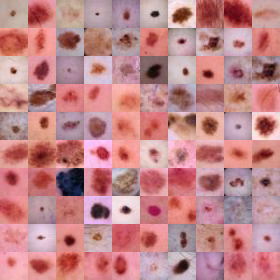

In [ ]:
train_dataset.montage(length=10)

In [ ]:
print(train_dataset[0][0].shape)
train_dataset.montage(length=1)

torch.Size([3, 28, 28])


# Задание 1. Простая модель
Попробуем создать простую нейросеть с fully connected структурой и обучить ее.

Реализуйте следующую архитектуру:
1. Flatten слой
2. Линейный слой с входом n * m * m (n - кол-во каналов, m - размер изображения) и выходом 100, функция активации ReLU()
3. Линейный слой с выходом 10, ReLU()
4. Линейный аутпут слой. Учитывайте нашу задачу (см. флаг task) и используемую функцию потерь (criterion).


In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) # - оставляйте эту строку для воспроизводимости результатов
        super().__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_channels * 28 * 28, 100),

            nn.Linear(100, 10),
            nn.ReLU(),

            nn.Linear(10, num_classes),

            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [ ]:
model = SimpleModel(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 5
lr = 0.2

optimizer = optim.SGD(model.parameters(), lr=lr)

Используем сценарии train и test со встроенными метриками из семинара

In [ ]:
def train(model):
    loss_train = []
    print('==> Training ...')
    for epoch in range(NUM_EPOCHS):
      model.train()
      loss_sum = 0.0
      for inputs, targets in tqdm(train_loader):
          inputs = inputs.to(device)
          targets = targets.to(device)

          # forward + backward + optimize
          optimizer.zero_grad()
          outputs = model(inputs)

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              #loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze()
              #loss = criterion(outputs, targets)
          loss = criterion(outputs, targets)
          print(f"loss={loss}");

          loss_sum += loss.detach().cpu().numpy();

          loss.backward()
          optimizer.step()
      loss_epoch = loss_sum / len(train_loader);
      loss_train.append(loss_epoch)
      print(f"{epoch}: loss={loss_epoch}");
    print('\n ==> Finished training')
    return loss_train

In [ ]:
def test_on_epoch(model):
    loss_test = []
    print('==> Testing ...')
    for epoch in range(NUM_EPOCHS):
      model.eval()
      #loss_sum = 0.0
      loss_epoch = []
      for inputs, targets in tqdm(train_loader):

          inputs = inputs.to(device)
          targets = targets.to(device)

          outputs = model(inputs)

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              #loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze()
              #loss = criterion(outputs, targets)
          loss = criterion(outputs, targets)
          #loss_sum += loss.detach().numpy()
          loss_epoch.append(loss.detach().cpu().numpy())
      #loss_test.append(loss_sum / len(train_loader))
      loss_test.append(np.median(loss_epoch))
    print('\n ==> Finished testing')

    return loss_test

def test_split(model, split):
    model.eval()
    y_score = torch.tensor([]).to(device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

def test(model):
    print('==> Evaluating ...')
    test_split(model, 'train')
    test_split(model, 'test')

==> Training ...


  7%|▋         | 4/55 [00:00<00:01, 36.56it/s]

loss=1.9175626039505005
loss=1.7137783765792847
loss=1.6966614723205566
loss=1.685579776763916
loss=1.6512593030929565
loss=1.638145923614502
loss=1.6372478008270264


 15%|█▍        | 8/55 [00:00<00:01, 37.92it/s]

loss=1.6120860576629639


 22%|██▏       | 12/55 [00:00<00:01, 36.41it/s]

loss=1.5621501207351685
loss=1.5705052614212036
loss=1.5435152053833008
loss=1.474365234375
loss=1.5363824367523193
loss=1.4740369319915771
loss=1.5322577953338623


 31%|███       | 17/55 [00:00<00:00, 38.77it/s]

loss=1.500450611114502
loss=1.506631851196289


 38%|███▊      | 21/55 [00:00<00:00, 37.40it/s]

loss=1.5510820150375366
loss=1.5507208108901978
loss=1.4909026622772217
loss=1.4446253776550293
loss=1.4795392751693726
loss=1.4807848930358887
loss=1.5648274421691895
loss=1.4953417778015137


 55%|█████▍    | 30/55 [00:00<00:00, 39.39it/s]

loss=1.5803229808807373
loss=1.5798131227493286
loss=1.4333109855651855
loss=1.4949146509170532
loss=1.43338143825531
loss=1.517643690109253
loss=1.5262417793273926
loss=1.456565260887146
loss=1.5105746984481812


 73%|███████▎  | 40/55 [00:01<00:00, 38.06it/s]

loss=1.4328442811965942
loss=1.5399646759033203
loss=1.4553042650222778
loss=1.4857287406921387
loss=1.5558711290359497
loss=1.5336053371429443
loss=1.440279245376587
loss=1.5489450693130493


 80%|████████  | 44/55 [00:01<00:00, 36.55it/s]

loss=1.5178695917129517
loss=1.424101710319519
loss=1.4634495973587036
loss=1.4935740232467651
loss=1.4716289043426514


 87%|████████▋ | 48/55 [00:01<00:00, 35.82it/s]

loss=1.5095911026000977
loss=1.4784153699874878
loss=1.578657627105713


100%|██████████| 55/55 [00:01<00:00, 38.00it/s]


loss=1.5337308645248413
loss=1.486101746559143
loss=1.4324134588241577
loss=1.531518816947937
loss=1.4296213388442993
0: loss=1.5306623003699562


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.563524842262268
loss=1.4549980163574219
loss=1.4169167280197144
loss=1.5316873788833618
loss=1.4859732389450073


  9%|▉         | 5/55 [00:00<00:01, 48.22it/s]

loss=1.5016077756881714
loss=1.4006800651550293
loss=1.4864497184753418
loss=1.426041603088379


 18%|█▊        | 10/55 [00:00<00:01, 41.41it/s]

loss=1.4854321479797363
loss=1.440515160560608
loss=1.4860740900039673


 27%|██▋       | 15/55 [00:00<00:01, 37.98it/s]

loss=1.4089066982269287
loss=1.5019961595535278
loss=1.4478189945220947
loss=1.454851508140564
loss=1.5009198188781738
loss=1.51625394821167
loss=1.5476831197738647


 36%|███▋      | 20/55 [00:00<00:00, 38.33it/s]

loss=1.4936082363128662


 44%|████▎     | 24/55 [00:00<00:00, 37.23it/s]

loss=1.463141679763794
loss=1.4855319261550903
loss=1.5087199211120605
loss=1.5246371030807495
loss=1.5791113376617432
loss=1.531956434249878
loss=1.5320535898208618


 53%|█████▎    | 29/55 [00:00<00:00, 39.54it/s]

loss=1.501603126525879
loss=1.5092263221740723


 60%|██████    | 33/55 [00:00<00:00, 37.13it/s]

loss=1.5320841073989868
loss=1.5005160570144653
loss=1.5092558860778809
loss=1.4781357049942017
loss=1.4858757257461548
loss=1.4785293340682983
loss=1.462934970855713


 75%|███████▍  | 41/55 [00:01<00:00, 36.12it/s]

loss=1.470237374305725
loss=1.5087047815322876
loss=1.4859094619750977
loss=1.5251691341400146
loss=1.4927656650543213
loss=1.4549556970596313
loss=1.424847960472107
loss=1.5168462991714478


 91%|█████████ | 50/55 [00:01<00:00, 39.68it/s]

loss=1.5086555480957031
loss=1.5929830074310303
loss=1.5167850255966187
loss=1.5331909656524658
loss=1.5477601289749146
loss=1.585909128189087
loss=1.532612681388855
loss=1.4704633951187134
loss=1.4465583562850952


100%|██████████| 55/55 [00:01<00:00, 37.42it/s]


loss=1.539831519126892
loss=1.470258355140686
1: loss=1.4956308538263494


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5382691621780396
loss=1.5563161373138428


  5%|▌         | 3/55 [00:00<00:02, 25.38it/s]

loss=1.432863473892212


 11%|█         | 6/55 [00:00<00:01, 27.57it/s]

loss=1.4643568992614746
loss=1.4783730506896973
loss=1.47765052318573
loss=1.6777398586273193
loss=1.4791513681411743
loss=1.6166127920150757


 18%|█▊        | 10/55 [00:00<00:01, 31.41it/s]

loss=1.5237106084823608
loss=1.5090197324752808
loss=1.4700814485549927
loss=1.4934946298599243
loss=1.4714438915252686


 27%|██▋       | 15/55 [00:00<00:01, 33.99it/s]

loss=1.4464927911758423
loss=1.493578553199768
loss=1.5162783861160278


 35%|███▍      | 19/55 [00:00<00:01, 31.75it/s]

loss=1.561874270439148
loss=1.462341547012329
loss=1.5006109476089478
loss=1.48542320728302
loss=1.4244540929794312


 42%|████▏     | 23/55 [00:00<00:00, 33.27it/s]

loss=1.456539273262024
loss=1.5009169578552246
loss=1.4239962100982666


 51%|█████     | 28/55 [00:00<00:00, 36.48it/s]

loss=1.524107575416565
loss=1.446945071220398
loss=1.516365647315979
loss=1.5244407653808594
loss=1.5078465938568115
loss=1.431986927986145


 60%|██████    | 33/55 [00:00<00:00, 38.53it/s]

loss=1.5542593002319336
loss=1.4620184898376465
loss=1.4324244260787964


 67%|██████▋   | 37/55 [00:01<00:00, 36.57it/s]

loss=1.4476245641708374
loss=1.5242218971252441
loss=1.493093490600586
loss=1.5700236558914185
loss=1.4315378665924072


 75%|███████▍  | 41/55 [00:01<00:00, 34.56it/s]

loss=1.5166157484054565
loss=1.501245379447937
loss=1.4908947944641113
loss=1.4702532291412354
loss=1.4087053537368774


 82%|████████▏ | 45/55 [00:01<00:00, 34.53it/s]

loss=1.4850480556488037
loss=1.4698227643966675
loss=1.4776005744934082
loss=1.454627513885498


 89%|████████▉ | 49/55 [00:01<00:00, 31.33it/s]

loss=1.4936074018478394
loss=1.5007295608520508
loss=1.455379843711853
loss=1.547149419784546


 96%|█████████▋| 53/55 [00:01<00:00, 29.52it/s]

loss=1.5535975694656372
loss=1.5869903564453125


100%|██████████| 55/55 [00:01<00:00, 32.30it/s]


loss=1.5122931003570557
2: loss=1.4955099409276789


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5240232944488525
loss=1.5004675388336182

  5%|▌         | 3/55 [00:00<00:01, 26.41it/s]


loss=1.4628928899765015
loss=1.4831116199493408
loss=1.5627810955047607


 11%|█         | 6/55 [00:00<00:01, 25.41it/s]

loss=1.5320583581924438
loss=1.4553431272506714
loss=1.5101113319396973


 16%|█▋        | 9/55 [00:00<00:01, 25.08it/s]

loss=1.5305335521697998
loss=1.5015138387680054
loss=1.5100600719451904
loss=1.5000358819961548


 22%|██▏       | 12/55 [00:00<00:01, 25.31it/s]

loss=1.50648033618927
loss=1.5231155157089233


 27%|██▋       | 15/55 [00:00<00:01, 26.19it/s]

loss=1.431084156036377
loss=1.4171591997146606


 33%|███▎      | 18/55 [00:00<00:01, 26.42it/s]

loss=1.560900092124939
loss=1.539617896080017
loss=1.476207971572876
loss=1.5752136707305908


 38%|███▊      | 21/55 [00:00<00:01, 25.86it/s]

loss=1.50879967212677
loss=1.5390664339065552


 44%|████▎     | 24/55 [00:00<00:01, 26.20it/s]

loss=1.5281364917755127
loss=1.4963475465774536
loss=1.5916836261749268
loss=1.5317943096160889


 51%|█████     | 28/55 [00:01<00:00, 28.20it/s]

loss=1.4096784591674805
loss=1.5145975351333618
loss=1.5177061557769775
loss=1.4481642246246338
loss=1.433027982711792


 58%|█████▊    | 32/55 [00:01<00:00, 30.36it/s]

loss=1.469209909439087
loss=1.5023856163024902
loss=1.4840691089630127
loss=1.555761456489563
loss=1.4235098361968994


 65%|██████▌   | 36/55 [00:01<00:00, 29.37it/s]

loss=1.531609296798706
loss=1.5061557292938232
loss=1.5356696844100952


 76%|███████▋  | 42/55 [00:01<00:00, 27.70it/s]

loss=1.4915199279785156
loss=1.4734208583831787
loss=1.4333372116088867
loss=1.4317126274108887


 82%|████████▏ | 45/55 [00:01<00:00, 28.12it/s]

loss=1.4832075834274292
loss=1.5153926610946655
loss=1.4862191677093506


 89%|████████▉ | 49/55 [00:01<00:00, 29.39it/s]

loss=1.365752100944519
loss=1.4488331079483032
loss=1.4559355974197388
loss=1.5405253171920776


 96%|█████████▋| 53/55 [00:01<00:00, 30.98it/s]

loss=1.4775835275650024
loss=1.4468587636947632
loss=1.4857707023620605


100%|██████████| 55/55 [00:01<00:00, 28.02it/s]


loss=1.5858262777328491
loss=1.4816302061080933
3: loss=1.495156548239968


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.4550774097442627


  5%|▌         | 3/55 [00:00<00:02, 24.71it/s]

loss=1.5091294050216675
loss=1.4245147705078125


 11%|█         | 6/55 [00:00<00:01, 25.22it/s]

loss=1.500102162361145
loss=1.5245954990386963
loss=1.476463794708252
loss=1.5170912742614746
loss=1.4841744899749756


 16%|█▋        | 9/55 [00:00<00:01, 23.76it/s]

loss=1.5541388988494873
loss=1.5318411588668823
loss=1.4843590259552002


 22%|██▏       | 12/55 [00:00<00:01, 22.82it/s]

loss=1.548145055770874
loss=1.5313431024551392


 27%|██▋       | 15/55 [00:00<00:01, 24.25it/s]

loss=1.477305293083191
loss=1.5526976585388184
loss=1.538201928138733
loss=1.58456289768219


 33%|███▎      | 18/55 [00:00<00:01, 24.62it/s]

loss=1.4396523237228394
loss=1.507499098777771


 38%|███▊      | 21/55 [00:00<00:01, 23.80it/s]

loss=1.491358995437622
loss=1.4784066677093506
loss=1.4918309450149536
loss=1.4991161823272705


 44%|████▎     | 24/55 [00:01<00:01, 22.75it/s]

loss=1.5017515420913696


 49%|████▉     | 27/55 [00:01<00:01, 23.76it/s]

loss=1.4084528684616089
loss=1.471842885017395
loss=1.5165536403656006
loss=1.4931094646453857
loss=1.5218784809112549


 55%|█████▍    | 30/55 [00:01<00:01, 24.07it/s]

loss=1.4491798877716064
loss=1.522826910018921
loss=1.5144453048706055


 60%|██████    | 33/55 [00:01<00:00, 22.33it/s]

loss=1.418691635131836
loss=1.5231986045837402
loss=1.4107738733291626


 65%|██████▌   | 36/55 [00:01<00:00, 22.65it/s]

loss=1.5454920530319214
loss=1.4400181770324707


 71%|███████   | 39/55 [00:01<00:00, 23.76it/s]

loss=1.484510898590088
loss=1.50863778591156
loss=1.5006308555603027
loss=1.5097248554229736
loss=1.522093415260315


 80%|████████  | 44/55 [00:01<00:00, 28.95it/s]

loss=1.4638210535049438
loss=1.421651840209961
loss=1.4943361282348633


 89%|████████▉ | 49/55 [00:01<00:00, 32.75it/s]

loss=1.4867595434188843
loss=1.5392402410507202
loss=1.4852614402770996
loss=1.524415373802185
loss=1.4534380435943604
loss=1.4421550035476685


 96%|█████████▋| 53/55 [00:02<00:00, 32.77it/s]

loss=1.5607647895812988
loss=1.4932276010513306


100%|██████████| 55/55 [00:02<00:00, 26.57it/s]


loss=1.4712378978729248
loss=1.541304111480713
4: loss=1.495327895337885

 ==> Finished training
==> Testing ...


100%|██████████| 55/55 [00:01<00:00, 43.68it/s]



 ==> Finished testing


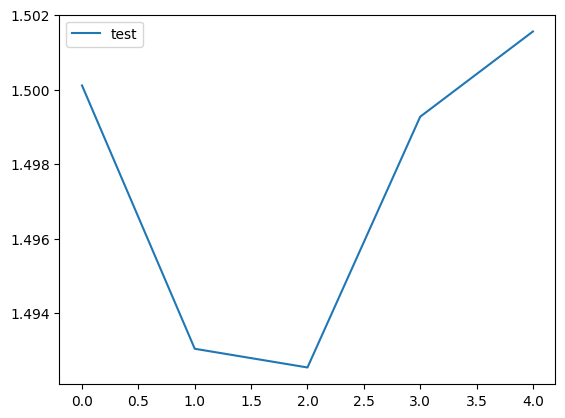

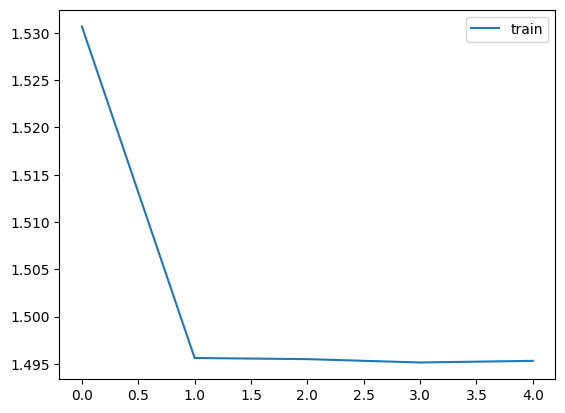

In [ ]:
train_losses = train(model)
test_losses = test_on_epoch(model)
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

==> Training ...


100%|██████████| 55/55 [00:00<00:00, 61.74it/s]



 ==> Finished training
==> Testing ...


100%|██████████| 55/55 [00:00<00:00, 71.18it/s]



 ==> Finished testing


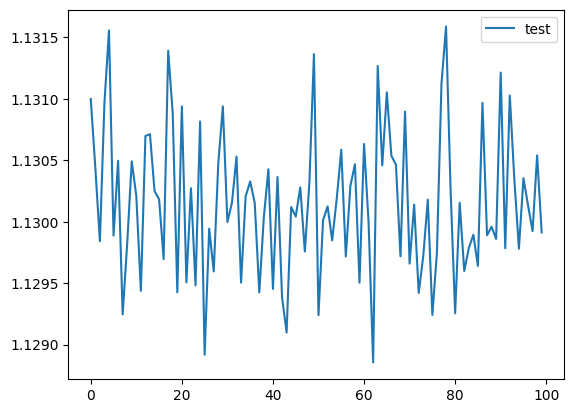

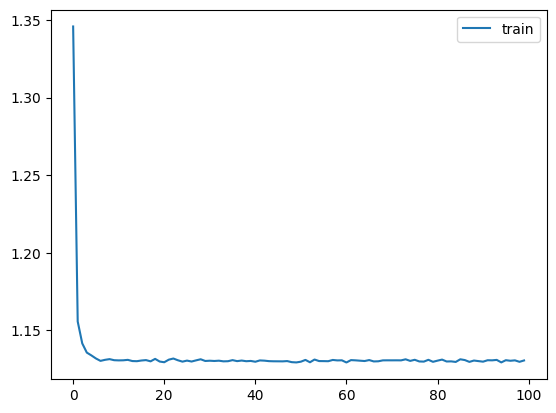

In [ ]:
train_losses = train(model)
test_losses = test_on_epoch(model)
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.500  acc:0.670
test  auc: 0.500  acc:0.669


# Задание 2. Модель посложнее
Создайте более сложную CNN модель по представленной ниже схеме и обучите ее
1. Конволюция с 6 каналами на выход, ядро 5x5 со страйдом 1 и 'same' паддингом (заполнение нулями), ReLU функция активации
2. AveragePooling2D, 2x2 ядро, страйд 2
3. Conv2D, 16 фичей, ядро 5x5 со страйдом 1 и без паддинга (padding='valid'), ReLU
4. AveragePooling2D, 2x2 ядро, страйд 2
5. Conv2D, 40 фичей, ядро 5x5 со страйдом 1 и без паддинга, ReLU
6. Flatten слой
7. Линейный слой со входом 40 * n * n  (n - размер картинки после предыдущих слоев) и выходом 60, ReLU
8. Dropout 50%
9. Линейный аутпут слой. Учитывайте нашу задачу (см. флаг task) и используемую функцию потерь (criterion)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) # оставляем для воспроизводимости результатов
        super().__init__()

        self.fc = nn.Sequential(
            #1
            nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            #size = 28x28x6

            #2
            nn.AvgPool2d(kernel_size=2, stride=2),
            #matrix_size = (( width - kernel_size + 2 * P ) / stride ) + 1 = (28 - 2) / 2 + 1 = 14
            #size = 14x14x6

            #3
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding='valid'),
            nn.ReLU(),
            #matrix_size = ((14 - 5 + 1) = 10
            #size = 10x10x16

            #4
            nn.AvgPool2d(kernel_size=2, stride=2),
            #matrix_size = (10 - 2) / 2 + 1 = 5
            #size = 5x5x16

            #5
            nn.Conv2d(16, 40, kernel_size=5, stride=1, padding='valid'),
            nn.ReLU(),
            #matrix_size = (5 - 5 + 1) = 1
            #size = 1x1x40

            #6
            nn.Flatten(),
            #size = 40 * 1 * 1 = 40

            #7
            nn.Linear(40, 60),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(60, num_classes),

            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.fc(x)
        return x

In [ ]:
model = CNNModel(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 20
lr = 0.01

optimizer = optim.SGD(model.parameters(), lr=lr)

==> Training ...


  4%|▎         | 2/55 [00:00<00:04, 12.47it/s]

loss=1.9381449222564697
loss=1.938136100769043
loss=1.9355369806289673


  7%|▋         | 4/55 [00:00<00:11,  4.62it/s]

loss=1.9377946853637695
loss=1.934584140777588


 11%|█         | 6/55 [00:01<00:09,  5.18it/s]

loss=1.9364382028579712
loss=1.93796968460083


 15%|█▍        | 8/55 [00:01<00:07,  6.23it/s]

loss=1.9387776851654053
loss=1.9331737756729126
loss=1.9370977878570557


 22%|██▏       | 12/55 [00:01<00:05,  8.12it/s]

loss=1.9379388093948364
loss=1.9321370124816895


 24%|██▎       | 13/55 [00:01<00:05,  7.50it/s]

loss=1.9352529048919678
loss=1.9358748197555542


 27%|██▋       | 15/55 [00:02<00:04,  8.36it/s]

loss=1.9358630180358887
loss=1.9357178211212158


 35%|███▍      | 19/55 [00:02<00:03,  9.72it/s]

loss=1.9333866834640503
loss=1.9339386224746704
loss=1.93040931224823


 36%|███▋      | 20/55 [00:02<00:03,  9.42it/s]

loss=1.9330765008926392
loss=1.9293837547302246


 42%|████▏     | 23/55 [00:03<00:03,  8.42it/s]

loss=1.9324288368225098
loss=1.9308336973190308


 45%|████▌     | 25/55 [00:03<00:03,  8.80it/s]

loss=1.9308325052261353
loss=1.9292902946472168


 49%|████▉     | 27/55 [00:03<00:03,  8.64it/s]

loss=1.9290887117385864
loss=1.928680181503296


 53%|█████▎    | 29/55 [00:03<00:03,  7.93it/s]

loss=1.9339655637741089
loss=1.9306440353393555


 56%|█████▋    | 31/55 [00:03<00:02,  8.91it/s]

loss=1.9290903806686401
loss=1.9334297180175781
loss=1.9309042692184448


 64%|██████▎   | 35/55 [00:04<00:01, 10.67it/s]

loss=1.9254010915756226
loss=1.9301716089248657
loss=1.9305487871170044


 67%|██████▋   | 37/55 [00:04<00:01, 10.81it/s]

loss=1.9274195432662964
loss=1.9292789697647095


 71%|███████   | 39/55 [00:04<00:01,  9.39it/s]

loss=1.9276552200317383
loss=1.926006555557251


 75%|███████▍  | 41/55 [00:04<00:01,  9.73it/s]

loss=1.9249062538146973
loss=1.9249768257141113


 80%|████████  | 44/55 [00:05<00:01, 10.30it/s]

loss=1.9267181158065796
loss=1.925849199295044
loss=1.9288188219070435


 84%|████████▎ | 46/55 [00:05<00:01,  8.89it/s]

loss=1.9245542287826538
loss=1.9220925569534302
loss=1.9256541728973389


 91%|█████████ | 50/55 [00:05<00:00, 11.97it/s]

loss=1.9219025373458862
loss=1.9212440252304077
loss=1.9230433702468872
loss=1.9294756650924683


 95%|█████████▍| 52/55 [00:05<00:00, 12.76it/s]

loss=1.9231679439544678
loss=1.9177712202072144
loss=1.920335054397583


100%|██████████| 55/55 [00:06<00:00,  9.03it/s]


loss=1.924241065979004
0: loss=1.9302009864286942


  4%|▎         | 2/55 [00:00<00:04, 11.68it/s]

loss=1.9207907915115356
loss=1.9219145774841309


  7%|▋         | 4/55 [00:00<00:05,  8.58it/s]

loss=1.9206342697143555
loss=1.9171252250671387


 11%|█         | 6/55 [00:00<00:06,  7.40it/s]

loss=1.9169124364852905
loss=1.9220352172851562


 15%|█▍        | 8/55 [00:01<00:06,  7.63it/s]

loss=1.9152170419692993
loss=1.9178677797317505


 18%|█▊        | 10/55 [00:01<00:06,  7.03it/s]

loss=1.9166871309280396
loss=1.9173978567123413


 22%|██▏       | 12/55 [00:01<00:05,  7.57it/s]

loss=1.916298270225525
loss=1.9199637174606323


 25%|██▌       | 14/55 [00:01<00:04,  8.99it/s]

loss=1.916886329650879
loss=1.9197322130203247
loss=1.9147214889526367


 29%|██▉       | 16/55 [00:01<00:03, 10.06it/s]

loss=1.9146913290023804
loss=1.9180796146392822
loss=1.912015438079834


 36%|███▋      | 20/55 [00:02<00:03,  9.99it/s]

loss=1.911645770072937
loss=1.9168834686279297
loss=1.9122427701950073


 44%|████▎     | 24/55 [00:02<00:02, 11.24it/s]

loss=1.9117481708526611
loss=1.9192225933074951
loss=1.9146077632904053


 47%|████▋     | 26/55 [00:02<00:02, 11.34it/s]

loss=1.9043002128601074
loss=1.91339111328125
loss=1.9125419855117798


 51%|█████     | 28/55 [00:02<00:02, 10.52it/s]

loss=1.912508249282837
loss=1.9161946773529053


 58%|█████▊    | 32/55 [00:03<00:02, 10.94it/s]

loss=1.9062018394470215
loss=1.9106708765029907
loss=1.9099260568618774


 62%|██████▏   | 34/55 [00:03<00:01, 11.14it/s]

loss=1.9014391899108887
loss=1.9068294763565063


 65%|██████▌   | 36/55 [00:03<00:01, 10.53it/s]

loss=1.9112393856048584
loss=1.9095573425292969
loss=1.9076526165008545


 73%|███████▎  | 40/55 [00:04<00:01, 11.26it/s]

loss=1.9085677862167358
loss=1.9048712253570557
loss=1.9104382991790771


 76%|███████▋  | 42/55 [00:04<00:01, 11.35it/s]

loss=1.9026951789855957
loss=1.9001593589782715
loss=1.912139892578125


 84%|████████▎ | 46/55 [00:04<00:00, 12.20it/s]

loss=1.9070965051651
loss=1.8986097574234009
loss=1.900297999382019


 87%|████████▋ | 48/55 [00:04<00:00, 12.70it/s]

loss=1.899251103401184
loss=1.9032801389694214
loss=1.909210205078125
loss=1.8957631587982178


100%|██████████| 55/55 [00:05<00:00, 10.95it/s]


loss=1.905043601989746
loss=1.9028267860412598
loss=1.9092674255371094
loss=1.9081603288650513
loss=1.8974266052246094
1: loss=1.9109614480625499


  5%|▌         | 3/55 [00:00<00:02, 21.49it/s]

loss=1.9018001556396484
loss=1.9015411138534546
loss=1.8961656093597412
loss=1.8978760242462158
loss=1.9044380187988281


 16%|█▋        | 9/55 [00:00<00:02, 19.72it/s]

loss=1.9002622365951538
loss=1.8981969356536865
loss=1.903803825378418
loss=1.8968740701675415
loss=1.8975886106491089


 24%|██▎       | 13/55 [00:00<00:02, 19.38it/s]

loss=1.897256851196289
loss=1.8836654424667358
loss=1.889600157737732
loss=1.8937548398971558


 33%|███▎      | 18/55 [00:00<00:01, 20.21it/s]

loss=1.8880611658096313
loss=1.8895622491836548
loss=1.8835207223892212
loss=1.8914254903793335
loss=1.8879457712173462


 38%|███▊      | 21/55 [00:01<00:01, 20.27it/s]

loss=1.899100422859192
loss=1.8930858373641968
loss=1.8890283107757568
loss=1.8873111009597778
loss=1.8801292181015015


 49%|████▉     | 27/55 [00:01<00:01, 19.80it/s]

loss=1.8901712894439697
loss=1.8840311765670776
loss=1.8774712085723877
loss=1.8863996267318726
loss=1.8803880214691162


 60%|██████    | 33/55 [00:01<00:01, 20.58it/s]

loss=1.8915393352508545
loss=1.881307601928711
loss=1.883603811264038
loss=1.873085856437683
loss=1.8846794366836548


 71%|███████   | 39/55 [00:01<00:00, 21.06it/s]

loss=1.8822147846221924
loss=1.8732222318649292
loss=1.874900221824646
loss=1.8861035108566284
loss=1.8864893913269043


 76%|███████▋  | 42/55 [00:02<00:00, 20.91it/s]

loss=1.8813563585281372
loss=1.8673304319381714
loss=1.8748606443405151
loss=1.881996750831604
loss=1.8779529333114624


 87%|████████▋ | 48/55 [00:02<00:00, 19.76it/s]

loss=1.877550482749939
loss=1.8769919872283936
loss=1.88904869556427
loss=1.8822554349899292


 93%|█████████▎| 51/55 [00:02<00:00, 20.11it/s]

loss=1.869206190109253
loss=1.8690736293792725
loss=1.8620336055755615
loss=1.873223066329956
loss=1.8624162673950195


100%|██████████| 55/55 [00:02<00:00, 20.31it/s]


loss=1.8681541681289673
loss=1.8668923377990723
2: loss=1.8848717212677002


  5%|▌         | 3/55 [00:00<00:02, 21.42it/s]

loss=1.8662289381027222
loss=1.860953450202942
loss=1.864788293838501
loss=1.8658367395401
loss=1.865402340888977


 11%|█         | 6/55 [00:00<00:02, 19.88it/s]

loss=1.8479000329971313
loss=1.869286298751831
loss=1.8558598756790161


 15%|█▍        | 8/55 [00:00<00:02, 19.84it/s]

loss=1.851701021194458


 22%|██▏       | 12/55 [00:00<00:02, 18.81it/s]

loss=1.8546971082687378
loss=1.8523218631744385
loss=1.8529596328735352
loss=1.8413753509521484


 27%|██▋       | 15/55 [00:00<00:02, 19.40it/s]

loss=1.8636189699172974
loss=1.85348641872406
loss=1.8375357389450073


 31%|███       | 17/55 [00:00<00:01, 19.12it/s]

loss=1.8490768671035767


 35%|███▍      | 19/55 [00:00<00:01, 19.35it/s]

loss=1.8535398244857788
loss=1.8439260721206665
loss=1.8545986413955688
loss=1.8497498035430908
loss=1.8386527299880981


 45%|████▌     | 25/55 [00:01<00:01, 20.32it/s]

loss=1.8386150598526
loss=1.836789608001709
loss=1.8211171627044678
loss=1.8092747926712036


 55%|█████▍    | 30/55 [00:01<00:01, 19.32it/s]

loss=1.837909460067749
loss=1.824416995048523
loss=1.8345714807510376
loss=1.8223384618759155


 58%|█████▊    | 32/55 [00:01<00:01, 19.01it/s]

loss=1.8209818601608276
loss=1.8018598556518555
loss=1.8132518529891968
loss=1.816315770149231
loss=1.8223037719726562


 69%|██████▉   | 38/55 [00:01<00:00, 20.41it/s]

loss=1.812434196472168
loss=1.8054368495941162
loss=1.8139166831970215
loss=1.8018100261688232
loss=1.8030970096588135


 80%|████████  | 44/55 [00:02<00:00, 20.91it/s]

loss=1.8199373483657837
loss=1.8011008501052856
loss=1.792665958404541
loss=1.77581787109375
loss=1.785261631011963


 85%|████████▌ | 47/55 [00:02<00:00, 20.71it/s]

loss=1.8006184101104736
loss=1.7910559177398682
loss=1.8182861804962158
loss=1.7773399353027344
loss=1.7703300714492798


 96%|█████████▋| 53/55 [00:02<00:00, 20.59it/s]

loss=1.759236216545105
loss=1.8071590662002563
loss=1.7884823083877563
loss=1.7497601509094238
loss=1.7748929262161255


100%|██████████| 55/55 [00:02<00:00, 20.10it/s]


3: loss=1.8243978500366211


  5%|▌         | 3/55 [00:00<00:02, 21.63it/s]

loss=1.7508445978164673
loss=1.7712010145187378
loss=1.7692432403564453
loss=1.7621164321899414
loss=1.778613805770874


 11%|█         | 6/55 [00:00<00:02, 20.25it/s]

loss=1.773497462272644
loss=1.7389323711395264
loss=1.7435728311538696
loss=1.7662101984024048


 20%|██        | 11/55 [00:00<00:02, 19.12it/s]

loss=1.7720435857772827
loss=1.731589674949646
loss=1.7398806810379028
loss=1.7374628782272339
loss=1.7490307092666626


 29%|██▉       | 16/55 [00:00<00:02, 19.44it/s]

loss=1.742950677871704
loss=1.7167084217071533
loss=1.7550426721572876
loss=1.7388211488723755


 40%|████      | 22/55 [00:01<00:01, 20.22it/s]

loss=1.7163413763046265
loss=1.7198336124420166
loss=1.7184244394302368
loss=1.753901481628418
loss=1.7179208993911743


 45%|████▌     | 25/55 [00:01<00:01, 19.95it/s]

loss=1.7294851541519165
loss=1.727912187576294
loss=1.7027795314788818
loss=1.7064262628555298
loss=1.7415978908538818


 56%|█████▋    | 31/55 [00:01<00:01, 20.32it/s]

loss=1.7395031452178955
loss=1.6847785711288452
loss=1.6596653461456299
loss=1.693233847618103


 62%|██████▏   | 34/55 [00:01<00:01, 15.63it/s]

loss=1.6783334016799927
loss=1.671116828918457
loss=1.736303448677063


 69%|██████▉   | 38/55 [00:02<00:01, 13.19it/s]

loss=1.7158790826797485
loss=1.7026153802871704
loss=1.6551755666732788


 73%|███████▎  | 40/55 [00:02<00:01, 11.30it/s]

loss=1.6706794500350952
loss=1.7143874168395996


 76%|███████▋  | 42/55 [00:02<00:01, 12.64it/s]

loss=1.6643757820129395
loss=1.7016115188598633
loss=1.6549749374389648
loss=1.6676650047302246
loss=1.7098097801208496


 89%|████████▉ | 49/55 [00:02<00:00, 16.42it/s]

loss=1.7162061929702759
loss=1.6813030242919922
loss=1.6820313930511475
loss=1.6714638471603394


 93%|█████████▎| 51/55 [00:03<00:00, 17.03it/s]

loss=1.654149055480957
loss=1.668770670890808
loss=1.6455107927322388
loss=1.6709678173065186
loss=1.6605952978134155


100%|██████████| 55/55 [00:03<00:00, 17.08it/s]


loss=1.6534329652786255
4: loss=1.7126713601025667


  5%|▌         | 3/55 [00:00<00:02, 20.74it/s]

loss=1.7156318426132202
loss=1.6745790243148804
loss=1.690395474433899
loss=1.6307624578475952
loss=1.6605240106582642


 11%|█         | 6/55 [00:00<00:02, 20.40it/s]

loss=1.697243332862854
loss=1.6553651094436646
loss=1.6802624464035034
loss=1.652205228805542


 16%|█▋        | 9/55 [00:00<00:02, 20.99it/s]

loss=1.6303297281265259


 22%|██▏       | 12/55 [00:00<00:02, 19.79it/s]

loss=1.6797282695770264
loss=1.6017906665802002
loss=1.6244020462036133
loss=1.6240181922912598
loss=1.6450389623641968


 27%|██▋       | 15/55 [00:00<00:01, 20.21it/s]

loss=1.6318373680114746
loss=1.6061980724334717
loss=1.6338388919830322


 33%|███▎      | 18/55 [00:00<00:01, 19.96it/s]

loss=1.600611686706543
loss=1.626365303993225


 38%|███▊      | 21/55 [00:01<00:01, 19.17it/s]

loss=1.605064034461975
loss=1.629076361656189


 42%|████▏     | 23/55 [00:01<00:01, 17.41it/s]

loss=1.5936956405639648


 45%|████▌     | 25/55 [00:01<00:01, 16.21it/s]

loss=1.628234624862671
loss=1.5859405994415283
loss=1.5876907110214233


 49%|████▉     | 27/55 [00:01<00:01, 14.77it/s]

loss=1.6122462749481201
loss=1.5747723579406738


 53%|█████▎    | 29/55 [00:01<00:01, 14.17it/s]

loss=1.5940948724746704


 56%|█████▋    | 31/55 [00:01<00:01, 14.10it/s]

loss=1.5814142227172852
loss=1.6314594745635986
loss=1.6426434516906738


 60%|██████    | 33/55 [00:01<00:01, 13.50it/s]

loss=1.5506982803344727
loss=1.5891083478927612


 64%|██████▎   | 35/55 [00:02<00:01, 13.92it/s]

loss=1.6046055555343628
loss=1.5433918237686157


 67%|██████▋   | 37/55 [00:02<00:01, 14.08it/s]

loss=1.5905789136886597


 71%|███████   | 39/55 [00:02<00:01, 14.26it/s]

loss=1.6042757034301758
loss=1.5992331504821777
loss=1.5512230396270752


 75%|███████▍  | 41/55 [00:02<00:00, 14.05it/s]

loss=1.5319334268569946
loss=1.5983943939208984


 78%|███████▊  | 43/55 [00:02<00:00, 14.02it/s]

loss=1.5847325325012207


 82%|████████▏ | 45/55 [00:02<00:00, 14.01it/s]

loss=1.5825903415679932
loss=1.62533438205719
loss=1.5766414403915405


 85%|████████▌ | 47/55 [00:02<00:00, 13.44it/s]

loss=1.6013790369033813
loss=1.5982438325881958


 89%|████████▉ | 49/55 [00:03<00:00, 13.47it/s]

loss=1.56558358669281


 93%|█████████▎| 51/55 [00:03<00:00, 13.70it/s]

loss=1.561617374420166
loss=1.5385162830352783
loss=1.5087517499923706


 96%|█████████▋| 53/55 [00:03<00:00, 13.06it/s]

loss=1.6328946352005005
loss=1.5197157859802246


100%|██████████| 55/55 [00:03<00:00, 15.34it/s]


loss=1.539312720298767
5: loss=1.6077494014393199


  4%|▎         | 2/55 [00:00<00:04, 13.09it/s]

loss=1.528420090675354
loss=1.5459173917770386
loss=1.5590131282806396


 11%|█         | 6/55 [00:00<00:03, 15.71it/s]

loss=1.5904600620269775
loss=1.5624924898147583
loss=1.5571357011795044
loss=1.5249905586242676


 18%|█▊        | 10/55 [00:00<00:02, 17.54it/s]

loss=1.5256444215774536
loss=1.523268461227417
loss=1.6062921285629272
loss=1.595765233039856
loss=1.5495989322662354


 22%|██▏       | 12/55 [00:00<00:02, 18.25it/s]

loss=1.5711679458618164
loss=1.6069023609161377
loss=1.5804393291473389


 27%|██▋       | 15/55 [00:00<00:02, 19.12it/s]

loss=1.5542166233062744
loss=1.522999882698059


 35%|███▍      | 19/55 [00:01<00:01, 18.94it/s]

loss=1.5786820650100708
loss=1.5170217752456665


 38%|███▊      | 21/55 [00:01<00:01, 19.05it/s]

loss=1.5299944877624512
loss=1.550533652305603


 42%|████▏     | 23/55 [00:01<00:01, 19.20it/s]

loss=1.5257983207702637
loss=1.5794097185134888
loss=1.5962631702423096
loss=1.5676915645599365
loss=1.5557262897491455


 47%|████▋     | 26/55 [00:01<00:01, 19.44it/s]

loss=1.4959828853607178
loss=1.5156909227371216


 53%|█████▎    | 29/55 [00:01<00:01, 20.14it/s]

loss=1.5336318016052246
loss=1.5446369647979736
loss=1.496772289276123


 58%|█████▊    | 32/55 [00:01<00:01, 20.43it/s]

loss=1.49654221534729
loss=1.5406248569488525


 64%|██████▎   | 35/55 [00:01<00:00, 20.67it/s]

loss=1.5941603183746338
loss=1.462096095085144
loss=1.51967453956604
loss=1.609302282333374
loss=1.5362335443496704


 69%|██████▉   | 38/55 [00:02<00:00, 20.30it/s]

loss=1.5800933837890625
loss=1.5396904945373535
loss=1.507510781288147


 75%|███████▍  | 41/55 [00:02<00:00, 20.60it/s]

loss=1.5802377462387085
loss=1.557809829711914


 80%|████████  | 44/55 [00:02<00:00, 20.75it/s]

loss=1.5610252618789673
loss=1.486401915550232
loss=1.4866957664489746


 85%|████████▌ | 47/55 [00:02<00:00, 21.02it/s]

loss=1.502142310142517


 91%|█████████ | 50/55 [00:02<00:00, 20.46it/s]

loss=1.4945353269577026
loss=1.4718502759933472
loss=1.452123999595642
loss=1.4523475170135498
loss=1.5340254306793213


100%|██████████| 55/55 [00:02<00:00, 19.56it/s]


loss=1.4494853019714355
loss=1.535167932510376
loss=1.526033639907837
6: loss=1.5376067530025135


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5281482934951782
loss=1.5403965711593628


  7%|▋         | 4/55 [00:00<00:02, 18.21it/s]

loss=1.5690534114837646
loss=1.5076082944869995


 11%|█         | 6/55 [00:00<00:02, 18.94it/s]

loss=1.5856510400772095
loss=1.4669629335403442
loss=1.4782342910766602
loss=1.4971497058868408
loss=1.4575318098068237


 16%|█▋        | 9/55 [00:00<00:02, 19.65it/s]

loss=1.5563431978225708
loss=1.4952359199523926


 24%|██▎       | 13/55 [00:00<00:02, 19.39it/s]

loss=1.512148141860962
loss=1.5233536958694458


 27%|██▋       | 15/55 [00:00<00:02, 18.88it/s]

loss=1.508965015411377
loss=1.4875102043151855


 31%|███       | 17/55 [00:00<00:01, 19.19it/s]

loss=1.5408247709274292
loss=1.5072736740112305
loss=1.6010174751281738
loss=1.5795334577560425
loss=1.5210574865341187


 36%|███▋      | 20/55 [00:01<00:01, 19.79it/s]

loss=1.498283863067627
loss=1.5187638998031616


 42%|████▏     | 23/55 [00:01<00:01, 19.48it/s]

loss=1.539850115776062
loss=1.5129294395446777
loss=1.4740583896636963


 47%|████▋     | 26/55 [00:01<00:01, 20.18it/s]

loss=1.4583803415298462
loss=1.4655652046203613


 53%|█████▎    | 29/55 [00:01<00:01, 20.33it/s]

loss=1.5181126594543457
loss=1.491377830505371
loss=1.4926819801330566
loss=1.4900425672531128
loss=1.4604911804199219


 58%|█████▊    | 32/55 [00:01<00:01, 20.38it/s]

loss=1.5337010622024536
loss=1.570338487625122


 64%|██████▎   | 35/55 [00:01<00:01, 19.41it/s]

loss=1.479797124862671
loss=1.5195249319076538


 69%|██████▉   | 38/55 [00:01<00:00, 19.87it/s]

loss=1.4561593532562256
loss=1.491312026977539
loss=1.5448521375656128


 73%|███████▎  | 40/55 [00:02<00:00, 19.77it/s]

loss=1.4744371175765991
loss=1.5949440002441406


 78%|███████▊  | 43/55 [00:02<00:00, 19.34it/s]

loss=1.494546890258789
loss=1.5661110877990723
loss=1.515289306640625
loss=1.5215556621551514


 84%|████████▎ | 46/55 [00:02<00:00, 19.91it/s]

loss=1.4884858131408691
loss=1.5720700025558472
loss=1.4913653135299683


 89%|████████▉ | 49/55 [00:02<00:00, 20.04it/s]

loss=1.527143120765686
loss=1.4911092519760132


 95%|█████████▍| 52/55 [00:02<00:00, 20.00it/s]

loss=1.5396968126296997
loss=1.4878227710723877
loss=1.5003474950790405
loss=1.4945318698883057


100%|██████████| 55/55 [00:02<00:00, 19.64it/s]


loss=1.475876808166504
7: loss=1.5130100965499877


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5399935245513916


  4%|▎         | 2/55 [00:00<00:02, 18.36it/s]

loss=1.5683661699295044
loss=1.5300567150115967


  7%|▋         | 4/55 [00:00<00:02, 17.78it/s]

loss=1.5311449766159058
loss=1.5506073236465454


 11%|█         | 6/55 [00:00<00:02, 17.51it/s]

loss=1.5187898874282837
loss=1.5037227869033813


 15%|█▍        | 8/55 [00:00<00:02, 17.47it/s]

loss=1.4562486410140991
loss=1.4645088911056519


 18%|█▊        | 10/55 [00:00<00:02, 18.25it/s]

loss=1.4928526878356934
loss=1.4722145795822144
loss=1.52445650100708


 22%|██▏       | 12/55 [00:00<00:02, 18.73it/s]

loss=1.5080187320709229


 25%|██▌       | 14/55 [00:00<00:02, 18.68it/s]

loss=1.530009388923645
loss=1.5211060047149658
loss=1.5164108276367188


 31%|███       | 17/55 [00:00<00:01, 19.32it/s]

loss=1.4164538383483887


 35%|███▍      | 19/55 [00:01<00:01, 18.56it/s]

loss=1.5195443630218506
loss=1.5812145471572876
loss=1.502016544342041
loss=1.59913969039917
loss=1.4900357723236084


 44%|████▎     | 24/55 [00:01<00:01, 18.93it/s]

loss=1.4773391485214233
loss=1.5439828634262085


 47%|████▋     | 26/55 [00:01<00:01, 18.86it/s]

loss=1.5042647123336792
loss=1.5078226327896118
loss=1.4560775756835938
loss=1.5124413967132568
loss=1.504143238067627


 53%|█████▎    | 29/55 [00:01<00:01, 19.47it/s]

loss=1.4840399026870728
loss=1.5136539936065674


 60%|██████    | 33/55 [00:01<00:01, 19.19it/s]

loss=1.4957666397094727
loss=1.5448867082595825


 64%|██████▎   | 35/55 [00:01<00:01, 19.27it/s]

loss=1.527562141418457
loss=1.5251448154449463
loss=1.444947600364685
loss=1.55865478515625
loss=1.5018727779388428


 69%|██████▉   | 38/55 [00:02<00:00, 19.20it/s]

loss=1.4557225704193115


 76%|███████▋  | 42/55 [00:02<00:00, 19.21it/s]

loss=1.5138529539108276
loss=1.500524640083313
loss=1.451578974723816
loss=1.4299720525741577


 84%|████████▎ | 46/55 [00:02<00:00, 18.60it/s]

loss=1.44106125831604
loss=1.5299549102783203
loss=1.5511175394058228
loss=1.534301996231079


 87%|████████▋ | 48/55 [00:02<00:00, 18.72it/s]

loss=1.4789674282073975
loss=1.4838610887527466
loss=1.5501247644424438
loss=1.4990015029907227


 93%|█████████▎| 51/55 [00:02<00:00, 19.51it/s]

loss=1.5457168817520142


100%|██████████| 55/55 [00:02<00:00, 19.09it/s]


loss=1.4740368127822876
loss=1.4940475225448608
loss=1.527318000793457
8: loss=1.507284985889088


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.512821912765503
loss=1.4814900159835815


  7%|▋         | 4/55 [00:00<00:02, 18.67it/s]

loss=1.5562372207641602
loss=1.5144777297973633
loss=1.5115504264831543


 11%|█         | 6/55 [00:00<00:02, 19.12it/s]

loss=1.525445818901062
loss=1.5590811967849731
loss=1.4847443103790283
loss=1.5751821994781494


 20%|██        | 11/55 [00:00<00:02, 19.17it/s]

loss=1.442533254623413
loss=1.4465620517730713


 24%|██▎       | 13/55 [00:00<00:02, 19.40it/s]

loss=1.4834330081939697
loss=1.5367071628570557


 27%|██▋       | 15/55 [00:00<00:02, 19.28it/s]

loss=1.449841022491455
loss=1.5621322393417358


 31%|███       | 17/55 [00:00<00:01, 19.38it/s]

loss=1.4994443655014038
loss=1.4792734384536743


 35%|███▍      | 19/55 [00:00<00:01, 19.49it/s]

loss=1.4533672332763672
loss=1.543842077255249
loss=1.4544658660888672


 38%|███▊      | 21/55 [00:01<00:01, 19.59it/s]

loss=1.5546870231628418
loss=1.477542519569397


 42%|████▏     | 23/55 [00:01<00:01, 19.04it/s]

loss=1.4906678199768066
loss=1.531546711921692


 47%|████▋     | 26/55 [00:01<00:01, 19.90it/s]

loss=1.4964230060577393
loss=1.4704793691635132
loss=1.5153597593307495
loss=1.4609394073486328
loss=1.4896070957183838


 53%|█████▎    | 29/55 [00:01<00:01, 19.85it/s]

loss=1.4967939853668213
loss=1.5113312005996704
loss=1.4722483158111572


 58%|█████▊    | 32/55 [00:01<00:01, 20.30it/s]

loss=1.5253854990005493
loss=1.4479517936706543


 64%|██████▎   | 35/55 [00:01<00:01, 19.37it/s]

loss=1.5019954442977905
loss=1.4507426023483276


 67%|██████▋   | 37/55 [00:01<00:01, 17.25it/s]

loss=1.4823814630508423


 71%|███████   | 39/55 [00:02<00:00, 16.22it/s]

loss=1.4560705423355103
loss=1.5505629777908325
loss=1.5062451362609863


 75%|███████▍  | 41/55 [00:02<00:00, 15.38it/s]

loss=1.5445173978805542
loss=1.5025254487991333


 78%|███████▊  | 43/55 [00:02<00:00, 14.93it/s]

loss=1.4321823120117188


 82%|████████▏ | 45/55 [00:02<00:00, 14.31it/s]

loss=1.4876031875610352
loss=1.6098672151565552
loss=1.5211468935012817


 85%|████████▌ | 47/55 [00:02<00:00, 14.33it/s]

loss=1.527779459953308
loss=1.4796792268753052


 89%|████████▉ | 49/55 [00:02<00:00, 14.39it/s]

loss=1.5278847217559814


 93%|█████████▎| 51/55 [00:02<00:00, 14.13it/s]

loss=1.5101667642593384
loss=1.4336296319961548
loss=1.522778034210205


 96%|█████████▋| 53/55 [00:03<00:00, 14.05it/s]

loss=1.4493255615234375
loss=1.5423253774642944
loss=1.5939165353775024


100%|██████████| 55/55 [00:03<00:00, 16.91it/s]


9: loss=1.5026713089509445


  4%|▎         | 2/55 [00:00<00:03, 14.09it/s]

loss=1.5494600534439087
loss=1.5092369318008423
loss=1.5601081848144531


 11%|█         | 6/55 [00:00<00:03, 13.94it/s]

loss=1.4962118864059448
loss=1.4896255731582642
loss=1.5363093614578247


 15%|█▍        | 8/55 [00:00<00:03, 13.55it/s]

loss=1.6059879064559937
loss=1.5269408226013184
loss=1.5296275615692139


 22%|██▏       | 12/55 [00:00<00:03, 13.27it/s]

loss=1.5150431394577026
loss=1.5566794872283936
loss=1.596855878829956


 25%|██▌       | 14/55 [00:01<00:03, 13.25it/s]

loss=1.5062358379364014
loss=1.485085129737854
loss=1.4873149394989014


 33%|███▎      | 18/55 [00:01<00:02, 13.31it/s]

loss=1.5137673616409302
loss=1.5404572486877441
loss=1.5275629758834839
loss=1.4939078092575073


 44%|████▎     | 24/55 [00:01<00:01, 17.40it/s]

loss=1.4911466836929321
loss=1.47402822971344
loss=1.4672558307647705
loss=1.5155887603759766
loss=1.4746335744857788


 53%|█████▎    | 29/55 [00:01<00:01, 19.08it/s]

loss=1.4868757724761963
loss=1.4627712965011597
loss=1.4326162338256836
loss=1.5240256786346436
loss=1.4940227270126343


 58%|█████▊    | 32/55 [00:02<00:01, 19.74it/s]

loss=1.5512810945510864
loss=1.5304609537124634
loss=1.5272464752197266
loss=1.4134656190872192
loss=1.494185447692871


 65%|██████▌   | 36/55 [00:02<00:00, 19.07it/s]

loss=1.5545411109924316
loss=1.4833961725234985
loss=1.5411678552627563
loss=1.462401032447815
loss=1.503803014755249


 76%|███████▋  | 42/55 [00:02<00:00, 20.24it/s]

loss=1.5008842945098877
loss=1.519187092781067
loss=1.5146526098251343
loss=1.4599909782409668
loss=1.463757038116455


 87%|████████▋ | 48/55 [00:02<00:00, 20.61it/s]

loss=1.4563217163085938
loss=1.5044969320297241
loss=1.4686474800109863
loss=1.492003321647644
loss=1.4384926557540894


 93%|█████████▎| 51/55 [00:02<00:00, 20.64it/s]

loss=1.5084614753723145
loss=1.4600980281829834
loss=1.4515339136123657
loss=1.4485365152359009
loss=1.4803305864334106


100%|██████████| 55/55 [00:03<00:00, 17.59it/s]


loss=1.4359968900680542
10: loss=1.5002676942131736


  4%|▎         | 2/55 [00:00<00:03, 16.09it/s]

loss=1.5429449081420898
loss=1.5436458587646484
loss=1.5140727758407593
loss=1.5207669734954834
loss=1.5123875141143799


  9%|▉         | 5/55 [00:00<00:02, 19.15it/s]

loss=1.464019536972046
loss=1.5186103582382202
loss=1.4612339735031128


 15%|█▍        | 8/55 [00:00<00:02, 20.41it/s]

loss=1.4749997854232788
loss=1.481961727142334


 20%|██        | 11/55 [00:00<00:02, 20.44it/s]

loss=1.5424398183822632
loss=1.414469599723816
loss=1.5502049922943115


 25%|██▌       | 14/55 [00:00<00:01, 20.78it/s]

loss=1.4994980096817017
loss=1.4386457204818726


 31%|███       | 17/55 [00:00<00:01, 20.76it/s]

loss=1.4721983671188354
loss=1.5474915504455566
loss=1.4220880270004272
loss=1.4695312976837158
loss=1.467616319656372


 36%|███▋      | 20/55 [00:00<00:01, 20.54it/s]

loss=1.4823346138000488
loss=1.526017427444458


 42%|████▏     | 23/55 [00:01<00:01, 20.01it/s]

loss=1.5024018287658691
loss=1.466631531715393


 47%|████▋     | 26/55 [00:01<00:01, 20.54it/s]

loss=1.574525237083435
loss=1.4972820281982422
loss=1.5641553401947021
loss=1.5152100324630737
loss=1.4763004779815674


 53%|█████▎    | 29/55 [00:01<00:01, 20.43it/s]

loss=1.5280811786651611
loss=1.5071916580200195
loss=1.4456318616867065


 58%|█████▊    | 32/55 [00:01<00:01, 20.67it/s]

loss=1.5283534526824951
loss=1.4552570581436157


 64%|██████▎   | 35/55 [00:01<00:00, 20.83it/s]

loss=1.4816747903823853
loss=1.4965507984161377
loss=1.4568562507629395


 69%|██████▉   | 38/55 [00:01<00:00, 20.81it/s]

loss=1.5380237102508545
loss=1.5193771123886108


 75%|███████▍  | 41/55 [00:02<00:00, 20.69it/s]

loss=1.4416422843933105
loss=1.5918556451797485
loss=1.5282939672470093
loss=1.4603420495986938


 80%|████████  | 44/55 [00:02<00:00, 19.52it/s]

loss=1.5341066122055054
loss=1.4274033308029175
loss=1.4793846607208252
loss=1.4504910707473755


 85%|████████▌ | 47/55 [00:02<00:00, 19.97it/s]

loss=1.5484713315963745


 91%|█████████ | 50/55 [00:02<00:00, 20.29it/s]

loss=1.5204797983169556
loss=1.5043870210647583
loss=1.4836987257003784
loss=1.4208577871322632
loss=1.5111335515975952


100%|██████████| 55/55 [00:02<00:00, 20.39it/s]


loss=1.5734590291976929
loss=1.5336127281188965
11: loss=1.498732783577659


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.4625864028930664
loss=1.5242365598678589


  4%|▎         | 2/55 [00:00<00:02, 19.51it/s]

loss=1.4730820655822754


  7%|▋         | 4/55 [00:00<00:02, 19.78it/s]

loss=1.540455937385559
loss=1.5078696012496948
loss=1.498854398727417
loss=1.5510505437850952


 13%|█▎        | 7/55 [00:00<00:02, 20.09it/s]

loss=1.4120700359344482


 18%|█▊        | 10/55 [00:00<00:02, 17.58it/s]

loss=1.5675894021987915
loss=1.5238240957260132
loss=1.5249953269958496


 22%|██▏       | 12/55 [00:00<00:02, 17.70it/s]

loss=1.493706226348877


 25%|██▌       | 14/55 [00:00<00:02, 17.78it/s]

loss=1.4829565286636353
loss=1.4819353818893433
loss=1.52064049243927


 29%|██▉       | 16/55 [00:00<00:02, 18.19it/s]

loss=1.5312488079071045


 35%|███▍      | 19/55 [00:01<00:01, 19.20it/s]

loss=1.5115432739257812
loss=1.5115842819213867
loss=1.4886468648910522
loss=1.477283239364624
loss=1.5513361692428589


 40%|████      | 22/55 [00:01<00:01, 19.76it/s]

loss=1.4774006605148315
loss=1.552260160446167
loss=1.4520100355148315
loss=1.5145381689071655


 45%|████▌     | 25/55 [00:01<00:01, 19.86it/s]

loss=1.493491291999817


 53%|█████▎    | 29/55 [00:01<00:01, 19.32it/s]

loss=1.4726219177246094
loss=1.4515470266342163
loss=1.495245099067688
loss=1.4524952173233032


 56%|█████▋    | 31/55 [00:01<00:01, 19.22it/s]

loss=1.4519411325454712
loss=1.5486465692520142
loss=1.5396801233291626
loss=1.5635639429092407


 62%|██████▏   | 34/55 [00:01<00:01, 19.56it/s]

loss=1.5392073392868042


 69%|██████▉   | 38/55 [00:01<00:00, 19.45it/s]

loss=1.4669036865234375
loss=1.4521442651748657
loss=1.5040698051452637
loss=1.4373475313186646


 73%|███████▎  | 40/55 [00:02<00:00, 19.09it/s]

loss=1.4225348234176636
loss=1.5753093957901
loss=1.5268489122390747
loss=1.512102484703064


 78%|███████▊  | 43/55 [00:02<00:00, 19.89it/s]

loss=1.4865387678146362


 85%|████████▌ | 47/55 [00:02<00:00, 19.52it/s]

loss=1.5268547534942627
loss=1.5564301013946533
loss=1.481428623199463
loss=1.4910708665847778


 93%|█████████▎| 51/55 [00:02<00:00, 19.12it/s]

loss=1.4460879564285278
loss=1.4748650789260864
loss=1.4692832231521606
loss=1.5042941570281982


100%|██████████| 55/55 [00:02<00:00, 19.26it/s]


loss=1.4606151580810547
loss=1.5288422107696533
loss=1.4161372184753418
12: loss=1.4978518789464776


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5218944549560547
loss=1.5181025266647339


  4%|▎         | 2/55 [00:00<00:03, 17.37it/s]

loss=1.4662268161773682
loss=1.4374860525131226
loss=1.5149863958358765


  9%|▉         | 5/55 [00:00<00:02, 19.76it/s]

loss=1.5053997039794922
loss=1.5322003364562988


 15%|█▍        | 8/55 [00:00<00:02, 20.30it/s]

loss=1.5054372549057007
loss=1.488770604133606
loss=1.527515172958374


 20%|██        | 11/55 [00:00<00:02, 19.92it/s]

loss=1.4668810367584229


 25%|██▌       | 14/55 [00:00<00:02, 19.71it/s]

loss=1.515195369720459
loss=1.4586282968521118
loss=1.5271377563476562
loss=1.5434460639953613


 29%|██▉       | 16/55 [00:00<00:02, 19.02it/s]

loss=1.4808335304260254
loss=1.4753369092941284
loss=1.5665205717086792


 35%|███▍      | 19/55 [00:00<00:01, 19.33it/s]

loss=1.4510916471481323


 38%|███▊      | 21/55 [00:01<00:01, 19.44it/s]

loss=1.36807382106781
loss=1.4777030944824219
loss=1.5175703763961792


 42%|████▏     | 23/55 [00:01<00:01, 19.43it/s]

loss=1.5280897617340088


 45%|████▌     | 25/55 [00:01<00:01, 19.36it/s]

loss=1.4537909030914307
loss=1.523612380027771
loss=1.4802089929580688


 49%|████▉     | 27/55 [00:01<00:01, 19.27it/s]

loss=1.5317360162734985


 53%|█████▎    | 29/55 [00:01<00:01, 18.75it/s]

loss=1.4936015605926514
loss=1.4933338165283203
loss=1.4738210439682007


 56%|█████▋    | 31/55 [00:01<00:01, 18.06it/s]

loss=1.563973069190979


 60%|██████    | 33/55 [00:01<00:01, 17.50it/s]

loss=1.5334233045578003
loss=1.4411933422088623
loss=1.4895631074905396


 64%|██████▎   | 35/55 [00:01<00:01, 17.85it/s]

loss=1.4812912940979004


 67%|██████▋   | 37/55 [00:01<00:00, 18.20it/s]

loss=1.555476188659668
loss=1.4477128982543945
loss=1.4590851068496704


 71%|███████   | 39/55 [00:02<00:00, 18.46it/s]

loss=1.5454907417297363
loss=1.4487683773040771


 76%|███████▋  | 42/55 [00:02<00:00, 19.17it/s]

loss=1.57317316532135
loss=1.461388349533081
loss=1.4439040422439575


 80%|████████  | 44/55 [00:02<00:00, 19.36it/s]

loss=1.5177712440490723
loss=1.5369338989257812


 84%|████████▎ | 46/55 [00:02<00:00, 19.43it/s]

loss=1.4991811513900757
loss=1.52866530418396


 87%|████████▋ | 48/55 [00:02<00:00, 18.85it/s]

loss=1.4893766641616821
loss=1.4860854148864746


 91%|█████████ | 50/55 [00:02<00:00, 17.66it/s]

loss=1.5064325332641602


 95%|█████████▍| 52/55 [00:02<00:00, 15.84it/s]

loss=1.5518560409545898
loss=1.5353078842163086
loss=1.5063179731369019


100%|██████████| 55/55 [00:03<00:00, 18.22it/s]


loss=1.4924665689468384
loss=1.5045567750930786
13: loss=1.49898230379278


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.4786934852600098


  4%|▎         | 2/55 [00:00<00:04, 12.58it/s]

loss=1.5130186080932617
loss=1.5503231287002563


  7%|▋         | 4/55 [00:00<00:03, 13.13it/s]

loss=1.5519944429397583


 11%|█         | 6/55 [00:00<00:03, 13.54it/s]

loss=1.4706529378890991
loss=1.4226402044296265
loss=1.4444537162780762


 15%|█▍        | 8/55 [00:00<00:03, 12.87it/s]

loss=1.5048478841781616
loss=1.5249638557434082


 18%|█▊        | 10/55 [00:00<00:03, 13.40it/s]

loss=1.572358250617981


 22%|██▏       | 12/55 [00:00<00:03, 13.59it/s]

loss=1.5165892839431763
loss=1.4915401935577393
loss=1.4309223890304565
loss=1.4430723190307617


 25%|██▌       | 14/55 [00:01<00:02, 13.97it/s]

loss=1.4267141819000244


 29%|██▉       | 16/55 [00:01<00:02, 14.06it/s]

loss=1.4804271459579468
loss=1.4447883367538452


 33%|███▎      | 18/55 [00:01<00:02, 13.96it/s]

loss=1.4843690395355225


 36%|███▋      | 20/55 [00:01<00:02, 13.81it/s]

loss=1.4955246448516846
loss=1.4704142808914185
loss=1.5308228731155396


 40%|████      | 22/55 [00:01<00:02, 13.16it/s]

loss=1.4325840473175049
loss=1.532239556312561


 44%|████▎     | 24/55 [00:01<00:02, 13.03it/s]

loss=1.6017203330993652


 47%|████▋     | 26/55 [00:01<00:02, 12.85it/s]

loss=1.4363120794296265
loss=1.587367057800293
loss=1.4308750629425049


 51%|█████     | 28/55 [00:02<00:02, 13.27it/s]

loss=1.531848430633545
loss=1.5138353109359741


 55%|█████▍    | 30/55 [00:02<00:01, 13.18it/s]

loss=1.4345358610153198


 58%|█████▊    | 32/55 [00:02<00:01, 13.51it/s]

loss=1.5639631748199463
loss=1.593895673751831
loss=1.5146881341934204


 62%|██████▏   | 34/55 [00:02<00:01, 13.08it/s]

loss=1.5003337860107422
loss=1.4650931358337402


 65%|██████▌   | 36/55 [00:02<00:01, 13.30it/s]

loss=1.4667413234710693


 71%|███████   | 39/55 [00:02<00:01, 15.56it/s]

loss=1.5455623865127563
loss=1.5126301050186157
loss=1.48898446559906
loss=1.4968451261520386


 80%|████████  | 44/55 [00:03<00:00, 17.56it/s]

loss=1.5035364627838135
loss=1.4748972654342651
loss=1.5112870931625366
loss=1.5548038482666016
loss=1.4208784103393555


 89%|████████▉ | 49/55 [00:03<00:00, 19.31it/s]

loss=1.4630241394042969
loss=1.5448122024536133
loss=1.4673610925674438
loss=1.4737104177474976
loss=1.5317468643188477


 98%|█████████▊| 54/55 [00:03<00:00, 19.42it/s]

loss=1.5127921104431152
loss=1.4904487133026123
loss=1.5437089204788208
loss=1.4447047710418701
loss=1.5455381870269775


100%|██████████| 55/55 [00:03<00:00, 15.18it/s]


14: loss=1.497862486405806


  5%|▌         | 3/55 [00:00<00:02, 20.97it/s]

loss=1.5105814933776855
loss=1.4939305782318115
loss=1.4788918495178223
loss=1.5181374549865723
loss=1.4811416864395142


 11%|█         | 6/55 [00:00<00:02, 20.69it/s]

loss=1.4672832489013672
loss=1.4510260820388794
loss=1.4698868989944458


 16%|█▋        | 9/55 [00:00<00:02, 19.85it/s]

loss=1.5178223848342896


 22%|██▏       | 12/55 [00:00<00:02, 20.35it/s]

loss=1.46770441532135
loss=1.5950648784637451
loss=1.4552021026611328
loss=1.4255887269973755
loss=1.4322706460952759


 27%|██▋       | 15/55 [00:00<00:01, 20.21it/s]

loss=1.5131964683532715
loss=1.537894368171692
loss=1.5626076459884644
loss=1.4824401140213013


 38%|███▊      | 21/55 [00:01<00:01, 20.18it/s]

loss=1.5461540222167969
loss=1.5138074159622192
loss=1.4653065204620361
loss=1.5160608291625977
loss=1.4861490726470947


 49%|████▉     | 27/55 [00:01<00:01, 20.36it/s]

loss=1.4866939783096313
loss=1.484742522239685
loss=1.4228990077972412
loss=1.5078359842300415


 55%|█████▍    | 30/55 [00:01<00:01, 19.76it/s]

loss=1.5336052179336548
loss=1.5550191402435303
loss=1.4493128061294556
loss=1.514209508895874
loss=1.5649398565292358


 64%|██████▎   | 35/55 [00:01<00:00, 20.40it/s]

loss=1.5059325695037842
loss=1.5316548347473145
loss=1.4592968225479126
loss=1.538137674331665
loss=1.5117501020431519


 75%|███████▍  | 41/55 [00:02<00:00, 20.42it/s]

loss=1.5342224836349487
loss=1.5166223049163818
loss=1.4645189046859741
loss=1.5032731294631958
loss=1.4754014015197754


 80%|████████  | 44/55 [00:02<00:00, 20.25it/s]

loss=1.488281011581421
loss=1.4916744232177734
loss=1.5468944311141968
loss=1.4752845764160156
loss=1.4909453392028809


 91%|█████████ | 50/55 [00:02<00:00, 19.62it/s]

loss=1.4516892433166504
loss=1.4854646921157837
loss=1.5935126543045044
loss=1.4951528310775757


100%|██████████| 55/55 [00:02<00:00, 20.16it/s]


loss=1.4476386308670044
loss=1.4470324516296387
loss=1.4682947397232056
loss=1.5237125158309937
15: loss=1.4973417217081244


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5191470384597778


  7%|▋         | 4/55 [00:00<00:02, 18.31it/s]

loss=1.4699970483779907
loss=1.4906079769134521
loss=1.5022540092468262
loss=1.5091803073883057


 15%|█▍        | 8/55 [00:00<00:02, 18.65it/s]

loss=1.467417597770691
loss=1.5233428478240967
loss=1.5299735069274902
loss=1.581733226776123


 22%|██▏       | 12/55 [00:00<00:02, 18.68it/s]

loss=1.475062608718872
loss=1.4815112352371216
loss=1.5312013626098633
loss=1.503523588180542


 29%|██▉       | 16/55 [00:00<00:02, 18.78it/s]

loss=1.4654064178466797
loss=1.4914672374725342
loss=1.5150758028030396
loss=1.5683037042617798


 36%|███▋      | 20/55 [00:01<00:01, 18.97it/s]

loss=1.4606919288635254
loss=1.518292784690857
loss=1.5387251377105713
loss=1.460174798965454


 40%|████      | 22/55 [00:01<00:01, 18.11it/s]

loss=1.4600249528884888
loss=1.4456578493118286
loss=1.4821369647979736


 45%|████▌     | 25/55 [00:01<00:01, 18.89it/s]

loss=1.5006027221679688
loss=1.4785205125808716


 49%|████▉     | 27/55 [00:01<00:01, 18.97it/s]

loss=1.4645369052886963
loss=1.4484657049179077
loss=1.5298538208007812


 55%|█████▍    | 30/55 [00:01<00:01, 19.59it/s]

loss=1.5822097063064575
loss=1.4996403455734253


 60%|██████    | 33/55 [00:01<00:01, 19.61it/s]

loss=1.5342990159988403
loss=1.4433634281158447
loss=1.495896577835083
loss=1.481296181678772
loss=1.579215168952942


 65%|██████▌   | 36/55 [00:01<00:00, 19.77it/s]

loss=1.4576094150543213
loss=1.5300880670547485


 69%|██████▉   | 38/55 [00:01<00:00, 19.65it/s]

loss=1.4393913745880127
loss=1.481180191040039


 75%|███████▍  | 41/55 [00:02<00:00, 19.27it/s]

loss=1.5195127725601196
loss=1.4498605728149414


 78%|███████▊  | 43/55 [00:02<00:00, 19.12it/s]

loss=1.4901371002197266
loss=1.4656754732131958


 82%|████████▏ | 45/55 [00:02<00:00, 19.20it/s]

loss=1.4708069562911987
loss=1.5645266771316528
loss=1.479161262512207


 87%|████████▋ | 48/55 [00:02<00:00, 19.86it/s]

loss=1.5046234130859375
loss=1.5128225088119507


 93%|█████████▎| 51/55 [00:02<00:00, 20.26it/s]

loss=1.4808119535446167
loss=1.507012963294983
loss=1.5009816884994507
loss=1.4680054187774658
loss=1.5040918588638306


100%|██████████| 55/55 [00:02<00:00, 19.25it/s]


loss=1.5294995307922363
16: loss=1.4979019858620384


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.540926218032837


  4%|▎         | 2/55 [00:00<00:02, 18.77it/s]

loss=1.5529296398162842
loss=1.4716054201126099


  7%|▋         | 4/55 [00:00<00:02, 18.80it/s]

loss=1.462852954864502
loss=1.5232770442962646


 11%|█         | 6/55 [00:00<00:02, 17.54it/s]

loss=1.4977847337722778
loss=1.4573184251785278


 15%|█▍        | 8/55 [00:00<00:02, 18.29it/s]

loss=1.4656509160995483
loss=1.5188697576522827
loss=1.5259207487106323


 18%|█▊        | 10/55 [00:00<00:02, 18.50it/s]

loss=1.444234013557434


 22%|██▏       | 12/55 [00:00<00:02, 18.85it/s]

loss=1.458318829536438


 25%|██▌       | 14/55 [00:00<00:02, 19.05it/s]

loss=1.4508858919143677
loss=1.5096474885940552
loss=1.4523870944976807


 29%|██▉       | 16/55 [00:00<00:02, 18.96it/s]

loss=1.4903053045272827


 33%|███▎      | 18/55 [00:00<00:01, 18.62it/s]

loss=1.4759081602096558
loss=1.4342803955078125
loss=1.501795768737793


 36%|███▋      | 20/55 [00:01<00:01, 18.49it/s]

loss=1.4651095867156982


 40%|████      | 22/55 [00:01<00:01, 18.66it/s]

loss=1.465325117111206
loss=1.5040963888168335
loss=1.571677803993225


 44%|████▎     | 24/55 [00:01<00:01, 18.41it/s]

loss=1.4717462062835693


 47%|████▋     | 26/55 [00:01<00:01, 18.58it/s]

loss=1.5213791131973267
loss=1.5440521240234375
loss=1.510569453239441


 51%|█████     | 28/55 [00:01<00:01, 18.69it/s]

loss=1.4880677461624146


 55%|█████▍    | 30/55 [00:01<00:01, 18.84it/s]

loss=1.4995101690292358
loss=1.5426838397979736
loss=1.5201584100723267


 58%|█████▊    | 32/55 [00:01<00:01, 18.52it/s]

loss=1.4500073194503784


 62%|██████▏   | 34/55 [00:01<00:01, 18.75it/s]

loss=1.5011783838272095
loss=1.4261459112167358
loss=1.4925931692123413


 65%|██████▌   | 36/55 [00:01<00:01, 18.96it/s]

loss=1.4700807332992554


 69%|██████▉   | 38/55 [00:02<00:00, 18.57it/s]

loss=1.501307487487793
loss=1.4730870723724365
loss=1.5576814413070679


 73%|███████▎  | 40/55 [00:02<00:00, 18.80it/s]

loss=1.5346261262893677
loss=1.5170303583145142


 76%|███████▋  | 42/55 [00:02<00:00, 18.96it/s]

loss=1.433739185333252
loss=1.5565475225448608


 80%|████████  | 44/55 [00:02<00:00, 18.30it/s]

loss=1.476424217224121
loss=1.56288743019104


 84%|████████▎ | 46/55 [00:02<00:00, 18.72it/s]

loss=1.5254144668579102
loss=1.443121075630188


 87%|████████▋ | 48/55 [00:02<00:00, 18.47it/s]

loss=1.5259997844696045
loss=1.5264908075332642
loss=1.4731814861297607
loss=1.5123717784881592


 93%|█████████▎| 51/55 [00:02<00:00, 19.09it/s]

loss=1.5519216060638428
loss=1.5106481313705444
loss=1.5421669483184814


100%|██████████| 55/55 [00:02<00:00, 18.86it/s]


loss=1.424149990081787
17: loss=1.496874130855907


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5422853231430054


  4%|▎         | 2/55 [00:00<00:03, 16.59it/s]

loss=1.5385169982910156
loss=1.443468689918518
loss=1.5957248210906982


  9%|▉         | 5/55 [00:00<00:02, 18.98it/s]

loss=1.40285062789917
loss=1.4324156045913696


 13%|█▎        | 7/55 [00:00<00:02, 18.59it/s]

loss=1.512734055519104
loss=1.5426037311553955


 16%|█▋        | 9/55 [00:00<00:02, 18.32it/s]

loss=1.5031377077102661
loss=1.4955189228057861


 20%|██        | 11/55 [00:00<00:02, 17.18it/s]

loss=1.461203694343567
loss=1.526231050491333


 24%|██▎       | 13/55 [00:00<00:02, 15.99it/s]

loss=1.4829438924789429
loss=1.5281800031661987


 27%|██▋       | 15/55 [00:00<00:02, 14.98it/s]

loss=1.5196188688278198
loss=1.4501789808273315


 31%|███       | 17/55 [00:01<00:02, 14.63it/s]

loss=1.4781887531280518
loss=1.4958313703536987


 35%|███▍      | 19/55 [00:01<00:02, 14.25it/s]

loss=1.4291760921478271
loss=1.4963194131851196


 38%|███▊      | 21/55 [00:01<00:02, 13.97it/s]

loss=1.500884771347046
loss=1.4798014163970947
loss=1.4179164171218872


 42%|████▏     | 23/55 [00:01<00:02, 12.91it/s]

loss=1.5010955333709717


 45%|████▌     | 25/55 [00:01<00:02, 13.49it/s]

loss=1.4484953880310059
loss=1.5030418634414673


 49%|████▉     | 27/55 [00:01<00:02, 13.57it/s]

loss=1.5229380130767822
loss=1.5663344860076904


 53%|█████▎    | 29/55 [00:01<00:01, 13.65it/s]

loss=1.5127501487731934
loss=1.5310004949569702


 56%|█████▋    | 31/55 [00:02<00:01, 13.97it/s]

loss=1.5229870080947876
loss=1.4876666069030762


 60%|██████    | 33/55 [00:02<00:01, 13.64it/s]

loss=1.5069109201431274
loss=1.4919542074203491


 64%|██████▎   | 35/55 [00:02<00:01, 13.65it/s]

loss=1.5115854740142822
loss=1.514915108680725


 67%|██████▋   | 37/55 [00:02<00:01, 13.50it/s]

loss=1.4954973459243774
loss=1.4805042743682861


 71%|███████   | 39/55 [00:02<00:01, 13.20it/s]

loss=1.4868167638778687
loss=1.4823641777038574


 75%|███████▍  | 41/55 [00:02<00:01, 12.82it/s]

loss=1.509703516960144
loss=1.5420162677764893


 78%|███████▊  | 43/55 [00:03<00:00, 12.69it/s]

loss=1.503651738166809
loss=1.4540539979934692
loss=1.5055580139160156


 82%|████████▏ | 45/55 [00:03<00:00, 12.29it/s]

loss=1.5618574619293213
loss=1.4318944215774536


 85%|████████▌ | 47/55 [00:03<00:00, 11.53it/s]

loss=1.508476972579956
loss=1.5394163131713867


 89%|████████▉ | 49/55 [00:03<00:00, 11.65it/s]

loss=1.5021541118621826


 93%|█████████▎| 51/55 [00:03<00:00, 12.24it/s]

loss=1.5161160230636597


 96%|█████████▋| 53/55 [00:03<00:00, 13.69it/s]

loss=1.4802515506744385
loss=1.5434311628341675
loss=1.4418730735778809
loss=1.4081377983093262


100%|██████████| 55/55 [00:03<00:00, 14.01it/s]


18: loss=1.4962032990022138


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.5579694509506226


  4%|▎         | 2/55 [00:00<00:02, 18.75it/s]

loss=1.5725274085998535
loss=1.4942471981048584
loss=1.5243747234344482


  7%|▋         | 4/55 [00:00<00:02, 18.56it/s]

loss=1.4779739379882812


 11%|█         | 6/55 [00:00<00:02, 18.70it/s]

loss=1.5409963130950928


 15%|█▍        | 8/55 [00:00<00:02, 17.29it/s]

loss=1.4617314338684082
loss=1.5862237215042114
loss=1.5195971727371216


 18%|█▊        | 10/55 [00:00<00:02, 17.58it/s]

loss=1.5444499254226685
loss=1.5021650791168213
loss=1.4807782173156738
loss=1.5136349201202393


 24%|██▎       | 13/55 [00:00<00:02, 18.70it/s]

loss=1.4654784202575684
loss=1.5483057498931885


 31%|███       | 17/55 [00:00<00:02, 18.84it/s]

loss=1.49458909034729
loss=1.4147433042526245
loss=1.4577139616012573


 35%|███▍      | 19/55 [00:01<00:01, 18.82it/s]

loss=1.4161577224731445
loss=1.433605432510376
loss=1.509168028831482
loss=1.5019667148590088


 40%|████      | 22/55 [00:01<00:01, 19.34it/s]

loss=1.5500530004501343
loss=1.44801926612854


 44%|████▎     | 24/55 [00:01<00:01, 19.16it/s]

loss=1.4802227020263672
loss=1.5551692247390747


 49%|████▉     | 27/55 [00:01<00:01, 18.78it/s]

loss=1.4972994327545166
loss=1.4274564981460571


 53%|█████▎    | 29/55 [00:01<00:01, 17.99it/s]

loss=1.472916841506958
loss=1.5127495527267456


 56%|█████▋    | 31/55 [00:01<00:01, 18.27it/s]

loss=1.4101154804229736
loss=1.462854027748108


 60%|██████    | 33/55 [00:01<00:01, 17.97it/s]

loss=1.5108405351638794
loss=1.4986865520477295


 64%|██████▎   | 35/55 [00:01<00:01, 18.25it/s]

loss=1.5809624195098877
loss=1.4828904867172241


 67%|██████▋   | 37/55 [00:02<00:00, 18.37it/s]

loss=1.4306097030639648
loss=1.4661221504211426


 71%|███████   | 39/55 [00:02<00:00, 18.61it/s]

loss=1.4599477052688599
loss=1.4966017007827759


 75%|███████▍  | 41/55 [00:02<00:00, 18.52it/s]

loss=1.5292102098464966
loss=1.5846703052520752


 78%|███████▊  | 43/55 [00:02<00:00, 18.46it/s]

loss=1.4910157918930054
loss=1.4230554103851318


 82%|████████▏ | 45/55 [00:02<00:00, 17.93it/s]

loss=1.4180818796157837
loss=1.5242120027542114


 85%|████████▌ | 47/55 [00:02<00:00, 17.78it/s]

loss=1.5440641641616821
loss=1.4957003593444824


 89%|████████▉ | 49/55 [00:02<00:00, 18.24it/s]

loss=1.549813151359558
loss=1.4730805158615112
loss=1.5209782123565674
loss=1.5020910501480103


 95%|█████████▍| 52/55 [00:02<00:00, 19.23it/s]

loss=1.4652905464172363


100%|██████████| 55/55 [00:02<00:00, 18.63it/s]


loss=1.5262821912765503
loss=1.5545099973678589
19: loss=1.4975267453627152

 ==> Finished training
==> Testing ...


100%|██████████| 55/55 [00:01<00:00, 31.27it/s]



 ==> Finished testing


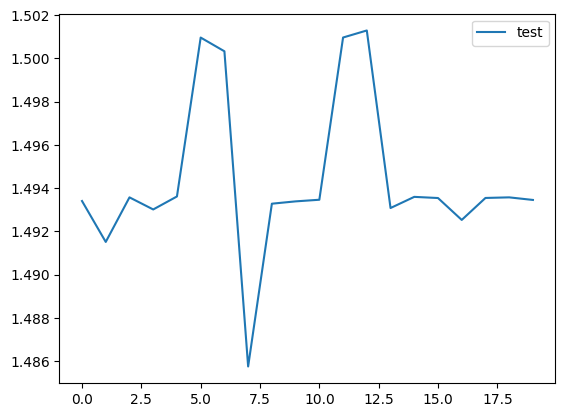

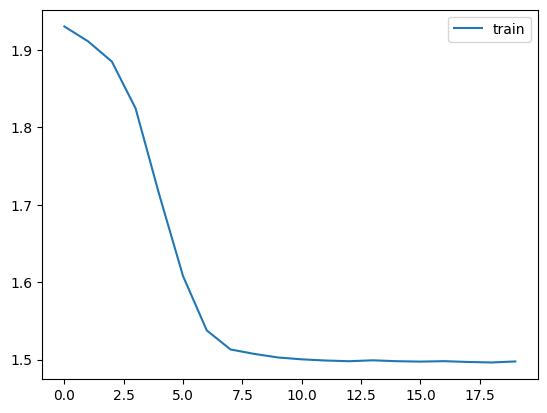

In [ ]:
train_losses = train(model)
test_losses = test_on_epoch(model)
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

==> Training ...


100%|██████████| 55/55 [00:01<00:00, 31.68it/s]



 ==> Finished training
==> Testing ...


100%|██████████| 55/55 [00:01<00:00, 47.99it/s]



 ==> Finished testing


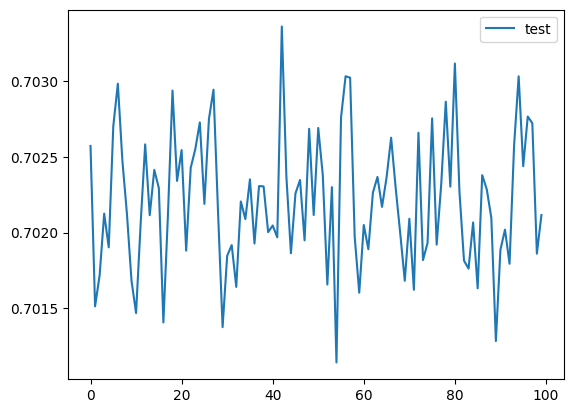

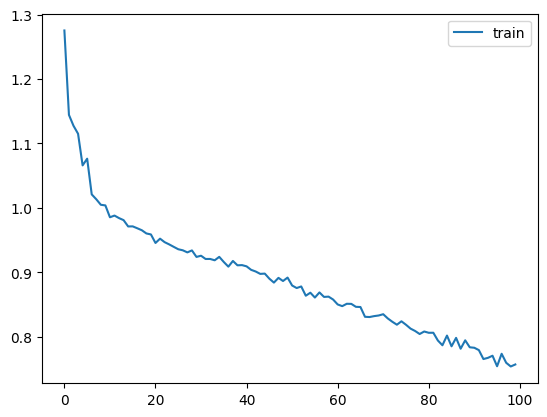

In [ ]:
train_losses = train(model)
test_losses = test_on_epoch(model)
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.897  acc:0.736
test  auc: 0.842  acc:0.694


Сравните результаты обучения обеих сетей. Что изменилось в плане качества и изменилось ли? Сделайте выводы относительно созданных архитектур.

Улучшился Accuracy, но динамика loss на обучении стала хуже, так же осталась

# Задание 3. Своя модель
Попробуйте создать свою собственную архитектуру и попытайтесь максимально повысить качество предсказаний. Можно варьировать ЛЮБЫЕ параметры (кроме лосс функции, объявленной в начале) - число эпох, значение learning rate, оптимизатор, количество слоев (можно использовать дропауты, батч нормы и т.д.), функции активации и т.д.

За основу можно брать полученные на семинаре архитектуры



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class MyLittleModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) # оставляем для воспроизводимости результатов
        super().__init__()

        #Encoder----------------------------------------------------
        self.encoder_conv1 = double_conv(in_channels, 64)
        self.encoder_pool1 = nn.MaxPool2d(2)

        self.encoder_conv2 = double_conv(64, 128)
        self.encoder_pool2 = nn.MaxPool2d(2)

        self.encoder_conv3 = double_conv(128, 256)
        self.encoder_pool3 = nn.MaxPool2d(2)
        #Encoder----------------------------------------------------

        #Center-----------------------------------------------------
        self.center = double_conv(256, 512)
        #Center-----------------------------------------------------

        #Decoder----------------------------------------------------
        self.decoder_trans1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_conv1 = double_conv(512, 256)

        self.decoder_trans2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv2 = double_conv(256, 128)

        self.decoder_trans3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv3 = double_conv(128, 64)
        #Decoder----------------------------------------------------

        #Output-----------------------------------------------------
        self.out_conv = nn.Conv2d(64, 7, kernel_size=5)

        self.flatten = nn.Flatten()
        #size = 7 * 28 * 28 = 5488
        self.linear1 = nn.Linear(5488, 60)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(60, num_classes)
        self.out = nn.Sigmoid()

    def forward(self, x):
        enc1 = self.encoder_conv1(x)
        enc2 = self.encoder_conv2(self.encoder_pool1(enc1))
        enc3 = self.encoder_conv3(self.encoder_pool2(enc2))

        center = self.center(enc3)

        dec1 = self.decoder_trans1(center)
        dec1_resized = F.interpolate(dec1, size=enc3.size()[2:], mode='bilinear', align_corners=False)
        dec1 = torch.cat([dec1_resized, enc3], dim=1)
        dec1 = self.decoder_conv1(dec1)

        dec2 = self.decoder_trans2(dec1)
        dec2_resized = F.interpolate(dec2, size=enc2.size()[2:], mode='bilinear', align_corners=False)
        dec2 = torch.cat([dec2_resized, enc2], dim=1)
        dec2 = self.decoder_conv2(dec2)

        dec3 = self.decoder_trans3(dec2)
        dec3_resized = F.interpolate(dec3, size=enc1.size()[2:], mode='bilinear', align_corners=False)
        dec3 = torch.cat([dec3_resized, enc1], dim=1)
        dec3 = self.decoder_conv3(dec3)

        output = self.out_conv(dec3)
        output = F.interpolate(output, size=x.size()[2:], mode='bilinear', align_corners=False)

        output = self.flatten(output)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.out(output)

        return output

Обучение:

In [ ]:
device = torch.device("cpu")
model = MyLittleModel(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 4
lr = 0.01

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = train(model)
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

NameError: name 'train' is not defined

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.898  acc:0.735
test  auc: 0.889  acc:0.713


In [ ]:
from torch.utils.tensorboard import SummaryWriter

dummy_input = torch.randn(1, 3, 256, 256)
writer = SummaryWriter("runs/unet_experiment")
writer.add_graph(model, dummy_input)
writer.close()

In [ ]:
%%shell
tensorboard --logdir runs

2025-03-11 11:32:24.782761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741692744.954051   85187 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741692744.993948   85187 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 11:32:30.960740: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, u

Сделайте вывод относительно ~вашего дитя~ вашей архитектуры. Поднялось ли качество, какие изменения повлияли сильнее всего?

Смена архитектуры кординальное улучшила результаты модель, менее требовательна к скорости обученияи и показывает лучшие результаты, чем на пердыдущих версиях, по Accuracy

# Задание 4. Transfer learning
Идея Transfer learning: загрузим предобученную нейросеть и попробуем дообучить ее на наших данных. Дообучать будем только последний аутпут слой.



In [ ]:
from torchvision import models
from torchvision.models import ResNet50_Weights

In [ ]:
def get_resnet_model_finetune(num_classes, device, dropout=0):
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        for param in model.parameters():
            param.requires_grad = False

        num_features = model.fc.in_features

        if dropout > 0:
            model.fc = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(num_features, num_classes)
            )
        else:
            model.fc = nn.Linear(num_features, num_classes)

        model.params = model.fc.parameters()

        return model.to(device)

In [ ]:
model = get_resnet_model_finetune(n_classes, device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


Проверим, какой будет размерность выходных данных

In [ ]:
for X, y in train_loader:
    break

In [ ]:
model(X).shape

torch.Size([128, 7])

Рассчитаем качество модели без дообучения

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.560  acc:0.076
test  auc: 0.565  acc:0.078


Дообучим модель на нескольких эпохах

In [ ]:
model = get_resnet_model_finetune(n_classes, device)

NUM_EPOCHS = 3
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train(model)

==> Training ...


  2%|▏         | 1/55 [00:00<00:31,  1.71it/s]

loss=1.9700385332107544


  4%|▎         | 2/55 [00:01<00:30,  1.76it/s]

loss=1.9684661626815796


  5%|▌         | 3/55 [00:01<00:29,  1.74it/s]

loss=1.930479645729065


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=1.9329216480255127


  9%|▉         | 5/55 [00:02<00:28,  1.74it/s]

loss=1.9448096752166748


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=1.9573450088500977


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=1.9521530866622925


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=1.9376925230026245


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=1.9157284498214722


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=1.9357703924179077


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=1.9050244092941284


 22%|██▏       | 12/55 [00:06<00:24,  1.74it/s]

loss=1.9347807168960571


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=1.9158073663711548


 25%|██▌       | 14/55 [00:08<00:23,  1.74it/s]

loss=1.875964641571045


 27%|██▋       | 15/55 [00:08<00:24,  1.63it/s]

loss=1.9099980592727661


 29%|██▉       | 16/55 [00:09<00:25,  1.53it/s]

loss=1.8710691928863525


 31%|███       | 17/55 [00:10<00:25,  1.50it/s]

loss=1.9249283075332642


 33%|███▎      | 18/55 [00:10<00:23,  1.56it/s]

loss=1.9188921451568604


 35%|███▍      | 19/55 [00:11<00:22,  1.62it/s]

loss=1.904791235923767


 36%|███▋      | 20/55 [00:11<00:20,  1.67it/s]

loss=1.8768463134765625


 38%|███▊      | 21/55 [00:12<00:19,  1.72it/s]

loss=1.865875482559204


 40%|████      | 22/55 [00:13<00:18,  1.75it/s]

loss=1.8870275020599365


 42%|████▏     | 23/55 [00:13<00:18,  1.74it/s]

loss=1.943683385848999


 44%|████▎     | 24/55 [00:14<00:17,  1.75it/s]

loss=1.8670605421066284


 45%|████▌     | 25/55 [00:14<00:18,  1.60it/s]

loss=1.9118707180023193


 47%|████▋     | 26/55 [00:15<00:18,  1.55it/s]

loss=1.8899176120758057


 49%|████▉     | 27/55 [00:16<00:20,  1.36it/s]

loss=1.8699153661727905


 51%|█████     | 28/55 [00:17<00:20,  1.32it/s]

loss=1.8977415561676025


 53%|█████▎    | 29/55 [00:18<00:19,  1.33it/s]

loss=1.8595737218856812


 55%|█████▍    | 30/55 [00:18<00:17,  1.44it/s]

loss=1.869965672492981


 56%|█████▋    | 31/55 [00:19<00:15,  1.53it/s]

loss=1.8144340515136719


 58%|█████▊    | 32/55 [00:19<00:14,  1.59it/s]

loss=1.8213444948196411


 60%|██████    | 33/55 [00:20<00:14,  1.57it/s]

loss=1.8784089088439941


 62%|██████▏   | 34/55 [00:21<00:14,  1.49it/s]

loss=1.7690417766571045


 64%|██████▎   | 35/55 [00:21<00:13,  1.48it/s]

loss=1.7521134614944458


 65%|██████▌   | 36/55 [00:22<00:12,  1.54it/s]

loss=1.7587684392929077


 67%|██████▋   | 37/55 [00:23<00:11,  1.59it/s]

loss=1.7606141567230225


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=1.7336921691894531


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=1.8078420162200928


 73%|███████▎  | 40/55 [00:24<00:08,  1.68it/s]

loss=1.890514850616455


 75%|███████▍  | 41/55 [00:25<00:08,  1.70it/s]

loss=1.8165525197982788


 76%|███████▋  | 42/55 [00:25<00:07,  1.69it/s]

loss=1.7971796989440918


 78%|███████▊  | 43/55 [00:26<00:07,  1.71it/s]

loss=1.8176683187484741


 80%|████████  | 44/55 [00:27<00:06,  1.72it/s]

loss=1.7401633262634277


 82%|████████▏ | 45/55 [00:27<00:05,  1.72it/s]

loss=1.8183660507202148


 84%|████████▎ | 46/55 [00:28<00:05,  1.74it/s]

loss=1.686944842338562


 85%|████████▌ | 47/55 [00:28<00:04,  1.76it/s]

loss=1.7790883779525757


 87%|████████▋ | 48/55 [00:29<00:03,  1.78it/s]

loss=1.7740613222122192


 89%|████████▉ | 49/55 [00:29<00:03,  1.78it/s]

loss=1.7445036172866821


 91%|█████████ | 50/55 [00:30<00:02,  1.77it/s]

loss=1.7993501424789429


 93%|█████████▎| 51/55 [00:31<00:02,  1.76it/s]

loss=1.8572421073913574


 95%|█████████▍| 52/55 [00:31<00:01,  1.75it/s]

loss=1.7439830303192139


 96%|█████████▋| 53/55 [00:32<00:01,  1.62it/s]

loss=1.7612035274505615


 98%|█████████▊| 54/55 [00:33<00:00,  1.54it/s]

loss=1.6941821575164795


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=1.636770486831665
0: loss=1.8509122349999168


  2%|▏         | 1/55 [00:00<00:30,  1.79it/s]

loss=1.8043107986450195


  4%|▎         | 2/55 [00:01<00:30,  1.76it/s]

loss=1.775956392288208


  5%|▌         | 3/55 [00:01<00:29,  1.74it/s]

loss=1.8160868883132935


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=1.758329153060913


  9%|▉         | 5/55 [00:02<00:28,  1.76it/s]

loss=1.7277578115463257


 11%|█         | 6/55 [00:03<00:28,  1.75it/s]

loss=1.7950271368026733


 13%|█▎        | 7/55 [00:04<00:27,  1.74it/s]

loss=1.7623203992843628


 15%|█▍        | 8/55 [00:04<00:27,  1.74it/s]

loss=1.681681513786316


 16%|█▋        | 9/55 [00:05<00:26,  1.75it/s]

loss=1.6974390745162964


 18%|█▊        | 10/55 [00:05<00:25,  1.79it/s]

loss=1.8412693738937378


 20%|██        | 11/55 [00:06<00:24,  1.78it/s]

loss=1.7942036390304565


 22%|██▏       | 12/55 [00:06<00:23,  1.80it/s]

loss=1.6643072366714478


 24%|██▎       | 13/55 [00:07<00:23,  1.78it/s]

loss=1.8209397792816162


 25%|██▌       | 14/55 [00:07<00:23,  1.78it/s]

loss=1.7443124055862427


 27%|██▋       | 15/55 [00:08<00:22,  1.78it/s]

loss=1.69288969039917


 29%|██▉       | 16/55 [00:09<00:22,  1.76it/s]

loss=1.7174500226974487


 31%|███       | 17/55 [00:09<00:21,  1.74it/s]

loss=1.6436318159103394


 33%|███▎      | 18/55 [00:10<00:23,  1.60it/s]

loss=1.6462652683258057


 35%|███▍      | 19/55 [00:11<00:23,  1.54it/s]

loss=1.7833565473556519


 36%|███▋      | 20/55 [00:11<00:22,  1.58it/s]

loss=1.6308773756027222


 38%|███▊      | 21/55 [00:12<00:21,  1.62it/s]

loss=1.73480224609375


 40%|████      | 22/55 [00:12<00:19,  1.66it/s]

loss=1.6275640726089478


 42%|████▏     | 23/55 [00:13<00:18,  1.69it/s]

loss=1.7830363512039185


 44%|████▎     | 24/55 [00:13<00:17,  1.72it/s]

loss=1.6335854530334473


 45%|████▌     | 25/55 [00:14<00:17,  1.73it/s]

loss=1.8415472507476807


 47%|████▋     | 26/55 [00:15<00:16,  1.71it/s]

loss=1.708287239074707


 49%|████▉     | 27/55 [00:15<00:16,  1.72it/s]

loss=1.759295105934143


 51%|█████     | 28/55 [00:16<00:15,  1.74it/s]

loss=1.6720077991485596


 53%|█████▎    | 29/55 [00:16<00:14,  1.78it/s]

loss=1.6916019916534424


 55%|█████▍    | 30/55 [00:17<00:14,  1.76it/s]

loss=1.5861045122146606


 56%|█████▋    | 31/55 [00:17<00:13,  1.77it/s]

loss=1.6643095016479492


 58%|█████▊    | 32/55 [00:18<00:13,  1.77it/s]

loss=1.778449535369873


 60%|██████    | 33/55 [00:19<00:12,  1.74it/s]

loss=1.686124563217163


 62%|██████▏   | 34/55 [00:19<00:11,  1.75it/s]

loss=1.5853705406188965


 64%|██████▎   | 35/55 [00:20<00:11,  1.77it/s]

loss=1.707502841949463


 65%|██████▌   | 36/55 [00:20<00:10,  1.77it/s]

loss=1.7524127960205078


 67%|██████▋   | 37/55 [00:21<00:11,  1.63it/s]

loss=1.6563259363174438


 69%|██████▉   | 38/55 [00:22<00:11,  1.50it/s]

loss=1.6392134428024292


 71%|███████   | 39/55 [00:22<00:10,  1.56it/s]

loss=1.5536725521087646


 73%|███████▎  | 40/55 [00:23<00:09,  1.60it/s]

loss=1.6877881288528442


 75%|███████▍  | 41/55 [00:24<00:08,  1.66it/s]

loss=1.765509843826294


 76%|███████▋  | 42/55 [00:24<00:07,  1.69it/s]

loss=1.6371710300445557


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=1.5681160688400269


 80%|████████  | 44/55 [00:25<00:06,  1.72it/s]

loss=1.7904411554336548


 82%|████████▏ | 45/55 [00:26<00:05,  1.69it/s]

loss=1.6702829599380493


 84%|████████▎ | 46/55 [00:26<00:05,  1.70it/s]

loss=1.6176663637161255


 85%|████████▌ | 47/55 [00:27<00:04,  1.70it/s]

loss=1.652976155281067


 87%|████████▋ | 48/55 [00:28<00:04,  1.71it/s]

loss=1.6359672546386719


 89%|████████▉ | 49/55 [00:28<00:03,  1.72it/s]

loss=1.7054853439331055


 91%|█████████ | 50/55 [00:29<00:02,  1.72it/s]

loss=1.6756566762924194


 93%|█████████▎| 51/55 [00:29<00:02,  1.71it/s]

loss=1.7221430540084839


 95%|█████████▍| 52/55 [00:30<00:01,  1.73it/s]

loss=1.7623425722122192


 96%|█████████▋| 53/55 [00:30<00:01,  1.74it/s]

loss=1.575414776802063


 98%|█████████▊| 54/55 [00:31<00:00,  1.73it/s]

loss=1.7929308414459229


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


loss=1.5719785690307617
1: loss=1.703481760892001


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=1.7575615644454956


  4%|▎         | 2/55 [00:01<00:36,  1.44it/s]

loss=1.6369898319244385


  5%|▌         | 3/55 [00:02<00:36,  1.42it/s]

loss=1.6211870908737183


  7%|▋         | 4/55 [00:02<00:33,  1.52it/s]

loss=1.6571398973464966


  9%|▉         | 5/55 [00:03<00:31,  1.59it/s]

loss=1.58479905128479


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=1.5899991989135742


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=1.5718894004821777


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=1.6086255311965942


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=1.5975087881088257


 18%|█▊        | 10/55 [00:06<00:26,  1.72it/s]

loss=1.6053016185760498


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=1.619837760925293


 22%|██▏       | 12/55 [00:07<00:24,  1.74it/s]

loss=1.7280795574188232


 24%|██▎       | 13/55 [00:07<00:24,  1.72it/s]

loss=1.6486866474151611


 25%|██▌       | 14/55 [00:08<00:23,  1.74it/s]

loss=1.7482244968414307


 27%|██▋       | 15/55 [00:08<00:23,  1.73it/s]

loss=1.6131666898727417


 29%|██▉       | 16/55 [00:09<00:22,  1.75it/s]

loss=1.5577709674835205


 31%|███       | 17/55 [00:10<00:21,  1.75it/s]

loss=1.56071138381958


 33%|███▎      | 18/55 [00:10<00:21,  1.75it/s]

loss=1.5667312145233154


 35%|███▍      | 19/55 [00:11<00:20,  1.75it/s]

loss=1.5235401391983032


 36%|███▋      | 20/55 [00:11<00:19,  1.76it/s]

loss=1.547508716583252


 38%|███▊      | 21/55 [00:12<00:20,  1.62it/s]

loss=1.5573641061782837


 40%|████      | 22/55 [00:13<00:21,  1.52it/s]

loss=1.6780869960784912


 42%|████▏     | 23/55 [00:13<00:20,  1.55it/s]

loss=1.5736656188964844


 44%|████▎     | 24/55 [00:14<00:19,  1.60it/s]

loss=1.740203857421875


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=1.5973767042160034


 47%|████▋     | 26/55 [00:15<00:17,  1.65it/s]

loss=1.6964417695999146


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=1.4813728332519531


 51%|█████     | 28/55 [00:16<00:15,  1.69it/s]

loss=1.6228604316711426


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=1.5243133306503296


 55%|█████▍    | 30/55 [00:17<00:14,  1.70it/s]

loss=1.5185943841934204


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=1.490120768547058


 58%|█████▊    | 32/55 [00:19<00:13,  1.75it/s]

loss=1.548682689666748


 60%|██████    | 33/55 [00:19<00:12,  1.77it/s]

loss=1.5757426023483276


 62%|██████▏   | 34/55 [00:20<00:12,  1.74it/s]

loss=1.4913352727890015


 64%|██████▎   | 35/55 [00:20<00:11,  1.74it/s]

loss=1.4635568857192993


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=1.5230135917663574


 67%|██████▋   | 37/55 [00:21<00:10,  1.73it/s]

loss=1.4972989559173584


 69%|██████▉   | 38/55 [00:22<00:09,  1.74it/s]

loss=1.4827284812927246


 71%|███████   | 39/55 [00:23<00:09,  1.75it/s]

loss=1.4908621311187744


 73%|███████▎  | 40/55 [00:23<00:08,  1.67it/s]

loss=1.58733332157135


 75%|███████▍  | 41/55 [00:24<00:09,  1.55it/s]

loss=1.495483160018921


 76%|███████▋  | 42/55 [00:25<00:08,  1.53it/s]

loss=1.7113527059555054


 78%|███████▊  | 43/55 [00:25<00:07,  1.60it/s]

loss=1.4810686111450195


 80%|████████  | 44/55 [00:26<00:06,  1.64it/s]

loss=1.5556691884994507


 82%|████████▏ | 45/55 [00:26<00:05,  1.68it/s]

loss=1.4286078214645386


 84%|████████▎ | 46/55 [00:27<00:05,  1.69it/s]

loss=1.443418264389038


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=1.5836210250854492


 87%|████████▋ | 48/55 [00:28<00:04,  1.72it/s]

loss=1.7023993730545044


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=1.527131199836731


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=1.5503383874893188


 93%|█████████▎| 51/55 [00:30<00:02,  1.71it/s]

loss=1.4764552116394043


 95%|█████████▍| 52/55 [00:30<00:01,  1.70it/s]

loss=1.5111405849456787


 96%|█████████▋| 53/55 [00:31<00:01,  1.71it/s]

loss=1.6712231636047363


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=1.6825025081634521


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]

loss=1.495290994644165
2: loss=1.578216663273898

 ==> Finished training


[1.8509122349999168, 1.703481760892001, 1.578216663273898]

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.562  acc:0.591
test  auc: 0.536  acc:0.592


Увеличим число эпох

In [ ]:
model = get_resnet_model_finetune(n_classes, device)

NUM_EPOCHS = 10
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train(model)

==> Training ...


  2%|▏         | 1/55 [00:00<00:32,  1.68it/s]

loss=1.9687714576721191


  4%|▎         | 2/55 [00:01<00:35,  1.47it/s]

loss=2.0402445793151855


  5%|▌         | 3/55 [00:02<00:36,  1.43it/s]

loss=2.026559352874756


  7%|▋         | 4/55 [00:02<00:32,  1.55it/s]

loss=1.989883303642273


  9%|▉         | 5/55 [00:03<00:31,  1.61it/s]

loss=1.9985880851745605


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=1.9421910047531128


 13%|█▎        | 7/55 [00:04<00:28,  1.71it/s]

loss=2.066801071166992


 15%|█▍        | 8/55 [00:04<00:27,  1.74it/s]

loss=1.9956218004226685


 16%|█▋        | 9/55 [00:05<00:26,  1.75it/s]

loss=1.953627586364746


 18%|█▊        | 10/55 [00:05<00:25,  1.75it/s]

loss=1.9874578714370728


 20%|██        | 11/55 [00:06<00:25,  1.75it/s]

loss=1.9288556575775146


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=1.9328842163085938


 24%|██▎       | 13/55 [00:07<00:27,  1.55it/s]

loss=1.9738759994506836


 25%|██▌       | 14/55 [00:08<00:27,  1.49it/s]

loss=1.938936471939087


 27%|██▋       | 15/55 [00:09<00:25,  1.55it/s]

loss=1.9769948720932007


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=1.9511499404907227


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=1.9581735134124756


 33%|███▎      | 18/55 [00:11<00:22,  1.66it/s]

loss=1.9425108432769775


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=1.9076433181762695


 36%|███▋      | 20/55 [00:12<00:21,  1.64it/s]

loss=1.9183372259140015


 38%|███▊      | 21/55 [00:13<00:22,  1.53it/s]

loss=1.9419950246810913


 40%|████      | 22/55 [00:13<00:21,  1.51it/s]

loss=1.9454857110977173


 42%|████▏     | 23/55 [00:14<00:20,  1.56it/s]

loss=1.9535411596298218


 44%|████▎     | 24/55 [00:14<00:18,  1.63it/s]

loss=1.9132912158966064


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=1.9246344566345215


 47%|████▋     | 26/55 [00:15<00:17,  1.69it/s]

loss=1.9122178554534912


 49%|████▉     | 27/55 [00:16<00:16,  1.69it/s]

loss=1.9209880828857422


 51%|█████     | 28/55 [00:17<00:15,  1.70it/s]

loss=1.8695929050445557


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

loss=1.8925457000732422


 55%|█████▍    | 30/55 [00:18<00:14,  1.72it/s]

loss=1.9255913496017456


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=1.9363737106323242


 58%|█████▊    | 32/55 [00:19<00:13,  1.75it/s]

loss=1.875651240348816


 60%|██████    | 33/55 [00:19<00:12,  1.77it/s]

loss=1.9577397108078003


 62%|██████▏   | 34/55 [00:20<00:11,  1.75it/s]

loss=1.937504529953003


 64%|██████▎   | 35/55 [00:21<00:11,  1.74it/s]

loss=1.8601182699203491


 65%|██████▌   | 36/55 [00:21<00:10,  1.74it/s]

loss=1.8724297285079956


 67%|██████▋   | 37/55 [00:22<00:10,  1.74it/s]

loss=1.9375494718551636


 69%|██████▉   | 38/55 [00:22<00:09,  1.76it/s]

loss=1.8445333242416382


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=1.8326647281646729


 73%|███████▎  | 40/55 [00:24<00:09,  1.59it/s]

loss=1.824560523033142


 75%|███████▍  | 41/55 [00:24<00:09,  1.52it/s]

loss=1.881810188293457


 76%|███████▋  | 42/55 [00:25<00:08,  1.57it/s]

loss=1.835368037223816


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=1.8266648054122925


 80%|████████  | 44/55 [00:26<00:06,  1.68it/s]

loss=1.8445512056350708


 82%|████████▏ | 45/55 [00:27<00:05,  1.72it/s]

loss=1.8084909915924072


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=1.8583570718765259


 85%|████████▌ | 47/55 [00:28<00:04,  1.73it/s]

loss=1.872416377067566


 87%|████████▋ | 48/55 [00:28<00:04,  1.75it/s]

loss=1.773482084274292


 89%|████████▉ | 49/55 [00:29<00:03,  1.74it/s]

loss=1.8237495422363281


 91%|█████████ | 50/55 [00:30<00:02,  1.75it/s]

loss=1.820478081703186


 93%|█████████▎| 51/55 [00:30<00:02,  1.75it/s]

loss=1.8427261114120483


 95%|█████████▍| 52/55 [00:31<00:01,  1.74it/s]

loss=1.8312009572982788


 96%|█████████▋| 53/55 [00:31<00:01,  1.73it/s]

loss=1.7740346193313599


 98%|█████████▊| 54/55 [00:32<00:00,  1.72it/s]

loss=1.863810658454895


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=1.8482674360275269
0: loss=1.9087913643230092


  2%|▏         | 1/55 [00:00<00:32,  1.66it/s]

loss=1.7671252489089966


  4%|▎         | 2/55 [00:01<00:31,  1.66it/s]

loss=1.8099640607833862


  5%|▌         | 3/55 [00:01<00:30,  1.68it/s]

loss=1.771610975265503


  7%|▋         | 4/55 [00:02<00:32,  1.57it/s]

loss=1.7732348442077637


  9%|▉         | 5/55 [00:03<00:34,  1.47it/s]

loss=1.8627485036849976


 11%|█         | 6/55 [00:03<00:33,  1.45it/s]

loss=1.855173945426941


 13%|█▎        | 7/55 [00:04<00:31,  1.52it/s]

loss=1.8096359968185425


 15%|█▍        | 8/55 [00:05<00:29,  1.58it/s]

loss=1.7361171245574951


 16%|█▋        | 9/55 [00:05<00:28,  1.61it/s]

loss=1.7785521745681763


 18%|█▊        | 10/55 [00:06<00:27,  1.64it/s]

loss=1.7911882400512695


 20%|██        | 11/55 [00:06<00:26,  1.68it/s]

loss=1.8080697059631348


 22%|██▏       | 12/55 [00:07<00:25,  1.72it/s]

loss=1.6978520154953003


 24%|██▎       | 13/55 [00:08<00:24,  1.71it/s]

loss=1.747497320175171


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=1.7090435028076172


 27%|██▋       | 15/55 [00:09<00:22,  1.75it/s]

loss=1.7131307125091553


 29%|██▉       | 16/55 [00:09<00:22,  1.75it/s]

loss=1.7710708379745483


 31%|███       | 17/55 [00:10<00:21,  1.75it/s]

loss=1.75229012966156


 33%|███▎      | 18/55 [00:10<00:21,  1.75it/s]

loss=1.8508787155151367


 35%|███▍      | 19/55 [00:11<00:20,  1.75it/s]

loss=1.8109110593795776


 36%|███▋      | 20/55 [00:11<00:20,  1.75it/s]

loss=1.7466731071472168


 38%|███▊      | 21/55 [00:12<00:19,  1.75it/s]

loss=1.8334884643554688


 40%|████      | 22/55 [00:13<00:18,  1.74it/s]

loss=1.814729928970337


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=1.8138102293014526


 44%|████▎     | 24/55 [00:14<00:19,  1.57it/s]

loss=1.6808345317840576


 45%|████▌     | 25/55 [00:15<00:19,  1.52it/s]

loss=1.8104753494262695


 47%|████▋     | 26/55 [00:15<00:18,  1.56it/s]

loss=1.696435809135437


 49%|████▉     | 27/55 [00:16<00:17,  1.62it/s]

loss=1.6735866069793701


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

loss=1.657619833946228


 53%|█████▎    | 29/55 [00:17<00:15,  1.70it/s]

loss=1.7868672609329224


 55%|█████▍    | 30/55 [00:18<00:14,  1.75it/s]

loss=1.7626392841339111


 56%|█████▋    | 31/55 [00:18<00:13,  1.74it/s]

loss=1.6312392950057983


 58%|█████▊    | 32/55 [00:19<00:13,  1.73it/s]

loss=1.6350042819976807


 60%|██████    | 33/55 [00:19<00:12,  1.72it/s]

loss=1.7494393587112427


 62%|██████▏   | 34/55 [00:20<00:12,  1.73it/s]

loss=1.7306209802627563


 64%|██████▎   | 35/55 [00:20<00:11,  1.74it/s]

loss=1.7774579524993896


 65%|██████▌   | 36/55 [00:21<00:10,  1.74it/s]

loss=1.7277615070343018


 67%|██████▋   | 37/55 [00:22<00:10,  1.76it/s]

loss=1.623708963394165


 69%|██████▉   | 38/55 [00:22<00:09,  1.75it/s]

loss=1.7619844675064087


 71%|███████   | 39/55 [00:23<00:09,  1.77it/s]

loss=1.6891692876815796


 73%|███████▎  | 40/55 [00:23<00:08,  1.77it/s]

loss=1.825345754623413


 75%|███████▍  | 41/55 [00:24<00:07,  1.76it/s]

loss=1.6933802366256714


 76%|███████▋  | 42/55 [00:24<00:07,  1.75it/s]

loss=1.5514928102493286


 78%|███████▊  | 43/55 [00:25<00:07,  1.60it/s]

loss=1.6121705770492554


 80%|████████  | 44/55 [00:26<00:07,  1.52it/s]

loss=1.6226807832717896


 82%|████████▏ | 45/55 [00:26<00:06,  1.55it/s]

loss=1.6296076774597168


 84%|████████▎ | 46/55 [00:27<00:05,  1.60it/s]

loss=1.8352454900741577


 85%|████████▌ | 47/55 [00:28<00:04,  1.65it/s]

loss=1.7509626150131226


 87%|████████▋ | 48/55 [00:28<00:04,  1.69it/s]

loss=1.7584905624389648


 89%|████████▉ | 49/55 [00:29<00:03,  1.71it/s]

loss=1.6489959955215454


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=1.6679989099502563


 93%|█████████▎| 51/55 [00:30<00:02,  1.71it/s]

loss=1.5596413612365723


 95%|█████████▍| 52/55 [00:30<00:01,  1.72it/s]

loss=1.7197576761245728


 96%|█████████▋| 53/55 [00:31<00:01,  1.71it/s]

loss=1.7462857961654663


 98%|█████████▊| 54/55 [00:32<00:00,  1.74it/s]

loss=1.6545743942260742


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.7079787254333496
1: loss=1.7346227450804277


  2%|▏         | 1/55 [00:00<00:31,  1.73it/s]

loss=1.7186379432678223


  4%|▎         | 2/55 [00:01<00:31,  1.69it/s]

loss=1.637465000152588


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.7127918004989624


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=1.7017947435379028


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=1.6563490629196167


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=1.6420884132385254


 13%|█▎        | 7/55 [00:04<00:29,  1.62it/s]

loss=1.7968374490737915


 15%|█▍        | 8/55 [00:05<00:31,  1.48it/s]

loss=1.631580114364624


 16%|█▋        | 9/55 [00:05<00:32,  1.44it/s]

loss=1.589691400527954


 18%|█▊        | 10/55 [00:06<00:30,  1.48it/s]

loss=1.6215370893478394


 20%|██        | 11/55 [00:06<00:28,  1.55it/s]

loss=1.7539807558059692


 22%|██▏       | 12/55 [00:07<00:27,  1.59it/s]

loss=1.64529287815094


 24%|██▎       | 13/55 [00:08<00:25,  1.62it/s]

loss=1.5796887874603271


 25%|██▌       | 14/55 [00:08<00:24,  1.64it/s]

loss=1.7379615306854248


 27%|██▋       | 15/55 [00:09<00:24,  1.65it/s]

loss=1.6229676008224487


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=1.6304378509521484


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=1.7613874673843384


 33%|███▎      | 18/55 [00:11<00:21,  1.69it/s]

loss=1.7437809705734253


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=1.7656700611114502


 36%|███▋      | 20/55 [00:12<00:20,  1.71it/s]

loss=1.7566574811935425


 38%|███▊      | 21/55 [00:12<00:20,  1.69it/s]

loss=1.5490649938583374


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=1.5992391109466553


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=1.7042500972747803


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

loss=1.5819646120071411


 45%|████▌     | 25/55 [00:15<00:17,  1.73it/s]

loss=1.5715781450271606


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=1.7539293766021729


 49%|████▉     | 27/55 [00:16<00:17,  1.59it/s]

loss=1.6085187196731567


 51%|█████     | 28/55 [00:17<00:17,  1.53it/s]

loss=1.7148469686508179


 53%|█████▎    | 29/55 [00:17<00:16,  1.60it/s]

loss=1.5216816663742065


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=1.503638505935669


 56%|█████▋    | 31/55 [00:18<00:14,  1.67it/s]

loss=1.622414231300354


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=1.71026611328125


 60%|██████    | 33/55 [00:20<00:12,  1.70it/s]

loss=1.60414719581604


 62%|██████▏   | 34/55 [00:20<00:12,  1.72it/s]

loss=1.5768107175827026


 64%|██████▎   | 35/55 [00:21<00:11,  1.72it/s]

loss=1.7093051671981812


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=1.6892061233520508


 67%|██████▋   | 37/55 [00:22<00:10,  1.73it/s]

loss=1.5250205993652344


 69%|██████▉   | 38/55 [00:22<00:09,  1.73it/s]

loss=1.5492442846298218


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=1.5756405591964722


 73%|███████▎  | 40/55 [00:24<00:08,  1.73it/s]

loss=1.7014504671096802


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=1.5516822338104248


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=1.5312620401382446


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=1.4978134632110596


 80%|████████  | 44/55 [00:26<00:06,  1.74it/s]

loss=1.5437474250793457


 82%|████████▏ | 45/55 [00:26<00:05,  1.71it/s]

loss=1.6499965190887451


 84%|████████▎ | 46/55 [00:27<00:05,  1.57it/s]

loss=1.5081899166107178


 85%|████████▌ | 47/55 [00:28<00:05,  1.49it/s]

loss=1.5937808752059937


 87%|████████▋ | 48/55 [00:29<00:04,  1.54it/s]

loss=1.555842638015747


 89%|████████▉ | 49/55 [00:29<00:03,  1.61it/s]

loss=1.5184195041656494


 91%|█████████ | 50/55 [00:30<00:03,  1.64it/s]

loss=1.6389602422714233


 93%|█████████▎| 51/55 [00:30<00:02,  1.66it/s]

loss=1.6394253969192505


 95%|█████████▍| 52/55 [00:31<00:01,  1.67it/s]

loss=1.554673194885254


 96%|█████████▋| 53/55 [00:32<00:01,  1.68it/s]

loss=1.496890902519226


 98%|█████████▊| 54/55 [00:32<00:00,  1.69it/s]

loss=1.65532648563385


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=1.6250823736190796
2: loss=1.6298165321350098


  2%|▏         | 1/55 [00:00<00:31,  1.69it/s]

loss=1.6248152256011963


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=1.6647419929504395


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.5264374017715454


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=1.4952976703643799


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=1.522423505783081


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=1.4296391010284424


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=1.5125116109848022


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=1.6191105842590332


 16%|█▋        | 9/55 [00:05<00:27,  1.70it/s]

loss=1.6627174615859985


 18%|█▊        | 10/55 [00:05<00:28,  1.58it/s]

loss=1.679726481437683


 20%|██        | 11/55 [00:06<00:30,  1.46it/s]

loss=1.705220103263855


 22%|██▏       | 12/55 [00:07<00:28,  1.52it/s]

loss=1.5927554368972778


 24%|██▎       | 13/55 [00:07<00:26,  1.57it/s]

loss=1.659935712814331


 25%|██▌       | 14/55 [00:08<00:25,  1.60it/s]

loss=1.5803223848342896


 27%|██▋       | 15/55 [00:09<00:24,  1.64it/s]

loss=1.5352840423583984


 29%|██▉       | 16/55 [00:09<00:23,  1.64it/s]

loss=1.4433428049087524


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=1.4627116918563843


 33%|███▎      | 18/55 [00:10<00:21,  1.71it/s]

loss=1.6123955249786377


 35%|███▍      | 19/55 [00:11<00:20,  1.75it/s]

loss=1.529658317565918


 36%|███▋      | 20/55 [00:11<00:19,  1.76it/s]

loss=1.5792642831802368


 38%|███▊      | 21/55 [00:12<00:19,  1.75it/s]

loss=1.4516003131866455


 40%|████      | 22/55 [00:13<00:18,  1.75it/s]

loss=1.5196926593780518


 42%|████▏     | 23/55 [00:13<00:18,  1.74it/s]

loss=1.454256534576416


 44%|████▎     | 24/55 [00:14<00:17,  1.72it/s]

loss=1.481292724609375


 45%|████▌     | 25/55 [00:14<00:17,  1.72it/s]

loss=1.5051466226577759


 47%|████▋     | 26/55 [00:15<00:16,  1.75it/s]

loss=1.4539313316345215


 49%|████▉     | 27/55 [00:16<00:15,  1.75it/s]

loss=1.4842242002487183


 51%|█████     | 28/55 [00:16<00:15,  1.76it/s]

loss=1.6599671840667725


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=1.542847990989685


 55%|█████▍    | 30/55 [00:17<00:16,  1.56it/s]

loss=1.6919845342636108


 56%|█████▋    | 31/55 [00:18<00:15,  1.53it/s]

loss=1.5746917724609375


 58%|█████▊    | 32/55 [00:19<00:14,  1.60it/s]

loss=1.604791522026062


 60%|██████    | 33/55 [00:19<00:13,  1.64it/s]

loss=1.5686089992523193


 62%|██████▏   | 34/55 [00:20<00:12,  1.68it/s]

loss=1.4443702697753906


 64%|██████▎   | 35/55 [00:20<00:11,  1.70it/s]

loss=1.5152493715286255


 65%|██████▌   | 36/55 [00:21<00:11,  1.70it/s]

loss=1.4531571865081787


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=1.516916036605835


 69%|██████▉   | 38/55 [00:22<00:09,  1.72it/s]

loss=1.6247655153274536


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=1.4939507246017456


 73%|███████▎  | 40/55 [00:23<00:08,  1.73it/s]

loss=1.7191168069839478


 75%|███████▍  | 41/55 [00:24<00:08,  1.74it/s]

loss=1.5901480913162231


 76%|███████▋  | 42/55 [00:24<00:07,  1.71it/s]

loss=1.5907206535339355


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=1.461112380027771


 80%|████████  | 44/55 [00:26<00:06,  1.72it/s]

loss=1.6242425441741943


 82%|████████▏ | 45/55 [00:26<00:05,  1.73it/s]

loss=1.5399932861328125


 84%|████████▎ | 46/55 [00:27<00:05,  1.76it/s]

loss=1.4503612518310547


 85%|████████▌ | 47/55 [00:27<00:04,  1.74it/s]

loss=1.4212703704833984


 87%|████████▋ | 48/55 [00:28<00:04,  1.74it/s]

loss=1.466417670249939


 89%|████████▉ | 49/55 [00:29<00:03,  1.60it/s]

loss=1.5521636009216309


 91%|█████████ | 50/55 [00:29<00:03,  1.52it/s]

loss=1.5111584663391113


 93%|█████████▎| 51/55 [00:30<00:02,  1.57it/s]

loss=1.5674142837524414


 95%|█████████▍| 52/55 [00:31<00:01,  1.61it/s]

loss=1.4542202949523926


 96%|█████████▋| 53/55 [00:31<00:01,  1.66it/s]

loss=1.595586895942688


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=1.4638659954071045


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.481802225112915
3: loss=1.5448973027142612


  2%|▏         | 1/55 [00:00<00:32,  1.68it/s]

loss=1.5222373008728027


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=1.482987880706787


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.5715434551239014


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=1.5476136207580566


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=1.5798648595809937


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

loss=1.394019603729248


 13%|█▎        | 7/55 [00:04<00:27,  1.74it/s]

loss=1.6891106367111206


 15%|█▍        | 8/55 [00:04<00:27,  1.73it/s]

loss=1.3589564561843872


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=1.625671148300171


 18%|█▊        | 10/55 [00:05<00:26,  1.72it/s]

loss=1.509529948234558


 20%|██        | 11/55 [00:06<00:25,  1.71it/s]

loss=1.383012294769287


 22%|██▏       | 12/55 [00:06<00:25,  1.72it/s]

loss=1.4992424249649048


 24%|██▎       | 13/55 [00:07<00:25,  1.63it/s]

loss=1.4876607656478882


 25%|██▌       | 14/55 [00:08<00:26,  1.52it/s]

loss=1.6821166276931763


 27%|██▋       | 15/55 [00:09<00:26,  1.51it/s]

loss=1.6616096496582031


 29%|██▉       | 16/55 [00:09<00:25,  1.56it/s]

loss=1.5393145084381104


 31%|███       | 17/55 [00:10<00:23,  1.60it/s]

loss=1.533902645111084


 33%|███▎      | 18/55 [00:10<00:22,  1.63it/s]

loss=1.536901593208313


 35%|███▍      | 19/55 [00:11<00:22,  1.62it/s]

loss=1.3597615957260132


 36%|███▋      | 20/55 [00:12<00:21,  1.64it/s]

loss=1.6115559339523315


 38%|███▊      | 21/55 [00:12<00:20,  1.64it/s]

loss=1.4674317836761475


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=1.496836543083191


 42%|████▏     | 23/55 [00:13<00:18,  1.69it/s]

loss=1.5702089071273804


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=1.390075445175171


 45%|████▌     | 25/55 [00:15<00:17,  1.68it/s]

loss=1.4159345626831055


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=1.599505066871643


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=1.4060301780700684


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.428876280784607


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=1.6213189363479614


 55%|█████▍    | 30/55 [00:17<00:14,  1.72it/s]

loss=1.4125670194625854


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=1.4385437965393066


 58%|█████▊    | 32/55 [00:19<00:14,  1.63it/s]

loss=1.6748334169387817


 60%|██████    | 33/55 [00:19<00:14,  1.52it/s]

loss=1.3638195991516113


 62%|██████▏   | 34/55 [00:20<00:13,  1.52it/s]

loss=1.4384182691574097


 64%|██████▎   | 35/55 [00:21<00:12,  1.57it/s]

loss=1.4708679914474487


 65%|██████▌   | 36/55 [00:21<00:11,  1.63it/s]

loss=1.391908049583435


 67%|██████▋   | 37/55 [00:22<00:10,  1.69it/s]

loss=1.3019627332687378


 69%|██████▉   | 38/55 [00:22<00:10,  1.69it/s]

loss=1.4460151195526123


 71%|███████   | 39/55 [00:23<00:09,  1.70it/s]

loss=1.5122339725494385


 73%|███████▎  | 40/55 [00:24<00:08,  1.69it/s]

loss=1.4366466999053955


 75%|███████▍  | 41/55 [00:24<00:08,  1.71it/s]

loss=1.4593360424041748


 76%|███████▋  | 42/55 [00:25<00:07,  1.70it/s]

loss=1.6087056398391724


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=1.6100964546203613


 80%|████████  | 44/55 [00:26<00:06,  1.72it/s]

loss=1.4928323030471802


 82%|████████▏ | 45/55 [00:26<00:05,  1.72it/s]

loss=1.4038054943084717


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=1.4249080419540405


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=1.4581726789474487


 87%|████████▋ | 48/55 [00:28<00:04,  1.73it/s]

loss=1.5728975534439087


 89%|████████▉ | 49/55 [00:29<00:03,  1.72it/s]

loss=1.3764748573303223


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=1.4746018648147583


 93%|█████████▎| 51/55 [00:30<00:02,  1.63it/s]

loss=1.4232174158096313


 95%|█████████▍| 52/55 [00:31<00:01,  1.51it/s]

loss=1.463109016418457


 96%|█████████▋| 53/55 [00:32<00:01,  1.49it/s]

loss=1.4333386421203613


 98%|█████████▊| 54/55 [00:32<00:00,  1.58it/s]

loss=1.677345633506775


100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


loss=1.5770970582962036
4: loss=1.496665200320157


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=1.607080101966858


  4%|▎         | 2/55 [00:01<00:31,  1.69it/s]

loss=1.6072615385055542


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.333391547203064


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=1.40135657787323


  9%|▉         | 5/55 [00:02<00:28,  1.74it/s]

loss=1.566937804222107


 11%|█         | 6/55 [00:03<00:28,  1.75it/s]

loss=1.366547703742981


 13%|█▎        | 7/55 [00:04<00:27,  1.75it/s]

loss=1.5973855257034302


 15%|█▍        | 8/55 [00:04<00:26,  1.75it/s]

loss=1.585723638534546


 16%|█▋        | 9/55 [00:05<00:26,  1.74it/s]

loss=1.610329270362854


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=1.348529577255249


 20%|██        | 11/55 [00:06<00:25,  1.73it/s]

loss=1.4317466020584106


 22%|██▏       | 12/55 [00:06<00:24,  1.75it/s]

loss=1.3775800466537476


 24%|██▎       | 13/55 [00:07<00:24,  1.75it/s]

loss=1.5012538433074951


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=1.4273163080215454


 27%|██▋       | 15/55 [00:08<00:23,  1.74it/s]

loss=1.4656425714492798


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=1.441077709197998


 31%|███       | 17/55 [00:10<00:25,  1.48it/s]

loss=1.4294975996017456


 33%|███▎      | 18/55 [00:10<00:24,  1.53it/s]

loss=1.4716671705245972


 35%|███▍      | 19/55 [00:11<00:22,  1.59it/s]

loss=1.346421241760254


 36%|███▋      | 20/55 [00:11<00:21,  1.63it/s]

loss=1.402327537536621


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=1.3651413917541504


 40%|████      | 22/55 [00:13<00:19,  1.65it/s]

loss=1.5151801109313965


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=1.4384539127349854


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=1.478683352470398


 45%|████▌     | 25/55 [00:14<00:17,  1.71it/s]

loss=1.4976924657821655


 47%|████▋     | 26/55 [00:15<00:17,  1.69it/s]

loss=1.4342149496078491


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=1.3471040725708008


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

loss=1.3209797143936157


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=1.5985805988311768


 55%|█████▍    | 30/55 [00:17<00:14,  1.68it/s]

loss=1.4178659915924072


 56%|█████▋    | 31/55 [00:18<00:14,  1.65it/s]

loss=1.4969571828842163


 58%|█████▊    | 32/55 [00:19<00:14,  1.63it/s]

loss=1.519310474395752


 60%|██████    | 33/55 [00:19<00:13,  1.65it/s]

loss=1.4334309101104736


 62%|██████▏   | 34/55 [00:20<00:12,  1.63it/s]

loss=1.3864566087722778


 64%|██████▎   | 35/55 [00:21<00:13,  1.51it/s]

loss=1.409266710281372


 65%|██████▌   | 36/55 [00:21<00:12,  1.47it/s]

loss=1.6306440830230713


 67%|██████▋   | 37/55 [00:22<00:11,  1.54it/s]

loss=1.3607155084609985


 69%|██████▉   | 38/55 [00:22<00:10,  1.59it/s]

loss=1.358993411064148


 71%|███████   | 39/55 [00:23<00:09,  1.61it/s]

loss=1.5438692569732666


 73%|███████▎  | 40/55 [00:24<00:09,  1.64it/s]

loss=1.4140796661376953


 75%|███████▍  | 41/55 [00:24<00:08,  1.67it/s]

loss=1.5957629680633545


 76%|███████▋  | 42/55 [00:25<00:07,  1.70it/s]

loss=1.2366442680358887


 78%|███████▊  | 43/55 [00:25<00:06,  1.74it/s]

loss=1.543936848640442


 80%|████████  | 44/55 [00:26<00:06,  1.72it/s]

loss=1.4051710367202759


 82%|████████▏ | 45/55 [00:27<00:05,  1.71it/s]

loss=1.5844948291778564


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=1.2973229885101318


 85%|████████▌ | 47/55 [00:28<00:04,  1.70it/s]

loss=1.3673819303512573


 87%|████████▋ | 48/55 [00:28<00:04,  1.74it/s]

loss=1.3322834968566895


 89%|████████▉ | 49/55 [00:29<00:03,  1.76it/s]

loss=1.518284559249878


 91%|█████████ | 50/55 [00:29<00:02,  1.76it/s]

loss=1.459652304649353


 93%|█████████▎| 51/55 [00:30<00:02,  1.75it/s]

loss=1.4464542865753174


 95%|█████████▍| 52/55 [00:31<00:01,  1.74it/s]

loss=1.3389168977737427


 96%|█████████▋| 53/55 [00:31<00:01,  1.75it/s]

loss=1.446628451347351


 98%|█████████▊| 54/55 [00:32<00:00,  1.59it/s]

loss=1.5182653665542603


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.391440749168396
5: loss=1.450351550362327


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=1.5931469202041626


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=1.5837010145187378


  5%|▌         | 3/55 [00:01<00:30,  1.70it/s]

loss=1.5590096712112427


  7%|▋         | 4/55 [00:02<00:30,  1.69it/s]

loss=1.4343762397766113


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=1.3541831970214844


 11%|█         | 6/55 [00:03<00:28,  1.71it/s]

loss=1.4338427782058716


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=1.5295703411102295


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=1.4177634716033936


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=1.3411850929260254


 18%|█▊        | 10/55 [00:05<00:26,  1.73it/s]

loss=1.3767588138580322


 20%|██        | 11/55 [00:06<00:25,  1.73it/s]

loss=1.5605592727661133


 22%|██▏       | 12/55 [00:06<00:24,  1.75it/s]

loss=1.6125580072402954


 24%|██▎       | 13/55 [00:07<00:23,  1.75it/s]

loss=1.2983287572860718


 25%|██▌       | 14/55 [00:08<00:23,  1.75it/s]

loss=1.484038233757019


 27%|██▋       | 15/55 [00:08<00:22,  1.77it/s]

loss=1.3314111232757568


 29%|██▉       | 16/55 [00:09<00:22,  1.75it/s]

loss=1.5702415704727173


 31%|███       | 17/55 [00:09<00:21,  1.77it/s]

loss=1.5739339590072632


 33%|███▎      | 18/55 [00:10<00:21,  1.72it/s]

loss=1.305134654045105


 35%|███▍      | 19/55 [00:11<00:22,  1.59it/s]

loss=1.417934536933899


 36%|███▋      | 20/55 [00:11<00:22,  1.53it/s]

loss=1.510441780090332


 38%|███▊      | 21/55 [00:12<00:21,  1.58it/s]

loss=1.385572910308838


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=1.2295145988464355


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=1.3789271116256714


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=1.2673171758651733


 45%|████▌     | 25/55 [00:14<00:17,  1.72it/s]

loss=1.4209948778152466


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=1.5322824716567993


 49%|████▉     | 27/55 [00:15<00:16,  1.71it/s]

loss=1.441164493560791


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.271146535873413


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

loss=1.3803644180297852


 55%|█████▍    | 30/55 [00:17<00:14,  1.72it/s]

loss=1.356021523475647


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=1.2976434230804443


 58%|█████▊    | 32/55 [00:18<00:13,  1.74it/s]

loss=1.4564841985702515


 60%|██████    | 33/55 [00:19<00:12,  1.75it/s]

loss=1.519936442375183


 62%|██████▏   | 34/55 [00:19<00:11,  1.76it/s]

loss=1.362426519393921


 64%|██████▎   | 35/55 [00:20<00:11,  1.74it/s]

loss=1.2627376317977905


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=1.3177798986434937


 67%|██████▋   | 37/55 [00:21<00:10,  1.71it/s]

loss=1.4197838306427002


 69%|██████▉   | 38/55 [00:22<00:11,  1.53it/s]

loss=1.4527194499969482


 71%|███████   | 39/55 [00:23<00:10,  1.46it/s]

loss=1.412086844444275


 73%|███████▎  | 40/55 [00:23<00:09,  1.52it/s]

loss=1.267059564590454


 75%|███████▍  | 41/55 [00:24<00:08,  1.58it/s]

loss=1.476217269897461


 76%|███████▋  | 42/55 [00:24<00:07,  1.65it/s]

loss=1.2304402589797974


 78%|███████▊  | 43/55 [00:25<00:07,  1.66it/s]

loss=1.4925707578659058


 80%|████████  | 44/55 [00:26<00:06,  1.68it/s]

loss=1.4573472738265991


 82%|████████▏ | 45/55 [00:26<00:05,  1.67it/s]

loss=1.4612046480178833


 84%|████████▎ | 46/55 [00:27<00:05,  1.69it/s]

loss=1.4393635988235474


 85%|████████▌ | 47/55 [00:27<00:04,  1.68it/s]

loss=1.4163904190063477


 87%|████████▋ | 48/55 [00:28<00:04,  1.69it/s]

loss=1.5020571947097778


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=1.4693753719329834


 91%|█████████ | 50/55 [00:29<00:02,  1.72it/s]

loss=1.2922406196594238


 93%|█████████▎| 51/55 [00:30<00:02,  1.73it/s]

loss=1.4130713939666748


 95%|█████████▍| 52/55 [00:30<00:01,  1.72it/s]

loss=1.3645570278167725


 96%|█████████▋| 53/55 [00:31<00:01,  1.70it/s]

loss=1.3996862173080444


 98%|█████████▊| 54/55 [00:31<00:00,  1.70it/s]

loss=1.400527000427246


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


loss=1.332463026046753
6: loss=1.4157744624397972


  2%|▏         | 1/55 [00:00<00:33,  1.63it/s]

loss=1.3760522603988647


  4%|▎         | 2/55 [00:01<00:53,  1.01s/it]

loss=1.3796757459640503


  5%|▌         | 3/55 [00:02<00:53,  1.02s/it]

loss=1.5107481479644775


  7%|▋         | 4/55 [00:03<00:47,  1.07it/s]

loss=1.481101393699646


  9%|▉         | 5/55 [00:04<00:47,  1.04it/s]

loss=1.310815691947937


 11%|█         | 6/55 [00:05<00:40,  1.20it/s]

loss=1.3000431060791016


 13%|█▎        | 7/55 [00:05<00:36,  1.31it/s]

loss=1.4884214401245117


 15%|█▍        | 8/55 [00:06<00:33,  1.41it/s]

loss=1.5560506582260132


 16%|█▋        | 9/55 [00:07<00:30,  1.49it/s]

loss=1.393861174583435


 18%|█▊        | 10/55 [00:07<00:29,  1.55it/s]

loss=1.361093282699585


 20%|██        | 11/55 [00:08<00:30,  1.43it/s]

loss=1.472435712814331


 22%|██▏       | 12/55 [00:09<00:32,  1.31it/s]

loss=1.3017609119415283


 24%|██▎       | 13/55 [00:10<00:30,  1.38it/s]

loss=1.1293654441833496


 25%|██▌       | 14/55 [00:10<00:28,  1.45it/s]

loss=1.3730213642120361


 27%|██▋       | 15/55 [00:11<00:26,  1.51it/s]

loss=1.388512134552002


 29%|██▉       | 16/55 [00:11<00:25,  1.55it/s]

loss=1.3381717205047607


 31%|███       | 17/55 [00:12<00:23,  1.60it/s]

loss=1.3692209720611572


 33%|███▎      | 18/55 [00:13<00:24,  1.50it/s]

loss=1.410808801651001


 35%|███▍      | 19/55 [00:14<00:25,  1.41it/s]

loss=1.4322739839553833


 36%|███▋      | 20/55 [00:14<00:23,  1.49it/s]

loss=1.2828220129013062


 38%|███▊      | 21/55 [00:15<00:21,  1.57it/s]

loss=1.2548750638961792


 40%|████      | 22/55 [00:15<00:20,  1.61it/s]

loss=1.5505822896957397


 42%|████▏     | 23/55 [00:16<00:19,  1.63it/s]

loss=1.3430615663528442


 44%|████▎     | 24/55 [00:16<00:18,  1.66it/s]

loss=1.300282597541809


 45%|████▌     | 25/55 [00:17<00:17,  1.69it/s]

loss=1.4988923072814941


 47%|████▋     | 26/55 [00:18<00:17,  1.69it/s]

loss=1.349931001663208


 49%|████▉     | 27/55 [00:18<00:16,  1.70it/s]

loss=1.3903899192810059


 51%|█████     | 28/55 [00:19<00:16,  1.68it/s]

loss=1.3180596828460693


 53%|█████▎    | 29/55 [00:19<00:15,  1.65it/s]

loss=1.3880046606063843


 55%|█████▍    | 30/55 [00:20<00:15,  1.65it/s]

loss=1.208369493484497


 56%|█████▋    | 31/55 [00:21<00:14,  1.64it/s]

loss=1.2956929206848145


 58%|█████▊    | 32/55 [00:21<00:14,  1.63it/s]

loss=1.3650318384170532


 60%|██████    | 33/55 [00:22<00:13,  1.65it/s]

loss=1.2539782524108887


 62%|██████▏   | 34/55 [00:22<00:12,  1.65it/s]

loss=1.2494709491729736


 64%|██████▎   | 35/55 [00:23<00:12,  1.65it/s]

loss=1.3674147129058838


 65%|██████▌   | 36/55 [00:24<00:11,  1.61it/s]

loss=1.5740886926651


 67%|██████▋   | 37/55 [00:25<00:12,  1.49it/s]

loss=1.3596878051757812


 69%|██████▉   | 38/55 [00:25<00:11,  1.44it/s]

loss=1.4871395826339722


 71%|███████   | 39/55 [00:26<00:10,  1.51it/s]

loss=1.4038711786270142


 73%|███████▎  | 40/55 [00:26<00:09,  1.55it/s]

loss=1.5628377199172974


 75%|███████▍  | 41/55 [00:27<00:08,  1.61it/s]

loss=1.2893608808517456


 76%|███████▋  | 42/55 [00:28<00:07,  1.63it/s]

loss=1.415654182434082


 78%|███████▊  | 43/55 [00:28<00:07,  1.66it/s]

loss=1.4209641218185425


 80%|████████  | 44/55 [00:29<00:06,  1.67it/s]

loss=1.2523508071899414


 82%|████████▏ | 45/55 [00:29<00:05,  1.69it/s]

loss=1.5925374031066895


 84%|████████▎ | 46/55 [00:30<00:05,  1.69it/s]

loss=1.2921810150146484


 85%|████████▌ | 47/55 [00:31<00:04,  1.69it/s]

loss=1.3334466218948364


 87%|████████▋ | 48/55 [00:31<00:04,  1.67it/s]

loss=1.3962738513946533


 89%|████████▉ | 49/55 [00:32<00:03,  1.69it/s]

loss=1.3647207021713257


 91%|█████████ | 50/55 [00:32<00:02,  1.71it/s]

loss=1.3909685611724854


 93%|█████████▎| 51/55 [00:33<00:02,  1.70it/s]

loss=1.3686652183532715


 95%|█████████▍| 52/55 [00:33<00:01,  1.71it/s]

loss=1.452527403831482


 96%|█████████▋| 53/55 [00:34<00:01,  1.73it/s]

loss=1.3128012418746948


 98%|█████████▊| 54/55 [00:35<00:00,  1.70it/s]

loss=1.5074982643127441


100%|██████████| 55/55 [00:35<00:00,  1.54it/s]


loss=1.507513403892517
7: loss=1.3831887613643299


  2%|▏         | 1/55 [00:00<00:41,  1.30it/s]

loss=1.464942216873169


  4%|▎         | 2/55 [00:01<00:40,  1.30it/s]

loss=1.2696582078933716


  5%|▌         | 3/55 [00:02<00:36,  1.44it/s]

loss=1.4588751792907715


  7%|▋         | 4/55 [00:02<00:32,  1.55it/s]

loss=1.4759279489517212


  9%|▉         | 5/55 [00:03<00:32,  1.53it/s]

loss=1.3498615026474


 11%|█         | 6/55 [00:04<00:34,  1.44it/s]

loss=1.4247907400131226


 13%|█▎        | 7/55 [00:04<00:33,  1.43it/s]

loss=1.3189663887023926


 15%|█▍        | 8/55 [00:05<00:31,  1.51it/s]

loss=1.153146743774414


 16%|█▋        | 9/55 [00:06<00:29,  1.57it/s]

loss=1.5553557872772217


 18%|█▊        | 10/55 [00:06<00:28,  1.60it/s]

loss=1.4812309741973877


 20%|██        | 11/55 [00:07<00:26,  1.64it/s]

loss=1.5032025575637817


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=1.4581853151321411


 24%|██▎       | 13/55 [00:08<00:25,  1.66it/s]

loss=1.4249001741409302


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=1.3584188222885132


 27%|██▋       | 15/55 [00:09<00:23,  1.69it/s]

loss=1.4230401515960693


 29%|██▉       | 16/55 [00:10<00:23,  1.69it/s]

loss=1.3699500560760498


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=1.4126406908035278


 33%|███▎      | 18/55 [00:11<00:21,  1.70it/s]

loss=1.4493308067321777


 35%|███▍      | 19/55 [00:12<00:22,  1.58it/s]

loss=1.3643498420715332


 36%|███▋      | 20/55 [00:12<00:23,  1.49it/s]

loss=1.4122695922851562


 38%|███▊      | 21/55 [00:13<00:22,  1.52it/s]

loss=1.3628361225128174


 40%|████      | 22/55 [00:14<00:21,  1.57it/s]

loss=1.4588690996170044


 42%|████▏     | 23/55 [00:14<00:19,  1.60it/s]

loss=1.238717794418335


 44%|████▎     | 24/55 [00:15<00:19,  1.62it/s]

loss=1.4200716018676758


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=1.2944034337997437


 47%|████▋     | 26/55 [00:16<00:17,  1.67it/s]

loss=1.379045844078064


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=1.438075304031372


 51%|█████     | 28/55 [00:17<00:15,  1.69it/s]

loss=1.3023455142974854


 53%|█████▎    | 29/55 [00:18<00:15,  1.71it/s]

loss=1.3912078142166138


 55%|█████▍    | 30/55 [00:18<00:14,  1.71it/s]

loss=1.2511337995529175


 56%|█████▋    | 31/55 [00:19<00:14,  1.70it/s]

loss=1.4057936668395996


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=1.4373540878295898


 60%|██████    | 33/55 [00:20<00:12,  1.71it/s]

loss=1.397970199584961


 62%|██████▏   | 34/55 [00:21<00:12,  1.70it/s]

loss=1.424342393875122


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=1.4157228469848633


 65%|██████▌   | 36/55 [00:22<00:11,  1.70it/s]

loss=1.2694518566131592


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=1.230467438697815


 69%|██████▉   | 38/55 [00:23<00:10,  1.56it/s]

loss=1.4101603031158447


 71%|███████   | 39/55 [00:24<00:11,  1.44it/s]

loss=1.5082950592041016


 73%|███████▎  | 40/55 [00:25<00:10,  1.47it/s]

loss=1.2170166969299316


 75%|███████▍  | 41/55 [00:25<00:09,  1.54it/s]

loss=1.323004126548767


 76%|███████▋  | 42/55 [00:26<00:08,  1.58it/s]

loss=1.4050930738449097


 78%|███████▊  | 43/55 [00:26<00:07,  1.58it/s]

loss=1.3116421699523926


 80%|████████  | 44/55 [00:27<00:06,  1.60it/s]

loss=1.4974552392959595


 82%|████████▏ | 45/55 [00:28<00:06,  1.62it/s]

loss=1.0432283878326416


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=1.3629190921783447


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=1.3970167636871338


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=1.5357502698898315


 89%|████████▉ | 49/55 [00:30<00:03,  1.69it/s]

loss=1.417249083518982


 91%|█████████ | 50/55 [00:30<00:02,  1.70it/s]

loss=1.3825942277908325


 93%|█████████▎| 51/55 [00:31<00:02,  1.72it/s]

loss=1.2831535339355469


 95%|█████████▍| 52/55 [00:32<00:01,  1.72it/s]

loss=1.3442909717559814


 96%|█████████▋| 53/55 [00:32<00:01,  1.74it/s]

loss=1.154112696647644


 98%|█████████▊| 54/55 [00:33<00:00,  1.74it/s]

loss=1.449705958366394


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=1.5896260738372803
8: loss=1.3796212044629184


  2%|▏         | 1/55 [00:00<00:32,  1.68it/s]

loss=1.1745129823684692


  4%|▎         | 2/55 [00:01<00:33,  1.57it/s]

loss=1.4781849384307861


  5%|▌         | 3/55 [00:02<00:35,  1.45it/s]

loss=1.365641713142395


  7%|▋         | 4/55 [00:02<00:34,  1.46it/s]

loss=1.3665879964828491


  9%|▉         | 5/55 [00:03<00:32,  1.55it/s]

loss=1.2556920051574707


 11%|█         | 6/55 [00:03<00:31,  1.58it/s]

loss=1.410677433013916


 13%|█▎        | 7/55 [00:04<00:29,  1.62it/s]

loss=1.2749109268188477


 15%|█▍        | 8/55 [00:05<00:28,  1.64it/s]

loss=1.5263994932174683


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=1.3294576406478882


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=1.524160385131836


 20%|██        | 11/55 [00:06<00:26,  1.69it/s]

loss=1.4228860139846802


 22%|██▏       | 12/55 [00:07<00:25,  1.68it/s]

loss=1.225514531135559


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

loss=1.3388853073120117


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=1.3815085887908936


 27%|██▋       | 15/55 [00:09<00:23,  1.68it/s]

loss=1.3288946151733398


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=1.3831074237823486


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=1.4907413721084595


 33%|███▎      | 18/55 [00:10<00:21,  1.69it/s]

loss=1.3981565237045288


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=1.3912854194641113


 36%|███▋      | 20/55 [00:12<00:20,  1.73it/s]

loss=1.3698276281356812


 38%|███▊      | 21/55 [00:12<00:20,  1.64it/s]

loss=1.2340065240859985


 40%|████      | 22/55 [00:13<00:21,  1.52it/s]

loss=1.3179785013198853


 42%|████▏     | 23/55 [00:14<00:20,  1.52it/s]

loss=1.325637936592102


 44%|████▎     | 24/55 [00:14<00:19,  1.58it/s]

loss=1.4623883962631226


 45%|████▌     | 25/55 [00:15<00:18,  1.61it/s]

loss=1.3340284824371338


 47%|████▋     | 26/55 [00:15<00:17,  1.65it/s]

loss=1.2193745374679565


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=1.3517431020736694


 51%|█████     | 28/55 [00:17<00:15,  1.69it/s]

loss=1.3480573892593384


 53%|█████▎    | 29/55 [00:17<00:15,  1.70it/s]

loss=1.3768577575683594


 55%|█████▍    | 30/55 [00:18<00:14,  1.72it/s]

loss=1.297729253768921


 56%|█████▋    | 31/55 [00:18<00:14,  1.71it/s]

loss=1.4988335371017456


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=1.1899096965789795


 60%|██████    | 33/55 [00:19<00:12,  1.72it/s]

loss=1.3441965579986572


 62%|██████▏   | 34/55 [00:20<00:12,  1.72it/s]

loss=1.268693208694458


 64%|██████▎   | 35/55 [00:21<00:11,  1.74it/s]

loss=1.2116384506225586


 65%|██████▌   | 36/55 [00:21<00:10,  1.73it/s]

loss=1.2823039293289185


 67%|██████▋   | 37/55 [00:22<00:10,  1.74it/s]

loss=1.3482352495193481


 69%|██████▉   | 38/55 [00:22<00:09,  1.75it/s]

loss=1.3249990940093994


 71%|███████   | 39/55 [00:23<00:09,  1.74it/s]

loss=1.4958823919296265


 73%|███████▎  | 40/55 [00:24<00:08,  1.70it/s]

loss=1.5013188123703003


 75%|███████▍  | 41/55 [00:24<00:09,  1.53it/s]

loss=1.2222201824188232


 76%|███████▋  | 42/55 [00:25<00:08,  1.48it/s]

loss=1.2728990316390991


 78%|███████▊  | 43/55 [00:26<00:07,  1.54it/s]

loss=1.2150551080703735


 80%|████████  | 44/55 [00:26<00:06,  1.58it/s]

loss=1.3351943492889404


 82%|████████▏ | 45/55 [00:27<00:06,  1.63it/s]

loss=1.236555814743042


 84%|████████▎ | 46/55 [00:27<00:05,  1.65it/s]

loss=1.3935565948486328


 85%|████████▌ | 47/55 [00:28<00:04,  1.67it/s]

loss=1.2187596559524536


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=1.338749885559082


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=1.1793383359909058


 91%|█████████ | 50/55 [00:30<00:02,  1.70it/s]

loss=1.4551810026168823


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=1.3883025646209717


 95%|█████████▍| 52/55 [00:31<00:01,  1.72it/s]

loss=1.3504912853240967


 96%|█████████▋| 53/55 [00:31<00:01,  1.74it/s]

loss=1.3076473474502563


 98%|█████████▊| 54/55 [00:32<00:00,  1.73it/s]

loss=1.1267644166946411


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]

loss=1.367379903793335
9: loss=1.3377989313819192

 ==> Finished training


[1.9087913643230092,
 1.7346227450804277,
 1.6298165321350098,
 1.5448973027142612,
 1.496665200320157,
 1.450351550362327,
 1.4157744624397972,
 1.3831887613643299,
 1.3796212044629184,
 1.3377989313819192]

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.607  acc:0.669
test  auc: 0.600  acc:0.671


Больше эпох!

In [ ]:
model = get_resnet_model_finetune(n_classes, device)

NUM_EPOCHS = 30
lr = 3e-4

optimizer = optim.AdamW(model.parameters(), lr=lr)

In [ ]:
train(model)

==> Training ...


  2%|▏         | 1/55 [00:00<00:37,  1.44it/s]

loss=1.9948982000350952


  4%|▎         | 2/55 [00:01<00:38,  1.37it/s]

loss=1.962516188621521


  5%|▌         | 3/55 [00:02<00:37,  1.40it/s]

loss=1.988986849784851


  7%|▋         | 4/55 [00:02<00:33,  1.51it/s]

loss=1.9709278345108032


  9%|▉         | 5/55 [00:03<00:31,  1.60it/s]

loss=1.9235044717788696


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=1.909857988357544


 13%|█▎        | 7/55 [00:04<00:28,  1.69it/s]

loss=1.828070044517517


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=1.87273108959198


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=1.85466730594635


 18%|█▊        | 10/55 [00:06<00:26,  1.70it/s]

loss=1.749443769454956


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=1.7036495208740234


 22%|██▏       | 12/55 [00:07<00:24,  1.74it/s]

loss=1.7159532308578491


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=1.741100549697876


 25%|██▌       | 14/55 [00:08<00:23,  1.74it/s]

loss=1.7700015306472778


 27%|██▋       | 15/55 [00:08<00:22,  1.76it/s]

loss=1.7854245901107788


 29%|██▉       | 16/55 [00:09<00:22,  1.75it/s]

loss=1.6413426399230957


 31%|███       | 17/55 [00:10<00:22,  1.72it/s]

loss=1.634613275527954


 33%|███▎      | 18/55 [00:10<00:21,  1.73it/s]

loss=1.7280064821243286


 35%|███▍      | 19/55 [00:11<00:20,  1.74it/s]

loss=1.6936525106430054


 36%|███▋      | 20/55 [00:11<00:20,  1.72it/s]

loss=1.6269534826278687


 38%|███▊      | 21/55 [00:12<00:21,  1.57it/s]

loss=1.6396679878234863


 40%|████      | 22/55 [00:13<00:22,  1.47it/s]

loss=1.5706008672714233


 42%|████▏     | 23/55 [00:14<00:20,  1.54it/s]

loss=1.670122742652893


 44%|████▎     | 24/55 [00:14<00:19,  1.60it/s]

loss=1.5738955736160278


 45%|████▌     | 25/55 [00:15<00:18,  1.64it/s]

loss=1.438891887664795


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

loss=1.5988857746124268


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=1.5865275859832764


 51%|█████     | 28/55 [00:16<00:15,  1.69it/s]

loss=1.476701021194458


 53%|█████▎    | 29/55 [00:17<00:15,  1.73it/s]

loss=1.6075775623321533


 55%|█████▍    | 30/55 [00:18<00:14,  1.73it/s]

loss=1.6726757287979126


 56%|█████▋    | 31/55 [00:18<00:13,  1.74it/s]

loss=1.6282291412353516


 58%|█████▊    | 32/55 [00:19<00:13,  1.76it/s]

loss=1.4960644245147705


 60%|██████    | 33/55 [00:19<00:12,  1.78it/s]

loss=1.560418725013733


 62%|██████▏   | 34/55 [00:20<00:11,  1.76it/s]

loss=1.481398105621338


 64%|██████▎   | 35/55 [00:20<00:11,  1.78it/s]

loss=1.4933905601501465


 65%|██████▌   | 36/55 [00:21<00:10,  1.78it/s]

loss=1.4968317747116089


 67%|██████▋   | 37/55 [00:21<00:10,  1.77it/s]

loss=1.2060816287994385


 69%|██████▉   | 38/55 [00:22<00:09,  1.78it/s]

loss=1.530375599861145


 71%|███████   | 39/55 [00:23<00:08,  1.78it/s]

loss=1.4830090999603271


 73%|███████▎  | 40/55 [00:23<00:08,  1.73it/s]

loss=1.4160346984863281


 75%|███████▍  | 41/55 [00:24<00:08,  1.57it/s]

loss=1.3164745569229126


 76%|███████▋  | 42/55 [00:25<00:08,  1.51it/s]

loss=1.5000754594802856


 78%|███████▊  | 43/55 [00:25<00:07,  1.58it/s]

loss=1.4643958806991577


 80%|████████  | 44/55 [00:26<00:06,  1.62it/s]

loss=1.3746142387390137


 82%|████████▏ | 45/55 [00:26<00:06,  1.66it/s]

loss=1.5364915132522583


 84%|████████▎ | 46/55 [00:27<00:05,  1.70it/s]

loss=1.2628854513168335


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=1.4401012659072876


 87%|████████▋ | 48/55 [00:28<00:04,  1.72it/s]

loss=1.5382729768753052


 89%|████████▉ | 49/55 [00:29<00:03,  1.71it/s]

loss=1.4691011905670166


 91%|█████████ | 50/55 [00:29<00:02,  1.72it/s]

loss=1.3192813396453857


 93%|█████████▎| 51/55 [00:30<00:02,  1.71it/s]

loss=1.504567265510559


 95%|█████████▍| 52/55 [00:30<00:01,  1.72it/s]

loss=1.4618535041809082


 96%|█████████▋| 53/55 [00:31<00:01,  1.69it/s]

loss=1.5065497159957886


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=1.4521102905273438


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.5030540227890015
0: loss=1.6067911039699208


  2%|▏         | 1/55 [00:00<00:31,  1.70it/s]

loss=1.265263319015503


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=1.3576092720031738


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.3578009605407715


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=1.4306228160858154


  9%|▉         | 5/55 [00:03<00:32,  1.55it/s]

loss=1.3425710201263428


 11%|█         | 6/55 [00:03<00:33,  1.45it/s]

loss=1.2786445617675781


 13%|█▎        | 7/55 [00:04<00:30,  1.55it/s]

loss=1.4996269941329956


 15%|█▍        | 8/55 [00:04<00:28,  1.62it/s]

loss=1.36465585231781


 16%|█▋        | 9/55 [00:05<00:27,  1.66it/s]

loss=1.2584877014160156


 18%|█▊        | 10/55 [00:06<00:26,  1.68it/s]

loss=1.3946832418441772


 20%|██        | 11/55 [00:06<00:25,  1.70it/s]

loss=1.4276567697525024


 22%|██▏       | 12/55 [00:07<00:25,  1.71it/s]

loss=1.1669459342956543


 24%|██▎       | 13/55 [00:07<00:24,  1.75it/s]

loss=1.3949631452560425


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=1.3524912595748901


 27%|██▋       | 15/55 [00:08<00:22,  1.74it/s]

loss=1.4652107954025269


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=1.2698525190353394


 31%|███       | 17/55 [00:10<00:22,  1.73it/s]

loss=1.1205921173095703


 33%|███▎      | 18/55 [00:10<00:21,  1.73it/s]

loss=1.4260772466659546


 35%|███▍      | 19/55 [00:11<00:20,  1.72it/s]

loss=1.3523774147033691


 36%|███▋      | 20/55 [00:11<00:20,  1.75it/s]

loss=1.4319016933441162


 38%|███▊      | 21/55 [00:12<00:19,  1.74it/s]

loss=1.3658902645111084


 40%|████      | 22/55 [00:13<00:19,  1.73it/s]

loss=1.1762608289718628


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=1.2699259519577026


 44%|████▎     | 24/55 [00:14<00:18,  1.64it/s]

loss=1.3136218786239624


 45%|████▌     | 25/55 [00:15<00:19,  1.53it/s]

loss=1.4900023937225342


 47%|████▋     | 26/55 [00:15<00:19,  1.52it/s]

loss=1.2763612270355225


 49%|████▉     | 27/55 [00:16<00:17,  1.59it/s]

loss=1.2158931493759155


 51%|█████     | 28/55 [00:16<00:16,  1.63it/s]

loss=1.195358395576477


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=1.4254014492034912


 55%|█████▍    | 30/55 [00:17<00:14,  1.71it/s]

loss=1.3952338695526123


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=1.3123986721038818


 58%|█████▊    | 32/55 [00:19<00:13,  1.74it/s]

loss=1.3062001466751099


 60%|██████    | 33/55 [00:19<00:12,  1.73it/s]

loss=1.3557374477386475


 62%|██████▏   | 34/55 [00:20<00:12,  1.74it/s]

loss=1.3456000089645386


 64%|██████▎   | 35/55 [00:20<00:11,  1.73it/s]

loss=1.2054154872894287


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=1.4046646356582642


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=1.3371349573135376


 69%|██████▉   | 38/55 [00:22<00:10,  1.69it/s]

loss=1.2206331491470337


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=1.2648811340332031


 73%|███████▎  | 40/55 [00:23<00:08,  1.74it/s]

loss=1.3492202758789062


 75%|███████▍  | 41/55 [00:24<00:08,  1.75it/s]

loss=1.3305072784423828


 76%|███████▋  | 42/55 [00:24<00:07,  1.74it/s]

loss=1.295292615890503


 78%|███████▊  | 43/55 [00:25<00:07,  1.71it/s]

loss=1.3302574157714844


 80%|████████  | 44/55 [00:26<00:07,  1.56it/s]

loss=1.466343879699707


 82%|████████▏ | 45/55 [00:27<00:06,  1.48it/s]

loss=1.437483310699463


 84%|████████▎ | 46/55 [00:27<00:05,  1.54it/s]

loss=1.1465775966644287


 85%|████████▌ | 47/55 [00:28<00:04,  1.61it/s]

loss=1.1531563997268677


 87%|████████▋ | 48/55 [00:28<00:04,  1.64it/s]

loss=1.3767067193984985


 89%|████████▉ | 49/55 [00:29<00:03,  1.69it/s]

loss=1.2557111978530884


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=1.3327516317367554


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=1.2332737445831299


 95%|█████████▍| 52/55 [00:30<00:01,  1.74it/s]

loss=1.2089707851409912


 96%|█████████▋| 53/55 [00:31<00:01,  1.73it/s]

loss=1.31113862991333


 98%|█████████▊| 54/55 [00:32<00:00,  1.73it/s]

loss=1.3874273300170898


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.2980499267578125
1: loss=1.3226821530948987


  2%|▏         | 1/55 [00:00<00:32,  1.67it/s]

loss=1.1809202432632446


  4%|▎         | 2/55 [00:01<00:32,  1.61it/s]

loss=1.3963228464126587


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=1.2311456203460693


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=1.127331256866455


  9%|▉         | 5/55 [00:03<00:30,  1.67it/s]

loss=1.1805293560028076


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=1.2006398439407349


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=1.3675053119659424


 15%|█▍        | 8/55 [00:04<00:30,  1.55it/s]

loss=1.264917016029358


 16%|█▋        | 9/55 [00:05<00:32,  1.44it/s]

loss=1.248108148574829


 18%|█▊        | 10/55 [00:06<00:30,  1.50it/s]

loss=1.160277009010315


 20%|██        | 11/55 [00:06<00:28,  1.56it/s]

loss=1.1137704849243164


 22%|██▏       | 12/55 [00:07<00:26,  1.61it/s]

loss=1.1621102094650269


 24%|██▎       | 13/55 [00:08<00:25,  1.66it/s]

loss=1.2919913530349731


 25%|██▌       | 14/55 [00:08<00:24,  1.68it/s]

loss=1.3608009815216064


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=1.2010024785995483


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=1.1798956394195557


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=1.2550443410873413


 33%|███▎      | 18/55 [00:10<00:21,  1.70it/s]

loss=1.3197635412216187


 35%|███▍      | 19/55 [00:11<00:20,  1.72it/s]

loss=1.2443662881851196


 36%|███▋      | 20/55 [00:12<00:20,  1.73it/s]

loss=1.2967238426208496


 38%|███▊      | 21/55 [00:12<00:19,  1.72it/s]

loss=1.2557481527328491


 40%|████      | 22/55 [00:13<00:18,  1.74it/s]

loss=1.254138708114624


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=1.2782756090164185


 44%|████▎     | 24/55 [00:14<00:18,  1.71it/s]

loss=1.2223092317581177


 45%|████▌     | 25/55 [00:15<00:17,  1.73it/s]

loss=1.2898104190826416


 47%|████▋     | 26/55 [00:15<00:16,  1.72it/s]

loss=1.277976155281067


 49%|████▉     | 27/55 [00:16<00:17,  1.63it/s]

loss=1.2588485479354858


 51%|█████     | 28/55 [00:17<00:17,  1.54it/s]

loss=1.1124438047409058


 53%|█████▎    | 29/55 [00:17<00:16,  1.54it/s]

loss=1.1291086673736572


 55%|█████▍    | 30/55 [00:18<00:15,  1.59it/s]

loss=1.1944516897201538


 56%|█████▋    | 31/55 [00:18<00:14,  1.64it/s]

loss=1.0991989374160767


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=1.281421184539795


 60%|██████    | 33/55 [00:19<00:13,  1.69it/s]

loss=1.1244679689407349


 62%|██████▏   | 34/55 [00:20<00:12,  1.70it/s]

loss=1.2484439611434937


 64%|██████▎   | 35/55 [00:21<00:11,  1.70it/s]

loss=1.3250395059585571


 65%|██████▌   | 36/55 [00:21<00:11,  1.69it/s]

loss=1.1103425025939941


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=1.2774205207824707


 69%|██████▉   | 38/55 [00:22<00:09,  1.71it/s]

loss=1.2823011875152588


 71%|███████   | 39/55 [00:23<00:09,  1.71it/s]

loss=1.176714301109314


 73%|███████▎  | 40/55 [00:24<00:08,  1.71it/s]

loss=1.2368707656860352


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=1.286137342453003


 76%|███████▋  | 42/55 [00:25<00:07,  1.74it/s]

loss=1.13483464717865


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=1.1566874980926514


 80%|████████  | 44/55 [00:26<00:06,  1.75it/s]

loss=1.2547768354415894


 82%|████████▏ | 45/55 [00:26<00:05,  1.74it/s]

loss=1.1349126100540161


 84%|████████▎ | 46/55 [00:27<00:05,  1.70it/s]

loss=1.035723328590393


 85%|████████▌ | 47/55 [00:28<00:05,  1.56it/s]

loss=1.1515743732452393


 87%|████████▋ | 48/55 [00:29<00:04,  1.51it/s]

loss=1.312472939491272


 89%|████████▉ | 49/55 [00:29<00:03,  1.58it/s]

loss=1.1508278846740723


 91%|█████████ | 50/55 [00:30<00:03,  1.61it/s]

loss=1.2383708953857422


 93%|█████████▎| 51/55 [00:30<00:02,  1.63it/s]

loss=1.4811375141143799


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=1.0805656909942627


 96%|█████████▋| 53/55 [00:31<00:01,  1.68it/s]

loss=1.3145134449005127


 98%|█████████▊| 54/55 [00:32<00:00,  1.69it/s]

loss=1.2753269672393799


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.322711706161499
2: loss=1.2281649329445579


  2%|▏         | 1/55 [00:00<00:30,  1.76it/s]

loss=1.2007814645767212


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=1.2089728116989136


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=1.1365433931350708


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=1.2301722764968872


  9%|▉         | 5/55 [00:02<00:29,  1.71it/s]

loss=1.2299221754074097


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=1.234783411026001


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=1.2821108102798462


 15%|█▍        | 8/55 [00:04<00:26,  1.74it/s]

loss=1.1315456628799438


 16%|█▋        | 9/55 [00:05<00:26,  1.76it/s]

loss=1.0799628496170044


 18%|█▊        | 10/55 [00:05<00:25,  1.75it/s]

loss=1.2412141561508179


 20%|██        | 11/55 [00:06<00:27,  1.59it/s]

loss=1.286231279373169


 22%|██▏       | 12/55 [00:07<00:29,  1.48it/s]

loss=1.1945933103561401


 24%|██▎       | 13/55 [00:07<00:27,  1.53it/s]

loss=1.2873862981796265


 25%|██▌       | 14/55 [00:08<00:26,  1.56it/s]

loss=1.0774139165878296


 27%|██▋       | 15/55 [00:09<00:25,  1.60it/s]

loss=1.0976358652114868


 29%|██▉       | 16/55 [00:09<00:24,  1.62it/s]

loss=1.0856441259384155


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=1.1379897594451904


 33%|███▎      | 18/55 [00:10<00:22,  1.65it/s]

loss=1.3803231716156006


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=1.2234818935394287


 36%|███▋      | 20/55 [00:12<00:20,  1.69it/s]

loss=1.2241888046264648


 38%|███▊      | 21/55 [00:12<00:20,  1.70it/s]

loss=1.2025526762008667


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=1.1468663215637207


 42%|████▏     | 23/55 [00:13<00:18,  1.69it/s]

loss=1.2085301876068115


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=1.0550239086151123


 45%|████▌     | 25/55 [00:14<00:17,  1.73it/s]

loss=1.1972649097442627


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=1.2054622173309326


 49%|████▉     | 27/55 [00:16<00:16,  1.71it/s]

loss=1.2620744705200195


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.3583327531814575


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=1.220126986503601


 55%|█████▍    | 30/55 [00:18<00:15,  1.59it/s]

loss=1.221597671508789


 56%|█████▋    | 31/55 [00:18<00:16,  1.49it/s]

loss=1.1781915426254272


 58%|█████▊    | 32/55 [00:19<00:14,  1.53it/s]

loss=1.2719454765319824


 60%|██████    | 33/55 [00:20<00:14,  1.55it/s]

loss=1.2050782442092896


 62%|██████▏   | 34/55 [00:20<00:13,  1.61it/s]

loss=1.2148511409759521


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=1.131412386894226


 65%|██████▌   | 36/55 [00:21<00:11,  1.66it/s]

loss=1.2267576456069946


 67%|██████▋   | 37/55 [00:22<00:10,  1.67it/s]

loss=1.2617077827453613


 69%|██████▉   | 38/55 [00:22<00:10,  1.69it/s]

loss=1.2404539585113525


 71%|███████   | 39/55 [00:23<00:09,  1.68it/s]

loss=1.1953774690628052


 73%|███████▎  | 40/55 [00:24<00:08,  1.70it/s]

loss=1.226043939590454


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=1.1671682596206665


 76%|███████▋  | 42/55 [00:25<00:07,  1.73it/s]

loss=1.1546961069107056


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=1.1203083992004395


 80%|████████  | 44/55 [00:26<00:06,  1.76it/s]

loss=1.258320689201355


 82%|████████▏ | 45/55 [00:26<00:05,  1.75it/s]

loss=1.21025550365448


 84%|████████▎ | 46/55 [00:27<00:05,  1.76it/s]

loss=1.0173468589782715


 85%|████████▌ | 47/55 [00:28<00:04,  1.76it/s]

loss=1.1688936948776245


 87%|████████▋ | 48/55 [00:28<00:03,  1.77it/s]

loss=1.1377943754196167


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=1.5125350952148438


 91%|█████████ | 50/55 [00:30<00:03,  1.53it/s]

loss=1.2096507549285889


 93%|█████████▎| 51/55 [00:30<00:02,  1.53it/s]

loss=1.0306564569473267


 95%|█████████▍| 52/55 [00:31<00:01,  1.58it/s]

loss=1.1513689756393433


 96%|█████████▋| 53/55 [00:31<00:01,  1.61it/s]

loss=1.1579854488372803


 98%|█████████▊| 54/55 [00:32<00:00,  1.67it/s]

loss=1.2182832956314087


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.1749851703643799
3: loss=1.1980145129290494


  2%|▏         | 1/55 [00:00<00:30,  1.75it/s]

loss=1.2132574319839478


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=1.2342020273208618


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=1.2037608623504639


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=1.1733604669570923


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=1.1277331113815308


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=0.9412881731987


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=1.3015153408050537


 15%|█▍        | 8/55 [00:04<00:27,  1.73it/s]

loss=1.1970714330673218


 16%|█▋        | 9/55 [00:05<00:26,  1.75it/s]

loss=1.2864487171173096


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=1.0745258331298828


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=1.2157065868377686


 22%|██▏       | 12/55 [00:06<00:25,  1.71it/s]

loss=1.2582427263259888


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=1.1089273691177368


 25%|██▌       | 14/55 [00:08<00:26,  1.57it/s]

loss=1.2493655681610107


 27%|██▋       | 15/55 [00:09<00:26,  1.51it/s]

loss=1.040886640548706


 29%|██▉       | 16/55 [00:09<00:24,  1.57it/s]

loss=1.266647458076477


 31%|███       | 17/55 [00:10<00:23,  1.61it/s]

loss=1.201291561126709


 33%|███▎      | 18/55 [00:10<00:22,  1.64it/s]

loss=1.1804231405258179


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=1.119628667831421


 36%|███▋      | 20/55 [00:11<00:21,  1.66it/s]

loss=1.1101218461990356


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=1.2080354690551758


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=1.1367884874343872


 42%|████▏     | 23/55 [00:13<00:19,  1.66it/s]

loss=0.871298611164093


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=1.1205949783325195


 45%|████▌     | 25/55 [00:14<00:17,  1.68it/s]

loss=1.1720259189605713


 47%|████▋     | 26/55 [00:15<00:17,  1.69it/s]

loss=1.0263335704803467


 49%|████▉     | 27/55 [00:16<00:16,  1.71it/s]

loss=1.278977394104004


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.2540093660354614


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=1.1992239952087402


 55%|█████▍    | 30/55 [00:17<00:14,  1.70it/s]

loss=1.0814627408981323


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=0.935102105140686


 58%|█████▊    | 32/55 [00:19<00:13,  1.70it/s]

loss=1.2348847389221191


 60%|██████    | 33/55 [00:19<00:14,  1.55it/s]

loss=1.1102778911590576


 62%|██████▏   | 34/55 [00:20<00:14,  1.50it/s]

loss=1.21683931350708


 64%|██████▎   | 35/55 [00:21<00:12,  1.57it/s]

loss=1.0270893573760986


 65%|██████▌   | 36/55 [00:21<00:11,  1.61it/s]

loss=1.0621883869171143


 67%|██████▋   | 37/55 [00:22<00:10,  1.65it/s]

loss=0.9450705051422119


 69%|██████▉   | 38/55 [00:22<00:10,  1.69it/s]

loss=1.2305876016616821


 71%|███████   | 39/55 [00:23<00:09,  1.70it/s]

loss=1.064833164215088


 73%|███████▎  | 40/55 [00:23<00:08,  1.73it/s]

loss=1.231994390487671


 75%|███████▍  | 41/55 [00:24<00:08,  1.74it/s]

loss=1.1495758295059204


 76%|███████▋  | 42/55 [00:25<00:07,  1.74it/s]

loss=1.192326307296753


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=1.1490129232406616


 80%|████████  | 44/55 [00:26<00:06,  1.74it/s]

loss=0.9291225671768188


 82%|████████▏ | 45/55 [00:26<00:05,  1.74it/s]

loss=1.2484322786331177


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=1.0596375465393066


 85%|████████▌ | 47/55 [00:27<00:04,  1.73it/s]

loss=1.124715805053711


 87%|████████▋ | 48/55 [00:28<00:04,  1.70it/s]

loss=1.1416618824005127


 89%|████████▉ | 49/55 [00:29<00:03,  1.58it/s]

loss=1.1626533269882202


 91%|█████████ | 50/55 [00:30<00:03,  1.48it/s]

loss=1.0608628988265991


 93%|█████████▎| 51/55 [00:30<00:02,  1.49it/s]

loss=1.2614699602127075


 95%|█████████▍| 52/55 [00:31<00:02,  1.45it/s]

loss=1.0680924654006958


 96%|█████████▋| 53/55 [00:32<00:01,  1.45it/s]

loss=1.2131041288375854


 98%|█████████▊| 54/55 [00:32<00:00,  1.53it/s]

loss=1.0359724760055542


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=1.1971566677093506
4: loss=1.1437421820380471


  2%|▏         | 1/55 [00:00<00:32,  1.68it/s]

loss=1.277440071105957


  4%|▎         | 2/55 [00:01<00:30,  1.74it/s]

loss=1.0001457929611206


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.1205949783325195


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=1.1793798208236694


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=1.2239080667495728


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=0.9747371077537537


 13%|█▎        | 7/55 [00:04<00:27,  1.74it/s]

loss=1.2142072916030884


 15%|█▍        | 8/55 [00:04<00:26,  1.75it/s]

loss=1.2332557439804077


 16%|█▋        | 9/55 [00:05<00:26,  1.75it/s]

loss=1.1018198728561401


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=1.0499941110610962


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=1.1262046098709106


 22%|██▏       | 12/55 [00:06<00:24,  1.73it/s]

loss=1.1456503868103027


 24%|██▎       | 13/55 [00:07<00:23,  1.76it/s]

loss=1.163189172744751


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=1.2072701454162598


 27%|██▋       | 15/55 [00:08<00:23,  1.73it/s]

loss=1.1182087659835815


 29%|██▉       | 16/55 [00:09<00:24,  1.62it/s]

loss=1.1405351161956787


 31%|███       | 17/55 [00:10<00:25,  1.51it/s]

loss=1.1482220888137817


 33%|███▎      | 18/55 [00:10<00:23,  1.55it/s]

loss=1.1907587051391602


 35%|███▍      | 19/55 [00:11<00:22,  1.60it/s]

loss=0.8792518377304077


 36%|███▋      | 20/55 [00:11<00:21,  1.63it/s]

loss=1.1083216667175293


 38%|███▊      | 21/55 [00:12<00:20,  1.68it/s]

loss=1.1593513488769531


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=1.065800666809082


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=1.0132688283920288


 44%|████▎     | 24/55 [00:14<00:17,  1.72it/s]

loss=1.1149505376815796


 45%|████▌     | 25/55 [00:14<00:17,  1.72it/s]

loss=1.0177496671676636


 47%|████▋     | 26/55 [00:15<00:16,  1.72it/s]

loss=1.2730762958526611


 49%|████▉     | 27/55 [00:15<00:16,  1.70it/s]

loss=0.865303099155426


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=0.9883882999420166


 53%|█████▎    | 29/55 [00:17<00:15,  1.70it/s]

loss=1.1606932878494263


 55%|█████▍    | 30/55 [00:17<00:14,  1.67it/s]

loss=1.1168193817138672


 56%|█████▋    | 31/55 [00:18<00:14,  1.70it/s]

loss=1.0138300657272339


 58%|█████▊    | 32/55 [00:18<00:13,  1.70it/s]

loss=1.0207899808883667


 60%|██████    | 33/55 [00:19<00:12,  1.71it/s]

loss=1.0886694192886353


 62%|██████▏   | 34/55 [00:20<00:12,  1.72it/s]

loss=1.02318274974823


 64%|██████▎   | 35/55 [00:20<00:12,  1.63it/s]

loss=0.940040111541748


 65%|██████▌   | 36/55 [00:21<00:12,  1.51it/s]

loss=1.1751704216003418


 67%|██████▋   | 37/55 [00:22<00:11,  1.52it/s]

loss=1.0284587144851685


 69%|██████▉   | 38/55 [00:22<00:10,  1.57it/s]

loss=1.318421483039856


 71%|███████   | 39/55 [00:23<00:10,  1.59it/s]

loss=1.2379260063171387


 73%|███████▎  | 40/55 [00:23<00:09,  1.64it/s]

loss=1.0637215375900269


 75%|███████▍  | 41/55 [00:24<00:08,  1.67it/s]

loss=1.1615474224090576


 76%|███████▋  | 42/55 [00:25<00:07,  1.69it/s]

loss=1.122754454612732


 78%|███████▊  | 43/55 [00:25<00:07,  1.69it/s]

loss=0.953005850315094


 80%|████████  | 44/55 [00:26<00:06,  1.72it/s]

loss=1.118888258934021


 82%|████████▏ | 45/55 [00:26<00:05,  1.74it/s]

loss=1.0675244331359863


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=0.9918973445892334


 85%|████████▌ | 47/55 [00:27<00:04,  1.72it/s]

loss=1.1776074171066284


 87%|████████▋ | 48/55 [00:28<00:04,  1.73it/s]

loss=1.0310784578323364


 89%|████████▉ | 49/55 [00:29<00:03,  1.73it/s]

loss=1.1662031412124634


 91%|█████████ | 50/55 [00:29<00:02,  1.75it/s]

loss=1.1312718391418457


 93%|█████████▎| 51/55 [00:30<00:02,  1.74it/s]

loss=1.0534592866897583


 95%|█████████▍| 52/55 [00:30<00:01,  1.74it/s]

loss=0.9113375544548035


 96%|█████████▋| 53/55 [00:31<00:01,  1.74it/s]

loss=1.0984101295471191


 98%|█████████▊| 54/55 [00:32<00:00,  1.67it/s]

loss=0.9580574035644531


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.2372057437896729
5: loss=1.0994355635209516


  2%|▏         | 1/55 [00:00<00:39,  1.38it/s]

loss=1.1135969161987305


  4%|▎         | 2/55 [00:01<00:33,  1.60it/s]

loss=1.2380831241607666


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=1.0346624851226807


  7%|▋         | 4/55 [00:02<00:30,  1.69it/s]

loss=1.1887811422348022


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=0.8872783184051514


 11%|█         | 6/55 [00:03<00:27,  1.76it/s]

loss=1.0197129249572754


 13%|█▎        | 7/55 [00:04<00:27,  1.75it/s]

loss=1.0510661602020264


 15%|█▍        | 8/55 [00:04<00:26,  1.76it/s]

loss=1.216998815536499


 16%|█▋        | 9/55 [00:05<00:26,  1.74it/s]

loss=1.079125165939331


 18%|█▊        | 10/55 [00:05<00:25,  1.73it/s]

loss=1.1097952127456665


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=0.9681342840194702


 22%|██▏       | 12/55 [00:06<00:24,  1.73it/s]

loss=1.2528550624847412


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=1.0408432483673096


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=1.0906041860580444


 27%|██▋       | 15/55 [00:08<00:23,  1.73it/s]

loss=0.9324408173561096


 29%|██▉       | 16/55 [00:09<00:22,  1.74it/s]

loss=1.020493507385254


 31%|███       | 17/55 [00:09<00:21,  1.73it/s]

loss=1.0154272317886353


 33%|███▎      | 18/55 [00:10<00:21,  1.75it/s]

loss=1.1581460237503052


 35%|███▍      | 19/55 [00:11<00:22,  1.62it/s]

loss=0.9996129870414734


 36%|███▋      | 20/55 [00:11<00:23,  1.51it/s]

loss=0.995647668838501


 38%|███▊      | 21/55 [00:12<00:21,  1.56it/s]

loss=1.1524982452392578


 40%|████      | 22/55 [00:13<00:22,  1.45it/s]

loss=1.001826286315918


 42%|████▏     | 23/55 [00:14<00:24,  1.32it/s]

loss=0.8457731604576111


 44%|████▎     | 24/55 [00:15<00:24,  1.29it/s]

loss=1.1004070043563843


 45%|████▌     | 25/55 [00:15<00:22,  1.34it/s]

loss=0.9106378555297852


 47%|████▋     | 26/55 [00:16<00:20,  1.43it/s]

loss=1.0692100524902344


 49%|████▉     | 27/55 [00:16<00:18,  1.50it/s]

loss=1.1202125549316406


 51%|█████     | 28/55 [00:17<00:17,  1.56it/s]

loss=1.0231379270553589


 53%|█████▎    | 29/55 [00:18<00:16,  1.59it/s]

loss=1.152858018875122


 55%|█████▍    | 30/55 [00:18<00:15,  1.63it/s]

loss=1.0104056596755981


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=1.017254114151001


 58%|█████▊    | 32/55 [00:19<00:13,  1.68it/s]

loss=1.1366536617279053


 60%|██████    | 33/55 [00:20<00:13,  1.69it/s]

loss=1.1689494848251343


 62%|██████▏   | 34/55 [00:21<00:12,  1.68it/s]

loss=1.1710443496704102


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=0.8959754109382629


 65%|██████▌   | 36/55 [00:22<00:11,  1.70it/s]

loss=1.0470153093338013


 67%|██████▋   | 37/55 [00:22<00:11,  1.58it/s]

loss=1.107851505279541


 69%|██████▉   | 38/55 [00:23<00:11,  1.53it/s]

loss=1.0393970012664795


 71%|███████   | 39/55 [00:24<00:10,  1.60it/s]

loss=1.1536617279052734


 73%|███████▎  | 40/55 [00:24<00:09,  1.63it/s]

loss=1.0221033096313477


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=1.0867233276367188


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=1.1222546100616455


 78%|███████▊  | 43/55 [00:26<00:07,  1.70it/s]

loss=0.9370521306991577


 80%|████████  | 44/55 [00:27<00:06,  1.71it/s]

loss=1.1133042573928833


 82%|████████▏ | 45/55 [00:27<00:05,  1.72it/s]

loss=1.2242339849472046


 84%|████████▎ | 46/55 [00:28<00:05,  1.74it/s]

loss=1.0948337316513062


 85%|████████▌ | 47/55 [00:28<00:04,  1.72it/s]

loss=1.047508955001831


 87%|████████▋ | 48/55 [00:29<00:04,  1.73it/s]

loss=1.1399391889572144


 89%|████████▉ | 49/55 [00:29<00:03,  1.73it/s]

loss=0.964484691619873


 91%|█████████ | 50/55 [00:30<00:02,  1.73it/s]

loss=1.0264655351638794


 93%|█████████▎| 51/55 [00:31<00:02,  1.75it/s]

loss=0.9781982898712158


 95%|█████████▍| 52/55 [00:31<00:01,  1.73it/s]

loss=1.0163133144378662


 96%|█████████▋| 53/55 [00:32<00:01,  1.74it/s]

loss=1.121927261352539


 98%|█████████▊| 54/55 [00:32<00:00,  1.73it/s]

loss=0.904425859451294


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=1.163901686668396
6: loss=1.063668086312034


  2%|▏         | 1/55 [00:00<00:38,  1.42it/s]

loss=1.1614841222763062


  4%|▎         | 2/55 [00:01<00:39,  1.35it/s]

loss=1.1035282611846924


  5%|▌         | 3/55 [00:02<00:36,  1.43it/s]

loss=1.004791259765625


  7%|▋         | 4/55 [00:02<00:33,  1.52it/s]

loss=1.1462608575820923


  9%|▉         | 5/55 [00:03<00:31,  1.60it/s]

loss=1.032544732093811


 11%|█         | 6/55 [00:03<00:29,  1.64it/s]

loss=1.099252462387085


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.9844164252281189


 15%|█▍        | 8/55 [00:05<00:28,  1.67it/s]

loss=1.0218746662139893


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=1.1961002349853516


 18%|█▊        | 10/55 [00:06<00:26,  1.71it/s]

loss=0.9137470126152039


 20%|██        | 11/55 [00:06<00:25,  1.70it/s]

loss=1.0450149774551392


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=1.1084314584732056


 24%|██▎       | 13/55 [00:07<00:24,  1.71it/s]

loss=0.8329892158508301


 25%|██▌       | 14/55 [00:08<00:23,  1.71it/s]

loss=1.0336071252822876


 27%|██▋       | 15/55 [00:09<00:23,  1.72it/s]

loss=0.9216081500053406


 29%|██▉       | 16/55 [00:09<00:22,  1.72it/s]

loss=1.202654480934143


 31%|███       | 17/55 [00:10<00:22,  1.72it/s]

loss=0.9708412289619446


 33%|███▎      | 18/55 [00:10<00:21,  1.72it/s]

loss=1.06749427318573


 35%|███▍      | 19/55 [00:11<00:20,  1.74it/s]

loss=0.8197035789489746


 36%|███▋      | 20/55 [00:12<00:21,  1.63it/s]

loss=1.0678850412368774


 38%|███▊      | 21/55 [00:12<00:22,  1.53it/s]

loss=1.0911542177200317


 40%|████      | 22/55 [00:13<00:21,  1.54it/s]

loss=1.0352925062179565


 42%|████▏     | 23/55 [00:14<00:20,  1.59it/s]

loss=1.0120327472686768


 44%|████▎     | 24/55 [00:14<00:19,  1.63it/s]

loss=0.9173065423965454


 45%|████▌     | 25/55 [00:15<00:18,  1.64it/s]

loss=1.0367071628570557


 47%|████▋     | 26/55 [00:15<00:17,  1.65it/s]

loss=1.1834990978240967


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=1.0947978496551514


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=0.9913892149925232


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=1.0423001050949097


 55%|█████▍    | 30/55 [00:18<00:14,  1.71it/s]

loss=0.947551429271698


 56%|█████▋    | 31/55 [00:18<00:14,  1.71it/s]

loss=1.0567017793655396


 58%|█████▊    | 32/55 [00:19<00:13,  1.74it/s]

loss=0.8637341260910034


 60%|██████    | 33/55 [00:19<00:12,  1.75it/s]

loss=1.1090596914291382


 62%|██████▏   | 34/55 [00:20<00:11,  1.76it/s]

loss=1.0330009460449219


 64%|██████▎   | 35/55 [00:21<00:11,  1.72it/s]

loss=1.3044904470443726


 65%|██████▌   | 36/55 [00:21<00:11,  1.70it/s]

loss=1.0580055713653564


 67%|██████▋   | 37/55 [00:22<00:10,  1.68it/s]

loss=0.9986318945884705


 69%|██████▉   | 38/55 [00:22<00:10,  1.66it/s]

loss=1.1078323125839233


 71%|███████   | 39/55 [00:23<00:10,  1.59it/s]

loss=1.0089677572250366


 73%|███████▎  | 40/55 [00:24<00:10,  1.49it/s]

loss=1.1169300079345703


 75%|███████▍  | 41/55 [00:25<00:09,  1.48it/s]

loss=1.1047395467758179


 76%|███████▋  | 42/55 [00:25<00:08,  1.53it/s]

loss=0.960313081741333


 78%|███████▊  | 43/55 [00:26<00:07,  1.54it/s]

loss=1.1648104190826416


 80%|████████  | 44/55 [00:26<00:06,  1.58it/s]

loss=1.1619027853012085


 82%|████████▏ | 45/55 [00:27<00:06,  1.60it/s]

loss=0.988714873790741


 84%|████████▎ | 46/55 [00:28<00:05,  1.62it/s]

loss=0.9450898170471191


 85%|████████▌ | 47/55 [00:28<00:04,  1.64it/s]

loss=0.8664734363555908


 87%|████████▋ | 48/55 [00:29<00:04,  1.65it/s]

loss=1.1168161630630493


 89%|████████▉ | 49/55 [00:29<00:03,  1.68it/s]

loss=1.0389182567596436


 91%|█████████ | 50/55 [00:30<00:03,  1.66it/s]

loss=1.2280454635620117


 93%|█████████▎| 51/55 [00:30<00:02,  1.70it/s]

loss=1.0133014917373657


 95%|█████████▍| 52/55 [00:31<00:01,  1.69it/s]

loss=1.1802538633346558


 96%|█████████▋| 53/55 [00:32<00:01,  1.69it/s]

loss=0.9761823415756226


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=1.455907940864563


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=1.0532200336456299
7: loss=1.0545146270231767


  2%|▏         | 1/55 [00:00<00:30,  1.77it/s]

loss=1.0929864645004272


  4%|▎         | 2/55 [00:01<00:30,  1.74it/s]

loss=1.1608833074569702


  5%|▌         | 3/55 [00:01<00:31,  1.64it/s]

loss=0.9302396178245544


  7%|▋         | 4/55 [00:02<00:34,  1.47it/s]

loss=1.3752516508102417


  9%|▉         | 5/55 [00:03<00:33,  1.48it/s]

loss=1.0200845003128052


 11%|█         | 6/55 [00:03<00:31,  1.57it/s]

loss=0.8930608034133911


 13%|█▎        | 7/55 [00:04<00:29,  1.62it/s]

loss=1.103028655052185


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

loss=0.8772082328796387


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=1.1030761003494263


 18%|█▊        | 10/55 [00:06<00:26,  1.69it/s]

loss=0.8453260660171509


 20%|██        | 11/55 [00:06<00:25,  1.71it/s]

loss=1.0530251264572144


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=1.0947483777999878


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=0.9820948243141174


 25%|██▌       | 14/55 [00:08<00:23,  1.71it/s]

loss=0.9175580739974976


 27%|██▋       | 15/55 [00:09<00:23,  1.73it/s]

loss=1.0942758321762085


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=1.0362097024917603


 31%|███       | 17/55 [00:10<00:22,  1.73it/s]

loss=1.0297553539276123


 33%|███▎      | 18/55 [00:10<00:21,  1.71it/s]

loss=0.9095541834831238


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=0.8824909925460815


 36%|███▋      | 20/55 [00:11<00:20,  1.73it/s]

loss=1.0543080568313599


 38%|███▊      | 21/55 [00:12<00:19,  1.73it/s]

loss=1.0082104206085205


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=1.0133097171783447


 42%|████▏     | 23/55 [00:13<00:20,  1.58it/s]

loss=0.9442971348762512


 44%|████▎     | 24/55 [00:14<00:20,  1.51it/s]

loss=1.1122322082519531


 45%|████▌     | 25/55 [00:15<00:18,  1.59it/s]

loss=1.0317790508270264


 47%|████▋     | 26/55 [00:15<00:17,  1.62it/s]

loss=1.0316756963729858


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.9527530670166016


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=1.0383113622665405


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=1.0150960683822632


 55%|█████▍    | 30/55 [00:17<00:14,  1.75it/s]

loss=0.8883218765258789


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=1.1749118566513062


 58%|█████▊    | 32/55 [00:19<00:13,  1.74it/s]

loss=0.9460719227790833


 60%|██████    | 33/55 [00:19<00:12,  1.74it/s]

loss=0.8943525552749634


 62%|██████▏   | 34/55 [00:20<00:12,  1.74it/s]

loss=0.8574520945549011


 64%|██████▎   | 35/55 [00:20<00:11,  1.73it/s]

loss=1.0824954509735107


 65%|██████▌   | 36/55 [00:21<00:10,  1.74it/s]

loss=1.134002923965454


 67%|██████▋   | 37/55 [00:21<00:10,  1.75it/s]

loss=1.042433738708496


 69%|██████▉   | 38/55 [00:22<00:09,  1.73it/s]

loss=1.0109238624572754


 71%|███████   | 39/55 [00:23<00:09,  1.72it/s]

loss=0.9949827790260315


 73%|███████▎  | 40/55 [00:23<00:08,  1.70it/s]

loss=1.0864320993423462


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=1.044628381729126


 76%|███████▋  | 42/55 [00:25<00:08,  1.57it/s]

loss=1.0590970516204834


 78%|███████▊  | 43/55 [00:25<00:08,  1.49it/s]

loss=1.039352297782898


 80%|████████  | 44/55 [00:26<00:07,  1.55it/s]

loss=1.1279618740081787


 82%|████████▏ | 45/55 [00:26<00:06,  1.60it/s]

loss=1.0650708675384521


 84%|████████▎ | 46/55 [00:27<00:05,  1.64it/s]

loss=1.0355377197265625


 85%|████████▌ | 47/55 [00:28<00:04,  1.68it/s]

loss=0.846798300743103


 87%|████████▋ | 48/55 [00:28<00:04,  1.67it/s]

loss=1.0886489152908325


 89%|████████▉ | 49/55 [00:29<00:03,  1.69it/s]

loss=0.8421076536178589


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=1.1406224966049194


 93%|█████████▎| 51/55 [00:30<00:02,  1.69it/s]

loss=1.1706401109695435


 95%|█████████▍| 52/55 [00:31<00:01,  1.70it/s]

loss=1.2945317029953003


 96%|█████████▋| 53/55 [00:31<00:01,  1.70it/s]

loss=1.0923511981964111


 98%|█████████▊| 54/55 [00:32<00:00,  1.71it/s]

loss=1.1897733211517334


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=1.0307307243347168
8: loss=1.0324193531816657


  2%|▏         | 1/55 [00:00<00:31,  1.72it/s]

loss=0.9213144183158875


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=0.8262351155281067


  5%|▌         | 3/55 [00:01<00:29,  1.73it/s]

loss=0.8751404285430908


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=0.9936548471450806


  9%|▉         | 5/55 [00:02<00:28,  1.72it/s]

loss=0.9717618227005005


 11%|█         | 6/55 [00:03<00:30,  1.61it/s]

loss=0.959638237953186


 13%|█▎        | 7/55 [00:04<00:31,  1.51it/s]

loss=1.0772223472595215


 15%|█▍        | 8/55 [00:04<00:31,  1.51it/s]

loss=0.991834282875061


 16%|█▋        | 9/55 [00:05<00:28,  1.60it/s]

loss=0.917302668094635


 18%|█▊        | 10/55 [00:06<00:27,  1.62it/s]

loss=1.071023941040039


 20%|██        | 11/55 [00:06<00:26,  1.66it/s]

loss=0.9318363666534424


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=1.1195305585861206


 24%|██▎       | 13/55 [00:07<00:24,  1.71it/s]

loss=1.1196728944778442


 25%|██▌       | 14/55 [00:08<00:23,  1.74it/s]

loss=0.8170565962791443


 27%|██▋       | 15/55 [00:08<00:22,  1.75it/s]

loss=1.1440263986587524


 29%|██▉       | 16/55 [00:09<00:22,  1.74it/s]

loss=0.9620062112808228


 31%|███       | 17/55 [00:10<00:21,  1.74it/s]

loss=0.9198044538497925


 33%|███▎      | 18/55 [00:10<00:21,  1.74it/s]

loss=0.8709121942520142


 35%|███▍      | 19/55 [00:11<00:20,  1.74it/s]

loss=1.1933321952819824


 36%|███▋      | 20/55 [00:11<00:20,  1.74it/s]

loss=0.7845960259437561


 38%|███▊      | 21/55 [00:12<00:19,  1.74it/s]

loss=0.9150389432907104


 40%|████      | 22/55 [00:12<00:18,  1.75it/s]

loss=1.0134326219558716


 42%|████▏     | 23/55 [00:13<00:18,  1.76it/s]

loss=1.1104092597961426


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=1.1571300029754639


 45%|████▌     | 25/55 [00:14<00:17,  1.70it/s]

loss=0.9088835120201111


 47%|████▋     | 26/55 [00:15<00:18,  1.56it/s]

loss=0.8559026122093201


 49%|████▉     | 27/55 [00:16<00:18,  1.49it/s]

loss=0.9491890668869019


 51%|█████     | 28/55 [00:16<00:17,  1.53it/s]

loss=1.0130749940872192


 53%|█████▎    | 29/55 [00:17<00:16,  1.59it/s]

loss=0.9595661759376526


 55%|█████▍    | 30/55 [00:18<00:15,  1.62it/s]

loss=0.8481902480125427


 56%|█████▋    | 31/55 [00:18<00:14,  1.66it/s]

loss=0.9771154522895813


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.9419268369674683


 60%|██████    | 33/55 [00:19<00:12,  1.71it/s]

loss=1.0316051244735718


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=1.0630279779434204


 64%|██████▎   | 35/55 [00:20<00:11,  1.71it/s]

loss=1.0267385244369507


 65%|██████▌   | 36/55 [00:21<00:10,  1.73it/s]

loss=1.0049926042556763


 67%|██████▋   | 37/55 [00:22<00:10,  1.72it/s]

loss=1.1440529823303223


 69%|██████▉   | 38/55 [00:22<00:09,  1.73it/s]

loss=1.085223913192749


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=1.1218078136444092


 73%|███████▎  | 40/55 [00:23<00:08,  1.73it/s]

loss=1.2074488401412964


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=0.9524916410446167


 76%|███████▋  | 42/55 [00:24<00:07,  1.74it/s]

loss=0.950140655040741


 78%|███████▊  | 43/55 [00:25<00:06,  1.76it/s]

loss=1.0763317346572876


 80%|████████  | 44/55 [00:26<00:06,  1.75it/s]

loss=0.8925302624702454


 82%|████████▏ | 45/55 [00:26<00:06,  1.60it/s]

loss=1.162325143814087


 84%|████████▎ | 46/55 [00:27<00:05,  1.53it/s]

loss=1.0590147972106934


 85%|████████▌ | 47/55 [00:28<00:05,  1.58it/s]

loss=0.9345253705978394


 87%|████████▋ | 48/55 [00:28<00:04,  1.62it/s]

loss=0.9652107357978821


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=1.0693596601486206


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=1.0672123432159424


 93%|█████████▎| 51/55 [00:30<00:02,  1.73it/s]

loss=1.1055433750152588


 95%|█████████▍| 52/55 [00:30<00:01,  1.72it/s]

loss=1.0365140438079834


 96%|█████████▋| 53/55 [00:31<00:01,  1.71it/s]

loss=0.8728669881820679


 98%|█████████▊| 54/55 [00:32<00:00,  1.69it/s]

loss=0.9888731241226196


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.2133986949920654
9: loss=1.0027090560306202


  2%|▏         | 1/55 [00:00<00:32,  1.67it/s]

loss=0.9168748259544373


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.9808751940727234


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=1.0753655433654785


  7%|▋         | 4/55 [00:02<00:30,  1.67it/s]

loss=0.7661817073822021


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=0.9842051863670349


 11%|█         | 6/55 [00:03<00:28,  1.69it/s]

loss=0.9996224045753479


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=0.8452238440513611


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=0.9720626473426819


 16%|█▋        | 9/55 [00:05<00:28,  1.60it/s]

loss=1.0633976459503174


 18%|█▊        | 10/55 [00:06<00:29,  1.51it/s]

loss=0.9417435526847839


 20%|██        | 11/55 [00:06<00:28,  1.55it/s]

loss=1.1352403163909912


 22%|██▏       | 12/55 [00:07<00:26,  1.59it/s]

loss=1.0611571073532104


 24%|██▎       | 13/55 [00:07<00:25,  1.62it/s]

loss=0.9139041900634766


 25%|██▌       | 14/55 [00:08<00:24,  1.65it/s]

loss=0.939034640789032


 27%|██▋       | 15/55 [00:09<00:23,  1.69it/s]

loss=0.9234929084777832


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=1.0092861652374268


 31%|███       | 17/55 [00:10<00:22,  1.69it/s]

loss=0.9939310550689697


 33%|███▎      | 18/55 [00:10<00:21,  1.70it/s]

loss=0.8641887307167053


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=1.1546127796173096


 36%|███▋      | 20/55 [00:12<00:20,  1.73it/s]

loss=1.3174149990081787


 38%|███▊      | 21/55 [00:12<00:19,  1.75it/s]

loss=1.0199214220046997


 40%|████      | 22/55 [00:13<00:18,  1.74it/s]

loss=0.8899590373039246


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=0.9940390586853027


 44%|████▎     | 24/55 [00:14<00:18,  1.72it/s]

loss=1.085479736328125


 45%|████▌     | 25/55 [00:14<00:17,  1.73it/s]

loss=0.7498432993888855


 47%|████▋     | 26/55 [00:15<00:16,  1.75it/s]

loss=0.9919018745422363


 49%|████▉     | 27/55 [00:16<00:15,  1.75it/s]

loss=0.8572725653648376


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

loss=1.0114262104034424


 53%|█████▎    | 29/55 [00:17<00:17,  1.53it/s]

loss=0.8843739032745361


 55%|█████▍    | 30/55 [00:18<00:16,  1.52it/s]

loss=0.9311208724975586


 56%|█████▋    | 31/55 [00:18<00:15,  1.58it/s]

loss=0.8681493401527405


 58%|█████▊    | 32/55 [00:19<00:14,  1.62it/s]

loss=0.9268965721130371


 60%|██████    | 33/55 [00:19<00:13,  1.65it/s]

loss=0.8389533162117004


 62%|██████▏   | 34/55 [00:20<00:12,  1.69it/s]

loss=1.1796118021011353


 64%|██████▎   | 35/55 [00:20<00:11,  1.72it/s]

loss=0.8443104028701782


 65%|██████▌   | 36/55 [00:21<00:10,  1.73it/s]

loss=1.0270659923553467


 67%|██████▋   | 37/55 [00:22<00:10,  1.73it/s]

loss=0.9193713068962097


 69%|██████▉   | 38/55 [00:22<00:09,  1.75it/s]

loss=1.0982863903045654


 71%|███████   | 39/55 [00:23<00:09,  1.75it/s]

loss=1.0553696155548096


 73%|███████▎  | 40/55 [00:23<00:08,  1.77it/s]

loss=1.084473729133606


 75%|███████▍  | 41/55 [00:24<00:07,  1.76it/s]

loss=1.0879205465316772


 76%|███████▋  | 42/55 [00:24<00:07,  1.76it/s]

loss=0.9740577936172485


 78%|███████▊  | 43/55 [00:25<00:06,  1.76it/s]

loss=1.0423123836517334


 80%|████████  | 44/55 [00:26<00:06,  1.74it/s]

loss=1.1617063283920288


 82%|████████▏ | 45/55 [00:26<00:05,  1.76it/s]

loss=0.9594382047653198


 84%|████████▎ | 46/55 [00:27<00:05,  1.75it/s]

loss=1.1483932733535767


 85%|████████▌ | 47/55 [00:27<00:04,  1.73it/s]

loss=1.1316502094268799


 87%|████████▋ | 48/55 [00:28<00:04,  1.60it/s]

loss=1.0452003479003906


 89%|████████▉ | 49/55 [00:29<00:03,  1.53it/s]

loss=1.083824634552002


 91%|█████████ | 50/55 [00:29<00:03,  1.57it/s]

loss=1.0689043998718262


 93%|█████████▎| 51/55 [00:30<00:02,  1.60it/s]

loss=0.8306509256362915


 95%|█████████▍| 52/55 [00:31<00:01,  1.66it/s]

loss=0.9113579392433167


 96%|█████████▋| 53/55 [00:31<00:01,  1.69it/s]

loss=0.9746256470680237


 98%|█████████▊| 54/55 [00:32<00:00,  1.69it/s]

loss=0.9017881155014038


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.0875617265701294
10: loss=0.9913642612370578


  2%|▏         | 1/55 [00:00<00:31,  1.71it/s]

loss=0.8977809548377991


  4%|▎         | 2/55 [00:01<00:31,  1.66it/s]

loss=1.0000630617141724


  5%|▌         | 3/55 [00:01<00:30,  1.68it/s]

loss=0.9804313778877258


  7%|▋         | 4/55 [00:02<00:30,  1.70it/s]

loss=1.0226576328277588


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=1.0690398216247559


 11%|█         | 6/55 [00:03<00:29,  1.69it/s]

loss=1.0819848775863647


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.9957043528556824


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.9756249785423279


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=1.0497965812683105


 18%|█▊        | 10/55 [00:05<00:26,  1.69it/s]

loss=0.9438639283180237


 20%|██        | 11/55 [00:06<00:25,  1.71it/s]

loss=1.13729727268219


 22%|██▏       | 12/55 [00:07<00:27,  1.55it/s]

loss=1.0319324731826782


 24%|██▎       | 13/55 [00:08<00:28,  1.49it/s]

loss=0.9959203600883484


 25%|██▌       | 14/55 [00:08<00:26,  1.57it/s]

loss=1.160151720046997


 27%|██▋       | 15/55 [00:09<00:24,  1.61it/s]

loss=1.086909294128418


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.8474053144454956


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=1.0062980651855469


 33%|███▎      | 18/55 [00:10<00:22,  1.67it/s]

loss=0.9620510935783386


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=1.0749694108963013


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=1.0099787712097168


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.9379147887229919


 40%|████      | 22/55 [00:13<00:18,  1.74it/s]

loss=0.8029646873474121


 42%|████▏     | 23/55 [00:13<00:18,  1.74it/s]

loss=0.9330974221229553


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=0.8458037972450256


 45%|████▌     | 25/55 [00:14<00:17,  1.76it/s]

loss=1.0686113834381104


 47%|████▋     | 26/55 [00:15<00:16,  1.76it/s]

loss=0.9364861249923706


 49%|████▉     | 27/55 [00:16<00:16,  1.74it/s]

loss=1.071123480796814


 51%|█████     | 28/55 [00:16<00:15,  1.73it/s]

loss=1.0804405212402344


 53%|█████▎    | 29/55 [00:17<00:14,  1.74it/s]

loss=0.9962237477302551


 55%|█████▍    | 30/55 [00:17<00:14,  1.74it/s]

loss=1.001645565032959


 56%|█████▋    | 31/55 [00:18<00:14,  1.63it/s]

loss=0.8774207830429077


 58%|█████▊    | 32/55 [00:19<00:14,  1.55it/s]

loss=0.8502222895622253


 60%|██████    | 33/55 [00:19<00:14,  1.57it/s]

loss=0.8925855755805969


 62%|██████▏   | 34/55 [00:20<00:13,  1.61it/s]

loss=0.9709349274635315


 64%|██████▎   | 35/55 [00:20<00:12,  1.64it/s]

loss=1.1788477897644043


 65%|██████▌   | 36/55 [00:21<00:11,  1.67it/s]

loss=0.909142017364502


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.8752279877662659


 69%|██████▉   | 38/55 [00:22<00:10,  1.70it/s]

loss=0.9409312009811401


 71%|███████   | 39/55 [00:23<00:09,  1.72it/s]

loss=0.8908049464225769


 73%|███████▎  | 40/55 [00:23<00:08,  1.74it/s]

loss=1.071231484413147


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=0.9698485136032104


 76%|███████▋  | 42/55 [00:24<00:07,  1.73it/s]

loss=1.0231456756591797


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=0.9600919485092163


 80%|████████  | 44/55 [00:26<00:06,  1.74it/s]

loss=0.985821008682251


 82%|████████▏ | 45/55 [00:26<00:05,  1.74it/s]

loss=0.9861664772033691


 84%|████████▎ | 46/55 [00:27<00:05,  1.73it/s]

loss=1.0400601625442505


 85%|████████▌ | 47/55 [00:27<00:04,  1.73it/s]

loss=1.0889331102371216


 87%|████████▋ | 48/55 [00:28<00:04,  1.74it/s]

loss=0.9971878528594971


 89%|████████▉ | 49/55 [00:29<00:03,  1.74it/s]

loss=0.9496841430664062


 91%|█████████ | 50/55 [00:29<00:03,  1.67it/s]

loss=1.1179090738296509


 93%|█████████▎| 51/55 [00:30<00:02,  1.53it/s]

loss=0.9654087424278259


 95%|█████████▍| 52/55 [00:31<00:01,  1.52it/s]

loss=1.0179482698440552


 96%|█████████▋| 53/55 [00:31<00:01,  1.56it/s]

loss=0.9970651865005493


 98%|█████████▊| 54/55 [00:32<00:00,  1.61it/s]

loss=0.9734564423561096


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=1.159074068069458
11: loss=0.9944240461696278


  2%|▏         | 1/55 [00:00<00:31,  1.71it/s]

loss=1.0981265306472778


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=0.8676801323890686


  5%|▌         | 3/55 [00:01<00:29,  1.74it/s]

loss=0.9206002354621887


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=0.9826709032058716


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=0.8772739171981812


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=0.7831797003746033


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.8652703166007996


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.8676836490631104


 16%|█▋        | 9/55 [00:05<00:27,  1.70it/s]

loss=0.9142718315124512


 18%|█▊        | 10/55 [00:05<00:26,  1.70it/s]

loss=1.0359790325164795


 20%|██        | 11/55 [00:06<00:25,  1.69it/s]

loss=0.9520111083984375


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.960269033908844


 24%|██▎       | 13/55 [00:07<00:24,  1.68it/s]

loss=1.2043448686599731


 25%|██▌       | 14/55 [00:08<00:25,  1.64it/s]

loss=0.9137269258499146


 27%|██▋       | 15/55 [00:09<00:26,  1.52it/s]

loss=0.944915235042572


 29%|██▉       | 16/55 [00:09<00:26,  1.50it/s]

loss=1.0358259677886963


 31%|███       | 17/55 [00:10<00:24,  1.55it/s]

loss=0.8440431952476501


 33%|███▎      | 18/55 [00:10<00:23,  1.60it/s]

loss=0.9795753359794617


 35%|███▍      | 19/55 [00:11<00:22,  1.64it/s]

loss=0.8852977156639099


 36%|███▋      | 20/55 [00:12<00:21,  1.67it/s]

loss=0.8158732652664185


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.9600229263305664


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=1.048811435699463


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=0.9389894008636475


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=0.9273348450660706


 45%|████▌     | 25/55 [00:14<00:17,  1.74it/s]

loss=1.0257805585861206


 47%|████▋     | 26/55 [00:15<00:16,  1.75it/s]

loss=0.8478610515594482


 49%|████▉     | 27/55 [00:16<00:16,  1.74it/s]

loss=0.9677948951721191


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.0310391187667847


 53%|█████▎    | 29/55 [00:17<00:14,  1.73it/s]

loss=1.038269281387329


 55%|█████▍    | 30/55 [00:17<00:14,  1.74it/s]

loss=0.9810119271278381


 56%|█████▋    | 31/55 [00:18<00:13,  1.74it/s]

loss=0.942111074924469


 58%|█████▊    | 32/55 [00:18<00:13,  1.74it/s]

loss=0.9410037398338318


 60%|██████    | 33/55 [00:19<00:12,  1.75it/s]

loss=0.9484924674034119


 62%|██████▏   | 34/55 [00:20<00:13,  1.60it/s]

loss=0.8667669296264648


 64%|██████▎   | 35/55 [00:20<00:13,  1.52it/s]

loss=1.0595982074737549


 65%|██████▌   | 36/55 [00:21<00:11,  1.59it/s]

loss=0.9303402304649353


 67%|██████▋   | 37/55 [00:22<00:11,  1.62it/s]

loss=0.9795302748680115


 69%|██████▉   | 38/55 [00:22<00:10,  1.67it/s]

loss=0.9715409278869629


 71%|███████   | 39/55 [00:23<00:09,  1.70it/s]

loss=0.793537974357605


 73%|███████▎  | 40/55 [00:23<00:08,  1.70it/s]

loss=1.0434696674346924


 75%|███████▍  | 41/55 [00:24<00:08,  1.68it/s]

loss=1.0553765296936035


 76%|███████▋  | 42/55 [00:25<00:08,  1.55it/s]

loss=1.1488534212112427


 78%|███████▊  | 43/55 [00:25<00:08,  1.49it/s]

loss=0.7747706174850464


 80%|████████  | 44/55 [00:26<00:07,  1.54it/s]

loss=0.9522252678871155


 82%|████████▏ | 45/55 [00:27<00:06,  1.59it/s]

loss=0.9238234758377075


 84%|████████▎ | 46/55 [00:27<00:05,  1.65it/s]

loss=0.8493166565895081


 85%|████████▌ | 47/55 [00:28<00:04,  1.66it/s]

loss=0.9166573286056519


 87%|████████▋ | 48/55 [00:28<00:04,  1.65it/s]

loss=0.9399495720863342


 89%|████████▉ | 49/55 [00:29<00:03,  1.65it/s]

loss=1.0588583946228027


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=1.0612494945526123


 93%|█████████▎| 51/55 [00:30<00:02,  1.70it/s]

loss=0.8870385885238647


 95%|█████████▍| 52/55 [00:31<00:01,  1.66it/s]

loss=1.2175005674362183


 96%|█████████▋| 53/55 [00:32<00:01,  1.53it/s]

loss=0.9845513701438904


 98%|█████████▊| 54/55 [00:32<00:00,  1.51it/s]

loss=0.9373088479042053


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.8371667861938477
12: loss=0.9552104137160561


  2%|▏         | 1/55 [00:00<00:32,  1.68it/s]

loss=0.9844624996185303


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=1.025781273841858


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=0.906310498714447


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=1.2497342824935913


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=0.8949459195137024


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=1.130570411682129


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.82033371925354


 15%|█▍        | 8/55 [00:04<00:26,  1.75it/s]

loss=1.0000128746032715


 16%|█▋        | 9/55 [00:05<00:26,  1.75it/s]

loss=0.9433427453041077


 18%|█▊        | 10/55 [00:05<00:25,  1.75it/s]

loss=0.963363766670227


 20%|██        | 11/55 [00:06<00:24,  1.78it/s]

loss=0.7544153332710266


 22%|██▏       | 12/55 [00:06<00:24,  1.75it/s]

loss=1.0007171630859375


 24%|██▎       | 13/55 [00:07<00:23,  1.75it/s]

loss=0.9623619318008423


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=0.8180767297744751


 27%|██▋       | 15/55 [00:08<00:23,  1.73it/s]

loss=0.8561285138130188


 29%|██▉       | 16/55 [00:09<00:22,  1.72it/s]

loss=0.836067795753479


 31%|███       | 17/55 [00:09<00:24,  1.57it/s]

loss=0.996232271194458


 33%|███▎      | 18/55 [00:10<00:25,  1.47it/s]

loss=0.9078518748283386


 35%|███▍      | 19/55 [00:11<00:23,  1.55it/s]

loss=1.0041179656982422


 36%|███▋      | 20/55 [00:11<00:21,  1.59it/s]

loss=0.9456093907356262


 38%|███▊      | 21/55 [00:12<00:20,  1.63it/s]

loss=0.9607215523719788


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=1.0010591745376587


 42%|████▏     | 23/55 [00:13<00:18,  1.70it/s]

loss=0.9670594930648804


 44%|████▎     | 24/55 [00:14<00:18,  1.71it/s]

loss=0.9491283297538757


 45%|████▌     | 25/55 [00:14<00:17,  1.72it/s]

loss=0.7880581617355347


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=0.8655771017074585


 49%|████▉     | 27/55 [00:15<00:16,  1.73it/s]

loss=0.9069042205810547


 51%|█████     | 28/55 [00:16<00:15,  1.74it/s]

loss=1.0067896842956543


 53%|█████▎    | 29/55 [00:17<00:14,  1.73it/s]

loss=1.087190866470337


 55%|█████▍    | 30/55 [00:17<00:14,  1.73it/s]

loss=0.9027724862098694


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=0.9859762787818909


 58%|█████▊    | 32/55 [00:18<00:13,  1.74it/s]

loss=1.07260000705719


 60%|██████    | 33/55 [00:19<00:12,  1.75it/s]

loss=0.8081729412078857


 62%|██████▏   | 34/55 [00:19<00:12,  1.73it/s]

loss=0.8961412310600281


 64%|██████▎   | 35/55 [00:20<00:11,  1.75it/s]

loss=0.9780819416046143


 65%|██████▌   | 36/55 [00:21<00:11,  1.65it/s]

loss=1.0753260850906372


 67%|██████▋   | 37/55 [00:21<00:11,  1.54it/s]

loss=0.9290236234664917


 69%|██████▉   | 38/55 [00:22<00:10,  1.56it/s]

loss=0.9530677199363708


 71%|███████   | 39/55 [00:23<00:09,  1.61it/s]

loss=0.8511407971382141


 73%|███████▎  | 40/55 [00:23<00:09,  1.63it/s]

loss=0.8318604826927185


 75%|███████▍  | 41/55 [00:24<00:08,  1.68it/s]

loss=0.937227189540863


 76%|███████▋  | 42/55 [00:24<00:07,  1.68it/s]

loss=0.8268466591835022


 78%|███████▊  | 43/55 [00:25<00:07,  1.67it/s]

loss=0.8913171887397766


 80%|████████  | 44/55 [00:26<00:06,  1.70it/s]

loss=0.8936563730239868


 82%|████████▏ | 45/55 [00:26<00:05,  1.72it/s]

loss=0.8560142517089844


 84%|████████▎ | 46/55 [00:27<00:05,  1.73it/s]

loss=0.8149507641792297


 85%|████████▌ | 47/55 [00:27<00:04,  1.73it/s]

loss=1.0641915798187256


 87%|████████▋ | 48/55 [00:28<00:04,  1.71it/s]

loss=0.9774923920631409


 89%|████████▉ | 49/55 [00:28<00:03,  1.71it/s]

loss=1.1614131927490234


 91%|█████████ | 50/55 [00:29<00:02,  1.72it/s]

loss=0.8255431652069092


 93%|█████████▎| 51/55 [00:30<00:02,  1.74it/s]

loss=0.7215473055839539


 95%|█████████▍| 52/55 [00:30<00:01,  1.73it/s]

loss=0.8446633815765381


 96%|█████████▋| 53/55 [00:31<00:01,  1.73it/s]

loss=1.0459904670715332


 98%|█████████▊| 54/55 [00:31<00:00,  1.73it/s]

loss=0.9128935933113098


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


loss=1.0006645917892456
13: loss=0.9380272951993075


  2%|▏         | 1/55 [00:00<00:40,  1.33it/s]

loss=1.0035104751586914


  4%|▎         | 2/55 [00:01<00:39,  1.36it/s]

loss=1.0042543411254883


  5%|▌         | 3/55 [00:02<00:34,  1.51it/s]

loss=0.8765080571174622


  7%|▋         | 4/55 [00:02<00:32,  1.59it/s]

loss=0.9430966377258301


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=1.0372968912124634


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.9128335118293762


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.9308263659477234


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=0.9707361459732056


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=1.0057265758514404


 18%|█▊        | 10/55 [00:06<00:26,  1.72it/s]

loss=0.8826818466186523


 20%|██        | 11/55 [00:06<00:25,  1.71it/s]

loss=1.1996866464614868


 22%|██▏       | 12/55 [00:07<00:25,  1.72it/s]

loss=0.9817211031913757


 24%|██▎       | 13/55 [00:07<00:24,  1.74it/s]

loss=0.9358775019645691


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=1.0002745389938354


 27%|██▋       | 15/55 [00:08<00:22,  1.74it/s]

loss=0.9489433765411377


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=0.813736617565155


 31%|███       | 17/55 [00:10<00:21,  1.73it/s]

loss=0.9400118589401245


 33%|███▎      | 18/55 [00:10<00:21,  1.73it/s]

loss=1.0830581188201904


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=0.9717322587966919


 36%|███▋      | 20/55 [00:12<00:22,  1.54it/s]

loss=0.9304866790771484


 38%|███▊      | 21/55 [00:12<00:22,  1.48it/s]

loss=0.9353070259094238


 40%|████      | 22/55 [00:13<00:21,  1.55it/s]

loss=0.9393804669380188


 42%|████▏     | 23/55 [00:14<00:20,  1.59it/s]

loss=0.9543958306312561


 44%|████▎     | 24/55 [00:14<00:19,  1.62it/s]

loss=0.9178208112716675


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.8765003085136414


 47%|████▋     | 26/55 [00:15<00:17,  1.69it/s]

loss=0.8492141366004944


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=0.9896499514579773


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=0.8487197756767273


 53%|█████▎    | 29/55 [00:17<00:15,  1.70it/s]

loss=0.9397696256637573


 55%|█████▍    | 30/55 [00:18<00:14,  1.71it/s]

loss=0.9400683045387268


 56%|█████▋    | 31/55 [00:18<00:14,  1.71it/s]

loss=1.0800479650497437


 58%|█████▊    | 32/55 [00:19<00:13,  1.72it/s]

loss=1.016649842262268


 60%|██████    | 33/55 [00:19<00:12,  1.71it/s]

loss=0.9158262610435486


 62%|██████▏   | 34/55 [00:20<00:12,  1.72it/s]

loss=0.9747326970100403


 64%|██████▎   | 35/55 [00:20<00:11,  1.74it/s]

loss=1.0139323472976685


 65%|██████▌   | 36/55 [00:21<00:10,  1.74it/s]

loss=1.0164424180984497


 67%|██████▋   | 37/55 [00:22<00:10,  1.78it/s]

loss=0.8313706517219543


 69%|██████▉   | 38/55 [00:22<00:09,  1.77it/s]

loss=0.9085690975189209


 71%|███████   | 39/55 [00:23<00:09,  1.64it/s]

loss=1.0183905363082886


 73%|███████▎  | 40/55 [00:24<00:09,  1.54it/s]

loss=0.9936151504516602


 75%|███████▍  | 41/55 [00:24<00:08,  1.56it/s]

loss=0.9169421792030334


 76%|███████▋  | 42/55 [00:25<00:08,  1.62it/s]

loss=0.9865806102752686


 78%|███████▊  | 43/55 [00:25<00:07,  1.66it/s]

loss=0.7657713890075684


 80%|████████  | 44/55 [00:26<00:06,  1.67it/s]

loss=0.9681199193000793


 82%|████████▏ | 45/55 [00:27<00:05,  1.69it/s]

loss=0.7395584583282471


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=0.9857352375984192


 85%|████████▌ | 47/55 [00:28<00:04,  1.72it/s]

loss=0.9349919557571411


 87%|████████▋ | 48/55 [00:28<00:04,  1.71it/s]

loss=0.9927268028259277


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=0.9895554184913635


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=0.8782004117965698


 93%|█████████▎| 51/55 [00:30<00:02,  1.69it/s]

loss=0.9552019238471985


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=0.8672853708267212


 96%|█████████▋| 53/55 [00:31<00:01,  1.70it/s]

loss=0.9493808746337891


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.8160350918769836


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=0.8748037815093994
14: loss=0.9446234941482544


  2%|▏         | 1/55 [00:00<00:31,  1.74it/s]

loss=0.7685092091560364


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=0.8928311467170715


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.9410917162895203


  7%|▋         | 4/55 [00:02<00:33,  1.52it/s]

loss=0.8238405585289001


  9%|▉         | 5/55 [00:03<00:33,  1.49it/s]

loss=1.0494953393936157


 11%|█         | 6/55 [00:03<00:31,  1.57it/s]

loss=1.055922031402588


 13%|█▎        | 7/55 [00:04<00:29,  1.60it/s]

loss=0.9165762662887573


 15%|█▍        | 8/55 [00:04<00:28,  1.65it/s]

loss=1.044671654701233


 16%|█▋        | 9/55 [00:05<00:27,  1.67it/s]

loss=0.9697552919387817


 18%|█▊        | 10/55 [00:06<00:26,  1.70it/s]

loss=0.9261500835418701


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.9525266885757446


 22%|██▏       | 12/55 [00:07<00:24,  1.72it/s]

loss=0.9203911423683167


 24%|██▎       | 13/55 [00:07<00:24,  1.72it/s]

loss=0.8668301105499268


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=1.0544731616973877


 27%|██▋       | 15/55 [00:08<00:22,  1.74it/s]

loss=1.0221762657165527


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=0.820339560508728


 31%|███       | 17/55 [00:10<00:22,  1.72it/s]

loss=0.9522964954376221


 33%|███▎      | 18/55 [00:10<00:21,  1.72it/s]

loss=0.9328383207321167


 35%|███▍      | 19/55 [00:11<00:20,  1.73it/s]

loss=0.9782420992851257


 36%|███▋      | 20/55 [00:11<00:20,  1.73it/s]

loss=0.9695447683334351


 38%|███▊      | 21/55 [00:12<00:19,  1.73it/s]

loss=1.10677170753479


 40%|████      | 22/55 [00:13<00:19,  1.73it/s]

loss=0.9785260558128357


 42%|████▏     | 23/55 [00:13<00:20,  1.53it/s]

loss=0.9080220460891724


 44%|████▎     | 24/55 [00:14<00:20,  1.48it/s]

loss=1.033897042274475


 45%|████▌     | 25/55 [00:15<00:19,  1.55it/s]

loss=0.801986813545227


 47%|████▋     | 26/55 [00:15<00:18,  1.60it/s]

loss=0.9641046524047852


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.9307519197463989


 51%|█████     | 28/55 [00:16<00:16,  1.64it/s]

loss=0.8036258816719055


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.9234023690223694


 55%|█████▍    | 30/55 [00:18<00:14,  1.70it/s]

loss=0.8622944951057434


 56%|█████▋    | 31/55 [00:18<00:14,  1.70it/s]

loss=1.015653133392334


 58%|█████▊    | 32/55 [00:19<00:13,  1.72it/s]

loss=0.9319236278533936


 60%|██████    | 33/55 [00:19<00:12,  1.72it/s]

loss=0.9753760099411011


 62%|██████▏   | 34/55 [00:20<00:12,  1.72it/s]

loss=0.8226807713508606


 64%|██████▎   | 35/55 [00:20<00:11,  1.71it/s]

loss=1.065085530281067


 65%|██████▌   | 36/55 [00:21<00:11,  1.71it/s]

loss=0.8936906456947327


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=1.0027130842208862


 69%|██████▉   | 38/55 [00:22<00:09,  1.70it/s]

loss=1.1012650728225708


 71%|███████   | 39/55 [00:23<00:09,  1.70it/s]

loss=0.8058842420578003


 73%|███████▎  | 40/55 [00:23<00:08,  1.72it/s]

loss=0.819601833820343


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=0.9862914085388184


 76%|███████▋  | 42/55 [00:25<00:08,  1.58it/s]

loss=0.9492294788360596


 78%|███████▊  | 43/55 [00:25<00:07,  1.52it/s]

loss=0.7845188975334167


 80%|████████  | 44/55 [00:26<00:06,  1.59it/s]

loss=0.9530472755432129


 82%|████████▏ | 45/55 [00:27<00:06,  1.63it/s]

loss=0.7666000127792358


 84%|████████▎ | 46/55 [00:27<00:05,  1.68it/s]

loss=0.7502687573432922


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=0.9680154323577881


 87%|████████▋ | 48/55 [00:28<00:04,  1.71it/s]

loss=0.8663185238838196


 89%|████████▉ | 49/55 [00:29<00:03,  1.71it/s]

loss=0.9714180827140808


 91%|█████████ | 50/55 [00:29<00:02,  1.71it/s]

loss=0.830811083316803


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=0.843461275100708


 95%|█████████▍| 52/55 [00:31<00:01,  1.74it/s]

loss=0.9553332328796387


 96%|█████████▋| 53/55 [00:31<00:01,  1.75it/s]

loss=0.8738387227058411


 98%|█████████▊| 54/55 [00:32<00:00,  1.77it/s]

loss=1.2314276695251465


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=0.8916249871253967
15: loss=0.9314175215634433


  2%|▏         | 1/55 [00:00<00:30,  1.78it/s]

loss=0.9121078848838806


  4%|▎         | 2/55 [00:01<00:30,  1.76it/s]

loss=0.9455589652061462


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=0.9215195178985596


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=0.9360010623931885


  9%|▉         | 5/55 [00:02<00:28,  1.74it/s]

loss=0.944696307182312


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.8609920740127563


 13%|█▎        | 7/55 [00:04<00:31,  1.54it/s]

loss=0.9723759889602661


 15%|█▍        | 8/55 [00:04<00:30,  1.52it/s]

loss=1.0355573892593384


 16%|█▋        | 9/55 [00:05<00:28,  1.60it/s]

loss=0.8507848978042603


 18%|█▊        | 10/55 [00:06<00:27,  1.62it/s]

loss=0.9472318887710571


 20%|██        | 11/55 [00:06<00:26,  1.66it/s]

loss=0.9604849219322205


 22%|██▏       | 12/55 [00:07<00:25,  1.68it/s]

loss=0.7591105699539185


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

loss=0.9805479645729065


 25%|██▌       | 14/55 [00:08<00:23,  1.71it/s]

loss=1.01546311378479


 27%|██▋       | 15/55 [00:08<00:23,  1.71it/s]

loss=0.9446632862091064


 29%|██▉       | 16/55 [00:09<00:22,  1.70it/s]

loss=0.8661081194877625


 31%|███       | 17/55 [00:10<00:22,  1.72it/s]

loss=1.1105659008026123


 33%|███▎      | 18/55 [00:10<00:21,  1.73it/s]

loss=0.9557514786720276


 35%|███▍      | 19/55 [00:11<00:20,  1.75it/s]

loss=0.8282554745674133


 36%|███▋      | 20/55 [00:11<00:19,  1.75it/s]

loss=0.8927384614944458


 38%|███▊      | 21/55 [00:12<00:19,  1.76it/s]

loss=1.009812831878662


 40%|████      | 22/55 [00:12<00:18,  1.75it/s]

loss=0.9682983756065369


 42%|████▏     | 23/55 [00:13<00:18,  1.75it/s]

loss=0.9099834561347961


 44%|████▎     | 24/55 [00:14<00:17,  1.72it/s]

loss=0.9089153409004211


 45%|████▌     | 25/55 [00:14<00:17,  1.70it/s]

loss=0.8550812602043152


 47%|████▋     | 26/55 [00:15<00:18,  1.57it/s]

loss=0.9173051714897156


 49%|████▉     | 27/55 [00:16<00:18,  1.51it/s]

loss=0.8938155770301819


 51%|█████     | 28/55 [00:16<00:17,  1.57it/s]

loss=0.7005711197853088


 53%|█████▎    | 29/55 [00:17<00:16,  1.60it/s]

loss=0.8238143920898438


 55%|█████▍    | 30/55 [00:17<00:15,  1.64it/s]

loss=0.8410569429397583


 56%|█████▋    | 31/55 [00:18<00:14,  1.66it/s]

loss=1.1659349203109741


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=0.8756567239761353


 60%|██████    | 33/55 [00:19<00:13,  1.69it/s]

loss=0.7862570285797119


 62%|██████▏   | 34/55 [00:20<00:12,  1.70it/s]

loss=0.8601241707801819


 64%|██████▎   | 35/55 [00:20<00:11,  1.70it/s]

loss=0.7688567638397217


 65%|██████▌   | 36/55 [00:21<00:11,  1.71it/s]

loss=0.8319599032402039


 67%|██████▋   | 37/55 [00:22<00:10,  1.74it/s]

loss=0.9156599044799805


 69%|██████▉   | 38/55 [00:22<00:09,  1.74it/s]

loss=0.8215548992156982


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=0.8153071999549866


 73%|███████▎  | 40/55 [00:23<00:08,  1.72it/s]

loss=1.0179909467697144


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=1.0056908130645752


 76%|███████▋  | 42/55 [00:24<00:07,  1.74it/s]

loss=0.8907091021537781


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=0.9063423275947571


 80%|████████  | 44/55 [00:26<00:06,  1.74it/s]

loss=1.0382179021835327


 82%|████████▏ | 45/55 [00:26<00:06,  1.60it/s]

loss=1.002314567565918


 84%|████████▎ | 46/55 [00:27<00:05,  1.52it/s]

loss=0.8092443943023682


 85%|████████▌ | 47/55 [00:28<00:05,  1.58it/s]

loss=0.8260159492492676


 87%|████████▋ | 48/55 [00:28<00:04,  1.63it/s]

loss=0.9241779446601868


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=1.1121163368225098


 91%|█████████ | 50/55 [00:29<00:02,  1.68it/s]

loss=0.9078660011291504


 93%|█████████▎| 51/55 [00:30<00:02,  1.69it/s]

loss=0.8867930173873901


 95%|█████████▍| 52/55 [00:31<00:01,  1.71it/s]

loss=0.8232786059379578


 96%|█████████▋| 53/55 [00:31<00:01,  1.71it/s]

loss=0.967284619808197


 98%|█████████▊| 54/55 [00:32<00:00,  1.71it/s]

loss=0.9270927906036377


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.00627863407135
16: loss=0.9156708218834617


  2%|▏         | 1/55 [00:00<00:33,  1.63it/s]

loss=0.8232727646827698


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=1.176531195640564


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=0.768803060054779


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=1.0815770626068115


  9%|▉         | 5/55 [00:02<00:29,  1.71it/s]

loss=0.9294601082801819


 11%|█         | 6/55 [00:03<00:28,  1.71it/s]

loss=0.950984537601471


 13%|█▎        | 7/55 [00:04<00:28,  1.71it/s]

loss=0.8972721695899963


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.7779800891876221


 16%|█▋        | 9/55 [00:05<00:28,  1.60it/s]

loss=0.9046126008033752


 18%|█▊        | 10/55 [00:06<00:29,  1.53it/s]

loss=0.9430936574935913


 20%|██        | 11/55 [00:06<00:28,  1.54it/s]

loss=1.037536382675171


 22%|██▏       | 12/55 [00:07<00:27,  1.58it/s]

loss=0.7827585339546204


 24%|██▎       | 13/55 [00:07<00:25,  1.63it/s]

loss=0.8879600763320923


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.8911377191543579


 27%|██▋       | 15/55 [00:09<00:23,  1.67it/s]

loss=0.7370139956474304


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.9141895771026611


 31%|███       | 17/55 [00:10<00:22,  1.65it/s]

loss=0.8125379681587219


 33%|███▎      | 18/55 [00:10<00:22,  1.67it/s]

loss=0.9023624658584595


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=0.9903221726417542


 36%|███▋      | 20/55 [00:12<00:20,  1.72it/s]

loss=1.0701823234558105


 38%|███▊      | 21/55 [00:12<00:19,  1.74it/s]

loss=0.8826211094856262


 40%|████      | 22/55 [00:13<00:18,  1.74it/s]

loss=0.9864718914031982


 42%|████▏     | 23/55 [00:13<00:18,  1.74it/s]

loss=0.8542366623878479


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

loss=0.943387508392334


 45%|████▌     | 25/55 [00:14<00:17,  1.71it/s]

loss=0.8600640892982483


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.9252966046333313


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=0.8535404801368713


 51%|█████     | 28/55 [00:16<00:16,  1.61it/s]

loss=0.9013847708702087


 53%|█████▎    | 29/55 [00:17<00:17,  1.50it/s]

loss=0.8633454442024231


 55%|█████▍    | 30/55 [00:18<00:16,  1.54it/s]

loss=0.8835691809654236


 56%|█████▋    | 31/55 [00:18<00:15,  1.60it/s]

loss=0.7859407663345337


 58%|█████▊    | 32/55 [00:19<00:14,  1.63it/s]

loss=0.8359900712966919


 60%|██████    | 33/55 [00:19<00:13,  1.66it/s]

loss=0.9674925804138184


 62%|██████▏   | 34/55 [00:20<00:12,  1.64it/s]

loss=1.033859133720398


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.9335885047912598


 65%|██████▌   | 36/55 [00:21<00:11,  1.66it/s]

loss=0.8678054809570312


 67%|██████▋   | 37/55 [00:22<00:10,  1.66it/s]

loss=0.9277428984642029


 69%|██████▉   | 38/55 [00:22<00:10,  1.68it/s]

loss=1.0577999353408813


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=1.0022472143173218


 73%|███████▎  | 40/55 [00:24<00:08,  1.70it/s]

loss=1.0932502746582031


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=0.8249819278717041


 76%|███████▋  | 42/55 [00:25<00:07,  1.73it/s]

loss=0.9278790950775146


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=0.876541018486023


 80%|████████  | 44/55 [00:26<00:06,  1.70it/s]

loss=0.8211420178413391


 82%|████████▏ | 45/55 [00:26<00:05,  1.71it/s]

loss=0.896845817565918


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=0.8089432120323181


 85%|████████▌ | 47/55 [00:28<00:04,  1.62it/s]

loss=0.8645907640457153


 87%|████████▋ | 48/55 [00:29<00:04,  1.51it/s]

loss=0.98518967628479


 89%|████████▉ | 49/55 [00:29<00:03,  1.55it/s]

loss=0.8391438126564026


 91%|█████████ | 50/55 [00:30<00:03,  1.62it/s]

loss=0.8999781012535095


 93%|█████████▎| 51/55 [00:30<00:02,  1.66it/s]

loss=0.9614360928535461


 95%|█████████▍| 52/55 [00:31<00:01,  1.69it/s]

loss=1.0033645629882812


 96%|█████████▋| 53/55 [00:31<00:01,  1.70it/s]

loss=0.9293321371078491


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=1.1411715745925903


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.0363794565200806
17: loss=0.9192025878212668


  2%|▏         | 1/55 [00:00<00:31,  1.72it/s]

loss=0.9189774990081787


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=0.8437966108322144


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=0.9787200689315796


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=0.8948934078216553


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=0.8955260515213013


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

loss=0.8382996320724487


 13%|█▎        | 7/55 [00:04<00:27,  1.75it/s]

loss=0.9480457901954651


 15%|█▍        | 8/55 [00:04<00:27,  1.73it/s]

loss=0.9248308539390564


 16%|█▋        | 9/55 [00:05<00:26,  1.74it/s]

loss=1.0047109127044678


 18%|█▊        | 10/55 [00:05<00:26,  1.73it/s]

loss=1.0130352973937988


 20%|██        | 11/55 [00:06<00:26,  1.69it/s]

loss=0.8987587690353394


 22%|██▏       | 12/55 [00:07<00:27,  1.59it/s]

loss=0.7642239928245544


 24%|██▎       | 13/55 [00:07<00:27,  1.51it/s]

loss=0.8683546781539917


 25%|██▌       | 14/55 [00:08<00:25,  1.58it/s]

loss=0.8932358026504517


 27%|██▋       | 15/55 [00:08<00:24,  1.62it/s]

loss=0.7041847109794617


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.7240676283836365


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.8787599205970764


 33%|███▎      | 18/55 [00:10<00:21,  1.69it/s]

loss=0.9695655107498169


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=0.9960187673568726


 36%|███▋      | 20/55 [00:11<00:20,  1.71it/s]

loss=0.8968260884284973


 38%|███▊      | 21/55 [00:12<00:20,  1.70it/s]

loss=0.7285645604133606


 40%|████      | 22/55 [00:13<00:19,  1.72it/s]

loss=0.8383966088294983


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=1.0015226602554321


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=0.8889486789703369


 45%|████▌     | 25/55 [00:14<00:17,  1.73it/s]

loss=0.9304793477058411


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=0.9279800057411194


 49%|████▉     | 27/55 [00:15<00:16,  1.72it/s]

loss=0.856422483921051


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=0.8770715594291687


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=1.0455477237701416


 55%|█████▍    | 30/55 [00:17<00:14,  1.71it/s]

loss=0.7199698686599731


 56%|█████▋    | 31/55 [00:18<00:15,  1.57it/s]

loss=0.8472936153411865


 58%|█████▊    | 32/55 [00:19<00:15,  1.49it/s]

loss=0.7762880921363831


 60%|██████    | 33/55 [00:19<00:14,  1.57it/s]

loss=0.784995973110199


 62%|██████▏   | 34/55 [00:20<00:13,  1.61it/s]

loss=0.9658063650131226


 64%|██████▎   | 35/55 [00:20<00:12,  1.65it/s]

loss=0.9045974016189575


 65%|██████▌   | 36/55 [00:21<00:11,  1.67it/s]

loss=0.9202012419700623


 67%|██████▋   | 37/55 [00:22<00:10,  1.69it/s]

loss=1.0201685428619385


 69%|██████▉   | 38/55 [00:22<00:10,  1.69it/s]

loss=1.0432840585708618


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=0.754770040512085


 73%|███████▎  | 40/55 [00:23<00:08,  1.70it/s]

loss=0.9035376310348511


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=0.9663941264152527


 76%|███████▋  | 42/55 [00:25<00:07,  1.68it/s]

loss=0.8503442406654358


 78%|███████▊  | 43/55 [00:25<00:07,  1.68it/s]

loss=1.0684757232666016


 80%|████████  | 44/55 [00:26<00:06,  1.69it/s]

loss=0.8408895134925842


 82%|████████▏ | 45/55 [00:26<00:05,  1.69it/s]

loss=0.8586791753768921


 84%|████████▎ | 46/55 [00:27<00:05,  1.69it/s]

loss=0.9135068655014038


 85%|████████▌ | 47/55 [00:27<00:04,  1.70it/s]

loss=0.7819163799285889


 87%|████████▋ | 48/55 [00:28<00:04,  1.71it/s]

loss=0.9377749562263489


 89%|████████▉ | 49/55 [00:29<00:03,  1.73it/s]

loss=0.8188093900680542


 91%|█████████ | 50/55 [00:29<00:03,  1.58it/s]

loss=0.8691710233688354


 93%|█████████▎| 51/55 [00:30<00:02,  1.50it/s]

loss=0.9834378957748413


 95%|█████████▍| 52/55 [00:31<00:01,  1.58it/s]

loss=0.9098372459411621


 96%|█████████▋| 53/55 [00:31<00:01,  1.61it/s]

loss=0.9655805826187134


 98%|█████████▊| 54/55 [00:32<00:00,  1.66it/s]

loss=0.8065803647041321


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=0.8997743129730225
18: loss=0.89203364090486


  2%|▏         | 1/55 [00:00<00:31,  1.72it/s]

loss=1.0122076272964478


  4%|▎         | 2/55 [00:01<00:31,  1.69it/s]

loss=0.7618044018745422


  5%|▌         | 3/55 [00:01<00:30,  1.70it/s]

loss=0.9070507287979126


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=0.7974151968955994


  9%|▉         | 5/55 [00:02<00:28,  1.75it/s]

loss=0.8454379439353943


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

loss=0.7734420299530029


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=0.8535459041595459


 15%|█▍        | 8/55 [00:04<00:27,  1.73it/s]

loss=0.8864724040031433


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=0.8840935230255127


 18%|█▊        | 10/55 [00:05<00:26,  1.71it/s]

loss=0.870012640953064


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.9100517630577087


 22%|██▏       | 12/55 [00:06<00:24,  1.73it/s]

loss=0.8332428336143494


 24%|██▎       | 13/55 [00:07<00:24,  1.74it/s]

loss=0.9109234809875488


 25%|██▌       | 14/55 [00:08<00:24,  1.65it/s]

loss=0.8253034949302673


 27%|██▋       | 15/55 [00:08<00:26,  1.53it/s]

loss=0.8892856240272522


 29%|██▉       | 16/55 [00:09<00:25,  1.54it/s]

loss=0.8839010000228882


 31%|███       | 17/55 [00:10<00:24,  1.57it/s]

loss=0.8737772107124329


 33%|███▎      | 18/55 [00:10<00:22,  1.61it/s]

loss=0.7790108323097229


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=0.7519300580024719


 36%|███▋      | 20/55 [00:11<00:20,  1.67it/s]

loss=0.7683131694793701


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.9619858264923096


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=0.8828209042549133


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=0.8851701617240906


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

loss=0.9019114971160889


 45%|████▌     | 25/55 [00:14<00:17,  1.73it/s]

loss=1.0378432273864746


 47%|████▋     | 26/55 [00:15<00:16,  1.72it/s]

loss=0.8163087964057922


 49%|████▉     | 27/55 [00:15<00:16,  1.72it/s]

loss=0.9704518914222717


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=0.9375916719436646


 53%|█████▎    | 29/55 [00:17<00:15,  1.73it/s]

loss=0.8877360224723816


 55%|█████▍    | 30/55 [00:17<00:14,  1.72it/s]

loss=0.9589472413063049


 56%|█████▋    | 31/55 [00:18<00:13,  1.75it/s]

loss=0.8978089690208435


 58%|█████▊    | 32/55 [00:18<00:13,  1.76it/s]

loss=0.7746066451072693


 60%|██████    | 33/55 [00:19<00:12,  1.72it/s]

loss=0.9641605019569397


 62%|██████▏   | 34/55 [00:20<00:13,  1.59it/s]

loss=0.8684664964675903


 64%|██████▎   | 35/55 [00:20<00:12,  1.56it/s]

loss=0.9887009859085083


 65%|██████▌   | 36/55 [00:21<00:11,  1.60it/s]

loss=0.9733426570892334


 67%|██████▋   | 37/55 [00:22<00:10,  1.65it/s]

loss=0.7668868899345398


 69%|██████▉   | 38/55 [00:22<00:10,  1.66it/s]

loss=0.9448845982551575


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=0.8972927331924438


 73%|███████▎  | 40/55 [00:23<00:08,  1.70it/s]

loss=0.9306233525276184


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=0.8976038694381714


 76%|███████▋  | 42/55 [00:24<00:07,  1.74it/s]

loss=0.7363746166229248


 78%|███████▊  | 43/55 [00:25<00:06,  1.75it/s]

loss=0.8617437481880188


 80%|████████  | 44/55 [00:26<00:06,  1.74it/s]

loss=0.8423741459846497


 82%|████████▏ | 45/55 [00:26<00:05,  1.72it/s]

loss=0.8637141585350037


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=0.9611446261405945


 85%|████████▌ | 47/55 [00:27<00:04,  1.70it/s]

loss=0.8795279264450073


 87%|████████▋ | 48/55 [00:28<00:04,  1.69it/s]

loss=0.8648266792297363


 89%|████████▉ | 49/55 [00:28<00:03,  1.70it/s]

loss=0.924192488193512


 91%|█████████ | 50/55 [00:29<00:02,  1.72it/s]

loss=0.9510900974273682


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=0.9137404561042786


 95%|█████████▍| 52/55 [00:30<00:01,  1.70it/s]

loss=0.9555696845054626


 96%|█████████▋| 53/55 [00:31<00:01,  1.60it/s]

loss=0.9940193295478821


 98%|█████████▊| 54/55 [00:32<00:00,  1.54it/s]

loss=0.985214352607727


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=0.8967397809028625
19: loss=0.8871388890526511


  2%|▏         | 1/55 [00:00<00:31,  1.73it/s]

loss=0.9526222348213196


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=0.8952791690826416


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=0.8871084451675415


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=0.8412068486213684


  9%|▉         | 5/55 [00:02<00:29,  1.71it/s]

loss=0.8556829690933228


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=0.7289766073226929


 13%|█▎        | 7/55 [00:04<00:28,  1.71it/s]

loss=0.7879122495651245


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=1.0066823959350586


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=0.92673659324646


 18%|█▊        | 10/55 [00:05<00:25,  1.73it/s]

loss=0.7518638372421265


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=1.0912415981292725


 22%|██▏       | 12/55 [00:06<00:24,  1.72it/s]

loss=0.8811267018318176


 24%|██▎       | 13/55 [00:07<00:24,  1.72it/s]

loss=0.8961161971092224


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=0.8089836835861206


 27%|██▋       | 15/55 [00:08<00:22,  1.75it/s]

loss=0.8950141072273254


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=0.9531320333480835


 31%|███       | 17/55 [00:10<00:23,  1.60it/s]

loss=1.0358130931854248


 33%|███▎      | 18/55 [00:10<00:24,  1.48it/s]

loss=0.9307371377944946


 35%|███▍      | 19/55 [00:11<00:23,  1.54it/s]

loss=0.8209527730941772


 36%|███▋      | 20/55 [00:11<00:22,  1.59it/s]

loss=0.9728304147720337


 38%|███▊      | 21/55 [00:12<00:20,  1.62it/s]

loss=0.9299341440200806


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.8248820900917053


 42%|████▏     | 23/55 [00:13<00:18,  1.69it/s]

loss=0.818973958492279


 44%|████▎     | 24/55 [00:14<00:18,  1.72it/s]

loss=0.8377150893211365


 45%|████▌     | 25/55 [00:14<00:17,  1.73it/s]

loss=0.7061595320701599


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=0.7652544975280762


 49%|████▉     | 27/55 [00:15<00:16,  1.73it/s]

loss=0.7889811396598816


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=0.8383396863937378


 53%|█████▎    | 29/55 [00:17<00:16,  1.59it/s]

loss=0.9461021423339844


 55%|█████▍    | 30/55 [00:18<00:16,  1.50it/s]

loss=0.8377336263656616


 56%|█████▋    | 31/55 [00:18<00:15,  1.55it/s]

loss=0.7911905646324158


 58%|█████▊    | 32/55 [00:19<00:14,  1.59it/s]

loss=1.0572253465652466


 60%|██████    | 33/55 [00:19<00:13,  1.61it/s]

loss=0.9014472365379333


 62%|██████▏   | 34/55 [00:20<00:12,  1.64it/s]

loss=0.9009182453155518


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.9780563712120056


 65%|██████▌   | 36/55 [00:21<00:12,  1.53it/s]

loss=0.8977210521697998


 67%|██████▋   | 37/55 [00:22<00:12,  1.49it/s]

loss=0.9494197964668274


 69%|██████▉   | 38/55 [00:23<00:11,  1.54it/s]

loss=0.8388053774833679


 71%|███████   | 39/55 [00:23<00:10,  1.59it/s]

loss=1.0585635900497437


 73%|███████▎  | 40/55 [00:24<00:09,  1.62it/s]

loss=0.8783618211746216


 75%|███████▍  | 41/55 [00:24<00:08,  1.68it/s]

loss=0.809747576713562


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=1.0001821517944336


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=0.8358884453773499


 80%|████████  | 44/55 [00:26<00:06,  1.73it/s]

loss=0.7748583555221558


 82%|████████▏ | 45/55 [00:27<00:05,  1.74it/s]

loss=0.8712551593780518


 84%|████████▎ | 46/55 [00:27<00:05,  1.73it/s]

loss=0.8970769047737122


 85%|████████▌ | 47/55 [00:28<00:04,  1.75it/s]

loss=0.9259468913078308


 87%|████████▋ | 48/55 [00:28<00:03,  1.75it/s]

loss=0.8910542726516724


 89%|████████▉ | 49/55 [00:29<00:03,  1.71it/s]

loss=0.9308750033378601


 91%|█████████ | 50/55 [00:30<00:02,  1.69it/s]

loss=0.9191153645515442


 93%|█████████▎| 51/55 [00:30<00:02,  1.68it/s]

loss=1.0981550216674805


 95%|█████████▍| 52/55 [00:31<00:01,  1.67it/s]

loss=0.8338944315910339


 96%|█████████▋| 53/55 [00:31<00:01,  1.68it/s]

loss=0.8849698305130005


 98%|█████████▊| 54/55 [00:32<00:00,  1.67it/s]

loss=0.8894977569580078


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.9608988761901855
20: loss=0.8907130989161405


  2%|▏         | 1/55 [00:00<00:39,  1.35it/s]

loss=0.9184355735778809


  4%|▎         | 2/55 [00:01<00:34,  1.52it/s]

loss=0.8089101910591125


  5%|▌         | 3/55 [00:01<00:32,  1.60it/s]

loss=0.9576863646507263


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=0.8210055232048035


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.965833306312561


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=0.8387643694877625


 13%|█▎        | 7/55 [00:04<00:28,  1.71it/s]

loss=0.9373229742050171


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=0.7787151336669922


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=0.8868923187255859


 18%|█▊        | 10/55 [00:05<00:25,  1.73it/s]

loss=0.7993032932281494


 20%|██        | 11/55 [00:06<00:25,  1.73it/s]

loss=0.8459879755973816


 22%|██▏       | 12/55 [00:07<00:24,  1.73it/s]

loss=0.9711974263191223


 24%|██▎       | 13/55 [00:07<00:24,  1.75it/s]

loss=0.7169256210327148


 25%|██▌       | 14/55 [00:08<00:23,  1.74it/s]

loss=0.918506383895874


 27%|██▋       | 15/55 [00:08<00:22,  1.75it/s]

loss=0.975342869758606


 29%|██▉       | 16/55 [00:09<00:22,  1.76it/s]

loss=0.8809223175048828


 31%|███       | 17/55 [00:09<00:21,  1.75it/s]

loss=0.8812850713729858


 33%|███▎      | 18/55 [00:10<00:21,  1.73it/s]

loss=1.0359605550765991


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=0.7804383039474487


 36%|███▋      | 20/55 [00:11<00:22,  1.53it/s]

loss=1.1616250276565552


 38%|███▊      | 21/55 [00:12<00:22,  1.54it/s]

loss=0.9692400693893433


 40%|████      | 22/55 [00:13<00:20,  1.57it/s]

loss=0.9247946739196777


 42%|████▏     | 23/55 [00:13<00:19,  1.61it/s]

loss=0.8825712203979492


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.8018203377723694


 45%|████▌     | 25/55 [00:14<00:17,  1.70it/s]

loss=0.8182366490364075


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.9967101812362671


 49%|████▉     | 27/55 [00:16<00:16,  1.72it/s]

loss=0.7462398409843445


 51%|█████     | 28/55 [00:16<00:15,  1.73it/s]

loss=0.9308958649635315


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=0.8045928478240967


 55%|█████▍    | 30/55 [00:17<00:14,  1.73it/s]

loss=0.9068912267684937


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=0.8744202256202698


 58%|█████▊    | 32/55 [00:18<00:13,  1.72it/s]

loss=0.9497583508491516


 60%|██████    | 33/55 [00:19<00:12,  1.74it/s]

loss=0.8399986028671265


 62%|██████▏   | 34/55 [00:20<00:12,  1.75it/s]

loss=0.9641542434692383


 64%|██████▎   | 35/55 [00:20<00:11,  1.76it/s]

loss=0.7138595581054688


 65%|██████▌   | 36/55 [00:21<00:10,  1.75it/s]

loss=0.895404577255249


 67%|██████▋   | 37/55 [00:21<00:10,  1.74it/s]

loss=0.7588521242141724


 69%|██████▉   | 38/55 [00:22<00:09,  1.72it/s]

loss=0.7192977070808411


 71%|███████   | 39/55 [00:23<00:10,  1.59it/s]

loss=0.954853892326355


 73%|███████▎  | 40/55 [00:23<00:09,  1.52it/s]

loss=0.925999641418457


 75%|███████▍  | 41/55 [00:24<00:08,  1.57it/s]

loss=0.8434092998504639


 76%|███████▋  | 42/55 [00:25<00:08,  1.60it/s]

loss=0.8448647856712341


 78%|███████▊  | 43/55 [00:25<00:07,  1.63it/s]

loss=0.9743976593017578


 80%|████████  | 44/55 [00:26<00:06,  1.67it/s]

loss=0.8829442262649536


 82%|████████▏ | 45/55 [00:26<00:05,  1.68it/s]

loss=0.8109340667724609


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=0.76618891954422


 85%|████████▌ | 47/55 [00:27<00:04,  1.71it/s]

loss=0.7854524254798889


 87%|████████▋ | 48/55 [00:28<00:04,  1.73it/s]

loss=0.8352067470550537


 89%|████████▉ | 49/55 [00:29<00:03,  1.72it/s]

loss=0.8187837600708008


 91%|█████████ | 50/55 [00:29<00:02,  1.73it/s]

loss=0.9334680438041687


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=0.9195595979690552


 95%|█████████▍| 52/55 [00:30<00:01,  1.71it/s]

loss=0.9578255414962769


 96%|█████████▋| 53/55 [00:31<00:01,  1.74it/s]

loss=0.7704394459724426


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.9584137797355652


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=0.859922468662262
21: loss=0.8767538764260032


  2%|▏         | 1/55 [00:00<00:31,  1.71it/s]

loss=0.8889263272285461


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=0.8474471569061279


  5%|▌         | 3/55 [00:01<00:34,  1.51it/s]

loss=0.9922294020652771


  7%|▋         | 4/55 [00:02<00:35,  1.42it/s]

loss=0.8057085871696472


  9%|▉         | 5/55 [00:03<00:33,  1.50it/s]

loss=0.9918038249015808


 11%|█         | 6/55 [00:03<00:30,  1.58it/s]

loss=0.9632989168167114


 13%|█▎        | 7/55 [00:04<00:29,  1.64it/s]

loss=0.853850781917572


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.8686026334762573


 16%|█▋        | 9/55 [00:05<00:27,  1.66it/s]

loss=0.9408555030822754


 18%|█▊        | 10/55 [00:06<00:26,  1.70it/s]

loss=0.7592038512229919


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.814410388469696


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.8031452894210815


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

loss=0.773409366607666


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=0.8455542922019958


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=0.9115656614303589


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.9194164276123047


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.9322994947433472


 33%|███▎      | 18/55 [00:10<00:21,  1.72it/s]

loss=0.8589972853660583


 35%|███▍      | 19/55 [00:11<00:20,  1.73it/s]

loss=0.6834712624549866


 36%|███▋      | 20/55 [00:12<00:20,  1.72it/s]

loss=0.7986881732940674


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.8221966624259949


 40%|████      | 22/55 [00:13<00:20,  1.61it/s]

loss=0.8284996151924133


 42%|████▏     | 23/55 [00:14<00:20,  1.54it/s]

loss=1.0117254257202148


 44%|████▎     | 24/55 [00:14<00:20,  1.54it/s]

loss=0.9600269794464111


 45%|████▌     | 25/55 [00:15<00:18,  1.58it/s]

loss=0.9337842464447021


 47%|████▋     | 26/55 [00:15<00:17,  1.62it/s]

loss=0.9263025522232056


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.9506630301475525


 51%|█████     | 28/55 [00:16<00:16,  1.68it/s]

loss=0.8056480288505554


 53%|█████▎    | 29/55 [00:17<00:15,  1.69it/s]

loss=1.0937660932540894


 55%|█████▍    | 30/55 [00:18<00:14,  1.71it/s]

loss=0.8187748789787292


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=0.8394294381141663


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=0.653461217880249


 60%|██████    | 33/55 [00:19<00:12,  1.72it/s]

loss=1.0869097709655762


 62%|██████▏   | 34/55 [00:20<00:12,  1.74it/s]

loss=0.9866175055503845


 64%|██████▎   | 35/55 [00:21<00:11,  1.73it/s]

loss=0.9474954009056091


 65%|██████▌   | 36/55 [00:21<00:10,  1.75it/s]

loss=0.7882201671600342


 67%|██████▋   | 37/55 [00:22<00:10,  1.75it/s]

loss=0.8112484216690063


 69%|██████▉   | 38/55 [00:22<00:09,  1.75it/s]

loss=0.9651085138320923


 71%|███████   | 39/55 [00:23<00:09,  1.76it/s]

loss=0.9526047110557556


 73%|███████▎  | 40/55 [00:23<00:08,  1.75it/s]

loss=0.7757720351219177


 75%|███████▍  | 41/55 [00:24<00:08,  1.69it/s]

loss=0.8030417561531067


 76%|███████▋  | 42/55 [00:25<00:08,  1.54it/s]

loss=0.7755448818206787


 78%|███████▊  | 43/55 [00:25<00:07,  1.53it/s]

loss=0.7972184419631958


 80%|████████  | 44/55 [00:26<00:06,  1.58it/s]

loss=0.9472302198410034


 82%|████████▏ | 45/55 [00:27<00:06,  1.60it/s]

loss=0.856878936290741


 84%|████████▎ | 46/55 [00:27<00:05,  1.63it/s]

loss=0.8900631070137024


 85%|████████▌ | 47/55 [00:28<00:04,  1.66it/s]

loss=0.8172377347946167


 87%|████████▋ | 48/55 [00:28<00:04,  1.67it/s]

loss=0.8006376028060913


 89%|████████▉ | 49/55 [00:29<00:03,  1.69it/s]

loss=0.8719164133071899


 91%|█████████ | 50/55 [00:30<00:02,  1.72it/s]

loss=1.089364767074585


 93%|█████████▎| 51/55 [00:30<00:02,  1.73it/s]

loss=0.7663210034370422


 95%|█████████▍| 52/55 [00:31<00:01,  1.73it/s]

loss=0.9142885804176331


 96%|█████████▋| 53/55 [00:31<00:01,  1.72it/s]

loss=0.7928008437156677


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.8063929080963135


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=0.9450979232788086
22: loss=0.8742758989334106


  2%|▏         | 1/55 [00:00<00:31,  1.70it/s]

loss=0.849689245223999


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=0.9441704154014587


  5%|▌         | 3/55 [00:01<00:30,  1.73it/s]

loss=0.885973334312439


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=0.9098636507987976


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.8535106778144836


 11%|█         | 6/55 [00:03<00:32,  1.52it/s]

loss=1.012200117111206


 13%|█▎        | 7/55 [00:04<00:32,  1.46it/s]

loss=0.7317677736282349


 15%|█▍        | 8/55 [00:05<00:30,  1.52it/s]

loss=1.0413057804107666


 16%|█▋        | 9/55 [00:05<00:29,  1.55it/s]

loss=0.8984253406524658


 18%|█▊        | 10/55 [00:06<00:27,  1.61it/s]

loss=0.8996124267578125


 20%|██        | 11/55 [00:06<00:26,  1.63it/s]

loss=1.082896113395691


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.7895352244377136


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

loss=0.8138033747673035


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=0.6746276021003723


 27%|██▋       | 15/55 [00:09<00:23,  1.72it/s]

loss=0.7788805961608887


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.8499994277954102


 31%|███       | 17/55 [00:10<00:21,  1.73it/s]

loss=0.821281373500824


 33%|███▎      | 18/55 [00:10<00:21,  1.74it/s]

loss=0.9624689817428589


 35%|███▍      | 19/55 [00:11<00:20,  1.74it/s]

loss=0.9032506942749023


 36%|███▋      | 20/55 [00:12<00:20,  1.75it/s]

loss=0.876131534576416


 38%|███▊      | 21/55 [00:12<00:19,  1.74it/s]

loss=0.9587852358818054


 40%|████      | 22/55 [00:13<00:19,  1.73it/s]

loss=0.9306486248970032


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=0.8739617466926575


 44%|████▎     | 24/55 [00:14<00:18,  1.72it/s]

loss=0.7323398590087891


 45%|████▌     | 25/55 [00:15<00:19,  1.57it/s]

loss=0.9266654253005981


 47%|████▋     | 26/55 [00:15<00:19,  1.49it/s]

loss=0.8473299741744995


 49%|████▉     | 27/55 [00:16<00:17,  1.56it/s]

loss=0.8485988974571228


 51%|█████     | 28/55 [00:17<00:16,  1.60it/s]

loss=0.6685202121734619


 53%|█████▎    | 29/55 [00:17<00:15,  1.63it/s]

loss=0.7554978728294373


 55%|█████▍    | 30/55 [00:18<00:15,  1.66it/s]

loss=0.9373029470443726


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=0.9758344292640686


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=0.7089495658874512


 60%|██████    | 33/55 [00:19<00:12,  1.71it/s]

loss=0.784243643283844


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.7897492051124573


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=0.8738754391670227


 65%|██████▌   | 36/55 [00:21<00:11,  1.73it/s]

loss=1.0308927297592163


 67%|██████▋   | 37/55 [00:22<00:10,  1.73it/s]

loss=0.9448218941688538


 69%|██████▉   | 38/55 [00:22<00:09,  1.72it/s]

loss=0.7241314649581909


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=0.8659030199050903


 73%|███████▎  | 40/55 [00:23<00:08,  1.72it/s]

loss=0.8896021246910095


 75%|███████▍  | 41/55 [00:24<00:08,  1.71it/s]

loss=0.8408277630805969


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.8435773253440857


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=0.9503857493400574


 80%|████████  | 44/55 [00:26<00:06,  1.57it/s]

loss=0.8111814856529236


 82%|████████▏ | 45/55 [00:27<00:06,  1.49it/s]

loss=0.9898852705955505


 84%|████████▎ | 46/55 [00:27<00:05,  1.57it/s]

loss=0.8526257276535034


 85%|████████▌ | 47/55 [00:28<00:04,  1.62it/s]

loss=0.8283548951148987


 87%|████████▋ | 48/55 [00:28<00:04,  1.64it/s]

loss=0.8889299631118774


 89%|████████▉ | 49/55 [00:29<00:03,  1.66it/s]

loss=0.8605408668518066


 91%|█████████ | 50/55 [00:30<00:02,  1.70it/s]

loss=0.916485071182251


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=0.8427123427391052


 95%|█████████▍| 52/55 [00:31<00:01,  1.72it/s]

loss=0.8092795014381409


 96%|█████████▋| 53/55 [00:31<00:01,  1.73it/s]

loss=1.0085575580596924


 98%|█████████▊| 54/55 [00:32<00:00,  1.74it/s]

loss=0.9044111371040344


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=0.6898528337478638
23: loss=0.8669937361370433


  2%|▏         | 1/55 [00:00<00:30,  1.77it/s]

loss=0.8094726204872131


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=0.9738963842391968


  5%|▌         | 3/55 [00:01<00:30,  1.73it/s]

loss=0.8293502330780029


  7%|▋         | 4/55 [00:02<00:28,  1.76it/s]

loss=0.9773191809654236


  9%|▉         | 5/55 [00:02<00:28,  1.77it/s]

loss=0.8425784707069397


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

loss=0.9523172378540039


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=0.9000077843666077


 15%|█▍        | 8/55 [00:04<00:28,  1.63it/s]

loss=0.7882469892501831


 16%|█▋        | 9/55 [00:05<00:29,  1.54it/s]

loss=0.8950356841087341


 18%|█▊        | 10/55 [00:06<00:29,  1.52it/s]

loss=1.1796205043792725


 20%|██        | 11/55 [00:06<00:28,  1.56it/s]

loss=0.7711366415023804


 22%|██▏       | 12/55 [00:07<00:27,  1.59it/s]

loss=0.8811938166618347


 24%|██▎       | 13/55 [00:07<00:25,  1.62it/s]

loss=0.8345130681991577


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.6975671052932739


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=0.77618408203125


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.8572971224784851


 31%|███       | 17/55 [00:10<00:22,  1.67it/s]

loss=0.9688993096351624


 33%|███▎      | 18/55 [00:10<00:21,  1.70it/s]

loss=0.9895391464233398


 35%|███▍      | 19/55 [00:11<00:20,  1.72it/s]

loss=0.8000913262367249


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=0.8815600872039795


 38%|███▊      | 21/55 [00:12<00:19,  1.70it/s]

loss=0.8963565230369568


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=0.8090277314186096


 42%|████▏     | 23/55 [00:13<00:18,  1.71it/s]

loss=0.8188081979751587


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=0.8834237456321716


 45%|████▌     | 25/55 [00:14<00:17,  1.71it/s]

loss=1.024452567100525


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=0.8997421860694885


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.9591304063796997


 51%|█████     | 28/55 [00:16<00:17,  1.56it/s]

loss=0.8706697821617126


 53%|█████▎    | 29/55 [00:17<00:17,  1.52it/s]

loss=0.9675546884536743


 55%|█████▍    | 30/55 [00:18<00:15,  1.58it/s]

loss=0.9294303059577942


 56%|█████▋    | 31/55 [00:18<00:14,  1.61it/s]

loss=1.0123409032821655


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.7227595448493958


 60%|██████    | 33/55 [00:19<00:13,  1.67it/s]

loss=0.7708867788314819


 62%|██████▏   | 34/55 [00:20<00:12,  1.69it/s]

loss=0.8653260469436646


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=0.9301528930664062


 65%|██████▌   | 36/55 [00:21<00:11,  1.70it/s]

loss=0.7792306542396545


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.8398637175559998


 69%|██████▉   | 38/55 [00:22<00:09,  1.74it/s]

loss=0.8867527842521667


 71%|███████   | 39/55 [00:23<00:09,  1.75it/s]

loss=1.005113959312439


 73%|███████▎  | 40/55 [00:23<00:08,  1.72it/s]

loss=0.8518666625022888


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=1.0244154930114746


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.7820116281509399


 78%|███████▊  | 43/55 [00:25<00:07,  1.70it/s]

loss=1.0723150968551636


 80%|████████  | 44/55 [00:26<00:06,  1.71it/s]

loss=0.8750506639480591


 82%|████████▏ | 45/55 [00:26<00:05,  1.70it/s]

loss=0.7992635369300842


 84%|████████▎ | 46/55 [00:27<00:05,  1.65it/s]

loss=0.7530600428581238


 85%|████████▌ | 47/55 [00:28<00:05,  1.52it/s]

loss=0.8537105321884155


 87%|████████▋ | 48/55 [00:28<00:04,  1.51it/s]

loss=0.9118656516075134


 89%|████████▉ | 49/55 [00:29<00:03,  1.58it/s]

loss=0.7081097364425659


 91%|█████████ | 50/55 [00:30<00:03,  1.62it/s]

loss=0.8039536476135254


 93%|█████████▎| 51/55 [00:30<00:02,  1.64it/s]

loss=0.9246986508369446


 95%|█████████▍| 52/55 [00:31<00:01,  1.66it/s]

loss=0.8909590840339661


 96%|█████████▋| 53/55 [00:31<00:01,  1.69it/s]

loss=0.7687422633171082


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.923143744468689


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.0755302906036377
24: loss=0.8817372170361606


  2%|▏         | 1/55 [00:00<00:32,  1.68it/s]

loss=0.7698752880096436


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=0.9374802112579346


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=0.7699281573295593


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=0.9329893589019775


  9%|▉         | 5/55 [00:02<00:28,  1.74it/s]

loss=0.9413856863975525


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

loss=0.7550819516181946


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.8725304007530212


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=0.8616077899932861


 16%|█▋        | 9/55 [00:05<00:27,  1.70it/s]

loss=0.993022084236145


 18%|█▊        | 10/55 [00:05<00:26,  1.71it/s]

loss=0.7943886518478394


 20%|██        | 11/55 [00:06<00:28,  1.57it/s]

loss=0.7573353052139282


 22%|██▏       | 12/55 [00:07<00:28,  1.50it/s]

loss=0.7850799560546875


 24%|██▎       | 13/55 [00:07<00:26,  1.58it/s]

loss=0.7972497940063477


 25%|██▌       | 14/55 [00:08<00:25,  1.61it/s]

loss=0.8322365283966064


 27%|██▋       | 15/55 [00:09<00:24,  1.64it/s]

loss=0.7907721996307373


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.8235315680503845


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.7300287485122681


 33%|███▎      | 18/55 [00:10<00:22,  1.64it/s]

loss=0.8902686238288879


 35%|███▍      | 19/55 [00:11<00:23,  1.51it/s]

loss=0.9000075459480286


 36%|███▋      | 20/55 [00:12<00:22,  1.55it/s]

loss=0.8564853668212891


 38%|███▊      | 21/55 [00:12<00:21,  1.62it/s]

loss=0.8516038656234741


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=1.0092308521270752


 42%|████▏     | 23/55 [00:14<00:19,  1.64it/s]

loss=1.058955192565918


 44%|████▎     | 24/55 [00:14<00:18,  1.68it/s]

loss=0.9222089052200317


 45%|████▌     | 25/55 [00:15<00:17,  1.69it/s]

loss=0.9983879327774048


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=1.0321937799453735


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=0.7753962278366089


 51%|█████     | 28/55 [00:16<00:15,  1.71it/s]

loss=0.7216252088546753


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=1.0095783472061157


 55%|█████▍    | 30/55 [00:18<00:16,  1.51it/s]

loss=0.9208458662033081


 56%|█████▋    | 31/55 [00:19<00:15,  1.51it/s]

loss=0.9771890044212341


 58%|█████▊    | 32/55 [00:19<00:14,  1.58it/s]

loss=0.7584637403488159


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.9160947203636169


 62%|██████▏   | 34/55 [00:20<00:12,  1.68it/s]

loss=0.8812716007232666


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=0.932153046131134


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=0.9861785769462585


 67%|██████▋   | 37/55 [00:22<00:10,  1.72it/s]

loss=0.8877980709075928


 69%|██████▉   | 38/55 [00:23<00:10,  1.70it/s]

loss=0.9301915764808655


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=0.925665020942688


 73%|███████▎  | 40/55 [00:24<00:08,  1.70it/s]

loss=0.8891987800598145


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=0.8624840378761292


 76%|███████▋  | 42/55 [00:25<00:07,  1.72it/s]

loss=0.9144040942192078


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=0.9173874258995056


 80%|████████  | 44/55 [00:26<00:06,  1.73it/s]

loss=0.7703105211257935


 82%|████████▏ | 45/55 [00:27<00:05,  1.74it/s]

loss=0.9533379077911377


 84%|████████▎ | 46/55 [00:27<00:05,  1.73it/s]

loss=0.8612992763519287


 85%|████████▌ | 47/55 [00:28<00:04,  1.73it/s]

loss=0.9823867082595825


 87%|████████▋ | 48/55 [00:28<00:04,  1.69it/s]

loss=0.7889469265937805


 89%|████████▉ | 49/55 [00:29<00:03,  1.55it/s]

loss=0.7795165777206421


 91%|█████████ | 50/55 [00:30<00:03,  1.50it/s]

loss=0.9035049676895142


 93%|█████████▎| 51/55 [00:30<00:02,  1.56it/s]

loss=1.1695091724395752


 95%|█████████▍| 52/55 [00:31<00:01,  1.60it/s]

loss=0.8103289008140564


 96%|█████████▋| 53/55 [00:32<00:01,  1.64it/s]

loss=0.8063533902168274


 98%|█████████▊| 54/55 [00:32<00:00,  1.67it/s]

loss=0.7915538549423218


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.8001399040222168
25: loss=0.8779450763355602


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=0.7214686870574951


  4%|▎         | 2/55 [00:01<00:31,  1.66it/s]

loss=0.8820850849151611


  5%|▌         | 3/55 [00:01<00:30,  1.68it/s]

loss=0.7913810610771179


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=0.7681748270988464


  9%|▉         | 5/55 [00:02<00:29,  1.71it/s]

loss=0.7883559465408325


 11%|█         | 6/55 [00:03<00:28,  1.71it/s]

loss=0.7799167037010193


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=0.984082043170929


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.7907314300537109


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=0.6318981051445007


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=0.9010639786720276


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=0.9172326922416687


 22%|██▏       | 12/55 [00:07<00:24,  1.74it/s]

loss=0.8340724110603333


 24%|██▎       | 13/55 [00:07<00:26,  1.58it/s]

loss=0.7570035457611084


 25%|██▌       | 14/55 [00:08<00:27,  1.50it/s]

loss=0.8068716526031494


 27%|██▋       | 15/55 [00:09<00:25,  1.54it/s]

loss=0.8363679647445679


 29%|██▉       | 16/55 [00:09<00:24,  1.58it/s]

loss=1.0003758668899536


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.8152373433113098


 33%|███▎      | 18/55 [00:10<00:22,  1.66it/s]

loss=1.0577882528305054


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=0.9520699381828308


 36%|███▋      | 20/55 [00:12<00:20,  1.69it/s]

loss=0.8794006705284119


 38%|███▊      | 21/55 [00:12<00:20,  1.69it/s]

loss=0.7460129857063293


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=0.8357673287391663


 42%|████▏     | 23/55 [00:13<00:19,  1.65it/s]

loss=0.9620485305786133


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.7454505562782288


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.8638949394226074


 47%|████▋     | 26/55 [00:15<00:17,  1.64it/s]

loss=0.8178007006645203


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.7829894423484802


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

loss=0.9543051719665527


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.9054175019264221


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.8226626515388489


 56%|█████▋    | 31/55 [00:18<00:14,  1.66it/s]

loss=0.8577039241790771


 58%|█████▊    | 32/55 [00:19<00:14,  1.55it/s]

loss=0.8998770117759705


 60%|██████    | 33/55 [00:20<00:14,  1.48it/s]

loss=0.8670203685760498


 62%|██████▏   | 34/55 [00:20<00:13,  1.53it/s]

loss=0.8221074938774109


 64%|██████▎   | 35/55 [00:21<00:12,  1.60it/s]

loss=0.981863260269165


 65%|██████▌   | 36/55 [00:21<00:11,  1.63it/s]

loss=0.649419903755188


 67%|██████▋   | 37/55 [00:22<00:10,  1.67it/s]

loss=0.7137859463691711


 69%|██████▉   | 38/55 [00:23<00:10,  1.68it/s]

loss=0.8753024339675903


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=0.8633665442466736


 73%|███████▎  | 40/55 [00:24<00:08,  1.71it/s]

loss=0.9494206309318542


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=0.9365726113319397


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.9253391623497009


 78%|███████▊  | 43/55 [00:25<00:07,  1.70it/s]

loss=0.9833812117576599


 80%|████████  | 44/55 [00:26<00:06,  1.71it/s]

loss=0.9252362847328186


 82%|████████▏ | 45/55 [00:27<00:05,  1.71it/s]

loss=1.0139960050582886


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=0.9188777208328247


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=0.9231462478637695


 87%|████████▋ | 48/55 [00:28<00:04,  1.71it/s]

loss=0.7901540398597717


 89%|████████▉ | 49/55 [00:29<00:03,  1.72it/s]

loss=0.8076271414756775


 91%|█████████ | 50/55 [00:30<00:02,  1.70it/s]

loss=0.7953033447265625


 93%|█████████▎| 51/55 [00:30<00:02,  1.57it/s]

loss=0.8696222305297852


 95%|█████████▍| 52/55 [00:31<00:02,  1.49it/s]

loss=0.9857437014579773


 96%|█████████▋| 53/55 [00:32<00:01,  1.54it/s]

loss=0.9408735036849976


 98%|█████████▊| 54/55 [00:32<00:00,  1.60it/s]

loss=0.884539783000946


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.8137216567993164
26: loss=0.8604714577848261


  2%|▏         | 1/55 [00:00<00:31,  1.71it/s]

loss=0.8877027034759521


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=0.7744508385658264


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=0.9395370483398438


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=0.8551855087280273


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=0.7274073958396912


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

loss=0.8222765326499939


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=0.7535594701766968


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.8223835825920105


 16%|█▋        | 9/55 [00:05<00:27,  1.70it/s]

loss=0.8762242197990417


 18%|█▊        | 10/55 [00:05<00:26,  1.71it/s]

loss=0.7534744739532471


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.69223552942276


 22%|██▏       | 12/55 [00:07<00:25,  1.72it/s]

loss=0.8254050612449646


 24%|██▎       | 13/55 [00:07<00:24,  1.74it/s]

loss=0.7964343428611755


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=0.812749445438385


 27%|██▋       | 15/55 [00:08<00:25,  1.56it/s]

loss=0.947435200214386


 29%|██▉       | 16/55 [00:09<00:25,  1.51it/s]

loss=0.8013374209403992


 31%|███       | 17/55 [00:10<00:24,  1.57it/s]

loss=0.9224718809127808


 33%|███▎      | 18/55 [00:10<00:22,  1.61it/s]

loss=0.9952148199081421


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=0.8448004126548767


 36%|███▋      | 20/55 [00:11<00:20,  1.67it/s]

loss=0.9087318181991577


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.9271212816238403


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=0.7686362266540527


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.8165068626403809


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=0.6723045706748962


 45%|████▌     | 25/55 [00:14<00:17,  1.71it/s]

loss=0.8987833261489868


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.803638219833374


 49%|████▉     | 27/55 [00:16<00:16,  1.71it/s]

loss=0.8040993213653564


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=0.8271222114562988


 53%|█████▎    | 29/55 [00:17<00:15,  1.70it/s]

loss=0.844860315322876


 55%|█████▍    | 30/55 [00:17<00:15,  1.67it/s]

loss=1.0656569004058838


 56%|█████▋    | 31/55 [00:18<00:14,  1.69it/s]

loss=0.8138567209243774


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=0.7406319379806519


 60%|██████    | 33/55 [00:19<00:12,  1.70it/s]

loss=0.782768964767456


 62%|██████▏   | 34/55 [00:20<00:13,  1.56it/s]

loss=0.892292857170105


 64%|██████▎   | 35/55 [00:21<00:13,  1.47it/s]

loss=1.0882185697555542


 65%|██████▌   | 36/55 [00:21<00:12,  1.53it/s]

loss=0.8017553687095642


 67%|██████▋   | 37/55 [00:22<00:11,  1.58it/s]

loss=0.8121975064277649


 69%|██████▉   | 38/55 [00:22<00:10,  1.62it/s]

loss=0.9535368084907532


 71%|███████   | 39/55 [00:23<00:09,  1.66it/s]

loss=0.8861477375030518


 73%|███████▎  | 40/55 [00:24<00:08,  1.71it/s]

loss=0.8788056969642639


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=0.8558397889137268


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.9080654382705688


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=0.8807836771011353


 80%|████████  | 44/55 [00:26<00:06,  1.73it/s]

loss=0.9068872332572937


 82%|████████▏ | 45/55 [00:26<00:05,  1.75it/s]

loss=0.9033235907554626


 84%|████████▎ | 46/55 [00:27<00:05,  1.73it/s]

loss=0.7757489681243896


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=0.8389589786529541


 87%|████████▋ | 48/55 [00:28<00:04,  1.70it/s]

loss=0.8046514391899109


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=0.8584325313568115


 91%|█████████ | 50/55 [00:29<00:02,  1.69it/s]

loss=0.9339333176612854


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=0.7244163751602173


 95%|█████████▍| 52/55 [00:31<00:01,  1.71it/s]

loss=0.834718644618988


 96%|█████████▋| 53/55 [00:31<00:01,  1.55it/s]

loss=0.8764145374298096


 98%|█████████▊| 54/55 [00:32<00:00,  1.47it/s]

loss=0.9708928465843201


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.7964504957199097
27: loss=0.8492268540642478


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=0.8604306578636169


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=0.8496551513671875


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=0.8699063062667847


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=0.8040452599525452


  9%|▉         | 5/55 [00:02<00:28,  1.74it/s]

loss=0.9032942056655884


 11%|█         | 6/55 [00:03<00:28,  1.75it/s]

loss=0.8802390098571777


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.8607953190803528


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=0.9468662738800049


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=0.7835913300514221


 18%|█▊        | 10/55 [00:05<00:26,  1.69it/s]

loss=0.7792491912841797


 20%|██        | 11/55 [00:06<00:25,  1.69it/s]

loss=0.9104330539703369


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.8156423568725586


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

loss=0.7696113586425781


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=1.0018121004104614


 27%|██▋       | 15/55 [00:08<00:23,  1.71it/s]

loss=0.8361990451812744


 29%|██▉       | 16/55 [00:09<00:22,  1.70it/s]

loss=0.9837592840194702


 31%|███       | 17/55 [00:10<00:23,  1.61it/s]

loss=0.8253988027572632


 33%|███▎      | 18/55 [00:10<00:24,  1.50it/s]

loss=0.7913540601730347


 35%|███▍      | 19/55 [00:11<00:23,  1.52it/s]

loss=0.7572939991950989


 36%|███▋      | 20/55 [00:12<00:21,  1.60it/s]

loss=0.8532360792160034


 38%|███▊      | 21/55 [00:12<00:20,  1.64it/s]

loss=0.781349778175354


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.7992541193962097


 42%|████▏     | 23/55 [00:13<00:20,  1.55it/s]

loss=0.7208351492881775


 44%|████▎     | 24/55 [00:14<00:21,  1.47it/s]

loss=1.0003759860992432


 45%|████▌     | 25/55 [00:15<00:19,  1.55it/s]

loss=0.7362958192825317


 47%|████▋     | 26/55 [00:15<00:18,  1.59it/s]

loss=0.8044735193252563


 49%|████▉     | 27/55 [00:16<00:17,  1.63it/s]

loss=0.7702341675758362


 51%|█████     | 28/55 [00:17<00:16,  1.65it/s]

loss=1.0832916498184204


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.9532339572906494


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.8800604939460754


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=0.6751875281333923


 58%|█████▊    | 32/55 [00:19<00:13,  1.70it/s]

loss=0.8505544066429138


 60%|██████    | 33/55 [00:19<00:12,  1.69it/s]

loss=0.7108927369117737


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.785119354724884


 64%|██████▎   | 35/55 [00:21<00:11,  1.68it/s]

loss=0.7227128744125366


 65%|██████▌   | 36/55 [00:21<00:12,  1.55it/s]

loss=0.8663569688796997


 67%|██████▋   | 37/55 [00:22<00:12,  1.48it/s]

loss=0.9780011177062988


 69%|██████▉   | 38/55 [00:23<00:10,  1.55it/s]

loss=0.9547260403633118


 71%|███████   | 39/55 [00:23<00:10,  1.60it/s]

loss=0.8980680108070374


 73%|███████▎  | 40/55 [00:24<00:09,  1.63it/s]

loss=0.7387555241584778


 75%|███████▍  | 41/55 [00:24<00:08,  1.65it/s]

loss=0.9067322015762329


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=0.8447468280792236


 78%|███████▊  | 43/55 [00:26<00:07,  1.68it/s]

loss=0.8474045991897583


 80%|████████  | 44/55 [00:26<00:06,  1.69it/s]

loss=0.9289300441741943


 82%|████████▏ | 45/55 [00:27<00:05,  1.70it/s]

loss=0.8583419919013977


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=0.8537977337837219


 85%|████████▌ | 47/55 [00:28<00:04,  1.74it/s]

loss=0.8559178113937378


 87%|████████▋ | 48/55 [00:29<00:04,  1.73it/s]

loss=0.7870532870292664


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=0.7396414875984192


 91%|█████████ | 50/55 [00:30<00:02,  1.71it/s]

loss=0.902971088886261


 93%|█████████▎| 51/55 [00:30<00:02,  1.72it/s]

loss=0.9739286303520203


 95%|█████████▍| 52/55 [00:31<00:01,  1.71it/s]

loss=0.7228692173957825


 96%|█████████▋| 53/55 [00:31<00:01,  1.72it/s]

loss=1.0272785425186157


 98%|█████████▊| 54/55 [00:32<00:00,  1.72it/s]

loss=0.9782090783119202


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.852382481098175
28: loss=0.852232674035159


  2%|▏         | 1/55 [00:00<00:42,  1.27it/s]

loss=0.9184560775756836


  4%|▎         | 2/55 [00:01<00:36,  1.46it/s]

loss=0.7624563574790955


  5%|▌         | 3/55 [00:01<00:33,  1.58it/s]

loss=0.7983648180961609


  7%|▋         | 4/55 [00:02<00:31,  1.63it/s]

loss=0.8264340162277222


  9%|▉         | 5/55 [00:03<00:29,  1.68it/s]

loss=0.7058278918266296


 11%|█         | 6/55 [00:03<00:28,  1.69it/s]

loss=0.8584908843040466


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.8138589859008789


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=0.7893386483192444


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=0.8715800046920776


 18%|█▊        | 10/55 [00:06<00:26,  1.73it/s]

loss=0.8536704778671265


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=0.9970266222953796


 22%|██▏       | 12/55 [00:07<00:24,  1.73it/s]

loss=0.9470099210739136


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=0.7332817316055298


 25%|██▌       | 14/55 [00:08<00:23,  1.74it/s]

loss=0.9261623024940491


 27%|██▋       | 15/55 [00:08<00:22,  1.75it/s]

loss=0.9372999668121338


 29%|██▉       | 16/55 [00:09<00:22,  1.75it/s]

loss=0.8606564402580261


 31%|███       | 17/55 [00:10<00:21,  1.73it/s]

loss=0.7674763202667236


 33%|███▎      | 18/55 [00:10<00:21,  1.74it/s]

loss=0.8532097339630127


 35%|███▍      | 19/55 [00:11<00:20,  1.72it/s]

loss=0.8144583702087402


 36%|███▋      | 20/55 [00:11<00:22,  1.58it/s]

loss=0.7466751337051392


 38%|███▊      | 21/55 [00:12<00:22,  1.52it/s]

loss=0.7536661624908447


 40%|████      | 22/55 [00:13<00:20,  1.58it/s]

loss=0.8634501099586487


 42%|████▏     | 23/55 [00:13<00:19,  1.61it/s]

loss=0.8900826573371887


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.7246914505958557


 45%|████▌     | 25/55 [00:14<00:17,  1.68it/s]

loss=0.6605533361434937


 47%|████▋     | 26/55 [00:15<00:16,  1.71it/s]

loss=0.8677421808242798


 49%|████▉     | 27/55 [00:16<00:16,  1.73it/s]

loss=0.8787456154823303


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=0.7409241795539856


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=0.8362041115760803


 55%|█████▍    | 30/55 [00:17<00:14,  1.71it/s]

loss=0.9820834398269653


 56%|█████▋    | 31/55 [00:18<00:13,  1.71it/s]

loss=0.8947694301605225


 58%|█████▊    | 32/55 [00:18<00:13,  1.73it/s]

loss=0.8464667201042175


 60%|██████    | 33/55 [00:19<00:12,  1.72it/s]

loss=0.8065115213394165


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.8248537182807922


 64%|██████▎   | 35/55 [00:20<00:11,  1.71it/s]

loss=0.9365404844284058


 65%|██████▌   | 36/55 [00:21<00:11,  1.69it/s]

loss=0.7880042195320129


 67%|██████▋   | 37/55 [00:21<00:10,  1.67it/s]

loss=0.8483354449272156


 69%|██████▉   | 38/55 [00:22<00:10,  1.67it/s]

loss=0.7024399042129517


 71%|███████   | 39/55 [00:23<00:10,  1.54it/s]

loss=0.9471011757850647


 73%|███████▎  | 40/55 [00:24<00:10,  1.46it/s]

loss=0.88518887758255


 75%|███████▍  | 41/55 [00:24<00:09,  1.52it/s]

loss=1.1182942390441895


 76%|███████▋  | 42/55 [00:25<00:08,  1.56it/s]

loss=0.7383645176887512


 78%|███████▊  | 43/55 [00:25<00:07,  1.56it/s]

loss=0.8860189318656921


 80%|████████  | 44/55 [00:26<00:06,  1.60it/s]

loss=0.9060360789299011


 82%|████████▏ | 45/55 [00:27<00:06,  1.65it/s]

loss=0.8420690298080444


 84%|████████▎ | 46/55 [00:27<00:05,  1.65it/s]

loss=0.9791518449783325


 85%|████████▌ | 47/55 [00:28<00:04,  1.67it/s]

loss=0.8424670100212097


 87%|████████▋ | 48/55 [00:28<00:04,  1.69it/s]

loss=0.7866284847259521


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=0.7148301601409912


 91%|█████████ | 50/55 [00:30<00:02,  1.70it/s]

loss=0.8470534086227417


 93%|█████████▎| 51/55 [00:30<00:02,  1.69it/s]

loss=0.9747923016548157


 95%|█████████▍| 52/55 [00:31<00:01,  1.69it/s]

loss=0.9079573750495911


 96%|█████████▋| 53/55 [00:31<00:01,  1.68it/s]

loss=0.9067466855049133


 98%|█████████▊| 54/55 [00:32<00:00,  1.69it/s]

loss=0.7944173216819763


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]

loss=0.7943879961967468
29: loss=0.8454419060186906

 ==> Finished training


[1.6067911039699208,
 1.3226821530948987,
 1.2281649329445579,
 1.1980145129290494,
 1.1437421820380471,
 1.0994355635209516,
 1.063668086312034,
 1.0545146270231767,
 1.0324193531816657,
 1.0027090560306202,
 0.9913642612370578,
 0.9944240461696278,
 0.9552104137160561,
 0.9380272951993075,
 0.9446234941482544,
 0.9314175215634433,
 0.9156708218834617,
 0.9192025878212668,
 0.89203364090486,
 0.8871388890526511,
 0.8907130989161405,
 0.8767538764260032,
 0.8742758989334106,
 0.8669937361370433,
 0.8817372170361606,
 0.8779450763355602,
 0.8604714577848261,
 0.8492268540642478,
 0.852232674035159,
 0.8454419060186906]

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.921  acc:0.769
test  auc: 0.774  acc:0.678


Очень много эпох!! Так много, что можно пропустить, если GPU в бане

In [ ]:
model = get_resnet_model_finetune(n_classes, device)

NUM_EPOCHS = 100
lr = 3e-4

optimizer = optim.AdamW(model.parameters(), lr=lr)

In [ ]:
train(model)

==> Training ...


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=2.0296969413757324


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=1.9193922281265259


  5%|▌         | 3/55 [00:01<00:30,  1.69it/s]

loss=1.8436306715011597


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=1.9262648820877075


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=1.8429133892059326


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=1.7834203243255615


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=1.8195750713348389


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=1.7701070308685303


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=1.7431952953338623


 18%|█▊        | 10/55 [00:05<00:25,  1.76it/s]

loss=1.7047547101974487


 20%|██        | 11/55 [00:06<00:25,  1.76it/s]

loss=1.6555689573287964


 22%|██▏       | 12/55 [00:06<00:24,  1.75it/s]

loss=1.6193346977233887


 24%|██▎       | 13/55 [00:07<00:24,  1.74it/s]

loss=1.6579986810684204


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=1.7964470386505127


 27%|██▋       | 15/55 [00:08<00:22,  1.75it/s]

loss=1.6669069528579712


 29%|██▉       | 16/55 [00:09<00:22,  1.74it/s]

loss=1.6882843971252441


 31%|███       | 17/55 [00:09<00:21,  1.77it/s]

loss=1.6748895645141602


 33%|███▎      | 18/55 [00:10<00:21,  1.72it/s]

loss=1.632613182067871


 35%|███▍      | 19/55 [00:11<00:23,  1.56it/s]

loss=1.6284903287887573


 36%|███▋      | 20/55 [00:11<00:22,  1.53it/s]

loss=1.6887531280517578


 38%|███▊      | 21/55 [00:12<00:21,  1.58it/s]

loss=1.6306610107421875


 40%|████      | 22/55 [00:13<00:20,  1.62it/s]

loss=1.5170737504959106


 42%|████▏     | 23/55 [00:13<00:19,  1.63it/s]

loss=1.496614694595337


 44%|████▎     | 24/55 [00:14<00:18,  1.68it/s]

loss=1.5409414768218994


 45%|████▌     | 25/55 [00:14<00:17,  1.71it/s]

loss=1.4929630756378174


 47%|████▋     | 26/55 [00:15<00:16,  1.71it/s]

loss=1.5777628421783447


 49%|████▉     | 27/55 [00:15<00:16,  1.74it/s]

loss=1.613451361656189


 51%|█████     | 28/55 [00:16<00:15,  1.76it/s]

loss=1.4992926120758057


 53%|█████▎    | 29/55 [00:17<00:14,  1.75it/s]

loss=1.481058120727539


 55%|█████▍    | 30/55 [00:17<00:14,  1.75it/s]

loss=1.4931179285049438


 56%|█████▋    | 31/55 [00:18<00:13,  1.75it/s]

loss=1.5974903106689453


 58%|█████▊    | 32/55 [00:18<00:13,  1.76it/s]

loss=1.503804326057434


 60%|██████    | 33/55 [00:19<00:12,  1.75it/s]

loss=1.4708735942840576


 62%|██████▏   | 34/55 [00:19<00:11,  1.76it/s]

loss=1.592725396156311


 64%|██████▎   | 35/55 [00:20<00:11,  1.75it/s]

loss=1.6439088582992554


 65%|██████▌   | 36/55 [00:21<00:10,  1.76it/s]

loss=1.3619304895401


 67%|██████▋   | 37/55 [00:21<00:10,  1.76it/s]

loss=1.5376224517822266


 69%|██████▉   | 38/55 [00:22<00:10,  1.63it/s]

loss=1.483664870262146


 71%|███████   | 39/55 [00:23<00:10,  1.52it/s]

loss=1.3587599992752075


 73%|███████▎  | 40/55 [00:23<00:09,  1.60it/s]

loss=1.4853707551956177


 75%|███████▍  | 41/55 [00:24<00:08,  1.63it/s]

loss=1.3296575546264648


 76%|███████▋  | 42/55 [00:24<00:07,  1.67it/s]

loss=1.425524353981018


 78%|███████▊  | 43/55 [00:25<00:07,  1.71it/s]

loss=1.5974966287612915


 80%|████████  | 44/55 [00:25<00:06,  1.70it/s]

loss=1.488155484199524


 82%|████████▏ | 45/55 [00:26<00:05,  1.73it/s]

loss=1.5448577404022217


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=1.511093020439148


 85%|████████▌ | 47/55 [00:27<00:04,  1.71it/s]

loss=1.4037423133850098


 87%|████████▋ | 48/55 [00:28<00:04,  1.72it/s]

loss=1.3846054077148438


 89%|████████▉ | 49/55 [00:28<00:03,  1.73it/s]

loss=1.3062512874603271


 91%|█████████ | 50/55 [00:29<00:02,  1.75it/s]

loss=1.3333570957183838


 93%|█████████▎| 51/55 [00:29<00:02,  1.75it/s]

loss=1.4785652160644531


 95%|█████████▍| 52/55 [00:30<00:01,  1.77it/s]

loss=1.332787036895752


 96%|█████████▋| 53/55 [00:31<00:01,  1.77it/s]

loss=1.694090723991394


 98%|█████████▊| 54/55 [00:31<00:00,  1.76it/s]

loss=1.3432841300964355


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


loss=1.392030119895935
0: loss=1.5824877002022484


  2%|▏         | 1/55 [00:00<00:31,  1.72it/s]

loss=1.1973519325256348


  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

loss=1.3993933200836182


  5%|▌         | 3/55 [00:01<00:35,  1.48it/s]

loss=1.158071756362915


  7%|▋         | 4/55 [00:02<00:34,  1.48it/s]

loss=1.2914496660232544


  9%|▉         | 5/55 [00:03<00:31,  1.57it/s]

loss=1.2745145559310913


 11%|█         | 6/55 [00:03<00:29,  1.65it/s]

loss=1.4181238412857056


 13%|█▎        | 7/55 [00:04<00:28,  1.69it/s]

loss=1.2640823125839233


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=1.2636679410934448


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=1.0849751234054565


 18%|█▊        | 10/55 [00:06<00:26,  1.69it/s]

loss=1.3366799354553223


 20%|██        | 11/55 [00:06<00:25,  1.73it/s]

loss=1.293731689453125


 22%|██▏       | 12/55 [00:07<00:25,  1.72it/s]

loss=1.4174455404281616


 24%|██▎       | 13/55 [00:07<00:24,  1.71it/s]

loss=1.358999252319336


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=1.4457576274871826


 27%|██▋       | 15/55 [00:09<00:23,  1.68it/s]

loss=1.3643046617507935


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=1.334175944328308


 31%|███       | 17/55 [00:10<00:22,  1.67it/s]

loss=1.2662709951400757


 33%|███▎      | 18/55 [00:10<00:21,  1.70it/s]

loss=1.3577219247817993


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=1.333930492401123


 36%|███▋      | 20/55 [00:11<00:20,  1.69it/s]

loss=1.2418789863586426


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=1.2075722217559814


 40%|████      | 22/55 [00:13<00:21,  1.55it/s]

loss=1.376344084739685


 42%|████▏     | 23/55 [00:14<00:21,  1.50it/s]

loss=1.221659541130066


 44%|████▎     | 24/55 [00:14<00:19,  1.59it/s]

loss=1.2369940280914307


 45%|████▌     | 25/55 [00:15<00:18,  1.62it/s]

loss=1.3018529415130615


 47%|████▋     | 26/55 [00:15<00:17,  1.66it/s]

loss=1.423751711845398


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=1.4705342054367065


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=1.3789535760879517


 53%|█████▎    | 29/55 [00:17<00:15,  1.72it/s]

loss=1.1593754291534424


 55%|█████▍    | 30/55 [00:18<00:14,  1.75it/s]

loss=1.2467700242996216


 56%|█████▋    | 31/55 [00:18<00:13,  1.75it/s]

loss=1.2602850198745728


 58%|█████▊    | 32/55 [00:19<00:13,  1.75it/s]

loss=1.2999061346054077


 60%|██████    | 33/55 [00:19<00:12,  1.77it/s]

loss=1.2687629461288452


 62%|██████▏   | 34/55 [00:20<00:11,  1.76it/s]

loss=1.2943350076675415


 64%|██████▎   | 35/55 [00:20<00:11,  1.77it/s]

loss=1.2595176696777344


 65%|██████▌   | 36/55 [00:21<00:10,  1.77it/s]

loss=1.4520823955535889


 67%|██████▋   | 37/55 [00:21<00:10,  1.76it/s]

loss=1.1698477268218994


 69%|██████▉   | 38/55 [00:22<00:09,  1.75it/s]

loss=1.309909701347351


 71%|███████   | 39/55 [00:23<00:09,  1.75it/s]

loss=1.4537149667739868


 73%|███████▎  | 40/55 [00:23<00:08,  1.77it/s]

loss=1.449536681175232


 75%|███████▍  | 41/55 [00:24<00:08,  1.65it/s]

loss=1.1839655637741089


 76%|███████▋  | 42/55 [00:25<00:08,  1.53it/s]

loss=1.3382694721221924


 78%|███████▊  | 43/55 [00:25<00:07,  1.54it/s]

loss=1.2292520999908447


 80%|████████  | 44/55 [00:26<00:06,  1.59it/s]

loss=1.3352141380310059


 82%|████████▏ | 45/55 [00:26<00:06,  1.63it/s]

loss=1.439031720161438


 84%|████████▎ | 46/55 [00:27<00:05,  1.66it/s]

loss=1.3010269403457642


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=1.2285815477371216


 87%|████████▋ | 48/55 [00:28<00:04,  1.70it/s]

loss=1.4248323440551758


 89%|████████▉ | 49/55 [00:29<00:03,  1.73it/s]

loss=1.2675225734710693


 91%|█████████ | 50/55 [00:29<00:02,  1.74it/s]

loss=1.1998988389968872


 93%|█████████▎| 51/55 [00:30<00:02,  1.74it/s]

loss=1.2779645919799805


 95%|█████████▍| 52/55 [00:30<00:01,  1.74it/s]

loss=1.1751692295074463


 96%|█████████▋| 53/55 [00:31<00:01,  1.73it/s]

loss=1.2787048816680908


 98%|█████████▊| 54/55 [00:32<00:00,  1.74it/s]

loss=1.4981448650360107


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.0706356763839722
1: loss=1.3016808726570823


  2%|▏         | 1/55 [00:00<00:31,  1.70it/s]

loss=1.3243045806884766


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=1.3948091268539429


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.3397573232650757


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=1.4498718976974487


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=1.1892973184585571


 11%|█         | 6/55 [00:03<00:31,  1.56it/s]

loss=1.2901448011398315


 13%|█▎        | 7/55 [00:04<00:32,  1.47it/s]

loss=1.418678641319275


 15%|█▍        | 8/55 [00:04<00:29,  1.57it/s]

loss=1.1643391847610474


 16%|█▋        | 9/55 [00:05<00:28,  1.60it/s]

loss=1.2884243726730347


 18%|█▊        | 10/55 [00:06<00:27,  1.63it/s]

loss=1.3309346437454224


 20%|██        | 11/55 [00:06<00:26,  1.67it/s]

loss=1.2559176683425903


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=1.3261711597442627


 24%|██▎       | 13/55 [00:07<00:24,  1.71it/s]

loss=1.1886260509490967


 25%|██▌       | 14/55 [00:08<00:23,  1.71it/s]

loss=1.1763437986373901


 27%|██▋       | 15/55 [00:09<00:23,  1.73it/s]

loss=1.1880656480789185


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=1.2784518003463745


 31%|███       | 17/55 [00:10<00:21,  1.77it/s]

loss=1.2204959392547607


 33%|███▎      | 18/55 [00:10<00:21,  1.76it/s]

loss=1.3766306638717651


 35%|███▍      | 19/55 [00:11<00:20,  1.76it/s]

loss=1.3786993026733398


 36%|███▋      | 20/55 [00:11<00:20,  1.74it/s]

loss=1.0558818578720093


 38%|███▊      | 21/55 [00:12<00:19,  1.72it/s]

loss=1.2625141143798828


 40%|████      | 22/55 [00:13<00:19,  1.68it/s]

loss=1.3453634977340698


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=1.149787425994873


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=1.1994807720184326


 45%|████▌     | 25/55 [00:15<00:19,  1.55it/s]

loss=1.1010117530822754


 47%|████▋     | 26/55 [00:15<00:20,  1.44it/s]

loss=1.2000819444656372


 49%|████▉     | 27/55 [00:16<00:18,  1.50it/s]

loss=1.2072631120681763


 51%|█████     | 28/55 [00:17<00:17,  1.56it/s]

loss=1.3447680473327637


 53%|█████▎    | 29/55 [00:17<00:16,  1.59it/s]

loss=1.1936335563659668


 55%|█████▍    | 30/55 [00:18<00:15,  1.63it/s]

loss=1.2011983394622803


 56%|█████▋    | 31/55 [00:18<00:14,  1.66it/s]

loss=1.3704475164413452


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=1.1380544900894165


 60%|██████    | 33/55 [00:19<00:13,  1.69it/s]

loss=1.1378726959228516


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=1.1527655124664307


 64%|██████▎   | 35/55 [00:21<00:11,  1.74it/s]

loss=1.291627287864685


 65%|██████▌   | 36/55 [00:21<00:10,  1.74it/s]

loss=1.2767479419708252


 67%|██████▋   | 37/55 [00:22<00:10,  1.76it/s]

loss=1.2076557874679565


 69%|██████▉   | 38/55 [00:22<00:09,  1.73it/s]

loss=1.2597479820251465


 71%|███████   | 39/55 [00:23<00:09,  1.74it/s]

loss=1.046207308769226


 73%|███████▎  | 40/55 [00:23<00:08,  1.74it/s]

loss=1.4340826272964478


 75%|███████▍  | 41/55 [00:24<00:07,  1.76it/s]

loss=1.3146597146987915


 76%|███████▋  | 42/55 [00:25<00:07,  1.75it/s]

loss=1.120898723602295


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=1.2223291397094727


 80%|████████  | 44/55 [00:26<00:06,  1.65it/s]

loss=1.2214601039886475


 82%|████████▏ | 45/55 [00:27<00:06,  1.53it/s]

loss=1.0955709218978882


 84%|████████▎ | 46/55 [00:27<00:05,  1.54it/s]

loss=1.1388559341430664


 85%|████████▌ | 47/55 [00:28<00:05,  1.58it/s]

loss=1.409544825553894


 87%|████████▋ | 48/55 [00:28<00:04,  1.60it/s]

loss=1.2549062967300415


 89%|████████▉ | 49/55 [00:29<00:03,  1.65it/s]

loss=1.0184415578842163


 91%|█████████ | 50/55 [00:30<00:03,  1.66it/s]

loss=1.315221905708313


 93%|█████████▎| 51/55 [00:30<00:02,  1.68it/s]

loss=1.1760059595108032


 95%|█████████▍| 52/55 [00:31<00:01,  1.71it/s]

loss=0.9977216720581055


 96%|█████████▋| 53/55 [00:31<00:01,  1.72it/s]

loss=1.0580689907073975


 98%|█████████▊| 54/55 [00:32<00:00,  1.73it/s]

loss=1.0627305507659912


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.0938360691070557
2: loss=1.2301165429028598


  2%|▏         | 1/55 [00:00<00:31,  1.74it/s]

loss=1.2465095520019531


  4%|▎         | 2/55 [00:01<00:30,  1.74it/s]

loss=1.2670501470565796


  5%|▌         | 3/55 [00:01<00:29,  1.76it/s]

loss=1.2577263116836548


  7%|▋         | 4/55 [00:02<00:28,  1.77it/s]

loss=1.1562576293945312


  9%|▉         | 5/55 [00:02<00:28,  1.74it/s]

loss=1.2741899490356445


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

loss=1.1829522848129272


 13%|█▎        | 7/55 [00:03<00:27,  1.76it/s]

loss=1.2493553161621094


 15%|█▍        | 8/55 [00:04<00:27,  1.73it/s]

loss=1.3193812370300293


 16%|█▋        | 9/55 [00:05<00:29,  1.57it/s]

loss=1.162731409072876


 18%|█▊        | 10/55 [00:06<00:29,  1.51it/s]

loss=1.1916544437408447


 20%|██        | 11/55 [00:06<00:28,  1.56it/s]

loss=1.3662651777267456


 22%|██▏       | 12/55 [00:07<00:26,  1.62it/s]

loss=1.0594298839569092


 24%|██▎       | 13/55 [00:07<00:25,  1.67it/s]

loss=1.1616268157958984


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=1.0861940383911133


 27%|██▋       | 15/55 [00:08<00:23,  1.70it/s]

loss=1.0754700899124146


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=1.337446928024292


 31%|███       | 17/55 [00:10<00:21,  1.74it/s]

loss=1.2392383813858032


 33%|███▎      | 18/55 [00:10<00:21,  1.72it/s]

loss=1.3249530792236328


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=1.1458208560943604


 36%|███▋      | 20/55 [00:11<00:20,  1.69it/s]

loss=1.156368613243103


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.9422659873962402


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=1.105236530303955


 42%|████▏     | 23/55 [00:13<00:18,  1.70it/s]

loss=1.1217275857925415


 44%|████▎     | 24/55 [00:14<00:18,  1.72it/s]

loss=1.243611216545105


 45%|████▌     | 25/55 [00:14<00:17,  1.72it/s]

loss=1.1551365852355957


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=1.2424050569534302


 49%|████▉     | 27/55 [00:15<00:15,  1.75it/s]

loss=1.1615447998046875


 51%|█████     | 28/55 [00:16<00:16,  1.60it/s]

loss=1.1538515090942383


 53%|█████▎    | 29/55 [00:17<00:17,  1.51it/s]

loss=1.30892813205719


 55%|█████▍    | 30/55 [00:17<00:16,  1.55it/s]

loss=1.1785415410995483


 56%|█████▋    | 31/55 [00:18<00:15,  1.59it/s]

loss=1.1165461540222168


 58%|█████▊    | 32/55 [00:19<00:14,  1.62it/s]

loss=1.0504944324493408


 60%|██████    | 33/55 [00:19<00:13,  1.63it/s]

loss=1.2264659404754639


 62%|██████▏   | 34/55 [00:20<00:12,  1.64it/s]

loss=1.2508625984191895


 64%|██████▎   | 35/55 [00:20<00:12,  1.65it/s]

loss=1.217303991317749


 65%|██████▌   | 36/55 [00:21<00:11,  1.66it/s]

loss=1.0675222873687744


 67%|██████▋   | 37/55 [00:22<00:10,  1.67it/s]

loss=1.2470059394836426


 69%|██████▉   | 38/55 [00:22<00:10,  1.68it/s]

loss=1.1377698183059692


 71%|███████   | 39/55 [00:23<00:09,  1.72it/s]

loss=0.9927211999893188


 73%|███████▎  | 40/55 [00:23<00:08,  1.72it/s]

loss=1.1030129194259644


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=1.1729815006256104


 76%|███████▋  | 42/55 [00:25<00:07,  1.72it/s]

loss=1.0891989469528198


 78%|███████▊  | 43/55 [00:25<00:07,  1.70it/s]

loss=1.2094190120697021


 80%|████████  | 44/55 [00:26<00:06,  1.71it/s]

loss=1.289408802986145


 82%|████████▏ | 45/55 [00:26<00:05,  1.70it/s]

loss=1.1642204523086548


 84%|████████▎ | 46/55 [00:27<00:05,  1.69it/s]

loss=1.0530287027359009


 85%|████████▌ | 47/55 [00:28<00:05,  1.56it/s]

loss=1.1218246221542358


 87%|████████▋ | 48/55 [00:28<00:04,  1.49it/s]

loss=1.2532228231430054


 89%|████████▉ | 49/55 [00:29<00:03,  1.56it/s]

loss=1.1821364164352417


 91%|█████████ | 50/55 [00:30<00:03,  1.61it/s]

loss=1.0101938247680664


 93%|█████████▎| 51/55 [00:30<00:02,  1.65it/s]

loss=1.2552493810653687


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=1.257070779800415


 96%|█████████▋| 53/55 [00:31<00:01,  1.69it/s]

loss=0.956239640712738


 98%|█████████▊| 54/55 [00:32<00:00,  1.72it/s]

loss=1.310856580734253


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=1.073325753211975
3: loss=1.1760355201634494


  2%|▏         | 1/55 [00:00<00:31,  1.69it/s]

loss=0.9690279364585876


  4%|▎         | 2/55 [00:01<00:31,  1.71it/s]

loss=1.2430658340454102


  5%|▌         | 3/55 [00:01<00:30,  1.70it/s]

loss=0.8921659588813782


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=1.0434386730194092


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=1.065120816230774


 11%|█         | 6/55 [00:03<00:28,  1.74it/s]

loss=1.2944841384887695


 13%|█▎        | 7/55 [00:04<00:27,  1.74it/s]

loss=1.1148898601531982


 15%|█▍        | 8/55 [00:04<00:27,  1.74it/s]

loss=1.3210716247558594


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=1.3958754539489746


 18%|█▊        | 10/55 [00:05<00:25,  1.75it/s]

loss=1.198280692100525


 20%|██        | 11/55 [00:06<00:26,  1.67it/s]

loss=1.119706153869629


 22%|██▏       | 12/55 [00:07<00:27,  1.54it/s]

loss=1.2599613666534424


 24%|██▎       | 13/55 [00:07<00:27,  1.52it/s]

loss=1.0087636709213257


 25%|██▌       | 14/55 [00:08<00:26,  1.56it/s]

loss=0.9831731915473938


 27%|██▋       | 15/55 [00:09<00:24,  1.61it/s]

loss=1.144389033317566


 29%|██▉       | 16/55 [00:09<00:23,  1.64it/s]

loss=1.1358556747436523


 31%|███       | 17/55 [00:10<00:22,  1.67it/s]

loss=1.0535153150558472


 33%|███▎      | 18/55 [00:10<00:21,  1.69it/s]

loss=1.0460104942321777


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=1.0278874635696411


 36%|███▋      | 20/55 [00:11<00:20,  1.71it/s]

loss=1.0016735792160034


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=1.174452304840088


 40%|████      | 22/55 [00:13<00:18,  1.74it/s]

loss=1.1205662488937378


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=1.0707725286483765


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=1.0502647161483765


 45%|████▌     | 25/55 [00:14<00:17,  1.74it/s]

loss=0.9688575267791748


 47%|████▋     | 26/55 [00:15<00:16,  1.74it/s]

loss=1.1041765213012695


 49%|████▉     | 27/55 [00:15<00:16,  1.74it/s]

loss=1.011054515838623


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.1804625988006592


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

loss=1.1087077856063843


 55%|█████▍    | 30/55 [00:17<00:14,  1.69it/s]

loss=0.8751140832901001


 56%|█████▋    | 31/55 [00:18<00:15,  1.55it/s]

loss=1.249593734741211


 58%|█████▊    | 32/55 [00:19<00:15,  1.50it/s]

loss=1.270328402519226


 60%|██████    | 33/55 [00:19<00:14,  1.56it/s]

loss=1.0327786207199097


 62%|██████▏   | 34/55 [00:20<00:13,  1.61it/s]

loss=1.1913800239562988


 64%|██████▎   | 35/55 [00:20<00:12,  1.63it/s]

loss=1.1574125289916992


 65%|██████▌   | 36/55 [00:21<00:11,  1.64it/s]

loss=1.1891287565231323


 67%|██████▋   | 37/55 [00:22<00:10,  1.66it/s]

loss=1.2866575717926025


 69%|██████▉   | 38/55 [00:22<00:10,  1.66it/s]

loss=1.1433756351470947


 71%|███████   | 39/55 [00:23<00:09,  1.67it/s]

loss=1.114824891090393


 73%|███████▎  | 40/55 [00:23<00:09,  1.65it/s]

loss=1.0642906427383423


 75%|███████▍  | 41/55 [00:24<00:08,  1.67it/s]

loss=1.2113360166549683


 76%|███████▋  | 42/55 [00:25<00:07,  1.66it/s]

loss=1.1736570596694946


 78%|███████▊  | 43/55 [00:25<00:07,  1.67it/s]

loss=1.1264722347259521


 80%|████████  | 44/55 [00:26<00:06,  1.67it/s]

loss=1.0723176002502441


 82%|████████▏ | 45/55 [00:26<00:05,  1.70it/s]

loss=1.1804370880126953


 84%|████████▎ | 46/55 [00:27<00:05,  1.74it/s]

loss=0.8862147927284241


 85%|████████▌ | 47/55 [00:28<00:04,  1.75it/s]

loss=1.142598271369934


 87%|████████▋ | 48/55 [00:28<00:03,  1.76it/s]

loss=1.0630873441696167


 89%|████████▉ | 49/55 [00:29<00:03,  1.72it/s]

loss=0.9611788392066956


 91%|█████████ | 50/55 [00:29<00:03,  1.58it/s]

loss=1.1407173871994019


 93%|█████████▎| 51/55 [00:30<00:02,  1.51it/s]

loss=1.1248400211334229


 95%|█████████▍| 52/55 [00:31<00:01,  1.57it/s]

loss=1.2011932134628296


 96%|█████████▋| 53/55 [00:31<00:01,  1.55it/s]

loss=1.210747480392456


 98%|█████████▊| 54/55 [00:32<00:00,  1.49it/s]

loss=1.0939244031906128


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=1.3421225547790527
4: loss=1.1202436523004011


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=1.1538574695587158


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=1.3080419301986694


  5%|▌         | 3/55 [00:01<00:30,  1.70it/s]

loss=1.0045160055160522


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=1.13746178150177


  9%|▉         | 5/55 [00:02<00:28,  1.74it/s]

loss=1.1997209787368774


 11%|█         | 6/55 [00:03<00:27,  1.76it/s]

loss=0.9509055018424988


 13%|█▎        | 7/55 [00:04<00:27,  1.75it/s]

loss=1.1419546604156494


 15%|█▍        | 8/55 [00:04<00:26,  1.75it/s]

loss=1.0693202018737793


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=1.1662882566452026


 18%|█▊        | 10/55 [00:05<00:26,  1.72it/s]

loss=1.2576603889465332


 20%|██        | 11/55 [00:06<00:25,  1.75it/s]

loss=1.2434889078140259


 22%|██▏       | 12/55 [00:06<00:24,  1.76it/s]

loss=0.9452324509620667


 24%|██▎       | 13/55 [00:07<00:24,  1.72it/s]

loss=0.9077138900756836


 25%|██▌       | 14/55 [00:08<00:26,  1.56it/s]

loss=1.2265417575836182


 27%|██▋       | 15/55 [00:09<00:26,  1.50it/s]

loss=1.053787112236023


 29%|██▉       | 16/55 [00:09<00:24,  1.57it/s]

loss=0.9633755683898926


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=1.1232270002365112


 33%|███▎      | 18/55 [00:10<00:22,  1.65it/s]

loss=0.9093583226203918


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=1.1468766927719116


 36%|███▋      | 20/55 [00:11<00:20,  1.69it/s]

loss=0.9771395325660706


 38%|███▊      | 21/55 [00:12<00:19,  1.70it/s]

loss=1.0862023830413818


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=1.0687042474746704


 42%|████▏     | 23/55 [00:13<00:18,  1.70it/s]

loss=1.0137202739715576


 44%|████▎     | 24/55 [00:14<00:18,  1.69it/s]

loss=1.0358524322509766


 45%|████▌     | 25/55 [00:14<00:17,  1.71it/s]

loss=1.1154592037200928


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.9957230687141418


 49%|████▉     | 27/55 [00:15<00:16,  1.71it/s]

loss=1.0308315753936768


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=1.0786715745925903


 53%|█████▎    | 29/55 [00:17<00:15,  1.70it/s]

loss=1.1400595903396606


 55%|█████▍    | 30/55 [00:17<00:14,  1.70it/s]

loss=1.0080721378326416


 56%|█████▋    | 31/55 [00:18<00:14,  1.71it/s]

loss=0.994316041469574


 58%|█████▊    | 32/55 [00:18<00:13,  1.67it/s]

loss=1.163023829460144


 60%|██████    | 33/55 [00:19<00:14,  1.54it/s]

loss=1.318769097328186


 62%|██████▏   | 34/55 [00:20<00:14,  1.48it/s]

loss=1.1654342412948608


 64%|██████▎   | 35/55 [00:21<00:12,  1.56it/s]

loss=1.1327488422393799


 65%|██████▌   | 36/55 [00:21<00:11,  1.62it/s]

loss=1.0230975151062012


 67%|██████▋   | 37/55 [00:22<00:10,  1.66it/s]

loss=0.998006284236908


 69%|██████▉   | 38/55 [00:22<00:10,  1.67it/s]

loss=1.087457299232483


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=1.2049330472946167


 73%|███████▎  | 40/55 [00:23<00:08,  1.70it/s]

loss=1.2623395919799805


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=1.2034987211227417


 76%|███████▋  | 42/55 [00:25<00:07,  1.69it/s]

loss=1.067229151725769


 78%|███████▊  | 43/55 [00:25<00:07,  1.68it/s]

loss=1.1554834842681885


 80%|████████  | 44/55 [00:26<00:06,  1.67it/s]

loss=1.0733643770217896


 82%|████████▏ | 45/55 [00:26<00:05,  1.69it/s]

loss=1.1526647806167603


 84%|████████▎ | 46/55 [00:27<00:05,  1.68it/s]

loss=1.1195119619369507


 85%|████████▌ | 47/55 [00:28<00:04,  1.68it/s]

loss=1.1289175748825073


 87%|████████▋ | 48/55 [00:28<00:04,  1.69it/s]

loss=1.127586841583252


 89%|████████▉ | 49/55 [00:29<00:03,  1.71it/s]

loss=0.9223812222480774


 91%|█████████ | 50/55 [00:29<00:02,  1.70it/s]

loss=1.0961341857910156


 93%|█████████▎| 51/55 [00:30<00:02,  1.71it/s]

loss=1.1703921556472778


 95%|█████████▍| 52/55 [00:31<00:01,  1.58it/s]

loss=1.0355144739151


 96%|█████████▋| 53/55 [00:31<00:01,  1.50it/s]

loss=1.0639312267303467


 98%|█████████▊| 54/55 [00:32<00:00,  1.56it/s]

loss=1.2246127128601074


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.0872799158096313
5: loss=1.0988798813386398


  2%|▏         | 1/55 [00:00<00:31,  1.72it/s]

loss=1.0990568399429321


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=1.162081003189087


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=1.1377952098846436


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=1.1332100629806519


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=1.0584291219711304


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=1.099234938621521


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=1.0188910961151123


 15%|█▍        | 8/55 [00:04<00:27,  1.73it/s]

loss=0.9711166024208069


 16%|█▋        | 9/55 [00:05<00:26,  1.75it/s]

loss=1.0164945125579834


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=1.0547734498977661


 20%|██        | 11/55 [00:06<00:25,  1.73it/s]

loss=0.9112897515296936


 22%|██▏       | 12/55 [00:06<00:24,  1.73it/s]

loss=0.9904073476791382


 24%|██▎       | 13/55 [00:07<00:24,  1.74it/s]

loss=1.0283104181289673


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=0.9673828482627869


 27%|██▋       | 15/55 [00:08<00:23,  1.73it/s]

loss=1.1350244283676147


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=1.361078143119812


 31%|███       | 17/55 [00:10<00:24,  1.54it/s]

loss=0.8055013418197632


 33%|███▎      | 18/55 [00:10<00:24,  1.53it/s]

loss=1.2580562829971313


 35%|███▍      | 19/55 [00:11<00:22,  1.59it/s]

loss=1.0077530145645142


 36%|███▋      | 20/55 [00:11<00:21,  1.64it/s]

loss=1.3102086782455444


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=1.1281030178070068


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=1.187137246131897


 42%|████▏     | 23/55 [00:13<00:18,  1.75it/s]

loss=1.0337492227554321


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=1.0519895553588867


 45%|████▌     | 25/55 [00:14<00:17,  1.73it/s]

loss=1.0311038494110107


 47%|████▋     | 26/55 [00:15<00:16,  1.75it/s]

loss=1.0577681064605713


 49%|████▉     | 27/55 [00:15<00:15,  1.75it/s]

loss=1.2385696172714233


 51%|█████     | 28/55 [00:16<00:15,  1.73it/s]

loss=1.0132619142532349


 53%|█████▎    | 29/55 [00:17<00:15,  1.73it/s]

loss=1.066213846206665


 55%|█████▍    | 30/55 [00:17<00:14,  1.72it/s]

loss=1.0510680675506592


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=1.0154123306274414


 58%|█████▊    | 32/55 [00:18<00:13,  1.74it/s]

loss=0.9682016372680664


 60%|██████    | 33/55 [00:19<00:12,  1.74it/s]

loss=1.1403461694717407


 62%|██████▏   | 34/55 [00:19<00:11,  1.76it/s]

loss=1.0199865102767944


 64%|██████▎   | 35/55 [00:20<00:11,  1.73it/s]

loss=0.8725981116294861


 65%|██████▌   | 36/55 [00:21<00:11,  1.61it/s]

loss=0.9324384331703186


 67%|██████▋   | 37/55 [00:21<00:11,  1.53it/s]

loss=0.9907596707344055


 69%|██████▉   | 38/55 [00:22<00:10,  1.59it/s]

loss=0.9651756286621094


 71%|███████   | 39/55 [00:23<00:09,  1.64it/s]

loss=0.9171438217163086


 73%|███████▎  | 40/55 [00:23<00:09,  1.67it/s]

loss=1.0990612506866455


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=0.8668293952941895


 76%|███████▋  | 42/55 [00:24<00:07,  1.71it/s]

loss=1.3163025379180908


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=1.0410361289978027


 80%|████████  | 44/55 [00:26<00:06,  1.71it/s]

loss=0.9922518134117126


 82%|████████▏ | 45/55 [00:26<00:05,  1.71it/s]

loss=1.1059898138046265


 84%|████████▎ | 46/55 [00:27<00:05,  1.72it/s]

loss=1.2230838537216187


 85%|████████▌ | 47/55 [00:27<00:04,  1.73it/s]

loss=0.9931460022926331


 87%|████████▋ | 48/55 [00:28<00:04,  1.74it/s]

loss=1.0764174461364746


 89%|████████▉ | 49/55 [00:28<00:03,  1.73it/s]

loss=1.064948320388794


 91%|█████████ | 50/55 [00:29<00:02,  1.76it/s]

loss=1.0882428884506226


 93%|█████████▎| 51/55 [00:30<00:02,  1.74it/s]

loss=1.0356372594833374


 95%|█████████▍| 52/55 [00:30<00:01,  1.71it/s]

loss=0.9846904277801514


 96%|█████████▋| 53/55 [00:31<00:01,  1.73it/s]

loss=1.032670021057129


 98%|█████████▊| 54/55 [00:31<00:00,  1.69it/s]

loss=1.0452096462249756


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


loss=1.1080111265182495
6: loss=1.059648177840493


  2%|▏         | 1/55 [00:00<00:40,  1.34it/s]

loss=0.9493206739425659


  4%|▎         | 2/55 [00:01<00:36,  1.43it/s]

loss=1.0039713382720947


  5%|▌         | 3/55 [00:01<00:33,  1.57it/s]

loss=1.0014398097991943


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=1.019395351409912


  9%|▉         | 5/55 [00:03<00:29,  1.69it/s]

loss=0.9279864430427551


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

loss=0.9420531392097473


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=1.2135522365570068


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=1.0439096689224243


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=1.1653755903244019


 18%|█▊        | 10/55 [00:05<00:26,  1.73it/s]

loss=1.0638084411621094


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=1.0337177515029907


 22%|██▏       | 12/55 [00:07<00:24,  1.75it/s]

loss=0.9801671504974365


 24%|██▎       | 13/55 [00:07<00:24,  1.74it/s]

loss=1.0341289043426514


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=1.181067943572998


 27%|██▋       | 15/55 [00:08<00:23,  1.74it/s]

loss=1.1643023490905762


 29%|██▉       | 16/55 [00:09<00:22,  1.74it/s]

loss=1.1540459394454956


 31%|███       | 17/55 [00:09<00:21,  1.75it/s]

loss=1.0945090055465698


 33%|███▎      | 18/55 [00:10<00:21,  1.74it/s]

loss=0.884645402431488


 35%|███▍      | 19/55 [00:11<00:20,  1.72it/s]

loss=1.025652289390564


 36%|███▋      | 20/55 [00:11<00:21,  1.60it/s]

loss=0.9867975115776062


 38%|███▊      | 21/55 [00:12<00:22,  1.52it/s]

loss=1.2459946870803833


 40%|████      | 22/55 [00:13<00:20,  1.58it/s]

loss=1.0286338329315186


 42%|████▏     | 23/55 [00:13<00:19,  1.62it/s]

loss=1.03676176071167


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=1.029793620109558


 45%|████▌     | 25/55 [00:14<00:17,  1.68it/s]

loss=0.9400914311408997


 47%|████▋     | 26/55 [00:15<00:17,  1.68it/s]

loss=1.1622463464736938


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=1.032708764076233


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.2040287256240845


 53%|█████▎    | 29/55 [00:17<00:15,  1.73it/s]

loss=1.2009459733963013


 55%|█████▍    | 30/55 [00:17<00:14,  1.72it/s]

loss=0.9879513382911682


 56%|█████▋    | 31/55 [00:18<00:13,  1.74it/s]

loss=0.9074318408966064


 58%|█████▊    | 32/55 [00:18<00:13,  1.74it/s]

loss=1.031667947769165


 60%|██████    | 33/55 [00:19<00:12,  1.75it/s]

loss=1.1207456588745117


 62%|██████▏   | 34/55 [00:20<00:12,  1.73it/s]

loss=0.924385130405426


 64%|██████▎   | 35/55 [00:20<00:11,  1.73it/s]

loss=1.0667262077331543


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=1.186246633529663


 67%|██████▋   | 37/55 [00:21<00:10,  1.72it/s]

loss=1.0192943811416626


 69%|██████▉   | 38/55 [00:22<00:09,  1.73it/s]

loss=0.9932251572608948


 71%|███████   | 39/55 [00:23<00:09,  1.61it/s]

loss=1.1027976274490356


 73%|███████▎  | 40/55 [00:23<00:09,  1.51it/s]

loss=1.008252501487732


 75%|███████▍  | 41/55 [00:24<00:08,  1.56it/s]

loss=0.9788162708282471


 76%|███████▋  | 42/55 [00:25<00:08,  1.60it/s]

loss=1.092682123184204


 78%|███████▊  | 43/55 [00:25<00:07,  1.64it/s]

loss=1.1592259407043457


 80%|████████  | 44/55 [00:26<00:06,  1.66it/s]

loss=0.8547848463058472


 82%|████████▏ | 45/55 [00:26<00:05,  1.69it/s]

loss=0.9865420460700989


 84%|████████▎ | 46/55 [00:27<00:05,  1.69it/s]

loss=0.9248414039611816


 85%|████████▌ | 47/55 [00:27<00:04,  1.71it/s]

loss=1.0671087503433228


 87%|████████▋ | 48/55 [00:28<00:04,  1.72it/s]

loss=1.0315608978271484


 89%|████████▉ | 49/55 [00:29<00:03,  1.72it/s]

loss=1.0512458086013794


 91%|█████████ | 50/55 [00:29<00:02,  1.73it/s]

loss=0.9096633791923523


 93%|█████████▎| 51/55 [00:30<00:02,  1.70it/s]

loss=1.1813139915466309


 95%|█████████▍| 52/55 [00:30<00:01,  1.72it/s]

loss=0.9627573490142822


 96%|█████████▋| 53/55 [00:31<00:01,  1.72it/s]

loss=1.1783230304718018


 98%|█████████▊| 54/55 [00:32<00:00,  1.71it/s]

loss=0.8957741260528564


100%|██████████| 55/55 [00:32<00:00,  1.69it/s]


loss=1.1462610960006714
7: loss=1.0458305012096059


  2%|▏         | 1/55 [00:00<00:31,  1.69it/s]

loss=1.110369324684143


  4%|▎         | 2/55 [00:01<00:31,  1.66it/s]

loss=1.0781792402267456


  5%|▌         | 3/55 [00:01<00:33,  1.55it/s]

loss=1.0324087142944336


  7%|▋         | 4/55 [00:02<00:37,  1.37it/s]

loss=0.8927868008613586


  9%|▉         | 5/55 [00:03<00:35,  1.42it/s]

loss=0.9826614260673523


 11%|█         | 6/55 [00:04<00:33,  1.47it/s]

loss=1.1670091152191162


 13%|█▎        | 7/55 [00:04<00:31,  1.54it/s]

loss=0.991585910320282


 15%|█▍        | 8/55 [00:05<00:30,  1.56it/s]

loss=1.0429168939590454


 16%|█▋        | 9/55 [00:05<00:28,  1.59it/s]

loss=1.1891422271728516


 18%|█▊        | 10/55 [00:06<00:27,  1.61it/s]

loss=1.0876752138137817


 20%|██        | 11/55 [00:07<00:26,  1.64it/s]

loss=1.027230143547058


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.8439881801605225


 24%|██▎       | 13/55 [00:08<00:25,  1.68it/s]

loss=1.2462373971939087


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=0.7854398488998413


 27%|██▋       | 15/55 [00:09<00:23,  1.72it/s]

loss=1.1722406148910522


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.9609317779541016


 31%|███       | 17/55 [00:10<00:22,  1.72it/s]

loss=1.1350761651992798


 33%|███▎      | 18/55 [00:11<00:21,  1.71it/s]

loss=0.9537248611450195


 35%|███▍      | 19/55 [00:11<00:20,  1.73it/s]

loss=0.9293824434280396


 36%|███▋      | 20/55 [00:12<00:20,  1.71it/s]

loss=1.082858681678772


 38%|███▊      | 21/55 [00:12<00:19,  1.72it/s]

loss=1.0208423137664795


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=1.0593079328536987


 42%|████▏     | 23/55 [00:14<00:21,  1.49it/s]

loss=1.1556012630462646


 44%|████▎     | 24/55 [00:14<00:20,  1.52it/s]

loss=0.9924876093864441


 45%|████▌     | 25/55 [00:15<00:18,  1.58it/s]

loss=0.957176148891449


 47%|████▋     | 26/55 [00:16<00:17,  1.63it/s]

loss=0.9438941478729248


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.9438448548316956


 51%|█████     | 28/55 [00:17<00:15,  1.71it/s]

loss=1.0603888034820557


 53%|█████▎    | 29/55 [00:17<00:15,  1.73it/s]

loss=1.0381711721420288


 55%|█████▍    | 30/55 [00:18<00:14,  1.71it/s]

loss=1.194765329360962


 56%|█████▋    | 31/55 [00:18<00:14,  1.71it/s]

loss=1.0242929458618164


 58%|█████▊    | 32/55 [00:19<00:13,  1.72it/s]

loss=0.8687321543693542


 60%|██████    | 33/55 [00:20<00:12,  1.76it/s]

loss=1.1374167203903198


 62%|██████▏   | 34/55 [00:20<00:12,  1.73it/s]

loss=1.01188063621521


 64%|██████▎   | 35/55 [00:21<00:11,  1.74it/s]

loss=1.1238453388214111


 65%|██████▌   | 36/55 [00:21<00:10,  1.75it/s]

loss=1.0627989768981934


 67%|██████▋   | 37/55 [00:22<00:10,  1.74it/s]

loss=0.9240970015525818


 69%|██████▉   | 38/55 [00:22<00:09,  1.74it/s]

loss=0.9218109250068665


 71%|███████   | 39/55 [00:23<00:09,  1.76it/s]

loss=1.074365258216858


 73%|███████▎  | 40/55 [00:24<00:08,  1.75it/s]

loss=0.8810114860534668


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=1.0228238105773926


 76%|███████▋  | 42/55 [00:25<00:08,  1.56it/s]

loss=1.0889331102371216


 78%|███████▊  | 43/55 [00:26<00:07,  1.51it/s]

loss=1.015821933746338


 80%|████████  | 44/55 [00:26<00:07,  1.57it/s]

loss=1.0159398317337036


 82%|████████▏ | 45/55 [00:27<00:06,  1.62it/s]

loss=1.053909420967102


 84%|████████▎ | 46/55 [00:27<00:05,  1.65it/s]

loss=0.9816492795944214


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=1.0054399967193604


 87%|████████▋ | 48/55 [00:29<00:04,  1.69it/s]

loss=1.0959445238113403


 89%|████████▉ | 49/55 [00:29<00:03,  1.71it/s]

loss=0.8502067923545837


 91%|█████████ | 50/55 [00:30<00:02,  1.74it/s]

loss=0.8944237232208252


 93%|█████████▎| 51/55 [00:30<00:02,  1.73it/s]

loss=0.8417871594429016


 95%|█████████▍| 52/55 [00:31<00:01,  1.76it/s]

loss=1.0793498754501343


 96%|█████████▋| 53/55 [00:31<00:01,  1.74it/s]

loss=0.9504839181900024


 98%|█████████▊| 54/55 [00:32<00:00,  1.73it/s]

loss=1.0317078828811646


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.066467523574829
8: loss=1.020062996040691


  2%|▏         | 1/55 [00:00<00:30,  1.76it/s]

loss=1.029199481010437


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=1.054590106010437


  5%|▌         | 3/55 [00:01<00:29,  1.74it/s]

loss=1.0296847820281982


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=0.9120790362358093


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=0.8610324263572693


 11%|█         | 6/55 [00:03<00:31,  1.57it/s]

loss=0.9938686490058899


 13%|█▎        | 7/55 [00:04<00:32,  1.48it/s]

loss=0.915777862071991


 15%|█▍        | 8/55 [00:05<00:30,  1.52it/s]

loss=1.0135594606399536


 16%|█▋        | 9/55 [00:05<00:28,  1.60it/s]

loss=0.9732574820518494


 18%|█▊        | 10/55 [00:06<00:27,  1.62it/s]

loss=1.0708155632019043


 20%|██        | 11/55 [00:06<00:26,  1.64it/s]

loss=1.038352608680725


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.9571550488471985


 24%|██▎       | 13/55 [00:08<00:25,  1.63it/s]

loss=1.0143113136291504


 25%|██▌       | 14/55 [00:08<00:25,  1.63it/s]

loss=1.055863618850708


 27%|██▋       | 15/55 [00:09<00:24,  1.62it/s]

loss=1.0299787521362305


 29%|██▉       | 16/55 [00:09<00:23,  1.64it/s]

loss=0.9193901419639587


 31%|███       | 17/55 [00:10<00:22,  1.67it/s]

loss=1.205315113067627


 33%|███▎      | 18/55 [00:11<00:22,  1.65it/s]

loss=0.9931111931800842


 35%|███▍      | 19/55 [00:11<00:21,  1.68it/s]

loss=0.9706451296806335


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=1.0607863664627075


 38%|███▊      | 21/55 [00:12<00:19,  1.72it/s]

loss=1.0578500032424927


 40%|████      | 22/55 [00:13<00:19,  1.73it/s]

loss=1.0762608051300049


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=1.023785948753357


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

loss=0.899261474609375


 45%|████▌     | 25/55 [00:15<00:18,  1.61it/s]

loss=0.9184572696685791


 47%|████▋     | 26/55 [00:15<00:19,  1.50it/s]

loss=0.9707196950912476


 49%|████▉     | 27/55 [00:16<00:17,  1.57it/s]

loss=1.0105923414230347


 51%|█████     | 28/55 [00:17<00:16,  1.60it/s]

loss=0.8775421977043152


 53%|█████▎    | 29/55 [00:17<00:16,  1.62it/s]

loss=0.9789483547210693


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=1.01725435256958


 56%|█████▋    | 31/55 [00:18<00:14,  1.67it/s]

loss=0.9231250882148743


 58%|█████▊    | 32/55 [00:19<00:13,  1.68it/s]

loss=0.7858120203018188


 60%|██████    | 33/55 [00:20<00:13,  1.68it/s]

loss=0.9706772565841675


 62%|██████▏   | 34/55 [00:20<00:12,  1.68it/s]

loss=1.0071367025375366


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=1.121139645576477


 65%|██████▌   | 36/55 [00:21<00:11,  1.70it/s]

loss=0.9423516392707825


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=0.9792802333831787


 69%|██████▉   | 38/55 [00:22<00:09,  1.71it/s]

loss=0.9976484179496765


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=1.0033907890319824


 73%|███████▎  | 40/55 [00:24<00:08,  1.73it/s]

loss=1.0104516744613647


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=1.016900897026062


 76%|███████▋  | 42/55 [00:25<00:07,  1.68it/s]

loss=1.0490442514419556


 78%|███████▊  | 43/55 [00:25<00:07,  1.70it/s]

loss=0.9779067039489746


 80%|████████  | 44/55 [00:26<00:06,  1.58it/s]

loss=1.0476104021072388


 82%|████████▏ | 45/55 [00:27<00:06,  1.49it/s]

loss=1.0431503057479858


 84%|████████▎ | 46/55 [00:28<00:05,  1.54it/s]

loss=1.0053049325942993


 85%|████████▌ | 47/55 [00:28<00:04,  1.60it/s]

loss=1.1317017078399658


 87%|████████▋ | 48/55 [00:29<00:04,  1.64it/s]

loss=1.0885893106460571


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=1.012913703918457


 91%|█████████ | 50/55 [00:30<00:02,  1.69it/s]

loss=0.7998085021972656


 93%|█████████▎| 51/55 [00:30<00:02,  1.70it/s]

loss=1.0001084804534912


 95%|█████████▍| 52/55 [00:31<00:01,  1.73it/s]

loss=0.9986163973808289


 96%|█████████▋| 53/55 [00:32<00:01,  1.72it/s]

loss=0.9890245199203491


 98%|█████████▊| 54/55 [00:32<00:00,  1.74it/s]

loss=0.9000813364982605


100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


loss=1.0395121574401855
9: loss=0.9958315209908919


  2%|▏         | 1/55 [00:00<00:31,  1.71it/s]

loss=0.8853626251220703


  4%|▎         | 2/55 [00:01<00:29,  1.77it/s]

loss=1.0623749494552612


  5%|▌         | 3/55 [00:01<00:29,  1.77it/s]

loss=0.9761762022972107


  7%|▋         | 4/55 [00:02<00:28,  1.76it/s]

loss=0.9731374979019165


  9%|▉         | 5/55 [00:02<00:28,  1.75it/s]

loss=0.9263737797737122


 11%|█         | 6/55 [00:03<00:27,  1.75it/s]

loss=1.1466039419174194


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=0.9114822149276733


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=0.8687688708305359


 16%|█▋        | 9/55 [00:05<00:29,  1.57it/s]

loss=1.1372231245040894


 18%|█▊        | 10/55 [00:06<00:30,  1.48it/s]

loss=1.0382801294326782


 20%|██        | 11/55 [00:06<00:28,  1.54it/s]

loss=0.9847355484962463


 22%|██▏       | 12/55 [00:07<00:26,  1.60it/s]

loss=1.0525742769241333


 24%|██▎       | 13/55 [00:07<00:25,  1.62it/s]

loss=0.8520970940589905


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.9845505356788635


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=1.0326945781707764


 29%|██▉       | 16/55 [00:09<00:23,  1.67it/s]

loss=0.8887190222740173


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.9057573676109314


 33%|███▎      | 18/55 [00:10<00:22,  1.66it/s]

loss=1.0103169679641724


 35%|███▍      | 19/55 [00:11<00:21,  1.68it/s]

loss=1.1112991571426392


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.8709171414375305


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.9548797011375427


 40%|████      | 22/55 [00:13<00:19,  1.67it/s]

loss=1.0596599578857422


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=1.046837568283081


 44%|████▎     | 24/55 [00:14<00:18,  1.69it/s]

loss=0.9654726982116699


 45%|████▌     | 25/55 [00:15<00:17,  1.67it/s]

loss=0.9539344310760498


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=1.0497127771377563


 49%|████▉     | 27/55 [00:16<00:17,  1.65it/s]

loss=1.1638598442077637


 51%|█████     | 28/55 [00:17<00:17,  1.52it/s]

loss=1.0042264461517334


 53%|█████▎    | 29/55 [00:17<00:17,  1.49it/s]

loss=0.8689221739768982


 55%|█████▍    | 30/55 [00:18<00:15,  1.56it/s]

loss=0.919129490852356


 56%|█████▋    | 31/55 [00:18<00:14,  1.62it/s]

loss=1.2192261219024658


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.984203577041626


 60%|██████    | 33/55 [00:20<00:13,  1.66it/s]

loss=0.9939683079719543


 62%|██████▏   | 34/55 [00:20<00:12,  1.69it/s]

loss=1.088807463645935


 64%|██████▎   | 35/55 [00:21<00:11,  1.70it/s]

loss=1.0234769582748413


 65%|██████▌   | 36/55 [00:21<00:11,  1.71it/s]

loss=0.9589722156524658


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=0.8128678798675537


 69%|██████▉   | 38/55 [00:22<00:09,  1.71it/s]

loss=1.0606430768966675


 71%|███████   | 39/55 [00:23<00:09,  1.74it/s]

loss=1.0396474599838257


 73%|███████▎  | 40/55 [00:24<00:08,  1.75it/s]

loss=1.0909391641616821


 75%|███████▍  | 41/55 [00:24<00:07,  1.76it/s]

loss=0.8442192077636719


 76%|███████▋  | 42/55 [00:25<00:07,  1.74it/s]

loss=1.1172585487365723


 78%|███████▊  | 43/55 [00:25<00:06,  1.75it/s]

loss=0.8355615139007568


 80%|████████  | 44/55 [00:26<00:06,  1.75it/s]

loss=0.9988946914672852


 82%|████████▏ | 45/55 [00:26<00:05,  1.74it/s]

loss=1.0385615825653076


 84%|████████▎ | 46/55 [00:27<00:05,  1.73it/s]

loss=1.0743823051452637


 85%|████████▌ | 47/55 [00:28<00:05,  1.56it/s]

loss=0.8495616316795349


 87%|████████▋ | 48/55 [00:29<00:04,  1.49it/s]

loss=0.9344468712806702


 89%|████████▉ | 49/55 [00:29<00:03,  1.55it/s]

loss=0.9863182306289673


 91%|█████████ | 50/55 [00:30<00:03,  1.59it/s]

loss=1.1397371292114258


 93%|█████████▎| 51/55 [00:30<00:02,  1.62it/s]

loss=0.93916916847229


 95%|█████████▍| 52/55 [00:31<00:01,  1.65it/s]

loss=0.9940155744552612


 96%|█████████▋| 53/55 [00:31<00:01,  1.67it/s]

loss=0.9395167827606201


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.8467609882354736


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.042069435119629
10: loss=0.9901692000302401


  2%|▏         | 1/55 [00:00<00:31,  1.69it/s]

loss=0.9893802404403687


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=1.0298247337341309


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=1.049561858177185


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=1.0748889446258545


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=1.0413635969161987


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=1.0627350807189941


 13%|█▎        | 7/55 [00:04<00:28,  1.71it/s]

loss=1.0725139379501343


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=1.1448140144348145


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=0.8865766525268555


 18%|█▊        | 10/55 [00:05<00:26,  1.71it/s]

loss=0.849998414516449


 20%|██        | 11/55 [00:06<00:27,  1.61it/s]

loss=1.1695232391357422


 22%|██▏       | 12/55 [00:07<00:28,  1.50it/s]

loss=0.9027118682861328


 24%|██▎       | 13/55 [00:07<00:27,  1.51it/s]

loss=1.1565953493118286


 25%|██▌       | 14/55 [00:08<00:26,  1.57it/s]

loss=1.1026588678359985


 27%|██▋       | 15/55 [00:09<00:24,  1.60it/s]

loss=1.0923707485198975


 29%|██▉       | 16/55 [00:09<00:24,  1.62it/s]

loss=1.0464544296264648


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=1.0667932033538818


 33%|███▎      | 18/55 [00:10<00:22,  1.65it/s]

loss=0.9448266625404358


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=1.0418199300765991


 36%|███▋      | 20/55 [00:12<00:21,  1.66it/s]

loss=1.1005505323410034


 38%|███▊      | 21/55 [00:12<00:20,  1.68it/s]

loss=0.9440622925758362


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=1.1114051342010498


 42%|████▏     | 23/55 [00:13<00:18,  1.70it/s]

loss=0.8984296321868896


 44%|████▎     | 24/55 [00:14<00:18,  1.72it/s]

loss=0.9480857849121094


 45%|████▌     | 25/55 [00:15<00:17,  1.71it/s]

loss=0.7992280721664429


 47%|████▋     | 26/55 [00:15<00:16,  1.73it/s]

loss=0.9371910095214844


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=0.8133397698402405


 51%|█████     | 28/55 [00:16<00:16,  1.68it/s]

loss=0.8727219700813293


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.9262949228286743


 55%|█████▍    | 30/55 [00:18<00:16,  1.55it/s]

loss=0.9661518335342407


 56%|█████▋    | 31/55 [00:18<00:16,  1.45it/s]

loss=0.7896535992622375


 58%|█████▊    | 32/55 [00:19<00:15,  1.46it/s]

loss=1.0076110363006592


 60%|██████    | 33/55 [00:20<00:14,  1.50it/s]

loss=0.8197994232177734


 62%|██████▏   | 34/55 [00:20<00:13,  1.56it/s]

loss=0.8554040789604187


 64%|██████▎   | 35/55 [00:21<00:12,  1.59it/s]

loss=0.909648597240448


 65%|██████▌   | 36/55 [00:22<00:11,  1.63it/s]

loss=0.8329008221626282


 67%|██████▋   | 37/55 [00:22<00:10,  1.66it/s]

loss=0.7604784965515137


 69%|██████▉   | 38/55 [00:23<00:10,  1.68it/s]

loss=0.8768530488014221


 71%|███████   | 39/55 [00:23<00:09,  1.70it/s]

loss=1.0214357376098633


 73%|███████▎  | 40/55 [00:24<00:08,  1.70it/s]

loss=0.8838703632354736


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=1.003779649734497


 76%|███████▋  | 42/55 [00:25<00:07,  1.74it/s]

loss=1.0129293203353882


 78%|███████▊  | 43/55 [00:26<00:06,  1.73it/s]

loss=0.7880419492721558


 80%|████████  | 44/55 [00:26<00:06,  1.70it/s]

loss=0.8761418461799622


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.8841181397438049


 84%|████████▎ | 46/55 [00:27<00:05,  1.68it/s]

loss=1.0865856409072876


 85%|████████▌ | 47/55 [00:28<00:04,  1.70it/s]

loss=0.8238075375556946


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=0.8473299145698547


 89%|████████▉ | 49/55 [00:29<00:03,  1.55it/s]

loss=1.0728894472122192


 91%|█████████ | 50/55 [00:30<00:03,  1.47it/s]

loss=0.883033275604248


 93%|█████████▎| 51/55 [00:31<00:02,  1.51it/s]

loss=0.9866807460784912


 95%|█████████▍| 52/55 [00:31<00:01,  1.56it/s]

loss=1.086086392402649


 96%|█████████▋| 53/55 [00:32<00:01,  1.60it/s]

loss=1.0077019929885864


 98%|█████████▊| 54/55 [00:32<00:00,  1.61it/s]

loss=0.7856003642082214


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=1.1413394212722778
11: loss=0.9652107921513644


  2%|▏         | 1/55 [00:00<00:32,  1.67it/s]

loss=0.929546058177948


  4%|▎         | 2/55 [00:01<00:31,  1.67it/s]

loss=1.0343081951141357


  5%|▌         | 3/55 [00:01<00:30,  1.69it/s]

loss=0.9132439494132996


  7%|▋         | 4/55 [00:02<00:30,  1.70it/s]

loss=0.8702629208564758


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.9778420925140381


 11%|█         | 6/55 [00:03<00:29,  1.69it/s]

loss=0.9385790824890137


 13%|█▎        | 7/55 [00:04<00:28,  1.71it/s]

loss=0.9480502605438232


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=0.8535128831863403


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=0.9765002727508545


 18%|█▊        | 10/55 [00:05<00:26,  1.72it/s]

loss=0.934528648853302


 20%|██        | 11/55 [00:06<00:25,  1.73it/s]

loss=1.1076017618179321


 22%|██▏       | 12/55 [00:07<00:24,  1.73it/s]

loss=0.8301715850830078


 24%|██▎       | 13/55 [00:07<00:25,  1.64it/s]

loss=1.1526416540145874


 25%|██▌       | 14/55 [00:08<00:26,  1.53it/s]

loss=0.8895895481109619


 27%|██▋       | 15/55 [00:09<00:26,  1.54it/s]

loss=0.9580530524253845


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=0.765906572341919


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=0.8839083313941956


 33%|███▎      | 18/55 [00:10<00:22,  1.66it/s]

loss=0.9080792665481567


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=1.0278940200805664


 36%|███▋      | 20/55 [00:11<00:20,  1.71it/s]

loss=0.9051271677017212


 38%|███▊      | 21/55 [00:12<00:19,  1.73it/s]

loss=0.8910012245178223


 40%|████      | 22/55 [00:13<00:18,  1.74it/s]

loss=1.002587914466858


 42%|████▏     | 23/55 [00:13<00:18,  1.74it/s]

loss=0.9908483028411865


 44%|████▎     | 24/55 [00:14<00:17,  1.77it/s]

loss=0.9553545713424683


 45%|████▌     | 25/55 [00:14<00:17,  1.75it/s]

loss=0.9266438484191895


 47%|████▋     | 26/55 [00:15<00:16,  1.76it/s]

loss=0.875794529914856


 49%|████▉     | 27/55 [00:15<00:15,  1.77it/s]

loss=0.9576038718223572


 51%|█████     | 28/55 [00:16<00:15,  1.74it/s]

loss=1.2273662090301514


 53%|█████▎    | 29/55 [00:17<00:14,  1.76it/s]

loss=1.1094721555709839


 55%|█████▍    | 30/55 [00:17<00:14,  1.76it/s]

loss=1.0967332124710083


 56%|█████▋    | 31/55 [00:18<00:13,  1.77it/s]

loss=0.9431964159011841


 58%|█████▊    | 32/55 [00:18<00:13,  1.75it/s]

loss=0.9092445373535156


 60%|██████    | 33/55 [00:19<00:13,  1.60it/s]

loss=0.945088267326355


 62%|██████▏   | 34/55 [00:20<00:14,  1.50it/s]

loss=1.0842859745025635


 64%|██████▎   | 35/55 [00:20<00:12,  1.54it/s]

loss=0.849244236946106


 65%|██████▌   | 36/55 [00:21<00:12,  1.58it/s]

loss=0.8977778553962708


 67%|██████▋   | 37/55 [00:22<00:11,  1.59it/s]

loss=0.9101521372795105


 69%|██████▉   | 38/55 [00:22<00:10,  1.62it/s]

loss=0.991253674030304


 71%|███████   | 39/55 [00:23<00:09,  1.61it/s]

loss=0.9724450707435608


 73%|███████▎  | 40/55 [00:23<00:09,  1.62it/s]

loss=0.8485819101333618


 75%|███████▍  | 41/55 [00:24<00:08,  1.64it/s]

loss=0.9566460251808167


 76%|███████▋  | 42/55 [00:25<00:08,  1.55it/s]

loss=0.8837834000587463


 78%|███████▊  | 43/55 [00:26<00:08,  1.48it/s]

loss=0.917073667049408


 80%|████████  | 44/55 [00:26<00:07,  1.53it/s]

loss=0.9546141624450684


 82%|████████▏ | 45/55 [00:27<00:06,  1.59it/s]

loss=0.785072386264801


 84%|████████▎ | 46/55 [00:27<00:05,  1.63it/s]

loss=0.9923202991485596


 85%|████████▌ | 47/55 [00:28<00:04,  1.66it/s]

loss=0.8920299410820007


 87%|████████▋ | 48/55 [00:28<00:04,  1.67it/s]

loss=1.027958869934082


 89%|████████▉ | 49/55 [00:29<00:03,  1.68it/s]

loss=0.9722978472709656


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=1.0662318468093872


 93%|█████████▎| 51/55 [00:30<00:02,  1.54it/s]

loss=1.0756102800369263


 95%|█████████▍| 52/55 [00:31<00:02,  1.46it/s]

loss=0.839054524898529


 96%|█████████▋| 53/55 [00:32<00:01,  1.52it/s]

loss=0.9681036472320557


 98%|█████████▊| 54/55 [00:32<00:00,  1.57it/s]

loss=0.773893415927887


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=1.0632541179656982
12: loss=0.9519630486314947


  2%|▏         | 1/55 [00:00<00:30,  1.77it/s]

loss=0.9526393413543701


  4%|▎         | 2/55 [00:01<00:29,  1.77it/s]

loss=0.992927610874176


  5%|▌         | 3/55 [00:01<00:29,  1.73it/s]

loss=1.0656287670135498


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=0.9496915340423584


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=0.9709893465042114


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=0.8674959540367126


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.9025557041168213


 15%|█▍        | 8/55 [00:04<00:26,  1.74it/s]

loss=1.054797649383545


 16%|█▋        | 9/55 [00:05<00:26,  1.75it/s]

loss=1.0690556764602661


 18%|█▊        | 10/55 [00:05<00:25,  1.75it/s]

loss=0.9947934746742249


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=1.0198591947555542


 22%|██▏       | 12/55 [00:06<00:24,  1.75it/s]

loss=0.8858088850975037


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=1.1317943334579468


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=1.0656691789627075


 27%|██▋       | 15/55 [00:08<00:23,  1.67it/s]

loss=0.8762100338935852


 29%|██▉       | 16/55 [00:09<00:25,  1.53it/s]

loss=0.9490814208984375


 31%|███       | 17/55 [00:10<00:25,  1.51it/s]

loss=0.944445788860321


 33%|███▎      | 18/55 [00:10<00:23,  1.56it/s]

loss=1.0253790616989136


 35%|███▍      | 19/55 [00:11<00:22,  1.61it/s]

loss=0.9922532439231873


 36%|███▋      | 20/55 [00:11<00:21,  1.64it/s]

loss=0.7391436100006104


 38%|███▊      | 21/55 [00:12<00:20,  1.68it/s]

loss=1.0711395740509033


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=0.6424856781959534


 42%|████▏     | 23/55 [00:13<00:18,  1.69it/s]

loss=0.8591905832290649


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=0.9962549209594727


 45%|████▌     | 25/55 [00:14<00:17,  1.70it/s]

loss=1.0119585990905762


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.8952826261520386


 49%|████▉     | 27/55 [00:15<00:16,  1.72it/s]

loss=0.9387526512145996


 51%|█████     | 28/55 [00:16<00:15,  1.72it/s]

loss=1.0187355279922485


 53%|█████▎    | 29/55 [00:17<00:15,  1.69it/s]

loss=0.9238450527191162


 55%|█████▍    | 30/55 [00:17<00:14,  1.70it/s]

loss=0.9838482141494751


 56%|█████▋    | 31/55 [00:18<00:14,  1.71it/s]

loss=0.9088555574417114


 58%|█████▊    | 32/55 [00:18<00:13,  1.73it/s]

loss=0.8013294339179993


 60%|██████    | 33/55 [00:19<00:12,  1.73it/s]

loss=1.0533638000488281


 62%|██████▏   | 34/55 [00:20<00:12,  1.67it/s]

loss=0.9712185859680176


 64%|██████▎   | 35/55 [00:20<00:12,  1.54it/s]

loss=1.0014727115631104


 65%|██████▌   | 36/55 [00:21<00:12,  1.50it/s]

loss=0.811557412147522


 67%|██████▋   | 37/55 [00:22<00:11,  1.56it/s]

loss=1.0676757097244263


 69%|██████▉   | 38/55 [00:22<00:10,  1.59it/s]

loss=0.9255427718162537


 71%|███████   | 39/55 [00:23<00:09,  1.62it/s]

loss=0.9688943028450012


 73%|███████▎  | 40/55 [00:23<00:09,  1.66it/s]

loss=0.8807326555252075


 75%|███████▍  | 41/55 [00:24<00:08,  1.67it/s]

loss=1.0594559907913208


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=0.9229409694671631


 78%|███████▊  | 43/55 [00:25<00:07,  1.67it/s]

loss=1.0309536457061768


 80%|████████  | 44/55 [00:26<00:06,  1.66it/s]

loss=0.9589409232139587


 82%|████████▏ | 45/55 [00:26<00:05,  1.67it/s]

loss=1.0422637462615967


 84%|████████▎ | 46/55 [00:27<00:05,  1.69it/s]

loss=0.9805130958557129


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=0.9229843616485596


 87%|████████▋ | 48/55 [00:28<00:03,  1.75it/s]

loss=1.0087286233901978


 89%|████████▉ | 49/55 [00:29<00:03,  1.75it/s]

loss=0.8958516716957092


 91%|█████████ | 50/55 [00:29<00:02,  1.75it/s]

loss=0.9570224285125732


 93%|█████████▎| 51/55 [00:30<00:02,  1.74it/s]

loss=1.0686061382293701


 95%|█████████▍| 52/55 [00:30<00:01,  1.76it/s]

loss=0.8996718525886536


 96%|█████████▋| 53/55 [00:31<00:01,  1.73it/s]

loss=0.7893641591072083


 98%|█████████▊| 54/55 [00:32<00:00,  1.57it/s]

loss=0.7973957657814026


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=1.079421877861023
13: loss=0.9562994805249301


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=0.862602710723877


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=0.9278421401977539


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=1.0011308193206787


  7%|▋         | 4/55 [00:02<00:29,  1.73it/s]

loss=1.1811304092407227


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=0.9581260085105896


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=1.0526096820831299


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=0.8054458498954773


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=0.8581756949424744


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=0.9219658374786377


 18%|█▊        | 10/55 [00:05<00:26,  1.73it/s]

loss=0.8886907696723938


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=1.1363149881362915


 22%|██▏       | 12/55 [00:06<00:25,  1.72it/s]

loss=0.7600290775299072


 24%|██▎       | 13/55 [00:07<00:24,  1.72it/s]

loss=1.0939191579818726


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=0.8201550245285034


 27%|██▋       | 15/55 [00:08<00:23,  1.73it/s]

loss=1.0821832418441772


 29%|██▉       | 16/55 [00:09<00:22,  1.74it/s]

loss=1.0192978382110596


 31%|███       | 17/55 [00:09<00:21,  1.73it/s]

loss=1.0210517644882202


 33%|███▎      | 18/55 [00:10<00:22,  1.63it/s]

loss=0.8514145612716675


 35%|███▍      | 19/55 [00:11<00:23,  1.53it/s]

loss=0.9828954935073853


 36%|███▋      | 20/55 [00:11<00:22,  1.56it/s]

loss=0.9418073296546936


 38%|███▊      | 21/55 [00:12<00:21,  1.60it/s]

loss=0.8207399249076843


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=1.1644335985183716


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.9490188956260681


 44%|████▎     | 24/55 [00:14<00:18,  1.68it/s]

loss=1.0427430868148804


 45%|████▌     | 25/55 [00:14<00:17,  1.70it/s]

loss=0.9183692932128906


 47%|████▋     | 26/55 [00:15<00:16,  1.71it/s]

loss=0.9328917860984802


 49%|████▉     | 27/55 [00:15<00:16,  1.70it/s]

loss=0.9965234994888306


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=0.8548697233200073


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

loss=1.0670194625854492


 55%|█████▍    | 30/55 [00:17<00:14,  1.72it/s]

loss=0.8458561301231384


 56%|█████▋    | 31/55 [00:18<00:13,  1.73it/s]

loss=0.784004807472229


 58%|█████▊    | 32/55 [00:18<00:13,  1.71it/s]

loss=1.0699174404144287


 60%|██████    | 33/55 [00:19<00:12,  1.70it/s]

loss=0.8614518046379089


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.9887188673019409


 64%|██████▎   | 35/55 [00:20<00:11,  1.73it/s]

loss=0.9620313048362732


 65%|██████▌   | 36/55 [00:21<00:11,  1.71it/s]

loss=0.9399639368057251


 67%|██████▋   | 37/55 [00:21<00:10,  1.64it/s]

loss=0.8691341280937195


 69%|██████▉   | 38/55 [00:22<00:11,  1.52it/s]

loss=0.7911134362220764


 71%|███████   | 39/55 [00:23<00:10,  1.53it/s]

loss=1.0369731187820435


 73%|███████▎  | 40/55 [00:23<00:09,  1.58it/s]

loss=0.8612099289894104


 75%|███████▍  | 41/55 [00:24<00:08,  1.60it/s]

loss=0.959118664264679


 76%|███████▋  | 42/55 [00:25<00:07,  1.63it/s]

loss=0.8310185670852661


 78%|███████▊  | 43/55 [00:25<00:07,  1.65it/s]

loss=1.0579769611358643


 80%|████████  | 44/55 [00:26<00:06,  1.63it/s]

loss=0.9796547889709473


 82%|████████▏ | 45/55 [00:26<00:06,  1.66it/s]

loss=0.8538652658462524


 84%|████████▎ | 46/55 [00:27<00:05,  1.64it/s]

loss=0.9585138559341431


 85%|████████▌ | 47/55 [00:28<00:04,  1.65it/s]

loss=0.8295359015464783


 87%|████████▋ | 48/55 [00:28<00:04,  1.67it/s]

loss=0.908614993095398


 89%|████████▉ | 49/55 [00:29<00:03,  1.66it/s]

loss=0.8620203733444214


 91%|█████████ | 50/55 [00:29<00:02,  1.67it/s]

loss=1.0157090425491333


 93%|█████████▎| 51/55 [00:30<00:02,  1.67it/s]

loss=0.867781937122345


 95%|█████████▍| 52/55 [00:31<00:01,  1.66it/s]

loss=0.8138373494148254


 96%|█████████▋| 53/55 [00:31<00:01,  1.68it/s]

loss=0.8453077077865601


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=0.9917344450950623


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=0.7543478012084961
14: loss=0.9355056405067443


  2%|▏         | 1/55 [00:00<00:38,  1.39it/s]

loss=0.9976354837417603


  4%|▎         | 2/55 [00:01<00:38,  1.36it/s]

loss=0.918926477432251


  5%|▌         | 3/55 [00:02<00:35,  1.46it/s]

loss=0.9083911776542664


  7%|▋         | 4/55 [00:02<00:33,  1.52it/s]

loss=0.7689022421836853


  9%|▉         | 5/55 [00:03<00:31,  1.61it/s]

loss=0.9771493077278137


 11%|█         | 6/55 [00:03<00:29,  1.64it/s]

loss=0.9553760290145874


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.8367529511451721


 15%|█▍        | 8/55 [00:05<00:28,  1.67it/s]

loss=0.8627615571022034


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.9118208885192871


 18%|█▊        | 10/55 [00:06<00:26,  1.68it/s]

loss=0.9700610637664795


 20%|██        | 11/55 [00:06<00:26,  1.69it/s]

loss=0.8874953389167786


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.7022290229797363


 24%|██▎       | 13/55 [00:07<00:24,  1.68it/s]

loss=1.143817663192749


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=0.8842034935951233


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=0.9303533434867859


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=0.7382564544677734


 31%|███       | 17/55 [00:10<00:22,  1.69it/s]

loss=1.0008652210235596


 33%|███▎      | 18/55 [00:10<00:21,  1.71it/s]

loss=0.9089372754096985


 35%|███▍      | 19/55 [00:11<00:20,  1.72it/s]

loss=0.954586386680603


 36%|███▋      | 20/55 [00:12<00:21,  1.61it/s]

loss=0.9475447535514832


 38%|███▊      | 21/55 [00:12<00:22,  1.50it/s]

loss=0.8853909969329834


 40%|████      | 22/55 [00:13<00:21,  1.54it/s]

loss=0.8067528009414673


 42%|████▏     | 23/55 [00:14<00:20,  1.60it/s]

loss=1.012546181678772


 44%|████▎     | 24/55 [00:14<00:19,  1.62it/s]

loss=1.03567373752594


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.8648446202278137


 47%|████▋     | 26/55 [00:15<00:17,  1.68it/s]

loss=1.0331757068634033


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.7862482666969299


 51%|█████     | 28/55 [00:17<00:16,  1.68it/s]

loss=0.987366259098053


 53%|█████▎    | 29/55 [00:17<00:15,  1.69it/s]

loss=0.9401898384094238


 55%|█████▍    | 30/55 [00:18<00:15,  1.67it/s]

loss=0.8507128953933716


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=1.025929570198059


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.8168807029724121


 60%|██████    | 33/55 [00:20<00:12,  1.71it/s]

loss=0.9224320650100708


 62%|██████▏   | 34/55 [00:20<00:12,  1.72it/s]

loss=0.9831488728523254


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=0.8253406286239624


 65%|██████▌   | 36/55 [00:21<00:11,  1.69it/s]

loss=1.0890651941299438


 67%|██████▋   | 37/55 [00:22<00:10,  1.72it/s]

loss=0.776825487613678


 69%|██████▉   | 38/55 [00:22<00:09,  1.73it/s]

loss=0.8399040102958679


 71%|███████   | 39/55 [00:23<00:09,  1.63it/s]

loss=1.0414901971817017


 73%|███████▎  | 40/55 [00:24<00:09,  1.54it/s]

loss=1.0325478315353394


 75%|███████▍  | 41/55 [00:25<00:08,  1.56it/s]

loss=1.0327457189559937


 76%|███████▋  | 42/55 [00:25<00:08,  1.60it/s]

loss=0.9350067973136902


 78%|███████▊  | 43/55 [00:26<00:07,  1.65it/s]

loss=0.9500926733016968


 80%|████████  | 44/55 [00:26<00:06,  1.67it/s]

loss=0.9162116050720215


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.9791015982627869


 84%|████████▎ | 46/55 [00:27<00:05,  1.68it/s]

loss=0.8859174251556396


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=0.9011158347129822


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=1.0139117240905762


 89%|████████▉ | 49/55 [00:29<00:03,  1.68it/s]

loss=0.90677410364151


 91%|█████████ | 50/55 [00:30<00:02,  1.70it/s]

loss=1.0118660926818848


 93%|█████████▎| 51/55 [00:30<00:02,  1.69it/s]

loss=0.8533604145050049


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=0.8408679366111755


 96%|█████████▋| 53/55 [00:32<00:01,  1.69it/s]

loss=0.9001246690750122


 98%|█████████▊| 54/55 [00:32<00:00,  1.69it/s]

loss=0.9375032186508179


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.9290098547935486
15: loss=0.9228389393199574


  2%|▏         | 1/55 [00:00<00:33,  1.62it/s]

loss=0.976958692073822


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.8437562584877014


  5%|▌         | 3/55 [00:01<00:33,  1.55it/s]

loss=0.9177917242050171


  7%|▋         | 4/55 [00:02<00:35,  1.43it/s]

loss=0.9149436950683594


  9%|▉         | 5/55 [00:03<00:33,  1.48it/s]

loss=1.0200088024139404


 11%|█         | 6/55 [00:03<00:31,  1.55it/s]

loss=0.7952521443367004


 13%|█▎        | 7/55 [00:04<00:34,  1.41it/s]

loss=0.9155365824699402


 15%|█▍        | 8/55 [00:05<00:34,  1.34it/s]

loss=0.8753827214241028


 16%|█▋        | 9/55 [00:06<00:31,  1.44it/s]

loss=0.8977176547050476


 18%|█▊        | 10/55 [00:06<00:29,  1.51it/s]

loss=0.9884669780731201


 20%|██        | 11/55 [00:07<00:28,  1.56it/s]

loss=0.6258286237716675


 22%|██▏       | 12/55 [00:07<00:26,  1.60it/s]

loss=1.0018101930618286


 24%|██▎       | 13/55 [00:08<00:25,  1.63it/s]

loss=0.8821688294410706


 25%|██▌       | 14/55 [00:09<00:24,  1.69it/s]

loss=0.7496713399887085


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=0.9453710913658142


 29%|██▉       | 16/55 [00:10<00:22,  1.72it/s]

loss=0.919307291507721


 31%|███       | 17/55 [00:10<00:21,  1.73it/s]

loss=0.9812260866165161


 33%|███▎      | 18/55 [00:11<00:21,  1.72it/s]

loss=0.8151459693908691


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=1.156217098236084


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=0.995384156703949


 38%|███▊      | 21/55 [00:13<00:20,  1.64it/s]

loss=0.9444273710250854


 40%|████      | 22/55 [00:13<00:21,  1.51it/s]

loss=0.8792979717254639


 42%|████▏     | 23/55 [00:14<00:21,  1.50it/s]

loss=0.8878898620605469


 44%|████▎     | 24/55 [00:15<00:19,  1.56it/s]

loss=0.8982269167900085


 45%|████▌     | 25/55 [00:15<00:18,  1.60it/s]

loss=0.8511761426925659


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.9529221653938293


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.9003615379333496


 51%|█████     | 28/55 [00:17<00:15,  1.69it/s]

loss=0.7911064624786377


 53%|█████▎    | 29/55 [00:18<00:15,  1.70it/s]

loss=0.9394684433937073


 55%|█████▍    | 30/55 [00:18<00:14,  1.69it/s]

loss=1.1005107164382935


 56%|█████▋    | 31/55 [00:19<00:13,  1.72it/s]

loss=0.9441723823547363


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=0.9666543006896973


 60%|██████    | 33/55 [00:20<00:12,  1.73it/s]

loss=0.992256224155426


 62%|██████▏   | 34/55 [00:21<00:12,  1.73it/s]

loss=0.8783811330795288


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=1.0394704341888428


 65%|██████▌   | 36/55 [00:22<00:11,  1.71it/s]

loss=1.0090664625167847


 67%|██████▋   | 37/55 [00:22<00:10,  1.74it/s]

loss=0.9430107474327087


 69%|██████▉   | 38/55 [00:23<00:09,  1.74it/s]

loss=1.039404034614563


 71%|███████   | 39/55 [00:23<00:09,  1.75it/s]

loss=0.802878201007843


 73%|███████▎  | 40/55 [00:24<00:08,  1.69it/s]

loss=1.0995522737503052


 75%|███████▍  | 41/55 [00:25<00:08,  1.56it/s]

loss=0.946721076965332


 76%|███████▋  | 42/55 [00:26<00:08,  1.52it/s]

loss=0.8052178621292114


 78%|███████▊  | 43/55 [00:26<00:07,  1.56it/s]

loss=0.9173476099967957


 80%|████████  | 44/55 [00:27<00:06,  1.59it/s]

loss=0.7917600870132446


 82%|████████▏ | 45/55 [00:27<00:06,  1.64it/s]

loss=0.773582398891449


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.9137033224105835


 85%|████████▌ | 47/55 [00:28<00:04,  1.67it/s]

loss=1.016405463218689


 87%|████████▋ | 48/55 [00:29<00:04,  1.69it/s]

loss=0.7748201489448547


 89%|████████▉ | 49/55 [00:30<00:03,  1.71it/s]

loss=0.8514316082000732


 91%|█████████ | 50/55 [00:30<00:02,  1.71it/s]

loss=0.872138500213623


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.876695990562439


 95%|█████████▍| 52/55 [00:31<00:01,  1.71it/s]

loss=1.026196002960205


 96%|█████████▋| 53/55 [00:32<00:01,  1.71it/s]

loss=1.0709788799285889


 98%|█████████▊| 54/55 [00:33<00:00,  1.71it/s]

loss=1.0191973447799683


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=1.020296573638916
16: loss=0.9228122288530524


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=0.9916568398475647


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.8229101896286011


  5%|▌         | 3/55 [00:01<00:31,  1.65it/s]

loss=0.9749172925949097


  7%|▋         | 4/55 [00:02<00:31,  1.61it/s]

loss=0.9472416639328003


  9%|▉         | 5/55 [00:03<00:33,  1.47it/s]

loss=0.925955593585968


 11%|█         | 6/55 [00:03<00:33,  1.45it/s]

loss=0.790672779083252


 13%|█▎        | 7/55 [00:04<00:31,  1.53it/s]

loss=0.7928329706192017


 15%|█▍        | 8/55 [00:05<00:29,  1.57it/s]

loss=0.9547542929649353


 16%|█▋        | 9/55 [00:05<00:28,  1.62it/s]

loss=0.9861063361167908


 18%|█▊        | 10/55 [00:06<00:27,  1.63it/s]

loss=0.7971316576004028


 20%|██        | 11/55 [00:06<00:26,  1.65it/s]

loss=1.0756855010986328


 22%|██▏       | 12/55 [00:07<00:25,  1.68it/s]

loss=0.9547655582427979


 24%|██▎       | 13/55 [00:08<00:25,  1.67it/s]

loss=0.9009241461753845


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=0.8091008067131042


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=0.8224495053291321


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=1.06424880027771


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=1.063612937927246


 33%|███▎      | 18/55 [00:10<00:21,  1.71it/s]

loss=0.8126740455627441


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=0.9616400003433228


 36%|███▋      | 20/55 [00:12<00:20,  1.69it/s]

loss=1.0030229091644287


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.9362771511077881


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=0.8167629837989807


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.8000620007514954


 44%|████▎     | 24/55 [00:14<00:20,  1.54it/s]

loss=0.853632926940918


 45%|████▌     | 25/55 [00:15<00:20,  1.47it/s]

loss=1.067771315574646


 47%|████▋     | 26/55 [00:16<00:18,  1.53it/s]

loss=0.9282769560813904


 49%|████▉     | 27/55 [00:16<00:17,  1.56it/s]

loss=0.9211039543151855


 51%|█████     | 28/55 [00:17<00:16,  1.59it/s]

loss=0.9012307524681091


 53%|█████▎    | 29/55 [00:17<00:15,  1.63it/s]

loss=0.7870048880577087


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.9488691091537476


 56%|█████▋    | 31/55 [00:19<00:14,  1.66it/s]

loss=0.8658541440963745


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.7944526076316833


 60%|██████    | 33/55 [00:20<00:12,  1.70it/s]

loss=0.9392216205596924


 62%|██████▏   | 34/55 [00:20<00:12,  1.70it/s]

loss=0.9184787273406982


 64%|██████▎   | 35/55 [00:21<00:11,  1.72it/s]

loss=0.859254002571106


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=0.9946220517158508


 67%|██████▋   | 37/55 [00:22<00:10,  1.73it/s]

loss=0.8212569355964661


 69%|██████▉   | 38/55 [00:23<00:09,  1.74it/s]

loss=1.0192570686340332


 71%|███████   | 39/55 [00:23<00:09,  1.74it/s]

loss=0.9537504315376282


 73%|███████▎  | 40/55 [00:24<00:08,  1.75it/s]

loss=0.9030995965003967


 75%|███████▍  | 41/55 [00:24<00:08,  1.74it/s]

loss=0.7543780207633972


 76%|███████▋  | 42/55 [00:25<00:07,  1.75it/s]

loss=0.9966601729393005


 78%|███████▊  | 43/55 [00:26<00:07,  1.60it/s]

loss=1.0145429372787476


 80%|████████  | 44/55 [00:26<00:07,  1.50it/s]

loss=0.9760593175888062


 82%|████████▏ | 45/55 [00:27<00:06,  1.58it/s]

loss=0.9793480038642883


 84%|████████▎ | 46/55 [00:27<00:05,  1.62it/s]

loss=1.1726182699203491


 85%|████████▌ | 47/55 [00:28<00:04,  1.64it/s]

loss=0.8752108812332153


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.9434310793876648


 89%|████████▉ | 49/55 [00:29<00:03,  1.65it/s]

loss=0.8795238733291626


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.8845871090888977


 93%|█████████▎| 51/55 [00:30<00:02,  1.68it/s]

loss=0.8397479057312012


 95%|█████████▍| 52/55 [00:31<00:01,  1.72it/s]

loss=0.7801992893218994


 96%|█████████▋| 53/55 [00:32<00:01,  1.71it/s]

loss=0.7456105947494507


 98%|█████████▊| 54/55 [00:32<00:00,  1.71it/s]

loss=0.9219147562980652


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=1.049025535583496
17: loss=0.9144618326967413


  2%|▏         | 1/55 [00:00<00:30,  1.74it/s]

loss=0.9668881297111511


  4%|▎         | 2/55 [00:01<00:30,  1.72it/s]

loss=0.7175227403640747


  5%|▌         | 3/55 [00:01<00:30,  1.70it/s]

loss=1.069114327430725


  7%|▋         | 4/55 [00:02<00:30,  1.70it/s]

loss=0.8056567907333374


  9%|▉         | 5/55 [00:02<00:30,  1.66it/s]

loss=1.0053160190582275


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=0.7664967775344849


 13%|█▎        | 7/55 [00:04<00:31,  1.53it/s]

loss=0.8928720951080322


 15%|█▍        | 8/55 [00:05<00:32,  1.43it/s]

loss=0.9350953102111816


 16%|█▋        | 9/55 [00:05<00:30,  1.50it/s]

loss=0.840156614780426


 18%|█▊        | 10/55 [00:06<00:29,  1.55it/s]

loss=0.8706682324409485


 20%|██        | 11/55 [00:06<00:27,  1.59it/s]

loss=0.9685125350952148


 22%|██▏       | 12/55 [00:07<00:26,  1.63it/s]

loss=0.9003558158874512


 24%|██▎       | 13/55 [00:08<00:25,  1.66it/s]

loss=0.8631358742713928


 25%|██▌       | 14/55 [00:08<00:24,  1.68it/s]

loss=0.8650612831115723


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=0.9775893092155457


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.873671293258667


 31%|███       | 17/55 [00:10<00:22,  1.71it/s]

loss=1.0431458950042725


 33%|███▎      | 18/55 [00:10<00:21,  1.72it/s]

loss=0.867597758769989


 35%|███▍      | 19/55 [00:11<00:20,  1.74it/s]

loss=0.8906053900718689


 36%|███▋      | 20/55 [00:12<00:20,  1.71it/s]

loss=0.9488113522529602


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.7386133074760437


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=0.7755153179168701


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=0.7321646213531494


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

loss=0.8801921606063843


 45%|████▌     | 25/55 [00:15<00:17,  1.71it/s]

loss=0.7728530168533325


 47%|████▋     | 26/55 [00:15<00:18,  1.60it/s]

loss=0.9174295663833618


 49%|████▉     | 27/55 [00:16<00:18,  1.52it/s]

loss=1.1695832014083862


 51%|█████     | 28/55 [00:17<00:17,  1.57it/s]

loss=0.8728813529014587


 53%|█████▎    | 29/55 [00:17<00:16,  1.61it/s]

loss=0.9012398719787598


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=0.8831378221511841


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=0.8197762370109558


 58%|█████▊    | 32/55 [00:19<00:13,  1.68it/s]

loss=0.9828795194625854


 60%|██████    | 33/55 [00:19<00:12,  1.70it/s]

loss=1.1512573957443237


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.7577525973320007


 64%|██████▎   | 35/55 [00:21<00:11,  1.72it/s]

loss=0.8027214407920837


 65%|██████▌   | 36/55 [00:21<00:11,  1.71it/s]

loss=0.9919579029083252


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=0.8299798965454102


 69%|██████▉   | 38/55 [00:22<00:09,  1.73it/s]

loss=1.117234468460083


 71%|███████   | 39/55 [00:23<00:09,  1.74it/s]

loss=0.7630151510238647


 73%|███████▎  | 40/55 [00:24<00:08,  1.74it/s]

loss=0.8759803175926208


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=0.8652048110961914


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.7401391267776489


 78%|███████▊  | 43/55 [00:25<00:06,  1.72it/s]

loss=0.979859471321106


 80%|████████  | 44/55 [00:26<00:06,  1.71it/s]

loss=0.964011013507843


 82%|████████▏ | 45/55 [00:27<00:06,  1.64it/s]

loss=0.8060721158981323


 84%|████████▎ | 46/55 [00:27<00:05,  1.51it/s]

loss=0.8285903334617615


 85%|████████▌ | 47/55 [00:28<00:05,  1.54it/s]

loss=1.0136610269546509


 87%|████████▋ | 48/55 [00:29<00:04,  1.58it/s]

loss=0.8214439153671265


 89%|████████▉ | 49/55 [00:29<00:03,  1.61it/s]

loss=0.7624951004981995


 91%|█████████ | 50/55 [00:30<00:03,  1.62it/s]

loss=0.9078682065010071


 93%|█████████▎| 51/55 [00:30<00:02,  1.64it/s]

loss=0.8061595559120178


 95%|█████████▍| 52/55 [00:31<00:01,  1.67it/s]

loss=0.797734260559082


 96%|█████████▋| 53/55 [00:31<00:01,  1.68it/s]

loss=0.9225361347198486


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.8684026002883911


100%|██████████| 55/55 [00:33<00:00,  1.67it/s]


loss=0.9010209441184998
18: loss=0.8870843150398948


  2%|▏         | 1/55 [00:00<00:32,  1.67it/s]

loss=0.8221651911735535


  4%|▎         | 2/55 [00:01<00:30,  1.75it/s]

loss=0.7236026525497437


  5%|▌         | 3/55 [00:01<00:29,  1.75it/s]

loss=0.7677209377288818


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=0.95208340883255


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=1.0082261562347412


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=0.8419004678726196


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=0.8690397143363953


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=0.8808684945106506


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.744598388671875


 18%|█▊        | 10/55 [00:06<00:29,  1.51it/s]

loss=0.9481350183486938


 20%|██        | 11/55 [00:06<00:30,  1.46it/s]

loss=1.0352609157562256


 22%|██▏       | 12/55 [00:07<00:28,  1.51it/s]

loss=0.8718976378440857


 24%|██▎       | 13/55 [00:08<00:27,  1.55it/s]

loss=0.8476512432098389


 25%|██▌       | 14/55 [00:08<00:25,  1.58it/s]

loss=0.8537247776985168


 27%|██▋       | 15/55 [00:09<00:25,  1.59it/s]

loss=0.9983511567115784


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=0.9368268847465515


 31%|███       | 17/55 [00:10<00:23,  1.63it/s]

loss=0.8214860558509827


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.8657153844833374


 35%|███▍      | 19/55 [00:11<00:22,  1.63it/s]

loss=0.8631100654602051


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.7622317671775818


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=1.0011316537857056


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=1.0723310708999634


 42%|████▏     | 23/55 [00:14<00:18,  1.70it/s]

loss=0.9123979210853577


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

loss=0.7828572392463684


 45%|████▌     | 25/55 [00:15<00:17,  1.71it/s]

loss=0.8851101398468018


 47%|████▋     | 26/55 [00:15<00:16,  1.71it/s]

loss=0.9742324352264404


 49%|████▉     | 27/55 [00:16<00:16,  1.74it/s]

loss=1.1564747095108032


 51%|█████     | 28/55 [00:16<00:16,  1.65it/s]

loss=0.8367081880569458


 53%|█████▎    | 29/55 [00:17<00:16,  1.53it/s]

loss=0.8627755641937256


 55%|█████▍    | 30/55 [00:18<00:16,  1.53it/s]

loss=0.8326067328453064


 56%|█████▋    | 31/55 [00:18<00:15,  1.58it/s]

loss=0.9006354808807373


 58%|█████▊    | 32/55 [00:19<00:13,  1.64it/s]

loss=1.037917137145996


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.8070318102836609


 62%|██████▏   | 34/55 [00:20<00:12,  1.67it/s]

loss=0.9649379253387451


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=0.8070650100708008


 65%|██████▌   | 36/55 [00:21<00:11,  1.71it/s]

loss=0.9390770196914673


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=1.0571916103363037


 69%|██████▉   | 38/55 [00:23<00:09,  1.71it/s]

loss=0.879647433757782


 71%|███████   | 39/55 [00:23<00:09,  1.72it/s]

loss=0.9510629773139954


 73%|███████▎  | 40/55 [00:24<00:08,  1.72it/s]

loss=0.8083757758140564


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=0.7935436367988586


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.840457558631897


 78%|███████▊  | 43/55 [00:25<00:06,  1.73it/s]

loss=0.890171468257904


 80%|████████  | 44/55 [00:26<00:06,  1.72it/s]

loss=1.2410682439804077


 82%|████████▏ | 45/55 [00:27<00:05,  1.72it/s]

loss=0.8864122033119202


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=0.9249164462089539


 85%|████████▌ | 47/55 [00:28<00:04,  1.63it/s]

loss=0.9781447052955627


 87%|████████▋ | 48/55 [00:29<00:04,  1.52it/s]

loss=1.0169093608856201


 89%|████████▉ | 49/55 [00:29<00:03,  1.51it/s]

loss=0.9113221168518066


 91%|█████████ | 50/55 [00:30<00:03,  1.59it/s]

loss=0.8276706337928772


 93%|█████████▎| 51/55 [00:30<00:02,  1.62it/s]

loss=0.8796762824058533


 95%|█████████▍| 52/55 [00:31<00:01,  1.65it/s]

loss=0.7324211597442627


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.9378259778022766


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=0.9574922919273376


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=1.0559413433074951
19: loss=0.9046934106133201


  2%|▏         | 1/55 [00:00<00:32,  1.67it/s]

loss=0.8193904161453247


  4%|▎         | 2/55 [00:01<00:30,  1.73it/s]

loss=0.8769746422767639


  5%|▌         | 3/55 [00:01<00:30,  1.73it/s]

loss=1.001133918762207


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=1.0794273614883423


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=0.9679065346717834


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=0.925491213798523


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.9554659128189087


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=0.7491127252578735


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=0.8822863698005676


 18%|█▊        | 10/55 [00:05<00:26,  1.68it/s]

loss=0.9619854688644409


 20%|██        | 11/55 [00:06<00:26,  1.65it/s]

loss=0.9059116244316101


 22%|██▏       | 12/55 [00:07<00:28,  1.53it/s]

loss=0.7172415852546692


 24%|██▎       | 13/55 [00:07<00:28,  1.48it/s]

loss=0.9189882278442383


 25%|██▌       | 14/55 [00:08<00:26,  1.55it/s]

loss=0.8597479462623596


 27%|██▋       | 15/55 [00:09<00:25,  1.60it/s]

loss=0.8674371242523193


 29%|██▉       | 16/55 [00:09<00:24,  1.61it/s]

loss=1.0409568548202515


 31%|███       | 17/55 [00:10<00:23,  1.63it/s]

loss=0.954372227191925


 33%|███▎      | 18/55 [00:10<00:22,  1.64it/s]

loss=0.6948947310447693


 35%|███▍      | 19/55 [00:11<00:21,  1.64it/s]

loss=0.8099702000617981


 36%|███▋      | 20/55 [00:12<00:21,  1.63it/s]

loss=0.7647044658660889


 38%|███▊      | 21/55 [00:12<00:20,  1.64it/s]

loss=0.7974963188171387


 40%|████      | 22/55 [00:13<00:19,  1.68it/s]

loss=0.9763084053993225


 42%|████▏     | 23/55 [00:13<00:19,  1.66it/s]

loss=0.7653977274894714


 44%|████▎     | 24/55 [00:14<00:19,  1.56it/s]

loss=0.9060498476028442


 45%|████▌     | 25/55 [00:15<00:20,  1.49it/s]

loss=1.0040020942687988


 47%|████▋     | 26/55 [00:16<00:19,  1.52it/s]

loss=0.9357122182846069


 49%|████▉     | 27/55 [00:16<00:18,  1.55it/s]

loss=0.7644445300102234


 51%|█████     | 28/55 [00:17<00:16,  1.60it/s]

loss=0.7013123035430908


 53%|█████▎    | 29/55 [00:17<00:16,  1.62it/s]

loss=0.8677019476890564


 55%|█████▍    | 30/55 [00:18<00:16,  1.50it/s]

loss=0.9136455059051514


 56%|█████▋    | 31/55 [00:19<00:16,  1.46it/s]

loss=0.8990740776062012


 58%|█████▊    | 32/55 [00:19<00:15,  1.53it/s]

loss=0.724818229675293


 60%|██████    | 33/55 [00:20<00:13,  1.59it/s]

loss=0.775830864906311


 62%|██████▏   | 34/55 [00:21<00:12,  1.62it/s]

loss=0.8986511826515198


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.9201906323432922


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.9420167207717896


 67%|██████▋   | 37/55 [00:22<00:10,  1.67it/s]

loss=0.9808389544487


 69%|██████▉   | 38/55 [00:23<00:10,  1.69it/s]

loss=0.8272687792778015


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=0.9266954660415649


 73%|███████▎  | 40/55 [00:24<00:08,  1.68it/s]

loss=0.7738196849822998


 75%|███████▍  | 41/55 [00:25<00:08,  1.68it/s]

loss=0.8045927286148071


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=0.7879937887191772


 78%|███████▊  | 43/55 [00:26<00:07,  1.67it/s]

loss=0.9211834669113159


 80%|████████  | 44/55 [00:27<00:06,  1.67it/s]

loss=0.8181020617485046


 82%|████████▏ | 45/55 [00:27<00:05,  1.69it/s]

loss=0.8416994214057922


 84%|████████▎ | 46/55 [00:28<00:05,  1.71it/s]

loss=0.9875443577766418


 85%|████████▌ | 47/55 [00:28<00:04,  1.68it/s]

loss=0.8421512246131897


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.9559125900268555


 89%|████████▉ | 49/55 [00:30<00:03,  1.51it/s]

loss=0.6861043572425842


 91%|█████████ | 50/55 [00:30<00:03,  1.47it/s]

loss=0.8809951543807983


 93%|█████████▎| 51/55 [00:31<00:02,  1.53it/s]

loss=1.003288745880127


 95%|█████████▍| 52/55 [00:32<00:01,  1.61it/s]

loss=0.7404860258102417


 96%|█████████▋| 53/55 [00:32<00:01,  1.65it/s]

loss=0.7995306253433228


 98%|█████████▊| 54/55 [00:33<00:00,  1.68it/s]

loss=0.8235136866569519


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.8628095388412476
20: loss=0.8692833239381964


  2%|▏         | 1/55 [00:00<00:32,  1.66it/s]

loss=1.1031519174575806


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=0.9488804936408997


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.977754533290863


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.9892834424972534


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=0.8467609286308289


 11%|█         | 6/55 [00:03<00:28,  1.69it/s]

loss=0.9170741438865662


 13%|█▎        | 7/55 [00:04<00:28,  1.71it/s]

loss=0.6926900744438171


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=0.9903598427772522


 16%|█▋        | 9/55 [00:05<00:26,  1.72it/s]

loss=0.8214454054832458


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=0.9080957174301147


 20%|██        | 11/55 [00:06<00:25,  1.74it/s]

loss=0.9128451347351074


 22%|██▏       | 12/55 [00:07<00:24,  1.73it/s]

loss=0.8817522525787354


 24%|██▎       | 13/55 [00:07<00:26,  1.58it/s]

loss=0.852776050567627


 25%|██▌       | 14/55 [00:08<00:27,  1.51it/s]

loss=0.9532955288887024


 27%|██▋       | 15/55 [00:09<00:25,  1.56it/s]

loss=0.7732661962509155


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=1.0329079627990723


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.9180267453193665


 33%|███▎      | 18/55 [00:10<00:22,  1.64it/s]

loss=0.7525586485862732


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=0.7646976709365845


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=0.8396694660186768


 38%|███▊      | 21/55 [00:12<00:20,  1.69it/s]

loss=0.7690339088439941


 40%|████      | 22/55 [00:13<00:19,  1.67it/s]

loss=0.9454243183135986


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.86661297082901


 44%|████▎     | 24/55 [00:14<00:18,  1.66it/s]

loss=0.8099295496940613


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.9462504386901855


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

loss=0.7101701498031616


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=1.0120244026184082


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=0.7950581908226013


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

loss=0.8169448971748352


 55%|█████▍    | 30/55 [00:17<00:14,  1.70it/s]

loss=0.8112590312957764


 56%|█████▋    | 31/55 [00:18<00:14,  1.66it/s]

loss=0.7910529375076294


 58%|█████▊    | 32/55 [00:19<00:15,  1.52it/s]

loss=0.8864442110061646


 60%|██████    | 33/55 [00:20<00:14,  1.49it/s]

loss=0.8751400709152222


 62%|██████▏   | 34/55 [00:20<00:13,  1.58it/s]

loss=0.8028755784034729


 64%|██████▎   | 35/55 [00:21<00:12,  1.63it/s]

loss=0.935865581035614


 65%|██████▌   | 36/55 [00:21<00:11,  1.67it/s]

loss=0.9939724802970886


 67%|██████▋   | 37/55 [00:22<00:10,  1.68it/s]

loss=0.9593240022659302


 69%|██████▉   | 38/55 [00:22<00:09,  1.71it/s]

loss=0.8418850898742676


 71%|███████   | 39/55 [00:23<00:09,  1.71it/s]

loss=0.969993531703949


 73%|███████▎  | 40/55 [00:24<00:08,  1.71it/s]

loss=0.8716883063316345


 75%|███████▍  | 41/55 [00:24<00:08,  1.74it/s]

loss=0.8386631011962891


 76%|███████▋  | 42/55 [00:25<00:07,  1.72it/s]

loss=0.9084277749061584


 78%|███████▊  | 43/55 [00:25<00:06,  1.74it/s]

loss=0.8247402310371399


 80%|████████  | 44/55 [00:26<00:06,  1.74it/s]

loss=0.9435287117958069


 82%|████████▏ | 45/55 [00:26<00:05,  1.74it/s]

loss=0.9808247685432434


 84%|████████▎ | 46/55 [00:27<00:05,  1.76it/s]

loss=0.9362545013427734


 85%|████████▌ | 47/55 [00:28<00:04,  1.76it/s]

loss=0.8513100147247314


 87%|████████▋ | 48/55 [00:28<00:04,  1.74it/s]

loss=1.0272101163864136


 89%|████████▉ | 49/55 [00:29<00:03,  1.72it/s]

loss=0.6531708240509033


 91%|█████████ | 50/55 [00:29<00:02,  1.72it/s]

loss=0.9893988370895386


 93%|█████████▎| 51/55 [00:30<00:02,  1.58it/s]

loss=0.7927582263946533


 95%|█████████▍| 52/55 [00:31<00:02,  1.49it/s]

loss=1.114040493965149


 96%|█████████▋| 53/55 [00:31<00:01,  1.57it/s]

loss=0.8442797660827637


 98%|█████████▊| 54/55 [00:32<00:00,  1.61it/s]

loss=0.8672641515731812


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=0.8090471029281616
21: loss=0.8848938259211454


  2%|▏         | 1/55 [00:00<00:30,  1.79it/s]

loss=0.8029650449752808


  4%|▎         | 2/55 [00:01<00:29,  1.80it/s]

loss=0.9704875349998474


  5%|▌         | 3/55 [00:01<00:28,  1.81it/s]

loss=0.9243832230567932


  7%|▋         | 4/55 [00:02<00:29,  1.75it/s]

loss=0.9445266723632812


  9%|▉         | 5/55 [00:02<00:28,  1.73it/s]

loss=0.9485695362091064


 11%|█         | 6/55 [00:03<00:28,  1.72it/s]

loss=0.8448014855384827


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.7998780608177185


 15%|█▍        | 8/55 [00:04<00:27,  1.72it/s]

loss=0.836101770401001


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=0.7046535015106201


 18%|█▊        | 10/55 [00:05<00:26,  1.72it/s]

loss=0.9347813725471497


 20%|██        | 11/55 [00:06<00:25,  1.73it/s]

loss=0.7963148951530457


 22%|██▏       | 12/55 [00:06<00:24,  1.74it/s]

loss=0.7969837784767151


 24%|██▎       | 13/55 [00:07<00:24,  1.72it/s]

loss=0.9176058173179626


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=1.010428786277771


 27%|██▋       | 15/55 [00:08<00:24,  1.65it/s]

loss=0.7187644243240356


 29%|██▉       | 16/55 [00:09<00:25,  1.55it/s]

loss=0.8264035582542419


 31%|███       | 17/55 [00:10<00:24,  1.53it/s]

loss=0.8617894053459167


 33%|███▎      | 18/55 [00:10<00:22,  1.61it/s]

loss=0.8836483955383301


 35%|███▍      | 19/55 [00:11<00:21,  1.64it/s]

loss=0.8548954129219055


 36%|███▋      | 20/55 [00:11<00:20,  1.69it/s]

loss=0.7696526646614075


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.9882972240447998


 40%|████      | 22/55 [00:12<00:19,  1.71it/s]

loss=0.8106151819229126


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=0.8616431355476379


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=0.9603996872901917


 45%|████▌     | 25/55 [00:14<00:17,  1.75it/s]

loss=0.7782822251319885


 47%|████▋     | 26/55 [00:15<00:16,  1.71it/s]

loss=0.7810741066932678


 49%|████▉     | 27/55 [00:15<00:16,  1.70it/s]

loss=0.9193515777587891


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

loss=0.8990925550460815


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=1.0434199571609497


 55%|█████▍    | 30/55 [00:17<00:14,  1.69it/s]

loss=0.9123252034187317


 56%|█████▋    | 31/55 [00:18<00:14,  1.64it/s]

loss=0.7391456365585327


 58%|█████▊    | 32/55 [00:18<00:13,  1.67it/s]

loss=0.8279985189437866


 60%|██████    | 33/55 [00:19<00:13,  1.67it/s]

loss=0.8570666313171387


 62%|██████▏   | 34/55 [00:20<00:13,  1.60it/s]

loss=0.931354284286499


 64%|██████▎   | 35/55 [00:20<00:13,  1.50it/s]

loss=0.9888079762458801


 65%|██████▌   | 36/55 [00:21<00:12,  1.50it/s]

loss=0.7704886198043823


 67%|██████▋   | 37/55 [00:22<00:11,  1.57it/s]

loss=1.0007585287094116


 69%|██████▉   | 38/55 [00:22<00:10,  1.63it/s]

loss=0.8577290177345276


 71%|███████   | 39/55 [00:23<00:09,  1.66it/s]

loss=0.9601826667785645


 73%|███████▎  | 40/55 [00:23<00:08,  1.68it/s]

loss=0.9562439918518066


 75%|███████▍  | 41/55 [00:24<00:08,  1.67it/s]

loss=0.9899259805679321


 76%|███████▋  | 42/55 [00:25<00:07,  1.68it/s]

loss=1.2995136976242065


 78%|███████▊  | 43/55 [00:25<00:07,  1.71it/s]

loss=0.8356157541275024


 80%|████████  | 44/55 [00:26<00:06,  1.69it/s]

loss=1.034022569656372


 82%|████████▏ | 45/55 [00:26<00:05,  1.69it/s]

loss=0.8613561987876892


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=0.99541175365448


 85%|████████▌ | 47/55 [00:27<00:04,  1.73it/s]

loss=0.8953023552894592


 87%|████████▋ | 48/55 [00:28<00:04,  1.73it/s]

loss=0.8543500900268555


 89%|████████▉ | 49/55 [00:29<00:03,  1.72it/s]

loss=0.8742097020149231


 91%|█████████ | 50/55 [00:29<00:02,  1.73it/s]

loss=0.7907249927520752


 93%|█████████▎| 51/55 [00:30<00:02,  1.71it/s]

loss=0.7844680547714233


 95%|█████████▍| 52/55 [00:30<00:01,  1.72it/s]

loss=0.8501572608947754


 96%|█████████▋| 53/55 [00:31<00:01,  1.68it/s]

loss=0.9923051595687866


 98%|█████████▊| 54/55 [00:32<00:00,  1.58it/s]

loss=0.9223980903625488


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=0.8830534219741821
22: loss=0.888267766345631


  2%|▏         | 1/55 [00:00<00:30,  1.75it/s]

loss=0.9881801009178162


  4%|▎         | 2/55 [00:01<00:29,  1.80it/s]

loss=0.8813461065292358


  5%|▌         | 3/55 [00:01<00:29,  1.75it/s]

loss=0.8397340178489685


  7%|▋         | 4/55 [00:02<00:29,  1.75it/s]

loss=0.7544981837272644


  9%|▉         | 5/55 [00:02<00:28,  1.75it/s]

loss=0.9092115163803101


 11%|█         | 6/55 [00:03<00:28,  1.75it/s]

loss=0.7918019890785217


 13%|█▎        | 7/55 [00:04<00:27,  1.74it/s]

loss=0.9890825152397156


 15%|█▍        | 8/55 [00:04<00:26,  1.75it/s]

loss=0.7550466656684875


 16%|█▋        | 9/55 [00:05<00:26,  1.73it/s]

loss=0.940163791179657


 18%|█▊        | 10/55 [00:05<00:25,  1.74it/s]

loss=0.8155977725982666


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.8444639444351196


 22%|██▏       | 12/55 [00:06<00:24,  1.73it/s]

loss=0.9091247916221619


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=0.903990626335144


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=0.791607677936554


 27%|██▋       | 15/55 [00:08<00:23,  1.69it/s]

loss=0.7628297209739685


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=1.0072094202041626


 31%|███       | 17/55 [00:09<00:22,  1.70it/s]

loss=0.8200383186340332


 33%|███▎      | 18/55 [00:10<00:23,  1.58it/s]

loss=0.8412178158760071


 35%|███▍      | 19/55 [00:11<00:24,  1.49it/s]

loss=0.8892115950584412


 36%|███▋      | 20/55 [00:11<00:22,  1.54it/s]

loss=1.0157012939453125


 38%|███▊      | 21/55 [00:12<00:21,  1.59it/s]

loss=0.7330780625343323


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.7880772352218628


 42%|████▏     | 23/55 [00:13<00:19,  1.65it/s]

loss=0.7707298994064331


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=0.8319093585014343


 45%|████▌     | 25/55 [00:14<00:17,  1.69it/s]

loss=0.7471649646759033


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.7759248614311218


 49%|████▉     | 27/55 [00:16<00:16,  1.71it/s]

loss=0.767667293548584


 51%|█████     | 28/55 [00:16<00:15,  1.71it/s]

loss=1.00798761844635


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

loss=0.8224902153015137


 55%|█████▍    | 30/55 [00:17<00:14,  1.72it/s]

loss=0.7852498292922974


 56%|█████▋    | 31/55 [00:18<00:14,  1.70it/s]

loss=0.9058542847633362


 58%|█████▊    | 32/55 [00:18<00:13,  1.68it/s]

loss=0.7419010400772095


 60%|██████    | 33/55 [00:19<00:13,  1.65it/s]

loss=0.8600856065750122


 62%|██████▏   | 34/55 [00:20<00:12,  1.64it/s]

loss=0.8199747800827026


 64%|██████▎   | 35/55 [00:20<00:11,  1.67it/s]

loss=0.8279396891593933


 65%|██████▌   | 36/55 [00:21<00:11,  1.68it/s]

loss=1.024695634841919


 67%|██████▋   | 37/55 [00:22<00:11,  1.51it/s]

loss=0.8044607043266296


 69%|██████▉   | 38/55 [00:22<00:11,  1.45it/s]

loss=0.912037193775177


 71%|███████   | 39/55 [00:23<00:10,  1.51it/s]

loss=0.8835247755050659


 73%|███████▎  | 40/55 [00:24<00:09,  1.55it/s]

loss=0.9697937965393066


 75%|███████▍  | 41/55 [00:24<00:08,  1.60it/s]

loss=0.9598644971847534


 76%|███████▋  | 42/55 [00:25<00:07,  1.64it/s]

loss=0.9233921766281128


 78%|███████▊  | 43/55 [00:25<00:07,  1.65it/s]

loss=0.8465552926063538


 80%|████████  | 44/55 [00:26<00:06,  1.66it/s]

loss=0.7679756879806519


 82%|████████▏ | 45/55 [00:27<00:06,  1.67it/s]

loss=0.8564848899841309


 84%|████████▎ | 46/55 [00:27<00:05,  1.70it/s]

loss=1.0954272747039795


 85%|████████▌ | 47/55 [00:28<00:04,  1.72it/s]

loss=0.9061416983604431


 87%|████████▋ | 48/55 [00:28<00:04,  1.72it/s]

loss=0.7282969355583191


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=0.8383316993713379


 91%|█████████ | 50/55 [00:29<00:02,  1.72it/s]

loss=0.9042261838912964


 93%|█████████▎| 51/55 [00:30<00:02,  1.70it/s]

loss=0.7667076587677002


 95%|█████████▍| 52/55 [00:31<00:01,  1.72it/s]

loss=0.8382570743560791


 96%|█████████▋| 53/55 [00:31<00:01,  1.71it/s]

loss=0.6975970268249512


 98%|█████████▊| 54/55 [00:32<00:00,  1.72it/s]

loss=0.9033860564231873


100%|██████████| 55/55 [00:32<00:00,  1.68it/s]


loss=0.8707115650177002
23: loss=0.856981098651886


  2%|▏         | 1/55 [00:00<00:41,  1.29it/s]

loss=0.8068680763244629


  4%|▎         | 2/55 [00:01<00:41,  1.29it/s]

loss=0.7411325573921204


  5%|▌         | 3/55 [00:02<00:35,  1.45it/s]

loss=0.6720314025878906


  7%|▋         | 4/55 [00:02<00:33,  1.54it/s]

loss=0.8311417698860168


  9%|▉         | 5/55 [00:03<00:31,  1.59it/s]

loss=0.9397435188293457


 11%|█         | 6/55 [00:03<00:30,  1.63it/s]

loss=0.8368956446647644


 13%|█▎        | 7/55 [00:04<00:29,  1.64it/s]

loss=0.8295664191246033


 15%|█▍        | 8/55 [00:05<00:28,  1.66it/s]

loss=0.8027116060256958


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.8413214683532715


 18%|█▊        | 10/55 [00:06<00:26,  1.71it/s]

loss=0.7323468327522278


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.8781427145004272


 22%|██▏       | 12/55 [00:07<00:25,  1.71it/s]

loss=0.9086230993270874


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.9102978110313416


 25%|██▌       | 14/55 [00:08<00:23,  1.71it/s]

loss=0.8557712435722351


 27%|██▋       | 15/55 [00:09<00:23,  1.72it/s]

loss=0.7321138381958008


 29%|██▉       | 16/55 [00:09<00:22,  1.71it/s]

loss=0.9041163325309753


 31%|███       | 17/55 [00:10<00:22,  1.71it/s]

loss=0.7250838279724121


 33%|███▎      | 18/55 [00:10<00:21,  1.71it/s]

loss=0.9456539750099182


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=0.8319349884986877


 36%|███▋      | 20/55 [00:12<00:22,  1.58it/s]

loss=0.7925378680229187


 38%|███▊      | 21/55 [00:13<00:23,  1.47it/s]

loss=0.9494182467460632


 40%|████      | 22/55 [00:13<00:21,  1.52it/s]

loss=0.96004319190979


 42%|████▏     | 23/55 [00:14<00:20,  1.58it/s]

loss=0.8371785879135132


 44%|████▎     | 24/55 [00:14<00:19,  1.61it/s]

loss=0.7950688600540161


 45%|████▌     | 25/55 [00:15<00:18,  1.64it/s]

loss=0.8602374196052551


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

loss=0.7382151484489441


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.9060758352279663


 51%|█████     | 28/55 [00:17<00:16,  1.67it/s]

loss=0.7931228876113892


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.8538088202476501


 55%|█████▍    | 30/55 [00:18<00:14,  1.67it/s]

loss=0.6994462013244629


 56%|█████▋    | 31/55 [00:18<00:14,  1.69it/s]

loss=0.8460988998413086


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.82854825258255


 60%|██████    | 33/55 [00:20<00:12,  1.71it/s]

loss=0.8635591268539429


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.7643442749977112


 64%|██████▎   | 35/55 [00:21<00:11,  1.70it/s]

loss=0.8746152520179749


 65%|██████▌   | 36/55 [00:21<00:11,  1.69it/s]

loss=0.8361943364143372


 67%|██████▋   | 37/55 [00:22<00:10,  1.69it/s]

loss=0.9378699660301208


 69%|██████▉   | 38/55 [00:23<00:10,  1.70it/s]

loss=0.8177953362464905


 71%|███████   | 39/55 [00:23<00:10,  1.55it/s]

loss=0.969516396522522


 73%|███████▎  | 40/55 [00:24<00:10,  1.45it/s]

loss=0.8875719904899597


 75%|███████▍  | 41/55 [00:25<00:09,  1.51it/s]

loss=0.9920303225517273


 76%|███████▋  | 42/55 [00:25<00:08,  1.53it/s]

loss=0.7235329151153564


 78%|███████▊  | 43/55 [00:26<00:07,  1.55it/s]

loss=0.8228023052215576


 80%|████████  | 44/55 [00:27<00:06,  1.59it/s]

loss=0.9549100995063782


 82%|████████▏ | 45/55 [00:27<00:06,  1.61it/s]

loss=0.8940122723579407


 84%|████████▎ | 46/55 [00:28<00:05,  1.61it/s]

loss=0.7235180735588074


 85%|████████▌ | 47/55 [00:28<00:04,  1.65it/s]

loss=0.8967022895812988


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=0.9306015968322754


 89%|████████▉ | 49/55 [00:30<00:03,  1.69it/s]

loss=0.865111768245697


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.9363186359405518


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.8368564248085022


 95%|█████████▍| 52/55 [00:31<00:01,  1.67it/s]

loss=0.7711586356163025


 96%|█████████▋| 53/55 [00:32<00:01,  1.69it/s]

loss=0.9558293223381042


 98%|█████████▊| 54/55 [00:32<00:00,  1.69it/s]

loss=0.9348655343055725


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.9207821488380432
24: loss=0.8490144794637506


  2%|▏         | 1/55 [00:00<00:31,  1.70it/s]

loss=0.9078046679496765


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=0.996788740158081


  5%|▌         | 3/55 [00:01<00:34,  1.52it/s]

loss=0.9891416430473328


  7%|▋         | 4/55 [00:02<00:35,  1.42it/s]

loss=0.8568547368049622


  9%|▉         | 5/55 [00:03<00:33,  1.50it/s]

loss=0.8999160528182983


 11%|█         | 6/55 [00:03<00:31,  1.56it/s]

loss=0.815982460975647


 13%|█▎        | 7/55 [00:04<00:29,  1.60it/s]

loss=1.0396567583084106


 15%|█▍        | 8/55 [00:05<00:28,  1.62it/s]

loss=0.7600194811820984


 16%|█▋        | 9/55 [00:05<00:27,  1.66it/s]

loss=0.76302170753479


 18%|█▊        | 10/55 [00:06<00:27,  1.65it/s]

loss=0.8011919260025024


 20%|██        | 11/55 [00:06<00:26,  1.66it/s]

loss=0.9577206969261169


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.8923686742782593


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.8399441242218018


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.9425123929977417


 27%|██▋       | 15/55 [00:09<00:23,  1.67it/s]

loss=0.7582562565803528


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=0.9048307538032532


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.7621521353721619


 33%|███▎      | 18/55 [00:10<00:21,  1.69it/s]

loss=0.8489595055580139


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=0.7604883909225464


 36%|███▋      | 20/55 [00:12<00:20,  1.69it/s]

loss=0.8189352750778198


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=0.9434185028076172


 40%|████      | 22/55 [00:13<00:21,  1.54it/s]

loss=0.8805053234100342


 42%|████▏     | 23/55 [00:14<00:21,  1.49it/s]

loss=0.9031075239181519


 44%|████▎     | 24/55 [00:14<00:19,  1.56it/s]

loss=0.7948333621025085


 45%|████▌     | 25/55 [00:15<00:18,  1.61it/s]

loss=0.8300398588180542


 47%|████▋     | 26/55 [00:16<00:17,  1.64it/s]

loss=0.8337162733078003


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.7059251666069031


 51%|█████     | 28/55 [00:17<00:16,  1.67it/s]

loss=0.7262983918190002


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.8589314222335815


 55%|█████▍    | 30/55 [00:18<00:14,  1.69it/s]

loss=0.7003029584884644


 56%|█████▋    | 31/55 [00:18<00:14,  1.67it/s]

loss=0.7928810119628906


 58%|█████▊    | 32/55 [00:19<00:13,  1.66it/s]

loss=0.7714714407920837


 60%|██████    | 33/55 [00:20<00:13,  1.65it/s]

loss=0.8320533633232117


 62%|██████▏   | 34/55 [00:20<00:12,  1.64it/s]

loss=1.1136234998703003


 64%|██████▎   | 35/55 [00:21<00:12,  1.67it/s]

loss=0.8836328387260437


 65%|██████▌   | 36/55 [00:21<00:11,  1.68it/s]

loss=0.989199697971344


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.9061329960823059


 69%|██████▉   | 38/55 [00:23<00:10,  1.69it/s]

loss=0.9082090854644775


 71%|███████   | 39/55 [00:23<00:09,  1.71it/s]

loss=0.9502249956130981


 73%|███████▎  | 40/55 [00:24<00:08,  1.68it/s]

loss=0.9414224028587341


 75%|███████▍  | 41/55 [00:25<00:09,  1.56it/s]

loss=0.9055415987968445


 76%|███████▋  | 42/55 [00:25<00:08,  1.50it/s]

loss=0.8450661897659302


 78%|███████▊  | 43/55 [00:26<00:07,  1.54it/s]

loss=0.7944218516349792


 80%|████████  | 44/55 [00:27<00:06,  1.58it/s]

loss=0.8735303282737732


 82%|████████▏ | 45/55 [00:27<00:06,  1.62it/s]

loss=0.9287878274917603


 84%|████████▎ | 46/55 [00:28<00:05,  1.63it/s]

loss=0.6888676881790161


 85%|████████▌ | 47/55 [00:28<00:04,  1.64it/s]

loss=0.8563601970672607


 87%|████████▋ | 48/55 [00:29<00:04,  1.63it/s]

loss=0.7465426325798035


 89%|████████▉ | 49/55 [00:30<00:03,  1.65it/s]

loss=0.808357298374176


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.9240289926528931


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=1.044014811515808


 95%|█████████▍| 52/55 [00:31<00:01,  1.70it/s]

loss=0.9629817605018616


 96%|█████████▋| 53/55 [00:32<00:01,  1.71it/s]

loss=0.7653073072433472


 98%|█████████▊| 54/55 [00:32<00:00,  1.73it/s]

loss=0.6944864988327026


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.9265322089195251
25: loss=0.8608600670641119


  2%|▏         | 1/55 [00:00<00:30,  1.77it/s]

loss=0.8748736381530762


  4%|▎         | 2/55 [00:01<00:30,  1.71it/s]

loss=0.78289794921875


  5%|▌         | 3/55 [00:01<00:30,  1.72it/s]

loss=0.9588726162910461


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=0.9737451076507568


  9%|▉         | 5/55 [00:03<00:32,  1.56it/s]

loss=0.860436737537384


 11%|█         | 6/55 [00:03<00:33,  1.48it/s]

loss=0.7406705617904663


 13%|█▎        | 7/55 [00:04<00:30,  1.56it/s]

loss=0.944343626499176


 15%|█▍        | 8/55 [00:04<00:29,  1.60it/s]

loss=0.9034804701805115


 16%|█▋        | 9/55 [00:05<00:28,  1.64it/s]

loss=0.8302522897720337


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=0.6710999011993408


 20%|██        | 11/55 [00:06<00:25,  1.70it/s]

loss=0.7691745758056641


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.784480094909668


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

loss=0.9255198836326599


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=0.7664999961853027


 27%|██▋       | 15/55 [00:09<00:23,  1.71it/s]

loss=0.7715610861778259


 29%|██▉       | 16/55 [00:09<00:22,  1.70it/s]

loss=0.8228607773780823


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.7484021782875061


 33%|███▎      | 18/55 [00:10<00:21,  1.70it/s]

loss=0.8906199336051941


 35%|███▍      | 19/55 [00:11<00:20,  1.71it/s]

loss=0.8437224626541138


 36%|███▋      | 20/55 [00:11<00:20,  1.72it/s]

loss=0.960879921913147


 38%|███▊      | 21/55 [00:12<00:19,  1.70it/s]

loss=0.7922863960266113


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=0.9359453320503235


 42%|████▏     | 23/55 [00:13<00:18,  1.69it/s]

loss=0.8127079606056213


 44%|████▎     | 24/55 [00:14<00:19,  1.59it/s]

loss=0.8859264850616455


 45%|████▌     | 25/55 [00:15<00:19,  1.54it/s]

loss=0.9396986365318298


 47%|████▋     | 26/55 [00:15<00:18,  1.59it/s]

loss=0.8582585453987122


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.8360415697097778


 51%|█████     | 28/55 [00:16<00:16,  1.66it/s]

loss=0.7700789570808411


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.8052898049354553


 55%|█████▍    | 30/55 [00:18<00:14,  1.69it/s]

loss=0.8348022699356079


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=0.8371980786323547


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.8330782055854797


 60%|██████    | 33/55 [00:19<00:12,  1.69it/s]

loss=0.9481338262557983


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.9066743850708008


 64%|██████▎   | 35/55 [00:20<00:11,  1.71it/s]

loss=0.98875892162323


 65%|██████▌   | 36/55 [00:21<00:11,  1.72it/s]

loss=0.8185635805130005


 67%|██████▋   | 37/55 [00:22<00:10,  1.74it/s]

loss=0.9267046451568604


 69%|██████▉   | 38/55 [00:22<00:09,  1.72it/s]

loss=0.9180355072021484


 71%|███████   | 39/55 [00:23<00:09,  1.72it/s]

loss=0.8800411224365234


 73%|███████▎  | 40/55 [00:23<00:08,  1.72it/s]

loss=0.9101577401161194


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=0.7928146123886108


 76%|███████▋  | 42/55 [00:25<00:07,  1.70it/s]

loss=0.7099584341049194


 78%|███████▊  | 43/55 [00:25<00:07,  1.58it/s]

loss=0.8456003665924072


 80%|████████  | 44/55 [00:26<00:07,  1.49it/s]

loss=0.8767868280410767


 82%|████████▏ | 45/55 [00:27<00:06,  1.55it/s]

loss=0.8058280944824219


 84%|████████▎ | 46/55 [00:27<00:05,  1.60it/s]

loss=0.9491115212440491


 85%|████████▌ | 47/55 [00:28<00:04,  1.63it/s]

loss=0.9366464018821716


 87%|████████▋ | 48/55 [00:28<00:04,  1.65it/s]

loss=0.9317647218704224


 89%|████████▉ | 49/55 [00:29<00:03,  1.69it/s]

loss=0.7689303159713745


 91%|█████████ | 50/55 [00:30<00:03,  1.66it/s]

loss=0.9544586539268494


 93%|█████████▎| 51/55 [00:30<00:02,  1.66it/s]

loss=0.9381030797958374


 95%|█████████▍| 52/55 [00:31<00:01,  1.69it/s]

loss=1.0020538568496704


 96%|█████████▋| 53/55 [00:31<00:01,  1.67it/s]

loss=0.7891355156898499


 98%|█████████▊| 54/55 [00:32<00:00,  1.67it/s]

loss=0.6902609467506409


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


loss=0.8179166913032532
26: loss=0.8558571967211637


  2%|▏         | 1/55 [00:00<00:32,  1.67it/s]

loss=0.8228611946105957


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=0.6309240460395813


  5%|▌         | 3/55 [00:01<00:30,  1.68it/s]

loss=0.9355160593986511


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=0.7791224122047424


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=0.6927184462547302


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=0.9027280807495117


 13%|█▎        | 7/55 [00:04<00:30,  1.57it/s]

loss=0.8067642450332642


 15%|█▍        | 8/55 [00:05<00:31,  1.47it/s]

loss=0.790248692035675


 16%|█▋        | 9/55 [00:05<00:29,  1.56it/s]

loss=0.8385559320449829


 18%|█▊        | 10/55 [00:06<00:28,  1.59it/s]

loss=0.8642714023590088


 20%|██        | 11/55 [00:06<00:26,  1.64it/s]

loss=0.7469615936279297


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.7665948271751404


 24%|██▎       | 13/55 [00:07<00:25,  1.67it/s]

loss=0.7784830927848816


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.8509181141853333


 27%|██▋       | 15/55 [00:09<00:23,  1.69it/s]

loss=0.9689216017723083


 29%|██▉       | 16/55 [00:09<00:22,  1.70it/s]

loss=0.7010543942451477


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.7925955057144165


 33%|███▎      | 18/55 [00:10<00:21,  1.70it/s]

loss=0.8568646907806396


 35%|███▍      | 19/55 [00:11<00:20,  1.72it/s]

loss=0.8187309503555298


 36%|███▋      | 20/55 [00:12<00:20,  1.71it/s]

loss=1.0315897464752197


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=1.0040827989578247


 40%|████      | 22/55 [00:13<00:19,  1.72it/s]

loss=0.8718338012695312


 42%|████▏     | 23/55 [00:13<00:18,  1.73it/s]

loss=1.0201866626739502


 44%|████▎     | 24/55 [00:14<00:17,  1.74it/s]

loss=0.907051682472229


 45%|████▌     | 25/55 [00:14<00:17,  1.70it/s]

loss=0.8219186663627625


 47%|████▋     | 26/55 [00:15<00:18,  1.57it/s]

loss=0.8068792223930359


 49%|████▉     | 27/55 [00:16<00:19,  1.46it/s]

loss=0.9873059391975403


 51%|█████     | 28/55 [00:17<00:17,  1.51it/s]

loss=0.871267557144165


 53%|█████▎    | 29/55 [00:17<00:16,  1.56it/s]

loss=0.8434625864028931


 55%|█████▍    | 30/55 [00:18<00:15,  1.60it/s]

loss=1.009963870048523


 56%|█████▋    | 31/55 [00:18<00:14,  1.63it/s]

loss=0.7721078991889954


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=0.8781484365463257


 60%|██████    | 33/55 [00:19<00:13,  1.69it/s]

loss=0.8030954599380493


 62%|██████▏   | 34/55 [00:20<00:12,  1.69it/s]

loss=0.9190678000450134


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=0.9546169638633728


 65%|██████▌   | 36/55 [00:21<00:11,  1.70it/s]

loss=0.8103532195091248


 67%|██████▋   | 37/55 [00:22<00:10,  1.69it/s]

loss=0.7957542538642883


 69%|██████▉   | 38/55 [00:22<00:10,  1.69it/s]

loss=0.7135496139526367


 71%|███████   | 39/55 [00:23<00:09,  1.68it/s]

loss=0.9293633103370667


 73%|███████▎  | 40/55 [00:24<00:08,  1.69it/s]

loss=0.7689355611801147


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=0.8675340414047241


 76%|███████▋  | 42/55 [00:25<00:07,  1.72it/s]

loss=0.7318593263626099


 78%|███████▊  | 43/55 [00:25<00:07,  1.71it/s]

loss=0.780508279800415


 80%|████████  | 44/55 [00:26<00:06,  1.71it/s]

loss=0.8522161841392517


 82%|████████▏ | 45/55 [00:27<00:06,  1.61it/s]

loss=0.9043777585029602


 84%|████████▎ | 46/55 [00:27<00:05,  1.50it/s]

loss=0.8422810435295105


 85%|████████▌ | 47/55 [00:28<00:05,  1.54it/s]

loss=0.8996904492378235


 87%|████████▋ | 48/55 [00:29<00:04,  1.59it/s]

loss=0.8520452976226807


 89%|████████▉ | 49/55 [00:29<00:03,  1.60it/s]

loss=0.8713456392288208


 91%|█████████ | 50/55 [00:30<00:03,  1.65it/s]

loss=0.7820713520050049


 93%|█████████▎| 51/55 [00:30<00:02,  1.67it/s]

loss=0.838470995426178


 95%|█████████▍| 52/55 [00:31<00:01,  1.70it/s]

loss=0.7519161105155945


 96%|█████████▋| 53/55 [00:32<00:01,  1.69it/s]

loss=0.8885633945465088


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=0.946771502494812


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.7673606276512146
27: loss=0.8444069515575062


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=0.7805727124214172


  4%|▎         | 2/55 [00:01<00:31,  1.67it/s]

loss=0.8696252703666687


  5%|▌         | 3/55 [00:01<00:31,  1.64it/s]

loss=0.9373857378959656


  7%|▋         | 4/55 [00:02<00:31,  1.63it/s]

loss=0.7537317872047424


  9%|▉         | 5/55 [00:03<00:30,  1.63it/s]

loss=0.8637109398841858


 11%|█         | 6/55 [00:03<00:30,  1.61it/s]

loss=0.9587938785552979


 13%|█▎        | 7/55 [00:04<00:29,  1.65it/s]

loss=0.9976329803466797


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.8587856292724609


 16%|█▋        | 9/55 [00:05<00:29,  1.56it/s]

loss=0.765337347984314


 18%|█▊        | 10/55 [00:06<00:30,  1.48it/s]

loss=0.7137546539306641


 20%|██        | 11/55 [00:06<00:28,  1.53it/s]

loss=0.8494372963905334


 22%|██▏       | 12/55 [00:07<00:27,  1.54it/s]

loss=0.7563654184341431


 24%|██▎       | 13/55 [00:08<00:26,  1.59it/s]

loss=0.8759270906448364


 25%|██▌       | 14/55 [00:08<00:25,  1.63it/s]

loss=0.8351547718048096


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=0.7805284857749939


 29%|██▉       | 16/55 [00:09<00:23,  1.67it/s]

loss=0.86170893907547


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.7235904932022095


 33%|███▎      | 18/55 [00:11<00:21,  1.69it/s]

loss=0.9821975827217102


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.9459288120269775


 36%|███▋      | 20/55 [00:12<00:20,  1.69it/s]

loss=0.9412023425102234


 38%|███▊      | 21/55 [00:12<00:20,  1.69it/s]

loss=0.7725386619567871


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=0.9522386193275452


 42%|████▏     | 23/55 [00:14<00:18,  1.70it/s]

loss=0.7583038806915283


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=0.8062158823013306


 45%|████▌     | 25/55 [00:15<00:17,  1.70it/s]

loss=0.8274644613265991


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.7685355544090271


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=0.7154402136802673


 51%|█████     | 28/55 [00:17<00:17,  1.56it/s]

loss=0.8781963586807251


 53%|█████▎    | 29/55 [00:17<00:17,  1.48it/s]

loss=1.0340886116027832


 55%|█████▍    | 30/55 [00:18<00:16,  1.55it/s]

loss=0.8674492835998535


 56%|█████▋    | 31/55 [00:19<00:14,  1.60it/s]

loss=0.7679596543312073


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.8669719099998474


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.7962563037872314


 62%|██████▏   | 34/55 [00:20<00:12,  1.67it/s]

loss=0.8474416732788086


 64%|██████▎   | 35/55 [00:21<00:11,  1.68it/s]

loss=0.8504918217658997


 65%|██████▌   | 36/55 [00:21<00:11,  1.69it/s]

loss=0.856485903263092


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.8571146726608276


 69%|██████▉   | 38/55 [00:23<00:10,  1.69it/s]

loss=0.7127923965454102


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=0.8991817235946655


 73%|███████▎  | 40/55 [00:24<00:08,  1.72it/s]

loss=0.7925653457641602


 75%|███████▍  | 41/55 [00:24<00:08,  1.73it/s]

loss=0.8565552830696106


 76%|███████▋  | 42/55 [00:25<00:07,  1.73it/s]

loss=0.8356977105140686


 78%|███████▊  | 43/55 [00:26<00:06,  1.73it/s]

loss=0.9399574398994446


 80%|████████  | 44/55 [00:26<00:06,  1.72it/s]

loss=0.9389891624450684


 82%|████████▏ | 45/55 [00:27<00:05,  1.71it/s]

loss=0.7267642617225647


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=0.8698491454124451


 85%|████████▌ | 47/55 [00:28<00:05,  1.58it/s]

loss=0.7340127825737


 87%|████████▋ | 48/55 [00:29<00:04,  1.49it/s]

loss=0.6933994889259338


 89%|████████▉ | 49/55 [00:29<00:03,  1.55it/s]

loss=0.8436229825019836


 91%|█████████ | 50/55 [00:30<00:03,  1.59it/s]

loss=0.6340481042861938


 93%|█████████▎| 51/55 [00:31<00:02,  1.62it/s]

loss=0.8220561146736145


 95%|█████████▍| 52/55 [00:31<00:01,  1.65it/s]

loss=0.6404888033866882


 96%|█████████▋| 53/55 [00:32<00:01,  1.69it/s]

loss=0.8089515566825867


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=0.8450748324394226


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.8719248175621033
28: loss=0.8316454107111151


  2%|▏         | 1/55 [00:00<00:33,  1.62it/s]

loss=0.6224992871284485


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.8408024907112122


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.8018797039985657


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=0.9599832892417908


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.805805504322052


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=0.9253460168838501


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.7344538569450378


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.7854012846946716


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.7081042528152466


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=0.9134432673454285


 20%|██        | 11/55 [00:06<00:28,  1.55it/s]

loss=0.9887309074401855


 22%|██▏       | 12/55 [00:07<00:29,  1.46it/s]

loss=0.9028229713439941


 24%|██▎       | 13/55 [00:08<00:27,  1.54it/s]

loss=0.7185578942298889


 25%|██▌       | 14/55 [00:08<00:26,  1.57it/s]

loss=0.8374357223510742


 27%|██▋       | 15/55 [00:09<00:24,  1.62it/s]

loss=0.7725644111633301


 29%|██▉       | 16/55 [00:09<00:23,  1.64it/s]

loss=0.7709632515907288


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.830960750579834


 33%|███▎      | 18/55 [00:11<00:22,  1.66it/s]

loss=0.855509877204895


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=0.8293014764785767


 36%|███▋      | 20/55 [00:12<00:20,  1.72it/s]

loss=0.8642462491989136


 38%|███▊      | 21/55 [00:12<00:19,  1.73it/s]

loss=0.8396342992782593


 40%|████      | 22/55 [00:13<00:18,  1.75it/s]

loss=1.018854022026062


 42%|████▏     | 23/55 [00:13<00:18,  1.74it/s]

loss=0.8127350807189941


 44%|████▎     | 24/55 [00:14<00:17,  1.73it/s]

loss=0.6664196848869324


 45%|████▌     | 25/55 [00:15<00:17,  1.72it/s]

loss=0.8152453303337097


 47%|████▋     | 26/55 [00:15<00:16,  1.71it/s]

loss=0.8086646795272827


 49%|████▉     | 27/55 [00:16<00:16,  1.73it/s]

loss=0.7751274704933167


 51%|█████     | 28/55 [00:16<00:15,  1.73it/s]

loss=0.9373926520347595


 53%|█████▎    | 29/55 [00:17<00:15,  1.73it/s]

loss=1.0577462911605835


 55%|█████▍    | 30/55 [00:18<00:15,  1.62it/s]

loss=0.9705793261528015


 56%|█████▋    | 31/55 [00:18<00:15,  1.52it/s]

loss=0.8408560156822205


 58%|█████▊    | 32/55 [00:19<00:14,  1.54it/s]

loss=0.8999085426330566


 60%|██████    | 33/55 [00:20<00:13,  1.60it/s]

loss=0.7772746682167053


 62%|██████▏   | 34/55 [00:20<00:12,  1.63it/s]

loss=0.9408622980117798


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.8202798962593079


 65%|██████▌   | 36/55 [00:21<00:11,  1.66it/s]

loss=0.8141651749610901


 67%|██████▋   | 37/55 [00:22<00:10,  1.69it/s]

loss=0.9325990080833435


 69%|██████▉   | 38/55 [00:22<00:10,  1.69it/s]

loss=0.8422947525978088


 71%|███████   | 39/55 [00:23<00:09,  1.71it/s]

loss=0.9992321133613586


 73%|███████▎  | 40/55 [00:24<00:08,  1.69it/s]

loss=0.8537023663520813


 75%|███████▍  | 41/55 [00:24<00:08,  1.70it/s]

loss=0.8959981799125671


 76%|███████▋  | 42/55 [00:25<00:07,  1.69it/s]

loss=0.728024959564209


 78%|███████▊  | 43/55 [00:25<00:07,  1.68it/s]

loss=0.8609601855278015


 80%|████████  | 44/55 [00:26<00:06,  1.68it/s]

loss=0.9557079672813416


 82%|████████▏ | 45/55 [00:27<00:05,  1.70it/s]

loss=0.8938506245613098


 84%|████████▎ | 46/55 [00:27<00:05,  1.71it/s]

loss=0.896466851234436


 85%|████████▌ | 47/55 [00:28<00:04,  1.73it/s]

loss=0.9746196269989014


 87%|████████▋ | 48/55 [00:28<00:04,  1.70it/s]

loss=0.8078026175498962


 89%|████████▉ | 49/55 [00:29<00:03,  1.61it/s]

loss=0.86907559633255


 91%|█████████ | 50/55 [00:30<00:03,  1.49it/s]

loss=0.8131532073020935


 93%|█████████▎| 51/55 [00:30<00:02,  1.50it/s]

loss=0.7700532078742981


 95%|█████████▍| 52/55 [00:31<00:01,  1.56it/s]

loss=0.8774460554122925


 96%|█████████▋| 53/55 [00:32<00:01,  1.60it/s]

loss=0.7513381838798523


 98%|█████████▊| 54/55 [00:32<00:00,  1.66it/s]

loss=0.7854893207550049


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.8742896914482117
29: loss=0.8481211348013444


  2%|▏         | 1/55 [00:00<00:31,  1.74it/s]

loss=0.6998691558837891


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=0.9318332076072693


  5%|▌         | 3/55 [00:01<00:29,  1.74it/s]

loss=0.7982547879219055


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=0.8649495840072632


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=0.9464495182037354


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

loss=0.8804396390914917


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=0.8023031949996948


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=0.7759373188018799


 16%|█▋        | 9/55 [00:05<00:27,  1.70it/s]

loss=0.8431574106216431


 18%|█▊        | 10/55 [00:05<00:26,  1.67it/s]

loss=0.7615125179290771


 20%|██        | 11/55 [00:06<00:26,  1.67it/s]

loss=0.803302526473999


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.8216414451599121


 24%|██▎       | 13/55 [00:07<00:25,  1.62it/s]

loss=0.7638745903968811


 25%|██▌       | 14/55 [00:08<00:27,  1.50it/s]

loss=0.8397424221038818


 27%|██▋       | 15/55 [00:09<00:27,  1.46it/s]

loss=0.8658977150917053


 29%|██▉       | 16/55 [00:09<00:25,  1.54it/s]

loss=0.9697511792182922


 31%|███       | 17/55 [00:10<00:24,  1.58it/s]

loss=0.8876996040344238


 33%|███▎      | 18/55 [00:11<00:22,  1.61it/s]

loss=0.7335511445999146


 35%|███▍      | 19/55 [00:11<00:21,  1.64it/s]

loss=0.8798320293426514


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.8834545612335205


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.8272823095321655


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.7896307706832886


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.7243857979774475


 44%|████▎     | 24/55 [00:14<00:18,  1.68it/s]

loss=0.80553138256073


 45%|████▌     | 25/55 [00:15<00:17,  1.67it/s]

loss=0.6253625750541687


 47%|████▋     | 26/55 [00:15<00:17,  1.64it/s]

loss=0.7386088371276855


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.8145775198936462


 51%|█████     | 28/55 [00:16<00:16,  1.66it/s]

loss=0.891965925693512


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.9472475051879883


 55%|█████▍    | 30/55 [00:18<00:14,  1.67it/s]

loss=0.8008509874343872


 56%|█████▋    | 31/55 [00:18<00:14,  1.69it/s]

loss=0.6840508580207825


 58%|█████▊    | 32/55 [00:19<00:14,  1.57it/s]

loss=0.7542560696601868


 60%|██████    | 33/55 [00:20<00:15,  1.45it/s]

loss=0.9480624794960022


 62%|██████▏   | 34/55 [00:20<00:14,  1.49it/s]

loss=0.7590004205703735


 64%|██████▎   | 35/55 [00:21<00:12,  1.55it/s]

loss=0.7879705429077148


 65%|██████▌   | 36/55 [00:22<00:11,  1.59it/s]

loss=0.7608258128166199


 67%|██████▋   | 37/55 [00:22<00:11,  1.62it/s]

loss=0.8985074162483215


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.8945704698562622


 71%|███████   | 39/55 [00:23<00:09,  1.67it/s]

loss=0.8595221638679504


 73%|███████▎  | 40/55 [00:24<00:08,  1.68it/s]

loss=0.693322479724884


 75%|███████▍  | 41/55 [00:25<00:08,  1.68it/s]

loss=0.9756866097450256


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=0.7991005182266235


 78%|███████▊  | 43/55 [00:26<00:07,  1.67it/s]

loss=0.7405498623847961


 80%|████████  | 44/55 [00:26<00:06,  1.68it/s]

loss=0.839491605758667


 82%|████████▏ | 45/55 [00:27<00:05,  1.67it/s]

loss=0.8678216338157654


 84%|████████▎ | 46/55 [00:28<00:05,  1.66it/s]

loss=0.74559086561203


 85%|████████▌ | 47/55 [00:28<00:04,  1.66it/s]

loss=0.9200420379638672


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.6233627200126648


 89%|████████▉ | 49/55 [00:29<00:03,  1.69it/s]

loss=0.7626011967658997


 91%|█████████ | 50/55 [00:30<00:02,  1.69it/s]

loss=0.9005150198936462


 93%|█████████▎| 51/55 [00:31<00:02,  1.58it/s]

loss=0.9484239816665649


 95%|█████████▍| 52/55 [00:31<00:02,  1.47it/s]

loss=0.5962507128715515


 96%|█████████▋| 53/55 [00:32<00:01,  1.53it/s]

loss=0.7289828062057495


 98%|█████████▊| 54/55 [00:33<00:00,  1.57it/s]

loss=0.7713671326637268


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.7790445685386658
30: loss=0.8137784936211326


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=0.8013177514076233


  4%|▎         | 2/55 [00:01<00:31,  1.69it/s]

loss=0.7260676622390747


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.9704232215881348


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.7992596626281738


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.9161187410354614


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

loss=0.7786296010017395


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.8666636347770691


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.8281596302986145


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.8846883177757263


 18%|█▊        | 10/55 [00:05<00:26,  1.69it/s]

loss=0.8227257132530212


 20%|██        | 11/55 [00:06<00:25,  1.71it/s]

loss=0.915264904499054


 22%|██▏       | 12/55 [00:07<00:25,  1.71it/s]

loss=0.8339341282844543


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.7830281853675842


 25%|██▌       | 14/55 [00:08<00:23,  1.72it/s]

loss=0.7756146192550659


 27%|██▋       | 15/55 [00:09<00:25,  1.58it/s]

loss=0.8280497193336487


 29%|██▉       | 16/55 [00:09<00:26,  1.48it/s]

loss=0.8440150618553162


 31%|███       | 17/55 [00:10<00:24,  1.54it/s]

loss=0.7119985818862915


 33%|███▎      | 18/55 [00:10<00:23,  1.58it/s]

loss=0.754946231842041


 35%|███▍      | 19/55 [00:11<00:22,  1.60it/s]

loss=0.8758249878883362


 36%|███▋      | 20/55 [00:12<00:21,  1.64it/s]

loss=0.9259703755378723


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=0.8130687475204468


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.8589688539505005


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.7632399201393127


 44%|████▎     | 24/55 [00:14<00:18,  1.69it/s]

loss=0.7327075600624084


 45%|████▌     | 25/55 [00:15<00:17,  1.68it/s]

loss=0.8387900590896606


 47%|████▋     | 26/55 [00:15<00:17,  1.66it/s]

loss=0.8456769585609436


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.8850715756416321


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

loss=0.8511146903038025


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.8883923888206482


 55%|█████▍    | 30/55 [00:18<00:14,  1.69it/s]

loss=0.8220492601394653


 56%|█████▋    | 31/55 [00:18<00:14,  1.70it/s]

loss=0.7556788325309753


 58%|█████▊    | 32/55 [00:19<00:13,  1.68it/s]

loss=0.7764518857002258


 60%|██████    | 33/55 [00:19<00:13,  1.65it/s]

loss=0.866707980632782


 62%|██████▏   | 34/55 [00:20<00:14,  1.49it/s]

loss=0.8308379054069519


 64%|██████▎   | 35/55 [00:21<00:13,  1.43it/s]

loss=0.7804661989212036


 65%|██████▌   | 36/55 [00:22<00:12,  1.50it/s]

loss=0.863368570804596


 67%|██████▋   | 37/55 [00:22<00:11,  1.55it/s]

loss=0.764560341835022


 69%|██████▉   | 38/55 [00:23<00:10,  1.58it/s]

loss=0.7185103893280029


 71%|███████   | 39/55 [00:23<00:09,  1.60it/s]

loss=0.8217161297798157


 73%|███████▎  | 40/55 [00:24<00:09,  1.63it/s]

loss=0.886247992515564


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=0.9591653347015381


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=0.8750374913215637


 78%|███████▊  | 43/55 [00:26<00:07,  1.68it/s]

loss=0.7522004246711731


 80%|████████  | 44/55 [00:26<00:06,  1.69it/s]

loss=0.7476393580436707


 82%|████████▏ | 45/55 [00:27<00:05,  1.71it/s]

loss=0.7920597791671753


 84%|████████▎ | 46/55 [00:28<00:05,  1.69it/s]

loss=0.7795297503471375


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=0.745989978313446


 87%|████████▋ | 48/55 [00:29<00:04,  1.69it/s]

loss=0.7121318578720093


 89%|████████▉ | 49/55 [00:29<00:03,  1.68it/s]

loss=0.7384477853775024


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.7996715307235718


 93%|█████████▎| 51/55 [00:30<00:02,  1.69it/s]

loss=0.8756731748580933


 95%|█████████▍| 52/55 [00:31<00:01,  1.64it/s]

loss=0.8395431041717529


 96%|█████████▋| 53/55 [00:32<00:01,  1.53it/s]

loss=0.694668710231781


 98%|█████████▊| 54/55 [00:33<00:00,  1.50it/s]

loss=0.8719936609268188


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=1.2289365530014038
31: loss=0.8258002812212164


  2%|▏         | 1/55 [00:00<00:30,  1.75it/s]

loss=0.728137195110321


  4%|▎         | 2/55 [00:01<00:30,  1.75it/s]

loss=0.8985169529914856


  5%|▌         | 3/55 [00:01<00:30,  1.73it/s]

loss=0.7597376704216003


  7%|▋         | 4/55 [00:02<00:29,  1.74it/s]

loss=0.8837436437606812


  9%|▉         | 5/55 [00:02<00:29,  1.71it/s]

loss=0.8020259737968445


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

loss=0.8871781826019287


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=0.707990288734436


 15%|█▍        | 8/55 [00:04<00:27,  1.73it/s]

loss=0.8354928493499756


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=0.9313722252845764


 18%|█▊        | 10/55 [00:05<00:26,  1.72it/s]

loss=0.8982443809509277


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.8214005827903748


 22%|██▏       | 12/55 [00:06<00:25,  1.71it/s]

loss=1.1086996793746948


 24%|██▎       | 13/55 [00:07<00:24,  1.73it/s]

loss=0.7725504040718079


 25%|██▌       | 14/55 [00:08<00:23,  1.73it/s]

loss=0.9169871211051941


 27%|██▋       | 15/55 [00:08<00:23,  1.72it/s]

loss=0.8317946195602417


 29%|██▉       | 16/55 [00:09<00:22,  1.73it/s]

loss=0.7604362964630127


 31%|███       | 17/55 [00:10<00:24,  1.57it/s]

loss=0.8649685382843018


 33%|███▎      | 18/55 [00:10<00:24,  1.50it/s]

loss=0.8730179667472839


 35%|███▍      | 19/55 [00:11<00:23,  1.55it/s]

loss=0.6625295281410217


 36%|███▋      | 20/55 [00:11<00:22,  1.58it/s]

loss=0.7268369197845459


 38%|███▊      | 21/55 [00:12<00:20,  1.62it/s]

loss=0.9305321574211121


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.8112838864326477


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.8056122064590454


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=0.8214532136917114


 45%|████▌     | 25/55 [00:14<00:17,  1.68it/s]

loss=0.7391986846923828


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

loss=0.8172736167907715


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.9855734705924988


 51%|█████     | 28/55 [00:16<00:16,  1.68it/s]

loss=0.7821213603019714


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.9558153748512268


 55%|█████▍    | 30/55 [00:17<00:15,  1.66it/s]

loss=0.9037905335426331


 56%|█████▋    | 31/55 [00:18<00:14,  1.66it/s]

loss=0.8659789562225342


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.7805532217025757


 60%|██████    | 33/55 [00:19<00:13,  1.66it/s]

loss=0.6629984378814697


 62%|██████▏   | 34/55 [00:20<00:12,  1.65it/s]

loss=0.8458245396614075


 64%|██████▎   | 35/55 [00:21<00:12,  1.60it/s]

loss=0.7731245160102844


 65%|██████▌   | 36/55 [00:21<00:12,  1.50it/s]

loss=0.7169702649116516


 67%|██████▋   | 37/55 [00:22<00:12,  1.47it/s]

loss=0.6791396141052246


 69%|██████▉   | 38/55 [00:23<00:11,  1.52it/s]

loss=0.9566450119018555


 71%|███████   | 39/55 [00:23<00:10,  1.57it/s]

loss=0.8282874226570129


 73%|███████▎  | 40/55 [00:24<00:09,  1.59it/s]

loss=0.863426685333252


 75%|███████▍  | 41/55 [00:24<00:08,  1.62it/s]

loss=0.7729229927062988


 76%|███████▋  | 42/55 [00:25<00:07,  1.64it/s]

loss=0.8259037733078003


 78%|███████▊  | 43/55 [00:26<00:07,  1.65it/s]

loss=0.7838521599769592


 80%|████████  | 44/55 [00:26<00:06,  1.65it/s]

loss=1.0248949527740479


 82%|████████▏ | 45/55 [00:27<00:06,  1.65it/s]

loss=0.7693807482719421


 84%|████████▎ | 46/55 [00:27<00:05,  1.64it/s]

loss=0.815622866153717


 85%|████████▌ | 47/55 [00:28<00:04,  1.64it/s]

loss=0.655380129814148


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.8723034858703613


 89%|████████▉ | 49/55 [00:29<00:03,  1.68it/s]

loss=0.8983496427536011


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.755230724811554


 93%|█████████▎| 51/55 [00:30<00:02,  1.66it/s]

loss=0.7444280385971069


 95%|█████████▍| 52/55 [00:31<00:01,  1.65it/s]

loss=0.7055379152297974


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.6935125589370728


 98%|█████████▊| 54/55 [00:32<00:00,  1.55it/s]

loss=0.7009092569351196


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.8655319809913635
32: loss=0.8196550076658076


  2%|▏         | 1/55 [00:00<00:39,  1.37it/s]

loss=0.7249582409858704


  4%|▎         | 2/55 [00:01<00:34,  1.56it/s]

loss=0.6737813353538513


  5%|▌         | 3/55 [00:01<00:32,  1.60it/s]

loss=0.8954823613166809


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.8255205750465393


  9%|▉         | 5/55 [00:03<00:29,  1.68it/s]

loss=0.8954533934593201


 11%|█         | 6/55 [00:03<00:29,  1.69it/s]

loss=0.8611791133880615


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.6792780160903931


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.7890434861183167


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.7594211101531982


 18%|█▊        | 10/55 [00:06<00:26,  1.69it/s]

loss=0.8038375973701477


 20%|██        | 11/55 [00:06<00:25,  1.71it/s]

loss=0.807196855545044


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.7993682622909546


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.7346441745758057


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=0.6916379928588867


 27%|██▋       | 15/55 [00:08<00:23,  1.69it/s]

loss=0.8699846267700195


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.9217907190322876


 31%|███       | 17/55 [00:10<00:22,  1.71it/s]

loss=0.8135953545570374


 33%|███▎      | 18/55 [00:10<00:23,  1.59it/s]

loss=0.8547177910804749


 35%|███▍      | 19/55 [00:11<00:24,  1.48it/s]

loss=0.7237347960472107


 36%|███▋      | 20/55 [00:12<00:23,  1.51it/s]

loss=0.8330596685409546


 38%|███▊      | 21/55 [00:12<00:21,  1.57it/s]

loss=0.8182031512260437


 40%|████      | 22/55 [00:13<00:20,  1.62it/s]

loss=0.8903670310974121


 42%|████▏     | 23/55 [00:14<00:19,  1.63it/s]

loss=0.789137601852417


 44%|████▎     | 24/55 [00:14<00:18,  1.64it/s]

loss=0.851736307144165


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.8046984672546387


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

loss=0.9079369306564331


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.7499700784683228


 51%|█████     | 28/55 [00:17<00:16,  1.67it/s]

loss=0.8596010208129883


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.7600452303886414


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.7791021466255188


 56%|█████▋    | 31/55 [00:18<00:14,  1.67it/s]

loss=0.8207927346229553


 58%|█████▊    | 32/55 [00:19<00:13,  1.70it/s]

loss=0.8209003806114197


 60%|██████    | 33/55 [00:19<00:13,  1.69it/s]

loss=0.8673865795135498


 62%|██████▏   | 34/55 [00:20<00:12,  1.67it/s]

loss=0.8133681416511536


 64%|██████▎   | 35/55 [00:21<00:12,  1.66it/s]

loss=0.9257877469062805


 65%|██████▌   | 36/55 [00:21<00:11,  1.65it/s]

loss=0.6765105128288269


 67%|██████▋   | 37/55 [00:22<00:11,  1.51it/s]

loss=0.8570083379745483


 69%|██████▉   | 38/55 [00:23<00:11,  1.44it/s]

loss=0.8008478283882141


 71%|███████   | 39/55 [00:23<00:10,  1.50it/s]

loss=0.8572099804878235


 73%|███████▎  | 40/55 [00:24<00:09,  1.56it/s]

loss=0.7555264830589294


 75%|███████▍  | 41/55 [00:25<00:08,  1.60it/s]

loss=0.8799060583114624


 76%|███████▋  | 42/55 [00:25<00:08,  1.62it/s]

loss=0.7203922271728516


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.8951823115348816


 80%|████████  | 44/55 [00:26<00:06,  1.67it/s]

loss=0.8439481854438782


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.8263415098190308


 84%|████████▎ | 46/55 [00:28<00:05,  1.69it/s]

loss=0.8332574367523193


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=0.9517959356307983


 87%|████████▋ | 48/55 [00:29<00:04,  1.70it/s]

loss=0.7453024387359619


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=0.9490994811058044


 91%|█████████ | 50/55 [00:30<00:02,  1.70it/s]

loss=0.8345578908920288


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.8242273926734924


 95%|█████████▍| 52/55 [00:31<00:01,  1.70it/s]

loss=0.8357128500938416


 96%|█████████▋| 53/55 [00:32<00:01,  1.70it/s]

loss=0.8180415630340576


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.7094991207122803


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


loss=0.6170730590820312
33: loss=0.8117847204208374


  2%|▏         | 1/55 [00:00<00:42,  1.27it/s]

loss=0.9143562316894531


  4%|▎         | 2/55 [00:01<00:40,  1.32it/s]

loss=0.7251121401786804


  5%|▌         | 3/55 [00:02<00:35,  1.48it/s]

loss=0.8211869597434998


  7%|▋         | 4/55 [00:02<00:33,  1.54it/s]

loss=0.6245203018188477


  9%|▉         | 5/55 [00:03<00:31,  1.60it/s]

loss=0.8960011601448059


 11%|█         | 6/55 [00:03<00:30,  1.63it/s]

loss=0.9473133087158203


 13%|█▎        | 7/55 [00:04<00:29,  1.64it/s]

loss=0.9065762758255005


 15%|█▍        | 8/55 [00:05<00:28,  1.65it/s]

loss=0.7651069760322571


 16%|█▋        | 9/55 [00:05<00:27,  1.67it/s]

loss=0.7989981174468994


 18%|█▊        | 10/55 [00:06<00:26,  1.68it/s]

loss=0.8175991177558899


 20%|██        | 11/55 [00:06<00:26,  1.69it/s]

loss=0.9204552173614502


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.8554606437683105


 24%|██▎       | 13/55 [00:08<00:24,  1.70it/s]

loss=0.7015225887298584


 25%|██▌       | 14/55 [00:08<00:23,  1.71it/s]

loss=0.6804471611976624


 27%|██▋       | 15/55 [00:09<00:23,  1.72it/s]

loss=0.8713511228561401


 29%|██▉       | 16/55 [00:09<00:22,  1.72it/s]

loss=0.7468735575675964


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.8234671950340271


 33%|███▎      | 18/55 [00:10<00:22,  1.67it/s]

loss=0.6785773038864136


 35%|███▍      | 19/55 [00:11<00:21,  1.64it/s]

loss=0.8143233060836792


 36%|███▋      | 20/55 [00:12<00:23,  1.52it/s]

loss=0.8524481058120728


 38%|███▊      | 21/55 [00:13<00:23,  1.45it/s]

loss=0.7700695395469666


 40%|████      | 22/55 [00:13<00:22,  1.50it/s]

loss=0.7347859740257263


 42%|████▏     | 23/55 [00:14<00:20,  1.55it/s]

loss=0.7345092296600342


 44%|████▎     | 24/55 [00:14<00:19,  1.59it/s]

loss=0.8067415952682495


 45%|████▌     | 25/55 [00:15<00:18,  1.61it/s]

loss=0.984390377998352


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.8473243117332458


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.9027937650680542


 51%|█████     | 28/55 [00:17<00:16,  1.68it/s]

loss=0.8126658201217651


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.7951121926307678


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.7948326468467712


 56%|█████▋    | 31/55 [00:19<00:14,  1.71it/s]

loss=0.9125061631202698


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=0.8784006237983704


 60%|██████    | 33/55 [00:20<00:12,  1.70it/s]

loss=0.6474609375


 62%|██████▏   | 34/55 [00:20<00:12,  1.70it/s]

loss=0.8416102528572083


 64%|██████▎   | 35/55 [00:21<00:11,  1.70it/s]

loss=0.761369526386261


 65%|██████▌   | 36/55 [00:21<00:11,  1.71it/s]

loss=0.9104207158088684


 67%|██████▋   | 37/55 [00:22<00:10,  1.68it/s]

loss=0.8858544826507568


 69%|██████▉   | 38/55 [00:23<00:10,  1.63it/s]

loss=0.8587446212768555


 71%|███████   | 39/55 [00:23<00:10,  1.53it/s]

loss=0.7133388519287109


 73%|███████▎  | 40/55 [00:24<00:10,  1.47it/s]

loss=0.9507125616073608


 75%|███████▍  | 41/55 [00:25<00:09,  1.55it/s]

loss=0.8285695910453796


 76%|███████▋  | 42/55 [00:25<00:08,  1.58it/s]

loss=0.6601934432983398


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.844220757484436


 80%|████████  | 44/55 [00:27<00:06,  1.66it/s]

loss=0.8728169798851013


 82%|████████▏ | 45/55 [00:27<00:05,  1.67it/s]

loss=0.7880532741546631


 84%|████████▎ | 46/55 [00:28<00:05,  1.69it/s]

loss=0.6827024221420288


 85%|████████▌ | 47/55 [00:28<00:04,  1.68it/s]

loss=0.7466973066329956


 87%|████████▋ | 48/55 [00:29<00:04,  1.70it/s]

loss=0.7861258387565613


 89%|████████▉ | 49/55 [00:29<00:03,  1.70it/s]

loss=0.8712307810783386


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=1.0096579790115356


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=0.6965219378471375


 95%|█████████▍| 52/55 [00:31<00:01,  1.69it/s]

loss=0.918334424495697


 96%|█████████▋| 53/55 [00:32<00:01,  1.71it/s]

loss=0.8014302849769592


 98%|█████████▊| 54/55 [00:32<00:00,  1.70it/s]

loss=0.7505807280540466


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.8813616037368774
34: loss=0.8153425151651555


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=0.81373530626297


  4%|▎         | 2/55 [00:01<00:31,  1.66it/s]

loss=0.9492418169975281


  5%|▌         | 3/55 [00:01<00:35,  1.47it/s]

loss=0.8691455721855164


  7%|▋         | 4/55 [00:02<00:35,  1.42it/s]

loss=0.7388057708740234


  9%|▉         | 5/55 [00:03<00:33,  1.51it/s]

loss=0.853752851486206


 11%|█         | 6/55 [00:03<00:31,  1.57it/s]

loss=0.8458502292633057


 13%|█▎        | 7/55 [00:04<00:29,  1.62it/s]

loss=0.8098278045654297


 15%|█▍        | 8/55 [00:05<00:28,  1.66it/s]

loss=0.7615942358970642


 16%|█▋        | 9/55 [00:05<00:27,  1.67it/s]

loss=0.8520985841751099


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=0.6515114903450012


 20%|██        | 11/55 [00:06<00:26,  1.69it/s]

loss=0.774899423122406


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.8314788341522217


 24%|██▎       | 13/55 [00:08<00:25,  1.67it/s]

loss=0.714013934135437


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=0.9394403100013733


 27%|██▋       | 15/55 [00:09<00:23,  1.72it/s]

loss=0.8668610453605652


 29%|██▉       | 16/55 [00:09<00:22,  1.71it/s]

loss=0.8012499213218689


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.6653822064399719


 33%|███▎      | 18/55 [00:10<00:21,  1.69it/s]

loss=0.8958382606506348


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=0.8140525817871094


 36%|███▋      | 20/55 [00:12<00:20,  1.71it/s]

loss=0.8526124954223633


 38%|███▊      | 21/55 [00:12<00:20,  1.70it/s]

loss=0.7070100903511047


 40%|████      | 22/55 [00:13<00:21,  1.54it/s]

loss=0.7158411145210266


 42%|████▏     | 23/55 [00:14<00:22,  1.45it/s]

loss=0.77596515417099


 44%|████▎     | 24/55 [00:14<00:20,  1.49it/s]

loss=0.8111180067062378


 45%|████▌     | 25/55 [00:15<00:19,  1.54it/s]

loss=0.8345221281051636


 47%|████▋     | 26/55 [00:16<00:18,  1.57it/s]

loss=0.7450858950614929


 49%|████▉     | 27/55 [00:16<00:17,  1.59it/s]

loss=0.8320074081420898


 51%|█████     | 28/55 [00:17<00:16,  1.60it/s]

loss=0.9237047433853149


 53%|█████▎    | 29/55 [00:17<00:15,  1.63it/s]

loss=0.6786366105079651


 55%|█████▍    | 30/55 [00:18<00:15,  1.66it/s]

loss=0.7620711922645569


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=0.7964884638786316


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.9569095969200134


 60%|██████    | 33/55 [00:20<00:13,  1.66it/s]

loss=0.7684341073036194


 62%|██████▏   | 34/55 [00:20<00:12,  1.67it/s]

loss=0.7620049715042114


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=0.9204782843589783


 65%|██████▌   | 36/55 [00:22<00:11,  1.70it/s]

loss=0.6614072322845459


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.7299395203590393


 69%|██████▉   | 38/55 [00:23<00:09,  1.70it/s]

loss=0.8254503011703491


 71%|███████   | 39/55 [00:23<00:09,  1.71it/s]

loss=0.8031566739082336


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.6850223541259766


 75%|███████▍  | 41/55 [00:25<00:09,  1.55it/s]

loss=0.8078871369361877


 76%|███████▋  | 42/55 [00:25<00:08,  1.51it/s]

loss=0.7692232131958008


 78%|███████▊  | 43/55 [00:26<00:07,  1.56it/s]

loss=0.8187157511711121


 80%|████████  | 44/55 [00:27<00:06,  1.60it/s]

loss=0.7658061385154724


 82%|████████▏ | 45/55 [00:27<00:06,  1.63it/s]

loss=0.622473418712616


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.7522579431533813


 85%|████████▌ | 47/55 [00:28<00:04,  1.65it/s]

loss=0.8265495896339417


 87%|████████▋ | 48/55 [00:29<00:04,  1.65it/s]

loss=0.7380495667457581


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=0.7007066011428833


 91%|█████████ | 50/55 [00:30<00:03,  1.65it/s]

loss=0.9653708934783936


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=0.8724774718284607


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=0.6917761564254761


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.9442140460014343


 98%|█████████▊| 54/55 [00:33<00:00,  1.68it/s]

loss=0.8514745831489563


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.8046340346336365
35: loss=0.7986956921490755


  2%|▏         | 1/55 [00:00<00:31,  1.70it/s]

loss=0.7881290316581726


  4%|▎         | 2/55 [00:01<00:31,  1.69it/s]

loss=0.5900170803070068


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.7358235120773315


  7%|▋         | 4/55 [00:02<00:31,  1.63it/s]

loss=0.8180012702941895


  9%|▉         | 5/55 [00:03<00:33,  1.51it/s]

loss=0.6798819303512573


 11%|█         | 6/55 [00:03<00:33,  1.47it/s]

loss=0.739952027797699


 13%|█▎        | 7/55 [00:04<00:31,  1.52it/s]

loss=0.7696812152862549


 15%|█▍        | 8/55 [00:05<00:29,  1.57it/s]

loss=0.8004337549209595


 16%|█▋        | 9/55 [00:05<00:28,  1.59it/s]

loss=0.7435861229896545


 18%|█▊        | 10/55 [00:06<00:28,  1.60it/s]

loss=0.7874923348426819


 20%|██        | 11/55 [00:06<00:26,  1.63it/s]

loss=0.7565739154815674


 22%|██▏       | 12/55 [00:07<00:26,  1.64it/s]

loss=0.8721505999565125


 24%|██▎       | 13/55 [00:08<00:25,  1.66it/s]

loss=0.6656346321105957


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.7544787526130676


 27%|██▋       | 15/55 [00:09<00:23,  1.67it/s]

loss=0.7513896226882935


 29%|██▉       | 16/55 [00:09<00:23,  1.67it/s]

loss=0.7473092079162598


 31%|███       | 17/55 [00:10<00:22,  1.67it/s]

loss=0.7719337344169617


 33%|███▎      | 18/55 [00:11<00:21,  1.68it/s]

loss=0.7674365043640137


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.7757202982902527


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.7660654783248901


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=0.7777086496353149


 40%|████      | 22/55 [00:13<00:20,  1.65it/s]

loss=0.7131772637367249


 42%|████▏     | 23/55 [00:14<00:20,  1.54it/s]

loss=0.8902910351753235


 44%|████▎     | 24/55 [00:15<00:21,  1.47it/s]

loss=0.8827362656593323


 45%|████▌     | 25/55 [00:15<00:20,  1.49it/s]

loss=0.8133296966552734


 47%|████▋     | 26/55 [00:16<00:18,  1.56it/s]

loss=0.6994677186012268


 49%|████▉     | 27/55 [00:16<00:17,  1.60it/s]

loss=0.9262505173683167


 51%|█████     | 28/55 [00:17<00:16,  1.63it/s]

loss=0.783750057220459


 53%|█████▎    | 29/55 [00:17<00:15,  1.65it/s]

loss=0.8609505891799927


 55%|█████▍    | 30/55 [00:18<00:14,  1.67it/s]

loss=0.8035341501235962


 56%|█████▋    | 31/55 [00:19<00:14,  1.69it/s]

loss=0.9015290141105652


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=0.7909387946128845


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.8489946722984314


 62%|██████▏   | 34/55 [00:20<00:12,  1.70it/s]

loss=0.9404321312904358


 64%|██████▎   | 35/55 [00:21<00:11,  1.71it/s]

loss=0.9918067455291748


 65%|██████▌   | 36/55 [00:22<00:10,  1.73it/s]

loss=0.8780788779258728


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=0.716957688331604


 69%|██████▉   | 38/55 [00:23<00:09,  1.73it/s]

loss=0.8097003698348999


 71%|███████   | 39/55 [00:23<00:09,  1.73it/s]

loss=0.7387564778327942


 73%|███████▎  | 40/55 [00:24<00:08,  1.71it/s]

loss=0.6961787939071655


 75%|███████▍  | 41/55 [00:24<00:08,  1.71it/s]

loss=0.9433057308197021


 76%|███████▋  | 42/55 [00:25<00:07,  1.63it/s]

loss=0.7322169542312622


 78%|███████▊  | 43/55 [00:26<00:07,  1.52it/s]

loss=0.7439520359039307


 80%|████████  | 44/55 [00:27<00:07,  1.53it/s]

loss=1.0380220413208008


 82%|████████▏ | 45/55 [00:27<00:06,  1.56it/s]

loss=0.8763834834098816


 84%|████████▎ | 46/55 [00:28<00:05,  1.60it/s]

loss=0.6785920262336731


 85%|████████▌ | 47/55 [00:28<00:04,  1.62it/s]

loss=0.6959596872329712


 87%|████████▋ | 48/55 [00:29<00:04,  1.64it/s]

loss=0.7824177742004395


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=0.6584469079971313


 91%|█████████ | 50/55 [00:30<00:03,  1.66it/s]

loss=0.7912039756774902


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=0.8229855895042419


 95%|█████████▍| 52/55 [00:31<00:01,  1.67it/s]

loss=0.7912511229515076


 96%|█████████▋| 53/55 [00:32<00:01,  1.68it/s]

loss=0.9006930589675903


 98%|█████████▊| 54/55 [00:33<00:00,  1.69it/s]

loss=1.029822826385498


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.8860111236572266
36: loss=0.7985004522583702


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=0.6973797678947449


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=0.8374521732330322


  5%|▌         | 3/55 [00:01<00:30,  1.68it/s]

loss=0.8424801826477051


  7%|▋         | 4/55 [00:02<00:29,  1.70it/s]

loss=0.9029222726821899


  9%|▉         | 5/55 [00:02<00:29,  1.71it/s]

loss=0.715968668460846


 11%|█         | 6/55 [00:03<00:30,  1.59it/s]

loss=0.7889542579650879


 13%|█▎        | 7/55 [00:04<00:32,  1.49it/s]

loss=1.0257383584976196


 15%|█▍        | 8/55 [00:05<00:31,  1.50it/s]

loss=0.6852715611457825


 16%|█▋        | 9/55 [00:05<00:29,  1.56it/s]

loss=0.8093395829200745


 18%|█▊        | 10/55 [00:06<00:28,  1.61it/s]

loss=0.7486769556999207


 20%|██        | 11/55 [00:06<00:26,  1.65it/s]

loss=0.7817119359970093


 22%|██▏       | 12/55 [00:07<00:26,  1.63it/s]

loss=0.8830604553222656


 24%|██▎       | 13/55 [00:08<00:25,  1.67it/s]

loss=0.7163938879966736


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.8315383195877075


 27%|██▋       | 15/55 [00:09<00:23,  1.68it/s]

loss=0.7896679639816284


 29%|██▉       | 16/55 [00:09<00:22,  1.70it/s]

loss=0.8727425932884216


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.9081116318702698


 33%|███▎      | 18/55 [00:10<00:21,  1.69it/s]

loss=0.8369266390800476


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=0.7951483726501465


 36%|███▋      | 20/55 [00:12<00:20,  1.68it/s]

loss=0.7971975803375244


 38%|███▊      | 21/55 [00:12<00:20,  1.65it/s]

loss=0.7385468482971191


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.7579615712165833


 42%|████▏     | 23/55 [00:13<00:19,  1.65it/s]

loss=0.7511898279190063


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.8684079051017761


 45%|████▌     | 25/55 [00:15<00:19,  1.53it/s]

loss=0.838810920715332


 47%|████▋     | 26/55 [00:16<00:20,  1.44it/s]

loss=0.7958649396896362


 49%|████▉     | 27/55 [00:16<00:18,  1.48it/s]

loss=0.8721149563789368


 51%|█████     | 28/55 [00:17<00:17,  1.56it/s]

loss=0.8421350717544556


 53%|█████▎    | 29/55 [00:17<00:16,  1.61it/s]

loss=0.876939058303833


 55%|█████▍    | 30/55 [00:18<00:15,  1.63it/s]

loss=0.7112125158309937


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=0.8370746970176697


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=0.746121346950531


 60%|██████    | 33/55 [00:20<00:13,  1.68it/s]

loss=0.8467194437980652


 62%|██████▏   | 34/55 [00:20<00:12,  1.70it/s]

loss=0.8270103931427002


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=0.7877025008201599


 65%|██████▌   | 36/55 [00:22<00:11,  1.70it/s]

loss=0.864096462726593


 67%|██████▋   | 37/55 [00:22<00:10,  1.72it/s]

loss=0.8007122278213501


 69%|██████▉   | 38/55 [00:23<00:10,  1.70it/s]

loss=0.876065194606781


 71%|███████   | 39/55 [00:23<00:09,  1.70it/s]

loss=0.6962800621986389


 73%|███████▎  | 40/55 [00:24<00:08,  1.71it/s]

loss=0.9253717064857483


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=0.755458652973175


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.7448056936264038


 78%|███████▊  | 43/55 [00:26<00:07,  1.69it/s]

loss=0.6713541150093079


 80%|████████  | 44/55 [00:26<00:07,  1.56it/s]

loss=0.843613862991333


 82%|████████▏ | 45/55 [00:27<00:06,  1.50it/s]

loss=0.781886100769043


 84%|████████▎ | 46/55 [00:28<00:05,  1.54it/s]

loss=0.8011866807937622


 85%|████████▌ | 47/55 [00:28<00:04,  1.61it/s]

loss=0.8393183350563049


 87%|████████▋ | 48/55 [00:29<00:04,  1.63it/s]

loss=0.8430415391921997


 89%|████████▉ | 49/55 [00:29<00:03,  1.65it/s]

loss=0.8614594340324402


 91%|█████████ | 50/55 [00:30<00:03,  1.65it/s]

loss=0.8151618838310242


 93%|█████████▎| 51/55 [00:31<00:02,  1.68it/s]

loss=0.7933512926101685


 95%|█████████▍| 52/55 [00:31<00:01,  1.71it/s]

loss=0.7200248837471008


 96%|█████████▋| 53/55 [00:32<00:01,  1.70it/s]

loss=0.8172129988670349


 98%|█████████▊| 54/55 [00:32<00:00,  1.71it/s]

loss=0.7701380252838135


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.7234439253807068
37: loss=0.8056086952036078


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=0.9337457418441772


  4%|▎         | 2/55 [00:01<00:32,  1.64it/s]

loss=0.6771873831748962


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.7638341188430786


  7%|▋         | 4/55 [00:02<00:29,  1.72it/s]

loss=0.8696049451828003


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=0.8731400370597839


 11%|█         | 6/55 [00:03<00:28,  1.73it/s]

loss=0.7358431816101074


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=0.9051049947738647


 15%|█▍        | 8/55 [00:04<00:29,  1.62it/s]

loss=0.7275425791740417


 16%|█▋        | 9/55 [00:05<00:30,  1.51it/s]

loss=0.822203516960144


 18%|█▊        | 10/55 [00:06<00:29,  1.52it/s]

loss=0.6353980302810669


 20%|██        | 11/55 [00:06<00:27,  1.58it/s]

loss=0.8556763529777527


 22%|██▏       | 12/55 [00:07<00:26,  1.60it/s]

loss=0.8795464038848877


 24%|██▎       | 13/55 [00:07<00:25,  1.63it/s]

loss=0.6871728897094727


 25%|██▌       | 14/55 [00:08<00:25,  1.64it/s]

loss=0.7410381436347961


 27%|██▋       | 15/55 [00:09<00:24,  1.65it/s]

loss=0.7779709100723267


 29%|██▉       | 16/55 [00:09<00:23,  1.64it/s]

loss=0.816826343536377


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=0.7250033617019653


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.8969917893409729


 35%|███▍      | 19/55 [00:11<00:22,  1.63it/s]

loss=0.5877186059951782


 36%|███▋      | 20/55 [00:12<00:21,  1.64it/s]

loss=0.8961544036865234


 38%|███▊      | 21/55 [00:12<00:20,  1.64it/s]

loss=0.7940167784690857


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.7261931300163269


 42%|████▏     | 23/55 [00:14<00:19,  1.66it/s]

loss=0.8765498995780945


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=0.8283840417861938


 45%|████▌     | 25/55 [00:15<00:17,  1.68it/s]

loss=0.7710784673690796


 47%|████▋     | 26/55 [00:15<00:17,  1.68it/s]

loss=0.8760204315185547


 49%|████▉     | 27/55 [00:16<00:18,  1.54it/s]

loss=0.7245597839355469


 51%|█████     | 28/55 [00:17<00:18,  1.48it/s]

loss=0.9369817972183228


 53%|█████▎    | 29/55 [00:17<00:17,  1.52it/s]

loss=0.7621534466743469


 55%|█████▍    | 30/55 [00:18<00:15,  1.58it/s]

loss=0.7753888964653015


 56%|█████▋    | 31/55 [00:19<00:14,  1.61it/s]

loss=0.807805597782135


 58%|█████▊    | 32/55 [00:19<00:14,  1.62it/s]

loss=0.7661311626434326


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.8032884001731873


 62%|██████▏   | 34/55 [00:20<00:12,  1.65it/s]

loss=0.8114091157913208


 64%|██████▎   | 35/55 [00:21<00:11,  1.67it/s]

loss=0.7916011214256287


 65%|██████▌   | 36/55 [00:22<00:11,  1.68it/s]

loss=0.8539955019950867


 67%|██████▋   | 37/55 [00:22<00:10,  1.68it/s]

loss=0.7215853333473206


 69%|██████▉   | 38/55 [00:23<00:10,  1.68it/s]

loss=0.7406041622161865


 71%|███████   | 39/55 [00:23<00:09,  1.68it/s]

loss=0.862178385257721


 73%|███████▎  | 40/55 [00:24<00:08,  1.70it/s]

loss=0.779760479927063


 75%|███████▍  | 41/55 [00:25<00:08,  1.71it/s]

loss=0.6677612662315369


 76%|███████▋  | 42/55 [00:25<00:07,  1.70it/s]

loss=0.6201395988464355


 78%|███████▊  | 43/55 [00:26<00:07,  1.71it/s]

loss=0.8931158781051636


 80%|████████  | 44/55 [00:26<00:06,  1.69it/s]

loss=0.7504712343215942


 82%|████████▏ | 45/55 [00:27<00:05,  1.72it/s]

loss=0.8812209367752075


 84%|████████▎ | 46/55 [00:28<00:05,  1.58it/s]

loss=0.9001295566558838


 85%|████████▌ | 47/55 [00:28<00:05,  1.47it/s]

loss=0.8492290377616882


 87%|████████▋ | 48/55 [00:29<00:04,  1.54it/s]

loss=0.822494387626648


 89%|████████▉ | 49/55 [00:30<00:03,  1.60it/s]

loss=0.8546962738037109


 91%|█████████ | 50/55 [00:30<00:03,  1.62it/s]

loss=0.8507714867591858


 93%|█████████▎| 51/55 [00:31<00:02,  1.65it/s]

loss=0.9412552714347839


 95%|█████████▍| 52/55 [00:31<00:01,  1.66it/s]

loss=0.8016021251678467


 96%|█████████▋| 53/55 [00:32<00:01,  1.68it/s]

loss=0.6964185237884521


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=0.7303927540779114


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.9721992015838623
38: loss=0.8008961309086192


  2%|▏         | 1/55 [00:00<00:32,  1.69it/s]

loss=0.8729932904243469


  4%|▎         | 2/55 [00:01<00:31,  1.70it/s]

loss=0.8643742203712463


  5%|▌         | 3/55 [00:01<00:30,  1.69it/s]

loss=0.7881569266319275


  7%|▋         | 4/55 [00:02<00:30,  1.67it/s]

loss=0.8080835938453674


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=0.6641626358032227


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

loss=0.8132806420326233


 13%|█▎        | 7/55 [00:04<00:27,  1.72it/s]

loss=0.7434533834457397


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=0.8780900835990906


 16%|█▋        | 9/55 [00:05<00:27,  1.70it/s]

loss=0.8735743165016174


 18%|█▊        | 10/55 [00:06<00:29,  1.54it/s]

loss=0.7410571575164795


 20%|██        | 11/55 [00:06<00:29,  1.47it/s]

loss=0.7952584624290466


 22%|██▏       | 12/55 [00:07<00:28,  1.53it/s]

loss=0.8235360383987427


 24%|██▎       | 13/55 [00:08<00:26,  1.59it/s]

loss=0.8186282515525818


 25%|██▌       | 14/55 [00:08<00:25,  1.61it/s]

loss=0.5888950824737549


 27%|██▋       | 15/55 [00:09<00:24,  1.62it/s]

loss=0.8748908042907715


 29%|██▉       | 16/55 [00:09<00:23,  1.64it/s]

loss=0.7208096385002136


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.7725282311439514


 33%|███▎      | 18/55 [00:10<00:22,  1.67it/s]

loss=0.684653103351593


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.7018555402755737


 36%|███▋      | 20/55 [00:12<00:20,  1.68it/s]

loss=0.7575956583023071


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.8898640275001526


 40%|████      | 22/55 [00:13<00:19,  1.67it/s]

loss=0.6428425312042236


 42%|████▏     | 23/55 [00:13<00:19,  1.66it/s]

loss=0.903277575969696


 44%|████▎     | 24/55 [00:14<00:18,  1.66it/s]

loss=0.7783273458480835


 45%|████▌     | 25/55 [00:15<00:17,  1.68it/s]

loss=0.9177910089492798


 47%|████▋     | 26/55 [00:15<00:17,  1.69it/s]

loss=0.6993730068206787


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=1.0090923309326172


 51%|█████     | 28/55 [00:16<00:16,  1.65it/s]

loss=0.8591687083244324


 53%|█████▎    | 29/55 [00:17<00:16,  1.55it/s]

loss=0.8064574003219604


 55%|█████▍    | 30/55 [00:18<00:16,  1.50it/s]

loss=0.7393632531166077


 56%|█████▋    | 31/55 [00:19<00:15,  1.56it/s]

loss=0.9249406456947327


 58%|█████▊    | 32/55 [00:19<00:14,  1.61it/s]

loss=0.6947617530822754


 60%|██████    | 33/55 [00:20<00:13,  1.61it/s]

loss=0.807840883731842


 62%|██████▏   | 34/55 [00:20<00:12,  1.64it/s]

loss=0.8120673298835754


 64%|██████▎   | 35/55 [00:21<00:11,  1.67it/s]

loss=0.8847663998603821


 65%|██████▌   | 36/55 [00:21<00:11,  1.69it/s]

loss=0.8190994262695312


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.8525051474571228


 69%|██████▉   | 38/55 [00:23<00:10,  1.70it/s]

loss=0.68798828125


 71%|███████   | 39/55 [00:23<00:09,  1.69it/s]

loss=0.8641647696495056


 73%|███████▎  | 40/55 [00:24<00:08,  1.70it/s]

loss=0.8005388975143433


 75%|███████▍  | 41/55 [00:24<00:08,  1.69it/s]

loss=0.6585860848426819


 76%|███████▋  | 42/55 [00:25<00:07,  1.69it/s]

loss=0.8522028923034668


 78%|███████▊  | 43/55 [00:26<00:07,  1.68it/s]

loss=0.8023580312728882


 80%|████████  | 44/55 [00:26<00:06,  1.68it/s]

loss=0.7848780751228333


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.7563381791114807


 84%|████████▎ | 46/55 [00:27<00:05,  1.66it/s]

loss=0.6443701386451721


 85%|████████▌ | 47/55 [00:28<00:04,  1.64it/s]

loss=0.7609938979148865


 87%|████████▋ | 48/55 [00:29<00:04,  1.51it/s]

loss=0.763100802898407


 89%|████████▉ | 49/55 [00:30<00:04,  1.47it/s]

loss=0.7822872400283813


 91%|█████████ | 50/55 [00:30<00:03,  1.54it/s]

loss=0.8361499905586243


 93%|█████████▎| 51/55 [00:31<00:02,  1.59it/s]

loss=0.7701948285102844


 95%|█████████▍| 52/55 [00:31<00:01,  1.63it/s]

loss=0.8227091431617737


 96%|█████████▋| 53/55 [00:32<00:01,  1.66it/s]

loss=0.8646025061607361


 98%|█████████▊| 54/55 [00:32<00:00,  1.67it/s]

loss=0.7266517281532288


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.7311820387840271
39: loss=0.791576606577093


  2%|▏         | 1/55 [00:00<00:33,  1.63it/s]

loss=0.7510479688644409


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

loss=0.8025115132331848


  5%|▌         | 3/55 [00:01<00:31,  1.63it/s]

loss=0.7382729649543762


  7%|▋         | 4/55 [00:02<00:31,  1.63it/s]

loss=0.8040151596069336


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=0.7045361995697021


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.7276169061660767


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.7151627540588379


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.7219496965408325


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.8912823796272278


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=0.7915246486663818


 20%|██        | 11/55 [00:06<00:27,  1.62it/s]

loss=0.7224524021148682


 22%|██▏       | 12/55 [00:07<00:28,  1.50it/s]

loss=0.7621259689331055


 24%|██▎       | 13/55 [00:08<00:28,  1.49it/s]

loss=0.8988282084465027


 25%|██▌       | 14/55 [00:08<00:26,  1.54it/s]

loss=0.7419228553771973


 27%|██▋       | 15/55 [00:09<00:25,  1.58it/s]

loss=0.7310709953308105


 29%|██▉       | 16/55 [00:09<00:24,  1.62it/s]

loss=0.8763931393623352


 31%|███       | 17/55 [00:10<00:23,  1.63it/s]

loss=0.861552894115448


 33%|███▎      | 18/55 [00:11<00:22,  1.65it/s]

loss=0.6955392956733704


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.6320154070854187


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.6713801622390747


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.8608593940734863


 40%|████      | 22/55 [00:13<00:19,  1.68it/s]

loss=0.9808218479156494


 42%|████▏     | 23/55 [00:14<00:19,  1.68it/s]

loss=1.1877132654190063


 44%|████▎     | 24/55 [00:14<00:18,  1.69it/s]

loss=0.7965558767318726


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.9356642365455627


 47%|████▋     | 26/55 [00:15<00:17,  1.65it/s]

loss=0.727577269077301


 49%|████▉     | 27/55 [00:16<00:17,  1.65it/s]

loss=0.6502181887626648


 51%|█████     | 28/55 [00:17<00:16,  1.64it/s]

loss=0.7471622824668884


 53%|█████▎    | 29/55 [00:17<00:15,  1.64it/s]

loss=0.9095312356948853


 55%|█████▍    | 30/55 [00:18<00:16,  1.52it/s]

loss=0.799528956413269


 56%|█████▋    | 31/55 [00:19<00:16,  1.45it/s]

loss=0.873782217502594


 58%|█████▊    | 32/55 [00:19<00:15,  1.51it/s]

loss=0.6930497884750366


 60%|██████    | 33/55 [00:20<00:14,  1.56it/s]

loss=0.8800796866416931


 62%|██████▏   | 34/55 [00:21<00:13,  1.61it/s]

loss=0.8001168370246887


 64%|██████▎   | 35/55 [00:21<00:12,  1.62it/s]

loss=0.829649806022644


 65%|██████▌   | 36/55 [00:22<00:11,  1.63it/s]

loss=0.7595135569572449


 67%|██████▋   | 37/55 [00:22<00:10,  1.64it/s]

loss=0.6719474792480469


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.9442279934883118


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.7309996485710144


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.7478142976760864


 75%|███████▍  | 41/55 [00:25<00:08,  1.66it/s]

loss=0.7987238764762878


 76%|███████▋  | 42/55 [00:25<00:07,  1.66it/s]

loss=0.8655508756637573


 78%|███████▊  | 43/55 [00:26<00:07,  1.65it/s]

loss=0.9292833805084229


 80%|████████  | 44/55 [00:27<00:06,  1.65it/s]

loss=0.9270391464233398


 82%|████████▏ | 45/55 [00:27<00:06,  1.67it/s]

loss=0.8604105710983276


 84%|████████▎ | 46/55 [00:28<00:05,  1.68it/s]

loss=0.9621793627738953


 85%|████████▌ | 47/55 [00:28<00:04,  1.68it/s]

loss=0.8149058818817139


 87%|████████▋ | 48/55 [00:29<00:04,  1.64it/s]

loss=0.8046277165412903


 89%|████████▉ | 49/55 [00:30<00:03,  1.52it/s]

loss=0.7529662251472473


 91%|█████████ | 50/55 [00:31<00:03,  1.45it/s]

loss=0.8252191543579102


 93%|█████████▎| 51/55 [00:31<00:02,  1.51it/s]

loss=0.7526955008506775


 95%|█████████▍| 52/55 [00:32<00:01,  1.55it/s]

loss=0.6983169913291931


 96%|█████████▋| 53/55 [00:32<00:01,  1.57it/s]

loss=0.8514390587806702


 98%|█████████▊| 54/55 [00:33<00:00,  1.60it/s]

loss=0.8341182470321655


100%|██████████| 55/55 [00:33<00:00,  1.62it/s]


loss=0.8072757720947266
40: loss=0.804595766284249


  2%|▏         | 1/55 [00:00<00:33,  1.62it/s]

loss=0.7680872678756714


  4%|▎         | 2/55 [00:01<00:32,  1.64it/s]

loss=0.6966594457626343


  5%|▌         | 3/55 [00:01<00:30,  1.70it/s]

loss=0.9346046447753906


  7%|▋         | 4/55 [00:02<00:29,  1.71it/s]

loss=0.8074975609779358


  9%|▉         | 5/55 [00:02<00:29,  1.72it/s]

loss=0.7302459478378296


 11%|█         | 6/55 [00:03<00:28,  1.69it/s]

loss=0.6566674113273621


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.6529411673545837


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.7068455219268799


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=0.8315051794052124


 18%|█▊        | 10/55 [00:05<00:26,  1.69it/s]

loss=0.7436243891716003


 20%|██        | 11/55 [00:06<00:26,  1.68it/s]

loss=0.877915620803833


 22%|██▏       | 12/55 [00:07<00:25,  1.65it/s]

loss=0.8804669976234436


 24%|██▎       | 13/55 [00:07<00:27,  1.55it/s]

loss=0.7321736216545105


 25%|██▌       | 14/55 [00:08<00:27,  1.49it/s]

loss=0.9501099586486816


 27%|██▋       | 15/55 [00:09<00:25,  1.56it/s]

loss=0.9245976805686951


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=0.8218894600868225


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.747765302658081


 33%|███▎      | 18/55 [00:10<00:22,  1.64it/s]

loss=0.7744759917259216


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.900610089302063


 36%|███▋      | 20/55 [00:12<00:20,  1.68it/s]

loss=0.7112110257148743


 38%|███▊      | 21/55 [00:12<00:20,  1.69it/s]

loss=0.7805506587028503


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=0.8761075139045715


 42%|████▏     | 23/55 [00:13<00:18,  1.71it/s]

loss=0.8303738236427307


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=0.7595531344413757


 45%|████▌     | 25/55 [00:15<00:17,  1.69it/s]

loss=0.7480033040046692


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.7451204657554626


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.958407461643219


 51%|█████     | 28/55 [00:16<00:16,  1.67it/s]

loss=0.7734891772270203


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.7961145043373108


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.8219118118286133


 56%|█████▋    | 31/55 [00:18<00:14,  1.61it/s]

loss=0.7346093058586121


 58%|█████▊    | 32/55 [00:19<00:15,  1.49it/s]

loss=0.9135366082191467


 60%|██████    | 33/55 [00:20<00:15,  1.46it/s]

loss=0.8177595138549805


 62%|██████▏   | 34/55 [00:20<00:13,  1.54it/s]

loss=0.7759805917739868


 64%|██████▎   | 35/55 [00:21<00:12,  1.58it/s]

loss=0.7962412238121033


 65%|██████▌   | 36/55 [00:21<00:11,  1.62it/s]

loss=1.055096983909607


 67%|██████▋   | 37/55 [00:22<00:10,  1.65it/s]

loss=0.895765483379364


 69%|██████▉   | 38/55 [00:23<00:10,  1.68it/s]

loss=0.9422037601470947


 71%|███████   | 39/55 [00:23<00:09,  1.71it/s]

loss=0.8321614265441895


 73%|███████▎  | 40/55 [00:24<00:08,  1.72it/s]

loss=0.8442126512527466


 75%|███████▍  | 41/55 [00:24<00:08,  1.72it/s]

loss=0.8063096404075623


 76%|███████▋  | 42/55 [00:25<00:07,  1.71it/s]

loss=0.7029988169670105


 78%|███████▊  | 43/55 [00:26<00:07,  1.70it/s]

loss=0.8544937372207642


 80%|████████  | 44/55 [00:26<00:06,  1.70it/s]

loss=0.7872530221939087


 82%|████████▏ | 45/55 [00:27<00:05,  1.70it/s]

loss=0.7656028270721436


 84%|████████▎ | 46/55 [00:27<00:05,  1.70it/s]

loss=0.7142273187637329


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=0.7500947117805481


 87%|████████▋ | 48/55 [00:28<00:04,  1.69it/s]

loss=0.6856651902198792


 89%|████████▉ | 49/55 [00:29<00:03,  1.68it/s]

loss=0.8475331664085388


 91%|█████████ | 50/55 [00:30<00:03,  1.64it/s]

loss=0.737027645111084


 93%|█████████▎| 51/55 [00:30<00:02,  1.53it/s]

loss=0.7399760484695435


 95%|█████████▍| 52/55 [00:31<00:02,  1.48it/s]

loss=0.7746850252151489


 96%|█████████▋| 53/55 [00:32<00:01,  1.53it/s]

loss=0.6254280209541321


 98%|█████████▊| 54/55 [00:32<00:00,  1.57it/s]

loss=0.7291720509529114


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.8302175998687744
41: loss=0.7981414274735884


  2%|▏         | 1/55 [00:00<00:32,  1.66it/s]

loss=0.8273906111717224


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.864505410194397


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.683403491973877


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=0.7995589971542358


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=0.8010879158973694


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=0.8392524719238281


 13%|█▎        | 7/55 [00:04<00:28,  1.69it/s]

loss=0.7624616026878357


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.7275314331054688


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=0.8547878861427307


 18%|█▊        | 10/55 [00:05<00:26,  1.71it/s]

loss=0.9016314148902893


 20%|██        | 11/55 [00:06<00:26,  1.69it/s]

loss=0.9767394661903381


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.7449038028717041


 24%|██▎       | 13/55 [00:07<00:25,  1.68it/s]

loss=0.7938166260719299


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.7625539898872375


 27%|██▋       | 15/55 [00:09<00:26,  1.53it/s]

loss=0.859017014503479


 29%|██▉       | 16/55 [00:09<00:26,  1.45it/s]

loss=0.9378656148910522


 31%|███       | 17/55 [00:10<00:25,  1.51it/s]

loss=0.7948629260063171


 33%|███▎      | 18/55 [00:11<00:23,  1.57it/s]

loss=0.8046410083770752


 35%|███▍      | 19/55 [00:11<00:22,  1.59it/s]

loss=0.8019514679908752


 36%|███▋      | 20/55 [00:12<00:21,  1.61it/s]

loss=0.8337211608886719


 38%|███▊      | 21/55 [00:12<00:21,  1.61it/s]

loss=0.7427645921707153


 40%|████      | 22/55 [00:13<00:20,  1.65it/s]

loss=0.8414263725280762


 42%|████▏     | 23/55 [00:14<00:19,  1.68it/s]

loss=0.7056431770324707


 44%|████▎     | 24/55 [00:14<00:18,  1.71it/s]

loss=0.7158057689666748


 45%|████▌     | 25/55 [00:15<00:17,  1.70it/s]

loss=0.7266286015510559


 47%|████▋     | 26/55 [00:15<00:17,  1.70it/s]

loss=0.6413857936859131


 49%|████▉     | 27/55 [00:16<00:16,  1.71it/s]

loss=0.6985140442848206


 51%|█████     | 28/55 [00:16<00:15,  1.70it/s]

loss=0.9152682423591614


 53%|█████▎    | 29/55 [00:17<00:15,  1.71it/s]

loss=0.8007655739784241


 55%|█████▍    | 30/55 [00:18<00:14,  1.69it/s]

loss=0.8037201166152954


 56%|█████▋    | 31/55 [00:18<00:14,  1.65it/s]

loss=0.8601321578025818


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.651680052280426


 60%|██████    | 33/55 [00:20<00:14,  1.55it/s]

loss=0.6726113557815552


 62%|██████▏   | 34/55 [00:20<00:14,  1.45it/s]

loss=0.7879759669303894


 64%|██████▎   | 35/55 [00:21<00:13,  1.45it/s]

loss=0.6233350038528442


 65%|██████▌   | 36/55 [00:22<00:12,  1.51it/s]

loss=0.8952673077583313


 67%|██████▋   | 37/55 [00:22<00:11,  1.55it/s]

loss=0.9700111150741577


 69%|██████▉   | 38/55 [00:23<00:10,  1.59it/s]

loss=0.8164970874786377


 71%|███████   | 39/55 [00:23<00:09,  1.63it/s]

loss=0.8028973937034607


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.7714575529098511


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=0.8586370348930359


 76%|███████▋  | 42/55 [00:25<00:07,  1.65it/s]

loss=0.7303663492202759


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.7948461174964905


 80%|████████  | 44/55 [00:26<00:06,  1.66it/s]

loss=0.7534992694854736


 82%|████████▏ | 45/55 [00:27<00:06,  1.65it/s]

loss=0.8365111947059631


 84%|████████▎ | 46/55 [00:28<00:05,  1.66it/s]

loss=0.6876353025436401


 85%|████████▌ | 47/55 [00:28<00:04,  1.67it/s]

loss=0.613959014415741


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=0.7655566334724426


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=0.8403505086898804


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.7848072648048401


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=0.8253114223480225


 95%|█████████▍| 52/55 [00:31<00:01,  1.56it/s]

loss=0.888556182384491


 96%|█████████▋| 53/55 [00:32<00:01,  1.48it/s]

loss=0.8166456818580627


 98%|█████████▊| 54/55 [00:33<00:00,  1.53it/s]

loss=0.7170493006706238


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.9113166928291321
42: loss=0.7934639919887889


  2%|▏         | 1/55 [00:00<00:31,  1.70it/s]

loss=0.8117347955703735


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=0.7668049335479736


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.6987691521644592


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=0.8708157539367676


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.7174952626228333


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=0.8711667060852051


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.8242406249046326


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.6923067569732666


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=0.884118378162384


 18%|█▊        | 10/55 [00:05<00:26,  1.69it/s]

loss=0.733998715877533


 20%|██        | 11/55 [00:06<00:25,  1.69it/s]

loss=0.8966882824897766


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.937933623790741


 24%|██▎       | 13/55 [00:07<00:25,  1.67it/s]

loss=0.7593708634376526


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.7174333333969116


 27%|██▋       | 15/55 [00:08<00:24,  1.66it/s]

loss=0.755643367767334


 29%|██▉       | 16/55 [00:09<00:25,  1.56it/s]

loss=0.7602685689926147


 31%|███       | 17/55 [00:10<00:25,  1.47it/s]

loss=0.766846239566803


 33%|███▎      | 18/55 [00:11<00:24,  1.52it/s]

loss=0.7724558115005493


 35%|███▍      | 19/55 [00:11<00:23,  1.56it/s]

loss=0.6400947570800781


 36%|███▋      | 20/55 [00:12<00:22,  1.55it/s]

loss=0.8394951820373535


 38%|███▊      | 21/55 [00:12<00:21,  1.57it/s]

loss=0.8260038495063782


 40%|████      | 22/55 [00:13<00:20,  1.60it/s]

loss=0.8177313804626465


 42%|████▏     | 23/55 [00:14<00:19,  1.61it/s]

loss=0.7650154232978821


 44%|████▎     | 24/55 [00:14<00:19,  1.61it/s]

loss=0.6947663426399231


 45%|████▌     | 25/55 [00:15<00:18,  1.60it/s]

loss=0.8131633400917053


 47%|████▋     | 26/55 [00:16<00:18,  1.61it/s]

loss=0.6493541598320007


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.7316123247146606


 51%|█████     | 28/55 [00:17<00:16,  1.66it/s]

loss=0.8390931487083435


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.8204337954521179


 55%|█████▍    | 30/55 [00:18<00:14,  1.67it/s]

loss=0.7160928249359131


 56%|█████▋    | 31/55 [00:18<00:14,  1.67it/s]

loss=0.6893343925476074


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=0.745140552520752


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.8551383018493652


 62%|██████▏   | 34/55 [00:20<00:12,  1.62it/s]

loss=0.674909234046936


 64%|██████▎   | 35/55 [00:21<00:13,  1.52it/s]

loss=1.0614479780197144


 65%|██████▌   | 36/55 [00:22<00:12,  1.48it/s]

loss=0.8791244626045227


 67%|██████▋   | 37/55 [00:22<00:11,  1.55it/s]

loss=1.009375810623169


 69%|██████▉   | 38/55 [00:23<00:10,  1.59it/s]

loss=0.7616714239120483


 71%|███████   | 39/55 [00:24<00:09,  1.61it/s]

loss=0.8044441342353821


 73%|███████▎  | 40/55 [00:24<00:09,  1.62it/s]

loss=0.7804149389266968


 75%|███████▍  | 41/55 [00:25<00:08,  1.63it/s]

loss=0.8322968482971191


 76%|███████▋  | 42/55 [00:25<00:07,  1.66it/s]

loss=0.72479647397995


 78%|███████▊  | 43/55 [00:26<00:07,  1.68it/s]

loss=0.7526745796203613


 80%|████████  | 44/55 [00:27<00:06,  1.68it/s]

loss=0.802703320980072


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.8454673886299133


 84%|████████▎ | 46/55 [00:28<00:05,  1.67it/s]

loss=0.7265511751174927


 85%|████████▌ | 47/55 [00:28<00:04,  1.67it/s]

loss=0.8106076717376709


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.694061815738678


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=0.7958635091781616


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.8298549056053162


 93%|█████████▎| 51/55 [00:31<00:02,  1.68it/s]

loss=0.8554859161376953


 95%|█████████▍| 52/55 [00:31<00:01,  1.67it/s]

loss=0.9100914001464844


 96%|█████████▋| 53/55 [00:32<00:01,  1.59it/s]

loss=0.8203886151313782


 98%|█████████▊| 54/55 [00:33<00:00,  1.48it/s]

loss=0.8643127679824829


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.7794421315193176
43: loss=0.7944826808842745


  2%|▏         | 1/55 [00:00<00:31,  1.69it/s]

loss=0.7355433106422424


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=0.7188305854797363


  5%|▌         | 3/55 [00:01<00:30,  1.71it/s]

loss=0.7794223427772522


  7%|▋         | 4/55 [00:02<00:30,  1.70it/s]

loss=0.7268887758255005


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=0.8295571804046631


 11%|█         | 6/55 [00:03<00:29,  1.69it/s]

loss=0.7020222544670105


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.9238484501838684


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.7471970319747925


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.8261290788650513


 18%|█▊        | 10/55 [00:05<00:26,  1.72it/s]

loss=0.856924295425415


 20%|██        | 11/55 [00:06<00:25,  1.71it/s]

loss=0.7262051105499268


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.7735452055931091


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.7149385809898376


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=0.7368999719619751


 27%|██▋       | 15/55 [00:08<00:23,  1.70it/s]

loss=0.7019256949424744


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.9198629260063171


 31%|███       | 17/55 [00:10<00:23,  1.60it/s]

loss=0.8826233148574829


 33%|███▎      | 18/55 [00:10<00:24,  1.50it/s]

loss=0.7602865695953369


 35%|███▍      | 19/55 [00:11<00:24,  1.50it/s]

loss=0.6476395130157471


 36%|███▋      | 20/55 [00:12<00:22,  1.55it/s]

loss=0.8430318832397461


 38%|███▊      | 21/55 [00:12<00:21,  1.60it/s]

loss=0.8241825699806213


 40%|████      | 22/55 [00:13<00:20,  1.60it/s]

loss=0.8164188861846924


 42%|████▏     | 23/55 [00:13<00:19,  1.63it/s]

loss=0.814141571521759


 44%|████▎     | 24/55 [00:14<00:19,  1.59it/s]

loss=0.7322477102279663


 45%|████▌     | 25/55 [00:15<00:18,  1.59it/s]

loss=0.6942922472953796


 47%|████▋     | 26/55 [00:15<00:18,  1.58it/s]

loss=0.6434805393218994


 49%|████▉     | 27/55 [00:16<00:17,  1.59it/s]

loss=0.8157680034637451


 51%|█████     | 28/55 [00:17<00:17,  1.57it/s]

loss=0.8132679462432861


 53%|█████▎    | 29/55 [00:17<00:16,  1.60it/s]

loss=0.9571009874343872


 55%|█████▍    | 30/55 [00:18<00:15,  1.58it/s]

loss=0.7266720533370972


 56%|█████▋    | 31/55 [00:19<00:15,  1.60it/s]

loss=0.6836445331573486


 58%|█████▊    | 32/55 [00:19<00:14,  1.60it/s]

loss=0.903577446937561


 60%|██████    | 33/55 [00:20<00:13,  1.62it/s]

loss=0.8133894205093384


 62%|██████▏   | 34/55 [00:20<00:12,  1.64it/s]

loss=0.811699390411377


 64%|██████▎   | 35/55 [00:21<00:12,  1.60it/s]

loss=0.8337566256523132


 65%|██████▌   | 36/55 [00:22<00:12,  1.49it/s]

loss=0.6527178883552551


 67%|██████▋   | 37/55 [00:23<00:12,  1.47it/s]

loss=0.6975589990615845


 69%|██████▉   | 38/55 [00:23<00:11,  1.52it/s]

loss=0.6966041326522827


 71%|███████   | 39/55 [00:24<00:10,  1.56it/s]

loss=0.8953139781951904


 73%|███████▎  | 40/55 [00:24<00:09,  1.59it/s]

loss=0.9889304637908936


 75%|███████▍  | 41/55 [00:25<00:08,  1.60it/s]

loss=0.8691925406455994


 76%|███████▋  | 42/55 [00:26<00:08,  1.62it/s]

loss=0.9266090393066406


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.8409578800201416


 80%|████████  | 44/55 [00:27<00:06,  1.64it/s]

loss=0.721102237701416


 82%|████████▏ | 45/55 [00:27<00:06,  1.63it/s]

loss=0.691789448261261


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.7479680776596069


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=0.7783995866775513


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.806568443775177


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=0.7162653803825378


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.7953643798828125


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=0.765720009803772


 95%|█████████▍| 52/55 [00:32<00:01,  1.62it/s]

loss=0.7342145442962646


 96%|█████████▋| 53/55 [00:33<00:01,  1.30it/s]

loss=0.7138664722442627


 98%|█████████▊| 54/55 [00:33<00:00,  1.30it/s]

loss=0.6818526983261108


100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


loss=0.9096130132675171
44: loss=0.7830467495051298


  2%|▏         | 1/55 [00:00<00:33,  1.59it/s]

loss=0.7433521151542664


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.7618969082832336


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.9355733394622803


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=0.7273805737495422


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.6892019510269165


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.8638826012611389


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.8300763368606567


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.863035261631012


 16%|█▋        | 9/55 [00:05<00:27,  1.67it/s]

loss=0.8556318283081055


 18%|█▊        | 10/55 [00:06<00:27,  1.66it/s]

loss=0.8231084942817688


 20%|██        | 11/55 [00:06<00:26,  1.67it/s]

loss=0.9026049971580505


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=1.0015307664871216


 24%|██▎       | 13/55 [00:07<00:25,  1.66it/s]

loss=0.6888049244880676


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.7750904560089111


 27%|██▋       | 15/55 [00:08<00:23,  1.67it/s]

loss=0.9357808828353882


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=0.6771275401115417


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.8743380904197693


 33%|███▎      | 18/55 [00:10<00:24,  1.52it/s]

loss=0.7164411544799805


 35%|███▍      | 19/55 [00:11<00:24,  1.50it/s]

loss=0.7111281156539917


 36%|███▋      | 20/55 [00:12<00:22,  1.55it/s]

loss=0.9233460426330566


 38%|███▊      | 21/55 [00:12<00:21,  1.58it/s]

loss=0.905244767665863


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.9001027345657349


 42%|████▏     | 23/55 [00:14<00:19,  1.65it/s]

loss=0.5698944330215454


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.9297402501106262


 45%|████▌     | 25/55 [00:15<00:17,  1.69it/s]

loss=0.7960216403007507


 47%|████▋     | 26/55 [00:15<00:17,  1.69it/s]

loss=0.718652069568634


 49%|████▉     | 27/55 [00:16<00:16,  1.70it/s]

loss=0.7483498454093933


 51%|█████     | 28/55 [00:16<00:16,  1.68it/s]

loss=0.6951702237129211


 53%|█████▎    | 29/55 [00:17<00:15,  1.69it/s]

loss=0.7999193072319031


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.8453949093818665


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=0.7412111163139343


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.9250115156173706


 60%|██████    | 33/55 [00:19<00:13,  1.68it/s]

loss=0.7942101359367371


 62%|██████▏   | 34/55 [00:20<00:12,  1.69it/s]

loss=0.7095479965209961


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=0.6523714661598206


 65%|██████▌   | 36/55 [00:21<00:11,  1.59it/s]

loss=0.836174726486206


 67%|██████▋   | 37/55 [00:22<00:12,  1.49it/s]

loss=0.5911604166030884


 69%|██████▉   | 38/55 [00:23<00:11,  1.48it/s]

loss=0.6834827661514282


 71%|███████   | 39/55 [00:23<00:10,  1.55it/s]

loss=0.8160583972930908


 73%|███████▎  | 40/55 [00:24<00:09,  1.58it/s]

loss=0.74433434009552


 75%|███████▍  | 41/55 [00:25<00:08,  1.62it/s]

loss=0.7315219640731812


 76%|███████▋  | 42/55 [00:25<00:07,  1.64it/s]

loss=0.6988389492034912


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.7877951264381409


 80%|████████  | 44/55 [00:26<00:06,  1.66it/s]

loss=0.8721781373023987


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.6022288799285889


 84%|████████▎ | 46/55 [00:28<00:05,  1.67it/s]

loss=0.6178788542747498


 85%|████████▌ | 47/55 [00:28<00:04,  1.66it/s]

loss=0.7685749530792236


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.7151094675064087


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=0.7626909017562866


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.8648571372032166


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.719927191734314


 95%|█████████▍| 52/55 [00:31<00:01,  1.69it/s]

loss=0.7379442453384399


 96%|█████████▋| 53/55 [00:32<00:01,  1.71it/s]

loss=0.9201828837394714


 98%|█████████▊| 54/55 [00:32<00:00,  1.71it/s]

loss=0.7761470079421997


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.9467496275901794
45: loss=0.7858911048282277


  2%|▏         | 1/55 [00:00<00:40,  1.34it/s]

loss=0.7603328227996826


  4%|▎         | 2/55 [00:01<00:38,  1.38it/s]

loss=0.9273701310157776


  5%|▌         | 3/55 [00:02<00:33,  1.54it/s]

loss=0.7725036144256592


  7%|▋         | 4/55 [00:02<00:31,  1.61it/s]

loss=0.757012665271759


  9%|▉         | 5/55 [00:03<00:31,  1.61it/s]

loss=0.6729950904846191


 11%|█         | 6/55 [00:03<00:29,  1.65it/s]

loss=0.8344247341156006


 13%|█▎        | 7/55 [00:04<00:29,  1.65it/s]

loss=0.8774178624153137


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.745631217956543


 16%|█▋        | 9/55 [00:05<00:27,  1.67it/s]

loss=0.8738723397254944


 18%|█▊        | 10/55 [00:06<00:26,  1.68it/s]

loss=0.8196775913238525


 20%|██        | 11/55 [00:06<00:25,  1.70it/s]

loss=0.6940136551856995


 22%|██▏       | 12/55 [00:07<00:25,  1.69it/s]

loss=0.7938975691795349


 24%|██▎       | 13/55 [00:07<00:25,  1.68it/s]

loss=0.9141570925712585


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.7449964284896851


 27%|██▋       | 15/55 [00:09<00:24,  1.64it/s]

loss=0.8022317886352539


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.8667885065078735


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.9412018656730652


 33%|███▎      | 18/55 [00:11<00:22,  1.65it/s]

loss=0.7323676347732544


 35%|███▍      | 19/55 [00:11<00:22,  1.57it/s]

loss=0.7386104464530945


 36%|███▋      | 20/55 [00:12<00:23,  1.49it/s]

loss=0.6219363212585449


 38%|███▊      | 21/55 [00:13<00:22,  1.51it/s]

loss=0.8522070050239563


 40%|████      | 22/55 [00:13<00:21,  1.55it/s]

loss=0.6768575310707092


 42%|████▏     | 23/55 [00:14<00:20,  1.59it/s]

loss=0.7030264735221863


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.7556670308113098


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.776694655418396


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.7635206580162048


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.6644697189331055


 51%|█████     | 28/55 [00:17<00:15,  1.69it/s]

loss=0.8516199588775635


 53%|█████▎    | 29/55 [00:17<00:15,  1.69it/s]

loss=0.8562471866607666


 55%|█████▍    | 30/55 [00:18<00:14,  1.69it/s]

loss=0.6310716271400452


 56%|█████▋    | 31/55 [00:18<00:14,  1.70it/s]

loss=0.6732372045516968


 58%|█████▊    | 32/55 [00:19<00:13,  1.71it/s]

loss=0.8258907794952393


 60%|██████    | 33/55 [00:20<00:12,  1.71it/s]

loss=0.7763795256614685


 62%|██████▏   | 34/55 [00:20<00:12,  1.70it/s]

loss=0.7617830038070679


 64%|██████▎   | 35/55 [00:21<00:11,  1.70it/s]

loss=0.7292335033416748


 65%|██████▌   | 36/55 [00:21<00:11,  1.70it/s]

loss=0.7590054869651794


 67%|██████▋   | 37/55 [00:22<00:10,  1.71it/s]

loss=0.6697313189506531


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=0.8487374782562256


 71%|███████   | 39/55 [00:23<00:10,  1.51it/s]

loss=0.6081829071044922


 73%|███████▎  | 40/55 [00:24<00:09,  1.50it/s]

loss=0.8550559282302856


 75%|███████▍  | 41/55 [00:25<00:09,  1.55it/s]

loss=0.7914575338363647


 76%|███████▋  | 42/55 [00:25<00:08,  1.58it/s]

loss=0.8180623054504395


 78%|███████▊  | 43/55 [00:26<00:07,  1.63it/s]

loss=0.6928168535232544


 80%|████████  | 44/55 [00:26<00:06,  1.66it/s]

loss=0.7621828317642212


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.6876610517501831


 84%|████████▎ | 46/55 [00:28<00:05,  1.70it/s]

loss=0.8598478436470032


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=0.8463687896728516


 87%|████████▋ | 48/55 [00:29<00:04,  1.69it/s]

loss=0.7158715724945068


 89%|████████▉ | 49/55 [00:29<00:03,  1.71it/s]

loss=0.7748311758041382


 91%|█████████ | 50/55 [00:30<00:02,  1.69it/s]

loss=0.6690959334373474


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.8673874139785767


 95%|█████████▍| 52/55 [00:31<00:01,  1.71it/s]

loss=0.6706411242485046


 96%|█████████▋| 53/55 [00:32<00:01,  1.69it/s]

loss=0.8301235437393188


 98%|█████████▊| 54/55 [00:32<00:00,  1.68it/s]

loss=1.1146790981292725


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.8503392338752747
46: loss=0.7796622666445645


  2%|▏         | 1/55 [00:00<00:34,  1.57it/s]

loss=0.851284384727478


  4%|▎         | 2/55 [00:01<00:35,  1.51it/s]

loss=0.941237211227417


  5%|▌         | 3/55 [00:02<00:37,  1.38it/s]

loss=0.7088918089866638


  7%|▋         | 4/55 [00:02<00:35,  1.43it/s]

loss=0.7549309134483337


  9%|▉         | 5/55 [00:03<00:32,  1.52it/s]

loss=0.8537800312042236


 11%|█         | 6/55 [00:03<00:31,  1.55it/s]

loss=0.7891785502433777


 13%|█▎        | 7/55 [00:04<00:30,  1.60it/s]

loss=0.8446957468986511


 15%|█▍        | 8/55 [00:05<00:28,  1.62it/s]

loss=0.7750068306922913


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.868996262550354


 18%|█▊        | 10/55 [00:06<00:27,  1.66it/s]

loss=0.704898476600647


 20%|██        | 11/55 [00:06<00:26,  1.67it/s]

loss=0.7487127184867859


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.6498626470565796


 24%|██▎       | 13/55 [00:08<00:25,  1.67it/s]

loss=0.6639236807823181


 25%|██▌       | 14/55 [00:08<00:24,  1.68it/s]

loss=0.606506884098053


 27%|██▋       | 15/55 [00:09<00:23,  1.69it/s]

loss=0.7818630337715149


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=0.8339692950248718


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.7190367579460144


 33%|███▎      | 18/55 [00:11<00:21,  1.69it/s]

loss=0.829994261264801


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=0.7749699950218201


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=0.819982647895813


 38%|███▊      | 21/55 [00:12<00:21,  1.61it/s]

loss=0.8362587690353394


 40%|████      | 22/55 [00:13<00:21,  1.51it/s]

loss=0.7851558327674866


 42%|████▏     | 23/55 [00:14<00:21,  1.51it/s]

loss=0.7922219634056091


 44%|████▎     | 24/55 [00:14<00:19,  1.56it/s]

loss=0.8389115929603577


 45%|████▌     | 25/55 [00:15<00:18,  1.61it/s]

loss=0.8692708611488342


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.8726911544799805


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.6855241060256958


 51%|█████     | 28/55 [00:17<00:16,  1.68it/s]

loss=0.7752067446708679


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.7768493294715881


 55%|█████▍    | 30/55 [00:18<00:14,  1.70it/s]

loss=0.8256486058235168


 56%|█████▋    | 31/55 [00:19<00:14,  1.69it/s]

loss=0.7998813986778259


 58%|█████▊    | 32/55 [00:19<00:13,  1.68it/s]

loss=0.8405551910400391


 60%|██████    | 33/55 [00:20<00:13,  1.68it/s]

loss=0.6224414706230164


 62%|██████▏   | 34/55 [00:20<00:12,  1.68it/s]

loss=0.6841323971748352


 64%|██████▎   | 35/55 [00:21<00:12,  1.66it/s]

loss=0.6266807913780212


 65%|██████▌   | 36/55 [00:22<00:11,  1.66it/s]

loss=0.8178271055221558


 67%|██████▋   | 37/55 [00:22<00:10,  1.66it/s]

loss=0.7523283362388611


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.8196561336517334


 71%|███████   | 39/55 [00:23<00:09,  1.68it/s]

loss=0.8139071464538574


 73%|███████▎  | 40/55 [00:24<00:09,  1.58it/s]

loss=0.8365311622619629


 75%|███████▍  | 41/55 [00:25<00:09,  1.48it/s]

loss=0.7155030369758606


 76%|███████▋  | 42/55 [00:25<00:08,  1.49it/s]

loss=0.7493054270744324


 78%|███████▊  | 43/55 [00:26<00:07,  1.55it/s]

loss=0.7216251492500305


 80%|████████  | 44/55 [00:27<00:07,  1.56it/s]

loss=0.9717459082603455


 82%|████████▏ | 45/55 [00:27<00:06,  1.60it/s]

loss=0.9503974914550781


 84%|████████▎ | 46/55 [00:28<00:05,  1.63it/s]

loss=0.7473475933074951


 85%|████████▌ | 47/55 [00:28<00:04,  1.65it/s]

loss=0.8669881224632263


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.7462508678436279


 89%|████████▉ | 49/55 [00:30<00:03,  1.68it/s]

loss=0.6866122484207153


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.7548179626464844


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.6840957403182983


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=0.9087672829627991


 96%|█████████▋| 53/55 [00:32<00:01,  1.70it/s]

loss=0.8070849776268005


 98%|█████████▊| 54/55 [00:33<00:00,  1.69it/s]

loss=0.6829233765602112


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.7852683663368225
47: loss=0.7813115596771241


  2%|▏         | 1/55 [00:00<00:33,  1.59it/s]

loss=0.6877413988113403


  4%|▎         | 2/55 [00:01<00:31,  1.67it/s]

loss=0.796226441860199


  5%|▌         | 3/55 [00:01<00:30,  1.69it/s]

loss=0.691979169845581


  7%|▋         | 4/55 [00:02<00:32,  1.57it/s]

loss=0.8564656972885132


  9%|▉         | 5/55 [00:03<00:34,  1.46it/s]

loss=0.8560227155685425


 11%|█         | 6/55 [00:03<00:33,  1.46it/s]

loss=0.7191475033760071


 13%|█▎        | 7/55 [00:04<00:31,  1.52it/s]

loss=0.7223653793334961


 15%|█▍        | 8/55 [00:05<00:30,  1.56it/s]

loss=0.8010280132293701


 16%|█▋        | 9/55 [00:05<00:29,  1.58it/s]

loss=0.8722687363624573


 18%|█▊        | 10/55 [00:06<00:28,  1.60it/s]

loss=0.7905517816543579


 20%|██        | 11/55 [00:06<00:27,  1.61it/s]

loss=0.6273795962333679


 22%|██▏       | 12/55 [00:07<00:26,  1.62it/s]

loss=0.8271903395652771


 24%|██▎       | 13/55 [00:08<00:25,  1.65it/s]

loss=0.8537108302116394


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.8669371008872986


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=0.7612044811248779


 29%|██▉       | 16/55 [00:09<00:23,  1.66it/s]

loss=0.642139196395874


 31%|███       | 17/55 [00:10<00:23,  1.65it/s]

loss=0.6428831219673157


 33%|███▎      | 18/55 [00:11<00:22,  1.67it/s]

loss=0.8839685916900635


 35%|███▍      | 19/55 [00:11<00:21,  1.68it/s]

loss=0.9031028747558594


 36%|███▋      | 20/55 [00:12<00:20,  1.68it/s]

loss=0.6793570518493652


 38%|███▊      | 21/55 [00:12<00:20,  1.69it/s]

loss=0.6260606050491333


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=0.6457338929176331


 42%|████▏     | 23/55 [00:14<00:20,  1.55it/s]

loss=0.6856868267059326


 44%|████▎     | 24/55 [00:15<00:20,  1.49it/s]

loss=0.9168018102645874


 45%|████▌     | 25/55 [00:15<00:19,  1.54it/s]

loss=0.6896510720252991


 47%|████▋     | 26/55 [00:16<00:18,  1.59it/s]

loss=0.728489875793457


 49%|████▉     | 27/55 [00:16<00:17,  1.61it/s]

loss=0.8023949861526489


 51%|█████     | 28/55 [00:17<00:16,  1.61it/s]

loss=0.7766552567481995


 53%|█████▎    | 29/55 [00:18<00:15,  1.65it/s]

loss=0.696857750415802


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.664511501789093


 56%|█████▋    | 31/55 [00:19<00:14,  1.66it/s]

loss=0.8251140713691711


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=0.8897173404693604


 60%|██████    | 33/55 [00:20<00:13,  1.68it/s]

loss=0.6832573413848877


 62%|██████▏   | 34/55 [00:21<00:12,  1.64it/s]

loss=0.7177258133888245


 64%|██████▎   | 35/55 [00:21<00:12,  1.63it/s]

loss=0.9008015394210815


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7499420642852783


 67%|██████▋   | 37/55 [00:22<00:11,  1.62it/s]

loss=0.6692908406257629


 69%|██████▉   | 38/55 [00:23<00:10,  1.61it/s]

loss=0.6456580758094788


 71%|███████   | 39/55 [00:24<00:09,  1.63it/s]

loss=0.7344372868537903


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.8112122416496277


 75%|███████▍  | 41/55 [00:25<00:08,  1.61it/s]

loss=0.7569708824157715


 76%|███████▋  | 42/55 [00:26<00:08,  1.52it/s]

loss=0.7557274103164673


 78%|███████▊  | 43/55 [00:26<00:08,  1.49it/s]

loss=0.8269107341766357


 80%|████████  | 44/55 [00:27<00:07,  1.55it/s]

loss=0.8281419277191162


 82%|████████▏ | 45/55 [00:27<00:06,  1.62it/s]

loss=0.8395389318466187


 84%|████████▎ | 46/55 [00:28<00:05,  1.66it/s]

loss=0.8202118277549744


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=0.7657002806663513


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.9039034247398376


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=1.0048103332519531


 91%|█████████ | 50/55 [00:30<00:03,  1.65it/s]

loss=0.7154737114906311


 93%|█████████▎| 51/55 [00:31<00:02,  1.65it/s]

loss=0.9867400527000427


 95%|█████████▍| 52/55 [00:32<00:01,  1.65it/s]

loss=0.8188920617103577


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.7934256792068481


 98%|█████████▊| 54/55 [00:33<00:00,  1.66it/s]

loss=0.8498314619064331


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.7967536449432373
48: loss=0.7782673196359114


  2%|▏         | 1/55 [00:00<00:33,  1.63it/s]

loss=0.6415050625801086


  4%|▎         | 2/55 [00:01<00:31,  1.66it/s]

loss=0.7180035710334778


  5%|▌         | 3/55 [00:01<00:30,  1.69it/s]

loss=0.6717609763145447


  7%|▋         | 4/55 [00:02<00:30,  1.69it/s]

loss=0.7175023555755615


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.8912066221237183


 11%|█         | 6/55 [00:03<00:32,  1.50it/s]

loss=0.8440616726875305


 13%|█▎        | 7/55 [00:04<00:32,  1.46it/s]

loss=0.7415454983711243


 15%|█▍        | 8/55 [00:05<00:30,  1.52it/s]

loss=0.7110837697982788


 16%|█▋        | 9/55 [00:05<00:29,  1.58it/s]

loss=0.7739880084991455


 18%|█▊        | 10/55 [00:06<00:27,  1.63it/s]

loss=0.6693300604820251


 20%|██        | 11/55 [00:06<00:26,  1.65it/s]

loss=0.804830014705658


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.7030539512634277


 24%|██▎       | 13/55 [00:08<00:24,  1.69it/s]

loss=0.7431865334510803


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=0.8552257418632507


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=0.8417977094650269


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.763617753982544


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.6190836429595947


 33%|███▎      | 18/55 [00:10<00:21,  1.68it/s]

loss=0.8590067028999329


 35%|███▍      | 19/55 [00:11<00:21,  1.70it/s]

loss=0.7153662443161011


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=0.8060742616653442


 38%|███▊      | 21/55 [00:12<00:19,  1.70it/s]

loss=0.848753035068512


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=0.7899942398071289


 42%|████▏     | 23/55 [00:13<00:18,  1.72it/s]

loss=0.634202778339386


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=0.6340929865837097


 45%|████▌     | 25/55 [00:15<00:19,  1.53it/s]

loss=0.7679581642150879


 47%|████▋     | 26/55 [00:16<00:19,  1.48it/s]

loss=0.7477271556854248


 49%|████▉     | 27/55 [00:16<00:18,  1.53it/s]

loss=0.8475676774978638


 51%|█████     | 28/55 [00:17<00:17,  1.59it/s]

loss=0.8229649662971497


 53%|█████▎    | 29/55 [00:17<00:16,  1.61it/s]

loss=0.7676945328712463


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=0.7746132016181946


 56%|█████▋    | 31/55 [00:18<00:14,  1.65it/s]

loss=0.6628172993659973


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.7035603523254395


 60%|██████    | 33/55 [00:20<00:13,  1.66it/s]

loss=0.8331232070922852


 62%|██████▏   | 34/55 [00:20<00:12,  1.66it/s]

loss=0.8550377488136292


 64%|██████▎   | 35/55 [00:21<00:11,  1.68it/s]

loss=0.714542806148529


 65%|██████▌   | 36/55 [00:21<00:11,  1.68it/s]

loss=0.8420295715332031


 67%|██████▋   | 37/55 [00:22<00:10,  1.69it/s]

loss=0.7996413111686707


 69%|██████▉   | 38/55 [00:23<00:10,  1.68it/s]

loss=0.9717201590538025


 71%|███████   | 39/55 [00:23<00:09,  1.64it/s]

loss=0.7192769050598145


 73%|███████▎  | 40/55 [00:24<00:09,  1.64it/s]

loss=0.7485475540161133


 75%|███████▍  | 41/55 [00:24<00:08,  1.64it/s]

loss=0.6193890571594238


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=0.8144581317901611


 78%|███████▊  | 43/55 [00:26<00:07,  1.59it/s]

loss=0.7052347660064697


 80%|████████  | 44/55 [00:27<00:07,  1.45it/s]

loss=0.7624804377555847


 82%|████████▏ | 45/55 [00:27<00:06,  1.45it/s]

loss=0.8154838681221008


 84%|████████▎ | 46/55 [00:28<00:05,  1.50it/s]

loss=0.9070446491241455


 85%|████████▌ | 47/55 [00:28<00:05,  1.56it/s]

loss=0.7920030355453491


 87%|████████▋ | 48/55 [00:29<00:04,  1.60it/s]

loss=0.7346073389053345


 89%|████████▉ | 49/55 [00:30<00:03,  1.61it/s]

loss=0.7613317966461182


 91%|█████████ | 50/55 [00:30<00:03,  1.63it/s]

loss=0.8845646381378174


 93%|█████████▎| 51/55 [00:31<00:02,  1.66it/s]

loss=0.8559948205947876


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=0.884918749332428


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.8857138752937317


 98%|█████████▊| 54/55 [00:33<00:00,  1.67it/s]

loss=0.742854118347168


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.7510801553726196
49: loss=0.7726228226314892


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=0.8316240310668945


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

loss=0.8109574317932129


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

loss=0.7668184638023376


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.7484754920005798


  9%|▉         | 5/55 [00:02<00:29,  1.69it/s]

loss=0.8556520938873291


 11%|█         | 6/55 [00:03<00:28,  1.71it/s]

loss=0.814662754535675


 13%|█▎        | 7/55 [00:04<00:29,  1.64it/s]

loss=0.6518073678016663


 15%|█▍        | 8/55 [00:05<00:31,  1.51it/s]

loss=0.7371121048927307


 16%|█▋        | 9/55 [00:05<00:30,  1.49it/s]

loss=0.7839865684509277


 18%|█▊        | 10/55 [00:06<00:29,  1.53it/s]

loss=0.9379758834838867


 20%|██        | 11/55 [00:06<00:28,  1.57it/s]

loss=0.8463688492774963


 22%|██▏       | 12/55 [00:07<00:26,  1.59it/s]

loss=0.7601115107536316


 24%|██▎       | 13/55 [00:08<00:25,  1.63it/s]

loss=0.7533427476882935


 25%|██▌       | 14/55 [00:08<00:24,  1.65it/s]

loss=0.7199400067329407


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=0.63982093334198


 29%|██▉       | 16/55 [00:09<00:23,  1.67it/s]

loss=0.5538173317909241


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.8211448788642883


 33%|███▎      | 18/55 [00:11<00:22,  1.67it/s]

loss=0.8760820627212524


 35%|███▍      | 19/55 [00:11<00:21,  1.68it/s]

loss=0.6753855347633362


 36%|███▋      | 20/55 [00:12<00:20,  1.68it/s]

loss=0.9832056164741516


 38%|███▊      | 21/55 [00:12<00:20,  1.69it/s]

loss=0.7802183628082275


 40%|████      | 22/55 [00:13<00:19,  1.68it/s]

loss=0.6557450890541077


 42%|████▏     | 23/55 [00:14<00:19,  1.65it/s]

loss=0.7827222347259521


 44%|████▎     | 24/55 [00:14<00:18,  1.66it/s]

loss=0.8044333457946777


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.7580928802490234


 47%|████▋     | 26/55 [00:16<00:19,  1.50it/s]

loss=0.720890998840332


 49%|████▉     | 27/55 [00:16<00:19,  1.41it/s]

loss=0.8585532307624817


 51%|█████     | 28/55 [00:17<00:18,  1.47it/s]

loss=0.751747727394104


 53%|█████▎    | 29/55 [00:18<00:17,  1.53it/s]

loss=0.8547447323799133


 55%|█████▍    | 30/55 [00:18<00:15,  1.59it/s]

loss=0.8938487768173218


 56%|█████▋    | 31/55 [00:19<00:15,  1.59it/s]

loss=0.7794435620307922


 58%|█████▊    | 32/55 [00:19<00:14,  1.62it/s]

loss=0.8826186060905457


 60%|██████    | 33/55 [00:20<00:13,  1.66it/s]

loss=0.7437698841094971


 62%|██████▏   | 34/55 [00:21<00:12,  1.67it/s]

loss=0.7360495328903198


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=0.6768251657485962


 65%|██████▌   | 36/55 [00:22<00:11,  1.69it/s]

loss=0.6718141436576843


 67%|██████▋   | 37/55 [00:22<00:10,  1.67it/s]

loss=0.6981704235076904


 69%|██████▉   | 38/55 [00:23<00:10,  1.67it/s]

loss=0.7877535820007324


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=0.7009745240211487


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.7885484099388123


 75%|███████▍  | 41/55 [00:25<00:08,  1.66it/s]

loss=0.8498973250389099


 76%|███████▋  | 42/55 [00:25<00:07,  1.67it/s]

loss=0.6538115739822388


 78%|███████▊  | 43/55 [00:26<00:07,  1.68it/s]

loss=0.6900466680526733


 80%|████████  | 44/55 [00:27<00:06,  1.68it/s]

loss=0.737507700920105


 82%|████████▏ | 45/55 [00:27<00:06,  1.55it/s]

loss=0.7179186344146729


 84%|████████▎ | 46/55 [00:28<00:06,  1.47it/s]

loss=0.7859396934509277


 85%|████████▌ | 47/55 [00:29<00:05,  1.53it/s]

loss=0.9174417853355408


 87%|████████▋ | 48/55 [00:29<00:04,  1.56it/s]

loss=0.8085120916366577


 89%|████████▉ | 49/55 [00:30<00:03,  1.60it/s]

loss=0.8018922209739685


 91%|█████████ | 50/55 [00:30<00:03,  1.62it/s]

loss=0.6684487462043762


 93%|█████████▎| 51/55 [00:31<00:02,  1.65it/s]

loss=0.8027847409248352


 95%|█████████▍| 52/55 [00:32<00:01,  1.66it/s]

loss=0.7046012878417969


 96%|█████████▋| 53/55 [00:32<00:01,  1.69it/s]

loss=0.6392643451690674


 98%|█████████▊| 54/55 [00:33<00:00,  1.69it/s]

loss=0.7393246293067932


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.8167852163314819
50: loss=0.7678078824823553


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=0.7301146388053894


  4%|▎         | 2/55 [00:01<00:32,  1.64it/s]

loss=0.6945915818214417


  5%|▌         | 3/55 [00:01<00:31,  1.64it/s]

loss=0.7631901502609253


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.5871257781982422


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.8151381611824036


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.7221128344535828


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.7433303594589233


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

loss=0.718053936958313


 16%|█▋        | 9/55 [00:05<00:30,  1.52it/s]

loss=0.6205572485923767


 18%|█▊        | 10/55 [00:06<00:30,  1.47it/s]

loss=0.7586950063705444


 20%|██        | 11/55 [00:06<00:28,  1.52it/s]

loss=0.8112930655479431


 22%|██▏       | 12/55 [00:07<00:27,  1.58it/s]

loss=0.6749959588050842


 24%|██▎       | 13/55 [00:08<00:26,  1.61it/s]

loss=0.6786056160926819


 25%|██▌       | 14/55 [00:08<00:25,  1.64it/s]

loss=0.7815878987312317


 27%|██▋       | 15/55 [00:09<00:23,  1.68it/s]

loss=0.7175584435462952


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=0.6836608052253723


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.8111581206321716


 33%|███▎      | 18/55 [00:11<00:22,  1.68it/s]

loss=0.7660613059997559


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=0.8306028842926025


 36%|███▋      | 20/55 [00:12<00:20,  1.69it/s]

loss=0.8486009240150452


 38%|███▊      | 21/55 [00:12<00:19,  1.70it/s]

loss=0.7609293460845947


 40%|████      | 22/55 [00:13<00:19,  1.70it/s]

loss=0.8396051526069641


 42%|████▏     | 23/55 [00:13<00:19,  1.68it/s]

loss=0.6989694833755493


 44%|████▎     | 24/55 [00:14<00:18,  1.69it/s]

loss=0.9028454422950745


 45%|████▌     | 25/55 [00:15<00:17,  1.68it/s]

loss=0.800868034362793


 47%|████▋     | 26/55 [00:15<00:17,  1.68it/s]

loss=0.6470077037811279


 49%|████▉     | 27/55 [00:16<00:17,  1.63it/s]

loss=0.8375355005264282


 51%|█████     | 28/55 [00:17<00:18,  1.48it/s]

loss=0.7280792593955994


 53%|█████▎    | 29/55 [00:18<00:18,  1.43it/s]

loss=0.7086322903633118


 55%|█████▍    | 30/55 [00:18<00:16,  1.49it/s]

loss=0.7208590507507324


 56%|█████▋    | 31/55 [00:19<00:15,  1.53it/s]

loss=0.6233342885971069


 58%|█████▊    | 32/55 [00:19<00:14,  1.58it/s]

loss=0.749083399772644


 60%|██████    | 33/55 [00:20<00:13,  1.61it/s]

loss=0.7144250273704529


 62%|██████▏   | 34/55 [00:20<00:12,  1.66it/s]

loss=0.6292410492897034


 64%|██████▎   | 35/55 [00:21<00:12,  1.65it/s]

loss=0.918780505657196


 65%|██████▌   | 36/55 [00:22<00:11,  1.68it/s]

loss=0.8177461624145508


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.641832709312439


 69%|██████▉   | 38/55 [00:23<00:10,  1.69it/s]

loss=0.9154993295669556


 71%|███████   | 39/55 [00:23<00:09,  1.71it/s]

loss=0.6866664886474609


 73%|███████▎  | 40/55 [00:24<00:08,  1.71it/s]

loss=0.7223004698753357


 75%|███████▍  | 41/55 [00:25<00:08,  1.73it/s]

loss=0.6985549926757812


 76%|███████▋  | 42/55 [00:25<00:07,  1.72it/s]

loss=0.8073232769966125


 78%|███████▊  | 43/55 [00:26<00:07,  1.69it/s]

loss=0.8649934530258179


 80%|████████  | 44/55 [00:26<00:06,  1.69it/s]

loss=0.7057645320892334


 82%|████████▏ | 45/55 [00:27<00:05,  1.69it/s]

loss=0.8470824956893921


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.853049099445343


 85%|████████▌ | 47/55 [00:28<00:05,  1.52it/s]

loss=0.7572265863418579


 87%|████████▋ | 48/55 [00:29<00:04,  1.46it/s]

loss=0.9130414724349976


 89%|████████▉ | 49/55 [00:30<00:03,  1.54it/s]

loss=0.7783195376396179


 91%|█████████ | 50/55 [00:30<00:03,  1.57it/s]

loss=0.8496060371398926


 93%|█████████▎| 51/55 [00:31<00:02,  1.62it/s]

loss=0.8005915880203247


 95%|█████████▍| 52/55 [00:31<00:01,  1.65it/s]

loss=0.6775365471839905


 96%|█████████▋| 53/55 [00:32<00:01,  1.68it/s]

loss=0.8858137130737305


 98%|█████████▊| 54/55 [00:33<00:00,  1.68it/s]

loss=0.7092654705047607


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.596312403678894
51: loss=0.755741029435938


  2%|▏         | 1/55 [00:00<00:33,  1.59it/s]

loss=0.5923852324485779


  4%|▎         | 2/55 [00:01<00:32,  1.64it/s]

loss=0.8995224237442017


  5%|▌         | 3/55 [00:01<00:31,  1.65it/s]

loss=0.7416499257087708


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=0.7658969759941101


  9%|▉         | 5/55 [00:03<00:30,  1.64it/s]

loss=0.8939402103424072


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.7419147491455078


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.7424004673957825


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.9330747723579407


 16%|█▋        | 9/55 [00:05<00:27,  1.70it/s]

loss=0.8730897307395935


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=0.7127051949501038


 20%|██        | 11/55 [00:06<00:28,  1.54it/s]

loss=0.7214174866676331


 22%|██▏       | 12/55 [00:07<00:29,  1.45it/s]

loss=0.7025244235992432


 24%|██▎       | 13/55 [00:08<00:27,  1.50it/s]

loss=0.8012344837188721


 25%|██▌       | 14/55 [00:08<00:26,  1.56it/s]

loss=0.5973996520042419


 27%|██▋       | 15/55 [00:09<00:25,  1.60it/s]

loss=0.7874673008918762


 29%|██▉       | 16/55 [00:09<00:24,  1.61it/s]

loss=0.7697026133537292


 31%|███       | 17/55 [00:10<00:23,  1.63it/s]

loss=0.688490629196167


 33%|███▎      | 18/55 [00:11<00:22,  1.66it/s]

loss=0.7408052086830139


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.7374670505523682


 36%|███▋      | 20/55 [00:12<00:20,  1.70it/s]

loss=0.7736491560935974


 38%|███▊      | 21/55 [00:12<00:19,  1.71it/s]

loss=0.6393383145332336


 40%|████      | 22/55 [00:13<00:19,  1.71it/s]

loss=0.8429040312767029


 42%|████▏     | 23/55 [00:14<00:18,  1.70it/s]

loss=0.7494481801986694


 44%|████▎     | 24/55 [00:14<00:18,  1.68it/s]

loss=0.7567351460456848


 45%|████▌     | 25/55 [00:15<00:17,  1.70it/s]

loss=0.6463090777397156


 47%|████▋     | 26/55 [00:15<00:17,  1.69it/s]

loss=0.7417837977409363


 49%|████▉     | 27/55 [00:16<00:16,  1.69it/s]

loss=0.807909369468689


 51%|█████     | 28/55 [00:16<00:15,  1.71it/s]

loss=0.7157871127128601


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.7401573061943054


 55%|█████▍    | 30/55 [00:18<00:16,  1.56it/s]

loss=0.7236669063568115


 56%|█████▋    | 31/55 [00:19<00:16,  1.48it/s]

loss=0.8344589471817017


 58%|█████▊    | 32/55 [00:19<00:15,  1.53it/s]

loss=0.7228962779045105


 60%|██████    | 33/55 [00:20<00:13,  1.60it/s]

loss=0.7685994505882263


 62%|██████▏   | 34/55 [00:20<00:13,  1.61it/s]

loss=0.8386958241462708


 64%|██████▎   | 35/55 [00:21<00:12,  1.62it/s]

loss=0.7493215799331665


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7381172180175781


 67%|██████▋   | 37/55 [00:22<00:10,  1.65it/s]

loss=0.6741419434547424


 69%|██████▉   | 38/55 [00:23<00:10,  1.68it/s]

loss=0.8346846699714661


 71%|███████   | 39/55 [00:23<00:09,  1.67it/s]

loss=0.7003534436225891


 73%|███████▎  | 40/55 [00:24<00:08,  1.68it/s]

loss=0.8919314742088318


 75%|███████▍  | 41/55 [00:25<00:08,  1.70it/s]

loss=0.6101926565170288


 76%|███████▋  | 42/55 [00:25<00:07,  1.70it/s]

loss=0.7489262819290161


 78%|███████▊  | 43/55 [00:26<00:07,  1.70it/s]

loss=0.7993711233139038


 80%|████████  | 44/55 [00:26<00:06,  1.69it/s]

loss=0.6396207213401794


 82%|████████▏ | 45/55 [00:27<00:05,  1.71it/s]

loss=0.7825888991355896


 84%|████████▎ | 46/55 [00:27<00:05,  1.70it/s]

loss=0.8332967758178711


 85%|████████▌ | 47/55 [00:28<00:04,  1.71it/s]

loss=0.6252718567848206


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.7899750471115112


 89%|████████▉ | 49/55 [00:29<00:03,  1.56it/s]

loss=0.6898136734962463


 91%|█████████ | 50/55 [00:30<00:03,  1.49it/s]

loss=0.8219759464263916


 93%|█████████▎| 51/55 [00:31<00:02,  1.53it/s]

loss=0.717083215713501


 95%|█████████▍| 52/55 [00:31<00:01,  1.58it/s]

loss=0.7306125164031982


 96%|█████████▋| 53/55 [00:32<00:01,  1.61it/s]

loss=0.8892998099327087


 98%|█████████▊| 54/55 [00:33<00:00,  1.64it/s]

loss=0.8334413766860962


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.7293379306793213
52: loss=0.7559051925485785


  2%|▏         | 1/55 [00:00<00:33,  1.60it/s]

loss=0.8109881281852722


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=0.7827526926994324


  5%|▌         | 3/55 [00:01<00:30,  1.68it/s]

loss=0.7317123413085938


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=0.8582597970962524


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.7924197912216187


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=0.7884974479675293


 13%|█▎        | 7/55 [00:04<00:28,  1.69it/s]

loss=0.658598780632019


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.778174877166748


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=0.7100443840026855


 18%|█▊        | 10/55 [00:05<00:26,  1.70it/s]

loss=0.7595886588096619


 20%|██        | 11/55 [00:06<00:25,  1.70it/s]

loss=0.5665940046310425


 22%|██▏       | 12/55 [00:07<00:25,  1.68it/s]

loss=0.760475754737854


 24%|██▎       | 13/55 [00:07<00:27,  1.55it/s]

loss=0.759495198726654


 25%|██▌       | 14/55 [00:08<00:28,  1.45it/s]

loss=0.6629250049591064


 27%|██▋       | 15/55 [00:09<00:26,  1.51it/s]

loss=0.621514081954956


 29%|██▉       | 16/55 [00:09<00:25,  1.54it/s]

loss=0.6773377060890198


 31%|███       | 17/55 [00:10<00:24,  1.56it/s]

loss=0.7128207087516785


 33%|███▎      | 18/55 [00:11<00:23,  1.58it/s]

loss=0.6436030864715576


 35%|███▍      | 19/55 [00:11<00:22,  1.59it/s]

loss=0.7579424977302551


 36%|███▋      | 20/55 [00:12<00:22,  1.58it/s]

loss=0.8310060501098633


 38%|███▊      | 21/55 [00:13<00:21,  1.59it/s]

loss=0.8124434351921082


 40%|████      | 22/55 [00:13<00:20,  1.60it/s]

loss=0.8447670340538025


 42%|████▏     | 23/55 [00:14<00:19,  1.61it/s]

loss=0.7137749195098877


 44%|████▎     | 24/55 [00:14<00:18,  1.64it/s]

loss=0.8955617547035217


 45%|████▌     | 25/55 [00:15<00:18,  1.64it/s]

loss=0.6260994672775269


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.8000206351280212


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.7830575108528137


 51%|█████     | 28/55 [00:17<00:16,  1.65it/s]

loss=0.7953416705131531


 53%|█████▎    | 29/55 [00:17<00:15,  1.65it/s]

loss=0.7920185923576355


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=0.7563710808753967


 56%|█████▋    | 31/55 [00:19<00:15,  1.54it/s]

loss=0.8330938816070557


 58%|█████▊    | 32/55 [00:20<00:15,  1.46it/s]

loss=0.831445038318634


 60%|██████    | 33/55 [00:20<00:14,  1.48it/s]

loss=0.722511887550354


 62%|██████▏   | 34/55 [00:21<00:13,  1.55it/s]

loss=0.9625378847122192


 64%|██████▎   | 35/55 [00:21<00:12,  1.58it/s]

loss=0.8454222679138184


 65%|██████▌   | 36/55 [00:22<00:11,  1.59it/s]

loss=0.7441007494926453


 67%|██████▋   | 37/55 [00:23<00:11,  1.60it/s]

loss=0.7301739454269409


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=0.7267506718635559


 71%|███████   | 39/55 [00:24<00:09,  1.64it/s]

loss=0.6563708782196045


 73%|███████▎  | 40/55 [00:24<00:09,  1.64it/s]

loss=0.7766533493995667


 75%|███████▍  | 41/55 [00:25<00:08,  1.65it/s]

loss=0.7726809978485107


 76%|███████▋  | 42/55 [00:26<00:07,  1.65it/s]

loss=0.7788171768188477


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.827124297618866


 80%|████████  | 44/55 [00:27<00:06,  1.67it/s]

loss=0.8256687521934509


 82%|████████▏ | 45/55 [00:27<00:06,  1.66it/s]

loss=0.7394729852676392


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.7281266450881958


 85%|████████▌ | 47/55 [00:29<00:04,  1.66it/s]

loss=0.7643374800682068


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.8039259910583496


 89%|████████▉ | 49/55 [00:30<00:03,  1.63it/s]

loss=0.7555125951766968


 91%|█████████ | 50/55 [00:31<00:03,  1.48it/s]

loss=0.7601781487464905


 93%|█████████▎| 51/55 [00:31<00:02,  1.41it/s]

loss=0.7379559874534607


 95%|█████████▍| 52/55 [00:32<00:02,  1.44it/s]

loss=0.7735248804092407


 96%|█████████▋| 53/55 [00:33<00:01,  1.51it/s]

loss=0.8666825890541077


 98%|█████████▊| 54/55 [00:33<00:00,  1.57it/s]

loss=0.6511784791946411


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.6638011932373047
53: loss=0.7593137426809831


  2%|▏         | 1/55 [00:00<00:33,  1.60it/s]

loss=0.6767251491546631


  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

loss=0.7890633940696716


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

loss=0.6651909351348877


  7%|▋         | 4/55 [00:02<00:31,  1.60it/s]

loss=0.9695559144020081


  9%|▉         | 5/55 [00:03<00:30,  1.63it/s]

loss=0.7708650231361389


 11%|█         | 6/55 [00:03<00:29,  1.63it/s]

loss=0.7394475936889648


 13%|█▎        | 7/55 [00:04<00:29,  1.65it/s]

loss=0.6291403770446777


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

loss=0.6561431884765625


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.7894102931022644


 18%|█▊        | 10/55 [00:06<00:27,  1.64it/s]

loss=0.7913100719451904


 20%|██        | 11/55 [00:06<00:26,  1.64it/s]

loss=0.6894159317016602


 22%|██▏       | 12/55 [00:07<00:26,  1.63it/s]

loss=0.7376577258110046


 24%|██▎       | 13/55 [00:08<00:27,  1.54it/s]

loss=0.7254717350006104


 25%|██▌       | 14/55 [00:08<00:28,  1.43it/s]

loss=0.9301156997680664


 27%|██▋       | 15/55 [00:09<00:27,  1.48it/s]

loss=0.8945348858833313


 29%|██▉       | 16/55 [00:10<00:25,  1.55it/s]

loss=0.9794713854789734


 31%|███       | 17/55 [00:10<00:23,  1.60it/s]

loss=0.681028425693512


 33%|███▎      | 18/55 [00:11<00:22,  1.61it/s]

loss=0.8231981992721558


 35%|███▍      | 19/55 [00:11<00:21,  1.64it/s]

loss=0.7341618537902832


 36%|███▋      | 20/55 [00:12<00:21,  1.63it/s]

loss=0.59659343957901


 38%|███▊      | 21/55 [00:13<00:20,  1.64it/s]

loss=0.7565935254096985


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.7548008561134338


 42%|████▏     | 23/55 [00:14<00:19,  1.67it/s]

loss=0.6089745163917542


 44%|████▎     | 24/55 [00:14<00:18,  1.68it/s]

loss=0.7220351696014404


 45%|████▌     | 25/55 [00:15<00:17,  1.70it/s]

loss=0.6860713958740234


 47%|████▋     | 26/55 [00:16<00:17,  1.68it/s]

loss=0.6404235363006592


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.8844937682151794


 51%|█████     | 28/55 [00:17<00:16,  1.68it/s]

loss=0.6370318531990051


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.8998398184776306


 55%|█████▍    | 30/55 [00:18<00:14,  1.67it/s]

loss=0.6203585267066956


 56%|█████▋    | 31/55 [00:19<00:14,  1.67it/s]

loss=0.6349841356277466


 58%|█████▊    | 32/55 [00:19<00:14,  1.57it/s]

loss=0.8770840764045715


 60%|██████    | 33/55 [00:20<00:14,  1.48it/s]

loss=0.8484369516372681


 62%|██████▏   | 34/55 [00:21<00:13,  1.54it/s]

loss=0.6277130246162415


 64%|██████▎   | 35/55 [00:21<00:12,  1.59it/s]

loss=0.7906044721603394


 65%|██████▌   | 36/55 [00:22<00:11,  1.62it/s]

loss=0.8362375497817993


 67%|██████▋   | 37/55 [00:22<00:11,  1.64it/s]

loss=0.8428707122802734


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=0.7807145714759827


 71%|███████   | 39/55 [00:24<00:09,  1.65it/s]

loss=0.6455944776535034


 73%|███████▎  | 40/55 [00:24<00:08,  1.67it/s]

loss=0.6326030492782593


 75%|███████▍  | 41/55 [00:25<00:08,  1.68it/s]

loss=0.8606107234954834


 76%|███████▋  | 42/55 [00:25<00:07,  1.69it/s]

loss=0.7185147404670715


 78%|███████▊  | 43/55 [00:26<00:07,  1.69it/s]

loss=0.7443848848342896


 80%|████████  | 44/55 [00:27<00:06,  1.69it/s]

loss=0.758794367313385


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.8607763648033142


 84%|████████▎ | 46/55 [00:28<00:05,  1.68it/s]

loss=0.8085404634475708


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=0.7220096588134766


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=0.7357625961303711


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=0.8971713185310364


 91%|█████████ | 50/55 [00:30<00:03,  1.67it/s]

loss=0.8200308680534363


 93%|█████████▎| 51/55 [00:31<00:02,  1.54it/s]

loss=0.8541176915168762


 95%|█████████▍| 52/55 [00:32<00:02,  1.45it/s]

loss=0.9155699014663696


 96%|█████████▋| 53/55 [00:32<00:01,  1.50it/s]

loss=0.7529209852218628


 98%|█████████▊| 54/55 [00:33<00:00,  1.54it/s]

loss=0.7019327878952026


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.8864642381668091
54: loss=0.7642467054453763


  2%|▏         | 1/55 [00:00<00:34,  1.57it/s]

loss=0.8440287113189697


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.754096269607544


  5%|▌         | 3/55 [00:01<00:31,  1.65it/s]

loss=0.7012143731117249


  7%|▋         | 4/55 [00:02<00:30,  1.67it/s]

loss=0.6943914890289307


  9%|▉         | 5/55 [00:03<00:29,  1.68it/s]

loss=0.6389198899269104


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=0.8249680399894714


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.930271565914154


 15%|█▍        | 8/55 [00:04<00:27,  1.70it/s]

loss=0.772943377494812


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=0.7245817184448242


 18%|█▊        | 10/55 [00:05<00:26,  1.72it/s]

loss=0.6423753499984741


 20%|██        | 11/55 [00:06<00:25,  1.72it/s]

loss=0.773686945438385


 22%|██▏       | 12/55 [00:07<00:24,  1.73it/s]

loss=0.6776167154312134


 24%|██▎       | 13/55 [00:07<00:24,  1.72it/s]

loss=0.8431591987609863


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=0.707263708114624


 27%|██▋       | 15/55 [00:09<00:25,  1.57it/s]

loss=0.7340625524520874


 29%|██▉       | 16/55 [00:09<00:26,  1.48it/s]

loss=0.6180700659751892


 31%|███       | 17/55 [00:10<00:24,  1.53it/s]

loss=0.7815241813659668


 33%|███▎      | 18/55 [00:10<00:23,  1.59it/s]

loss=0.7311238646507263


 35%|███▍      | 19/55 [00:11<00:22,  1.61it/s]

loss=0.6208203434944153


 36%|███▋      | 20/55 [00:12<00:21,  1.66it/s]

loss=0.6866429448127747


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=0.8157108426094055


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.7854849696159363


 42%|████▏     | 23/55 [00:13<00:19,  1.67it/s]

loss=0.7211142778396606


 44%|████▎     | 24/55 [00:14<00:18,  1.66it/s]

loss=0.6803030371665955


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.789721667766571


 47%|████▋     | 26/55 [00:15<00:17,  1.68it/s]

loss=0.730586051940918


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.6733876466751099


 51%|█████     | 28/55 [00:16<00:16,  1.68it/s]

loss=0.7420656681060791


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.7304905652999878


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.7671870589256287


 56%|█████▋    | 31/55 [00:18<00:14,  1.64it/s]

loss=0.7369418144226074


 58%|█████▊    | 32/55 [00:19<00:13,  1.66it/s]

loss=0.8510053753852844


 60%|██████    | 33/55 [00:19<00:13,  1.63it/s]

loss=0.7125602960586548


 62%|██████▏   | 34/55 [00:20<00:13,  1.53it/s]

loss=0.6798792481422424


 64%|██████▎   | 35/55 [00:21<00:13,  1.47it/s]

loss=0.8018109202384949


 65%|██████▌   | 36/55 [00:22<00:12,  1.53it/s]

loss=0.6680091619491577


 67%|██████▋   | 37/55 [00:22<00:11,  1.56it/s]

loss=0.7147454619407654


 69%|██████▉   | 38/55 [00:23<00:10,  1.60it/s]

loss=0.8023253679275513


 71%|███████   | 39/55 [00:23<00:09,  1.64it/s]

loss=0.9110010862350464


 73%|███████▎  | 40/55 [00:24<00:09,  1.63it/s]

loss=0.6871560215950012


 75%|███████▍  | 41/55 [00:25<00:08,  1.63it/s]

loss=0.7101649641990662


 76%|███████▋  | 42/55 [00:25<00:07,  1.66it/s]

loss=0.7182582020759583


 78%|███████▊  | 43/55 [00:26<00:07,  1.67it/s]

loss=0.6683587431907654


 80%|████████  | 44/55 [00:26<00:06,  1.70it/s]

loss=0.7892591953277588


 82%|████████▏ | 45/55 [00:27<00:05,  1.69it/s]

loss=0.8626406192779541


 84%|████████▎ | 46/55 [00:27<00:05,  1.69it/s]

loss=0.7091144323348999


 85%|████████▌ | 47/55 [00:28<00:04,  1.68it/s]

loss=0.7226122617721558


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.60451340675354


 89%|████████▉ | 49/55 [00:29<00:03,  1.69it/s]

loss=0.7724140882492065


 91%|█████████ | 50/55 [00:30<00:02,  1.71it/s]

loss=0.7037793397903442


 93%|█████████▎| 51/55 [00:30<00:02,  1.70it/s]

loss=0.8186681270599365


 95%|█████████▍| 52/55 [00:31<00:01,  1.65it/s]

loss=0.8436285257339478


 96%|█████████▋| 53/55 [00:32<00:01,  1.53it/s]

loss=0.8227236270904541


 98%|█████████▊| 54/55 [00:33<00:00,  1.51it/s]

loss=0.6858219504356384


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.8734792470932007
55: loss=0.745612446828322


  2%|▏         | 1/55 [00:00<00:32,  1.64it/s]

loss=0.6998228430747986


  4%|▎         | 2/55 [00:01<00:32,  1.65it/s]

loss=0.7371577024459839


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.6889832615852356


  7%|▋         | 4/55 [00:02<00:30,  1.70it/s]

loss=0.706104576587677


  9%|▉         | 5/55 [00:02<00:29,  1.70it/s]

loss=0.6360519528388977


 11%|█         | 6/55 [00:03<00:28,  1.70it/s]

loss=0.8820382356643677


 13%|█▎        | 7/55 [00:04<00:28,  1.70it/s]

loss=0.6137323975563049


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.6554837822914124


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.7850571870803833


 18%|█▊        | 10/55 [00:05<00:26,  1.69it/s]

loss=0.6649777889251709


 20%|██        | 11/55 [00:06<00:25,  1.70it/s]

loss=0.8540787696838379


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.7284843921661377


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.8335278630256653


 25%|██▌       | 14/55 [00:08<00:24,  1.68it/s]

loss=0.6974722743034363


 27%|██▋       | 15/55 [00:08<00:23,  1.67it/s]

loss=0.9003738760948181


 29%|██▉       | 16/55 [00:09<00:23,  1.66it/s]

loss=0.7138689756393433


 31%|███       | 17/55 [00:10<00:24,  1.53it/s]

loss=0.6883350610733032


 33%|███▎      | 18/55 [00:11<00:25,  1.48it/s]

loss=0.8479183316230774


 35%|███▍      | 19/55 [00:11<00:23,  1.55it/s]

loss=0.7963500022888184


 36%|███▋      | 20/55 [00:12<00:22,  1.58it/s]

loss=0.7723868489265442


 38%|███▊      | 21/55 [00:12<00:20,  1.62it/s]

loss=0.6899421811103821


 40%|████      | 22/55 [00:13<00:20,  1.62it/s]

loss=0.7550016641616821


 42%|████▏     | 23/55 [00:13<00:19,  1.64it/s]

loss=0.6991076469421387


 44%|████▎     | 24/55 [00:14<00:18,  1.66it/s]

loss=0.7097191214561462


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.7230269312858582


 47%|████▋     | 26/55 [00:15<00:17,  1.68it/s]

loss=0.9332764744758606


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.8116156458854675


 51%|█████     | 28/55 [00:16<00:16,  1.68it/s]

loss=0.7359261512756348


 53%|█████▎    | 29/55 [00:17<00:15,  1.68it/s]

loss=0.6856542825698853


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.7383030652999878


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=0.8323031663894653


 58%|█████▊    | 32/55 [00:19<00:13,  1.66it/s]

loss=0.6938993334770203


 60%|██████    | 33/55 [00:19<00:13,  1.69it/s]

loss=0.6540138721466064


 62%|██████▏   | 34/55 [00:20<00:12,  1.71it/s]

loss=0.8400518298149109


 64%|██████▎   | 35/55 [00:21<00:12,  1.63it/s]

loss=0.716535747051239


 65%|██████▌   | 36/55 [00:21<00:12,  1.50it/s]

loss=0.8145434856414795


 67%|██████▋   | 37/55 [00:22<00:12,  1.46it/s]

loss=0.7682968378067017


 69%|██████▉   | 38/55 [00:23<00:11,  1.51it/s]

loss=0.7667766213417053


 71%|███████   | 39/55 [00:23<00:10,  1.54it/s]

loss=0.8572649955749512


 73%|███████▎  | 40/55 [00:24<00:09,  1.58it/s]

loss=0.7983565330505371


 75%|███████▍  | 41/55 [00:25<00:08,  1.62it/s]

loss=0.7502822875976562


 76%|███████▋  | 42/55 [00:25<00:07,  1.64it/s]

loss=0.8147720098495483


 78%|███████▊  | 43/55 [00:26<00:07,  1.65it/s]

loss=0.6541211009025574


 80%|████████  | 44/55 [00:26<00:06,  1.66it/s]

loss=0.858547031879425


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.7921427488327026


 84%|████████▎ | 46/55 [00:28<00:05,  1.68it/s]

loss=0.6954465508460999


 85%|████████▌ | 47/55 [00:28<00:04,  1.69it/s]

loss=0.9042773246765137


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=0.6056575179100037


 89%|████████▉ | 49/55 [00:29<00:03,  1.67it/s]

loss=0.7587474584579468


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.7355518341064453


 93%|█████████▎| 51/55 [00:30<00:02,  1.68it/s]

loss=0.7293065190315247


 95%|█████████▍| 52/55 [00:31<00:01,  1.69it/s]

loss=0.780784010887146


 96%|█████████▋| 53/55 [00:32<00:01,  1.68it/s]

loss=0.7823291420936584


 98%|█████████▊| 54/55 [00:32<00:00,  1.61it/s]

loss=0.8394200205802917


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


loss=0.8063389658927917
56: loss=0.7569735678759488


  2%|▏         | 1/55 [00:00<00:41,  1.30it/s]

loss=0.8972547054290771


  4%|▎         | 2/55 [00:01<00:34,  1.53it/s]

loss=0.8412134051322937


  5%|▌         | 3/55 [00:01<00:33,  1.56it/s]

loss=0.8211814165115356


  7%|▋         | 4/55 [00:02<00:32,  1.59it/s]

loss=0.7427690625190735


  9%|▉         | 5/55 [00:03<00:30,  1.63it/s]

loss=0.6928869485855103


 11%|█         | 6/55 [00:03<00:29,  1.65it/s]

loss=0.8178590536117554


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.9242655634880066


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.7026553750038147


 16%|█▋        | 9/55 [00:05<00:27,  1.67it/s]

loss=1.0012332201004028


 18%|█▊        | 10/55 [00:06<00:26,  1.70it/s]

loss=0.8059477210044861


 20%|██        | 11/55 [00:06<00:26,  1.69it/s]

loss=0.7185090780258179


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.7026057839393616


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.8089255690574646


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.8106862902641296


 27%|██▋       | 15/55 [00:09<00:23,  1.67it/s]

loss=0.7143576145172119


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.8516486287117004


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=0.815278947353363


 33%|███▎      | 18/55 [00:11<00:23,  1.57it/s]

loss=0.7471445202827454


 35%|███▍      | 19/55 [00:11<00:24,  1.48it/s]

loss=0.6762738823890686


 36%|███▋      | 20/55 [00:12<00:23,  1.46it/s]

loss=0.7756338715553284


 38%|███▊      | 21/55 [00:13<00:22,  1.52it/s]

loss=0.699061393737793


 40%|████      | 22/55 [00:13<00:20,  1.57it/s]

loss=0.7362508177757263


 42%|████▏     | 23/55 [00:14<00:19,  1.61it/s]

loss=0.7908201217651367


 44%|████▎     | 24/55 [00:14<00:18,  1.63it/s]

loss=0.7540752291679382


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.6542021036148071


 47%|████▋     | 26/55 [00:16<00:17,  1.67it/s]

loss=0.8532593250274658


 49%|████▉     | 27/55 [00:16<00:16,  1.68it/s]

loss=0.7462742924690247


 51%|█████     | 28/55 [00:17<00:15,  1.69it/s]

loss=0.7150790095329285


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.7479602694511414


 55%|█████▍    | 30/55 [00:18<00:15,  1.67it/s]

loss=0.7763209939002991


 56%|█████▋    | 31/55 [00:18<00:14,  1.68it/s]

loss=0.8226668238639832


 58%|█████▊    | 32/55 [00:19<00:13,  1.70it/s]

loss=0.8095993399620056


 60%|██████    | 33/55 [00:20<00:13,  1.69it/s]

loss=0.8801136016845703


 62%|██████▏   | 34/55 [00:20<00:12,  1.65it/s]

loss=0.8559949994087219


 64%|██████▎   | 35/55 [00:21<00:11,  1.67it/s]

loss=0.9043842554092407


 65%|██████▌   | 36/55 [00:21<00:11,  1.69it/s]

loss=0.7015222311019897


 67%|██████▋   | 37/55 [00:22<00:11,  1.57it/s]

loss=0.753200352191925


 69%|██████▉   | 38/55 [00:23<00:11,  1.47it/s]

loss=0.6284893751144409


 71%|███████   | 39/55 [00:24<00:10,  1.48it/s]

loss=0.8126211762428284


 73%|███████▎  | 40/55 [00:24<00:09,  1.54it/s]

loss=0.6543781161308289


 75%|███████▍  | 41/55 [00:25<00:08,  1.57it/s]

loss=0.7663565278053284


 76%|███████▋  | 42/55 [00:25<00:08,  1.59it/s]

loss=0.7953510880470276


 78%|███████▊  | 43/55 [00:26<00:07,  1.62it/s]

loss=0.7094635367393494


 80%|████████  | 44/55 [00:27<00:06,  1.62it/s]

loss=0.6345164775848389


 82%|████████▏ | 45/55 [00:27<00:06,  1.64it/s]

loss=0.646336019039154


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.7654989361763


 85%|████████▌ | 47/55 [00:28<00:04,  1.65it/s]

loss=0.619301438331604


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.7772897481918335


 89%|████████▉ | 49/55 [00:30<00:03,  1.67it/s]

loss=0.6893459558486938


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.8583803772926331


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.819858968257904


 95%|█████████▍| 52/55 [00:31<00:01,  1.68it/s]

loss=0.7542986869812012


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.787264347076416


 98%|█████████▊| 54/55 [00:33<00:00,  1.66it/s]

loss=0.6095187664031982


100%|██████████| 55/55 [00:33<00:00,  1.64it/s]


loss=0.6553548574447632
57: loss=0.7645952766591853


  2%|▏         | 1/55 [00:00<00:41,  1.30it/s]

loss=0.8664414882659912


  4%|▎         | 2/55 [00:01<00:40,  1.32it/s]

loss=0.8314492702484131


  5%|▌         | 3/55 [00:02<00:36,  1.42it/s]

loss=0.7059749364852905


  7%|▋         | 4/55 [00:02<00:33,  1.50it/s]

loss=0.6740102767944336


  9%|▉         | 5/55 [00:03<00:31,  1.57it/s]

loss=0.7457969784736633


 11%|█         | 6/55 [00:03<00:30,  1.60it/s]

loss=0.8075996041297913


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.8258243799209595


 15%|█▍        | 8/55 [00:05<00:28,  1.65it/s]

loss=0.5932772159576416


 16%|█▋        | 9/55 [00:05<00:27,  1.66it/s]

loss=0.7853603959083557


 18%|█▊        | 10/55 [00:06<00:27,  1.66it/s]

loss=0.7600926160812378


 20%|██        | 11/55 [00:06<00:26,  1.68it/s]

loss=0.7448907494544983


 22%|██▏       | 12/55 [00:07<00:25,  1.70it/s]

loss=0.7576993703842163


 24%|██▎       | 13/55 [00:08<00:24,  1.70it/s]

loss=0.7244578003883362


 25%|██▌       | 14/55 [00:08<00:24,  1.70it/s]

loss=0.7789259552955627


 27%|██▋       | 15/55 [00:09<00:23,  1.70it/s]

loss=0.6968559622764587


 29%|██▉       | 16/55 [00:09<00:22,  1.70it/s]

loss=0.6743868589401245


 31%|███       | 17/55 [00:10<00:22,  1.70it/s]

loss=0.7108525037765503


 33%|███▎      | 18/55 [00:10<00:21,  1.71it/s]

loss=0.8026248812675476


 35%|███▍      | 19/55 [00:11<00:21,  1.69it/s]

loss=0.7543551921844482


 36%|███▋      | 20/55 [00:12<00:22,  1.56it/s]

loss=0.7891057729721069


 38%|███▊      | 21/55 [00:13<00:23,  1.48it/s]

loss=0.7867372035980225


 40%|████      | 22/55 [00:13<00:21,  1.52it/s]

loss=0.8336021304130554


 42%|████▏     | 23/55 [00:14<00:20,  1.58it/s]

loss=0.7348593473434448


 44%|████▎     | 24/55 [00:14<00:19,  1.59it/s]

loss=0.7780417799949646


 45%|████▌     | 25/55 [00:15<00:18,  1.62it/s]

loss=0.6862890124320984


 47%|████▋     | 26/55 [00:16<00:17,  1.63it/s]

loss=0.7778977751731873


 49%|████▉     | 27/55 [00:16<00:17,  1.65it/s]

loss=0.9449760317802429


 51%|█████     | 28/55 [00:17<00:16,  1.65it/s]

loss=0.8854832053184509


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.7054018378257751


 55%|█████▍    | 30/55 [00:18<00:15,  1.66it/s]

loss=0.8085998892784119


 56%|█████▋    | 31/55 [00:19<00:14,  1.65it/s]

loss=0.747143566608429


 58%|█████▊    | 32/55 [00:19<00:13,  1.66it/s]

loss=0.8213856816291809


 60%|██████    | 33/55 [00:20<00:13,  1.65it/s]

loss=0.6920202374458313


 62%|██████▏   | 34/55 [00:20<00:12,  1.67it/s]

loss=0.9460020065307617


 64%|██████▎   | 35/55 [00:21<00:12,  1.66it/s]

loss=0.7570934891700745


 65%|██████▌   | 36/55 [00:22<00:11,  1.67it/s]

loss=0.7701195478439331


 67%|██████▋   | 37/55 [00:22<00:10,  1.68it/s]

loss=0.7606016397476196


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.8490532040596008


 71%|███████   | 39/55 [00:24<00:10,  1.53it/s]

loss=0.7283025979995728


 73%|███████▎  | 40/55 [00:24<00:10,  1.43it/s]

loss=0.7737175822257996


 75%|███████▍  | 41/55 [00:25<00:09,  1.48it/s]

loss=0.7015119791030884


 76%|███████▋  | 42/55 [00:26<00:08,  1.53it/s]

loss=0.6772215962409973


 78%|███████▊  | 43/55 [00:26<00:07,  1.56it/s]

loss=0.7958918809890747


 80%|████████  | 44/55 [00:27<00:06,  1.59it/s]

loss=0.8080734610557556


 82%|████████▏ | 45/55 [00:27<00:06,  1.62it/s]

loss=0.6604787707328796


 84%|████████▎ | 46/55 [00:28<00:05,  1.62it/s]

loss=0.7843911647796631


 85%|████████▌ | 47/55 [00:29<00:04,  1.65it/s]

loss=0.6791316270828247


 87%|████████▋ | 48/55 [00:29<00:04,  1.65it/s]

loss=0.7774525880813599


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=0.7139646410942078


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.7675097584724426


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.8044111728668213


 95%|█████████▍| 52/55 [00:32<00:01,  1.69it/s]

loss=0.7080073952674866


 96%|█████████▋| 53/55 [00:32<00:01,  1.68it/s]

loss=0.6882376074790955


 98%|█████████▊| 54/55 [00:33<00:00,  1.68it/s]

loss=0.7575393319129944


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.6370382308959961
58: loss=0.7596031123941595


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=0.7880218625068665


  4%|▎         | 2/55 [00:01<00:33,  1.58it/s]

loss=0.7780428528785706


  5%|▌         | 3/55 [00:02<00:36,  1.44it/s]

loss=0.6860848665237427


  7%|▋         | 4/55 [00:02<00:36,  1.39it/s]

loss=0.6260546445846558


  9%|▉         | 5/55 [00:03<00:33,  1.50it/s]

loss=0.779283881187439


 11%|█         | 6/55 [00:03<00:31,  1.54it/s]

loss=0.8873647451400757


 13%|█▎        | 7/55 [00:04<00:30,  1.59it/s]

loss=0.8954435586929321


 15%|█▍        | 8/55 [00:05<00:29,  1.61it/s]

loss=0.8439537882804871


 16%|█▋        | 9/55 [00:05<00:28,  1.62it/s]

loss=0.7014266848564148


 18%|█▊        | 10/55 [00:06<00:27,  1.64it/s]

loss=0.6253290772438049


 20%|██        | 11/55 [00:06<00:26,  1.64it/s]

loss=0.7125317454338074


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.8352901935577393


 24%|██▎       | 13/55 [00:08<00:25,  1.66it/s]

loss=0.619505763053894


 25%|██▌       | 14/55 [00:08<00:24,  1.68it/s]

loss=0.81991046667099


 27%|██▋       | 15/55 [00:09<00:23,  1.67it/s]

loss=0.7826933860778809


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=0.6702395081520081


 31%|███       | 17/55 [00:10<00:22,  1.69it/s]

loss=0.7004379630088806


 33%|███▎      | 18/55 [00:11<00:21,  1.69it/s]

loss=0.7157397866249084


 35%|███▍      | 19/55 [00:11<00:21,  1.71it/s]

loss=0.679140031337738


 36%|███▋      | 20/55 [00:12<00:20,  1.69it/s]

loss=0.651305079460144


 38%|███▊      | 21/55 [00:12<00:20,  1.63it/s]

loss=0.7941627502441406


 40%|████      | 22/55 [00:13<00:22,  1.50it/s]

loss=0.8245025873184204


 42%|████▏     | 23/55 [00:14<00:22,  1.45it/s]

loss=0.815657913684845


 44%|████▎     | 24/55 [00:15<00:20,  1.51it/s]

loss=0.8157288432121277


 45%|████▌     | 25/55 [00:15<00:19,  1.54it/s]

loss=0.9306680560112


 47%|████▋     | 26/55 [00:16<00:18,  1.56it/s]

loss=0.7958455085754395


 49%|████▉     | 27/55 [00:16<00:17,  1.60it/s]

loss=0.825946569442749


 51%|█████     | 28/55 [00:17<00:16,  1.60it/s]

loss=0.7108559608459473


 53%|█████▎    | 29/55 [00:18<00:15,  1.63it/s]

loss=0.6909614205360413


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=0.7660027742385864


 56%|█████▋    | 31/55 [00:19<00:14,  1.66it/s]

loss=0.6989321708679199


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.6291126012802124


 60%|██████    | 33/55 [00:20<00:12,  1.69it/s]

loss=0.7295822501182556


 62%|██████▏   | 34/55 [00:21<00:12,  1.70it/s]

loss=0.6477298140525818


 64%|██████▎   | 35/55 [00:21<00:11,  1.69it/s]

loss=0.8333808779716492


 65%|██████▌   | 36/55 [00:22<00:11,  1.71it/s]

loss=0.7296953797340393


 67%|██████▋   | 37/55 [00:22<00:10,  1.70it/s]

loss=0.7709360122680664


 69%|██████▉   | 38/55 [00:23<00:10,  1.67it/s]

loss=0.755935788154602


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=0.7506687641143799


 73%|███████▎  | 40/55 [00:24<00:09,  1.54it/s]

loss=0.9270492196083069


 75%|███████▍  | 41/55 [00:25<00:09,  1.47it/s]

loss=0.7002704739570618


 76%|███████▋  | 42/55 [00:26<00:08,  1.50it/s]

loss=0.6387688517570496


 78%|███████▊  | 43/55 [00:26<00:07,  1.56it/s]

loss=0.8804273009300232


 80%|████████  | 44/55 [00:27<00:06,  1.60it/s]

loss=0.6907500624656677


 82%|████████▏ | 45/55 [00:27<00:06,  1.61it/s]

loss=0.7784702181816101


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.801974356174469


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=0.7912214994430542


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=0.7724007368087769


 89%|████████▉ | 49/55 [00:30<00:03,  1.67it/s]

loss=0.7167912721633911


 91%|█████████ | 50/55 [00:30<00:03,  1.65it/s]

loss=0.6891638040542603


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=0.7444703578948975


 95%|█████████▍| 52/55 [00:32<00:01,  1.68it/s]

loss=0.7971961498260498


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.7976340055465698


 98%|█████████▊| 54/55 [00:33<00:00,  1.66it/s]

loss=0.6111412048339844


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.8870542645454407
59: loss=0.7552525401115417


  2%|▏         | 1/55 [00:00<00:33,  1.63it/s]

loss=0.7277889847755432


  4%|▎         | 2/55 [00:01<00:32,  1.64it/s]

loss=0.810937762260437


  5%|▌         | 3/55 [00:01<00:31,  1.65it/s]

loss=0.7503358721733093


  7%|▋         | 4/55 [00:02<00:33,  1.54it/s]

loss=0.7782280445098877


  9%|▉         | 5/55 [00:03<00:35,  1.42it/s]

loss=0.887431800365448


 11%|█         | 6/55 [00:03<00:33,  1.45it/s]

loss=0.8451741337776184


 13%|█▎        | 7/55 [00:04<00:31,  1.52it/s]

loss=0.8462936878204346


 15%|█▍        | 8/55 [00:05<00:29,  1.58it/s]

loss=0.704749584197998


 16%|█▋        | 9/55 [00:05<00:28,  1.61it/s]

loss=0.7322531342506409


 18%|█▊        | 10/55 [00:06<00:28,  1.60it/s]

loss=0.824334442615509


 20%|██        | 11/55 [00:06<00:27,  1.63it/s]

loss=0.8590843081474304


 22%|██▏       | 12/55 [00:07<00:26,  1.65it/s]

loss=0.8335101008415222


 24%|██▎       | 13/55 [00:08<00:25,  1.66it/s]

loss=0.8011037707328796


 25%|██▌       | 14/55 [00:08<00:24,  1.67it/s]

loss=0.668132483959198


 27%|██▋       | 15/55 [00:09<00:23,  1.68it/s]

loss=0.696692705154419


 29%|██▉       | 16/55 [00:09<00:23,  1.69it/s]

loss=0.8753812313079834


 31%|███       | 17/55 [00:10<00:22,  1.68it/s]

loss=0.6375175714492798


 33%|███▎      | 18/55 [00:11<00:21,  1.70it/s]

loss=0.7949784398078918


 35%|███▍      | 19/55 [00:11<00:21,  1.68it/s]

loss=0.7844744324684143


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.8618479371070862


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.8098716735839844


 40%|████      | 22/55 [00:13<00:19,  1.65it/s]

loss=0.755926787853241


 42%|████▏     | 23/55 [00:14<00:21,  1.52it/s]

loss=0.6785260438919067


 44%|████▎     | 24/55 [00:15<00:21,  1.46it/s]

loss=0.6933491230010986


 45%|████▌     | 25/55 [00:15<00:19,  1.52it/s]

loss=0.8571939468383789


 47%|████▋     | 26/55 [00:16<00:18,  1.57it/s]

loss=0.767867922782898


 49%|████▉     | 27/55 [00:16<00:17,  1.60it/s]

loss=0.7778636813163757


 51%|█████     | 28/55 [00:17<00:16,  1.61it/s]

loss=0.8376019597053528


 53%|█████▎    | 29/55 [00:18<00:16,  1.62it/s]

loss=0.6246247291564941


 55%|█████▍    | 30/55 [00:18<00:15,  1.63it/s]

loss=0.6010227203369141


 56%|█████▋    | 31/55 [00:19<00:14,  1.65it/s]

loss=0.7879495024681091


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.6844801902770996


 60%|██████    | 33/55 [00:20<00:13,  1.66it/s]

loss=0.7875571250915527


 62%|██████▏   | 34/55 [00:21<00:12,  1.65it/s]

loss=0.6624235510826111


 64%|██████▎   | 35/55 [00:21<00:12,  1.66it/s]

loss=0.7551482915878296


 65%|██████▌   | 36/55 [00:22<00:11,  1.66it/s]

loss=0.646287202835083


 67%|██████▋   | 37/55 [00:22<00:10,  1.65it/s]

loss=0.7075746655464172


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.7679421305656433


 71%|███████   | 39/55 [00:24<00:09,  1.68it/s]

loss=0.7161672711372375


 73%|███████▎  | 40/55 [00:24<00:08,  1.67it/s]

loss=0.6376461982727051


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=0.7709117531776428


 76%|███████▋  | 42/55 [00:26<00:08,  1.50it/s]

loss=0.6997171640396118


 78%|███████▊  | 43/55 [00:26<00:08,  1.50it/s]

loss=0.8066324591636658


 80%|████████  | 44/55 [00:27<00:07,  1.56it/s]

loss=0.8040739893913269


 82%|████████▏ | 45/55 [00:27<00:06,  1.60it/s]

loss=0.7745171785354614


 84%|████████▎ | 46/55 [00:28<00:05,  1.61it/s]

loss=0.6830978989601135


 85%|████████▌ | 47/55 [00:29<00:04,  1.64it/s]

loss=0.7082734107971191


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.6192339658737183


 89%|████████▉ | 49/55 [00:30<00:03,  1.68it/s]

loss=0.729573130607605


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.7640825510025024


 93%|█████████▎| 51/55 [00:31<00:02,  1.68it/s]

loss=0.7820809483528137


 95%|█████████▍| 52/55 [00:32<00:01,  1.67it/s]

loss=0.7023906111717224


 96%|█████████▋| 53/55 [00:32<00:01,  1.71it/s]

loss=0.7838529348373413


 98%|█████████▊| 54/55 [00:33<00:00,  1.70it/s]

loss=0.7469496726989746


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.8122754693031311
60: loss=0.7539079687812111


  2%|▏         | 1/55 [00:00<00:34,  1.56it/s]

loss=0.7579697370529175


  4%|▎         | 2/55 [00:01<00:32,  1.61it/s]

loss=0.5553846955299377


  5%|▌         | 3/55 [00:01<00:31,  1.65it/s]

loss=0.7853929400444031


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.7968941330909729


  9%|▉         | 5/55 [00:03<00:31,  1.58it/s]

loss=0.7578240036964417


 11%|█         | 6/55 [00:03<00:33,  1.46it/s]

loss=0.7081891298294067


 13%|█▎        | 7/55 [00:04<00:33,  1.43it/s]

loss=0.6138561964035034


 15%|█▍        | 8/55 [00:05<00:31,  1.51it/s]

loss=0.7152004837989807


 16%|█▋        | 9/55 [00:05<00:29,  1.54it/s]

loss=0.7482863068580627


 18%|█▊        | 10/55 [00:06<00:29,  1.54it/s]

loss=0.5645361542701721


 20%|██        | 11/55 [00:07<00:27,  1.58it/s]

loss=0.7905551791191101


 22%|██▏       | 12/55 [00:07<00:26,  1.60it/s]

loss=0.6555317044258118


 24%|██▎       | 13/55 [00:08<00:25,  1.62it/s]

loss=0.767322301864624


 25%|██▌       | 14/55 [00:08<00:25,  1.63it/s]

loss=0.6333247423171997


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.6668825745582581


 29%|██▉       | 16/55 [00:10<00:23,  1.63it/s]

loss=0.8304183483123779


 31%|███       | 17/55 [00:10<00:23,  1.63it/s]

loss=0.9464491009712219


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.8227384090423584


 35%|███▍      | 19/55 [00:11<00:22,  1.63it/s]

loss=0.8145661354064941


 36%|███▋      | 20/55 [00:12<00:21,  1.63it/s]

loss=0.7387373447418213


 38%|███▊      | 21/55 [00:13<00:20,  1.64it/s]

loss=0.8406113982200623


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.8058065176010132


 42%|████▏     | 23/55 [00:14<00:19,  1.64it/s]

loss=0.7906118035316467


 44%|████▎     | 24/55 [00:15<00:20,  1.51it/s]

loss=0.7924541234970093


 45%|████▌     | 25/55 [00:15<00:20,  1.45it/s]

loss=0.6833851337432861


 47%|████▋     | 26/55 [00:16<00:19,  1.50it/s]

loss=0.7367145419120789


 49%|████▉     | 27/55 [00:17<00:17,  1.56it/s]

loss=0.7671033143997192


 51%|█████     | 28/55 [00:17<00:16,  1.59it/s]

loss=0.828862190246582


 53%|█████▎    | 29/55 [00:18<00:16,  1.62it/s]

loss=0.636349081993103


 55%|█████▍    | 30/55 [00:18<00:15,  1.63it/s]

loss=0.7172989249229431


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=0.713724672794342


 58%|█████▊    | 32/55 [00:20<00:13,  1.65it/s]

loss=0.7346966862678528


 60%|██████    | 33/55 [00:20<00:13,  1.65it/s]

loss=0.741004467010498


 62%|██████▏   | 34/55 [00:21<00:12,  1.64it/s]

loss=0.8088303804397583


 64%|██████▎   | 35/55 [00:21<00:12,  1.65it/s]

loss=0.8773224949836731


 65%|██████▌   | 36/55 [00:22<00:11,  1.66it/s]

loss=0.8392075300216675


 67%|██████▋   | 37/55 [00:23<00:10,  1.65it/s]

loss=0.8282422423362732


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.7759807705879211


 71%|███████   | 39/55 [00:24<00:09,  1.65it/s]

loss=0.787483811378479


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.6348326206207275


 75%|███████▍  | 41/55 [00:25<00:08,  1.65it/s]

loss=0.7303205132484436


 76%|███████▋  | 42/55 [00:26<00:08,  1.59it/s]

loss=0.8028292655944824


 78%|███████▊  | 43/55 [00:26<00:07,  1.51it/s]

loss=0.7576265335083008


 80%|████████  | 44/55 [00:27<00:07,  1.48it/s]

loss=0.7968422770500183


 82%|████████▏ | 45/55 [00:28<00:06,  1.54it/s]

loss=0.7918192148208618


 84%|████████▎ | 46/55 [00:28<00:05,  1.58it/s]

loss=0.5945170521736145


 85%|████████▌ | 47/55 [00:29<00:05,  1.60it/s]

loss=0.7954446077346802


 87%|████████▋ | 48/55 [00:30<00:04,  1.61it/s]

loss=0.6873845458030701


 89%|████████▉ | 49/55 [00:30<00:03,  1.62it/s]

loss=0.7324061989784241


 91%|█████████ | 50/55 [00:31<00:03,  1.62it/s]

loss=0.8045842051506042


 93%|█████████▎| 51/55 [00:31<00:02,  1.64it/s]

loss=0.6970734000205994


 95%|█████████▍| 52/55 [00:32<00:01,  1.64it/s]

loss=0.7579887509346008


 96%|█████████▋| 53/55 [00:33<00:01,  1.66it/s]

loss=0.7607321739196777


 98%|█████████▊| 54/55 [00:33<00:00,  1.67it/s]

loss=0.8971981406211853


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.7495787739753723
61: loss=0.7521259632977573


  2%|▏         | 1/55 [00:00<00:34,  1.57it/s]

loss=0.6703302264213562


  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

loss=0.8288101553916931


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.9723153114318848


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=1.0281604528427124


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.6233291625976562


 11%|█         | 6/55 [00:03<00:31,  1.54it/s]

loss=0.7626590728759766


 13%|█▎        | 7/55 [00:04<00:33,  1.45it/s]

loss=0.748989462852478


 15%|█▍        | 8/55 [00:05<00:31,  1.47it/s]

loss=0.8794286847114563


 16%|█▋        | 9/55 [00:05<00:30,  1.52it/s]

loss=0.6554510593414307


 18%|█▊        | 10/55 [00:06<00:28,  1.56it/s]

loss=0.741189181804657


 20%|██        | 11/55 [00:07<00:27,  1.58it/s]

loss=0.7700635194778442


 22%|██▏       | 12/55 [00:07<00:27,  1.58it/s]

loss=0.838715672492981


 24%|██▎       | 13/55 [00:08<00:26,  1.58it/s]

loss=0.6436600089073181


 25%|██▌       | 14/55 [00:08<00:25,  1.60it/s]

loss=0.630840539932251


 27%|██▋       | 15/55 [00:09<00:25,  1.59it/s]

loss=0.6776922941207886


 29%|██▉       | 16/55 [00:10<00:24,  1.62it/s]

loss=0.8437267541885376


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.8706792593002319


 33%|███▎      | 18/55 [00:11<00:23,  1.61it/s]

loss=0.7373256087303162


 35%|███▍      | 19/55 [00:12<00:22,  1.60it/s]

loss=0.9382710456848145


 36%|███▋      | 20/55 [00:12<00:21,  1.61it/s]

loss=0.8231005072593689


 38%|███▊      | 21/55 [00:13<00:20,  1.63it/s]

loss=0.8373770713806152


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.7131012678146362


 42%|████▏     | 23/55 [00:14<00:19,  1.64it/s]

loss=0.7273348569869995


 44%|████▎     | 24/55 [00:15<00:19,  1.60it/s]

loss=0.7207973599433899


 45%|████▌     | 25/55 [00:15<00:20,  1.46it/s]

loss=0.7463691830635071


 47%|████▋     | 26/55 [00:16<00:19,  1.47it/s]

loss=0.7573735117912292


 49%|████▉     | 27/55 [00:17<00:18,  1.53it/s]

loss=0.7291783690452576


 51%|█████     | 28/55 [00:17<00:17,  1.58it/s]

loss=0.7439168691635132


 53%|█████▎    | 29/55 [00:18<00:16,  1.58it/s]

loss=0.8041456937789917


 55%|█████▍    | 30/55 [00:18<00:15,  1.61it/s]

loss=0.7718492150306702


 56%|█████▋    | 31/55 [00:19<00:14,  1.63it/s]

loss=0.7761676907539368


 58%|█████▊    | 32/55 [00:20<00:13,  1.66it/s]

loss=0.7276382446289062


 60%|██████    | 33/55 [00:20<00:13,  1.65it/s]

loss=0.7376662492752075


 62%|██████▏   | 34/55 [00:21<00:12,  1.65it/s]

loss=0.6703342795372009


 64%|██████▎   | 35/55 [00:22<00:12,  1.64it/s]

loss=0.6284593939781189


 65%|██████▌   | 36/55 [00:22<00:11,  1.63it/s]

loss=0.732295036315918


 67%|██████▋   | 37/55 [00:23<00:11,  1.64it/s]

loss=0.6660479307174683


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.8542357683181763


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.7310339212417603


 73%|███████▎  | 40/55 [00:25<00:09,  1.65it/s]

loss=0.7508231401443481


 75%|███████▍  | 41/55 [00:25<00:08,  1.63it/s]

loss=0.6756786108016968


 76%|███████▋  | 42/55 [00:26<00:08,  1.61it/s]

loss=0.7920864820480347


 78%|███████▊  | 43/55 [00:27<00:07,  1.50it/s]

loss=0.6168197989463806


 80%|████████  | 44/55 [00:27<00:07,  1.43it/s]

loss=0.6882815957069397


 82%|████████▏ | 45/55 [00:28<00:06,  1.49it/s]

loss=0.7597489953041077


 84%|████████▎ | 46/55 [00:29<00:05,  1.54it/s]

loss=0.798321545124054


 85%|████████▌ | 47/55 [00:29<00:05,  1.58it/s]

loss=0.7687858939170837


 87%|████████▋ | 48/55 [00:30<00:04,  1.60it/s]

loss=0.7243090271949768


 89%|████████▉ | 49/55 [00:30<00:03,  1.58it/s]

loss=0.8584513068199158


 91%|█████████ | 50/55 [00:31<00:03,  1.58it/s]

loss=0.7359837293624878


 93%|█████████▎| 51/55 [00:32<00:02,  1.58it/s]

loss=0.782319962978363


 95%|█████████▍| 52/55 [00:32<00:01,  1.58it/s]

loss=0.626440167427063


 96%|█████████▋| 53/55 [00:33<00:01,  1.58it/s]

loss=0.773931622505188


 98%|█████████▊| 54/55 [00:34<00:00,  1.59it/s]

loss=0.6366518139839172


100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


loss=0.7551349997520447
62: loss=0.7546150651845065


  2%|▏         | 1/55 [00:00<00:34,  1.57it/s]

loss=0.7671558856964111


  4%|▎         | 2/55 [00:01<00:32,  1.61it/s]

loss=0.8018273711204529


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

loss=0.6951004862785339


  7%|▋         | 4/55 [00:02<00:31,  1.63it/s]

loss=0.8331396579742432


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=0.7682586312294006


 11%|█         | 6/55 [00:03<00:31,  1.54it/s]

loss=0.674414336681366


 13%|█▎        | 7/55 [00:04<00:33,  1.45it/s]

loss=0.7483434677124023


 15%|█▍        | 8/55 [00:05<00:31,  1.50it/s]

loss=0.6839699149131775


 16%|█▋        | 9/55 [00:05<00:29,  1.54it/s]

loss=0.6215986609458923


 18%|█▊        | 10/55 [00:06<00:28,  1.61it/s]

loss=0.7149619460105896


 20%|██        | 11/55 [00:06<00:26,  1.63it/s]

loss=0.7729147672653198


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.7242855429649353


 24%|██▎       | 13/55 [00:08<00:25,  1.67it/s]

loss=0.7443342208862305


 25%|██▌       | 14/55 [00:08<00:25,  1.63it/s]

loss=0.7581216096878052


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.8264225721359253


 29%|██▉       | 16/55 [00:10<00:24,  1.62it/s]

loss=0.8905519247055054


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=0.8060082793235779


 33%|███▎      | 18/55 [00:11<00:22,  1.63it/s]

loss=0.8490427732467651


 35%|███▍      | 19/55 [00:11<00:21,  1.64it/s]

loss=0.7194815874099731


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.7311699986457825


 38%|███▊      | 21/55 [00:13<00:20,  1.64it/s]

loss=0.7867035269737244


 40%|████      | 22/55 [00:13<00:19,  1.65it/s]

loss=0.7666293978691101


 42%|████▏     | 23/55 [00:14<00:19,  1.64it/s]

loss=0.611537754535675


 44%|████▎     | 24/55 [00:14<00:19,  1.61it/s]

loss=0.6567859053611755


 45%|████▌     | 25/55 [00:15<00:19,  1.50it/s]

loss=0.6436008810997009


 47%|████▋     | 26/55 [00:16<00:19,  1.45it/s]

loss=0.658788800239563


 49%|████▉     | 27/55 [00:17<00:18,  1.51it/s]

loss=0.8495011925697327


 51%|█████     | 28/55 [00:17<00:17,  1.57it/s]

loss=0.7060431241989136


 53%|█████▎    | 29/55 [00:18<00:16,  1.62it/s]

loss=0.741548478603363


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.6755678057670593


 56%|█████▋    | 31/55 [00:19<00:14,  1.63it/s]

loss=0.6932622194290161


 58%|█████▊    | 32/55 [00:19<00:14,  1.63it/s]

loss=0.70732182264328


 60%|██████    | 33/55 [00:20<00:13,  1.66it/s]

loss=0.7762171626091003


 62%|██████▏   | 34/55 [00:21<00:12,  1.68it/s]

loss=0.7477021217346191


 64%|██████▎   | 35/55 [00:21<00:11,  1.67it/s]

loss=0.722346305847168


 65%|██████▌   | 36/55 [00:22<00:11,  1.68it/s]

loss=0.8471851348876953


 67%|██████▋   | 37/55 [00:22<00:10,  1.68it/s]

loss=0.7886294722557068


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.702448308467865


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.7049010992050171


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.6449934840202332


 75%|███████▍  | 41/55 [00:25<00:08,  1.66it/s]

loss=0.7791707515716553


 76%|███████▋  | 42/55 [00:25<00:07,  1.65it/s]

loss=0.8243048787117004


 78%|███████▊  | 43/55 [00:26<00:07,  1.56it/s]

loss=0.9106833338737488


 80%|████████  | 44/55 [00:27<00:07,  1.46it/s]

loss=0.7761276960372925


 82%|████████▏ | 45/55 [00:28<00:06,  1.46it/s]

loss=0.7980773448944092


 84%|████████▎ | 46/55 [00:28<00:05,  1.53it/s]

loss=0.6827486157417297


 85%|████████▌ | 47/55 [00:29<00:05,  1.56it/s]

loss=0.9325647950172424


 87%|████████▋ | 48/55 [00:29<00:04,  1.61it/s]

loss=0.7131202816963196


 89%|████████▉ | 49/55 [00:30<00:03,  1.60it/s]

loss=0.7945780158042908


 91%|█████████ | 50/55 [00:31<00:03,  1.60it/s]

loss=0.6423026323318481


 93%|█████████▎| 51/55 [00:31<00:02,  1.63it/s]

loss=0.663369357585907


 95%|█████████▍| 52/55 [00:32<00:01,  1.64it/s]

loss=0.7707475423812866


 96%|█████████▋| 53/55 [00:32<00:01,  1.65it/s]

loss=0.7286989688873291


 98%|█████████▊| 54/55 [00:33<00:00,  1.65it/s]

loss=0.8563326597213745


100%|██████████| 55/55 [00:34<00:00,  1.62it/s]


loss=0.6442581415176392
63: loss=0.7469073208895597


  2%|▏         | 1/55 [00:00<00:35,  1.50it/s]

loss=0.9336936473846436


  4%|▎         | 2/55 [00:01<00:34,  1.53it/s]

loss=0.6931308507919312


  5%|▌         | 3/55 [00:01<00:32,  1.59it/s]

loss=0.7580953240394592


  7%|▋         | 4/55 [00:02<00:32,  1.59it/s]

loss=0.7451899647712708


  9%|▉         | 5/55 [00:03<00:31,  1.60it/s]

loss=0.7656219005584717


 11%|█         | 6/55 [00:03<00:30,  1.59it/s]

loss=0.7302820086479187


 13%|█▎        | 7/55 [00:04<00:32,  1.46it/s]

loss=0.5797060132026672


 15%|█▍        | 8/55 [00:05<00:34,  1.37it/s]

loss=0.8259248733520508


 16%|█▋        | 9/55 [00:06<00:32,  1.43it/s]

loss=0.8199558258056641


 18%|█▊        | 10/55 [00:06<00:30,  1.49it/s]

loss=0.7410668134689331


 20%|██        | 11/55 [00:07<00:28,  1.55it/s]

loss=0.7559615969657898


 22%|██▏       | 12/55 [00:07<00:26,  1.60it/s]

loss=0.8391714096069336


 24%|██▎       | 13/55 [00:08<00:25,  1.63it/s]

loss=0.7785979509353638


 25%|██▌       | 14/55 [00:09<00:25,  1.62it/s]

loss=0.6015421748161316


 27%|██▋       | 15/55 [00:09<00:24,  1.64it/s]

loss=0.7298444509506226


 29%|██▉       | 16/55 [00:10<00:23,  1.66it/s]

loss=0.6282130479812622


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.7213405966758728


 33%|███▎      | 18/55 [00:11<00:22,  1.66it/s]

loss=0.7216399908065796


 35%|███▍      | 19/55 [00:12<00:21,  1.65it/s]

loss=0.6975511312484741


 36%|███▋      | 20/55 [00:12<00:21,  1.66it/s]

loss=0.8697511553764343


 38%|███▊      | 21/55 [00:13<00:20,  1.67it/s]

loss=0.8906765580177307


 40%|████      | 22/55 [00:13<00:19,  1.67it/s]

loss=0.6912954449653625


 42%|████▏     | 23/55 [00:14<00:19,  1.68it/s]

loss=0.6172216534614563


 44%|████▎     | 24/55 [00:15<00:18,  1.67it/s]

loss=0.6596552729606628


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.6352301239967346


 47%|████▋     | 26/55 [00:16<00:19,  1.50it/s]

loss=0.8518663048744202


 49%|████▉     | 27/55 [00:17<00:19,  1.45it/s]

loss=0.8607290387153625


 51%|█████     | 28/55 [00:17<00:17,  1.51it/s]

loss=0.8416197896003723


 53%|█████▎    | 29/55 [00:18<00:16,  1.57it/s]

loss=0.6440395712852478


 55%|█████▍    | 30/55 [00:18<00:15,  1.59it/s]

loss=0.5998632311820984


 56%|█████▋    | 31/55 [00:19<00:14,  1.61it/s]

loss=0.6437775492668152


 58%|█████▊    | 32/55 [00:20<00:14,  1.60it/s]

loss=0.58907151222229


 60%|██████    | 33/55 [00:20<00:13,  1.64it/s]

loss=0.8399489521980286


 62%|██████▏   | 34/55 [00:21<00:12,  1.65it/s]

loss=0.6948246359825134


 64%|██████▎   | 35/55 [00:22<00:12,  1.64it/s]

loss=0.7902275323867798


 65%|██████▌   | 36/55 [00:22<00:11,  1.66it/s]

loss=0.614342451095581


 67%|██████▋   | 37/55 [00:23<00:10,  1.66it/s]

loss=0.6563531756401062


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.7601597309112549


 71%|███████   | 39/55 [00:24<00:09,  1.64it/s]

loss=0.8097955584526062


 73%|███████▎  | 40/55 [00:25<00:09,  1.62it/s]

loss=0.6673710942268372


 75%|███████▍  | 41/55 [00:25<00:08,  1.63it/s]

loss=0.7009595036506653


 76%|███████▋  | 42/55 [00:26<00:07,  1.63it/s]

loss=0.8075476288795471


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.7602178454399109


 80%|████████  | 44/55 [00:27<00:07,  1.51it/s]

loss=0.8270811438560486


 82%|████████▏ | 45/55 [00:28<00:06,  1.44it/s]

loss=0.7168900966644287


 84%|████████▎ | 46/55 [00:29<00:06,  1.47it/s]

loss=0.5480191111564636


 85%|████████▌ | 47/55 [00:29<00:05,  1.50it/s]

loss=0.7643008232116699


 87%|████████▋ | 48/55 [00:30<00:04,  1.54it/s]

loss=0.7630754113197327


 89%|████████▉ | 49/55 [00:30<00:03,  1.58it/s]

loss=0.6652666330337524


 91%|█████████ | 50/55 [00:31<00:03,  1.60it/s]

loss=0.8352994322776794


 93%|█████████▎| 51/55 [00:32<00:02,  1.63it/s]

loss=0.7670277953147888


 95%|█████████▍| 52/55 [00:32<00:01,  1.63it/s]

loss=0.8586644530296326


 96%|█████████▋| 53/55 [00:33<00:01,  1.65it/s]

loss=0.7539317011833191


 98%|█████████▊| 54/55 [00:33<00:00,  1.69it/s]

loss=0.8019028306007385


100%|██████████| 55/55 [00:34<00:00,  1.60it/s]


loss=0.87399822473526
64: loss=0.740700591694225


  2%|▏         | 1/55 [00:00<00:35,  1.52it/s]

loss=0.7840601801872253


  4%|▎         | 2/55 [00:01<00:33,  1.59it/s]

loss=0.7090185880661011


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

loss=0.7765947580337524


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.7911717891693115


  9%|▉         | 5/55 [00:03<00:29,  1.67it/s]

loss=0.7221220135688782


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.6863837242126465


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.6670438647270203


 15%|█▍        | 8/55 [00:05<00:30,  1.53it/s]

loss=0.7165144085884094


 16%|█▋        | 9/55 [00:05<00:32,  1.44it/s]

loss=0.768020510673523


 18%|█▊        | 10/55 [00:06<00:30,  1.50it/s]

loss=0.7293841242790222


 20%|██        | 11/55 [00:07<00:28,  1.55it/s]

loss=0.5951856970787048


 22%|██▏       | 12/55 [00:07<00:27,  1.57it/s]

loss=0.7967517971992493


 24%|██▎       | 13/55 [00:08<00:26,  1.59it/s]

loss=0.6399087309837341


 25%|██▌       | 14/55 [00:08<00:25,  1.62it/s]

loss=0.5439491271972656


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.7272552847862244


 29%|██▉       | 16/55 [00:10<00:23,  1.64it/s]

loss=1.0093762874603271


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.7308160662651062


 33%|███▎      | 18/55 [00:11<00:21,  1.69it/s]

loss=0.6441911458969116


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.7943838238716125


 36%|███▋      | 20/55 [00:12<00:20,  1.68it/s]

loss=0.7500505447387695


 38%|███▊      | 21/55 [00:12<00:20,  1.67it/s]

loss=0.6522412300109863


 40%|████      | 22/55 [00:13<00:19,  1.69it/s]

loss=0.7091973423957825


 42%|████▏     | 23/55 [00:14<00:19,  1.68it/s]

loss=0.6743395924568176


 44%|████▎     | 24/55 [00:14<00:18,  1.66it/s]

loss=0.6144595742225647


 45%|████▌     | 25/55 [00:15<00:17,  1.68it/s]

loss=0.800963819026947


 47%|████▋     | 26/55 [00:16<00:17,  1.64it/s]

loss=0.8846542835235596


 49%|████▉     | 27/55 [00:16<00:18,  1.52it/s]

loss=0.6724328398704529


 51%|█████     | 28/55 [00:17<00:18,  1.47it/s]

loss=0.7720188498497009


 53%|█████▎    | 29/55 [00:18<00:16,  1.54it/s]

loss=0.7064569592475891


 55%|█████▍    | 30/55 [00:18<00:16,  1.56it/s]

loss=0.6786730289459229


 56%|█████▋    | 31/55 [00:19<00:14,  1.61it/s]

loss=0.7563357353210449


 58%|█████▊    | 32/55 [00:19<00:14,  1.62it/s]

loss=0.8223908543586731


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.9060379862785339


 62%|██████▏   | 34/55 [00:21<00:12,  1.64it/s]

loss=0.6890546083450317


 64%|██████▎   | 35/55 [00:21<00:12,  1.65it/s]

loss=0.8007420301437378


 65%|██████▌   | 36/55 [00:22<00:11,  1.68it/s]

loss=0.7106359601020813


 67%|██████▋   | 37/55 [00:22<00:10,  1.68it/s]

loss=0.5707584619522095


 69%|██████▉   | 38/55 [00:23<00:10,  1.67it/s]

loss=0.736952006816864


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=0.8742051720619202


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.6064472794532776


 75%|███████▍  | 41/55 [00:25<00:08,  1.69it/s]

loss=0.7908370494842529


 76%|███████▋  | 42/55 [00:25<00:07,  1.69it/s]

loss=0.7445950508117676


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.6862054467201233


 80%|████████  | 44/55 [00:27<00:06,  1.65it/s]

loss=0.6590312719345093


 82%|████████▏ | 45/55 [00:27<00:06,  1.57it/s]

loss=0.7850064635276794


 84%|████████▎ | 46/55 [00:28<00:06,  1.47it/s]

loss=0.6707260012626648


 85%|████████▌ | 47/55 [00:29<00:05,  1.44it/s]

loss=0.7379368543624878


 87%|████████▋ | 48/55 [00:29<00:04,  1.48it/s]

loss=0.7935002446174622


 89%|████████▉ | 49/55 [00:30<00:03,  1.53it/s]

loss=0.7158865332603455


 91%|█████████ | 50/55 [00:31<00:03,  1.56it/s]

loss=0.8882437348365784


 93%|█████████▎| 51/55 [00:31<00:02,  1.58it/s]

loss=0.8141224980354309


 95%|█████████▍| 52/55 [00:32<00:01,  1.61it/s]

loss=0.6726951599121094


 96%|█████████▋| 53/55 [00:32<00:01,  1.63it/s]

loss=0.6071058511734009


 98%|█████████▊| 54/55 [00:33<00:00,  1.63it/s]

loss=0.6909968256950378


100%|██████████| 55/55 [00:34<00:00,  1.62it/s]


loss=1.2380073070526123
65: loss=0.7402922977100719


  2%|▏         | 1/55 [00:00<00:34,  1.59it/s]

loss=0.7845022678375244


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

loss=0.8107159733772278


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

loss=0.8243018388748169


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.7905856966972351


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.6540094017982483


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.7952892780303955


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.5749258995056152


 15%|█▍        | 8/55 [00:04<00:28,  1.65it/s]

loss=0.5872325897216797


 16%|█▋        | 9/55 [00:05<00:30,  1.52it/s]

loss=0.7026830911636353


 18%|█▊        | 10/55 [00:06<00:31,  1.44it/s]

loss=0.7705989480018616


 20%|██        | 11/55 [00:07<00:29,  1.50it/s]

loss=0.5680267810821533


 22%|██▏       | 12/55 [00:07<00:28,  1.53it/s]

loss=0.5931934714317322


 24%|██▎       | 13/55 [00:08<00:26,  1.57it/s]

loss=0.7176947593688965


 25%|██▌       | 14/55 [00:08<00:25,  1.59it/s]

loss=0.7308660745620728


 27%|██▋       | 15/55 [00:09<00:25,  1.60it/s]

loss=0.7248227000236511


 29%|██▉       | 16/55 [00:10<00:24,  1.61it/s]

loss=1.0387306213378906


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.7729384303092957


 33%|███▎      | 18/55 [00:11<00:22,  1.63it/s]

loss=0.6598989367485046


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=0.8709856271743774


 36%|███▋      | 20/55 [00:12<00:20,  1.68it/s]

loss=0.7238633036613464


 38%|███▊      | 21/55 [00:13<00:20,  1.67it/s]

loss=0.7657395005226135


 40%|████      | 22/55 [00:13<00:19,  1.68it/s]

loss=0.714198648929596


 42%|████▏     | 23/55 [00:14<00:19,  1.68it/s]

loss=0.67228102684021


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=0.7909885048866272


 45%|████▌     | 25/55 [00:15<00:17,  1.67it/s]

loss=0.9034512639045715


 47%|████▋     | 26/55 [00:16<00:17,  1.66it/s]

loss=0.6424914598464966


 49%|████▉     | 27/55 [00:16<00:17,  1.62it/s]

loss=0.7222810387611389


 51%|█████     | 28/55 [00:17<00:17,  1.51it/s]

loss=0.6507335305213928


 53%|█████▎    | 29/55 [00:18<00:17,  1.46it/s]

loss=0.6165482997894287


 55%|█████▍    | 30/55 [00:18<00:16,  1.54it/s]

loss=0.6962970495223999


 56%|█████▋    | 31/55 [00:19<00:15,  1.58it/s]

loss=0.801628589630127


 58%|█████▊    | 32/55 [00:19<00:14,  1.60it/s]

loss=0.7934070825576782


 60%|██████    | 33/55 [00:20<00:13,  1.60it/s]

loss=0.6955720782279968


 62%|██████▏   | 34/55 [00:21<00:12,  1.62it/s]

loss=0.7113536596298218


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.8998042345046997


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.5420480370521545


 67%|██████▋   | 37/55 [00:22<00:10,  1.65it/s]

loss=0.609648585319519


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.9289007782936096


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.6012958288192749


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.7313011288642883


 75%|███████▍  | 41/55 [00:25<00:08,  1.66it/s]

loss=0.6582497358322144


 76%|███████▋  | 42/55 [00:26<00:07,  1.66it/s]

loss=0.7813333868980408


 78%|███████▊  | 43/55 [00:26<00:07,  1.68it/s]

loss=0.7142104506492615


 80%|████████  | 44/55 [00:27<00:06,  1.68it/s]

loss=0.6909472942352295


 82%|████████▏ | 45/55 [00:27<00:05,  1.69it/s]

loss=0.8524402976036072


 84%|████████▎ | 46/55 [00:28<00:05,  1.61it/s]

loss=0.887422502040863


 85%|████████▌ | 47/55 [00:29<00:05,  1.49it/s]

loss=0.890857994556427


 87%|████████▋ | 48/55 [00:29<00:04,  1.48it/s]

loss=0.7041511535644531


 89%|████████▉ | 49/55 [00:30<00:03,  1.54it/s]

loss=0.9239565134048462


 91%|█████████ | 50/55 [00:31<00:03,  1.60it/s]

loss=0.5996569991111755


 93%|█████████▎| 51/55 [00:31<00:02,  1.63it/s]

loss=0.6405643820762634


 95%|█████████▍| 52/55 [00:32<00:01,  1.64it/s]

loss=0.7526682615280151


 96%|█████████▋| 53/55 [00:32<00:01,  1.64it/s]

loss=0.8080674409866333


 98%|█████████▊| 54/55 [00:33<00:00,  1.65it/s]

loss=0.68592768907547


100%|██████████| 55/55 [00:33<00:00,  1.62it/s]


loss=0.6032864451408386
66: loss=0.7341741193424571


  2%|▏         | 1/55 [00:00<00:34,  1.57it/s]

loss=0.7928772568702698


  4%|▎         | 2/55 [00:01<00:32,  1.64it/s]

loss=0.7201458215713501


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.7419137954711914


  7%|▋         | 4/55 [00:02<00:30,  1.67it/s]

loss=0.8377984762191772


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=0.8864773511886597


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.6575064659118652


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.6445402503013611


 15%|█▍        | 8/55 [00:04<00:28,  1.68it/s]

loss=0.6383610367774963


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.7342899441719055


 18%|█▊        | 10/55 [00:06<00:27,  1.61it/s]

loss=0.7504661083221436


 20%|██        | 11/55 [00:06<00:29,  1.49it/s]

loss=0.6908590197563171


 22%|██▏       | 12/55 [00:07<00:28,  1.49it/s]

loss=0.6762028336524963


 24%|██▎       | 13/55 [00:08<00:27,  1.54it/s]

loss=0.7443711161613464


 25%|██▌       | 14/55 [00:08<00:26,  1.57it/s]

loss=0.6996519565582275


 27%|██▋       | 15/55 [00:09<00:25,  1.59it/s]

loss=0.7432792782783508


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=0.7368876338005066


 31%|███       | 17/55 [00:10<00:23,  1.60it/s]

loss=0.7851990461349487


 33%|███▎      | 18/55 [00:11<00:23,  1.60it/s]

loss=0.7346743941307068


 35%|███▍      | 19/55 [00:11<00:22,  1.61it/s]

loss=0.9492451548576355


 36%|███▋      | 20/55 [00:12<00:21,  1.62it/s]

loss=0.7437348365783691


 38%|███▊      | 21/55 [00:13<00:20,  1.63it/s]

loss=0.8206772208213806


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.6826069355010986


 42%|████▏     | 23/55 [00:14<00:19,  1.64it/s]

loss=0.7454451322555542


 44%|████▎     | 24/55 [00:14<00:18,  1.63it/s]

loss=0.7048850655555725


 45%|████▌     | 25/55 [00:15<00:18,  1.63it/s]

loss=0.7751109004020691


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.8079896569252014


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.674789309501648


 51%|█████     | 28/55 [00:17<00:16,  1.63it/s]

loss=0.7730268836021423


 53%|█████▎    | 29/55 [00:18<00:16,  1.53it/s]

loss=0.6114687919616699


 55%|█████▍    | 30/55 [00:18<00:17,  1.45it/s]

loss=0.6287198066711426


 56%|█████▋    | 31/55 [00:19<00:15,  1.50it/s]

loss=0.8413580656051636


 58%|█████▊    | 32/55 [00:20<00:14,  1.55it/s]

loss=0.7993950843811035


 60%|██████    | 33/55 [00:20<00:14,  1.57it/s]

loss=0.7270373702049255


 62%|██████▏   | 34/55 [00:21<00:13,  1.61it/s]

loss=0.602165937423706


 64%|██████▎   | 35/55 [00:21<00:12,  1.63it/s]

loss=0.7642453908920288


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7298858761787415


 67%|██████▋   | 37/55 [00:23<00:10,  1.65it/s]

loss=1.0576603412628174


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.8590860962867737


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=0.7223900556564331


 73%|███████▎  | 40/55 [00:24<00:08,  1.67it/s]

loss=0.7469580173492432


 75%|███████▍  | 41/55 [00:25<00:08,  1.67it/s]

loss=0.6433311104774475


 76%|███████▋  | 42/55 [00:26<00:07,  1.67it/s]

loss=0.6799826622009277


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.7066178321838379


 80%|████████  | 44/55 [00:27<00:06,  1.66it/s]

loss=0.8060039281845093


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.6796003580093384


 84%|████████▎ | 46/55 [00:28<00:05,  1.70it/s]

loss=0.7935660481452942


 85%|████████▌ | 47/55 [00:29<00:04,  1.62it/s]

loss=0.7888314723968506


 87%|████████▋ | 48/55 [00:29<00:04,  1.49it/s]

loss=0.8171426057815552


 89%|████████▉ | 49/55 [00:30<00:04,  1.47it/s]

loss=0.6650199890136719


 91%|█████████ | 50/55 [00:31<00:03,  1.54it/s]

loss=0.7382872700691223


 93%|█████████▎| 51/55 [00:31<00:02,  1.58it/s]

loss=0.8257685303688049


 95%|█████████▍| 52/55 [00:32<00:01,  1.61it/s]

loss=0.8358564376831055


 96%|█████████▋| 53/55 [00:32<00:01,  1.63it/s]

loss=0.7608733177185059


 98%|█████████▊| 54/55 [00:33<00:00,  1.66it/s]

loss=0.7872868180274963


100%|██████████| 55/55 [00:33<00:00,  1.62it/s]


loss=0.7900750637054443
67: loss=0.7509386756203391


  2%|▏         | 1/55 [00:00<00:32,  1.65it/s]

loss=0.7347068786621094


  4%|▎         | 2/55 [00:01<00:31,  1.67it/s]

loss=0.6292043328285217


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.8406414985656738


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.8461204171180725


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.8055467009544373


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.6970675587654114


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.7126234173774719


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.8300245404243469


 16%|█▋        | 9/55 [00:05<00:27,  1.67it/s]

loss=0.8048112392425537


 18%|█▊        | 10/55 [00:05<00:26,  1.67it/s]

loss=0.7928677201271057


 20%|██        | 11/55 [00:06<00:27,  1.61it/s]

loss=0.8168365359306335


 22%|██▏       | 12/55 [00:07<00:28,  1.50it/s]

loss=0.6671018004417419


 24%|██▎       | 13/55 [00:08<00:28,  1.47it/s]

loss=0.8252055644989014


 25%|██▌       | 14/55 [00:08<00:27,  1.51it/s]

loss=0.8856838345527649


 27%|██▋       | 15/55 [00:09<00:25,  1.56it/s]

loss=0.7640419006347656


 29%|██▉       | 16/55 [00:09<00:24,  1.60it/s]

loss=0.6915389895439148


 31%|███       | 17/55 [00:10<00:23,  1.63it/s]

loss=0.6405048370361328


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.7023980021476746


 35%|███▍      | 19/55 [00:11<00:22,  1.64it/s]

loss=0.666715681552887


 36%|███▋      | 20/55 [00:12<00:21,  1.63it/s]

loss=0.7467005848884583


 38%|███▊      | 21/55 [00:12<00:20,  1.64it/s]

loss=0.7255304455757141


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.8281996846199036


 42%|████▏     | 23/55 [00:14<00:19,  1.63it/s]

loss=0.7241633534431458


 44%|████▎     | 24/55 [00:14<00:19,  1.63it/s]

loss=0.7775129079818726


 45%|████▌     | 25/55 [00:15<00:18,  1.64it/s]

loss=0.560163676738739


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

loss=0.6486107110977173


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.7350380420684814


 51%|█████     | 28/55 [00:17<00:16,  1.67it/s]

loss=0.8145406246185303


 53%|█████▎    | 29/55 [00:17<00:15,  1.65it/s]

loss=0.7779584527015686


 55%|█████▍    | 30/55 [00:18<00:16,  1.54it/s]

loss=0.7678658366203308


 56%|█████▋    | 31/55 [00:19<00:16,  1.45it/s]

loss=0.7701427340507507


 58%|█████▊    | 32/55 [00:19<00:15,  1.49it/s]

loss=0.7147424817085266


 60%|██████    | 33/55 [00:20<00:14,  1.54it/s]

loss=0.7010961174964905


 62%|██████▏   | 34/55 [00:21<00:13,  1.58it/s]

loss=0.6201991438865662


 64%|██████▎   | 35/55 [00:21<00:12,  1.62it/s]

loss=0.8451778292655945


 65%|██████▌   | 36/55 [00:22<00:11,  1.64it/s]

loss=0.7781950831413269


 67%|██████▋   | 37/55 [00:22<00:10,  1.64it/s]

loss=0.7808811068534851


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.8543874621391296


 71%|███████   | 39/55 [00:24<00:09,  1.65it/s]

loss=0.584882378578186


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.8382412791252136


 75%|███████▍  | 41/55 [00:25<00:08,  1.67it/s]

loss=0.7162761688232422


 76%|███████▋  | 42/55 [00:25<00:07,  1.65it/s]

loss=0.7758897542953491


 78%|███████▊  | 43/55 [00:26<00:07,  1.65it/s]

loss=0.6866094470024109


 80%|████████  | 44/55 [00:27<00:06,  1.66it/s]

loss=0.9561232924461365


 82%|████████▏ | 45/55 [00:27<00:05,  1.67it/s]

loss=0.8447831869125366


 84%|████████▎ | 46/55 [00:28<00:05,  1.69it/s]

loss=0.7333173155784607


 85%|████████▌ | 47/55 [00:28<00:04,  1.68it/s]

loss=0.7615435719490051


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.7423328757286072


 89%|████████▉ | 49/55 [00:30<00:03,  1.55it/s]

loss=0.6998863220214844


 91%|█████████ | 50/55 [00:31<00:03,  1.46it/s]

loss=0.6484600305557251


 93%|█████████▎| 51/55 [00:31<00:02,  1.53it/s]

loss=0.6779388785362244


 95%|█████████▍| 52/55 [00:32<00:01,  1.58it/s]

loss=0.7399584650993347


 96%|█████████▋| 53/55 [00:32<00:01,  1.60it/s]

loss=0.6605704426765442


 98%|█████████▊| 54/55 [00:33<00:00,  1.61it/s]

loss=0.7575503587722778


100%|██████████| 55/55 [00:33<00:00,  1.62it/s]


loss=0.7114934921264648
68: loss=0.7465564543550665


  2%|▏         | 1/55 [00:00<00:34,  1.59it/s]

loss=0.7250354290008545


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

loss=0.604802668094635


  5%|▌         | 3/55 [00:01<00:31,  1.64it/s]

loss=0.7723321318626404


  7%|▋         | 4/55 [00:02<00:31,  1.63it/s]

loss=0.7322654724121094


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.7421581745147705


 11%|█         | 6/55 [00:03<00:28,  1.71it/s]

loss=0.7004646062850952


 13%|█▎        | 7/55 [00:04<00:27,  1.73it/s]

loss=0.740521252155304


 15%|█▍        | 8/55 [00:04<00:27,  1.71it/s]

loss=0.6892281770706177


 16%|█▋        | 9/55 [00:05<00:26,  1.71it/s]

loss=0.7494347095489502


 18%|█▊        | 10/55 [00:05<00:26,  1.71it/s]

loss=0.8046701550483704


 20%|██        | 11/55 [00:06<00:25,  1.69it/s]

loss=0.6232323050498962


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.5992521047592163


 24%|██▎       | 13/55 [00:07<00:27,  1.52it/s]

loss=0.819237470626831


 25%|██▌       | 14/55 [00:08<00:27,  1.47it/s]

loss=0.891184389591217


 27%|██▋       | 15/55 [00:09<00:26,  1.53it/s]

loss=0.7890319228172302


 29%|██▉       | 16/55 [00:09<00:24,  1.57it/s]

loss=0.8467101454734802


 31%|███       | 17/55 [00:10<00:23,  1.61it/s]

loss=0.6781592965126038


 33%|███▎      | 18/55 [00:11<00:22,  1.65it/s]

loss=0.6774661540985107


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=0.6761201024055481


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.6707867383956909


 38%|███▊      | 21/55 [00:12<00:20,  1.66it/s]

loss=0.6202176213264465


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.7731256484985352


 42%|████▏     | 23/55 [00:14<00:19,  1.63it/s]

loss=0.7246410846710205


 44%|████▎     | 24/55 [00:14<00:18,  1.64it/s]

loss=0.8268508911132812


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.6456396579742432


 47%|████▋     | 26/55 [00:15<00:17,  1.63it/s]

loss=0.6218613386154175


 49%|████▉     | 27/55 [00:16<00:17,  1.63it/s]

loss=0.7793728709220886


 51%|█████     | 28/55 [00:17<00:16,  1.64it/s]

loss=0.7062122821807861


 53%|█████▎    | 29/55 [00:17<00:15,  1.65it/s]

loss=0.7674044370651245


 55%|█████▍    | 30/55 [00:18<00:14,  1.67it/s]

loss=0.7345950603485107


 56%|█████▋    | 31/55 [00:18<00:15,  1.60it/s]

loss=0.8108903169631958


 58%|█████▊    | 32/55 [00:19<00:15,  1.48it/s]

loss=0.64423668384552


 60%|██████    | 33/55 [00:20<00:14,  1.48it/s]

loss=0.6945523023605347


 62%|██████▏   | 34/55 [00:21<00:13,  1.53it/s]

loss=0.7933878898620605


 64%|██████▎   | 35/55 [00:21<00:12,  1.58it/s]

loss=0.713661253452301


 65%|██████▌   | 36/55 [00:22<00:11,  1.60it/s]

loss=0.8371003270149231


 67%|██████▋   | 37/55 [00:22<00:11,  1.62it/s]

loss=0.7203879356384277


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=0.7011003494262695


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.8041795492172241


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.7444542646408081


 75%|███████▍  | 41/55 [00:25<00:08,  1.65it/s]

loss=0.7642965316772461


 76%|███████▋  | 42/55 [00:25<00:07,  1.66it/s]

loss=0.6822288036346436


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.6113689541816711


 80%|████████  | 44/55 [00:27<00:06,  1.67it/s]

loss=0.7432013154029846


 82%|████████▏ | 45/55 [00:27<00:05,  1.69it/s]

loss=0.6675946116447449


 84%|████████▎ | 46/55 [00:28<00:05,  1.67it/s]

loss=0.6996421217918396


 85%|████████▌ | 47/55 [00:28<00:04,  1.67it/s]

loss=0.7800454497337341


 87%|████████▋ | 48/55 [00:29<00:04,  1.68it/s]

loss=0.8574236035346985


 89%|████████▉ | 49/55 [00:30<00:03,  1.65it/s]

loss=0.7487969398498535


 91%|█████████ | 50/55 [00:30<00:03,  1.54it/s]

loss=0.6353225708007812


 93%|█████████▎| 51/55 [00:31<00:02,  1.46it/s]

loss=0.7268157005310059


 95%|█████████▍| 52/55 [00:32<00:01,  1.52it/s]

loss=0.7074620127677917


 96%|█████████▋| 53/55 [00:32<00:01,  1.56it/s]

loss=0.8354824185371399


 98%|█████████▊| 54/55 [00:33<00:00,  1.59it/s]

loss=0.7166430354118347


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.6232203841209412
69: loss=0.7271910840814764


  2%|▏         | 1/55 [00:00<00:35,  1.54it/s]

loss=0.8379595279693604


  4%|▎         | 2/55 [00:01<00:32,  1.61it/s]

loss=0.583318829536438


  5%|▌         | 3/55 [00:01<00:31,  1.63it/s]

loss=0.772786557674408


  7%|▋         | 4/55 [00:02<00:30,  1.67it/s]

loss=0.863497793674469


  9%|▉         | 5/55 [00:03<00:29,  1.68it/s]

loss=0.7164796590805054


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.7020518183708191


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.7635803818702698


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.7220116853713989


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.740237295627594


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=0.7399914264678955


 20%|██        | 11/55 [00:06<00:26,  1.67it/s]

loss=0.7052808403968811


 22%|██▏       | 12/55 [00:07<00:25,  1.68it/s]

loss=0.6814786195755005


 24%|██▎       | 13/55 [00:07<00:25,  1.65it/s]

loss=0.692550539970398


 25%|██▌       | 14/55 [00:08<00:27,  1.52it/s]

loss=0.7628961205482483


 27%|██▋       | 15/55 [00:09<00:27,  1.46it/s]

loss=0.8514500260353088


 29%|██▉       | 16/55 [00:09<00:25,  1.51it/s]

loss=0.6891670823097229


 31%|███       | 17/55 [00:10<00:24,  1.55it/s]

loss=0.6928058862686157


 33%|███▎      | 18/55 [00:11<00:23,  1.58it/s]

loss=0.7813742756843567


 35%|███▍      | 19/55 [00:11<00:22,  1.59it/s]

loss=0.7081587910652161


 36%|███▋      | 20/55 [00:12<00:21,  1.63it/s]

loss=0.7011427879333496


 38%|███▊      | 21/55 [00:12<00:20,  1.63it/s]

loss=0.7368050813674927


 40%|████      | 22/55 [00:13<00:20,  1.65it/s]

loss=0.6491658091545105


 42%|████▏     | 23/55 [00:14<00:19,  1.66it/s]

loss=0.6440671682357788


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.6078544855117798


 45%|████▌     | 25/55 [00:15<00:18,  1.64it/s]

loss=0.8167191743850708


 47%|████▋     | 26/55 [00:16<00:17,  1.63it/s]

loss=0.643369197845459


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.9225267767906189


 51%|█████     | 28/55 [00:17<00:16,  1.63it/s]

loss=0.7111860513687134


 53%|█████▎    | 29/55 [00:17<00:16,  1.62it/s]

loss=0.7156500220298767


 55%|█████▍    | 30/55 [00:18<00:15,  1.62it/s]

loss=0.7390540838241577


 56%|█████▋    | 31/55 [00:19<00:14,  1.62it/s]

loss=0.7785767316818237


 58%|█████▊    | 32/55 [00:19<00:15,  1.53it/s]

loss=0.7771117687225342


 60%|██████    | 33/55 [00:20<00:15,  1.46it/s]

loss=0.7022103071212769


 62%|██████▏   | 34/55 [00:21<00:14,  1.48it/s]

loss=0.8379061222076416


 64%|██████▎   | 35/55 [00:21<00:13,  1.54it/s]

loss=0.9772096872329712


 65%|██████▌   | 36/55 [00:22<00:12,  1.56it/s]

loss=0.7544124126434326


 67%|██████▋   | 37/55 [00:23<00:11,  1.58it/s]

loss=0.7648835182189941


 69%|██████▉   | 38/55 [00:23<00:10,  1.60it/s]

loss=0.6259228587150574


 71%|███████   | 39/55 [00:24<00:09,  1.61it/s]

loss=0.8052987456321716


 73%|███████▎  | 40/55 [00:24<00:09,  1.63it/s]

loss=0.6731147766113281


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=0.8012431263923645


 76%|███████▋  | 42/55 [00:26<00:07,  1.64it/s]

loss=0.7860292196273804


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.7231343388557434


 80%|████████  | 44/55 [00:27<00:06,  1.64it/s]

loss=0.6275105476379395


 82%|████████▏ | 45/55 [00:27<00:05,  1.67it/s]

loss=0.6953529715538025


 84%|████████▎ | 46/55 [00:28<00:05,  1.69it/s]

loss=0.6715279221534729


 85%|████████▌ | 47/55 [00:29<00:04,  1.66it/s]

loss=0.7413819432258606


 87%|████████▋ | 48/55 [00:29<00:04,  1.65it/s]

loss=0.5644652247428894


 89%|████████▉ | 49/55 [00:30<00:03,  1.65it/s]

loss=0.7204245328903198


 91%|█████████ | 50/55 [00:30<00:03,  1.64it/s]

loss=0.8171886801719666


 93%|█████████▎| 51/55 [00:31<00:02,  1.50it/s]

loss=0.6181071400642395


 95%|█████████▍| 52/55 [00:32<00:02,  1.43it/s]

loss=0.6831220388412476


 96%|█████████▋| 53/55 [00:33<00:01,  1.48it/s]

loss=0.8382072448730469


 98%|█████████▊| 54/55 [00:33<00:00,  1.54it/s]

loss=0.7159100770950317


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.845151960849762
70: loss=0.7352731217037548


  2%|▏         | 1/55 [00:00<00:33,  1.60it/s]

loss=0.781471848487854


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

loss=0.9444131851196289


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

loss=0.6423110961914062


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.6752331852912903


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=0.7767777442932129


 11%|█         | 6/55 [00:03<00:29,  1.64it/s]

loss=0.708315908908844


 13%|█▎        | 7/55 [00:04<00:29,  1.64it/s]

loss=0.8303999900817871


 15%|█▍        | 8/55 [00:04<00:28,  1.63it/s]

loss=0.7443366050720215


 16%|█▋        | 9/55 [00:05<00:28,  1.64it/s]

loss=0.6835381388664246


 18%|█▊        | 10/55 [00:06<00:27,  1.66it/s]

loss=0.6982965469360352


 20%|██        | 11/55 [00:06<00:26,  1.65it/s]

loss=0.7591201066970825


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.7899844646453857


 24%|██▎       | 13/55 [00:07<00:25,  1.65it/s]

loss=0.6826269626617432


 25%|██▌       | 14/55 [00:08<00:26,  1.57it/s]

loss=0.6177602410316467


 27%|██▋       | 15/55 [00:09<00:26,  1.50it/s]

loss=0.7444382905960083


 29%|██▉       | 16/55 [00:10<00:26,  1.48it/s]

loss=0.6468592882156372


 31%|███       | 17/55 [00:10<00:24,  1.53it/s]

loss=0.6533578634262085


 33%|███▎      | 18/55 [00:11<00:23,  1.57it/s]

loss=0.6356591582298279


 35%|███▍      | 19/55 [00:11<00:22,  1.60it/s]

loss=0.7649523019790649


 36%|███▋      | 20/55 [00:12<00:21,  1.62it/s]

loss=0.6726081967353821


 38%|███▊      | 21/55 [00:13<00:20,  1.64it/s]

loss=0.7339865565299988


 40%|████      | 22/55 [00:13<00:19,  1.65it/s]

loss=0.8087505102157593


 42%|████▏     | 23/55 [00:14<00:19,  1.65it/s]

loss=0.717423677444458


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.8052192330360413


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.7224761843681335


 47%|████▋     | 26/55 [00:16<00:17,  1.64it/s]

loss=0.574346661567688


 49%|████▉     | 27/55 [00:16<00:16,  1.65it/s]

loss=0.6378147006034851


 51%|█████     | 28/55 [00:17<00:16,  1.66it/s]

loss=0.682193398475647


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.6563213467597961


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.7112781405448914


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=0.8633874654769897


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.794586718082428


 60%|██████    | 33/55 [00:20<00:14,  1.52it/s]

loss=0.6843794584274292


 62%|██████▏   | 34/55 [00:21<00:14,  1.42it/s]

loss=0.7759661674499512


 64%|██████▎   | 35/55 [00:21<00:13,  1.49it/s]

loss=0.7529131770133972


 65%|██████▌   | 36/55 [00:22<00:12,  1.54it/s]

loss=0.7592776417732239


 67%|██████▋   | 37/55 [00:23<00:11,  1.57it/s]

loss=0.6888120174407959


 69%|██████▉   | 38/55 [00:23<00:10,  1.59it/s]

loss=0.8117948770523071


 71%|███████   | 39/55 [00:24<00:10,  1.60it/s]

loss=0.7183032631874084


 73%|███████▎  | 40/55 [00:24<00:09,  1.60it/s]

loss=0.6588438153266907


 75%|███████▍  | 41/55 [00:25<00:08,  1.62it/s]

loss=0.7588375806808472


 76%|███████▋  | 42/55 [00:26<00:07,  1.63it/s]

loss=0.7956367135047913


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.7245306968688965


 80%|████████  | 44/55 [00:27<00:06,  1.65it/s]

loss=0.807376503944397


 82%|████████▏ | 45/55 [00:27<00:06,  1.67it/s]

loss=0.7673650979995728


 84%|████████▎ | 46/55 [00:28<00:05,  1.67it/s]

loss=0.835570752620697


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=0.6730579137802124


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.6822507977485657


 89%|████████▉ | 49/55 [00:30<00:03,  1.67it/s]

loss=0.7632426023483276


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.6541567444801331


 93%|█████████▎| 51/55 [00:31<00:02,  1.63it/s]

loss=0.5838407874107361


 95%|█████████▍| 52/55 [00:32<00:01,  1.51it/s]

loss=0.8099371790885925


 96%|█████████▋| 53/55 [00:33<00:01,  1.47it/s]

loss=0.6248648762702942


 98%|█████████▊| 54/55 [00:33<00:00,  1.53it/s]

loss=0.7200452089309692


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.609666645526886
71: loss=0.7240166588263078


  2%|▏         | 1/55 [00:00<00:34,  1.58it/s]

loss=0.9130248427391052


  4%|▎         | 2/55 [00:01<00:31,  1.68it/s]

loss=0.8211835026741028


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.7317790985107422


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=0.746661365032196


  9%|▉         | 5/55 [00:02<00:29,  1.68it/s]

loss=0.7322202920913696


 11%|█         | 6/55 [00:03<00:29,  1.68it/s]

loss=0.6756466031074524


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.7471839189529419


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.5299661159515381


 16%|█▋        | 9/55 [00:05<00:27,  1.66it/s]

loss=0.7928136587142944


 18%|█▊        | 10/55 [00:06<00:27,  1.65it/s]

loss=0.6699842214584351


 20%|██        | 11/55 [00:06<00:26,  1.66it/s]

loss=0.8304787278175354


 22%|██▏       | 12/55 [00:07<00:26,  1.65it/s]

loss=0.7738053202629089


 24%|██▎       | 13/55 [00:07<00:25,  1.65it/s]

loss=0.8567125797271729


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.7052637338638306


 27%|██▋       | 15/55 [00:09<00:25,  1.58it/s]

loss=0.8067936897277832


 29%|██▉       | 16/55 [00:09<00:26,  1.48it/s]

loss=0.8008579015731812


 31%|███       | 17/55 [00:10<00:25,  1.47it/s]

loss=0.7506226301193237


 33%|███▎      | 18/55 [00:11<00:24,  1.54it/s]

loss=0.7080179452896118


 35%|███▍      | 19/55 [00:11<00:22,  1.57it/s]

loss=0.8222667574882507


 36%|███▋      | 20/55 [00:12<00:22,  1.59it/s]

loss=0.7817977070808411


 38%|███▊      | 21/55 [00:12<00:20,  1.62it/s]

loss=0.603365421295166


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.6099405288696289


 42%|████▏     | 23/55 [00:14<00:19,  1.67it/s]

loss=0.8308804035186768


 44%|████▎     | 24/55 [00:14<00:18,  1.68it/s]

loss=0.6630893349647522


 45%|████▌     | 25/55 [00:15<00:17,  1.67it/s]

loss=0.7649049758911133


 47%|████▋     | 26/55 [00:15<00:17,  1.67it/s]

loss=0.7236531376838684


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.7863085269927979


 51%|█████     | 28/55 [00:17<00:16,  1.66it/s]

loss=0.6323692798614502


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.7488008141517639


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=0.8885502815246582


 56%|█████▋    | 31/55 [00:19<00:14,  1.62it/s]

loss=0.8029761910438538


 58%|█████▊    | 32/55 [00:19<00:14,  1.61it/s]

loss=0.6858131885528564


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.8683331608772278


 62%|██████▏   | 34/55 [00:21<00:14,  1.48it/s]

loss=0.747929573059082


 64%|██████▎   | 35/55 [00:21<00:14,  1.40it/s]

loss=0.7538224458694458


 65%|██████▌   | 36/55 [00:22<00:12,  1.46it/s]

loss=0.6716883778572083


 67%|██████▋   | 37/55 [00:23<00:11,  1.52it/s]

loss=0.8045802712440491


 69%|██████▉   | 38/55 [00:23<00:10,  1.57it/s]

loss=0.813362181186676


 71%|███████   | 39/55 [00:24<00:09,  1.61it/s]

loss=0.7489342093467712


 73%|███████▎  | 40/55 [00:24<00:09,  1.61it/s]

loss=0.7292982935905457


 75%|███████▍  | 41/55 [00:25<00:08,  1.62it/s]

loss=0.6882839798927307


 76%|███████▋  | 42/55 [00:26<00:07,  1.64it/s]

loss=0.6898038983345032


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.6802199482917786


 80%|████████  | 44/55 [00:27<00:06,  1.67it/s]

loss=0.6338339447975159


 82%|████████▏ | 45/55 [00:27<00:06,  1.66it/s]

loss=0.7615528702735901


 84%|████████▎ | 46/55 [00:28<00:05,  1.67it/s]

loss=0.6929250359535217


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=0.6176804304122925


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.6763574481010437


 89%|████████▉ | 49/55 [00:30<00:03,  1.65it/s]

loss=0.6748907566070557


 91%|█████████ | 50/55 [00:30<00:03,  1.65it/s]

loss=0.8818894624710083


 93%|█████████▎| 51/55 [00:31<00:02,  1.65it/s]

loss=0.6645532250404358


 95%|█████████▍| 52/55 [00:32<00:01,  1.60it/s]

loss=0.8809221386909485


 96%|█████████▋| 53/55 [00:32<00:01,  1.51it/s]

loss=0.631165087223053


 98%|█████████▊| 54/55 [00:33<00:00,  1.46it/s]

loss=0.6968072652816772


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.7679307460784912
72: loss=0.7402635899457064


  2%|▏         | 1/55 [00:00<00:35,  1.50it/s]

loss=0.7676186561584473


  4%|▎         | 2/55 [00:01<00:33,  1.58it/s]

loss=0.6907467842102051


  5%|▌         | 3/55 [00:01<00:32,  1.61it/s]

loss=0.5597179532051086


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.6030570864677429


  9%|▉         | 5/55 [00:03<00:29,  1.67it/s]

loss=0.6548981666564941


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.8338195085525513


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.7073553204536438


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.8280587792396545


 16%|█▋        | 9/55 [00:05<00:27,  1.66it/s]

loss=0.7153566479682922


 18%|█▊        | 10/55 [00:06<00:26,  1.67it/s]

loss=0.6611967086791992


 20%|██        | 11/55 [00:06<00:26,  1.67it/s]

loss=0.6585379242897034


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.7255988121032715


 24%|██▎       | 13/55 [00:07<00:24,  1.69it/s]

loss=0.6572079658508301


 25%|██▌       | 14/55 [00:08<00:24,  1.69it/s]

loss=0.7306035757064819


 27%|██▋       | 15/55 [00:08<00:23,  1.70it/s]

loss=0.7093253135681152


 29%|██▉       | 16/55 [00:09<00:24,  1.62it/s]

loss=0.6722676753997803


 31%|███       | 17/55 [00:10<00:25,  1.48it/s]

loss=0.709410548210144


 33%|███▎      | 18/55 [00:11<00:25,  1.45it/s]

loss=0.549480676651001


 35%|███▍      | 19/55 [00:11<00:25,  1.42it/s]

loss=0.8042157888412476


 36%|███▋      | 20/55 [00:13<00:28,  1.23it/s]

loss=0.6052683591842651


 38%|███▊      | 21/55 [00:13<00:27,  1.25it/s]

loss=0.7490565180778503


 40%|████      | 22/55 [00:14<00:24,  1.34it/s]

loss=0.6844285726547241


 42%|████▏     | 23/55 [00:14<00:22,  1.43it/s]

loss=0.7964198589324951


 44%|████▎     | 24/55 [00:15<00:20,  1.50it/s]

loss=0.8577898144721985


 45%|████▌     | 25/55 [00:16<00:19,  1.55it/s]

loss=0.6259890198707581


 47%|████▋     | 26/55 [00:16<00:18,  1.58it/s]

loss=0.7811148762702942


 49%|████▉     | 27/55 [00:17<00:17,  1.59it/s]

loss=0.8619744777679443


 51%|█████     | 28/55 [00:17<00:16,  1.62it/s]

loss=0.8292254209518433


 53%|█████▎    | 29/55 [00:18<00:15,  1.64it/s]

loss=0.5878556370735168


 55%|█████▍    | 30/55 [00:19<00:15,  1.64it/s]

loss=0.6799384355545044


 56%|█████▋    | 31/55 [00:19<00:14,  1.62it/s]

loss=0.8197861313819885


 58%|█████▊    | 32/55 [00:20<00:13,  1.64it/s]

loss=0.7975754737854004


 60%|██████    | 33/55 [00:21<00:13,  1.60it/s]

loss=0.7667012214660645


 62%|██████▏   | 34/55 [00:21<00:14,  1.49it/s]

loss=0.7613603472709656


 64%|██████▎   | 35/55 [00:22<00:14,  1.42it/s]

loss=0.6448375582695007


 65%|██████▌   | 36/55 [00:23<00:12,  1.47it/s]

loss=0.7773624658584595


 67%|██████▋   | 37/55 [00:23<00:11,  1.52it/s]

loss=0.7355363368988037


 69%|██████▉   | 38/55 [00:24<00:11,  1.54it/s]

loss=0.8289520740509033


 71%|███████   | 39/55 [00:25<00:10,  1.59it/s]

loss=0.744077742099762


 73%|███████▎  | 40/55 [00:25<00:09,  1.61it/s]

loss=0.6537157893180847


 75%|███████▍  | 41/55 [00:26<00:08,  1.62it/s]

loss=0.762512743473053


 76%|███████▋  | 42/55 [00:26<00:07,  1.64it/s]

loss=0.7381239533424377


 78%|███████▊  | 43/55 [00:27<00:07,  1.63it/s]

loss=0.8523213863372803


 80%|████████  | 44/55 [00:28<00:06,  1.65it/s]

loss=0.7578261494636536


 82%|████████▏ | 45/55 [00:28<00:06,  1.65it/s]

loss=0.7518291473388672


 84%|████████▎ | 46/55 [00:29<00:05,  1.66it/s]

loss=0.7711015343666077


 85%|████████▌ | 47/55 [00:29<00:04,  1.66it/s]

loss=0.8221678733825684


 87%|████████▋ | 48/55 [00:30<00:04,  1.66it/s]

loss=0.6792654395103455


 89%|████████▉ | 49/55 [00:31<00:03,  1.65it/s]

loss=0.8517578840255737


 91%|█████████ | 50/55 [00:31<00:03,  1.66it/s]

loss=0.6631015539169312


 93%|█████████▎| 51/55 [00:32<00:02,  1.66it/s]

loss=0.6423438787460327


 95%|█████████▍| 52/55 [00:33<00:01,  1.57it/s]

loss=0.7828832268714905


 96%|█████████▋| 53/55 [00:33<00:01,  1.47it/s]

loss=0.7718340158462524


 98%|█████████▊| 54/55 [00:34<00:00,  1.46it/s]

loss=0.695556104183197


100%|██████████| 55/55 [00:34<00:00,  1.57it/s]


loss=0.6219009160995483
73: loss=0.7271266514604742


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=0.6871313452720642


  4%|▎         | 2/55 [00:01<00:33,  1.56it/s]

loss=0.7152366042137146


  5%|▌         | 3/55 [00:01<00:32,  1.60it/s]

loss=0.6379916071891785


  7%|▋         | 4/55 [00:02<00:31,  1.61it/s]

loss=0.6865269541740417


  9%|▉         | 5/55 [00:03<00:30,  1.64it/s]

loss=0.5903591513633728


 11%|█         | 6/55 [00:03<00:30,  1.63it/s]

loss=0.672274112701416


 13%|█▎        | 7/55 [00:04<00:29,  1.62it/s]

loss=0.8613154888153076


 15%|█▍        | 8/55 [00:04<00:29,  1.62it/s]

loss=0.6390876173973083


 16%|█▋        | 9/55 [00:05<00:28,  1.61it/s]

loss=0.8935514092445374


 18%|█▊        | 10/55 [00:06<00:27,  1.62it/s]

loss=0.8290629982948303


 20%|██        | 11/55 [00:06<00:27,  1.62it/s]

loss=0.7465253472328186


 22%|██▏       | 12/55 [00:07<00:26,  1.62it/s]

loss=0.9187449216842651


 24%|██▎       | 13/55 [00:08<00:25,  1.64it/s]

loss=0.6845672130584717


 25%|██▌       | 14/55 [00:08<00:24,  1.64it/s]

loss=0.7616869807243347


 27%|██▋       | 15/55 [00:09<00:24,  1.62it/s]

loss=0.7508590221405029


 29%|██▉       | 16/55 [00:10<00:26,  1.50it/s]

loss=0.892414391040802


 31%|███       | 17/55 [00:10<00:26,  1.43it/s]

loss=0.6514012813568115


 33%|███▎      | 18/55 [00:11<00:24,  1.49it/s]

loss=0.8041350841522217


 35%|███▍      | 19/55 [00:12<00:23,  1.56it/s]

loss=0.7962670922279358


 36%|███▋      | 20/55 [00:12<00:21,  1.60it/s]

loss=0.7296930551528931


 38%|███▊      | 21/55 [00:13<00:20,  1.63it/s]

loss=0.8086901307106018


 40%|████      | 22/55 [00:13<00:20,  1.64it/s]

loss=0.7368689775466919


 42%|████▏     | 23/55 [00:14<00:19,  1.65it/s]

loss=0.7659464478492737


 44%|████▎     | 24/55 [00:14<00:18,  1.64it/s]

loss=0.8110160231590271


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.7632066607475281


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.7520875334739685


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.7975376844406128


 51%|█████     | 28/55 [00:17<00:16,  1.67it/s]

loss=0.558368980884552


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.6707280874252319


 55%|█████▍    | 30/55 [00:18<00:15,  1.67it/s]

loss=0.9406290054321289


 56%|█████▋    | 31/55 [00:19<00:14,  1.68it/s]

loss=0.5498454570770264


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.7091439366340637


 60%|██████    | 33/55 [00:20<00:13,  1.69it/s]

loss=0.7601309418678284


 62%|██████▏   | 34/55 [00:20<00:12,  1.65it/s]

loss=0.6661624908447266


 64%|██████▎   | 35/55 [00:21<00:13,  1.52it/s]

loss=0.637549102306366


 65%|██████▌   | 36/55 [00:22<00:13,  1.46it/s]

loss=0.7053919434547424


 67%|██████▋   | 37/55 [00:23<00:11,  1.52it/s]

loss=0.6447082161903381


 69%|██████▉   | 38/55 [00:23<00:10,  1.55it/s]

loss=0.8803325295448303


 71%|███████   | 39/55 [00:24<00:10,  1.59it/s]

loss=0.7483713030815125


 73%|███████▎  | 40/55 [00:24<00:09,  1.61it/s]

loss=0.7811620235443115


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=0.7527092695236206


 76%|███████▋  | 42/55 [00:26<00:07,  1.65it/s]

loss=0.7254235744476318


 78%|███████▊  | 43/55 [00:26<00:07,  1.67it/s]

loss=0.8677585124969482


 80%|████████  | 44/55 [00:27<00:06,  1.66it/s]

loss=0.7647322416305542


 82%|████████▏ | 45/55 [00:27<00:05,  1.67it/s]

loss=0.7466327548027039


 84%|████████▎ | 46/55 [00:28<00:05,  1.69it/s]

loss=0.8792904019355774


 85%|████████▌ | 47/55 [00:29<00:04,  1.69it/s]

loss=0.812185525894165


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.6542972326278687


 89%|████████▉ | 49/55 [00:30<00:03,  1.65it/s]

loss=0.7109105587005615


 91%|█████████ | 50/55 [00:30<00:03,  1.65it/s]

loss=0.6063573360443115


 93%|█████████▎| 51/55 [00:31<00:02,  1.66it/s]

loss=0.6806440949440002


 95%|█████████▍| 52/55 [00:32<00:01,  1.66it/s]

loss=0.82738196849823


 96%|█████████▋| 53/55 [00:32<00:01,  1.59it/s]

loss=0.898032009601593


 98%|█████████▊| 54/55 [00:33<00:00,  1.49it/s]

loss=0.8329680562019348


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.6987013816833496
74: loss=0.7471769831397317


  2%|▏         | 1/55 [00:00<00:35,  1.51it/s]

loss=0.6631129384040833


  4%|▎         | 2/55 [00:01<00:33,  1.60it/s]

loss=0.6785788536071777


  5%|▌         | 3/55 [00:01<00:31,  1.64it/s]

loss=0.7825304865837097


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.6692665219306946


  9%|▉         | 5/55 [00:03<00:29,  1.68it/s]

loss=0.7109070420265198


 11%|█         | 6/55 [00:03<00:30,  1.63it/s]

loss=0.6070826649665833


 13%|█▎        | 7/55 [00:04<00:29,  1.61it/s]

loss=0.8314751386642456


 15%|█▍        | 8/55 [00:04<00:29,  1.59it/s]

loss=0.7069012522697449


 16%|█▋        | 9/55 [00:05<00:28,  1.60it/s]

loss=0.6346596479415894


 18%|█▊        | 10/55 [00:06<00:27,  1.62it/s]

loss=0.715177595615387


 20%|██        | 11/55 [00:06<00:27,  1.62it/s]

loss=0.7356418371200562


 22%|██▏       | 12/55 [00:07<00:26,  1.62it/s]

loss=0.808022141456604


 24%|██▎       | 13/55 [00:08<00:25,  1.63it/s]

loss=0.6559749841690063


 25%|██▌       | 14/55 [00:08<00:25,  1.62it/s]

loss=0.7001461982727051


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.5500284433364868


 29%|██▉       | 16/55 [00:09<00:23,  1.63it/s]

loss=0.7601313591003418


 31%|███       | 17/55 [00:10<00:24,  1.53it/s]

loss=0.6559610962867737


 33%|███▎      | 18/55 [00:11<00:25,  1.46it/s]

loss=0.680235743522644


 35%|███▍      | 19/55 [00:11<00:23,  1.52it/s]

loss=0.7247174382209778


 36%|███▋      | 20/55 [00:12<00:22,  1.56it/s]

loss=0.7805836796760559


 38%|███▊      | 21/55 [00:13<00:21,  1.60it/s]

loss=0.6842402219772339


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.5968970060348511


 42%|████▏     | 23/55 [00:14<00:19,  1.64it/s]

loss=0.8958751559257507


 44%|████▎     | 24/55 [00:14<00:18,  1.63it/s]

loss=0.9573847055435181


 45%|████▌     | 25/55 [00:15<00:18,  1.63it/s]

loss=0.7145045399665833


 47%|████▋     | 26/55 [00:16<00:17,  1.64it/s]

loss=0.6172505617141724


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.7670232653617859


 51%|█████     | 28/55 [00:17<00:16,  1.64it/s]

loss=0.7603011131286621


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.6020163297653198


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.6813833713531494


 56%|█████▋    | 31/55 [00:19<00:14,  1.67it/s]

loss=0.6736562848091125


 58%|█████▊    | 32/55 [00:19<00:13,  1.66it/s]

loss=0.588150143623352


 60%|██████    | 33/55 [00:20<00:13,  1.65it/s]

loss=0.8778563737869263


 62%|██████▏   | 34/55 [00:20<00:12,  1.66it/s]

loss=0.7562925219535828


 64%|██████▎   | 35/55 [00:21<00:12,  1.59it/s]

loss=0.7844394445419312


 65%|██████▌   | 36/55 [00:22<00:12,  1.47it/s]

loss=0.7328722476959229


 67%|██████▋   | 37/55 [00:23<00:12,  1.47it/s]

loss=0.7817627191543579


 69%|██████▉   | 38/55 [00:23<00:11,  1.53it/s]

loss=0.698814332485199


 71%|███████   | 39/55 [00:24<00:10,  1.56it/s]

loss=0.6926541924476624


 73%|███████▎  | 40/55 [00:24<00:09,  1.59it/s]

loss=0.7233623266220093


 75%|███████▍  | 41/55 [00:25<00:08,  1.61it/s]

loss=0.7760905623435974


 76%|███████▋  | 42/55 [00:26<00:08,  1.62it/s]

loss=0.7194728255271912


 78%|███████▊  | 43/55 [00:26<00:07,  1.63it/s]

loss=0.7484356164932251


 80%|████████  | 44/55 [00:27<00:06,  1.63it/s]

loss=0.6210675835609436


 82%|████████▏ | 45/55 [00:27<00:06,  1.65it/s]

loss=0.6606020331382751


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.7486290335655212


 85%|████████▌ | 47/55 [00:29<00:04,  1.64it/s]

loss=0.8634903430938721


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.7050226926803589


 89%|████████▉ | 49/55 [00:30<00:03,  1.68it/s]

loss=0.7781621813774109


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.8494550585746765


 93%|█████████▎| 51/55 [00:31<00:02,  1.66it/s]

loss=0.6170299053192139


 95%|█████████▍| 52/55 [00:32<00:01,  1.67it/s]

loss=0.578313410282135


 96%|█████████▋| 53/55 [00:32<00:01,  1.66it/s]

loss=0.7885798811912537


 98%|█████████▊| 54/55 [00:33<00:00,  1.54it/s]

loss=0.7044878005981445


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.8448365330696106
75: loss=0.7207554069432345


  2%|▏         | 1/55 [00:00<00:37,  1.43it/s]

loss=0.6816554665565491


  4%|▎         | 2/55 [00:01<00:34,  1.55it/s]

loss=0.8824275135993958


  5%|▌         | 3/55 [00:01<00:31,  1.63it/s]

loss=0.7467660903930664


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.7832725048065186


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=0.7536656856536865


 11%|█         | 6/55 [00:03<00:29,  1.64it/s]

loss=0.6127216815948486


 13%|█▎        | 7/55 [00:04<00:29,  1.64it/s]

loss=0.8010702729225159


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

loss=0.5537325143814087


 16%|█▋        | 9/55 [00:05<00:28,  1.64it/s]

loss=0.7745680809020996


 18%|█▊        | 10/55 [00:06<00:27,  1.64it/s]

loss=0.8570372462272644


 20%|██        | 11/55 [00:06<00:26,  1.64it/s]

loss=0.6394156813621521


 22%|██▏       | 12/55 [00:07<00:26,  1.64it/s]

loss=0.8336353898048401


 24%|██▎       | 13/55 [00:07<00:25,  1.65it/s]

loss=0.6990401148796082


 25%|██▌       | 14/55 [00:08<00:24,  1.65it/s]

loss=0.8007717728614807


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=0.7373533248901367


 29%|██▉       | 16/55 [00:09<00:23,  1.66it/s]

loss=0.8138396143913269


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.7870769500732422


 33%|███▎      | 18/55 [00:11<00:25,  1.45it/s]

loss=0.8162797093391418


 35%|███▍      | 19/55 [00:11<00:25,  1.44it/s]

loss=0.6724128127098083


 36%|███▋      | 20/55 [00:12<00:23,  1.51it/s]

loss=0.637424111366272


 38%|███▊      | 21/55 [00:13<00:21,  1.56it/s]

loss=0.8381683230400085


 40%|████      | 22/55 [00:13<00:20,  1.59it/s]

loss=0.6876941919326782


 42%|████▏     | 23/55 [00:14<00:19,  1.62it/s]

loss=0.7881826162338257


 44%|████▎     | 24/55 [00:14<00:19,  1.63it/s]

loss=0.597964346408844


 45%|████▌     | 25/55 [00:15<00:18,  1.63it/s]

loss=0.7738829851150513


 47%|████▋     | 26/55 [00:16<00:17,  1.64it/s]

loss=0.7942671775817871


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.6800603270530701


 51%|█████     | 28/55 [00:17<00:16,  1.64it/s]

loss=0.7313215136528015


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.7472579479217529


 55%|█████▍    | 30/55 [00:18<00:15,  1.66it/s]

loss=0.6635243892669678


 56%|█████▋    | 31/55 [00:19<00:14,  1.68it/s]

loss=0.6849904656410217


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.6595506072044373


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.6922010183334351


 62%|██████▏   | 34/55 [00:20<00:12,  1.68it/s]

loss=0.7747883796691895


 64%|██████▎   | 35/55 [00:21<00:11,  1.68it/s]

loss=0.6870812177658081


 65%|██████▌   | 36/55 [00:22<00:11,  1.61it/s]

loss=0.6128799915313721


 67%|██████▋   | 37/55 [00:22<00:11,  1.53it/s]

loss=0.6577591896057129


 69%|██████▉   | 38/55 [00:23<00:11,  1.49it/s]

loss=0.6766467094421387


 71%|███████   | 39/55 [00:24<00:10,  1.54it/s]

loss=0.7743463516235352


 73%|███████▎  | 40/55 [00:24<00:09,  1.58it/s]

loss=0.8599188327789307


 75%|███████▍  | 41/55 [00:25<00:08,  1.61it/s]

loss=0.7326452136039734


 76%|███████▋  | 42/55 [00:26<00:07,  1.64it/s]

loss=0.7299183011054993


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.6516693830490112


 80%|████████  | 44/55 [00:27<00:06,  1.66it/s]

loss=0.7004001140594482


 82%|████████▏ | 45/55 [00:27<00:06,  1.65it/s]

loss=0.7207326292991638


 84%|████████▎ | 46/55 [00:28<00:05,  1.63it/s]

loss=0.7974781394004822


 85%|████████▌ | 47/55 [00:29<00:04,  1.65it/s]

loss=0.5983659029006958


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.7792075872421265


 89%|████████▉ | 49/55 [00:30<00:03,  1.67it/s]

loss=0.6909201741218567


 91%|█████████ | 50/55 [00:30<00:02,  1.69it/s]

loss=0.5738004446029663


 93%|█████████▎| 51/55 [00:31<00:02,  1.68it/s]

loss=0.7061800956726074


 95%|█████████▍| 52/55 [00:32<00:01,  1.67it/s]

loss=0.585952639579773


 96%|█████████▋| 53/55 [00:32<00:01,  1.65it/s]

loss=0.7549042105674744


 98%|█████████▊| 54/55 [00:33<00:00,  1.62it/s]

loss=0.718182384967804


100%|██████████| 55/55 [00:33<00:00,  1.62it/s]


loss=0.6989737153053284
76: loss=0.7219269828362899


  2%|▏         | 1/55 [00:00<00:41,  1.29it/s]

loss=0.7047885656356812


  4%|▎         | 2/55 [00:01<00:39,  1.36it/s]

loss=0.8104633688926697


  5%|▌         | 3/55 [00:02<00:34,  1.50it/s]

loss=0.7080754041671753


  7%|▋         | 4/55 [00:02<00:33,  1.55it/s]

loss=0.7181397676467896


  9%|▉         | 5/55 [00:03<00:31,  1.57it/s]

loss=0.7224445343017578


 11%|█         | 6/55 [00:03<00:30,  1.59it/s]

loss=0.716525673866272


 13%|█▎        | 7/55 [00:04<00:29,  1.62it/s]

loss=0.5921989679336548


 15%|█▍        | 8/55 [00:05<00:28,  1.64it/s]

loss=0.8795148730278015


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.779657244682312


 18%|█▊        | 10/55 [00:06<00:27,  1.64it/s]

loss=0.7304468154907227


 20%|██        | 11/55 [00:06<00:26,  1.65it/s]

loss=0.8432685136795044


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.7349057793617249


 24%|██▎       | 13/55 [00:08<00:25,  1.65it/s]

loss=0.7415822744369507


 25%|██▌       | 14/55 [00:08<00:24,  1.65it/s]

loss=0.6569849848747253


 27%|██▋       | 15/55 [00:09<00:24,  1.65it/s]

loss=0.6619092226028442


 29%|██▉       | 16/55 [00:09<00:23,  1.65it/s]

loss=0.7991297245025635


 31%|███       | 17/55 [00:10<00:23,  1.65it/s]

loss=0.7404839396476746


 33%|███▎      | 18/55 [00:11<00:22,  1.66it/s]

loss=0.7196434140205383


 35%|███▍      | 19/55 [00:11<00:23,  1.54it/s]

loss=0.8050639033317566


 36%|███▋      | 20/55 [00:12<00:24,  1.44it/s]

loss=0.7003262639045715


 38%|███▊      | 21/55 [00:13<00:23,  1.47it/s]

loss=0.7838197350502014


 40%|████      | 22/55 [00:13<00:21,  1.53it/s]

loss=0.8056999444961548


 42%|████▏     | 23/55 [00:14<00:20,  1.56it/s]

loss=0.630081295967102


 44%|████▎     | 24/55 [00:15<00:19,  1.59it/s]

loss=0.6177785396575928


 45%|████▌     | 25/55 [00:15<00:18,  1.63it/s]

loss=0.5642571449279785


 47%|████▋     | 26/55 [00:16<00:17,  1.62it/s]

loss=0.6311811208724976


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.619471549987793


 51%|█████     | 28/55 [00:17<00:16,  1.64it/s]

loss=0.6635972261428833


 53%|█████▎    | 29/55 [00:18<00:15,  1.64it/s]

loss=0.6648818850517273


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.8669466376304626


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=0.7069903016090393


 58%|█████▊    | 32/55 [00:19<00:13,  1.67it/s]

loss=0.8612200021743774


 60%|██████    | 33/55 [00:20<00:13,  1.66it/s]

loss=0.7568490505218506


 62%|██████▏   | 34/55 [00:21<00:12,  1.68it/s]

loss=0.7071694731712341


 64%|██████▎   | 35/55 [00:21<00:11,  1.68it/s]

loss=0.7203115820884705


 65%|██████▌   | 36/55 [00:22<00:11,  1.68it/s]

loss=0.8895941376686096


 67%|██████▋   | 37/55 [00:22<00:10,  1.67it/s]

loss=0.8047325611114502


 69%|██████▉   | 38/55 [00:23<00:11,  1.54it/s]

loss=0.7041433453559875


 71%|███████   | 39/55 [00:24<00:10,  1.46it/s]

loss=0.8416430354118347


 73%|███████▎  | 40/55 [00:25<00:09,  1.51it/s]

loss=0.7810493111610413


 75%|███████▍  | 41/55 [00:25<00:09,  1.55it/s]

loss=0.8193464875221252


 76%|███████▋  | 42/55 [00:26<00:08,  1.58it/s]

loss=0.6907024383544922


 78%|███████▊  | 43/55 [00:26<00:07,  1.59it/s]

loss=0.7390831112861633


 80%|████████  | 44/55 [00:27<00:06,  1.60it/s]

loss=0.5946235060691833


 82%|████████▏ | 45/55 [00:28<00:06,  1.63it/s]

loss=0.7099831104278564


 84%|████████▎ | 46/55 [00:28<00:05,  1.63it/s]

loss=0.7212024331092834


 85%|████████▌ | 47/55 [00:29<00:04,  1.64it/s]

loss=0.7040431499481201


 87%|████████▋ | 48/55 [00:29<00:04,  1.64it/s]

loss=0.7276742458343506


 89%|████████▉ | 49/55 [00:30<00:03,  1.64it/s]

loss=0.6699785590171814


 91%|█████████ | 50/55 [00:31<00:03,  1.65it/s]

loss=0.6616406440734863


 93%|█████████▎| 51/55 [00:31<00:02,  1.66it/s]

loss=0.762698233127594


 95%|█████████▍| 52/55 [00:32<00:01,  1.68it/s]

loss=0.713382363319397


 96%|█████████▋| 53/55 [00:32<00:01,  1.70it/s]

loss=0.7114788293838501


 98%|█████████▊| 54/55 [00:33<00:00,  1.67it/s]

loss=0.7893836498260498


100%|██████████| 55/55 [00:34<00:00,  1.62it/s]


loss=0.7336375713348389
77: loss=0.7297423536127264


  2%|▏         | 1/55 [00:00<00:39,  1.36it/s]

loss=0.7489206194877625


  4%|▎         | 2/55 [00:01<00:40,  1.31it/s]

loss=0.6372715830802917


  5%|▌         | 3/55 [00:02<00:39,  1.32it/s]

loss=0.666857898235321


  7%|▋         | 4/55 [00:02<00:35,  1.42it/s]

loss=0.86185222864151


  9%|▉         | 5/55 [00:03<00:33,  1.49it/s]

loss=0.7717629075050354


 11%|█         | 6/55 [00:04<00:31,  1.54it/s]

loss=0.783103883266449


 13%|█▎        | 7/55 [00:04<00:30,  1.58it/s]

loss=0.7015253305435181


 15%|█▍        | 8/55 [00:05<00:29,  1.61it/s]

loss=0.7344145774841309


 16%|█▋        | 9/55 [00:05<00:28,  1.62it/s]

loss=0.6546704173088074


 18%|█▊        | 10/55 [00:06<00:27,  1.63it/s]

loss=0.8110664486885071


 20%|██        | 11/55 [00:07<00:26,  1.64it/s]

loss=0.6208580136299133


 22%|██▏       | 12/55 [00:07<00:26,  1.65it/s]

loss=0.7212908267974854


 24%|██▎       | 13/55 [00:08<00:25,  1.65it/s]

loss=0.6824992895126343


 25%|██▌       | 14/55 [00:08<00:25,  1.63it/s]

loss=0.7920481562614441


 27%|██▋       | 15/55 [00:09<00:24,  1.64it/s]

loss=0.7064705491065979


 29%|██▉       | 16/55 [00:10<00:23,  1.64it/s]

loss=0.6610456109046936


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.7212069034576416


 33%|███▎      | 18/55 [00:11<00:22,  1.65it/s]

loss=0.6111064553260803


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=0.7937625646591187


 36%|███▋      | 20/55 [00:12<00:22,  1.56it/s]

loss=0.6822839379310608


 38%|███▊      | 21/55 [00:13<00:23,  1.47it/s]

loss=0.7517856359481812


 40%|████      | 22/55 [00:14<00:22,  1.45it/s]

loss=0.6589826345443726


 42%|████▏     | 23/55 [00:14<00:21,  1.51it/s]

loss=0.6315308213233948


 44%|████▎     | 24/55 [00:15<00:20,  1.54it/s]

loss=0.6540707945823669


 45%|████▌     | 25/55 [00:16<00:19,  1.57it/s]

loss=0.7357968688011169


 47%|████▋     | 26/55 [00:16<00:18,  1.58it/s]

loss=0.8776777982711792


 49%|████▉     | 27/55 [00:17<00:17,  1.58it/s]

loss=0.7413806319236755


 51%|█████     | 28/55 [00:17<00:16,  1.60it/s]

loss=0.7595398426055908


 53%|█████▎    | 29/55 [00:18<00:16,  1.60it/s]

loss=0.7557491660118103


 55%|█████▍    | 30/55 [00:19<00:15,  1.64it/s]

loss=0.6989027261734009


 56%|█████▋    | 31/55 [00:19<00:14,  1.63it/s]

loss=0.7374807596206665


 58%|█████▊    | 32/55 [00:20<00:14,  1.63it/s]

loss=0.6720076203346252


 60%|██████    | 33/55 [00:20<00:13,  1.64it/s]

loss=0.7185730338096619


 62%|██████▏   | 34/55 [00:21<00:12,  1.63it/s]

loss=0.8097463846206665


 64%|██████▎   | 35/55 [00:22<00:12,  1.65it/s]

loss=0.5987275242805481


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7763152122497559


 67%|██████▋   | 37/55 [00:23<00:10,  1.64it/s]

loss=0.6494181752204895


 69%|██████▉   | 38/55 [00:23<00:10,  1.62it/s]

loss=0.8417929410934448


 71%|███████   | 39/55 [00:24<00:10,  1.48it/s]

loss=0.7360701560974121


 73%|███████▎  | 40/55 [00:25<00:10,  1.42it/s]

loss=0.7384948134422302


 75%|███████▍  | 41/55 [00:26<00:09,  1.45it/s]

loss=0.6724634170532227


 76%|███████▋  | 42/55 [00:26<00:08,  1.49it/s]

loss=0.6942740082740784


 78%|███████▊  | 43/55 [00:27<00:07,  1.53it/s]

loss=0.7165592312812805


 80%|████████  | 44/55 [00:28<00:07,  1.57it/s]

loss=0.6941013336181641


 82%|████████▏ | 45/55 [00:28<00:06,  1.57it/s]

loss=0.6712785363197327


 84%|████████▎ | 46/55 [00:29<00:05,  1.62it/s]

loss=0.7304926514625549


 85%|████████▌ | 47/55 [00:29<00:04,  1.64it/s]

loss=0.6849750876426697


 87%|████████▋ | 48/55 [00:30<00:04,  1.65it/s]

loss=0.6920154094696045


 89%|████████▉ | 49/55 [00:31<00:03,  1.66it/s]

loss=0.8632063865661621


 91%|█████████ | 50/55 [00:31<00:03,  1.67it/s]

loss=0.6821808815002441


 93%|█████████▎| 51/55 [00:32<00:02,  1.66it/s]

loss=1.0310356616973877


 95%|█████████▍| 52/55 [00:32<00:01,  1.68it/s]

loss=0.7129106521606445


 96%|█████████▋| 53/55 [00:33<00:01,  1.67it/s]

loss=0.7388575673103333


 98%|█████████▊| 54/55 [00:34<00:00,  1.66it/s]

loss=0.6067488193511963


100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


loss=0.7738790512084961
78: loss=0.7249643715945158


  2%|▏         | 1/55 [00:00<00:34,  1.55it/s]

loss=0.723508358001709


  4%|▎         | 2/55 [00:01<00:34,  1.52it/s]

loss=0.7043672204017639


  5%|▌         | 3/55 [00:02<00:37,  1.40it/s]

loss=0.6368984580039978


  7%|▋         | 4/55 [00:02<00:36,  1.41it/s]

loss=0.7177797555923462


  9%|▉         | 5/55 [00:03<00:33,  1.48it/s]

loss=0.8162177801132202


 11%|█         | 6/55 [00:04<00:31,  1.53it/s]

loss=0.6518707275390625


 13%|█▎        | 7/55 [00:04<00:30,  1.55it/s]

loss=0.697298526763916


 15%|█▍        | 8/55 [00:05<00:29,  1.60it/s]

loss=0.6338675618171692


 16%|█▋        | 9/55 [00:05<00:28,  1.61it/s]

loss=0.8939505815505981


 18%|█▊        | 10/55 [00:06<00:27,  1.63it/s]

loss=0.6869913935661316


 20%|██        | 11/55 [00:07<00:26,  1.63it/s]

loss=0.6123059391975403


 22%|██▏       | 12/55 [00:07<00:26,  1.64it/s]

loss=0.6257390975952148


 24%|██▎       | 13/55 [00:08<00:25,  1.65it/s]

loss=0.6492192149162292


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.6922490000724792


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=0.9537671208381653


 29%|██▉       | 16/55 [00:10<00:23,  1.66it/s]

loss=0.7997466921806335


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.6390445828437805


 33%|███▎      | 18/55 [00:11<00:22,  1.67it/s]

loss=0.927897572517395


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=0.7441854476928711


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.6240682005882263


 38%|███▊      | 21/55 [00:13<00:22,  1.53it/s]

loss=0.7650765180587769


 40%|████      | 22/55 [00:14<00:23,  1.43it/s]

loss=0.6833713054656982


 42%|████▏     | 23/55 [00:14<00:21,  1.47it/s]

loss=0.6795759797096252


 44%|████▎     | 24/55 [00:15<00:20,  1.55it/s]

loss=0.548578143119812


 45%|████▌     | 25/55 [00:15<00:18,  1.58it/s]

loss=0.6957210302352905


 47%|████▋     | 26/55 [00:16<00:18,  1.61it/s]

loss=0.7748239040374756


 49%|████▉     | 27/55 [00:17<00:17,  1.63it/s]

loss=0.6879874467849731


 51%|█████     | 28/55 [00:17<00:16,  1.62it/s]

loss=0.6888284683227539


 53%|█████▎    | 29/55 [00:18<00:15,  1.64it/s]

loss=0.641727089881897


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=0.7626184225082397


 56%|█████▋    | 31/55 [00:19<00:14,  1.66it/s]

loss=0.6340450048446655


 58%|█████▊    | 32/55 [00:20<00:13,  1.64it/s]

loss=0.7833244800567627


 60%|██████    | 33/55 [00:20<00:13,  1.64it/s]

loss=0.7267173528671265


 62%|██████▏   | 34/55 [00:21<00:12,  1.62it/s]

loss=0.7450748682022095


 64%|██████▎   | 35/55 [00:21<00:12,  1.63it/s]

loss=0.6373496055603027


 65%|██████▌   | 36/55 [00:22<00:11,  1.66it/s]

loss=0.8127648830413818


 67%|██████▋   | 37/55 [00:23<00:10,  1.66it/s]

loss=0.846404492855072


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.7774686813354492


 71%|███████   | 39/55 [00:24<00:10,  1.58it/s]

loss=0.7794752717018127


 73%|███████▎  | 40/55 [00:25<00:10,  1.48it/s]

loss=0.7999082207679749


 75%|███████▍  | 41/55 [00:25<00:09,  1.45it/s]

loss=0.7735786437988281


 76%|███████▋  | 42/55 [00:26<00:08,  1.52it/s]

loss=0.8112432360649109


 78%|███████▊  | 43/55 [00:27<00:07,  1.54it/s]

loss=0.5745145678520203


 80%|████████  | 44/55 [00:27<00:06,  1.58it/s]

loss=0.6507574915885925


 82%|████████▏ | 45/55 [00:28<00:06,  1.57it/s]

loss=0.6626699566841125


 84%|████████▎ | 46/55 [00:28<00:05,  1.57it/s]

loss=0.6960989236831665


 85%|████████▌ | 47/55 [00:29<00:05,  1.58it/s]

loss=0.76219642162323


 87%|████████▋ | 48/55 [00:30<00:04,  1.59it/s]

loss=0.7914301156997681


 89%|████████▉ | 49/55 [00:30<00:03,  1.62it/s]

loss=0.6708499193191528


 91%|█████████ | 50/55 [00:31<00:03,  1.62it/s]

loss=0.6599379777908325


 93%|█████████▎| 51/55 [00:32<00:02,  1.63it/s]

loss=0.7386088967323303


 95%|█████████▍| 52/55 [00:32<00:01,  1.65it/s]

loss=0.8292738199234009


 96%|█████████▋| 53/55 [00:33<00:01,  1.66it/s]

loss=0.8551316857337952


 98%|█████████▊| 54/55 [00:33<00:00,  1.65it/s]

loss=0.6491743326187134


100%|██████████| 55/55 [00:34<00:00,  1.60it/s]


loss=0.8185697197914124
79: loss=0.7244700020009821


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=0.6493902802467346


  4%|▎         | 2/55 [00:01<00:33,  1.58it/s]

loss=0.7765583395957947


  5%|▌         | 3/55 [00:02<00:36,  1.41it/s]

loss=0.6524218916893005


  7%|▋         | 4/55 [00:02<00:37,  1.37it/s]

loss=0.6226450204849243


  9%|▉         | 5/55 [00:03<00:34,  1.43it/s]

loss=0.7516137957572937


 11%|█         | 6/55 [00:04<00:33,  1.48it/s]

loss=0.664264976978302


 13%|█▎        | 7/55 [00:04<00:31,  1.53it/s]

loss=0.738807201385498


 15%|█▍        | 8/55 [00:05<00:30,  1.56it/s]

loss=0.8037957549095154


 16%|█▋        | 9/55 [00:05<00:28,  1.59it/s]

loss=0.6744192242622375


 18%|█▊        | 10/55 [00:06<00:27,  1.61it/s]

loss=0.8741319179534912


 20%|██        | 11/55 [00:07<00:27,  1.61it/s]

loss=0.7580865621566772


 22%|██▏       | 12/55 [00:07<00:26,  1.61it/s]

loss=0.6771013736724854


 24%|██▎       | 13/55 [00:08<00:25,  1.62it/s]

loss=0.8437451124191284


 25%|██▌       | 14/55 [00:08<00:25,  1.63it/s]

loss=0.7050291299819946


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.6744541525840759


 29%|██▉       | 16/55 [00:10<00:23,  1.64it/s]

loss=0.6112259030342102


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=0.6574621796607971


 33%|███▎      | 18/55 [00:11<00:22,  1.67it/s]

loss=0.7396794557571411


 35%|███▍      | 19/55 [00:11<00:21,  1.68it/s]

loss=0.6706229448318481


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.7404107451438904


 38%|███▊      | 21/55 [00:13<00:21,  1.58it/s]

loss=0.6210353970527649


 40%|████      | 22/55 [00:14<00:22,  1.47it/s]

loss=0.5876844525337219


 42%|████▏     | 23/55 [00:14<00:21,  1.46it/s]

loss=0.7259220480918884


 44%|████▎     | 24/55 [00:15<00:20,  1.50it/s]

loss=0.6526431441307068


 45%|████▌     | 25/55 [00:16<00:19,  1.53it/s]

loss=0.8574385643005371


 47%|████▋     | 26/55 [00:16<00:18,  1.54it/s]

loss=0.786781370639801


 49%|████▉     | 27/55 [00:17<00:17,  1.58it/s]

loss=0.7749329209327698


 51%|█████     | 28/55 [00:17<00:16,  1.59it/s]

loss=0.8032278418540955


 53%|█████▎    | 29/55 [00:18<00:16,  1.58it/s]

loss=0.750177264213562


 55%|█████▍    | 30/55 [00:19<00:15,  1.58it/s]

loss=0.7204620242118835


 56%|█████▋    | 31/55 [00:19<00:15,  1.58it/s]

loss=0.6564444303512573


 58%|█████▊    | 32/55 [00:20<00:14,  1.64it/s]

loss=0.6858907341957092


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.7253405451774597


 62%|██████▏   | 34/55 [00:21<00:12,  1.63it/s]

loss=0.6713317036628723


 64%|██████▎   | 35/55 [00:22<00:12,  1.65it/s]

loss=0.9074255228042603


 65%|██████▌   | 36/55 [00:22<00:11,  1.66it/s]

loss=0.682164192199707


 67%|██████▋   | 37/55 [00:23<00:10,  1.65it/s]

loss=0.7561888098716736


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=0.6812707781791687


 71%|███████   | 39/55 [00:24<00:10,  1.59it/s]

loss=0.7322725057601929


 73%|███████▎  | 40/55 [00:25<00:10,  1.47it/s]

loss=0.8294801115989685


 75%|███████▍  | 41/55 [00:26<00:10,  1.39it/s]

loss=0.7122302055358887


 76%|███████▋  | 42/55 [00:26<00:08,  1.46it/s]

loss=0.6446935534477234


 78%|███████▊  | 43/55 [00:27<00:07,  1.51it/s]

loss=0.7211182117462158


 80%|████████  | 44/55 [00:28<00:07,  1.54it/s]

loss=0.5978513956069946


 82%|████████▏ | 45/55 [00:28<00:06,  1.59it/s]

loss=0.7013047933578491


 84%|████████▎ | 46/55 [00:29<00:05,  1.60it/s]

loss=0.6922463774681091


 85%|████████▌ | 47/55 [00:29<00:05,  1.60it/s]

loss=0.6587462425231934


 87%|████████▋ | 48/55 [00:30<00:04,  1.59it/s]

loss=0.6942210793495178


 89%|████████▉ | 49/55 [00:31<00:03,  1.59it/s]

loss=0.6903321146965027


 91%|█████████ | 50/55 [00:31<00:03,  1.61it/s]

loss=0.6877671480178833


 93%|█████████▎| 51/55 [00:32<00:02,  1.63it/s]

loss=0.7049846053123474


 95%|█████████▍| 52/55 [00:32<00:01,  1.64it/s]

loss=0.839670717716217


 96%|█████████▋| 53/55 [00:33<00:01,  1.65it/s]

loss=0.678499162197113


 98%|█████████▊| 54/55 [00:34<00:00,  1.68it/s]

loss=0.6201511025428772


100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


loss=0.8060781955718994
80: loss=0.7153431859883395


  2%|▏         | 1/55 [00:00<00:34,  1.57it/s]

loss=0.7431774735450745


  4%|▎         | 2/55 [00:01<00:33,  1.60it/s]

loss=0.6977341175079346


  5%|▌         | 3/55 [00:01<00:35,  1.48it/s]

loss=0.6253358721733093


  7%|▋         | 4/55 [00:02<00:36,  1.40it/s]

loss=0.6539294123649597


  9%|▉         | 5/55 [00:03<00:35,  1.42it/s]

loss=0.8807324767112732


 11%|█         | 6/55 [00:04<00:32,  1.49it/s]

loss=0.7420005798339844


 13%|█▎        | 7/55 [00:04<00:31,  1.52it/s]

loss=0.6678935289382935


 15%|█▍        | 8/55 [00:05<00:29,  1.58it/s]

loss=0.7362921237945557


 16%|█▋        | 9/55 [00:05<00:28,  1.59it/s]

loss=0.6670278906822205


 18%|█▊        | 10/55 [00:06<00:27,  1.61it/s]

loss=0.8328335881233215


 20%|██        | 11/55 [00:07<00:26,  1.64it/s]

loss=0.8523977994918823


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.52466881275177


 24%|██▎       | 13/55 [00:08<00:25,  1.66it/s]

loss=0.6671348214149475


 25%|██▌       | 14/55 [00:08<00:24,  1.65it/s]

loss=0.8530157208442688


 27%|██▋       | 15/55 [00:09<00:24,  1.65it/s]

loss=0.7699708938598633


 29%|██▉       | 16/55 [00:10<00:23,  1.67it/s]

loss=0.8111768364906311


 31%|███       | 17/55 [00:10<00:22,  1.65it/s]

loss=0.8860375285148621


 33%|███▎      | 18/55 [00:11<00:22,  1.66it/s]

loss=0.5918648838996887


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=0.5802896618843079


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.7341362237930298


 38%|███▊      | 21/55 [00:13<00:20,  1.67it/s]

loss=0.7222316265106201


 40%|████      | 22/55 [00:13<00:21,  1.55it/s]

loss=0.6585990190505981


 42%|████▏     | 23/55 [00:14<00:21,  1.46it/s]

loss=0.7086265683174133


 44%|████▎     | 24/55 [00:15<00:21,  1.47it/s]

loss=0.6087408661842346


 45%|████▌     | 25/55 [00:15<00:19,  1.52it/s]

loss=0.7646299004554749


 47%|████▋     | 26/55 [00:16<00:18,  1.55it/s]

loss=0.6491979956626892


 49%|████▉     | 27/55 [00:17<00:17,  1.58it/s]

loss=0.6379884481430054


 51%|█████     | 28/55 [00:17<00:16,  1.61it/s]

loss=0.8862808346748352


 53%|█████▎    | 29/55 [00:18<00:15,  1.63it/s]

loss=0.5185853838920593


 55%|█████▍    | 30/55 [00:18<00:15,  1.64it/s]

loss=0.789220929145813


 56%|█████▋    | 31/55 [00:19<00:15,  1.54it/s]

loss=0.7992813587188721


 58%|█████▊    | 32/55 [00:20<00:15,  1.48it/s]

loss=0.8273764252662659


 60%|██████    | 33/55 [00:21<00:17,  1.25it/s]

loss=0.8329642415046692


 62%|██████▏   | 34/55 [00:22<00:15,  1.35it/s]

loss=0.7310656905174255


 64%|██████▎   | 35/55 [00:22<00:14,  1.38it/s]

loss=0.7976384162902832


 65%|██████▌   | 36/55 [00:23<00:13,  1.36it/s]

loss=0.8844200372695923


 67%|██████▋   | 37/55 [00:24<00:13,  1.33it/s]

loss=0.7948267459869385


 69%|██████▉   | 38/55 [00:25<00:12,  1.31it/s]

loss=0.7836501002311707


 71%|███████   | 39/55 [00:25<00:12,  1.28it/s]

loss=0.7487686276435852


 73%|███████▎  | 40/55 [00:26<00:12,  1.24it/s]

loss=0.7715719938278198


 75%|███████▍  | 41/55 [00:27<00:11,  1.26it/s]

loss=0.8673717975616455


 76%|███████▋  | 42/55 [00:28<00:09,  1.34it/s]

loss=0.6753672361373901


 78%|███████▊  | 43/55 [00:28<00:08,  1.40it/s]

loss=0.6470838189125061


 80%|████████  | 44/55 [00:29<00:08,  1.35it/s]

loss=0.8424500226974487


 82%|████████▏ | 45/55 [00:30<00:07,  1.39it/s]

loss=0.7324241399765015


 84%|████████▎ | 46/55 [00:30<00:06,  1.42it/s]

loss=0.7009689211845398


 85%|████████▌ | 47/55 [00:31<00:05,  1.48it/s]

loss=0.7475861310958862


 87%|████████▋ | 48/55 [00:32<00:04,  1.54it/s]

loss=0.7558630108833313


 89%|████████▉ | 49/55 [00:32<00:03,  1.54it/s]

loss=0.7949258685112


 91%|█████████ | 50/55 [00:33<00:03,  1.55it/s]

loss=0.7600672245025635


 93%|█████████▎| 51/55 [00:34<00:02,  1.49it/s]

loss=0.8185536861419678


 95%|█████████▍| 52/55 [00:34<00:02,  1.42it/s]

loss=0.6732780337333679


 96%|█████████▋| 53/55 [00:35<00:01,  1.35it/s]

loss=0.6274902820587158


 98%|█████████▊| 54/55 [00:36<00:00,  1.37it/s]

loss=0.7950437664985657


100%|██████████| 55/55 [00:36<00:00,  1.49it/s]


loss=0.8008834719657898
81: loss=0.7395031430504538


  2%|▏         | 1/55 [00:01<00:58,  1.09s/it]

loss=0.7310143709182739


  4%|▎         | 2/55 [00:01<00:47,  1.11it/s]

loss=0.6835829019546509


  5%|▌         | 3/55 [00:02<00:39,  1.33it/s]

loss=0.5978124737739563


  7%|▋         | 4/55 [00:03<00:42,  1.21it/s]

loss=0.7110819220542908


  9%|▉         | 5/55 [00:04<00:38,  1.31it/s]

loss=0.8879783749580383


 11%|█         | 6/55 [00:04<00:35,  1.37it/s]

loss=0.7430164813995361


 13%|█▎        | 7/55 [00:05<00:33,  1.44it/s]

loss=0.8401682376861572


 15%|█▍        | 8/55 [00:06<00:33,  1.42it/s]

loss=0.7007550001144409


 16%|█▋        | 9/55 [00:06<00:33,  1.37it/s]

loss=0.6259027719497681


 18%|█▊        | 10/55 [00:07<00:30,  1.45it/s]

loss=0.6366197466850281


 20%|██        | 11/55 [00:08<00:35,  1.24it/s]

loss=0.7364959716796875


 22%|██▏       | 12/55 [00:09<00:32,  1.33it/s]

loss=0.7962173819541931


 24%|██▎       | 13/55 [00:09<00:30,  1.37it/s]

loss=0.953500509262085


 25%|██▌       | 14/55 [00:10<00:31,  1.31it/s]

loss=0.7195925116539001


 27%|██▋       | 15/55 [00:11<00:32,  1.21it/s]

loss=0.7998137474060059


 29%|██▉       | 16/55 [00:12<00:38,  1.02it/s]

loss=0.915017306804657


 31%|███       | 17/55 [00:13<00:35,  1.07it/s]

loss=0.6448012590408325


 33%|███▎      | 18/55 [00:14<00:31,  1.19it/s]

loss=0.8917301297187805


 35%|███▍      | 19/55 [00:15<00:27,  1.29it/s]

loss=0.5819746255874634


 36%|███▋      | 20/55 [00:15<00:25,  1.38it/s]

loss=0.878014087677002


 38%|███▊      | 21/55 [00:16<00:23,  1.45it/s]

loss=0.7198818922042847


 40%|████      | 22/55 [00:16<00:22,  1.49it/s]

loss=0.7581767439842224


 42%|████▏     | 23/55 [00:17<00:21,  1.52it/s]

loss=0.7733980417251587


 44%|████▎     | 24/55 [00:18<00:19,  1.55it/s]

loss=0.7912988662719727


 45%|████▌     | 25/55 [00:18<00:18,  1.61it/s]

loss=0.8714906573295593


 47%|████▋     | 26/55 [00:19<00:17,  1.63it/s]

loss=0.7419472932815552


 49%|████▉     | 27/55 [00:19<00:17,  1.64it/s]

loss=0.6323518753051758


 51%|█████     | 28/55 [00:20<00:16,  1.66it/s]

loss=0.6809250116348267


 53%|█████▎    | 29/55 [00:21<00:15,  1.65it/s]

loss=0.6619832515716553


 55%|█████▍    | 30/55 [00:21<00:14,  1.67it/s]

loss=0.7954112887382507


 56%|█████▋    | 31/55 [00:22<00:14,  1.67it/s]

loss=0.7965943217277527


 58%|█████▊    | 32/55 [00:22<00:13,  1.67it/s]

loss=0.6076640486717224


 60%|██████    | 33/55 [00:23<00:13,  1.68it/s]

loss=0.6656731367111206


 62%|██████▏   | 34/55 [00:24<00:13,  1.60it/s]

loss=0.7020506858825684


 64%|██████▎   | 35/55 [00:24<00:13,  1.49it/s]

loss=0.640060305595398


 65%|██████▌   | 36/55 [00:25<00:12,  1.47it/s]

loss=0.8500511050224304


 67%|██████▋   | 37/55 [00:26<00:11,  1.52it/s]

loss=0.6437652111053467


 69%|██████▉   | 38/55 [00:26<00:10,  1.56it/s]

loss=0.8438378572463989


 71%|███████   | 39/55 [00:27<00:10,  1.57it/s]

loss=0.657260537147522


 73%|███████▎  | 40/55 [00:28<00:09,  1.57it/s]

loss=0.6417009830474854


 75%|███████▍  | 41/55 [00:28<00:08,  1.60it/s]

loss=0.7464832663536072


 76%|███████▋  | 42/55 [00:29<00:07,  1.63it/s]

loss=0.5548540949821472


 78%|███████▊  | 43/55 [00:29<00:07,  1.63it/s]

loss=0.642266035079956


 80%|████████  | 44/55 [00:30<00:06,  1.62it/s]

loss=0.6945775747299194


 82%|████████▏ | 45/55 [00:31<00:06,  1.63it/s]

loss=0.6740931272506714


 84%|████████▎ | 46/55 [00:31<00:05,  1.64it/s]

loss=0.7064008712768555


 85%|████████▌ | 47/55 [00:32<00:04,  1.65it/s]

loss=0.7142016887664795


 87%|████████▋ | 48/55 [00:32<00:04,  1.64it/s]

loss=0.7294160723686218


 89%|████████▉ | 49/55 [00:33<00:03,  1.65it/s]

loss=0.7973426580429077


 91%|█████████ | 50/55 [00:34<00:03,  1.65it/s]

loss=0.9613393545150757


 93%|█████████▎| 51/55 [00:34<00:02,  1.67it/s]

loss=0.6998798251152039


 95%|█████████▍| 52/55 [00:35<00:01,  1.66it/s]

loss=0.7227122783660889


 96%|█████████▋| 53/55 [00:36<00:01,  1.51it/s]

loss=0.7199262380599976


 98%|█████████▊| 54/55 [00:36<00:00,  1.43it/s]

loss=0.6656797528266907


100%|██████████| 55/55 [00:37<00:00,  1.47it/s]


loss=0.8766977190971375
82: loss=0.7355724269693548


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=0.782566487789154


  4%|▎         | 2/55 [00:01<00:33,  1.60it/s]

loss=0.6147092580795288


  5%|▌         | 3/55 [00:01<00:31,  1.64it/s]

loss=0.6508076190948486


  7%|▋         | 4/55 [00:02<00:31,  1.64it/s]

loss=0.7115415334701538


  9%|▉         | 5/55 [00:03<00:30,  1.64it/s]

loss=0.8141430616378784


 11%|█         | 6/55 [00:03<00:29,  1.64it/s]

loss=0.6277527213096619


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.7716005444526672


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

loss=0.7210462093353271


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.7046874761581421


 18%|█▊        | 10/55 [00:06<00:27,  1.66it/s]

loss=0.6545662879943848


 20%|██        | 11/55 [00:06<00:26,  1.66it/s]

loss=0.6466064453125


 22%|██▏       | 12/55 [00:07<00:25,  1.66it/s]

loss=0.6083290576934814


 24%|██▎       | 13/55 [00:07<00:25,  1.65it/s]

loss=0.5589068531990051


 25%|██▌       | 14/55 [00:08<00:25,  1.64it/s]

loss=0.7654337286949158


 27%|██▋       | 15/55 [00:09<00:24,  1.65it/s]

loss=0.7701212763786316


 29%|██▉       | 16/55 [00:09<00:24,  1.62it/s]

loss=0.7537669539451599


 31%|███       | 17/55 [00:10<00:25,  1.50it/s]

loss=0.8437390923500061


 33%|███▎      | 18/55 [00:11<00:26,  1.40it/s]

loss=0.5754393339157104


 35%|███▍      | 19/55 [00:11<00:24,  1.46it/s]

loss=0.9062231183052063


 36%|███▋      | 20/55 [00:12<00:23,  1.50it/s]

loss=0.7301419377326965


 38%|███▊      | 21/55 [00:13<00:22,  1.54it/s]

loss=0.8725360631942749


 40%|████      | 22/55 [00:13<00:21,  1.56it/s]

loss=0.8223889470100403


 42%|████▏     | 23/55 [00:14<00:20,  1.60it/s]

loss=0.7372018694877625


 44%|████▎     | 24/55 [00:15<00:19,  1.61it/s]

loss=0.6576627492904663


 45%|████▌     | 25/55 [00:15<00:18,  1.64it/s]

loss=0.7264865040779114


 47%|████▋     | 26/55 [00:16<00:17,  1.65it/s]

loss=0.7134284973144531


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.6330052018165588


 51%|█████     | 28/55 [00:17<00:16,  1.66it/s]

loss=0.7681116461753845


 53%|█████▎    | 29/55 [00:18<00:15,  1.64it/s]

loss=0.6339514851570129


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.8614397644996643


 56%|█████▋    | 31/55 [00:19<00:14,  1.68it/s]

loss=0.5968497395515442


 58%|█████▊    | 32/55 [00:19<00:13,  1.69it/s]

loss=0.6086008548736572


 60%|██████    | 33/55 [00:20<00:13,  1.69it/s]

loss=0.7775996923446655


 62%|██████▏   | 34/55 [00:20<00:12,  1.69it/s]

loss=0.6954506039619446


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.6652160882949829


 65%|██████▌   | 36/55 [00:22<00:12,  1.53it/s]

loss=0.7036579251289368


 67%|██████▋   | 37/55 [00:23<00:12,  1.48it/s]

loss=0.6907992362976074


 69%|██████▉   | 38/55 [00:23<00:11,  1.53it/s]

loss=0.6719846129417419


 71%|███████   | 39/55 [00:24<00:10,  1.57it/s]

loss=0.6882909536361694


 73%|███████▎  | 40/55 [00:24<00:09,  1.60it/s]

loss=0.71635502576828


 75%|███████▍  | 41/55 [00:25<00:08,  1.62it/s]

loss=0.569267749786377


 76%|███████▋  | 42/55 [00:26<00:07,  1.64it/s]

loss=0.6743759512901306


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.7823630571365356


 80%|████████  | 44/55 [00:27<00:06,  1.64it/s]

loss=0.8897786736488342


 82%|████████▏ | 45/55 [00:27<00:06,  1.66it/s]

loss=0.7302531599998474


 84%|████████▎ | 46/55 [00:28<00:05,  1.66it/s]

loss=0.8278937935829163


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=0.7535501718521118


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.715789794921875


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=0.6543184518814087


 91%|█████████ | 50/55 [00:30<00:02,  1.68it/s]

loss=0.7133995294570923


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.6307458877563477


 95%|█████████▍| 52/55 [00:32<00:01,  1.69it/s]

loss=0.6109633445739746


 96%|█████████▋| 53/55 [00:32<00:01,  1.68it/s]

loss=0.7183307409286499


 98%|█████████▊| 54/55 [00:33<00:00,  1.59it/s]

loss=0.798597514629364


100%|██████████| 55/55 [00:33<00:00,  1.62it/s]


loss=0.85907381772995
83: loss=0.7160336017608643


  2%|▏         | 1/55 [00:00<00:43,  1.25it/s]

loss=0.8098359107971191


  4%|▎         | 2/55 [00:01<00:36,  1.46it/s]

loss=0.6148616671562195


  5%|▌         | 3/55 [00:02<00:33,  1.54it/s]

loss=0.741415798664093


  7%|▋         | 4/55 [00:02<00:32,  1.56it/s]

loss=0.6389132738113403


  9%|▉         | 5/55 [00:03<00:31,  1.60it/s]

loss=0.8936298489570618


 11%|█         | 6/55 [00:03<00:30,  1.61it/s]

loss=0.6026782393455505


 13%|█▎        | 7/55 [00:04<00:29,  1.63it/s]

loss=0.6117510795593262


 15%|█▍        | 8/55 [00:05<00:28,  1.63it/s]

loss=0.7315058708190918


 16%|█▋        | 9/55 [00:05<00:28,  1.62it/s]

loss=0.765407383441925


 18%|█▊        | 10/55 [00:06<00:30,  1.48it/s]

loss=0.7466585636138916


 20%|██        | 11/55 [00:07<00:29,  1.52it/s]

loss=0.5966929793357849


 22%|██▏       | 12/55 [00:08<00:31,  1.35it/s]

loss=0.7651827931404114


 24%|██▎       | 13/55 [00:08<00:31,  1.33it/s]

loss=0.7008017301559448


 25%|██▌       | 14/55 [00:09<00:32,  1.28it/s]

loss=0.770452082157135


 27%|██▋       | 15/55 [00:10<00:32,  1.24it/s]

loss=0.6310999393463135


 29%|██▉       | 16/55 [00:11<00:31,  1.22it/s]

loss=0.8199292421340942


 31%|███       | 17/55 [00:12<00:33,  1.13it/s]

loss=0.718993604183197


 33%|███▎      | 18/55 [00:13<00:29,  1.24it/s]

loss=0.649121880531311


 35%|███▍      | 19/55 [00:13<00:26,  1.34it/s]

loss=0.7736886143684387


 36%|███▋      | 20/55 [00:14<00:25,  1.39it/s]

loss=0.7150676250457764


 38%|███▊      | 21/55 [00:14<00:23,  1.46it/s]

loss=0.6985073685646057


 40%|████      | 22/55 [00:15<00:22,  1.46it/s]

loss=0.7323974967002869


 42%|████▏     | 23/55 [00:16<00:23,  1.38it/s]

loss=0.6030893921852112


 44%|████▎     | 24/55 [00:17<00:25,  1.20it/s]

loss=0.7842951416969299


 45%|████▌     | 25/55 [00:18<00:25,  1.20it/s]

loss=0.7225642800331116


 47%|████▋     | 26/55 [00:19<00:24,  1.21it/s]

loss=0.7171701788902283


 49%|████▉     | 27/55 [00:19<00:21,  1.31it/s]

loss=0.8639367818832397


 51%|█████     | 28/55 [00:20<00:19,  1.40it/s]

loss=0.8047788739204407


 53%|█████▎    | 29/55 [00:20<00:17,  1.47it/s]

loss=0.7187075614929199


 55%|█████▍    | 30/55 [00:21<00:16,  1.54it/s]

loss=0.656072735786438


 56%|█████▋    | 31/55 [00:22<00:15,  1.59it/s]

loss=0.6195017099380493


 58%|█████▊    | 32/55 [00:22<00:14,  1.54it/s]

loss=0.6573918461799622


 60%|██████    | 33/55 [00:23<00:15,  1.47it/s]

loss=0.6674750447273254


 62%|██████▏   | 34/55 [00:24<00:14,  1.44it/s]

loss=0.7925029397010803


 64%|██████▎   | 35/55 [00:24<00:13,  1.51it/s]

loss=0.7263413071632385


 65%|██████▌   | 36/55 [00:25<00:12,  1.55it/s]

loss=0.588636040687561


 67%|██████▋   | 37/55 [00:26<00:11,  1.60it/s]

loss=0.7071583271026611


 69%|██████▉   | 38/55 [00:26<00:10,  1.62it/s]

loss=0.7088713049888611


 71%|███████   | 39/55 [00:27<00:09,  1.64it/s]

loss=0.7194896340370178


 73%|███████▎  | 40/55 [00:27<00:09,  1.65it/s]

loss=0.6703240275382996


 75%|███████▍  | 41/55 [00:28<00:08,  1.65it/s]

loss=0.7334402203559875


 76%|███████▋  | 42/55 [00:29<00:07,  1.65it/s]

loss=0.6872076988220215


 78%|███████▊  | 43/55 [00:29<00:07,  1.65it/s]

loss=0.6557068228721619


 80%|████████  | 44/55 [00:30<00:06,  1.67it/s]

loss=0.6829096674919128


 82%|████████▏ | 45/55 [00:30<00:06,  1.66it/s]

loss=0.7372443079948425


 84%|████████▎ | 46/55 [00:31<00:05,  1.66it/s]

loss=0.7686540484428406


 85%|████████▌ | 47/55 [00:32<00:04,  1.65it/s]

loss=0.755643904209137


 87%|████████▋ | 48/55 [00:32<00:04,  1.64it/s]

loss=0.6289829611778259


 89%|████████▉ | 49/55 [00:33<00:03,  1.64it/s]

loss=0.666231095790863


 91%|█████████ | 50/55 [00:33<00:03,  1.64it/s]

loss=0.7520419359207153


 93%|█████████▎| 51/55 [00:34<00:02,  1.51it/s]

loss=0.6371411085128784


 95%|█████████▍| 52/55 [00:35<00:02,  1.43it/s]

loss=0.7927833795547485


 96%|█████████▋| 53/55 [00:36<00:01,  1.45it/s]

loss=0.549260139465332


 98%|█████████▊| 54/55 [00:36<00:00,  1.50it/s]

loss=0.74793940782547


100%|██████████| 55/55 [00:37<00:00,  1.48it/s]


loss=0.5575588345527649
84: loss=0.7056299209594726


  2%|▏         | 1/55 [00:00<00:36,  1.46it/s]

loss=0.6101166605949402


  4%|▎         | 2/55 [00:01<00:34,  1.55it/s]

loss=0.5927242636680603


  5%|▌         | 3/55 [00:01<00:32,  1.59it/s]

loss=0.6636034846305847


  7%|▋         | 4/55 [00:02<00:31,  1.60it/s]

loss=0.6982643604278564


  9%|▉         | 5/55 [00:03<00:30,  1.64it/s]

loss=0.7616574764251709


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.9082270860671997


 13%|█▎        | 7/55 [00:04<00:29,  1.65it/s]

loss=0.7149675488471985


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

loss=0.8088416457176208


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.7233748435974121


 18%|█▊        | 10/55 [00:06<00:26,  1.68it/s]

loss=0.7241097092628479


 20%|██        | 11/55 [00:06<00:26,  1.66it/s]

loss=0.6457006931304932


 22%|██▏       | 12/55 [00:07<00:25,  1.67it/s]

loss=0.6845336556434631


 24%|██▎       | 13/55 [00:07<00:25,  1.65it/s]

loss=0.644496500492096


 25%|██▌       | 14/55 [00:08<00:25,  1.62it/s]

loss=0.6984541416168213


 27%|██▋       | 15/55 [00:09<00:26,  1.51it/s]

loss=0.6160271167755127


 29%|██▉       | 16/55 [00:10<00:27,  1.44it/s]

loss=0.6778769493103027


 31%|███       | 17/55 [00:10<00:25,  1.51it/s]

loss=0.8191482424736023


 33%|███▎      | 18/55 [00:11<00:23,  1.56it/s]

loss=0.8161389231681824


 35%|███▍      | 19/55 [00:11<00:22,  1.58it/s]

loss=0.5810586810112


 36%|███▋      | 20/55 [00:12<00:22,  1.58it/s]

loss=0.6742141842842102


 38%|███▊      | 21/55 [00:13<00:21,  1.60it/s]

loss=0.5621129870414734


 40%|████      | 22/55 [00:13<00:20,  1.61it/s]

loss=0.7334396243095398


 42%|████▏     | 23/55 [00:14<00:19,  1.62it/s]

loss=0.719275951385498


 44%|████▎     | 24/55 [00:14<00:18,  1.66it/s]

loss=0.8347421884536743


 45%|████▌     | 25/55 [00:15<00:17,  1.67it/s]

loss=0.8546764850616455


 47%|████▋     | 26/55 [00:16<00:17,  1.66it/s]

loss=0.8473848104476929


 49%|████▉     | 27/55 [00:16<00:16,  1.66it/s]

loss=0.7049303650856018


 51%|█████     | 28/55 [00:17<00:16,  1.66it/s]

loss=0.7675374150276184


 53%|█████▎    | 29/55 [00:17<00:15,  1.67it/s]

loss=0.7544834613800049


 55%|█████▍    | 30/55 [00:18<00:15,  1.63it/s]

loss=0.8165007829666138


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=0.6762803792953491


 58%|█████▊    | 32/55 [00:19<00:14,  1.62it/s]

loss=0.5978600978851318


 60%|██████    | 33/55 [00:20<00:14,  1.54it/s]

loss=0.6737151145935059


 62%|██████▏   | 34/55 [00:21<00:14,  1.45it/s]

loss=0.6792758703231812


 64%|██████▎   | 35/55 [00:22<00:14,  1.42it/s]

loss=0.7307121157646179


 65%|██████▌   | 36/55 [00:22<00:12,  1.48it/s]

loss=0.7868053317070007


 67%|██████▋   | 37/55 [00:23<00:11,  1.53it/s]

loss=0.6786842346191406


 69%|██████▉   | 38/55 [00:23<00:10,  1.57it/s]

loss=0.7247788310050964


 71%|███████   | 39/55 [00:24<00:10,  1.59it/s]

loss=0.6175720691680908


 73%|███████▎  | 40/55 [00:25<00:09,  1.62it/s]

loss=0.7423349618911743


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=0.7280324101448059


 76%|███████▋  | 42/55 [00:26<00:07,  1.64it/s]

loss=0.7835763096809387


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.6914355158805847


 80%|████████  | 44/55 [00:27<00:06,  1.64it/s]

loss=0.7466464638710022


 82%|████████▏ | 45/55 [00:28<00:05,  1.67it/s]

loss=0.6832645535469055


 84%|████████▎ | 46/55 [00:28<00:05,  1.69it/s]

loss=0.9299769401550293


 85%|████████▌ | 47/55 [00:29<00:04,  1.68it/s]

loss=0.6360082030296326


 87%|████████▋ | 48/55 [00:29<00:04,  1.66it/s]

loss=0.6390452980995178


 89%|████████▉ | 49/55 [00:30<00:03,  1.65it/s]

loss=0.8120997548103333


 91%|█████████ | 50/55 [00:31<00:03,  1.64it/s]

loss=0.7272297143936157


 93%|█████████▎| 51/55 [00:31<00:02,  1.66it/s]

loss=0.6316912770271301


 95%|█████████▍| 52/55 [00:32<00:01,  1.54it/s]

loss=0.7081510424613953


 96%|█████████▋| 53/55 [00:33<00:01,  1.43it/s]

loss=0.8366736769676208


 98%|█████████▊| 54/55 [00:33<00:00,  1.46it/s]

loss=0.7926037311553955


100%|██████████| 55/55 [00:34<00:00,  1.60it/s]


loss=0.8246392607688904
85: loss=0.7225038799372586


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=0.7047327756881714


  4%|▎         | 2/55 [00:01<00:33,  1.61it/s]

loss=0.6970829367637634


  5%|▌         | 3/55 [00:01<00:31,  1.63it/s]

loss=0.7401735186576843


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=0.7166731953620911


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.6661874055862427


 11%|█         | 6/55 [00:03<00:28,  1.69it/s]

loss=0.9069828987121582


 13%|█▎        | 7/55 [00:04<00:28,  1.69it/s]

loss=0.7886859178543091


 15%|█▍        | 8/55 [00:04<00:27,  1.68it/s]

loss=0.6045176386833191


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.5308960676193237


 18%|█▊        | 10/55 [00:06<00:27,  1.66it/s]

loss=0.8629782199859619


 20%|██        | 11/55 [00:06<00:26,  1.68it/s]

loss=0.6531196236610413


 22%|██▏       | 12/55 [00:07<00:26,  1.65it/s]

loss=0.7377931475639343


 24%|██▎       | 13/55 [00:07<00:25,  1.65it/s]

loss=0.650283932685852


 25%|██▌       | 14/55 [00:08<00:24,  1.65it/s]

loss=0.6063603162765503


 27%|██▋       | 15/55 [00:09<00:24,  1.64it/s]

loss=0.6621026992797852


 29%|██▉       | 16/55 [00:09<00:25,  1.51it/s]

loss=0.5805155038833618


 31%|███       | 17/55 [00:10<00:26,  1.43it/s]

loss=0.6679239869117737


 33%|███▎      | 18/55 [00:11<00:25,  1.47it/s]

loss=0.7122215628623962


 35%|███▍      | 19/55 [00:11<00:23,  1.54it/s]

loss=0.7538883090019226


 36%|███▋      | 20/55 [00:12<00:22,  1.57it/s]

loss=0.8121762275695801


 38%|███▊      | 21/55 [00:13<00:21,  1.61it/s]

loss=0.8000586032867432


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.7329309582710266


 42%|████▏     | 23/55 [00:14<00:19,  1.64it/s]

loss=0.625266969203949


 44%|████▎     | 24/55 [00:14<00:19,  1.63it/s]

loss=0.7418137788772583


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.6133813261985779


 47%|████▋     | 26/55 [00:16<00:17,  1.67it/s]

loss=0.7682481408119202


 49%|████▉     | 27/55 [00:16<00:16,  1.67it/s]

loss=0.7683237195014954


 51%|█████     | 28/55 [00:17<00:16,  1.68it/s]

loss=0.6296070218086243


 53%|█████▎    | 29/55 [00:17<00:15,  1.69it/s]

loss=0.5910509824752808


 55%|█████▍    | 30/55 [00:18<00:14,  1.68it/s]

loss=0.9636743664741516


 56%|█████▋    | 31/55 [00:19<00:14,  1.68it/s]

loss=0.8504376411437988


 58%|█████▊    | 32/55 [00:19<00:13,  1.65it/s]

loss=0.6639382839202881


 60%|██████    | 33/55 [00:20<00:13,  1.64it/s]

loss=0.6068496108055115


 62%|██████▏   | 34/55 [00:20<00:13,  1.60it/s]

loss=0.8205587863922119


 64%|██████▎   | 35/55 [00:21<00:13,  1.48it/s]

loss=0.7422770261764526


 65%|██████▌   | 36/55 [00:22<00:13,  1.42it/s]

loss=0.8696192502975464


 67%|██████▋   | 37/55 [00:23<00:12,  1.49it/s]

loss=0.6470222473144531


 69%|██████▉   | 38/55 [00:23<00:11,  1.53it/s]

loss=0.7887414693832397


 71%|███████   | 39/55 [00:24<00:10,  1.58it/s]

loss=0.5598309636116028


 73%|███████▎  | 40/55 [00:24<00:09,  1.61it/s]

loss=0.6643273830413818


 75%|███████▍  | 41/55 [00:25<00:08,  1.63it/s]

loss=0.8153983354568481


 76%|███████▋  | 42/55 [00:26<00:07,  1.64it/s]

loss=0.8764106631278992


 78%|███████▊  | 43/55 [00:26<00:07,  1.64it/s]

loss=0.7452893257141113


 80%|████████  | 44/55 [00:27<00:06,  1.64it/s]

loss=0.742103099822998


 82%|████████▏ | 45/55 [00:27<00:05,  1.68it/s]

loss=0.6373938322067261


 84%|████████▎ | 46/55 [00:28<00:05,  1.68it/s]

loss=0.7837763428688049


 85%|████████▌ | 47/55 [00:29<00:04,  1.66it/s]

loss=0.6769132018089294


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.7481856942176819


 89%|████████▉ | 49/55 [00:30<00:03,  1.67it/s]

loss=0.6863888502120972


 91%|█████████ | 50/55 [00:30<00:02,  1.69it/s]

loss=0.7936880588531494


 93%|█████████▎| 51/55 [00:31<00:02,  1.69it/s]

loss=0.6271722912788391


 95%|█████████▍| 52/55 [00:32<00:01,  1.68it/s]

loss=0.9338396787643433


 96%|█████████▋| 53/55 [00:32<00:01,  1.63it/s]

loss=0.7935657501220703


 98%|█████████▊| 54/55 [00:33<00:00,  1.51it/s]

loss=0.6836376190185547


100%|██████████| 55/55 [00:34<00:00,  1.62it/s]


loss=0.7009244561195374
86: loss=0.7226898475126786


  2%|▏         | 1/55 [00:00<00:33,  1.60it/s]

loss=0.6495941281318665


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

loss=0.8599559664726257


  5%|▌         | 3/55 [00:01<00:30,  1.68it/s]

loss=0.7399225234985352


  7%|▋         | 4/55 [00:02<00:30,  1.67it/s]

loss=0.6615971326828003


  9%|▉         | 5/55 [00:03<00:29,  1.68it/s]

loss=0.7061647772789001


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.7816038727760315


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.6546074151992798


 15%|█▍        | 8/55 [00:04<00:28,  1.66it/s]

loss=0.5863741636276245


 16%|█▋        | 9/55 [00:05<00:27,  1.68it/s]

loss=0.633352518081665


 18%|█▊        | 10/55 [00:05<00:26,  1.69it/s]

loss=0.5776782631874084


 20%|██        | 11/55 [00:06<00:25,  1.70it/s]

loss=0.66923987865448


 22%|██▏       | 12/55 [00:07<00:25,  1.68it/s]

loss=0.6595335602760315


 24%|██▎       | 13/55 [00:07<00:24,  1.70it/s]

loss=0.7552561163902283


 25%|██▌       | 14/55 [00:08<00:23,  1.71it/s]

loss=0.639153242111206


 27%|██▋       | 15/55 [00:08<00:23,  1.69it/s]

loss=0.5289381742477417


 29%|██▉       | 16/55 [00:09<00:23,  1.68it/s]

loss=0.7520919442176819


 31%|███       | 17/55 [00:10<00:22,  1.65it/s]

loss=0.822500467300415


 33%|███▎      | 18/55 [00:10<00:24,  1.54it/s]

loss=0.7546705603599548


 35%|███▍      | 19/55 [00:11<00:24,  1.45it/s]

loss=0.6170682907104492


 36%|███▋      | 20/55 [00:12<00:23,  1.49it/s]

loss=0.7665814757347107


 38%|███▊      | 21/55 [00:12<00:22,  1.54it/s]

loss=0.7670943140983582


 40%|████      | 22/55 [00:13<00:21,  1.55it/s]

loss=0.5927473902702332


 42%|████▏     | 23/55 [00:14<00:20,  1.56it/s]

loss=0.8427543044090271


 44%|████▎     | 24/55 [00:14<00:19,  1.58it/s]

loss=0.727300226688385


 45%|████▌     | 25/55 [00:15<00:18,  1.58it/s]

loss=0.7542876601219177


 47%|████▋     | 26/55 [00:16<00:18,  1.60it/s]

loss=0.6530366539955139


 49%|████▉     | 27/55 [00:16<00:17,  1.63it/s]

loss=0.7047157883644104


 51%|█████     | 28/55 [00:17<00:16,  1.63it/s]

loss=0.6608701348304749


 53%|█████▎    | 29/55 [00:17<00:15,  1.66it/s]

loss=0.7795839905738831


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.7337888479232788


 56%|█████▋    | 31/55 [00:19<00:14,  1.65it/s]

loss=0.7140642404556274


 58%|█████▊    | 32/55 [00:19<00:13,  1.66it/s]

loss=0.7567923069000244


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.6232750415802002


 62%|██████▏   | 34/55 [00:20<00:12,  1.67it/s]

loss=0.7218579053878784


 64%|██████▎   | 35/55 [00:21<00:11,  1.68it/s]

loss=0.7858570218086243


 65%|██████▌   | 36/55 [00:22<00:11,  1.59it/s]

loss=0.5812014937400818


 67%|██████▋   | 37/55 [00:22<00:12,  1.48it/s]

loss=0.7427612543106079


 69%|██████▉   | 38/55 [00:23<00:11,  1.46it/s]

loss=0.7320396900177002


 71%|███████   | 39/55 [00:24<00:10,  1.51it/s]

loss=0.7709161043167114


 73%|███████▎  | 40/55 [00:24<00:09,  1.56it/s]

loss=0.7028055787086487


 75%|███████▍  | 41/55 [00:25<00:08,  1.57it/s]

loss=0.6912574172019958


 76%|███████▋  | 42/55 [00:26<00:08,  1.59it/s]

loss=0.8404938578605652


 78%|███████▊  | 43/55 [00:26<00:07,  1.63it/s]

loss=0.6698716282844543


 80%|████████  | 44/55 [00:27<00:06,  1.64it/s]

loss=0.7409206032752991


 82%|████████▏ | 45/55 [00:27<00:06,  1.65it/s]

loss=0.7859053611755371


 84%|████████▎ | 46/55 [00:28<00:05,  1.66it/s]

loss=0.6509677171707153


 85%|████████▌ | 47/55 [00:29<00:04,  1.67it/s]

loss=0.8427758812904358


 87%|████████▋ | 48/55 [00:29<00:04,  1.67it/s]

loss=0.5814270377159119


 89%|████████▉ | 49/55 [00:30<00:03,  1.66it/s]

loss=0.6316221356391907


 91%|█████████ | 50/55 [00:30<00:02,  1.67it/s]

loss=0.7783792614936829


 93%|█████████▎| 51/55 [00:31<00:02,  1.67it/s]

loss=0.6929680109024048


 95%|█████████▍| 52/55 [00:32<00:01,  1.66it/s]

loss=0.7539674043655396


 96%|█████████▋| 53/55 [00:32<00:01,  1.67it/s]

loss=0.9597933888435364


 98%|█████████▊| 54/55 [00:33<00:00,  1.66it/s]

loss=0.5603002309799194


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


loss=0.8375340700149536
87: loss=0.7123966986482794


  2%|▏         | 1/55 [00:00<00:39,  1.35it/s]

loss=0.6814596056938171


  4%|▎         | 2/55 [00:01<00:40,  1.31it/s]

loss=0.8328566551208496


  5%|▌         | 3/55 [00:02<00:36,  1.43it/s]

loss=0.8362914323806763


  7%|▋         | 4/55 [00:02<00:33,  1.53it/s]

loss=0.6907568573951721


  9%|▉         | 5/55 [00:03<00:32,  1.56it/s]

loss=0.6361324191093445


 11%|█         | 6/55 [00:03<00:30,  1.58it/s]

loss=0.5759739279747009


 13%|█▎        | 7/55 [00:04<00:29,  1.61it/s]

loss=0.5121598839759827


 15%|█▍        | 8/55 [00:05<00:29,  1.61it/s]

loss=0.7492973208427429


 16%|█▋        | 9/55 [00:05<00:28,  1.64it/s]

loss=0.605357825756073


 18%|█▊        | 10/55 [00:06<00:27,  1.63it/s]

loss=0.6618252992630005


 20%|██        | 11/55 [00:06<00:26,  1.64it/s]

loss=0.7500670552253723


 22%|██▏       | 12/55 [00:07<00:26,  1.64it/s]

loss=0.7166934609413147


 24%|██▎       | 13/55 [00:08<00:25,  1.63it/s]

loss=0.7154988646507263


 25%|██▌       | 14/55 [00:08<00:25,  1.62it/s]

loss=0.6489651799201965


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.7478786706924438


 29%|██▉       | 16/55 [00:10<00:23,  1.64it/s]

loss=0.8431810736656189


 31%|███       | 17/55 [00:10<00:23,  1.65it/s]

loss=0.7758129835128784


 33%|███▎      | 18/55 [00:11<00:22,  1.65it/s]

loss=0.6513544321060181


 35%|███▍      | 19/55 [00:11<00:23,  1.56it/s]

loss=0.7253983616828918


 36%|███▋      | 20/55 [00:12<00:23,  1.49it/s]

loss=0.5669009685516357


 38%|███▊      | 21/55 [00:13<00:23,  1.43it/s]

loss=0.7606231570243835


 40%|████      | 22/55 [00:14<00:22,  1.47it/s]

loss=0.764645516872406


 42%|████▏     | 23/55 [00:14<00:21,  1.51it/s]

loss=0.8112626075744629


 44%|████▎     | 24/55 [00:15<00:20,  1.54it/s]

loss=0.5849919319152832


 45%|████▌     | 25/55 [00:15<00:19,  1.55it/s]

loss=0.7982423901557922


 47%|████▋     | 26/55 [00:16<00:18,  1.57it/s]

loss=0.6322608590126038


 49%|████▉     | 27/55 [00:17<00:17,  1.58it/s]

loss=0.7064124941825867


 51%|█████     | 28/55 [00:17<00:16,  1.60it/s]

loss=0.6709123253822327


 53%|█████▎    | 29/55 [00:18<00:16,  1.62it/s]

loss=0.7434715032577515


 55%|█████▍    | 30/55 [00:19<00:15,  1.61it/s]

loss=0.8913925886154175


 56%|█████▋    | 31/55 [00:19<00:14,  1.61it/s]

loss=0.820665180683136


 58%|█████▊    | 32/55 [00:20<00:14,  1.61it/s]

loss=0.7298380732536316


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.6817811131477356


 62%|██████▏   | 34/55 [00:21<00:12,  1.64it/s]

loss=0.6918650269508362


 64%|██████▎   | 35/55 [00:22<00:12,  1.64it/s]

loss=0.9104752540588379


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7746732234954834


 67%|██████▋   | 37/55 [00:23<00:11,  1.61it/s]

loss=0.8422359228134155


 69%|██████▉   | 38/55 [00:24<00:11,  1.49it/s]

loss=0.6586973667144775


 71%|███████   | 39/55 [00:24<00:11,  1.42it/s]

loss=0.8449826240539551


 73%|███████▎  | 40/55 [00:25<00:10,  1.49it/s]

loss=0.6223284006118774


 75%|███████▍  | 41/55 [00:26<00:09,  1.53it/s]

loss=0.6361321806907654


 76%|███████▋  | 42/55 [00:26<00:08,  1.56it/s]

loss=0.7831615805625916


 78%|███████▊  | 43/55 [00:27<00:07,  1.60it/s]

loss=0.664398193359375


 80%|████████  | 44/55 [00:27<00:06,  1.61it/s]

loss=0.5815925598144531


 82%|████████▏ | 45/55 [00:28<00:06,  1.63it/s]

loss=0.6165595054626465


 84%|████████▎ | 46/55 [00:29<00:05,  1.64it/s]

loss=0.7368465065956116


 85%|████████▌ | 47/55 [00:29<00:04,  1.65it/s]

loss=0.7087069153785706


 87%|████████▋ | 48/55 [00:30<00:04,  1.66it/s]

loss=0.739266574382782


 89%|████████▉ | 49/55 [00:30<00:03,  1.65it/s]

loss=0.7317046523094177


 91%|█████████ | 50/55 [00:31<00:03,  1.66it/s]

loss=0.6324490904808044


 93%|█████████▎| 51/55 [00:32<00:02,  1.66it/s]

loss=0.8585905432701111


 95%|█████████▍| 52/55 [00:32<00:01,  1.65it/s]

loss=0.6444242000579834


 96%|█████████▋| 53/55 [00:33<00:01,  1.65it/s]

loss=0.6463533639907837


 98%|█████████▊| 54/55 [00:33<00:00,  1.66it/s]

loss=0.800959587097168


100%|██████████| 55/55 [00:34<00:00,  1.60it/s]


loss=0.6965240240097046
88: loss=0.7153325330127369


  2%|▏         | 1/55 [00:00<00:39,  1.35it/s]

loss=0.6265032291412354


  4%|▎         | 2/55 [00:01<00:40,  1.31it/s]

loss=0.7899147272109985


  5%|▌         | 3/55 [00:02<00:38,  1.34it/s]

loss=0.776131272315979


  7%|▋         | 4/55 [00:02<00:35,  1.45it/s]

loss=0.6973407864570618


  9%|▉         | 5/55 [00:03<00:32,  1.52it/s]

loss=0.8090962767601013


 11%|█         | 6/55 [00:04<00:31,  1.57it/s]

loss=0.7814081311225891


 13%|█▎        | 7/55 [00:04<00:29,  1.61it/s]

loss=0.9052026271820068


 15%|█▍        | 8/55 [00:05<00:28,  1.63it/s]

loss=0.6674548387527466


 16%|█▋        | 9/55 [00:05<00:28,  1.63it/s]

loss=0.6136220097541809


 18%|█▊        | 10/55 [00:06<00:27,  1.63it/s]

loss=0.7674126029014587


 20%|██        | 11/55 [00:07<00:27,  1.63it/s]

loss=0.6540518403053284


 22%|██▏       | 12/55 [00:07<00:26,  1.64it/s]

loss=0.7402109503746033


 24%|██▎       | 13/55 [00:08<00:25,  1.65it/s]

loss=0.6780951023101807


 25%|██▌       | 14/55 [00:08<00:24,  1.64it/s]

loss=0.68088698387146


 27%|██▋       | 15/55 [00:09<00:24,  1.66it/s]

loss=0.6073309183120728


 29%|██▉       | 16/55 [00:10<00:23,  1.67it/s]

loss=0.905779242515564


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.7774425148963928


 33%|███▎      | 18/55 [00:11<00:22,  1.67it/s]

loss=0.7056121826171875


 35%|███▍      | 19/55 [00:11<00:21,  1.67it/s]

loss=0.6112435460090637


 36%|███▋      | 20/55 [00:12<00:22,  1.54it/s]

loss=0.7666082382202148


 38%|███▊      | 21/55 [00:13<00:23,  1.46it/s]

loss=0.7026000022888184


 40%|████      | 22/55 [00:14<00:22,  1.49it/s]

loss=0.7040091156959534


 42%|████▏     | 23/55 [00:14<00:20,  1.54it/s]

loss=0.6880117058753967


 44%|████▎     | 24/55 [00:15<00:19,  1.57it/s]

loss=0.7713390588760376


 45%|████▌     | 25/55 [00:15<00:19,  1.58it/s]

loss=0.5927900671958923


 47%|████▋     | 26/55 [00:16<00:18,  1.60it/s]

loss=0.7603461146354675


 49%|████▉     | 27/55 [00:17<00:17,  1.59it/s]

loss=0.7725554704666138


 51%|█████     | 28/55 [00:17<00:16,  1.61it/s]

loss=0.7135107517242432


 53%|█████▎    | 29/55 [00:18<00:16,  1.61it/s]

loss=0.7864099144935608


 55%|█████▍    | 30/55 [00:18<00:15,  1.61it/s]

loss=0.6377639174461365


 56%|█████▋    | 31/55 [00:19<00:14,  1.61it/s]

loss=0.7151029706001282


 58%|█████▊    | 32/55 [00:20<00:14,  1.63it/s]

loss=0.7117217779159546


 60%|██████    | 33/55 [00:20<00:13,  1.64it/s]

loss=0.7697154879570007


 62%|██████▏   | 34/55 [00:21<00:12,  1.67it/s]

loss=0.6012219786643982


 64%|██████▎   | 35/55 [00:21<00:11,  1.67it/s]

loss=0.7448312640190125


 65%|██████▌   | 36/55 [00:22<00:11,  1.69it/s]

loss=0.7354676723480225


 67%|██████▋   | 37/55 [00:23<00:10,  1.68it/s]

loss=0.8348374366760254


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.6802126169204712


 71%|███████   | 39/55 [00:24<00:10,  1.51it/s]

loss=0.6498875021934509


 73%|███████▎  | 40/55 [00:25<00:10,  1.43it/s]

loss=0.7691828012466431


 75%|███████▍  | 41/55 [00:25<00:09,  1.50it/s]

loss=0.667025089263916


 76%|███████▋  | 42/55 [00:26<00:08,  1.55it/s]

loss=0.6158045530319214


 78%|███████▊  | 43/55 [00:27<00:07,  1.58it/s]

loss=0.7170092463493347


 80%|████████  | 44/55 [00:27<00:06,  1.61it/s]

loss=0.7273467183113098


 82%|████████▏ | 45/55 [00:28<00:06,  1.66it/s]

loss=0.6815001964569092


 84%|████████▎ | 46/55 [00:28<00:05,  1.65it/s]

loss=0.633890688419342


 85%|████████▌ | 47/55 [00:29<00:04,  1.65it/s]

loss=0.7186964750289917


 87%|████████▋ | 48/55 [00:30<00:04,  1.66it/s]

loss=0.544223964214325


 89%|████████▉ | 49/55 [00:30<00:03,  1.67it/s]

loss=0.6934273838996887


 91%|█████████ | 50/55 [00:31<00:02,  1.68it/s]

loss=0.6237340569496155


 93%|█████████▎| 51/55 [00:31<00:02,  1.68it/s]

loss=0.7226872444152832


 95%|█████████▍| 52/55 [00:32<00:01,  1.70it/s]

loss=0.7295835018157959


 96%|█████████▋| 53/55 [00:33<00:01,  1.68it/s]

loss=0.6694274544715881


 98%|█████████▊| 54/55 [00:33<00:00,  1.67it/s]

loss=0.6563578248023987


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.7129329442977905
89: loss=0.7093911452726884


  2%|▏         | 1/55 [00:00<00:36,  1.50it/s]

loss=0.7780207395553589


  4%|▎         | 2/55 [00:01<00:35,  1.51it/s]

loss=0.6110199093818665


  5%|▌         | 3/55 [00:02<00:37,  1.38it/s]

loss=0.8095111846923828


  7%|▋         | 4/55 [00:02<00:38,  1.32it/s]

loss=0.6967706680297852


  9%|▉         | 5/55 [00:03<00:34,  1.43it/s]

loss=0.6412791013717651


 11%|█         | 6/55 [00:04<00:32,  1.49it/s]

loss=0.6410967111587524


 13%|█▎        | 7/55 [00:04<00:31,  1.52it/s]

loss=0.7057982087135315


 15%|█▍        | 8/55 [00:05<00:30,  1.55it/s]

loss=0.7016140222549438


 16%|█▋        | 9/55 [00:05<00:28,  1.59it/s]

loss=0.5893002152442932


 18%|█▊        | 10/55 [00:06<00:27,  1.61it/s]

loss=0.54960036277771


 20%|██        | 11/55 [00:07<00:26,  1.64it/s]

loss=0.6353254318237305


 22%|██▏       | 12/55 [00:07<00:26,  1.65it/s]

loss=0.607670247554779


 24%|██▎       | 13/55 [00:08<00:25,  1.67it/s]

loss=0.7506529688835144


 25%|██▌       | 14/55 [00:08<00:24,  1.66it/s]

loss=0.7962677478790283


 27%|██▋       | 15/55 [00:09<00:23,  1.67it/s]

loss=0.666853666305542


 29%|██▉       | 16/55 [00:10<00:23,  1.67it/s]

loss=0.8819771409034729


 31%|███       | 17/55 [00:10<00:23,  1.65it/s]

loss=0.5695765614509583


 33%|███▎      | 18/55 [00:11<00:22,  1.66it/s]

loss=0.7423485517501831


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=0.7523637413978577


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.7308810949325562


 38%|███▊      | 21/55 [00:13<00:21,  1.61it/s]

loss=0.7197578549385071


 40%|████      | 22/55 [00:13<00:21,  1.51it/s]

loss=0.7443061470985413


 42%|████▏     | 23/55 [00:14<00:21,  1.46it/s]

loss=0.8231619596481323


 44%|████▎     | 24/55 [00:15<00:20,  1.52it/s]

loss=0.6954471468925476


 45%|████▌     | 25/55 [00:15<00:19,  1.56it/s]

loss=0.7239683270454407


 47%|████▋     | 26/55 [00:16<00:18,  1.60it/s]

loss=0.6224217414855957


 49%|████▉     | 27/55 [00:17<00:17,  1.61it/s]

loss=0.5636599063873291


 51%|█████     | 28/55 [00:17<00:16,  1.63it/s]

loss=0.7697052359580994


 53%|█████▎    | 29/55 [00:18<00:15,  1.65it/s]

loss=0.9075100421905518


 55%|█████▍    | 30/55 [00:18<00:15,  1.65it/s]

loss=0.7595701217651367


 56%|█████▋    | 31/55 [00:19<00:14,  1.67it/s]

loss=0.77977055311203


 58%|█████▊    | 32/55 [00:20<00:13,  1.66it/s]

loss=0.674411952495575


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.7304443717002869


 62%|██████▏   | 34/55 [00:21<00:12,  1.65it/s]

loss=0.7254681587219238


 64%|██████▎   | 35/55 [00:21<00:12,  1.66it/s]

loss=0.7816656827926636


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.6638638973236084


 67%|██████▋   | 37/55 [00:23<00:10,  1.66it/s]

loss=0.6553822159767151


 69%|██████▉   | 38/55 [00:23<00:10,  1.67it/s]

loss=0.7247207164764404


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.7778336405754089


 73%|███████▎  | 40/55 [00:25<00:09,  1.57it/s]

loss=0.6603904962539673


 75%|███████▍  | 41/55 [00:25<00:09,  1.49it/s]

loss=0.611341655254364


 76%|███████▋  | 42/55 [00:26<00:08,  1.45it/s]

loss=0.5951816439628601


 78%|███████▊  | 43/55 [00:27<00:07,  1.51it/s]

loss=0.7206563949584961


 80%|████████  | 44/55 [00:27<00:07,  1.55it/s]

loss=0.7352173328399658


 82%|████████▏ | 45/55 [00:28<00:06,  1.60it/s]

loss=0.5725216269493103


 84%|████████▎ | 46/55 [00:28<00:05,  1.62it/s]

loss=0.7472649216651917


 85%|████████▌ | 47/55 [00:29<00:04,  1.62it/s]

loss=0.758263111114502


 87%|████████▋ | 48/55 [00:30<00:04,  1.63it/s]

loss=0.7275840044021606


 89%|████████▉ | 49/55 [00:30<00:03,  1.64it/s]

loss=0.6549187898635864


 91%|█████████ | 50/55 [00:31<00:03,  1.64it/s]

loss=0.6549165844917297


 93%|█████████▎| 51/55 [00:31<00:02,  1.64it/s]

loss=0.6869868636131287


 95%|█████████▍| 52/55 [00:32<00:01,  1.67it/s]

loss=0.7558524012565613


 96%|█████████▋| 53/55 [00:33<00:01,  1.67it/s]

loss=0.7064231634140015


 98%|█████████▊| 54/55 [00:33<00:00,  1.70it/s]

loss=0.6059003472328186


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.7282561659812927
90: loss=0.7022304263981906


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=0.8237151503562927


  4%|▎         | 2/55 [00:01<00:32,  1.61it/s]

loss=0.6522496938705444


  5%|▌         | 3/55 [00:01<00:31,  1.63it/s]

loss=0.7111154794692993


  7%|▋         | 4/55 [00:02<00:33,  1.53it/s]

loss=0.7778115272521973


  9%|▉         | 5/55 [00:03<00:34,  1.43it/s]

loss=0.893504798412323


 11%|█         | 6/55 [00:04<00:34,  1.41it/s]

loss=0.6253370642662048


 13%|█▎        | 7/55 [00:04<00:32,  1.46it/s]

loss=0.8898091316223145


 15%|█▍        | 8/55 [00:05<00:31,  1.50it/s]

loss=0.525666356086731


 16%|█▋        | 9/55 [00:05<00:30,  1.53it/s]

loss=0.7784698605537415


 18%|█▊        | 10/55 [00:06<00:29,  1.51it/s]

loss=0.7286909222602844


 20%|██        | 11/55 [00:07<00:28,  1.55it/s]

loss=0.6614841222763062


 22%|██▏       | 12/55 [00:07<00:26,  1.60it/s]

loss=0.6909996271133423


 24%|██▎       | 13/55 [00:08<00:25,  1.63it/s]

loss=0.6666685342788696


 25%|██▌       | 14/55 [00:09<00:24,  1.64it/s]

loss=0.8444623947143555


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.7891544699668884


 29%|██▉       | 16/55 [00:10<00:23,  1.64it/s]

loss=0.8685499429702759


 31%|███       | 17/55 [00:10<00:23,  1.65it/s]

loss=0.848185658454895


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.5992286801338196


 35%|███▍      | 19/55 [00:12<00:21,  1.66it/s]

loss=0.7200523614883423


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.8123722076416016


 38%|███▊      | 21/55 [00:13<00:20,  1.67it/s]

loss=0.7787438631057739


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.6880829930305481


 42%|████▏     | 23/55 [00:14<00:21,  1.50it/s]

loss=0.6689624786376953


 44%|████▎     | 24/55 [00:15<00:21,  1.42it/s]

loss=0.681533694267273


 45%|████▌     | 25/55 [00:16<00:20,  1.49it/s]

loss=0.761139452457428


 47%|████▋     | 26/55 [00:16<00:18,  1.53it/s]

loss=0.7482276558876038


 49%|████▉     | 27/55 [00:17<00:17,  1.58it/s]

loss=0.5095791816711426


 51%|█████     | 28/55 [00:17<00:16,  1.59it/s]

loss=0.6279956102371216


 53%|█████▎    | 29/55 [00:18<00:16,  1.60it/s]

loss=0.5661093592643738


 55%|█████▍    | 30/55 [00:19<00:15,  1.63it/s]

loss=0.8004208207130432


 56%|█████▋    | 31/55 [00:19<00:14,  1.64it/s]

loss=0.6818313598632812


 58%|█████▊    | 32/55 [00:20<00:14,  1.64it/s]

loss=0.6689752340316772


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.8980534672737122


 62%|██████▏   | 34/55 [00:21<00:12,  1.62it/s]

loss=0.5990879535675049


 64%|██████▎   | 35/55 [00:22<00:12,  1.64it/s]

loss=0.7284084558486938


 65%|██████▌   | 36/55 [00:22<00:11,  1.63it/s]

loss=0.8110980987548828


 67%|██████▋   | 37/55 [00:23<00:11,  1.63it/s]

loss=0.7152092456817627


 69%|██████▉   | 38/55 [00:23<00:10,  1.62it/s]

loss=0.8369399309158325


 71%|███████   | 39/55 [00:24<00:09,  1.62it/s]

loss=0.7712762355804443


 73%|███████▎  | 40/55 [00:25<00:09,  1.60it/s]

loss=0.6376144289970398


 75%|███████▍  | 41/55 [00:26<00:09,  1.51it/s]

loss=0.7666159272193909


 76%|███████▋  | 42/55 [00:26<00:09,  1.40it/s]

loss=0.6962990760803223


 78%|███████▊  | 43/55 [00:27<00:08,  1.42it/s]

loss=0.6516457200050354


 80%|████████  | 44/55 [00:28<00:07,  1.49it/s]

loss=0.772529661655426


 82%|████████▏ | 45/55 [00:28<00:06,  1.54it/s]

loss=0.7565391063690186


 84%|████████▎ | 46/55 [00:29<00:05,  1.57it/s]

loss=0.614756166934967


 85%|████████▌ | 47/55 [00:29<00:04,  1.61it/s]

loss=0.751284658908844


 87%|████████▋ | 48/55 [00:30<00:04,  1.63it/s]

loss=0.7672049403190613


 89%|████████▉ | 49/55 [00:31<00:03,  1.64it/s]

loss=0.6843967437744141


 91%|█████████ | 50/55 [00:31<00:03,  1.65it/s]

loss=0.6570811867713928


 93%|█████████▎| 51/55 [00:32<00:02,  1.65it/s]

loss=0.5989935994148254


 95%|█████████▍| 52/55 [00:32<00:01,  1.64it/s]

loss=0.6511470079421997


 96%|█████████▋| 53/55 [00:33<00:01,  1.64it/s]

loss=0.768494188785553


 98%|█████████▊| 54/55 [00:34<00:00,  1.65it/s]

loss=0.6541454792022705


100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


loss=0.6053215861320496
91: loss=0.7178776827725497


  2%|▏         | 1/55 [00:00<00:34,  1.55it/s]

loss=0.6417188048362732


  4%|▎         | 2/55 [00:01<00:33,  1.59it/s]

loss=0.7725495100021362


  5%|▌         | 3/55 [00:01<00:32,  1.60it/s]

loss=0.8388675451278687


  7%|▋         | 4/55 [00:02<00:31,  1.60it/s]

loss=0.6651405096054077


  9%|▉         | 5/55 [00:03<00:34,  1.45it/s]

loss=0.9835193157196045


 11%|█         | 6/55 [00:04<00:35,  1.38it/s]

loss=0.8331369757652283


 13%|█▎        | 7/55 [00:04<00:33,  1.44it/s]

loss=0.6375536322593689


 15%|█▍        | 8/55 [00:05<00:31,  1.49it/s]

loss=0.7116187214851379


 16%|█▋        | 9/55 [00:05<00:30,  1.53it/s]

loss=0.6684045195579529


 18%|█▊        | 10/55 [00:06<00:29,  1.55it/s]

loss=0.6610747575759888


 20%|██        | 11/55 [00:07<00:27,  1.58it/s]

loss=0.7766520977020264


 22%|██▏       | 12/55 [00:07<00:27,  1.57it/s]

loss=0.8572509288787842


 24%|██▎       | 13/55 [00:08<00:26,  1.60it/s]

loss=0.8804840445518494


 25%|██▌       | 14/55 [00:09<00:25,  1.62it/s]

loss=0.7217219471931458


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.7786363363265991


 29%|██▉       | 16/55 [00:10<00:23,  1.64it/s]

loss=0.6012839674949646


 31%|███       | 17/55 [00:10<00:22,  1.66it/s]

loss=0.6783252954483032


 33%|███▎      | 18/55 [00:11<00:22,  1.67it/s]

loss=0.7614637017250061


 35%|███▍      | 19/55 [00:12<00:21,  1.66it/s]

loss=0.7149920463562012


 36%|███▋      | 20/55 [00:12<00:21,  1.66it/s]

loss=0.7049307823181152


 38%|███▊      | 21/55 [00:13<00:20,  1.66it/s]

loss=0.6672640442848206


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.8477731943130493


 42%|████▏     | 23/55 [00:14<00:20,  1.58it/s]

loss=0.7366991639137268


 44%|████▎     | 24/55 [00:15<00:20,  1.50it/s]

loss=0.5717381834983826


 45%|████▌     | 25/55 [00:16<00:20,  1.46it/s]

loss=0.6323539018630981


 47%|████▋     | 26/55 [00:16<00:19,  1.52it/s]

loss=0.800710141658783


 49%|████▉     | 27/55 [00:17<00:18,  1.55it/s]

loss=0.6984744668006897


 51%|█████     | 28/55 [00:17<00:17,  1.57it/s]

loss=0.619665801525116


 53%|█████▎    | 29/55 [00:18<00:16,  1.59it/s]

loss=0.6785148978233337


 55%|█████▍    | 30/55 [00:19<00:15,  1.62it/s]

loss=0.687351405620575


 56%|█████▋    | 31/55 [00:19<00:14,  1.65it/s]

loss=0.8541457653045654


 58%|█████▊    | 32/55 [00:20<00:13,  1.66it/s]

loss=0.6410061120986938


 60%|██████    | 33/55 [00:20<00:13,  1.67it/s]

loss=0.6306992173194885


 62%|██████▏   | 34/55 [00:21<00:12,  1.68it/s]

loss=0.6930473446846008


 64%|██████▎   | 35/55 [00:22<00:12,  1.67it/s]

loss=0.7467947602272034


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7755311131477356


 67%|██████▋   | 37/55 [00:23<00:10,  1.66it/s]

loss=0.7378443479537964


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.818901538848877


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=0.84076327085495


 73%|███████▎  | 40/55 [00:25<00:09,  1.66it/s]

loss=0.8418899178504944


 75%|███████▍  | 41/55 [00:25<00:08,  1.65it/s]

loss=0.7470221519470215


 76%|███████▋  | 42/55 [00:26<00:08,  1.54it/s]

loss=0.7213826775550842


 78%|███████▊  | 43/55 [00:27<00:08,  1.43it/s]

loss=0.5034056901931763


 80%|████████  | 44/55 [00:27<00:07,  1.47it/s]

loss=0.7737271189689636


 82%|████████▏ | 45/55 [00:28<00:06,  1.52it/s]

loss=0.8179188370704651


 84%|████████▎ | 46/55 [00:29<00:05,  1.57it/s]

loss=0.5951029062271118


 85%|████████▌ | 47/55 [00:29<00:04,  1.61it/s]

loss=0.4898430109024048


 87%|████████▋ | 48/55 [00:30<00:04,  1.63it/s]

loss=0.7123690843582153


 89%|████████▉ | 49/55 [00:30<00:03,  1.63it/s]

loss=0.6102910041809082


 91%|█████████ | 50/55 [00:31<00:03,  1.65it/s]

loss=0.6476611495018005


 93%|█████████▎| 51/55 [00:32<00:02,  1.65it/s]

loss=0.738075315952301


 95%|█████████▍| 52/55 [00:32<00:01,  1.64it/s]

loss=0.6268396973609924


 96%|█████████▋| 53/55 [00:33<00:01,  1.66it/s]

loss=0.7593732476234436


 98%|█████████▊| 54/55 [00:33<00:00,  1.67it/s]

loss=0.6459048390388489


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.8461282253265381
92: loss=0.7208279815587131


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=0.6728411316871643


  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

loss=0.597159206867218


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.69477778673172


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=0.6572842001914978


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.7291058301925659


 11%|█         | 6/55 [00:03<00:32,  1.50it/s]

loss=0.689639151096344


 13%|█▎        | 7/55 [00:04<00:34,  1.40it/s]

loss=0.7212748527526855


 15%|█▍        | 8/55 [00:05<00:32,  1.46it/s]

loss=0.656848132610321


 16%|█▋        | 9/55 [00:05<00:30,  1.51it/s]

loss=0.7060332894325256


 18%|█▊        | 10/55 [00:06<00:29,  1.55it/s]

loss=0.6843091249465942


 20%|██        | 11/55 [00:07<00:27,  1.59it/s]

loss=0.7995636463165283


 22%|██▏       | 12/55 [00:07<00:27,  1.58it/s]

loss=0.8236318826675415


 24%|██▎       | 13/55 [00:08<00:25,  1.62it/s]

loss=0.6332391500473022


 25%|██▌       | 14/55 [00:08<00:25,  1.62it/s]

loss=0.7623299360275269


 27%|██▋       | 15/55 [00:09<00:24,  1.63it/s]

loss=0.6802258491516113


 29%|██▉       | 16/55 [00:10<00:23,  1.65it/s]

loss=0.6792445182800293


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=0.8465908765792847


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.7027143836021423


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=0.8336958289146423


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.6610912680625916


 38%|███▊      | 21/55 [00:13<00:20,  1.67it/s]

loss=0.751103401184082


 40%|████      | 22/55 [00:13<00:19,  1.67it/s]

loss=0.7110289931297302


 42%|████▏     | 23/55 [00:14<00:19,  1.66it/s]

loss=0.8646338582038879


 44%|████▎     | 24/55 [00:15<00:19,  1.60it/s]

loss=0.6708597540855408


 45%|████▌     | 25/55 [00:15<00:19,  1.50it/s]

loss=0.7202137112617493


 47%|████▋     | 26/55 [00:16<00:19,  1.46it/s]

loss=0.676946222782135


 49%|████▉     | 27/55 [00:17<00:18,  1.51it/s]

loss=0.7455098628997803


 51%|█████     | 28/55 [00:17<00:17,  1.54it/s]

loss=0.7738828659057617


 53%|█████▎    | 29/55 [00:18<00:16,  1.59it/s]

loss=0.8653174042701721


 55%|█████▍    | 30/55 [00:18<00:15,  1.61it/s]

loss=0.7185574769973755


 56%|█████▋    | 31/55 [00:19<00:14,  1.63it/s]

loss=0.7213895320892334


 58%|█████▊    | 32/55 [00:20<00:14,  1.64it/s]

loss=0.9081240296363831


 60%|██████    | 33/55 [00:20<00:13,  1.64it/s]

loss=0.7726156115531921


 62%|██████▏   | 34/55 [00:21<00:12,  1.66it/s]

loss=0.6657472848892212


 64%|██████▎   | 35/55 [00:21<00:12,  1.66it/s]

loss=0.7564833760261536


 65%|██████▌   | 36/55 [00:22<00:11,  1.67it/s]

loss=0.6641225218772888


 67%|██████▋   | 37/55 [00:23<00:10,  1.66it/s]

loss=0.514521062374115


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.7440900802612305


 71%|███████   | 39/55 [00:24<00:09,  1.65it/s]

loss=0.6551723480224609


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.5850905776023865


 75%|███████▍  | 41/55 [00:25<00:08,  1.66it/s]

loss=0.7427234649658203


 76%|███████▋  | 42/55 [00:26<00:07,  1.67it/s]

loss=0.6333408355712891


 78%|███████▊  | 43/55 [00:26<00:07,  1.59it/s]

loss=0.5865168571472168


 80%|████████  | 44/55 [00:27<00:07,  1.49it/s]

loss=0.6544185280799866


 82%|████████▏ | 45/55 [00:28<00:06,  1.47it/s]

loss=0.7522799968719482


 84%|████████▎ | 46/55 [00:28<00:05,  1.54it/s]

loss=0.651094913482666


 85%|████████▌ | 47/55 [00:29<00:05,  1.56it/s]

loss=0.7445545792579651


 87%|████████▋ | 48/55 [00:30<00:04,  1.59it/s]

loss=0.7184873819351196


 89%|████████▉ | 49/55 [00:30<00:03,  1.61it/s]

loss=0.6793146729469299


 91%|█████████ | 50/55 [00:31<00:03,  1.63it/s]

loss=0.5742168426513672


 93%|█████████▎| 51/55 [00:31<00:02,  1.63it/s]

loss=0.6643118262290955


 95%|█████████▍| 52/55 [00:32<00:01,  1.65it/s]

loss=0.6695063710212708


 96%|█████████▋| 53/55 [00:33<00:01,  1.64it/s]

loss=0.5284650325775146


 98%|█████████▊| 54/55 [00:33<00:00,  1.64it/s]

loss=0.7752544283866882


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.851259708404541
93: loss=0.7080500992861661


  2%|▏         | 1/55 [00:00<00:34,  1.56it/s]

loss=0.7779284715652466


  4%|▎         | 2/55 [00:01<00:33,  1.61it/s]

loss=0.5609358549118042


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.7376754283905029


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.6868088245391846


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=0.6519473791122437


 11%|█         | 6/55 [00:03<00:29,  1.65it/s]

loss=0.7098312377929688


 13%|█▎        | 7/55 [00:04<00:30,  1.58it/s]

loss=0.7537827491760254


 15%|█▍        | 8/55 [00:05<00:31,  1.50it/s]

loss=0.753899335861206


 16%|█▋        | 9/55 [00:05<00:30,  1.48it/s]

loss=0.6793004870414734


 18%|█▊        | 10/55 [00:06<00:29,  1.54it/s]

loss=0.6989673972129822


 20%|██        | 11/55 [00:06<00:28,  1.56it/s]

loss=0.7107148170471191


 22%|██▏       | 12/55 [00:07<00:27,  1.59it/s]

loss=0.7434259653091431


 24%|██▎       | 13/55 [00:08<00:26,  1.61it/s]

loss=0.5989669561386108


 25%|██▌       | 14/55 [00:08<00:25,  1.61it/s]

loss=0.6397271156311035


 27%|██▋       | 15/55 [00:09<00:24,  1.60it/s]

loss=0.7095934152603149


 29%|██▉       | 16/55 [00:10<00:24,  1.61it/s]

loss=0.7784438729286194


 31%|███       | 17/55 [00:10<00:23,  1.59it/s]

loss=0.8072400689125061


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.660241961479187


 35%|███▍      | 19/55 [00:11<00:21,  1.66it/s]

loss=0.7852913737297058


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.6395857930183411


 38%|███▊      | 21/55 [00:13<00:20,  1.67it/s]

loss=0.6559585928916931


 40%|████      | 22/55 [00:13<00:19,  1.67it/s]

loss=0.7485703229904175


 42%|████▏     | 23/55 [00:14<00:18,  1.69it/s]

loss=0.7879893183708191


 44%|████▎     | 24/55 [00:14<00:18,  1.70it/s]

loss=0.6805222034454346


 45%|████▌     | 25/55 [00:15<00:17,  1.71it/s]

loss=0.6728124022483826


 47%|████▋     | 26/55 [00:16<00:18,  1.57it/s]

loss=0.930092453956604


 49%|████▉     | 27/55 [00:16<00:18,  1.48it/s]

loss=0.6557276844978333


 51%|█████     | 28/55 [00:17<00:18,  1.50it/s]

loss=0.8222166895866394


 53%|█████▎    | 29/55 [00:18<00:16,  1.56it/s]

loss=0.787994384765625


 55%|█████▍    | 30/55 [00:18<00:15,  1.58it/s]

loss=0.6556013822555542


 56%|█████▋    | 31/55 [00:19<00:14,  1.62it/s]

loss=0.683448314666748


 58%|█████▊    | 32/55 [00:19<00:14,  1.63it/s]

loss=0.8701215982437134


 60%|██████    | 33/55 [00:20<00:13,  1.63it/s]

loss=0.6056097149848938


 62%|██████▏   | 34/55 [00:21<00:12,  1.63it/s]

loss=0.846298098564148


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.7066366672515869


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7567298412322998


 67%|██████▋   | 37/55 [00:22<00:10,  1.65it/s]

loss=0.6079809069633484


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=0.6275789141654968


 71%|███████   | 39/55 [00:24<00:09,  1.63it/s]

loss=0.7376704216003418


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.7142725586891174


 75%|███████▍  | 41/55 [00:25<00:08,  1.65it/s]

loss=0.7690249085426331


 76%|███████▋  | 42/55 [00:25<00:07,  1.65it/s]

loss=0.7170231342315674


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.632513165473938


 80%|████████  | 44/55 [00:27<00:06,  1.65it/s]

loss=0.6706340312957764


 82%|████████▏ | 45/55 [00:27<00:06,  1.53it/s]

loss=0.8545020818710327


 84%|████████▎ | 46/55 [00:28<00:06,  1.44it/s]

loss=0.7344613671302795


 85%|████████▌ | 47/55 [00:29<00:05,  1.50it/s]

loss=0.8140193819999695


 87%|████████▋ | 48/55 [00:29<00:04,  1.54it/s]

loss=0.6742134094238281


 89%|████████▉ | 49/55 [00:30<00:03,  1.57it/s]

loss=0.6634557247161865


 91%|█████████ | 50/55 [00:31<00:03,  1.58it/s]

loss=0.7213463187217712


 93%|█████████▎| 51/55 [00:31<00:02,  1.60it/s]

loss=0.7630429863929749


 95%|█████████▍| 52/55 [00:32<00:01,  1.62it/s]

loss=0.5996614694595337


 96%|█████████▋| 53/55 [00:33<00:01,  1.62it/s]

loss=0.7998877167701721


 98%|█████████▊| 54/55 [00:33<00:00,  1.62it/s]

loss=0.6411507725715637


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.6828003525733948
94: loss=0.7159250508655202


  2%|▏         | 1/55 [00:00<00:34,  1.58it/s]

loss=0.6726420521736145


  4%|▎         | 2/55 [00:01<00:32,  1.62it/s]

loss=0.6032519340515137


  5%|▌         | 3/55 [00:01<00:32,  1.62it/s]

loss=0.6759987473487854


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=0.5909949541091919


  9%|▉         | 5/55 [00:03<00:30,  1.65it/s]

loss=0.8440963625907898


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.8508895039558411


 13%|█▎        | 7/55 [00:04<00:29,  1.65it/s]

loss=0.7158330678939819


 15%|█▍        | 8/55 [00:04<00:29,  1.58it/s]

loss=0.7584050297737122


 16%|█▋        | 9/55 [00:05<00:31,  1.48it/s]

loss=0.6193811297416687


 18%|█▊        | 10/55 [00:06<00:31,  1.44it/s]

loss=0.5693643093109131


 20%|██        | 11/55 [00:07<00:29,  1.51it/s]

loss=0.6786460876464844


 22%|██▏       | 12/55 [00:07<00:27,  1.55it/s]

loss=0.8680723309516907


 24%|██▎       | 13/55 [00:08<00:26,  1.60it/s]

loss=0.6606261730194092


 25%|██▌       | 14/55 [00:08<00:25,  1.62it/s]

loss=0.9116097092628479


 27%|██▋       | 15/55 [00:09<00:24,  1.61it/s]

loss=0.754112184047699


 29%|██▉       | 16/55 [00:10<00:23,  1.63it/s]

loss=0.6595615148544312


 31%|███       | 17/55 [00:10<00:23,  1.64it/s]

loss=0.7341862916946411


 33%|███▎      | 18/55 [00:11<00:22,  1.64it/s]

loss=0.6556659936904907


 35%|███▍      | 19/55 [00:11<00:21,  1.65it/s]

loss=0.5927789211273193


 36%|███▋      | 20/55 [00:12<00:21,  1.65it/s]

loss=0.6948222517967224


 38%|███▊      | 21/55 [00:13<00:20,  1.66it/s]

loss=0.7225441932678223


 40%|████      | 22/55 [00:13<00:19,  1.66it/s]

loss=0.6353089809417725


 42%|████▏     | 23/55 [00:14<00:19,  1.66it/s]

loss=0.6170835494995117


 44%|████▎     | 24/55 [00:14<00:18,  1.67it/s]

loss=0.7065262198448181


 45%|████▌     | 25/55 [00:15<00:18,  1.66it/s]

loss=0.5952482223510742


 47%|████▋     | 26/55 [00:16<00:17,  1.66it/s]

loss=0.5502367615699768


 49%|████▉     | 27/55 [00:16<00:18,  1.55it/s]

loss=0.597324788570404


 51%|█████     | 28/55 [00:17<00:18,  1.43it/s]

loss=0.8049125671386719


 53%|█████▎    | 29/55 [00:18<00:17,  1.47it/s]

loss=0.7345885634422302


 55%|█████▍    | 30/55 [00:18<00:16,  1.54it/s]

loss=0.82590252161026


 56%|█████▋    | 31/55 [00:19<00:15,  1.58it/s]

loss=0.650580108165741


 58%|█████▊    | 32/55 [00:20<00:14,  1.59it/s]

loss=0.788682758808136


 60%|██████    | 33/55 [00:20<00:13,  1.61it/s]

loss=0.6441954970359802


 62%|██████▏   | 34/55 [00:21<00:12,  1.64it/s]

loss=0.7594852447509766


 64%|██████▎   | 35/55 [00:21<00:12,  1.64it/s]

loss=0.7633844614028931


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.7012150883674622


 67%|██████▋   | 37/55 [00:23<00:10,  1.66it/s]

loss=0.7308134436607361


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.705413281917572


 71%|███████   | 39/55 [00:24<00:09,  1.67it/s]

loss=0.5610183477401733


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.868126392364502


 75%|███████▍  | 41/55 [00:25<00:08,  1.65it/s]

loss=0.7165734767913818


 76%|███████▋  | 42/55 [00:26<00:07,  1.67it/s]

loss=0.6228533983230591


 78%|███████▊  | 43/55 [00:26<00:07,  1.67it/s]

loss=0.7128345966339111


 80%|████████  | 44/55 [00:27<00:06,  1.67it/s]

loss=0.743151843547821


 82%|████████▏ | 45/55 [00:27<00:06,  1.66it/s]

loss=0.7847602367401123


 84%|████████▎ | 46/55 [00:28<00:05,  1.54it/s]

loss=0.7172741889953613


 85%|████████▌ | 47/55 [00:29<00:05,  1.46it/s]

loss=0.8553203344345093


 87%|████████▋ | 48/55 [00:30<00:04,  1.51it/s]

loss=0.7270724773406982


 89%|████████▉ | 49/55 [00:30<00:03,  1.54it/s]

loss=0.6059930920600891


 91%|█████████ | 50/55 [00:31<00:03,  1.59it/s]

loss=0.80042964220047


 93%|█████████▎| 51/55 [00:31<00:02,  1.60it/s]

loss=0.7668709754943848


 95%|█████████▍| 52/55 [00:32<00:01,  1.62it/s]

loss=0.7522487640380859


 96%|█████████▋| 53/55 [00:33<00:01,  1.63it/s]

loss=0.7823761701583862


 98%|█████████▊| 54/55 [00:33<00:00,  1.63it/s]

loss=0.733893871307373


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.7492266893386841
95: loss=0.7117165327072144


  2%|▏         | 1/55 [00:00<00:34,  1.57it/s]

loss=0.7981748580932617


  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

loss=0.7120208144187927


  5%|▌         | 3/55 [00:01<00:31,  1.67it/s]

loss=0.7815936803817749


  7%|▋         | 4/55 [00:02<00:30,  1.68it/s]

loss=0.7418596148490906


  9%|▉         | 5/55 [00:03<00:30,  1.67it/s]

loss=0.6423187255859375


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.667542040348053


 13%|█▎        | 7/55 [00:04<00:29,  1.65it/s]

loss=0.6293765902519226


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.5542945265769958


 16%|█▋        | 9/55 [00:05<00:28,  1.63it/s]

loss=0.7212693691253662


 18%|█▊        | 10/55 [00:06<00:29,  1.51it/s]

loss=0.7503677010536194


 20%|██        | 11/55 [00:06<00:30,  1.44it/s]

loss=0.5941057801246643


 22%|██▏       | 12/55 [00:07<00:28,  1.50it/s]

loss=0.7563785910606384


 24%|██▎       | 13/55 [00:08<00:27,  1.55it/s]

loss=0.6261926293373108


 25%|██▌       | 14/55 [00:08<00:25,  1.58it/s]

loss=0.6892326474189758


 27%|██▋       | 15/55 [00:09<00:25,  1.60it/s]

loss=0.648057758808136


 29%|██▉       | 16/55 [00:10<00:24,  1.61it/s]

loss=0.5331428050994873


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.7832498550415039


 33%|███▎      | 18/55 [00:11<00:22,  1.61it/s]

loss=0.6351560950279236


 35%|███▍      | 19/55 [00:11<00:22,  1.60it/s]

loss=0.6769464015960693


 36%|███▋      | 20/55 [00:12<00:22,  1.59it/s]

loss=0.6493488550186157


 38%|███▊      | 21/55 [00:13<00:21,  1.58it/s]

loss=0.715019941329956


 40%|████      | 22/55 [00:13<00:20,  1.62it/s]

loss=0.6459084153175354


 42%|████▏     | 23/55 [00:14<00:19,  1.61it/s]

loss=0.8197532296180725


 44%|████▎     | 24/55 [00:14<00:19,  1.63it/s]

loss=0.6159428358078003


 45%|████▌     | 25/55 [00:15<00:18,  1.63it/s]

loss=0.8501532077789307


 47%|████▋     | 26/55 [00:16<00:17,  1.61it/s]

loss=0.7181832194328308


 49%|████▉     | 27/55 [00:16<00:17,  1.64it/s]

loss=0.7612636089324951


 51%|█████     | 28/55 [00:17<00:17,  1.51it/s]

loss=0.8710020780563354


 53%|█████▎    | 29/55 [00:18<00:18,  1.42it/s]

loss=0.794754683971405


 55%|█████▍    | 30/55 [00:19<00:17,  1.47it/s]

loss=0.7844259738922119


 56%|█████▋    | 31/55 [00:19<00:15,  1.51it/s]

loss=0.5677393078804016


 58%|█████▊    | 32/55 [00:20<00:14,  1.54it/s]

loss=0.8439075946807861


 60%|██████    | 33/55 [00:20<00:13,  1.59it/s]

loss=0.5871549248695374


 62%|██████▏   | 34/55 [00:21<00:12,  1.62it/s]

loss=0.5286352634429932


 64%|██████▎   | 35/55 [00:22<00:12,  1.64it/s]

loss=0.8193906545639038


 65%|██████▌   | 36/55 [00:22<00:11,  1.65it/s]

loss=0.751518726348877


 67%|██████▋   | 37/55 [00:23<00:10,  1.66it/s]

loss=0.6864855885505676


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.7899808287620544


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.7155506014823914


 73%|███████▎  | 40/55 [00:25<00:09,  1.65it/s]

loss=0.8235422968864441


 75%|███████▍  | 41/55 [00:25<00:08,  1.64it/s]

loss=0.8751298785209656


 76%|███████▋  | 42/55 [00:26<00:07,  1.66it/s]

loss=0.7198770046234131


 78%|███████▊  | 43/55 [00:26<00:07,  1.66it/s]

loss=0.7514840364456177


 80%|████████  | 44/55 [00:27<00:06,  1.64it/s]

loss=0.7692192792892456


 82%|████████▏ | 45/55 [00:28<00:05,  1.67it/s]

loss=0.8030213713645935


 84%|████████▎ | 46/55 [00:28<00:05,  1.64it/s]

loss=0.6305078268051147


 85%|████████▌ | 47/55 [00:29<00:05,  1.50it/s]

loss=0.709957480430603


 87%|████████▋ | 48/55 [00:30<00:04,  1.44it/s]

loss=0.5589479804039001


 89%|████████▉ | 49/55 [00:30<00:04,  1.50it/s]

loss=0.6806200742721558


 91%|█████████ | 50/55 [00:31<00:03,  1.53it/s]

loss=0.9495965242385864


 93%|█████████▎| 51/55 [00:32<00:02,  1.57it/s]

loss=0.7712581753730774


 95%|█████████▍| 52/55 [00:32<00:01,  1.60it/s]

loss=0.7359597682952881


 96%|█████████▋| 53/55 [00:33<00:01,  1.61it/s]

loss=0.7443433403968811


 98%|█████████▊| 54/55 [00:33<00:00,  1.63it/s]

loss=0.5907918214797974


100%|██████████| 55/55 [00:34<00:00,  1.60it/s]


loss=0.814909040927887
96: loss=0.7161193804307417


  2%|▏         | 1/55 [00:00<00:36,  1.48it/s]

loss=0.7034534811973572


  4%|▎         | 2/55 [00:01<00:33,  1.59it/s]

loss=0.5963334441184998


  5%|▌         | 3/55 [00:01<00:31,  1.63it/s]

loss=0.7596778869628906


  7%|▋         | 4/55 [00:02<00:30,  1.65it/s]

loss=0.6720580458641052


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.6740356683731079


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.6902824640274048


 13%|█▎        | 7/55 [00:04<00:28,  1.66it/s]

loss=0.782406210899353


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.6621084809303284


 16%|█▋        | 9/55 [00:05<00:27,  1.66it/s]

loss=0.676199197769165


 18%|█▊        | 10/55 [00:06<00:28,  1.59it/s]

loss=0.6464090347290039


 20%|██        | 11/55 [00:06<00:29,  1.51it/s]

loss=0.6699972152709961


 22%|██▏       | 12/55 [00:07<00:28,  1.48it/s]

loss=0.7539097666740417


 24%|██▎       | 13/55 [00:08<00:27,  1.55it/s]

loss=0.6765763163566589


 25%|██▌       | 14/55 [00:08<00:26,  1.57it/s]

loss=0.7295178174972534


 27%|██▋       | 15/55 [00:09<00:24,  1.60it/s]

loss=0.7049497961997986


 29%|██▉       | 16/55 [00:10<00:24,  1.60it/s]

loss=0.7633455991744995


 31%|███       | 17/55 [00:10<00:23,  1.62it/s]

loss=0.8186113238334656


 33%|███▎      | 18/55 [00:11<00:22,  1.63it/s]

loss=0.8956959843635559


 35%|███▍      | 19/55 [00:11<00:22,  1.61it/s]

loss=0.7885116934776306


 36%|███▋      | 20/55 [00:12<00:21,  1.62it/s]

loss=0.5927479863166809


 38%|███▊      | 21/55 [00:13<00:20,  1.62it/s]

loss=0.8221999406814575


 40%|████      | 22/55 [00:13<00:20,  1.65it/s]

loss=0.6627092361450195


 42%|████▏     | 23/55 [00:14<00:19,  1.63it/s]

loss=0.6704076528549194


 44%|████▎     | 24/55 [00:14<00:19,  1.61it/s]

loss=0.7715700268745422


 45%|████▌     | 25/55 [00:15<00:18,  1.61it/s]

loss=0.5809152126312256


 47%|████▋     | 26/55 [00:16<00:17,  1.62it/s]

loss=0.6163358688354492


 49%|████▉     | 27/55 [00:16<00:17,  1.63it/s]

loss=0.6727232336997986


 51%|█████     | 28/55 [00:17<00:16,  1.63it/s]

loss=0.732171356678009


 53%|█████▎    | 29/55 [00:18<00:17,  1.49it/s]

loss=0.6685574650764465


 55%|█████▍    | 30/55 [00:18<00:17,  1.42it/s]

loss=0.7803326845169067


 56%|█████▋    | 31/55 [00:19<00:16,  1.49it/s]

loss=0.6680870056152344


 58%|█████▊    | 32/55 [00:20<00:14,  1.53it/s]

loss=0.7169718742370605


 60%|██████    | 33/55 [00:20<00:13,  1.58it/s]

loss=0.9830396771430969


 62%|██████▏   | 34/55 [00:21<00:13,  1.59it/s]

loss=0.635909378528595


 64%|██████▎   | 35/55 [00:21<00:12,  1.61it/s]

loss=0.6928015947341919


 65%|██████▌   | 36/55 [00:22<00:11,  1.63it/s]

loss=0.8045717477798462


 67%|██████▋   | 37/55 [00:23<00:11,  1.62it/s]

loss=0.5915573239326477


 69%|██████▉   | 38/55 [00:23<00:10,  1.66it/s]

loss=0.6381241679191589


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.6237388849258423


 73%|███████▎  | 40/55 [00:24<00:09,  1.65it/s]

loss=0.6812673807144165


 75%|███████▍  | 41/55 [00:25<00:08,  1.68it/s]

loss=0.7459995746612549


 76%|███████▋  | 42/55 [00:26<00:07,  1.67it/s]

loss=0.7006126046180725


 78%|███████▊  | 43/55 [00:26<00:07,  1.68it/s]

loss=0.7513552308082581


 80%|████████  | 44/55 [00:27<00:06,  1.68it/s]

loss=0.8422430753707886


 82%|████████▏ | 45/55 [00:27<00:06,  1.67it/s]

loss=0.7550318241119385


 84%|████████▎ | 46/55 [00:28<00:05,  1.68it/s]

loss=0.549349308013916


 85%|████████▌ | 47/55 [00:29<00:04,  1.60it/s]

loss=0.7388721108436584


 87%|████████▋ | 48/55 [00:30<00:04,  1.48it/s]

loss=0.8556979894638062


 89%|████████▉ | 49/55 [00:30<00:04,  1.46it/s]

loss=0.7260996103286743


 91%|█████████ | 50/55 [00:31<00:03,  1.51it/s]

loss=0.7111597657203674


 93%|█████████▎| 51/55 [00:31<00:02,  1.57it/s]

loss=0.889828085899353


 95%|█████████▍| 52/55 [00:32<00:01,  1.61it/s]

loss=0.6380404829978943


 96%|█████████▋| 53/55 [00:33<00:01,  1.63it/s]

loss=0.615679919719696


 98%|█████████▊| 54/55 [00:33<00:00,  1.67it/s]

loss=0.756699800491333


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.6434866189956665
97: loss=0.7125631841746244


  2%|▏         | 1/55 [00:00<00:34,  1.56it/s]

loss=0.7783864140510559


  4%|▎         | 2/55 [00:01<00:32,  1.63it/s]

loss=0.7932166457176208


  5%|▌         | 3/55 [00:01<00:31,  1.65it/s]

loss=0.6819127202033997


  7%|▋         | 4/55 [00:02<00:30,  1.67it/s]

loss=0.7476664185523987


  9%|▉         | 5/55 [00:03<00:30,  1.66it/s]

loss=0.7953978180885315


 11%|█         | 6/55 [00:03<00:29,  1.66it/s]

loss=0.6661829352378845


 13%|█▎        | 7/55 [00:04<00:28,  1.68it/s]

loss=0.6943792104721069


 15%|█▍        | 8/55 [00:04<00:28,  1.67it/s]

loss=0.811107337474823


 16%|█▋        | 9/55 [00:05<00:27,  1.65it/s]

loss=0.6549456119537354


 18%|█▊        | 10/55 [00:06<00:27,  1.66it/s]

loss=0.659076988697052


 20%|██        | 11/55 [00:06<00:27,  1.58it/s]

loss=0.7357909083366394


 22%|██▏       | 12/55 [00:07<00:28,  1.49it/s]

loss=0.6160982251167297


 24%|██▎       | 13/55 [00:08<00:28,  1.48it/s]

loss=0.7258419394493103


 25%|██▌       | 14/55 [00:08<00:26,  1.53it/s]

loss=0.5509523153305054


 27%|██▋       | 15/55 [00:09<00:25,  1.56it/s]

loss=0.7512477040290833


 29%|██▉       | 16/55 [00:09<00:24,  1.59it/s]

loss=0.681124210357666


 31%|███       | 17/55 [00:10<00:23,  1.61it/s]

loss=0.5663619637489319


 33%|███▎      | 18/55 [00:11<00:22,  1.62it/s]

loss=0.719767153263092


 35%|███▍      | 19/55 [00:11<00:21,  1.64it/s]

loss=0.7995920181274414


 36%|███▋      | 20/55 [00:12<00:20,  1.67it/s]

loss=0.7488958239555359


 38%|███▊      | 21/55 [00:12<00:20,  1.65it/s]

loss=0.690650999546051


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.5865087509155273


 42%|████▏     | 23/55 [00:14<00:19,  1.65it/s]

loss=0.8245741128921509


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.7272934317588806


 45%|████▌     | 25/55 [00:15<00:18,  1.63it/s]

loss=0.613988995552063


 47%|████▋     | 26/55 [00:16<00:17,  1.63it/s]

loss=0.6689260005950928


 49%|████▉     | 27/55 [00:16<00:17,  1.62it/s]

loss=0.7976459860801697


 51%|█████     | 28/55 [00:17<00:16,  1.64it/s]

loss=0.7697082161903381


 53%|█████▎    | 29/55 [00:17<00:15,  1.63it/s]

loss=0.7469416856765747


 55%|█████▍    | 30/55 [00:18<00:16,  1.49it/s]

loss=0.7313870787620544


 56%|█████▋    | 31/55 [00:19<00:16,  1.43it/s]

loss=0.7502637505531311


 58%|█████▊    | 32/55 [00:20<00:15,  1.49it/s]

loss=0.7733771204948425


 60%|██████    | 33/55 [00:20<00:14,  1.53it/s]

loss=0.7000516057014465


 62%|██████▏   | 34/55 [00:21<00:13,  1.58it/s]

loss=0.7088937759399414


 64%|██████▎   | 35/55 [00:21<00:12,  1.60it/s]

loss=0.6779284477233887


 65%|██████▌   | 36/55 [00:22<00:11,  1.61it/s]

loss=0.7382286787033081


 67%|██████▋   | 37/55 [00:23<00:11,  1.62it/s]

loss=0.6185497641563416


 69%|██████▉   | 38/55 [00:23<00:10,  1.65it/s]

loss=0.6992400884628296


 71%|███████   | 39/55 [00:24<00:09,  1.66it/s]

loss=0.6841496229171753


 73%|███████▎  | 40/55 [00:24<00:09,  1.66it/s]

loss=0.6528766751289368


 75%|███████▍  | 41/55 [00:25<00:08,  1.68it/s]

loss=0.6317350268363953


 76%|███████▋  | 42/55 [00:26<00:07,  1.66it/s]

loss=0.7600474953651428


 78%|███████▊  | 43/55 [00:26<00:07,  1.67it/s]

loss=0.6897397041320801


 80%|████████  | 44/55 [00:27<00:06,  1.66it/s]

loss=0.7315024137496948


 82%|████████▏ | 45/55 [00:27<00:06,  1.65it/s]

loss=0.6576929092407227


 84%|████████▎ | 46/55 [00:28<00:05,  1.66it/s]

loss=0.7118192911148071


 85%|████████▌ | 47/55 [00:29<00:04,  1.65it/s]

loss=0.7535020112991333


 87%|████████▋ | 48/55 [00:29<00:04,  1.61it/s]

loss=0.8939052224159241


 89%|████████▉ | 49/55 [00:30<00:04,  1.49it/s]

loss=0.7106750011444092


 91%|█████████ | 50/55 [00:31<00:03,  1.47it/s]

loss=0.7093451619148254


 93%|█████████▎| 51/55 [00:31<00:02,  1.53it/s]

loss=0.7165163159370422


 95%|█████████▍| 52/55 [00:32<00:01,  1.56it/s]

loss=0.7150252461433411


 96%|█████████▋| 53/55 [00:33<00:01,  1.58it/s]

loss=0.741238534450531


 98%|█████████▊| 54/55 [00:33<00:00,  1.61it/s]

loss=0.6814314723014832


100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


loss=0.795718252658844
98: loss=0.7134367856112394


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

loss=0.7063727974891663


  4%|▎         | 2/55 [00:01<00:32,  1.61it/s]

loss=0.6662350296974182


  5%|▌         | 3/55 [00:01<00:31,  1.66it/s]

loss=0.6665551662445068


  7%|▋         | 4/55 [00:02<00:30,  1.66it/s]

loss=0.6945574283599854


  9%|▉         | 5/55 [00:03<00:29,  1.67it/s]

loss=0.6421536803245544


 11%|█         | 6/55 [00:03<00:29,  1.67it/s]

loss=0.6393834948539734


 13%|█▎        | 7/55 [00:04<00:28,  1.67it/s]

loss=0.6312028765678406


 15%|█▍        | 8/55 [00:04<00:27,  1.69it/s]

loss=0.7201530337333679


 16%|█▋        | 9/55 [00:05<00:27,  1.69it/s]

loss=0.8213843703269958


 18%|█▊        | 10/55 [00:05<00:26,  1.67it/s]

loss=0.8003044724464417


 20%|██        | 11/55 [00:06<00:26,  1.68it/s]

loss=0.7172260284423828


 22%|██▏       | 12/55 [00:07<00:26,  1.61it/s]

loss=0.8260380029678345


 24%|██▎       | 13/55 [00:08<00:27,  1.52it/s]

loss=0.6676666140556335


 25%|██▌       | 14/55 [00:08<00:28,  1.46it/s]

loss=0.6452364325523376


 27%|██▋       | 15/55 [00:09<00:26,  1.51it/s]

loss=0.7921768426895142


 29%|██▉       | 16/55 [00:09<00:25,  1.56it/s]

loss=0.7958014607429504


 31%|███       | 17/55 [00:10<00:24,  1.57it/s]

loss=0.7602618932723999


 33%|███▎      | 18/55 [00:11<00:23,  1.61it/s]

loss=0.7168965935707092


 35%|███▍      | 19/55 [00:11<00:22,  1.62it/s]

loss=0.670764148235321


 36%|███▋      | 20/55 [00:12<00:21,  1.64it/s]

loss=0.7869676351547241


 38%|███▊      | 21/55 [00:12<00:20,  1.64it/s]

loss=0.7588376402854919


 40%|████      | 22/55 [00:13<00:20,  1.63it/s]

loss=0.714361846446991


 42%|████▏     | 23/55 [00:14<00:19,  1.66it/s]

loss=0.7704338431358337


 44%|████▎     | 24/55 [00:14<00:18,  1.65it/s]

loss=0.6806520223617554


 45%|████▌     | 25/55 [00:15<00:18,  1.65it/s]

loss=0.747348964214325


 47%|████▋     | 26/55 [00:16<00:17,  1.62it/s]

loss=0.6502106785774231


 49%|████▉     | 27/55 [00:16<00:17,  1.62it/s]

loss=0.6892305612564087


 51%|█████     | 28/55 [00:17<00:16,  1.64it/s]

loss=0.680065929889679


 53%|█████▎    | 29/55 [00:17<00:16,  1.62it/s]

loss=0.6295012831687927


 55%|█████▍    | 30/55 [00:18<00:15,  1.60it/s]

loss=0.700590968132019


 56%|█████▋    | 31/55 [00:19<00:16,  1.48it/s]

loss=0.5238867998123169


 58%|█████▊    | 32/55 [00:20<00:16,  1.42it/s]

loss=0.6722959876060486


 60%|██████    | 33/55 [00:20<00:14,  1.47it/s]

loss=0.7680407762527466


 62%|██████▏   | 34/55 [00:21<00:13,  1.53it/s]

loss=0.7290929555892944


 64%|██████▎   | 35/55 [00:21<00:12,  1.56it/s]

loss=0.5752357840538025


 65%|██████▌   | 36/55 [00:22<00:12,  1.58it/s]

loss=0.6158335208892822


 67%|██████▋   | 37/55 [00:23<00:11,  1.62it/s]

loss=0.5464985370635986


 69%|██████▉   | 38/55 [00:23<00:10,  1.64it/s]

loss=0.7153435349464417


 71%|███████   | 39/55 [00:24<00:09,  1.63it/s]

loss=0.7169969081878662


 73%|███████▎  | 40/55 [00:24<00:09,  1.64it/s]

loss=0.7730116248130798


 75%|███████▍  | 41/55 [00:25<00:08,  1.65it/s]

loss=0.5803401470184326


 76%|███████▋  | 42/55 [00:26<00:07,  1.65it/s]

loss=0.68316251039505


 78%|███████▊  | 43/55 [00:26<00:07,  1.63it/s]

loss=0.5523142218589783


 80%|████████  | 44/55 [00:27<00:06,  1.65it/s]

loss=0.7497020363807678


 82%|████████▏ | 45/55 [00:27<00:06,  1.64it/s]

loss=0.6635459661483765


 84%|████████▎ | 46/55 [00:28<00:05,  1.64it/s]

loss=0.7107964754104614


 85%|████████▌ | 47/55 [00:29<00:04,  1.65it/s]

loss=0.5993985533714294


 87%|████████▋ | 48/55 [00:29<00:04,  1.64it/s]

loss=0.6284977793693542


 89%|████████▉ | 49/55 [00:30<00:03,  1.58it/s]

loss=0.7339851260185242


 91%|█████████ | 50/55 [00:31<00:03,  1.47it/s]

loss=0.9801018238067627


 93%|█████████▎| 51/55 [00:32<00:02,  1.45it/s]

loss=0.7426131963729858


 95%|█████████▍| 52/55 [00:32<00:01,  1.50it/s]

loss=0.7404353022575378


 96%|█████████▋| 53/55 [00:33<00:01,  1.55it/s]

loss=0.6978448033332825


 98%|█████████▊| 54/55 [00:33<00:00,  1.58it/s]

loss=0.6789252758026123


100%|██████████| 55/55 [00:34<00:00,  1.60it/s]

loss=0.7492218613624573
99: loss=0.7002853317694231

 ==> Finished training


[1.5824877002022484,
 1.3016808726570823,
 1.2301165429028598,
 1.1760355201634494,
 1.1202436523004011,
 1.0988798813386398,
 1.059648177840493,
 1.0458305012096059,
 1.020062996040691,
 0.9958315209908919,
 0.9901692000302401,
 0.9652107921513644,
 0.9519630486314947,
 0.9562994805249301,
 0.9355056405067443,
 0.9228389393199574,
 0.9228122288530524,
 0.9144618326967413,
 0.8870843150398948,
 0.9046934106133201,
 0.8692833239381964,
 0.8848938259211454,
 0.888267766345631,
 0.856981098651886,
 0.8490144794637506,
 0.8608600670641119,
 0.8558571967211637,
 0.8444069515575062,
 0.8316454107111151,
 0.8481211348013444,
 0.8137784936211326,
 0.8258002812212164,
 0.8196550076658076,
 0.8117847204208374,
 0.8153425151651555,
 0.7986956921490755,
 0.7985004522583702,
 0.8056086952036078,
 0.8008961309086192,
 0.791576606577093,
 0.804595766284249,
 0.7981414274735884,
 0.7934639919887889,
 0.7944826808842745,
 0.7830467495051298,
 0.7858911048282277,
 0.7796622666445645,
 0.7813115596771241

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.953  acc:0.801
test  auc: 0.781  acc:0.669


Сделайте вывод касаемо применения Transfer learning с учетом результатов задания 3.

______________________________________________________________________________________________________

UNet 2 слоя:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class UNet2Level(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) # оставляем для воспроизводимости результатов
        super().__init__()

        #Encoder----------------------------------------------------
        self.encoder_conv1 = double_conv(in_channels, 64)
        self.encoder_pool1 = nn.MaxPool2d(2)

        self.encoder_conv2 = double_conv(64, 128)
        self.encoder_pool2 = nn.MaxPool2d(2)
        #Encoder----------------------------------------------------

        #Center-----------------------------------------------------
        self.center = double_conv(128, 256)
        #Center-----------------------------------------------------

        #Decoder----------------------------------------------------
        self.decoder_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv1 = double_conv(256, 128)

        self.decoder_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv2 = double_conv(128, 64)
        #Decoder----------------------------------------------------

        #Output-----------------------------------------------------
        self.out_conv = nn.Conv2d(64, 7, kernel_size=1)

        self.flatten = nn.Flatten()
        #size = 7 * 28 * 28 = 5488
        self.linear1 = nn.Linear(5488, 60)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(60, num_classes)

    def forward(self, x):
        enc1 = self.encoder_conv1(x)
        enc2 = self.encoder_conv2(self.encoder_pool1(enc1))
        enc2 = self.encoder_pool2(self.encoder_pool2(enc2))

        center = self.center(enc2)

        dec1 = self.decoder_trans1(center)
        dec1_resized = F.interpolate(dec1, size=enc2.size()[2:], mode='bilinear', align_corners=False)
        dec1 = torch.cat([dec1_resized, enc2], dim=1)
        dec1 = self.decoder_conv1(dec1)

        dec2 = self.decoder_trans2(dec1)
        dec2_resized = F.interpolate(dec2, size=enc1.size()[2:], mode='bilinear', align_corners=False)
        dec2 = torch.cat([dec2_resized, enc1], dim=1)
        dec2 = self.decoder_conv2(dec2)

        output = self.out_conv(dec2)
        output = F.interpolate(output, size=x.size()[2:], mode='bilinear', align_corners=False)

        output = self.flatten(output)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)

        return output

In [ ]:
model = UNet2Level(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 4
lr = 0.01

optimizer = optim.SGD(model.parameters(), lr=lr)

==> Training ...


  0%|          | 0/55 [00:00<?, ?it/s]

loss=2.0387015342712402


  2%|▏         | 1/55 [00:09<08:10,  9.08s/it]

loss=1.8751667737960815


  4%|▎         | 2/55 [00:15<06:28,  7.33s/it]

loss=1.688852310180664


  5%|▌         | 3/55 [00:17<04:32,  5.24s/it]

loss=1.4380054473876953


  7%|▋         | 4/55 [00:21<03:54,  4.59s/it]

loss=1.2501451969146729


  9%|▉         | 5/55 [00:24<03:15,  3.92s/it]

loss=1.3625972270965576


 11%|█         | 6/55 [00:26<02:51,  3.49s/it]

loss=1.2707128524780273


 13%|█▎        | 7/55 [00:29<02:35,  3.23s/it]

loss=1.2931917905807495


 15%|█▍        | 8/55 [00:33<02:39,  3.38s/it]

loss=1.2198599576950073


 16%|█▋        | 9/55 [00:35<02:25,  3.16s/it]

loss=1.1760978698730469


 18%|█▊        | 10/55 [00:38<02:15,  3.02s/it]

loss=1.1341500282287598


 20%|██        | 11/55 [00:41<02:09,  2.95s/it]

loss=1.1063014268875122


 22%|██▏       | 12/55 [00:45<02:16,  3.17s/it]

loss=1.0017203092575073


 24%|██▎       | 13/55 [00:48<02:09,  3.09s/it]

loss=1.1653379201889038


 25%|██▌       | 14/55 [00:50<02:03,  3.02s/it]

loss=1.0350630283355713


 27%|██▋       | 15/55 [00:53<01:56,  2.92s/it]

loss=1.091411828994751


 29%|██▉       | 16/55 [00:56<01:56,  3.00s/it]

loss=1.302753210067749


 31%|███       | 17/55 [00:59<01:55,  3.05s/it]

loss=1.023650884628296


 33%|███▎      | 18/55 [01:02<01:49,  2.96s/it]

loss=1.01326322555542


 35%|███▍      | 19/55 [01:05<01:43,  2.88s/it]

loss=1.2151933908462524


 36%|███▋      | 20/55 [01:08<01:39,  2.83s/it]

loss=0.9851366281509399


 38%|███▊      | 21/55 [01:11<01:45,  3.10s/it]

loss=1.0572378635406494


 40%|████      | 22/55 [01:14<01:38,  2.99s/it]

loss=0.8884707689285278


 42%|████▏     | 23/55 [01:17<01:32,  2.90s/it]

loss=0.8454412221908569


 44%|████▎     | 24/55 [01:19<01:28,  2.84s/it]

loss=0.9507799744606018


 45%|████▌     | 25/55 [01:23<01:32,  3.08s/it]

loss=0.8950133323669434


 47%|████▋     | 26/55 [01:26<01:26,  3.00s/it]

loss=1.1129919290542603


 49%|████▉     | 27/55 [01:29<01:21,  2.91s/it]

loss=1.048640489578247


 51%|█████     | 28/55 [01:31<01:16,  2.85s/it]

loss=1.0640970468521118


 53%|█████▎    | 29/55 [01:35<01:19,  3.05s/it]

loss=1.0340243577957153


 55%|█████▍    | 30/55 [01:38<01:15,  3.01s/it]

loss=1.0822163820266724


 56%|█████▋    | 31/55 [01:40<01:09,  2.91s/it]

loss=1.002707600593567


 58%|█████▊    | 32/55 [01:43<01:05,  2.86s/it]

loss=0.8903632760047913


 60%|██████    | 33/55 [01:47<01:07,  3.08s/it]

loss=1.047010064125061


 62%|██████▏   | 34/55 [01:50<01:05,  3.12s/it]

loss=0.9643009305000305


 64%|██████▎   | 35/55 [01:53<00:59,  3.00s/it]

loss=0.9262478351593018


 65%|██████▌   | 36/55 [01:55<00:54,  2.89s/it]

loss=0.9303902387619019


 67%|██████▋   | 37/55 [01:58<00:51,  2.84s/it]

loss=0.9687709212303162


 69%|██████▉   | 38/55 [02:02<00:52,  3.10s/it]

loss=0.833254873752594


 71%|███████   | 39/55 [02:05<00:47,  2.99s/it]

loss=0.9771825671195984


 73%|███████▎  | 40/55 [02:07<00:43,  2.90s/it]

loss=1.029697060585022


 75%|███████▍  | 41/55 [02:10<00:40,  2.89s/it]

loss=1.0153892040252686


 76%|███████▋  | 42/55 [02:14<00:40,  3.12s/it]

loss=0.9457932114601135


 78%|███████▊  | 43/55 [02:16<00:35,  2.99s/it]

loss=0.9693156480789185


 80%|████████  | 44/55 [02:19<00:31,  2.91s/it]

loss=1.0974020957946777


 82%|████████▏ | 45/55 [02:22<00:28,  2.84s/it]

loss=1.025852084159851


 84%|████████▎ | 46/55 [02:25<00:27,  3.07s/it]

loss=0.8554201722145081


 85%|████████▌ | 47/55 [02:28<00:24,  3.01s/it]

loss=0.9493530988693237


 87%|████████▋ | 48/55 [02:31<00:20,  2.95s/it]

loss=0.9210271835327148


 89%|████████▉ | 49/55 [02:34<00:17,  2.89s/it]

loss=0.8736264705657959


 91%|█████████ | 50/55 [02:37<00:14,  2.94s/it]

loss=0.9261053204536438


 93%|█████████▎| 51/55 [02:40<00:12,  3.04s/it]

loss=0.9346738457679749


 95%|█████████▍| 52/55 [02:43<00:08,  2.93s/it]

loss=1.0836973190307617


 96%|█████████▋| 53/55 [02:46<00:05,  2.85s/it]

loss=0.8776923418045044


 98%|█████████▊| 54/55 [02:48<00:02,  2.81s/it]

loss=0.8229102492332458


100%|██████████| 55/55 [02:51<00:00,  3.12s/it]


0: loss=1.0824438149278814


  0%|          | 0/55 [00:00<?, ?it/s]

loss=0.8530246615409851


  2%|▏         | 1/55 [00:02<02:32,  2.82s/it]

loss=0.9130910038948059


  4%|▎         | 2/55 [00:05<02:31,  2.86s/it]

loss=1.1320221424102783


  5%|▌         | 3/55 [00:08<02:24,  2.78s/it]

loss=0.896063506603241


  7%|▋         | 4/55 [00:12<02:41,  3.17s/it]

loss=0.9294763803482056


  9%|▉         | 5/55 [00:14<02:31,  3.02s/it]

loss=0.9913339018821716


 11%|█         | 6/55 [00:17<02:24,  2.94s/it]

loss=0.9238564372062683


 13%|█▎        | 7/55 [00:20<02:18,  2.88s/it]

loss=0.8953679203987122


 15%|█▍        | 8/55 [00:23<02:21,  3.00s/it]

loss=0.9245621562004089


 16%|█▋        | 9/55 [00:26<02:21,  3.08s/it]

loss=0.7802618145942688


 18%|█▊        | 10/55 [00:29<02:13,  2.96s/it]

loss=0.7094021439552307


 20%|██        | 11/55 [00:32<02:06,  2.87s/it]

loss=0.766216516494751


 22%|██▏       | 12/55 [00:34<02:00,  2.80s/it]

loss=0.8674269914627075


 24%|██▎       | 13/55 [00:38<02:08,  3.07s/it]

loss=0.8964945077896118


 25%|██▌       | 14/55 [00:41<02:06,  3.09s/it]

loss=1.024808645248413


 27%|██▋       | 15/55 [00:44<01:58,  2.97s/it]

loss=0.8975037932395935


 29%|██▉       | 16/55 [00:47<01:52,  2.88s/it]

loss=0.9271136522293091


 31%|███       | 17/55 [00:50<01:58,  3.13s/it]

loss=0.9037373661994934


 33%|███▎      | 18/55 [00:53<01:51,  3.00s/it]

loss=0.8985002636909485


 35%|███▍      | 19/55 [00:56<01:45,  2.94s/it]

loss=0.9700641632080078


 36%|███▋      | 20/55 [00:59<01:41,  2.89s/it]

loss=0.8768850564956665


 38%|███▊      | 21/55 [01:02<01:46,  3.15s/it]

loss=0.8722975850105286


 40%|████      | 22/55 [01:05<01:40,  3.04s/it]

loss=0.8567199110984802


 42%|████▏     | 23/55 [01:08<01:34,  2.94s/it]

loss=0.7942807078361511


 44%|████▎     | 24/55 [01:11<01:28,  2.86s/it]

loss=1.0083709955215454


 45%|████▌     | 25/55 [01:14<01:28,  2.96s/it]

loss=0.9010149836540222


 47%|████▋     | 26/55 [01:17<01:26,  2.99s/it]

loss=0.679789662361145


 49%|████▉     | 27/55 [01:20<01:21,  2.92s/it]

loss=0.8527833223342896


 51%|█████     | 28/55 [01:22<01:16,  2.85s/it]

loss=0.8577139973640442


 53%|█████▎    | 29/55 [01:25<01:12,  2.80s/it]

loss=0.9200344681739807


 55%|█████▍    | 30/55 [01:29<01:15,  3.04s/it]

loss=0.9889731407165527


 56%|█████▋    | 31/55 [01:31<01:10,  2.93s/it]

loss=0.8681359887123108


 58%|█████▊    | 32/55 [01:34<01:06,  2.87s/it]

loss=0.7486225962638855


 60%|██████    | 33/55 [01:37<01:01,  2.81s/it]

loss=0.7600823640823364


 62%|██████▏   | 34/55 [01:40<01:05,  3.10s/it]

loss=0.8152772784233093


 64%|██████▎   | 35/55 [01:43<00:59,  2.98s/it]

loss=0.890478253364563


 65%|██████▌   | 36/55 [01:46<00:54,  2.88s/it]

loss=0.7617427110671997


 67%|██████▋   | 37/55 [01:48<00:51,  2.84s/it]

loss=0.7613292932510376


 69%|██████▉   | 38/55 [01:52<00:51,  3.03s/it]

loss=0.9894415736198425


 71%|███████   | 39/55 [01:55<00:48,  3.03s/it]

loss=0.8967199921607971


 73%|███████▎  | 40/55 [01:58<00:44,  2.95s/it]

loss=0.8980735540390015


 75%|███████▍  | 41/55 [02:00<00:40,  2.88s/it]

loss=0.8153589367866516


 76%|███████▋  | 42/55 [02:03<00:37,  2.91s/it]

loss=0.8542895317077637


 78%|███████▊  | 43/55 [02:07<00:36,  3.03s/it]

loss=0.9160509705543518


 80%|████████  | 44/55 [02:10<00:32,  2.96s/it]

loss=1.0217026472091675


 82%|████████▏ | 45/55 [02:12<00:29,  2.91s/it]

loss=0.7843385934829712


 84%|████████▎ | 46/55 [02:15<00:25,  2.85s/it]

loss=0.8476532101631165


 85%|████████▌ | 47/55 [02:19<00:24,  3.12s/it]

loss=0.7694981694221497


 87%|████████▋ | 48/55 [02:22<00:21,  3.00s/it]

loss=0.9176033735275269


 89%|████████▉ | 49/55 [02:24<00:17,  2.94s/it]

loss=0.8673736453056335


 91%|█████████ | 50/55 [02:27<00:14,  2.88s/it]

loss=0.8570817112922668


 93%|█████████▎| 51/55 [02:31<00:12,  3.23s/it]

loss=0.8291667103767395


 95%|█████████▍| 52/55 [02:34<00:09,  3.07s/it]

loss=0.7910519242286682


 96%|█████████▋| 53/55 [02:37<00:05,  2.97s/it]

loss=0.9831071496009827


 98%|█████████▊| 54/55 [02:39<00:02,  2.89s/it]

loss=0.9071017503738403


100%|██████████| 55/55 [02:42<00:00,  2.95s/it]


1: loss=0.8774631586941806


  0%|          | 0/55 [00:00<?, ?it/s]

loss=0.8248222470283508


  2%|▏         | 1/55 [00:03<02:59,  3.33s/it]

loss=0.7860969305038452


  4%|▎         | 2/55 [00:06<02:39,  3.00s/it]

loss=0.9537321925163269


  5%|▌         | 3/55 [00:08<02:28,  2.86s/it]

loss=0.9134396910667419


  7%|▋         | 4/55 [00:11<02:30,  2.95s/it]

loss=0.841069757938385


  9%|▉         | 5/55 [00:15<02:34,  3.10s/it]

loss=0.7231823205947876


 11%|█         | 6/55 [00:18<02:27,  3.02s/it]

loss=0.8567395806312561


 13%|█▎        | 7/55 [00:20<02:21,  2.94s/it]

loss=0.7688665986061096


 15%|█▍        | 8/55 [00:23<02:14,  2.87s/it]

loss=0.7457173466682434


 16%|█▋        | 9/55 [00:27<02:25,  3.16s/it]

loss=0.8356702327728271


 18%|█▊        | 10/55 [00:30<02:15,  3.01s/it]

loss=0.7278857231140137


 20%|██        | 11/55 [00:32<02:08,  2.92s/it]

loss=0.9072441458702087


 22%|██▏       | 12/55 [00:35<02:02,  2.85s/it]

loss=0.7386965155601501


 24%|██▎       | 13/55 [00:39<02:11,  3.12s/it]

loss=0.8385827541351318


 25%|██▌       | 14/55 [00:41<02:02,  2.99s/it]

loss=0.9336752891540527


 27%|██▋       | 15/55 [00:44<01:55,  2.89s/it]

loss=1.0103776454925537


 29%|██▉       | 16/55 [00:47<01:51,  2.87s/it]

loss=0.9821861386299133


 31%|███       | 17/55 [00:50<01:54,  3.02s/it]

loss=0.9383062124252319


 33%|███▎      | 18/55 [00:53<01:51,  3.02s/it]

loss=0.783648669719696


 35%|███▍      | 19/55 [00:56<01:44,  2.92s/it]

loss=0.8288573622703552


 36%|███▋      | 20/55 [00:59<01:39,  2.85s/it]

loss=0.7806597948074341


 38%|███▊      | 21/55 [01:01<01:36,  2.85s/it]

loss=0.813887894153595


 40%|████      | 22/55 [01:05<01:40,  3.05s/it]

loss=0.8275335431098938


 42%|████▏     | 23/55 [01:08<01:35,  2.99s/it]

loss=0.7279479503631592


 44%|████▎     | 24/55 [01:11<01:31,  2.94s/it]

loss=0.9709745645523071


 45%|████▌     | 25/55 [01:13<01:26,  2.88s/it]

loss=0.8030893802642822


 47%|████▋     | 26/55 [01:17<01:30,  3.11s/it]

loss=0.9625917077064514


 49%|████▉     | 27/55 [01:20<01:23,  2.98s/it]

loss=0.8090011477470398


 51%|█████     | 28/55 [01:22<01:18,  2.90s/it]

loss=0.852368175983429


 53%|█████▎    | 29/55 [01:25<01:14,  2.86s/it]

loss=0.7951599359512329


 55%|█████▍    | 30/55 [01:29<01:18,  3.16s/it]

loss=0.7890243530273438


 56%|█████▋    | 31/55 [01:32<01:12,  3.02s/it]

loss=0.7455347776412964


 58%|█████▊    | 32/55 [01:34<01:07,  2.93s/it]

loss=0.8262581825256348


 60%|██████    | 33/55 [01:37<01:03,  2.89s/it]

loss=0.9020790457725525


 62%|██████▏   | 34/55 [01:41<01:03,  3.04s/it]

loss=0.6051728129386902


 64%|██████▎   | 35/55 [01:44<01:01,  3.06s/it]

loss=0.8545812964439392


 65%|██████▌   | 36/55 [01:47<00:56,  2.97s/it]

loss=0.916037380695343


 67%|██████▋   | 37/55 [01:49<00:51,  2.88s/it]

loss=0.783054530620575


 69%|██████▉   | 38/55 [01:52<00:48,  2.87s/it]

loss=0.871110737323761


 71%|███████   | 39/55 [01:56<00:48,  3.06s/it]

loss=0.9815489053726196


 73%|███████▎  | 40/55 [01:58<00:44,  2.99s/it]

loss=0.9152114391326904


 75%|███████▍  | 41/55 [02:01<00:41,  2.94s/it]

loss=0.6862154006958008


 76%|███████▋  | 42/55 [02:04<00:37,  2.88s/it]

loss=0.7616698145866394


 78%|███████▊  | 43/55 [02:08<00:37,  3.16s/it]

loss=0.8649778366088867


 80%|████████  | 44/55 [02:11<00:33,  3.08s/it]

loss=0.6538642048835754


 82%|████████▏ | 45/55 [02:13<00:29,  2.98s/it]

loss=0.8254106044769287


 84%|████████▎ | 46/55 [02:16<00:26,  2.89s/it]

loss=0.9452135562896729


 85%|████████▌ | 47/55 [02:20<00:25,  3.13s/it]

loss=0.8196439743041992


 87%|████████▋ | 48/55 [02:23<00:21,  3.02s/it]

loss=0.8019397854804993


 89%|████████▉ | 49/55 [02:25<00:17,  2.96s/it]

loss=0.7001367807388306


 91%|█████████ | 50/55 [02:28<00:14,  2.88s/it]

loss=0.758860170841217


 93%|█████████▎| 51/55 [02:32<00:12,  3.10s/it]

loss=0.7652903199195862


 95%|█████████▍| 52/55 [02:34<00:09,  3.01s/it]

loss=0.8385016322135925


 96%|█████████▋| 53/55 [02:37<00:05,  2.91s/it]

loss=0.718670666217804


 98%|█████████▊| 54/55 [02:40<00:02,  2.85s/it]

loss=0.7975127100944519


100%|██████████| 55/55 [02:42<00:00,  2.95s/it]


2: loss=0.8256278612396933


  0%|          | 0/55 [00:00<?, ?it/s]

loss=0.836107075214386


  2%|▏         | 1/55 [00:03<03:25,  3.80s/it]

loss=0.7576084733009338


  4%|▎         | 2/55 [00:06<02:49,  3.20s/it]

loss=0.8933305740356445


  5%|▌         | 3/55 [00:09<02:33,  2.96s/it]

loss=0.7786725759506226


  7%|▋         | 4/55 [00:11<02:25,  2.85s/it]

loss=0.7912731170654297


  9%|▉         | 5/55 [00:15<02:37,  3.15s/it]

loss=0.8293142318725586


 11%|█         | 6/55 [00:18<02:27,  3.00s/it]

loss=0.7993078231811523


 13%|█▎        | 7/55 [00:21<02:19,  2.90s/it]

loss=0.7264375686645508


 15%|█▍        | 8/55 [00:23<02:13,  2.84s/it]

loss=0.6548105478286743


 16%|█▋        | 9/55 [00:27<02:17,  2.98s/it]

loss=0.6097764372825623


 18%|█▊        | 10/55 [00:30<02:15,  3.01s/it]

loss=0.9800549149513245


 20%|██        | 11/55 [00:32<02:07,  2.91s/it]

loss=0.6755028367042542


 22%|██▏       | 12/55 [00:35<02:02,  2.84s/it]

loss=0.8355520963668823


 24%|██▎       | 13/55 [00:38<01:58,  2.82s/it]

loss=0.6752996444702148


 25%|██▌       | 14/55 [00:41<02:05,  3.05s/it]

loss=0.8204810619354248


 27%|██▋       | 15/55 [00:44<01:58,  2.96s/it]

loss=0.6721864342689514


 29%|██▉       | 16/55 [00:47<01:52,  2.88s/it]

loss=0.6110249161720276


 31%|███       | 17/55 [00:49<01:47,  2.82s/it]

loss=0.7705504298210144


 33%|███▎      | 18/55 [00:53<01:53,  3.08s/it]

loss=1.0639864206314087


 35%|███▍      | 19/55 [00:56<01:46,  2.97s/it]

loss=0.8091835379600525


 36%|███▋      | 20/55 [00:59<01:40,  2.88s/it]

loss=0.7267111539840698


 38%|███▊      | 21/55 [01:01<01:37,  2.85s/it]

loss=0.9522485733032227


 40%|████      | 22/55 [01:05<01:40,  3.05s/it]

loss=0.8288763761520386


 42%|████▏     | 23/55 [01:08<01:35,  3.00s/it]

loss=0.770331084728241


 44%|████▎     | 24/55 [01:10<01:29,  2.90s/it]

loss=0.5884409546852112


 45%|████▌     | 25/55 [01:13<01:25,  2.83s/it]

loss=0.8183462619781494


 47%|████▋     | 26/55 [01:16<01:23,  2.89s/it]

loss=0.7859712243080139


 49%|████▉     | 27/55 [01:19<01:24,  3.02s/it]

loss=1.008612036705017


 51%|█████     | 28/55 [01:22<01:18,  2.92s/it]

loss=0.864835798740387


 53%|█████▎    | 29/55 [01:25<01:14,  2.85s/it]

loss=0.6818954348564148


 55%|█████▍    | 30/55 [01:28<01:15,  3.00s/it]

loss=0.7803476452827454


 56%|█████▋    | 31/55 [01:32<01:16,  3.20s/it]

loss=0.7014857530593872


 58%|█████▊    | 32/55 [01:34<01:10,  3.05s/it]

loss=0.8546709418296814


 60%|██████    | 33/55 [01:37<01:04,  2.94s/it]

loss=0.9695091247558594


 62%|██████▏   | 34/55 [01:40<00:59,  2.85s/it]

loss=0.6862767338752747


 64%|██████▎   | 35/55 [01:44<01:02,  3.10s/it]

loss=0.7665807604789734


 65%|██████▌   | 36/55 [01:46<00:56,  2.99s/it]

loss=0.7479851245880127


 67%|██████▋   | 37/55 [01:49<00:52,  2.91s/it]

loss=0.7213790416717529


 69%|██████▉   | 38/55 [01:52<00:48,  2.83s/it]

loss=0.8488172292709351


 71%|███████   | 39/55 [01:55<00:48,  3.05s/it]

loss=0.7445667386054993


 73%|███████▎  | 40/55 [01:58<00:45,  3.03s/it]

loss=0.6567561626434326


 75%|███████▍  | 41/55 [02:01<00:40,  2.93s/it]

loss=0.6128144860267639


 76%|███████▋  | 42/55 [02:04<00:37,  2.90s/it]

loss=0.9015432596206665


 78%|███████▊  | 43/55 [02:07<00:35,  2.95s/it]

loss=0.9189139008522034


 80%|████████  | 44/55 [02:10<00:33,  3.03s/it]

loss=0.7792367339134216


 82%|████████▏ | 45/55 [02:13<00:29,  2.91s/it]

loss=0.7221448421478271


 84%|████████▎ | 46/55 [02:15<00:25,  2.86s/it]

loss=0.9209334254264832


 85%|████████▌ | 47/55 [02:18<00:22,  2.80s/it]

loss=0.8462855815887451


 87%|████████▋ | 48/55 [02:22<00:21,  3.05s/it]

loss=0.8810870051383972


 89%|████████▉ | 49/55 [02:24<00:17,  2.94s/it]

loss=0.8893639445304871


 91%|█████████ | 50/55 [02:27<00:14,  2.86s/it]

loss=0.7152324914932251


 93%|█████████▎| 51/55 [02:30<00:11,  2.82s/it]

loss=0.8306899666786194


 95%|█████████▍| 52/55 [02:33<00:09,  3.08s/it]

loss=0.80226069688797


 96%|█████████▋| 53/55 [02:36<00:05,  2.96s/it]

loss=0.7759047150611877


 98%|█████████▊| 54/55 [02:39<00:02,  2.88s/it]

loss=1.0778659582138062


100%|██████████| 55/55 [02:41<00:00,  2.93s/it]

3: loss=0.795806943286549

 ==> Finished training


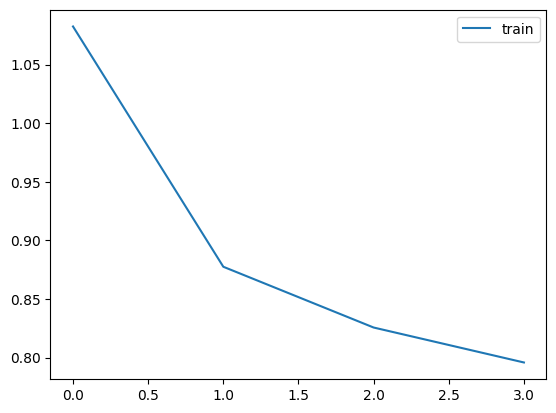

In [ ]:
train_losses = train(model)
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.885  acc:0.727
test  auc: 0.876  acc:0.698


Кластерный UNet 2 слоя:

Идея состоит в том, что у нас есть жури из трех членов (UNet-а) они независимо друг от друга дают свое мнение, каждый из членов жури отличается степенью превзятости (одни на первом слое отбирают больше фичей, другие меньше). Но в итоге они должны вынести общий вердикт. И он выносится как средняя оценка от 3 членов жури (объеденение результатов UNet).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class ClusteredUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) # оставляем для воспроизводимости результатов
        super().__init__()

        #Parser-----------------------------------------------------
        self.claster16 = double_conv(in_channels, 16)
        self.claster16_pool = nn.MaxPool2d(2)

        self.claster32 = double_conv(in_channels, 32)
        self.claster32_pool = nn.MaxPool2d(2)

        self.claster64 = double_conv(in_channels, 64)
        self.claster64_pool = nn.MaxPool2d(2)
        #Parser-----------------------------------------------------

        #Cluster16--------------------------------------------------
        #Encoder-------------
        self.encode_c16_conv1 = double_conv(16, 32)
        self.encode_c16_pool1 = nn.MaxPool2d(2)

        self.encode_c16_conv2 = double_conv(32, 64)
        self.encode_c16_pool2 = nn.MaxPool2d(2)
        #Encoder-------------

        #Center--------------
        self.center_c16 = double_conv(64, 128)
        #Center--------------

        #Decoder-------------
        self.decoder_c16_trans1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_c16_conv1 = double_conv(128, 64)

        self.decoder_c16_trans2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder_c16_conv2 = double_conv(64, 32)
        #Decoder-------------
        #Cluster16--------------------------------------------------

        #Cluster32--------------------------------------------------
        #Encoder-------------
        self.encode_c32_conv1 = double_conv(32, 64)
        self.encode_c32_pool1 = nn.MaxPool2d(2)

        self.encode_c32_conv2 = double_conv(64, 128)
        self.encode_c32_pool2 = nn.MaxPool2d(2)
        #Encoder-------------

        #Center--------------
        self.center_c32 = double_conv(128, 256)
        #Center--------------

        #Decoder-------------
        self.decoder_c32_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_c32_conv1 = double_conv(256, 128)

        self.decoder_c32_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_c32_conv2 = double_conv(128, 64)
        #Decoder-------------
        #Cluster32--------------------------------------------------

        #Cluster64--------------------------------------------------
        #Encoder-------------
        self.encode_c64_conv1 = double_conv(64, 128)
        self.encode_c64_pool1 = nn.MaxPool2d(2)

        self.encode_c64_conv2 = double_conv(128, 256)
        self.encode_c64_pool2 = nn.MaxPool2d(2)
        #Encoder-------------

        #Center--------------
        self.center_c64 = double_conv(256, 512)
        #Center--------------

        #Decoder-------------
        self.decoder_c64_trans1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_c64_conv1 = double_conv(512, 256)

        self.decoder_c64_trans2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_c64_conv2 = double_conv(256, 128)
        #Decoder-------------
        #Cluster64--------------------------------------------------

        #Output-----------------------------------------------------
        self.oneline_c16 = nn.Flatten()
        self.linear_c16 = nn.Linear(1568, 128)
        self.oneline_c32 = nn.Flatten()
        self.linear_c32 = nn.Linear(3136, 128)
        self.oneline_c64 = nn.Flatten()
        self.linear_c64 = nn.Linear(6272, 128)

        #self.linear_unite = nn.Linear(384, 60)
        self.linear_unite = nn.Linear(128, 60)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear_out = nn.Linear(60, num_classes)
        #Output-----------------------------------------------------

    def forward(self, x):
        #Parser-----------------------------------------------------
        #c16 = self.claster16(x)
        #c32 = self.claster32(x)
        #c64 = self.claster64(x)

        c16 = self.claster16(self.claster16_pool(x))
        c32 = self.claster32(self.claster32_pool(x))
        c64 = self.claster64(self.claster64_pool(x))
        #Parser-----------------------------------------------------

        #Cluster16--------------------------------------------------
        enc1_c16 = self.encode_c16_conv1(self.encode_c16_pool1(c16))
        enc2_c16 = self.encode_c16_conv2(self.encode_c16_pool2(enc1_c16))

        center = self.center_c16(enc2_c16)

        #1
        dec = self.decoder_c16_trans1(center)
        dec_resized = F.interpolate(dec, size=enc2_c16.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc2_c16], dim=1)
        dec = self.decoder_c16_conv1(dec)

        #2
        dec = self.decoder_c16_trans2(dec)
        dec_resized = F.interpolate(dec, size=enc1_c16.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc1_c16], dim=1)
        dec_16 = self.decoder_c16_conv2(dec)
        #Cluster16--------------------------------------------------

        #Cluster32--------------------------------------------------
        enc1_c32 = self.encode_c32_conv1(self.encode_c32_pool1(c32))
        enc2_c32 = self.encode_c32_conv2(self.encode_c32_pool2(enc1_c32))

        center = self.center_c32(enc2_c32)

        #1
        dec = self.decoder_c32_trans1(center)
        dec_resized = F.interpolate(dec, size=enc2_c32.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc2_c32], dim=1)
        dec = self.decoder_c32_conv1(dec)

        #2
        dec = self.decoder_c32_trans2(dec)
        dec_resized = F.interpolate(dec, size=enc1_c32.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc1_c32], dim=1)
        dec_32 = self.decoder_c32_conv2(dec)
        #Cluster32--------------------------------------------------

        #Cluster64--------------------------------------------------
        enc1_c64 = self.encode_c64_conv1(self.encode_c64_pool1(c64))
        enc2_c64 = self.encode_c64_conv2(self.encode_c64_pool2(enc1_c64))

        center = self.center_c64(enc2_c64)

        #1
        dec = self.decoder_c64_trans1(center)
        dec_resized = F.interpolate(dec, size=enc2_c64.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc2_c64], dim=1)
        dec = self.decoder_c64_conv1(dec)

        #2
        dec = self.decoder_c64_trans2(dec)
        dec_resized = F.interpolate(dec, size=enc1_c64.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc1_c64], dim=1)
        dec_64 = self.decoder_c64_conv2(dec)
        #Cluster64--------------------------------------------------

        #Output-----------------------------------------------------
        line_c16 = self.oneline_c16(dec_16) #size = [128, 1568]
        line_c32 = self.oneline_c32(dec_32) #size = [128, 3136]
        line_c64 = self.oneline_c64(dec_64) #size = [128, 6272]

        lin_c16 = self.linear_c16(line_c16)
        lin_c32 = self.linear_c32(line_c32)
        lin_c64 = self.linear_c64(line_c64)

        #lin_con = torch.cat((lin_c16, lin_c32, lin_c64), dim=1)
        lin_con = lin_c16 + lin_c32 + lin_c64
        lin_con = lin_con / 3.0

        output = self.linear_unite(lin_con)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear_out(output)
        output = torch.sigmoid(output)
        #Output-----------------------------------------------------

        return output

In [ ]:
model = ClusteredUNet(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 4
lr = 0.01

optimizer = optim.SGD(model.parameters(), lr=lr)

Обучение:

In [ ]:
def train(model):
    loss_train = []
    print('==> Training ...')
    for epoch in range(NUM_EPOCHS):
      model.train()
      loss_sum = 0.0
      for inputs, targets in tqdm(train_loader):
          inputs = inputs.to(device)
          targets = targets.to(device)

          # forward + backward + optimize
          optimizer.zero_grad()
          outputs = model(inputs)

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              #loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze()
              #loss = criterion(outputs, targets)
          loss = criterion(outputs, targets)
          print(f"loss={loss}");

          loss_sum += loss.detach().numpy();

          loss.backward()
          optimizer.step()
      loss_epoch = loss_sum / len(train_loader);
      loss_train.append(loss_epoch)
      print(f"{epoch}: loss={loss_epoch}");
    print('\n ==> Finished training')
    return loss_train

==> Training ...


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.967972993850708


  2%|▏         | 1/55 [00:05<04:48,  5.35s/it]

loss=1.9135074615478516


  4%|▎         | 2/55 [00:09<03:52,  4.39s/it]

loss=1.8605248928070068


  5%|▌         | 3/55 [00:11<03:01,  3.49s/it]

loss=1.7919648885726929


  7%|▋         | 4/55 [00:14<02:55,  3.44s/it]

loss=1.7262967824935913


  9%|▉         | 5/55 [00:17<02:34,  3.08s/it]

loss=1.7006393671035767


 11%|█         | 6/55 [00:19<02:20,  2.86s/it]

loss=1.6201249361038208


 13%|█▎        | 7/55 [00:22<02:10,  2.72s/it]

loss=1.4846625328063965


 15%|█▍        | 8/55 [00:24<02:07,  2.71s/it]

loss=1.4318523406982422


 16%|█▋        | 9/55 [00:27<02:10,  2.84s/it]

loss=1.3794186115264893


 18%|█▊        | 10/55 [00:30<02:02,  2.72s/it]

loss=1.2103545665740967


 20%|██        | 11/55 [00:32<01:56,  2.64s/it]

loss=1.2069467306137085


 22%|██▏       | 12/55 [00:35<01:51,  2.58s/it]

loss=1.2058254480361938


 24%|██▎       | 13/55 [00:38<01:52,  2.69s/it]

loss=1.3139238357543945


 25%|██▌       | 14/55 [00:41<01:51,  2.72s/it]

loss=1.1502351760864258


 27%|██▋       | 15/55 [00:43<01:45,  2.64s/it]

loss=1.2164024114608765


 29%|██▉       | 16/55 [00:45<01:40,  2.58s/it]

loss=1.176190972328186


 31%|███       | 17/55 [00:48<01:41,  2.66s/it]

loss=1.1089882850646973


 33%|███▎      | 18/55 [00:52<01:46,  2.87s/it]

loss=1.1693378686904907


 35%|███▍      | 19/55 [00:54<01:38,  2.74s/it]

loss=1.0850427150726318


 36%|███▋      | 20/55 [00:57<01:32,  2.65s/it]

loss=1.237265944480896


 38%|███▊      | 21/55 [00:59<01:27,  2.58s/it]

loss=1.1682249307632446


 40%|████      | 22/55 [01:01<01:23,  2.54s/it]

loss=1.2001771926879883


 42%|████▏     | 23/55 [01:05<01:29,  2.78s/it]

loss=1.242266058921814


 44%|████▎     | 24/55 [01:07<01:22,  2.68s/it]

loss=1.1165634393692017


 45%|████▌     | 25/55 [01:10<01:18,  2.60s/it]

loss=1.2842978239059448


 47%|████▋     | 26/55 [01:12<01:13,  2.55s/it]

loss=1.086350679397583


 49%|████▉     | 27/55 [01:15<01:12,  2.57s/it]

loss=1.1430648565292358


 51%|█████     | 28/55 [01:18<01:14,  2.75s/it]

loss=1.078599452972412


 53%|█████▎    | 29/55 [01:20<01:08,  2.65s/it]

loss=1.262801170349121


 55%|█████▍    | 30/55 [01:23<01:04,  2.59s/it]

loss=1.0712153911590576


 56%|█████▋    | 31/55 [01:25<01:00,  2.54s/it]

loss=1.0923982858657837


 58%|█████▊    | 32/55 [01:28<01:00,  2.63s/it]

loss=1.2521166801452637


 60%|██████    | 33/55 [01:31<01:03,  2.88s/it]

loss=1.106602668762207


 62%|██████▏   | 34/55 [01:34<00:57,  2.75s/it]

loss=1.2141594886779785


 64%|██████▎   | 35/55 [01:36<00:53,  2.65s/it]

loss=1.1170412302017212


 65%|██████▌   | 36/55 [01:39<00:49,  2.59s/it]

loss=1.1635956764221191


 67%|██████▋   | 37/55 [01:42<00:50,  2.79s/it]

loss=1.1286697387695312


 69%|██████▉   | 38/55 [01:44<00:45,  2.70s/it]

loss=0.9987446665763855


 71%|███████   | 39/55 [01:47<00:42,  2.63s/it]

loss=1.1561436653137207


 73%|███████▎  | 40/55 [01:49<00:38,  2.56s/it]

loss=1.1523951292037964


 75%|███████▍  | 41/55 [01:52<00:35,  2.52s/it]

loss=1.1382639408111572


 76%|███████▋  | 42/55 [01:55<00:35,  2.77s/it]

loss=1.0517808198928833


 78%|███████▊  | 43/55 [01:58<00:31,  2.67s/it]

loss=1.0224205255508423


 80%|████████  | 44/55 [02:00<00:28,  2.59s/it]

loss=1.0499919652938843


 82%|████████▏ | 45/55 [02:02<00:25,  2.54s/it]

loss=1.1878684759140015


 84%|████████▎ | 46/55 [02:05<00:22,  2.52s/it]

loss=1.0325502157211304


 85%|████████▌ | 47/55 [02:08<00:22,  2.75s/it]

loss=1.0537328720092773


 87%|████████▋ | 48/55 [02:11<00:18,  2.65s/it]

loss=1.0430837869644165


 89%|████████▉ | 49/55 [02:13<00:15,  2.58s/it]

loss=0.9907901287078857


 91%|█████████ | 50/55 [02:15<00:12,  2.54s/it]

loss=1.0854029655456543


 93%|█████████▎| 51/55 [02:18<00:10,  2.60s/it]

loss=0.9742671847343445


 95%|█████████▍| 52/55 [02:21<00:08,  2.73s/it]

loss=0.9056255221366882


 96%|█████████▋| 53/55 [02:24<00:05,  2.65s/it]

loss=1.0627957582473755


 98%|█████████▊| 54/55 [02:26<00:02,  2.58s/it]

loss=1.0496739149093628


100%|██████████| 55/55 [02:28<00:00,  2.70s/it]


0: loss=1.2298391829837452


  0%|          | 0/55 [00:00<?, ?it/s]

loss=0.9491198062896729


  2%|▏         | 1/55 [00:02<02:26,  2.71s/it]

loss=1.1326276063919067


  4%|▎         | 2/55 [00:05<02:39,  3.02s/it]

loss=0.8375705480575562


  5%|▌         | 3/55 [00:08<02:32,  2.94s/it]

loss=0.9641368985176086


  7%|▋         | 4/55 [00:11<02:19,  2.73s/it]

loss=1.1832466125488281


  9%|▉         | 5/55 [00:13<02:10,  2.62s/it]

loss=0.9284926652908325


 11%|█         | 6/55 [00:16<02:18,  2.82s/it]

loss=0.8659378290176392


 13%|█▎        | 7/55 [00:19<02:12,  2.75s/it]

loss=1.0693665742874146


 15%|█▍        | 8/55 [00:21<02:04,  2.65s/it]

loss=0.9842734336853027


 16%|█▋        | 9/55 [00:24<01:58,  2.59s/it]

loss=0.9369491934776306


 18%|█▊        | 10/55 [00:26<01:54,  2.53s/it]

loss=0.9685400128364563


 20%|██        | 11/55 [00:30<02:03,  2.80s/it]

loss=0.8826314210891724


 22%|██▏       | 12/55 [00:32<01:56,  2.71s/it]

loss=0.9512653350830078


 24%|██▎       | 13/55 [00:35<01:51,  2.65s/it]

loss=0.9780485033988953


 25%|██▌       | 14/55 [00:37<01:46,  2.59s/it]

loss=0.9216981530189514


 27%|██▋       | 15/55 [00:40<01:43,  2.59s/it]

loss=0.8282390832901001


 29%|██▉       | 16/55 [00:43<01:49,  2.80s/it]

loss=0.9396056532859802


 31%|███       | 17/55 [00:45<01:42,  2.70s/it]

loss=0.8733769655227661


 33%|███▎      | 18/55 [00:48<01:37,  2.63s/it]

loss=1.2061233520507812


 35%|███▍      | 19/55 [00:50<01:33,  2.58s/it]

loss=1.0447611808776855


 36%|███▋      | 20/55 [00:53<01:33,  2.68s/it]

loss=0.984700620174408


 38%|███▊      | 21/55 [00:56<01:33,  2.74s/it]

loss=1.2788506746292114


 40%|████      | 22/55 [00:59<01:27,  2.65s/it]

loss=0.9492429494857788


 42%|████▏     | 23/55 [01:01<01:22,  2.59s/it]

loss=1.080078125


 44%|████▎     | 24/55 [01:04<01:19,  2.56s/it]

loss=1.1011009216308594


 45%|████▌     | 25/55 [01:07<01:22,  2.76s/it]

loss=1.0798028707504272


 47%|████▋     | 26/55 [01:09<01:18,  2.72s/it]

loss=0.8994508981704712


 49%|████▉     | 27/55 [01:12<01:13,  2.64s/it]

loss=0.8969421982765198


 51%|█████     | 28/55 [01:14<01:09,  2.58s/it]

loss=1.012030839920044


 53%|█████▎    | 29/55 [01:17<01:05,  2.54s/it]

loss=0.9980933666229248


 55%|█████▍    | 30/55 [01:20<01:09,  2.79s/it]

loss=1.0084786415100098


 56%|█████▋    | 31/55 [01:23<01:04,  2.69s/it]

loss=1.0092753171920776


 58%|█████▊    | 32/55 [01:25<01:00,  2.61s/it]

loss=0.9559193849563599


 60%|██████    | 33/55 [01:27<00:56,  2.55s/it]

loss=1.047371745109558


 62%|██████▏   | 34/55 [01:30<00:52,  2.51s/it]

loss=0.9481635093688965


 64%|██████▎   | 35/55 [01:33<00:55,  2.78s/it]

loss=0.9031838774681091


 65%|██████▌   | 36/55 [01:36<00:50,  2.67s/it]

loss=1.1390410661697388


 67%|██████▋   | 37/55 [01:38<00:46,  2.60s/it]

loss=1.11135995388031


 69%|██████▉   | 38/55 [01:41<00:43,  2.56s/it]

loss=1.0192508697509766


 71%|███████   | 39/55 [01:43<00:41,  2.59s/it]

loss=1.040202021598816


 73%|███████▎  | 40/55 [01:46<00:41,  2.74s/it]

loss=1.0815021991729736


 75%|███████▍  | 41/55 [01:49<00:37,  2.66s/it]

loss=1.047253966331482


 76%|███████▋  | 42/55 [01:51<00:33,  2.60s/it]

loss=1.178250789642334


 78%|███████▊  | 43/55 [01:54<00:30,  2.55s/it]

loss=0.9294804930686951


 80%|████████  | 44/55 [01:57<00:29,  2.68s/it]

loss=0.9683753252029419


 82%|████████▏ | 45/55 [01:59<00:27,  2.72s/it]

loss=0.9001946449279785


 84%|████████▎ | 46/55 [02:02<00:23,  2.63s/it]

loss=0.9962895512580872


 85%|████████▌ | 47/55 [02:04<00:20,  2.58s/it]

loss=1.0916528701782227


 87%|████████▋ | 48/55 [02:07<00:17,  2.53s/it]

loss=1.0395874977111816


 89%|████████▉ | 49/55 [02:10<00:16,  2.75s/it]

loss=0.8787521719932556


 91%|█████████ | 50/55 [02:13<00:13,  2.68s/it]

loss=1.0694149732589722


 93%|█████████▎| 51/55 [02:15<00:10,  2.61s/it]

loss=0.9722397327423096


 95%|█████████▍| 52/55 [02:17<00:07,  2.57s/it]

loss=0.9747948050498962


 96%|█████████▋| 53/55 [02:20<00:05,  2.53s/it]

loss=1.0450224876403809


 98%|█████████▊| 54/55 [02:23<00:02,  2.79s/it]

loss=1.1637722253799438


100%|██████████| 55/55 [02:25<00:00,  2.65s/it]


1: loss=1.0044569893316788


  0%|          | 0/55 [00:00<?, ?it/s]

loss=1.0391039848327637


  2%|▏         | 1/55 [00:02<02:12,  2.46s/it]

loss=0.92168128490448


  4%|▎         | 2/55 [00:04<02:10,  2.46s/it]

loss=1.0131068229675293


  5%|▌         | 3/55 [00:07<02:07,  2.45s/it]

loss=0.8042258620262146


  7%|▋         | 4/55 [00:10<02:23,  2.81s/it]

loss=0.9396743178367615


  9%|▉         | 5/55 [00:13<02:14,  2.69s/it]

loss=0.9215382933616638


 11%|█         | 6/55 [00:15<02:08,  2.62s/it]

loss=0.8652011156082153


 13%|█▎        | 7/55 [00:18<02:03,  2.57s/it]

loss=0.8966475129127502


 15%|█▍        | 8/55 [00:20<02:01,  2.58s/it]

loss=1.0728836059570312


 16%|█▋        | 9/55 [00:24<02:10,  2.84s/it]

loss=0.8897153735160828


 18%|█▊        | 10/55 [00:26<02:03,  2.73s/it]

loss=0.9758728742599487


 20%|██        | 11/55 [00:29<01:57,  2.66s/it]

loss=0.9754758477210999


 22%|██▏       | 12/55 [00:31<01:52,  2.61s/it]

loss=1.050754427909851


 24%|██▎       | 13/55 [00:34<01:54,  2.73s/it]

loss=0.9342170357704163


 25%|██▌       | 14/55 [00:37<01:54,  2.79s/it]

loss=0.8596762418746948


 27%|██▋       | 15/55 [00:40<01:48,  2.70s/it]

loss=1.0883958339691162


 29%|██▉       | 16/55 [00:42<01:42,  2.64s/it]

loss=0.9885164499282837


 31%|███       | 17/55 [00:45<01:38,  2.59s/it]

loss=1.082148790359497


 33%|███▎      | 18/55 [00:48<01:45,  2.85s/it]

loss=1.0425001382827759


 35%|███▍      | 19/55 [00:50<01:38,  2.74s/it]

loss=0.8692083954811096


 36%|███▋      | 20/55 [00:53<01:33,  2.67s/it]

loss=0.9646677374839783


 38%|███▊      | 21/55 [00:55<01:28,  2.61s/it]

loss=0.8327641487121582


 40%|████      | 22/55 [00:58<01:25,  2.58s/it]

loss=0.8831625580787659


 42%|████▏     | 23/55 [01:01<01:30,  2.82s/it]

loss=1.1408401727676392


 44%|████▎     | 24/55 [01:04<01:24,  2.72s/it]

loss=0.8234668970108032


 45%|████▌     | 25/55 [01:06<01:19,  2.64s/it]

loss=0.8818939924240112


 47%|████▋     | 26/55 [01:09<01:15,  2.59s/it]

loss=1.0393446683883667


 49%|████▉     | 27/55 [01:12<01:14,  2.66s/it]

loss=1.0445092916488647


 51%|█████     | 28/55 [01:15<01:14,  2.78s/it]

loss=0.9847506880760193


 53%|█████▎    | 29/55 [01:17<01:10,  2.69s/it]

loss=0.8450844883918762


 55%|█████▍    | 30/55 [01:20<01:05,  2.63s/it]

loss=0.9607122540473938


 56%|█████▋    | 31/55 [01:22<01:02,  2.59s/it]

loss=0.8580808639526367


 58%|█████▊    | 32/55 [01:25<01:03,  2.77s/it]

loss=1.1057488918304443


 60%|██████    | 33/55 [01:28<01:00,  2.73s/it]

loss=0.7720857858657837


 62%|██████▏   | 34/55 [01:30<00:55,  2.65s/it]

loss=0.8439704775810242


 64%|██████▎   | 35/55 [01:33<00:52,  2.60s/it]

loss=0.8850593566894531


 65%|██████▌   | 36/55 [01:35<00:48,  2.57s/it]

loss=0.915073573589325


 67%|██████▋   | 37/55 [01:39<00:51,  2.84s/it]

loss=0.8349290490150452


 69%|██████▉   | 38/55 [01:41<00:46,  2.74s/it]

loss=0.9947319030761719


 71%|███████   | 39/55 [01:44<00:42,  2.66s/it]

loss=0.9545047283172607


 73%|███████▎  | 40/55 [01:46<00:39,  2.61s/it]

loss=1.1456472873687744


 75%|███████▍  | 41/55 [01:49<00:37,  2.65s/it]

loss=0.8116287589073181


 76%|███████▋  | 42/55 [01:52<00:36,  2.81s/it]

loss=1.1472665071487427


 78%|███████▊  | 43/55 [01:55<00:32,  2.71s/it]

loss=0.9610375165939331


 80%|████████  | 44/55 [01:57<00:29,  2.64s/it]

loss=1.0041583776474


 82%|████████▏ | 45/55 [02:00<00:26,  2.60s/it]

loss=0.8414555788040161


 84%|████████▎ | 46/55 [02:03<00:24,  2.77s/it]

loss=0.8420670032501221


 85%|████████▌ | 47/55 [02:06<00:22,  2.76s/it]

loss=0.9686245918273926


 87%|████████▋ | 48/55 [02:08<00:18,  2.68s/it]

loss=0.9624406099319458


 89%|████████▉ | 49/55 [02:11<00:15,  2.63s/it]

loss=0.8171885013580322


 91%|█████████ | 50/55 [02:13<00:12,  2.60s/it]

loss=0.8253844976425171


 93%|█████████▎| 51/55 [02:17<00:11,  2.85s/it]

loss=0.8824800848960876


 95%|█████████▍| 52/55 [02:19<00:08,  2.73s/it]

loss=0.9929947257041931


 96%|█████████▋| 53/55 [02:22<00:05,  2.65s/it]

loss=0.7753176093101501


 98%|█████████▊| 54/55 [02:24<00:02,  2.60s/it]

loss=1.0936721563339233


100%|██████████| 55/55 [02:26<00:00,  2.66s/it]


2: loss=0.9430416280573065


  0%|          | 0/55 [00:00<?, ?it/s]

loss=0.9418561458587646


  2%|▏         | 1/55 [00:03<03:03,  3.40s/it]

loss=0.9052096605300903


  4%|▎         | 2/55 [00:05<02:31,  2.86s/it]

loss=0.896699845790863


  5%|▌         | 3/55 [00:08<02:19,  2.68s/it]

loss=1.0094963312149048


  7%|▋         | 4/55 [00:10<02:12,  2.60s/it]

loss=1.0171492099761963


  9%|▉         | 5/55 [00:13<02:09,  2.60s/it]

loss=0.8973712921142578


 11%|█         | 6/55 [00:16<02:19,  2.84s/it]

loss=0.9170050024986267


 13%|█▎        | 7/55 [00:19<02:10,  2.73s/it]

loss=0.7963265180587769


 15%|█▍        | 8/55 [00:21<02:04,  2.65s/it]

loss=0.9384489059448242


 16%|█▋        | 9/55 [00:24<01:58,  2.58s/it]

loss=0.9672306180000305


 18%|█▊        | 10/55 [00:27<02:01,  2.69s/it]

loss=0.9389876127243042


 20%|██        | 11/55 [00:30<02:01,  2.76s/it]

loss=0.9207497835159302


 22%|██▏       | 12/55 [00:32<01:54,  2.67s/it]

loss=0.8295761346817017


 24%|██▎       | 13/55 [00:34<01:49,  2.60s/it]

loss=0.7857623100280762


 25%|██▌       | 14/55 [00:37<01:45,  2.56s/it]

loss=0.9600750803947449


 27%|██▋       | 15/55 [00:40<01:52,  2.81s/it]

loss=0.9456761479377747


 29%|██▉       | 16/55 [00:43<01:46,  2.74s/it]

loss=1.0257761478424072


 31%|███       | 17/55 [00:45<01:41,  2.67s/it]

loss=0.83301842212677


 33%|███▎      | 18/55 [00:48<01:36,  2.61s/it]

loss=0.9780458807945251


 35%|███▍      | 19/55 [00:50<01:32,  2.57s/it]

loss=1.0500837564468384


 36%|███▋      | 20/55 [00:54<01:38,  2.82s/it]

loss=0.8010424375534058


 38%|███▊      | 21/55 [00:56<01:32,  2.73s/it]

loss=0.9720956683158875


 40%|████      | 22/55 [00:59<01:27,  2.66s/it]

loss=0.8727008700370789


 42%|████▏     | 23/55 [01:01<01:23,  2.60s/it]

loss=0.771862268447876


 44%|████▎     | 24/55 [01:04<01:21,  2.64s/it]

loss=0.9327436685562134


 45%|████▌     | 25/55 [01:07<01:23,  2.78s/it]

loss=0.820919930934906


 47%|████▋     | 26/55 [01:09<01:17,  2.69s/it]

loss=0.8338834643363953


 49%|████▉     | 27/55 [01:12<01:13,  2.63s/it]

loss=0.6464425325393677


 51%|█████     | 28/55 [01:14<01:09,  2.58s/it]

loss=1.006977915763855


 53%|█████▎    | 29/55 [01:18<01:11,  2.74s/it]

loss=0.8608940243721008


 55%|█████▍    | 30/55 [01:20<01:08,  2.74s/it]

loss=0.8885664343833923


 56%|█████▋    | 31/55 [01:23<01:03,  2.65s/it]

loss=1.1491562128067017


 58%|█████▊    | 32/55 [01:25<00:59,  2.60s/it]

loss=0.9172269701957703


 60%|██████    | 33/55 [01:28<00:56,  2.55s/it]

loss=0.9776986837387085


 62%|██████▏   | 34/55 [01:31<00:58,  2.80s/it]

loss=0.8172102570533752


 64%|██████▎   | 35/55 [01:34<00:54,  2.70s/it]

loss=0.7859101891517639


 65%|██████▌   | 36/55 [01:36<00:49,  2.62s/it]

loss=1.0256881713867188


 67%|██████▋   | 37/55 [01:38<00:46,  2.57s/it]

loss=0.9456304311752319


 69%|██████▉   | 38/55 [01:41<00:43,  2.54s/it]

loss=0.8573094606399536


 71%|███████   | 39/55 [01:44<00:44,  2.79s/it]

loss=1.0713779926300049


 73%|███████▎  | 40/55 [01:47<00:40,  2.70s/it]

loss=0.841216504573822


 75%|███████▍  | 41/55 [01:49<00:36,  2.64s/it]

loss=0.7657486200332642


 76%|███████▋  | 42/55 [01:52<00:33,  2.58s/it]

loss=0.6583561897277832


 78%|███████▊  | 43/55 [01:54<00:31,  2.63s/it]

loss=0.8903117179870605


 80%|████████  | 44/55 [01:58<00:30,  2.77s/it]

loss=0.9073584079742432


 82%|████████▏ | 45/55 [02:00<00:26,  2.67s/it]

loss=0.8096423745155334


 84%|████████▎ | 46/55 [02:02<00:23,  2.61s/it]

loss=0.9222861528396606


 85%|████████▌ | 47/55 [02:05<00:20,  2.57s/it]

loss=0.9760480523109436


 87%|████████▋ | 48/55 [02:08<00:18,  2.71s/it]

loss=0.8193049430847168


 89%|████████▉ | 49/55 [02:11<00:16,  2.73s/it]

loss=0.7478672862052917


 91%|█████████ | 50/55 [02:13<00:13,  2.65s/it]

loss=1.1749755144119263


 93%|█████████▎| 51/55 [02:16<00:10,  2.58s/it]

loss=0.9421684741973877


 95%|█████████▍| 52/55 [02:18<00:07,  2.55s/it]

loss=0.900899350643158


 96%|█████████▋| 53/55 [02:21<00:05,  2.79s/it]

loss=0.8363201022148132


 98%|█████████▊| 54/55 [02:24<00:02,  2.70s/it]

loss=0.9231092929840088


100%|██████████| 55/55 [02:26<00:00,  2.66s/it]

3: loss=0.9022817340764132

 ==> Finished training


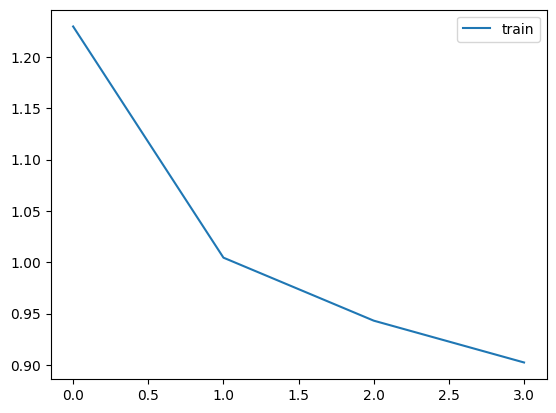

In [ ]:
train_losses = train(model)
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

Тестипование:

In [ ]:
def test_split(model, split):
    model.eval()
    y_score = torch.tensor([]).to(device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

def test(model):
    print('==> Evaluating ...')
    test_split(model, 'train')
    test_split(model, 'test')

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.843  acc:0.699
test  auc: 0.838  acc:0.691


Обычный UNet (2 слоя):

==> Evaluating ...

train  auc: 0.885  acc:0.727

test  auc: 0.876  acc:0.698


Обычный UNet (3 слоя):

==> Evaluating ...

train  auc: 0.898  acc:0.735

test  auc: 0.889  acc:0.713


Экеперементальная архитектура не смогла стать лучше более приметивных аналогов.

Возможно несколько причин:
1. Объедненние результатов всех кластеров через среднее арифмеическое может явзяться не лучшей идеей.
  * Вариант решения: по элементно найти максимальное и минимальное значение для каждой ячейки, получить матрицу максимумов и минимумов и отнять их друг от друга. Это и будет окончательным решением "жури".
2. UNet-ы в кластреах изолированы друг от друга, возможно добавление функции влияния друг на друга улучшит результаты.
  * Вариант __Шизофрения__: UNet-ы должны иметь "общее" дно, но как это одно будет обобщаться между тремя или более кластерами - вопрос хороший.
3. UNet-ы при обчучении не борются за влияние, возможно добавление весов на кыждый выход UNet-а сделает сеть более точной.

Отклеить на encode изображение от UNet-ов сконскатить decode изображения, потом к ним добавть encode (первое).

# ClasteredUNet+

Попытаемся равномерно распределить классы в датасете:

In [ ]:
import torch
from torch.utils.data import ConcatDataset, random_split, Dataset, Subset, DataLoader
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split

#Объединение датасетов
all_data = ConcatDataset([train_dataset, test_dataset])

#Получение меток
train_labels = np.array(train_dataset.labels)
test_labels = np.array(test_dataset.labels)
all_labels = np.concatenate((train_labels, test_labels))

#Разделение на train/test с использованием стратификации
train_indices, test_indices, _, _ = train_test_split(
    np.arange(len(all_data)),
    all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

#Создание Subset-ов
train_dataset2 = Subset(all_data, train_indices)
test_dataset2 = Subset(all_data, test_indices)

BATCH_SIZE = 128

train_loader = DataLoader(dataset=train_dataset2, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset2, batch_size=2 * BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset2, batch_size=2 * BATCH_SIZE, shuffle=False)

In [ ]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False)

________________________________________________________________________________


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class ClusteredUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) 
        super().__init__()

        #Parser-----------------------------------------------------
        self.claster16 = double_conv(in_channels, 16)
        self.claster16_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.claster32 = double_conv(in_channels, 32)
        self.claster32_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.claster64 = double_conv(in_channels, 64)
        self.claster64_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #Parser-----------------------------------------------------

        #Cluster16--------------------------------------------------
        #Encoder-------------
        self.encode_c16_conv1 = double_conv(16, 32)
        self.encode_c16_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encode_c16_conv2 = double_conv(32, 64)
        self.encode_c16_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Encoder-------------

        #Center--------------
        self.center_c16 = double_conv(64, 128)
        #Center--------------

        #Decoder-------------
        self.decoder_c16_trans1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_c16_conv1 = double_conv(128, 64)

        self.decoder_c16_trans2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder_c16_conv2 = double_conv(64, 32) #!
        #Decoder-------------
        #Cluster16--------------------------------------------------

        #Cluster32--------------------------------------------------
        #Encoder-------------
        self.encode_c32_conv1 = double_conv(32, 64)
        self.encode_c32_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encode_c32_conv2 = double_conv(64, 128)
        self.encode_c32_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Encoder-------------

        #Center--------------
        self.center_c32 = double_conv(128, 256)
        #Center--------------

        #Decoder-------------
        self.decoder_c32_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_c32_conv1 = double_conv(256, 128)

        self.decoder_c32_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_c32_conv2 = double_conv(128, 32) #!
        #Decoder-------------
        #Cluster32--------------------------------------------------

        #Cluster64--------------------------------------------------
        #Encoder-------------
        self.encode_c64_conv1 = double_conv(64, 128)
        self.encode_c64_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encode_c64_conv2 = double_conv(128, 256)
        self.encode_c64_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Encoder-------------

        #Center--------------
        self.center_c64 = double_conv(256, 512)
        #Center--------------

        #Decoder-------------
        self.decoder_c64_trans1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_c64_conv1 = double_conv(512, 256)

        self.decoder_c64_trans2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_c64_conv2 = double_conv(256, 32) #!
        #Decoder-------------
        #Cluster64--------------------------------------------------

        self.width = nn.Sigmoid()

        #CNN--------------------------------------------------------
        self.cnn1 = double_conv(99, 50)
        self.cnn1_pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.cnn2 = double_conv(50, 20)
        self.cnn2_pool = nn.MaxPool2d(kernel_size=2, stride=1)
        #CNN--------------------------------------------------------

        #Output-----------------------------------------------------
        self.oneline = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(500, 60)
        self.linear_out = nn.Linear(60, num_classes)
        #Output-----------------------------------------------------

    def forward(self, x):
        #Parser-----------------------------------------------------
        c16 = self.claster16_pool(self.claster16(x))
        c32 = self.claster32_pool(self.claster32(x))
        c64 = self.claster64_pool(self.claster64(x))
        #Parser-----------------------------------------------------

        #Cluster16--------------------------------------------------
        enc1_c16 = self.encode_c16_conv1(self.encode_c16_pool1(c16))
        enc2_c16 = self.encode_c16_conv2(self.encode_c16_pool2(enc1_c16))

        center = self.center_c16(enc2_c16)

        #1
        dec = self.decoder_c16_trans1(center)
        dec_resized = F.interpolate(dec, size=enc2_c16.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc2_c16], dim=1)
        dec = self.decoder_c16_conv1(dec)

        #2
        dec = self.decoder_c16_trans2(dec)
        dec_resized = F.interpolate(dec, size=enc1_c16.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc1_c16], dim=1)
        dec_16 = self.decoder_c16_conv2(dec)
        #Cluster16--------------------------------------------------

        #Cluster32--------------------------------------------------
        enc1_c32 = self.encode_c32_conv1(self.encode_c32_pool1(c32))
        enc2_c32 = self.encode_c32_conv2(self.encode_c32_pool2(enc1_c32))

        center = self.center_c32(enc2_c32)

        #1
        dec = self.decoder_c32_trans1(center)
        dec_resized = F.interpolate(dec, size=enc2_c32.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc2_c32], dim=1)
        dec = self.decoder_c32_conv1(dec)

        #2
        dec = self.decoder_c32_trans2(dec)
        dec_resized = F.interpolate(dec, size=enc1_c32.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc1_c32], dim=1)
        dec_32 = self.decoder_c32_conv2(dec)
        #Cluster32--------------------------------------------------

        #Cluster64--------------------------------------------------
        enc1_c64 = self.encode_c64_conv1(self.encode_c64_pool1(c64))
        enc2_c64 = self.encode_c64_conv2(self.encode_c64_pool2(enc1_c64))

        center = self.center_c64(enc2_c64)

        #1
        dec = self.decoder_c64_trans1(center)
        dec_resized = F.interpolate(dec, size=enc2_c64.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc2_c64], dim=1)
        dec = self.decoder_c64_conv1(dec)

        #2
        dec = self.decoder_c64_trans2(dec)
        dec_resized = F.interpolate(dec, size=enc1_c64.size()[2:], mode='bilinear', align_corners=False)
        dec = torch.cat([dec_resized, enc1_c64], dim=1)
        dec_64 = self.decoder_c64_conv2(dec)
        #Cluster64--------------------------------------------------

        #Unite UNets------------------------------------------------
        width_16 = self.width(dec_16)
        width_32 = self.width(dec_32)
        width_64 = self.width(dec_64)

        #width_unite = width_16 * width_32 * width_64
        width_unite = torch.cat([width_16, width_32, width_64], dim=1)

        x_resized = F.interpolate(x, size=width_unite.size()[2:], mode='bilinear', align_corners=False)
        output1 = torch.cat((width_unite, x_resized), dim=1) #Добавим матрицу весов к исходному изображению.
        #Unite UNets------------------------------------------------

        #CNN--------------------------------------------------------
        output1 = self.cnn1_pool(self.cnn1(output1))
        output1 = self.relu(output1)
        output1 = self.cnn2_pool(self.cnn2(output1))
        output1 = self.relu(output1)
        #CNN--------------------------------------------------------

        #Output-----------------------------------------------------
        output1 = self.oneline(output1)
        output1 = self.linear1(output1)
        output1 = self.linear_out(output1)
        output1 = self.width(output1)
        #Output-----------------------------------------------------

        return output1

In [ ]:
model = ClusteredUNet(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 1
lr = 0.01

optimizer = optim.SGD(model.parameters(), lr=lr)

==> Training ...


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.9006558656692505


  2%|▏         | 1/57 [00:06<05:56,  6.37s/it]

loss=1.8070290088653564


  4%|▎         | 2/57 [00:10<04:33,  4.98s/it]

loss=1.7746481895446777


  5%|▌         | 3/57 [00:14<03:59,  4.44s/it]

loss=1.7512351274490356


  7%|▋         | 4/57 [00:17<03:41,  4.19s/it]

loss=1.7074010372161865


  9%|▉         | 5/57 [00:21<03:28,  4.01s/it]

loss=1.6851611137390137


 11%|█         | 6/57 [00:25<03:17,  3.87s/it]

loss=1.6715433597564697


 12%|█▏        | 7/57 [00:28<03:04,  3.69s/it]

loss=1.6487528085708618


 14%|█▍        | 8/57 [00:31<02:52,  3.53s/it]

loss=1.6368635892868042


 16%|█▌        | 9/57 [00:35<02:47,  3.49s/it]

loss=1.6663457155227661


 18%|█▊        | 10/57 [00:38<02:44,  3.49s/it]

loss=1.6106107234954834


 19%|█▉        | 11/57 [00:42<02:39,  3.46s/it]

loss=1.6238740682601929


 21%|██        | 12/57 [00:45<02:32,  3.38s/it]

loss=1.6205472946166992


 23%|██▎       | 13/57 [00:48<02:33,  3.48s/it]

loss=1.620259404182434


 25%|██▍       | 14/57 [00:52<02:31,  3.52s/it]

loss=1.6029887199401855


 26%|██▋       | 15/57 [00:55<02:24,  3.45s/it]

loss=1.5458191633224487


 28%|██▊       | 16/57 [00:59<02:22,  3.47s/it]

loss=1.534204125404358


 30%|██▉       | 17/57 [01:02<02:17,  3.45s/it]

loss=1.5344825983047485


 32%|███▏      | 18/57 [01:06<02:17,  3.52s/it]

loss=1.5240398645401


 33%|███▎      | 19/57 [01:10<02:17,  3.61s/it]

loss=1.5584264993667603


 35%|███▌      | 20/57 [01:13<02:13,  3.60s/it]

loss=1.545029640197754


 37%|███▋      | 21/57 [01:17<02:07,  3.54s/it]

loss=1.517220377922058


 39%|███▊      | 22/57 [01:20<02:03,  3.53s/it]

loss=1.4829028844833374


 40%|████      | 23/57 [01:24<02:00,  3.55s/it]

loss=1.5929499864578247


 42%|████▏     | 24/57 [01:27<01:57,  3.57s/it]

loss=1.4947761297225952


 44%|████▍     | 25/57 [01:31<01:54,  3.57s/it]

loss=1.5232079029083252


 46%|████▌     | 26/57 [01:35<01:50,  3.55s/it]

loss=1.5442228317260742


 47%|████▋     | 27/57 [01:38<01:46,  3.54s/it]

loss=1.5112028121948242


 49%|████▉     | 28/57 [01:42<01:43,  3.59s/it]

loss=1.4935150146484375


 51%|█████     | 29/57 [01:45<01:39,  3.56s/it]

loss=1.561300277709961


 53%|█████▎    | 30/57 [01:49<01:36,  3.57s/it]

loss=1.5083720684051514


 54%|█████▍    | 31/57 [01:52<01:32,  3.55s/it]

loss=1.5376604795455933


 56%|█████▌    | 32/57 [01:56<01:29,  3.60s/it]

loss=1.548981785774231


 58%|█████▊    | 33/57 [01:59<01:24,  3.54s/it]

loss=1.4824717044830322


 60%|█████▉    | 34/57 [02:03<01:20,  3.50s/it]

loss=1.5169154405593872


 61%|██████▏   | 35/57 [02:06<01:16,  3.47s/it]

loss=1.5431541204452515


 63%|██████▎   | 36/57 [02:10<01:12,  3.45s/it]

loss=1.4920916557312012


 65%|██████▍   | 37/57 [02:13<01:08,  3.43s/it]

loss=1.5037728548049927


 67%|██████▋   | 38/57 [02:16<01:04,  3.39s/it]

loss=1.4566116333007812


 68%|██████▊   | 39/57 [02:20<01:02,  3.46s/it]

loss=1.4590044021606445


 70%|███████   | 40/57 [02:24<01:00,  3.59s/it]

loss=1.5302482843399048


 72%|███████▏  | 41/57 [02:27<00:56,  3.53s/it]

loss=1.4986295700073242


 74%|███████▎  | 42/57 [02:31<00:54,  3.64s/it]

loss=1.4785826206207275


 75%|███████▌  | 43/57 [02:35<00:51,  3.66s/it]

loss=1.4765021800994873


 77%|███████▋  | 44/57 [02:38<00:47,  3.64s/it]

loss=1.480576515197754


 79%|███████▉  | 45/57 [02:42<00:43,  3.66s/it]

loss=1.4957722425460815


 81%|████████  | 46/57 [02:46<00:40,  3.67s/it]

loss=1.476985216140747


 82%|████████▏ | 47/57 [02:49<00:35,  3.53s/it]

loss=1.4293133020401


 84%|████████▍ | 48/57 [02:53<00:31,  3.55s/it]

loss=1.5214645862579346


 86%|████████▌ | 49/57 [02:56<00:27,  3.45s/it]

loss=1.527801752090454


 88%|████████▊ | 50/57 [03:00<00:24,  3.52s/it]

loss=1.4913145303726196


 89%|████████▉ | 51/57 [03:03<00:20,  3.43s/it]

loss=1.5022284984588623


 91%|█████████ | 52/57 [03:07<00:17,  3.54s/it]

loss=1.5013560056686401


 93%|█████████▎| 53/57 [03:10<00:13,  3.44s/it]

loss=1.551335334777832


 95%|█████████▍| 54/57 [03:13<00:10,  3.37s/it]

loss=1.5170814990997314


 96%|█████████▋| 55/57 [03:17<00:07,  3.64s/it]

loss=1.482629418373108


 98%|█████████▊| 56/57 [03:21<00:03,  3.75s/it]

loss=1.4611234664916992


100%|██████████| 57/57 [03:25<00:00,  3.61s/it]


0: loss=1.5572490692138672


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.5117090940475464


  2%|▏         | 1/57 [00:04<03:55,  4.20s/it]

loss=1.5368746519088745


  4%|▎         | 2/57 [00:07<03:25,  3.73s/it]

loss=1.4863539934158325


  5%|▌         | 3/57 [00:10<03:08,  3.49s/it]

loss=1.47334885597229


  7%|▋         | 4/57 [00:14<03:09,  3.57s/it]

loss=1.5661165714263916


  9%|▉         | 5/57 [00:17<03:02,  3.51s/it]

loss=1.4321026802062988


 11%|█         | 6/57 [00:21<03:00,  3.54s/it]

loss=1.4800167083740234


 12%|█▏        | 7/57 [00:25<02:57,  3.56s/it]

loss=1.3942769765853882


 14%|█▍        | 8/57 [00:28<02:51,  3.51s/it]

loss=1.4666681289672852


 16%|█▌        | 9/57 [00:32<02:51,  3.57s/it]

loss=1.5320491790771484


 18%|█▊        | 10/57 [00:35<02:48,  3.58s/it]

loss=1.4479104280471802


 19%|█▉        | 11/57 [00:39<02:42,  3.52s/it]

loss=1.5266116857528687


 21%|██        | 12/57 [00:42<02:39,  3.55s/it]

loss=1.4796985387802124


 23%|██▎       | 13/57 [00:46<02:35,  3.53s/it]

loss=1.4790267944335938


 25%|██▍       | 14/57 [00:49<02:32,  3.55s/it]

loss=1.4981948137283325


 26%|██▋       | 15/57 [00:53<02:32,  3.63s/it]

loss=1.4669791460037231


 28%|██▊       | 16/57 [00:57<02:29,  3.65s/it]

loss=1.4925938844680786


 30%|██▉       | 17/57 [01:01<02:26,  3.66s/it]

loss=1.4747954607009888


 32%|███▏      | 18/57 [01:04<02:16,  3.50s/it]

loss=1.4792797565460205


 33%|███▎      | 19/57 [01:07<02:12,  3.50s/it]

loss=1.5221850872039795


 35%|███▌      | 20/57 [01:11<02:10,  3.53s/it]

loss=1.4876224994659424


 37%|███▋      | 21/57 [01:14<02:06,  3.52s/it]

loss=1.4357014894485474


 39%|███▊      | 22/57 [01:18<02:04,  3.54s/it]

loss=1.5031377077102661


 40%|████      | 23/57 [01:22<02:01,  3.56s/it]

loss=1.4808639287948608


 42%|████▏     | 24/57 [01:25<01:55,  3.51s/it]

loss=1.4359642267227173


 44%|████▍     | 25/57 [01:28<01:52,  3.51s/it]

loss=1.4797452688217163


 46%|████▌     | 26/57 [01:32<01:52,  3.63s/it]

loss=1.5121386051177979


 47%|████▋     | 27/57 [01:36<01:47,  3.59s/it]

loss=1.470805048942566


 49%|████▉     | 28/57 [01:39<01:41,  3.50s/it]

loss=1.483745813369751


 51%|█████     | 29/57 [01:42<01:33,  3.35s/it]

loss=1.4321205615997314


 53%|█████▎    | 30/57 [01:46<01:35,  3.55s/it]

loss=1.4873242378234863


 54%|█████▍    | 31/57 [01:50<01:34,  3.65s/it]

loss=1.518606185913086


 56%|█████▌    | 32/57 [01:54<01:33,  3.76s/it]

loss=1.4837898015975952


 58%|█████▊    | 33/57 [01:58<01:28,  3.71s/it]

loss=1.4632072448730469


 60%|█████▉    | 34/57 [02:01<01:23,  3.62s/it]

loss=1.5195127725601196


 61%|██████▏   | 35/57 [02:05<01:18,  3.58s/it]

loss=1.455513834953308


 63%|██████▎   | 36/57 [02:08<01:14,  3.56s/it]

loss=1.4104548692703247


 65%|██████▍   | 37/57 [02:11<01:10,  3.51s/it]

loss=1.4890505075454712


 67%|██████▋   | 38/57 [02:15<01:08,  3.60s/it]

loss=1.5292572975158691


 68%|██████▊   | 39/57 [02:19<01:06,  3.72s/it]

loss=1.485550880432129


 70%|███████   | 40/57 [02:23<01:03,  3.74s/it]

loss=1.4470438957214355


 72%|███████▏  | 41/57 [02:26<00:57,  3.61s/it]

loss=1.4913291931152344


 74%|███████▎  | 42/57 [02:30<00:52,  3.49s/it]

loss=1.4425795078277588


 75%|███████▌  | 43/57 [02:33<00:48,  3.43s/it]

loss=1.5309574604034424


 77%|███████▋  | 44/57 [02:36<00:44,  3.42s/it]

loss=1.456620454788208


 79%|███████▉  | 45/57 [02:40<00:40,  3.39s/it]

loss=1.4640328884124756


 81%|████████  | 46/57 [02:43<00:38,  3.54s/it]

loss=1.398659348487854


 82%|████████▏ | 47/57 [02:47<00:34,  3.50s/it]

loss=1.4614778757095337


 84%|████████▍ | 48/57 [02:50<00:30,  3.44s/it]

loss=1.4805799722671509


 86%|████████▌ | 49/57 [02:54<00:27,  3.46s/it]

loss=1.5173929929733276


 88%|████████▊ | 50/57 [02:57<00:24,  3.47s/it]

loss=1.532910704612732


 89%|████████▉ | 51/57 [03:00<00:20,  3.39s/it]

loss=1.4428058862686157


 91%|█████████ | 52/57 [03:04<00:17,  3.54s/it]

loss=1.4891514778137207


 93%|█████████▎| 53/57 [03:08<00:14,  3.56s/it]

loss=1.4734032154083252


 95%|█████████▍| 54/57 [03:12<00:10,  3.60s/it]

loss=1.4837987422943115


 96%|█████████▋| 55/57 [03:15<00:07,  3.60s/it]

loss=1.5160999298095703


 98%|█████████▊| 56/57 [03:18<00:03,  3.51s/it]

loss=1.4497389793395996


100%|██████████| 57/57 [03:21<00:00,  3.53s/it]


1: loss=1.4805175065994263


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.4402364492416382


  2%|▏         | 1/57 [00:03<03:10,  3.40s/it]

loss=1.5145047903060913


  4%|▎         | 2/57 [00:06<03:10,  3.46s/it]

loss=1.4577558040618896


  5%|▌         | 3/57 [00:10<03:12,  3.57s/it]

loss=1.4527711868286133


  7%|▋         | 4/57 [00:14<03:09,  3.58s/it]

loss=1.471962571144104


  9%|▉         | 5/57 [00:18<03:14,  3.73s/it]

loss=1.499398946762085


 11%|█         | 6/57 [00:21<03:11,  3.76s/it]

loss=1.4697487354278564


 12%|█▏        | 7/57 [00:25<03:00,  3.61s/it]

loss=1.494223713874817


 14%|█▍        | 8/57 [00:28<02:58,  3.64s/it]

loss=1.4799598455429077


 16%|█▌        | 9/57 [00:32<02:53,  3.62s/it]

loss=1.4588232040405273


 18%|█▊        | 10/57 [00:35<02:47,  3.56s/it]

loss=1.489559292793274


 19%|█▉        | 11/57 [00:39<02:39,  3.48s/it]

loss=1.5204702615737915


 21%|██        | 12/57 [00:42<02:35,  3.45s/it]

loss=1.4778547286987305


 23%|██▎       | 13/57 [00:46<02:33,  3.50s/it]

loss=1.4600656032562256


 25%|██▍       | 14/57 [00:49<02:29,  3.47s/it]

loss=1.4604345560073853


 26%|██▋       | 15/57 [00:53<02:27,  3.51s/it]

loss=1.5255759954452515


 28%|██▊       | 16/57 [00:57<02:27,  3.60s/it]

loss=1.5017616748809814


 30%|██▉       | 17/57 [01:00<02:23,  3.60s/it]

loss=1.4717810153961182


 32%|███▏      | 18/57 [01:04<02:19,  3.57s/it]

loss=1.423379898071289


 33%|███▎      | 19/57 [01:07<02:15,  3.58s/it]

loss=1.485811710357666


 35%|███▌      | 20/57 [01:11<02:13,  3.62s/it]

loss=1.4143280982971191


 37%|███▋      | 21/57 [01:15<02:09,  3.61s/it]

loss=1.4520567655563354


 39%|███▊      | 22/57 [01:18<02:02,  3.49s/it]

loss=1.4252521991729736


 40%|████      | 23/57 [01:21<01:56,  3.43s/it]

loss=1.4361894130706787


 42%|████▏     | 24/57 [01:25<01:52,  3.42s/it]

loss=1.4901814460754395


 44%|████▍     | 25/57 [01:28<01:49,  3.41s/it]

loss=1.4869049787521362


 46%|████▌     | 26/57 [01:31<01:44,  3.38s/it]

loss=1.4792912006378174


 47%|████▋     | 27/57 [01:34<01:39,  3.33s/it]

loss=1.426307201385498


 49%|████▉     | 28/57 [01:38<01:37,  3.38s/it]

loss=1.4989792108535767


 51%|█████     | 29/57 [01:41<01:35,  3.41s/it]

loss=1.4698505401611328


 53%|█████▎    | 30/57 [01:45<01:32,  3.44s/it]

loss=1.4663110971450806


 54%|█████▍    | 31/57 [01:48<01:30,  3.49s/it]

loss=1.4255527257919312


 56%|█████▌    | 32/57 [01:52<01:28,  3.52s/it]

loss=1.493264079093933


 58%|█████▊    | 33/57 [01:55<01:23,  3.49s/it]

loss=1.474424958229065


 60%|█████▉    | 34/57 [01:59<01:19,  3.46s/it]

loss=1.4848008155822754


 61%|██████▏   | 35/57 [02:02<01:17,  3.50s/it]

loss=1.4275543689727783


 63%|██████▎   | 36/57 [02:06<01:12,  3.47s/it]

loss=1.4345115423202515


 65%|██████▍   | 37/57 [02:09<01:10,  3.51s/it]

loss=1.4057202339172363


 67%|██████▋   | 38/57 [02:13<01:08,  3.60s/it]

loss=1.4357719421386719


 68%|██████▊   | 39/57 [02:17<01:04,  3.60s/it]

loss=1.473717451095581


 70%|███████   | 40/57 [02:20<00:59,  3.51s/it]

loss=1.416161298751831


 72%|███████▏  | 41/57 [02:24<00:58,  3.63s/it]

loss=1.4268672466278076


 74%|███████▎  | 42/57 [02:28<00:54,  3.65s/it]

loss=1.4347444772720337


 75%|███████▌  | 43/57 [02:31<00:50,  3.57s/it]

loss=1.4587740898132324


 77%|███████▋  | 44/57 [02:35<00:46,  3.55s/it]

loss=1.4264557361602783


 79%|███████▉  | 45/57 [02:38<00:42,  3.51s/it]

loss=1.5033987760543823


 81%|████████  | 46/57 [02:41<00:37,  3.41s/it]

loss=1.4533376693725586


 82%|████████▏ | 47/57 [02:45<00:35,  3.53s/it]

loss=1.4168369770050049


 84%|████████▍ | 48/57 [02:49<00:31,  3.52s/it]

loss=1.4244681596755981


 86%|████████▌ | 49/57 [02:52<00:28,  3.51s/it]

loss=1.4673997163772583


 88%|████████▊ | 50/57 [02:55<00:24,  3.45s/it]

loss=1.4920179843902588


 89%|████████▉ | 51/57 [02:59<00:20,  3.46s/it]

loss=1.4908596277236938


 91%|█████████ | 52/57 [03:02<00:17,  3.42s/it]

loss=1.389589786529541


 93%|█████████▎| 53/57 [03:06<00:13,  3.41s/it]

loss=1.4271159172058105


 95%|█████████▍| 54/57 [03:09<00:10,  3.47s/it]

loss=1.4382994174957275


 96%|█████████▋| 55/57 [03:13<00:07,  3.51s/it]

loss=1.4406280517578125


 98%|█████████▊| 56/57 [03:16<00:03,  3.54s/it]

loss=1.4945948123931885


100%|██████████| 57/57 [03:19<00:00,  3.49s/it]


2: loss=1.460677146911621


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.515864610671997


  2%|▏         | 1/57 [00:03<03:21,  3.59s/it]

loss=1.4813294410705566


  4%|▎         | 2/57 [00:07<03:14,  3.54s/it]

loss=1.4655083417892456


  5%|▌         | 3/57 [00:10<03:07,  3.48s/it]

loss=1.4991337060928345


  7%|▋         | 4/57 [00:13<03:02,  3.45s/it]

loss=1.4321205615997314


  9%|▉         | 5/57 [00:17<03:00,  3.47s/it]

loss=1.4266098737716675


 11%|█         | 6/57 [00:20<02:59,  3.51s/it]

loss=1.403747320175171


 12%|█▏        | 7/57 [00:24<02:53,  3.48s/it]

loss=1.5014762878417969


 14%|█▍        | 8/57 [00:27<02:50,  3.48s/it]

loss=1.4277464151382446


 16%|█▌        | 9/57 [00:31<02:44,  3.43s/it]

loss=1.4276337623596191


 18%|█▊        | 10/57 [00:34<02:40,  3.42s/it]

loss=1.5152974128723145


 19%|█▉        | 11/57 [00:38<02:42,  3.54s/it]

loss=1.4399657249450684


 21%|██        | 12/57 [00:42<02:42,  3.61s/it]

loss=1.4354888200759888


 23%|██▎       | 13/57 [00:45<02:40,  3.64s/it]

loss=1.397209644317627


 25%|██▍       | 14/57 [00:50<02:43,  3.81s/it]

loss=1.413196325302124


 26%|██▋       | 15/57 [00:53<02:37,  3.75s/it]

loss=1.4211056232452393


 28%|██▊       | 16/57 [00:57<02:28,  3.61s/it]

loss=1.4558370113372803


 30%|██▉       | 17/57 [01:00<02:29,  3.73s/it]

loss=1.4499421119689941


 32%|███▏      | 18/57 [01:04<02:20,  3.60s/it]

loss=1.4235646724700928


 33%|███▎      | 19/57 [01:07<02:11,  3.45s/it]

loss=1.4395204782485962


 35%|███▌      | 20/57 [01:10<02:08,  3.46s/it]

loss=1.4877976179122925


 37%|███▋      | 21/57 [01:14<02:04,  3.44s/it]

loss=1.3997756242752075


 39%|███▊      | 22/57 [01:17<01:59,  3.40s/it]

loss=1.4440038204193115


 40%|████      | 23/57 [01:20<01:54,  3.37s/it]

loss=1.4280483722686768


 42%|████▏     | 24/57 [01:24<01:51,  3.38s/it]

loss=1.4262720346450806


 44%|████▍     | 25/57 [01:27<01:50,  3.45s/it]

loss=1.4033710956573486


 46%|████▌     | 26/57 [01:31<01:47,  3.46s/it]

loss=1.48740816116333


 47%|████▋     | 27/57 [01:35<01:46,  3.56s/it]

loss=1.4314823150634766


 49%|████▉     | 28/57 [01:38<01:44,  3.61s/it]

loss=1.4298237562179565


 51%|█████     | 29/57 [01:42<01:37,  3.48s/it]

loss=1.4445830583572388


 53%|█████▎    | 30/57 [01:45<01:34,  3.52s/it]

loss=1.485252022743225


 54%|█████▍    | 31/57 [01:49<01:34,  3.63s/it]

loss=1.433227300643921


 56%|█████▌    | 32/57 [01:53<01:32,  3.71s/it]

loss=1.4396169185638428


 58%|█████▊    | 33/57 [01:57<01:28,  3.68s/it]

loss=1.3955423831939697


 60%|█████▉    | 34/57 [02:00<01:23,  3.63s/it]

loss=1.4432404041290283


 61%|██████▏   | 35/57 [02:03<01:16,  3.47s/it]

loss=1.4424078464508057


 63%|██████▎   | 36/57 [02:07<01:12,  3.45s/it]

loss=1.422142744064331


 65%|██████▍   | 37/57 [02:10<01:10,  3.52s/it]

loss=1.4582632780075073


 67%|██████▋   | 38/57 [02:14<01:06,  3.49s/it]

loss=1.4275952577590942


 68%|██████▊   | 39/57 [02:17<01:02,  3.46s/it]

loss=1.448646903038025


 70%|███████   | 40/57 [02:21<01:00,  3.56s/it]

loss=1.420988917350769


 72%|███████▏  | 41/57 [02:25<00:58,  3.63s/it]

loss=1.4095772504806519


 74%|███████▎  | 42/57 [02:29<00:55,  3.71s/it]

loss=1.439670205116272


 75%|███████▌  | 43/57 [02:32<00:51,  3.71s/it]

loss=1.4256529808044434


 77%|███████▋  | 44/57 [02:36<00:47,  3.62s/it]

loss=1.4154560565948486


 79%|███████▉  | 45/57 [02:39<00:41,  3.43s/it]

loss=1.445092797279358


 81%|████████  | 46/57 [02:42<00:37,  3.42s/it]

loss=1.518276572227478


 82%|████████▏ | 47/57 [02:46<00:34,  3.45s/it]

loss=1.4677619934082031


 84%|████████▍ | 48/57 [02:49<00:31,  3.46s/it]

loss=1.4480299949645996


 86%|████████▌ | 49/57 [02:53<00:27,  3.47s/it]

loss=1.4306340217590332


 88%|████████▊ | 50/57 [02:56<00:24,  3.45s/it]

loss=1.4196562767028809


 89%|████████▉ | 51/57 [02:59<00:20,  3.44s/it]

loss=1.4408494234085083


 91%|█████████ | 52/57 [03:03<00:17,  3.46s/it]

loss=1.4405972957611084


 93%|█████████▎| 53/57 [03:07<00:14,  3.56s/it]

loss=1.4534797668457031


 95%|█████████▍| 54/57 [03:10<00:10,  3.57s/it]

loss=1.4455174207687378


 96%|█████████▋| 55/57 [03:14<00:07,  3.52s/it]

loss=1.4617085456848145


 98%|█████████▊| 56/57 [03:17<00:03,  3.60s/it]

loss=1.4527149200439453


100%|██████████| 57/57 [03:20<00:00,  3.51s/it]


3: loss=1.4436219930648804


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.457611322402954


  2%|▏         | 1/57 [00:03<03:21,  3.59s/it]

loss=1.4185874462127686


  4%|▎         | 2/57 [00:06<03:11,  3.48s/it]

loss=1.4442919492721558


  5%|▌         | 3/57 [00:10<03:08,  3.49s/it]

loss=1.4226710796356201


  7%|▋         | 4/57 [00:13<03:03,  3.45s/it]

loss=1.3924951553344727


  9%|▉         | 5/57 [00:17<02:54,  3.36s/it]

loss=1.4063810110092163


 11%|█         | 6/57 [00:20<02:57,  3.48s/it]

loss=1.4332250356674194


 12%|█▏        | 7/57 [00:24<02:52,  3.45s/it]

loss=1.4145208597183228


 14%|█▍        | 8/57 [00:27<02:48,  3.44s/it]

loss=1.4647763967514038


 16%|█▌        | 9/57 [00:31<02:45,  3.46s/it]

loss=1.4628593921661377


 18%|█▊        | 10/57 [00:34<02:43,  3.47s/it]

loss=1.4720901250839233


 19%|█▉        | 11/57 [00:37<02:37,  3.42s/it]

loss=1.4360685348510742


 21%|██        | 12/57 [00:41<02:32,  3.38s/it]

loss=1.3787307739257812


 23%|██▎       | 13/57 [00:45<02:37,  3.57s/it]

loss=1.4460408687591553


 25%|██▍       | 14/57 [00:48<02:35,  3.61s/it]

loss=1.4435893297195435


 26%|██▋       | 15/57 [00:52<02:28,  3.55s/it]

loss=1.4327714443206787


 28%|██▊       | 16/57 [00:55<02:27,  3.59s/it]

loss=1.3957868814468384


 30%|██▉       | 17/57 [00:59<02:23,  3.59s/it]

loss=1.4086731672286987


 32%|███▏      | 18/57 [01:02<02:17,  3.54s/it]

loss=1.437639832496643


 33%|███▎      | 19/57 [01:06<02:13,  3.52s/it]

loss=1.4471789598464966


 35%|███▌      | 20/57 [01:09<02:10,  3.52s/it]

loss=1.4090858697891235


 37%|███▋      | 21/57 [01:13<02:07,  3.54s/it]

loss=1.4467755556106567


 39%|███▊      | 22/57 [01:17<02:03,  3.53s/it]

loss=1.4270458221435547


 40%|████      | 23/57 [01:20<01:58,  3.49s/it]

loss=1.4010595083236694


 42%|████▏     | 24/57 [01:23<01:55,  3.49s/it]

loss=1.4942758083343506


 44%|████▍     | 25/57 [01:27<01:50,  3.47s/it]

loss=1.4429672956466675


 46%|████▌     | 26/57 [01:31<01:49,  3.54s/it]

loss=1.402778148651123


 47%|████▋     | 27/57 [01:34<01:45,  3.52s/it]

loss=1.443057656288147


 49%|████▉     | 28/57 [01:37<01:40,  3.46s/it]

loss=1.4176348447799683


 51%|█████     | 29/57 [01:41<01:38,  3.53s/it]

loss=1.4055845737457275


 53%|█████▎    | 30/57 [01:44<01:34,  3.49s/it]

loss=1.5056097507476807


 54%|█████▍    | 31/57 [01:48<01:29,  3.43s/it]

loss=1.4365781545639038


 56%|█████▌    | 32/57 [01:51<01:27,  3.48s/it]

loss=1.3950300216674805


 58%|█████▊    | 33/57 [01:55<01:24,  3.52s/it]

loss=1.451109528541565


 60%|█████▉    | 34/57 [01:58<01:20,  3.51s/it]

loss=1.3996349573135376


 61%|██████▏   | 35/57 [02:02<01:16,  3.48s/it]

loss=1.4231045246124268


 63%|██████▎   | 36/57 [02:05<01:12,  3.46s/it]

loss=1.4257014989852905


 65%|██████▍   | 37/57 [02:08<01:07,  3.38s/it]

loss=1.4167866706848145


 67%|██████▋   | 38/57 [02:12<01:03,  3.35s/it]

loss=1.3736947774887085


 68%|██████▊   | 39/57 [02:15<01:01,  3.40s/it]

loss=1.4158343076705933


 70%|███████   | 40/57 [02:18<00:56,  3.34s/it]

loss=1.4305012226104736


 72%|███████▏  | 41/57 [02:22<00:54,  3.39s/it]

loss=1.416906476020813


 74%|███████▎  | 42/57 [02:26<00:52,  3.51s/it]

loss=1.4557679891586304


 75%|███████▌  | 43/57 [02:29<00:49,  3.51s/it]

loss=1.4478280544281006


 77%|███████▋  | 44/57 [02:33<00:45,  3.54s/it]

loss=1.4060101509094238


 79%|███████▉  | 45/57 [02:37<00:44,  3.73s/it]

loss=1.4532098770141602


 81%|████████  | 46/57 [02:41<00:40,  3.69s/it]

loss=1.422278881072998


 82%|████████▏ | 47/57 [02:44<00:36,  3.64s/it]

loss=1.4279632568359375


 84%|████████▍ | 48/57 [02:48<00:32,  3.66s/it]

loss=1.37297785282135


 86%|████████▌ | 49/57 [02:52<00:29,  3.70s/it]

loss=1.43707275390625


 88%|████████▊ | 50/57 [02:55<00:25,  3.61s/it]

loss=1.431721568107605


 89%|████████▉ | 51/57 [02:59<00:21,  3.61s/it]

loss=1.4548847675323486


 91%|█████████ | 52/57 [03:02<00:18,  3.66s/it]

loss=1.4693025350570679


 93%|█████████▎| 53/57 [03:06<00:14,  3.58s/it]

loss=1.4120891094207764


 95%|█████████▍| 54/57 [03:09<00:10,  3.56s/it]

loss=1.4408807754516602


 96%|█████████▋| 55/57 [03:13<00:07,  3.60s/it]

loss=1.4027178287506104


 98%|█████████▊| 56/57 [03:16<00:03,  3.54s/it]

loss=1.4139596223831177


100%|██████████| 57/57 [03:19<00:00,  3.49s/it]


4: loss=1.4288668632507324


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.373782992362976


  2%|▏         | 1/57 [00:03<03:38,  3.90s/it]

loss=1.4269880056381226


  4%|▎         | 2/57 [00:07<03:18,  3.61s/it]

loss=1.4320696592330933


  5%|▌         | 3/57 [00:10<03:09,  3.51s/it]

loss=1.5141950845718384


  7%|▋         | 4/57 [00:14<03:07,  3.55s/it]

loss=1.426539659500122


  9%|▉         | 5/57 [00:17<03:03,  3.53s/it]

loss=1.403101921081543


 11%|█         | 6/57 [00:21<03:01,  3.55s/it]

loss=1.4015295505523682


 12%|█▏        | 7/57 [00:24<02:51,  3.44s/it]

loss=1.3855888843536377


 14%|█▍        | 8/57 [00:27<02:47,  3.43s/it]

loss=1.428175687789917


 16%|█▌        | 9/57 [00:31<02:45,  3.45s/it]

loss=1.4079840183258057


 18%|█▊        | 10/57 [00:34<02:42,  3.46s/it]

loss=1.4202513694763184


 19%|█▉        | 11/57 [00:38<02:41,  3.51s/it]

loss=1.422871470451355


 21%|██        | 12/57 [00:42<02:41,  3.59s/it]

loss=1.4696305990219116


 23%|██▎       | 13/57 [00:46<02:43,  3.72s/it]

loss=1.4130096435546875


 25%|██▍       | 14/57 [00:50<02:43,  3.80s/it]

loss=1.3984110355377197


 26%|██▋       | 15/57 [00:53<02:34,  3.68s/it]

loss=1.4145808219909668


 28%|██▊       | 16/57 [00:57<02:27,  3.60s/it]

loss=1.429660439491272


 30%|██▉       | 17/57 [01:01<02:28,  3.72s/it]

loss=1.4165867567062378


 32%|███▏      | 18/57 [01:04<02:22,  3.65s/it]

loss=1.4331694841384888


 33%|███▎      | 19/57 [01:08<02:15,  3.58s/it]

loss=1.4614704847335815


 35%|███▌      | 20/57 [01:11<02:12,  3.58s/it]

loss=1.3849416971206665


 37%|███▋      | 21/57 [01:15<02:11,  3.65s/it]

loss=1.3885293006896973


 39%|███▊      | 22/57 [01:18<02:05,  3.57s/it]

loss=1.4137529134750366


 40%|████      | 23/57 [01:22<02:00,  3.55s/it]

loss=1.400849461555481


 42%|████▏     | 24/57 [01:26<02:00,  3.66s/it]

loss=1.4600615501403809


 44%|████▍     | 25/57 [01:30<01:58,  3.70s/it]

loss=1.4353947639465332


 46%|████▌     | 26/57 [01:33<01:53,  3.67s/it]

loss=1.3996890783309937


 47%|████▋     | 27/57 [01:37<01:51,  3.71s/it]

loss=1.3943547010421753


 49%|████▉     | 28/57 [01:40<01:44,  3.62s/it]

loss=1.3895941972732544


 51%|█████     | 29/57 [01:43<01:36,  3.43s/it]

loss=1.458362102508545


 53%|█████▎    | 30/57 [01:47<01:34,  3.48s/it]

loss=1.396561861038208


 54%|█████▍    | 31/57 [01:51<01:32,  3.55s/it]

loss=1.4321403503417969


 56%|█████▌    | 32/57 [01:54<01:28,  3.53s/it]

loss=1.377134084701538


 58%|█████▊    | 33/57 [01:58<01:25,  3.58s/it]

loss=1.435194969177246


 60%|█████▉    | 34/57 [02:02<01:23,  3.65s/it]

loss=1.4257514476776123


 61%|██████▏   | 35/57 [02:05<01:17,  3.51s/it]

loss=1.3924106359481812


 63%|██████▎   | 36/57 [02:08<01:13,  3.51s/it]

loss=1.4310998916625977


 65%|██████▍   | 37/57 [02:12<01:10,  3.54s/it]

loss=1.3886609077453613


 67%|██████▋   | 38/57 [02:15<01:06,  3.53s/it]

loss=1.4019861221313477


 68%|██████▊   | 39/57 [02:19<01:03,  3.52s/it]

loss=1.4113779067993164


 70%|███████   | 40/57 [02:23<01:00,  3.54s/it]

loss=1.4315623044967651


 72%|███████▏  | 41/57 [02:26<00:55,  3.47s/it]

loss=1.417586088180542


 74%|███████▎  | 42/57 [02:29<00:51,  3.45s/it]

loss=1.3732060194015503


 75%|███████▌  | 43/57 [02:33<00:48,  3.49s/it]

loss=1.3758820295333862


 77%|███████▋  | 44/57 [02:36<00:45,  3.50s/it]

loss=1.401320219039917


 79%|███████▉  | 45/57 [02:40<00:42,  3.56s/it]

loss=1.4629764556884766


 81%|████████  | 46/57 [02:44<00:38,  3.54s/it]

loss=1.390462875366211


 82%|████████▏ | 47/57 [02:47<00:34,  3.50s/it]

loss=1.4210845232009888


 84%|████████▍ | 48/57 [02:50<00:30,  3.41s/it]

loss=1.3921736478805542


 86%|████████▌ | 49/57 [02:53<00:27,  3.38s/it]

loss=1.3995044231414795


 88%|████████▊ | 50/57 [02:57<00:23,  3.41s/it]

loss=1.4486424922943115


 89%|████████▉ | 51/57 [03:01<00:20,  3.50s/it]

loss=1.3868954181671143


 91%|█████████ | 52/57 [03:04<00:17,  3.50s/it]

loss=1.4012395143508911


 93%|█████████▎| 53/57 [03:08<00:14,  3.56s/it]

loss=1.4178200960159302


 95%|█████████▍| 54/57 [03:11<00:10,  3.54s/it]

loss=1.4510548114776611


 96%|█████████▋| 55/57 [03:15<00:07,  3.53s/it]

loss=1.4264280796051025


 98%|█████████▊| 56/57 [03:19<00:03,  3.61s/it]

loss=1.407791256904602


100%|██████████| 57/57 [03:21<00:00,  3.54s/it]


5: loss=1.4158433675765991


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.3802365064620972


  2%|▏         | 1/57 [00:03<03:04,  3.30s/it]

loss=1.4482629299163818


  4%|▎         | 2/57 [00:06<03:07,  3.42s/it]

loss=1.418105125427246


  5%|▌         | 3/57 [00:10<03:06,  3.46s/it]

loss=1.417049527168274


  7%|▋         | 4/57 [00:13<03:06,  3.51s/it]

loss=1.4546488523483276


  9%|▉         | 5/57 [00:17<03:02,  3.51s/it]

loss=1.38929283618927


 11%|█         | 6/57 [00:21<03:02,  3.57s/it]

loss=1.4152637720108032


 12%|█▏        | 7/57 [00:24<02:50,  3.42s/it]

loss=1.3755391836166382


 14%|█▍        | 8/57 [00:27<02:42,  3.32s/it]

loss=1.4060516357421875


 16%|█▌        | 9/57 [00:30<02:37,  3.28s/it]

loss=1.4009618759155273


 18%|█▊        | 10/57 [00:33<02:35,  3.32s/it]

loss=1.4433284997940063


 19%|█▉        | 11/57 [00:37<02:32,  3.31s/it]

loss=1.4189629554748535


 21%|██        | 12/57 [00:40<02:28,  3.31s/it]

loss=1.4841474294662476


 23%|██▎       | 13/57 [00:43<02:28,  3.37s/it]

loss=1.3923290967941284


 25%|██▍       | 14/57 [00:47<02:22,  3.32s/it]

loss=1.409555196762085


 26%|██▋       | 15/57 [00:50<02:16,  3.25s/it]

loss=1.3855003118515015


 28%|██▊       | 16/57 [00:53<02:13,  3.27s/it]

loss=1.3991131782531738


 30%|██▉       | 17/57 [00:57<02:14,  3.37s/it]

loss=1.3996026515960693


 32%|███▏      | 18/57 [01:00<02:10,  3.35s/it]

loss=1.4207663536071777


 33%|███▎      | 19/57 [01:03<02:04,  3.27s/it]

loss=1.3693078756332397


 35%|███▌      | 20/57 [01:06<02:02,  3.31s/it]

loss=1.3941916227340698


 37%|███▋      | 21/57 [01:10<02:01,  3.37s/it]

loss=1.417641282081604


 39%|███▊      | 22/57 [01:14<02:02,  3.50s/it]

loss=1.4133615493774414


 40%|████      | 23/57 [01:17<01:59,  3.53s/it]

loss=1.4029040336608887


 42%|████▏     | 24/57 [01:21<01:56,  3.52s/it]

loss=1.3855396509170532


 44%|████▍     | 25/57 [01:24<01:49,  3.42s/it]

loss=1.3828229904174805


 46%|████▌     | 26/57 [01:28<01:49,  3.54s/it]

loss=1.418805718421936


 47%|████▋     | 27/57 [01:31<01:45,  3.52s/it]

loss=1.4361069202423096


 49%|████▉     | 28/57 [01:35<01:43,  3.58s/it]

loss=1.3586037158966064


 51%|█████     | 29/57 [01:39<01:40,  3.58s/it]

loss=1.3795340061187744


 53%|█████▎    | 30/57 [01:42<01:34,  3.50s/it]

loss=1.3958747386932373


 54%|█████▍    | 31/57 [01:45<01:30,  3.50s/it]

loss=1.417443037033081


 56%|█████▌    | 32/57 [01:49<01:28,  3.56s/it]

loss=1.3905141353607178


 58%|█████▊    | 33/57 [01:53<01:28,  3.69s/it]

loss=1.3713526725769043


 60%|█████▉    | 34/57 [01:56<01:21,  3.55s/it]

loss=1.4360040426254272


 61%|██████▏   | 35/57 [02:00<01:18,  3.56s/it]

loss=1.4204363822937012


 63%|██████▎   | 36/57 [02:04<01:16,  3.63s/it]

loss=1.3813841342926025


 65%|██████▍   | 37/57 [02:07<01:11,  3.59s/it]

loss=1.4006768465042114


 67%|██████▋   | 38/57 [02:11<01:07,  3.53s/it]

loss=1.3960644006729126


 68%|██████▊   | 39/57 [02:14<01:02,  3.49s/it]

loss=1.4367344379425049


 70%|███████   | 40/57 [02:17<00:57,  3.41s/it]

loss=1.409266710281372


 72%|███████▏  | 41/57 [02:21<00:54,  3.38s/it]

loss=1.3956087827682495


 74%|███████▎  | 42/57 [02:24<00:52,  3.47s/it]

loss=1.4098113775253296


 75%|███████▌  | 43/57 [02:28<00:49,  3.57s/it]

loss=1.3863353729248047


 77%|███████▋  | 44/57 [02:32<00:46,  3.58s/it]

loss=1.4473092555999756


 79%|███████▉  | 45/57 [02:36<00:44,  3.67s/it]

loss=1.394759178161621


 81%|████████  | 46/57 [02:40<00:41,  3.77s/it]

loss=1.3780070543289185


 82%|████████▏ | 47/57 [02:43<00:36,  3.66s/it]

loss=1.3829030990600586


 84%|████████▍ | 48/57 [02:46<00:32,  3.58s/it]

loss=1.4155393838882446


 86%|████████▌ | 49/57 [02:50<00:28,  3.59s/it]

loss=1.3603246212005615


 88%|████████▊ | 50/57 [02:53<00:24,  3.56s/it]

loss=1.3568134307861328


 89%|████████▉ | 51/57 [02:57<00:21,  3.57s/it]

loss=1.404808759689331


 91%|█████████ | 52/57 [03:01<00:18,  3.64s/it]

loss=1.4063551425933838


 93%|█████████▎| 53/57 [03:04<00:14,  3.60s/it]

loss=1.4025218486785889


 95%|█████████▍| 54/57 [03:08<00:10,  3.51s/it]

loss=1.3804106712341309


 96%|█████████▋| 55/57 [03:11<00:07,  3.57s/it]

loss=1.4140284061431885


 98%|█████████▊| 56/57 [03:15<00:03,  3.55s/it]

loss=1.3614827394485474


100%|██████████| 57/57 [03:17<00:00,  3.46s/it]


6: loss=1.4029878377914429


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.3977234363555908


  2%|▏         | 1/57 [00:03<03:10,  3.40s/it]

loss=1.444355845451355


  4%|▎         | 2/57 [00:07<03:23,  3.70s/it]

loss=1.3567570447921753


  5%|▌         | 3/57 [00:11<03:19,  3.70s/it]

loss=1.3473364114761353


  7%|▋         | 4/57 [00:14<03:05,  3.50s/it]

loss=1.3844578266143799


  9%|▉         | 5/57 [00:17<03:05,  3.57s/it]

loss=1.3810993432998657


 11%|█         | 6/57 [00:21<02:59,  3.51s/it]

loss=1.414011001586914


 12%|█▏        | 7/57 [00:24<02:52,  3.45s/it]

loss=1.3889752626419067


 14%|█▍        | 8/57 [00:28<02:51,  3.49s/it]

loss=1.3346611261367798


 16%|█▌        | 9/57 [00:32<02:53,  3.62s/it]

loss=1.4424755573272705


 18%|█▊        | 10/57 [00:35<02:44,  3.49s/it]

loss=1.3747563362121582


 19%|█▉        | 11/57 [00:38<02:40,  3.49s/it]

loss=1.370112419128418


 21%|██        | 12/57 [00:43<02:46,  3.71s/it]

loss=1.3993552923202515


 23%|██▎       | 13/57 [00:46<02:41,  3.68s/it]

loss=1.4203437566757202


 25%|██▍       | 14/57 [00:50<02:37,  3.65s/it]

loss=1.3670538663864136


 26%|██▋       | 15/57 [00:53<02:28,  3.55s/it]

loss=1.3556303977966309


 28%|██▊       | 16/57 [00:57<02:24,  3.53s/it]

loss=1.3751940727233887


 30%|██▉       | 17/57 [01:00<02:17,  3.43s/it]

loss=1.4612321853637695


 32%|███▏      | 18/57 [01:03<02:15,  3.48s/it]

loss=1.4165281057357788


 33%|███▎      | 19/57 [01:07<02:10,  3.43s/it]

loss=1.3685176372528076


 35%|███▌      | 20/57 [01:10<02:05,  3.39s/it]

loss=1.3785881996154785


 37%|███▋      | 21/57 [01:13<02:01,  3.36s/it]

loss=1.4039744138717651


 39%|███▊      | 22/57 [01:17<02:00,  3.43s/it]

loss=1.3932327032089233


 40%|████      | 23/57 [01:20<01:57,  3.45s/it]

loss=1.3864272832870483


 42%|████▏     | 24/57 [01:24<01:51,  3.38s/it]

loss=1.394003987312317


 44%|████▍     | 25/57 [01:27<01:49,  3.41s/it]

loss=1.3570399284362793


 46%|████▌     | 26/57 [01:31<01:47,  3.47s/it]

loss=1.382332682609558


 47%|████▋     | 27/57 [01:34<01:42,  3.42s/it]

loss=1.4369980096817017


 49%|████▉     | 28/57 [01:37<01:39,  3.44s/it]

loss=1.370659351348877


 51%|█████     | 29/57 [01:41<01:38,  3.52s/it]

loss=1.3742080926895142


 53%|█████▎    | 30/57 [01:44<01:32,  3.42s/it]

loss=1.3623936176300049


 54%|█████▍    | 31/57 [01:48<01:29,  3.45s/it]

loss=1.3553427457809448


 56%|█████▌    | 32/57 [01:51<01:25,  3.43s/it]

loss=1.3776570558547974


 58%|█████▊    | 33/57 [01:55<01:23,  3.48s/it]

loss=1.3759536743164062


 60%|█████▉    | 34/57 [01:59<01:21,  3.55s/it]

loss=1.4126578569412231


 61%|██████▏   | 35/57 [02:02<01:20,  3.65s/it]

loss=1.4111886024475098


 63%|██████▎   | 36/57 [02:06<01:16,  3.64s/it]

loss=1.4385700225830078


 65%|██████▍   | 37/57 [02:10<01:11,  3.60s/it]

loss=1.3969258069992065


 67%|██████▋   | 38/57 [02:13<01:08,  3.63s/it]

loss=1.410027265548706


 68%|██████▊   | 39/57 [02:17<01:04,  3.59s/it]

loss=1.3891570568084717


 70%|███████   | 40/57 [02:20<01:00,  3.56s/it]

loss=1.4242113828659058


 72%|███████▏  | 41/57 [02:24<00:56,  3.51s/it]

loss=1.4052833318710327


 74%|███████▎  | 42/57 [02:27<00:52,  3.48s/it]

loss=1.426587462425232


 75%|███████▌  | 43/57 [02:31<00:49,  3.52s/it]

loss=1.3981757164001465


 77%|███████▋  | 44/57 [02:34<00:46,  3.54s/it]

loss=1.4060637950897217


 79%|███████▉  | 45/57 [02:38<00:41,  3.47s/it]

loss=1.3911798000335693


 81%|████████  | 46/57 [02:41<00:38,  3.48s/it]

loss=1.3936653137207031


 82%|████████▏ | 47/57 [02:45<00:35,  3.57s/it]

loss=1.4155151844024658


 84%|████████▍ | 48/57 [02:48<00:32,  3.58s/it]

loss=1.3800379037857056


 86%|████████▌ | 49/57 [02:52<00:27,  3.44s/it]

loss=1.365909457206726


 88%|████████▊ | 50/57 [02:55<00:24,  3.46s/it]

loss=1.4042543172836304


 89%|████████▉ | 51/57 [02:58<00:20,  3.44s/it]

loss=1.36177396774292


 91%|█████████ | 52/57 [03:02<00:16,  3.40s/it]

loss=1.3707853555679321


 93%|█████████▎| 53/57 [03:05<00:13,  3.31s/it]

loss=1.3871815204620361


 95%|█████████▍| 54/57 [03:08<00:10,  3.37s/it]

loss=1.4124338626861572


 96%|█████████▋| 55/57 [03:12<00:06,  3.44s/it]

loss=1.4254086017608643


 98%|█████████▊| 56/57 [03:15<00:03,  3.43s/it]

loss=1.3402490615844727


100%|██████████| 57/57 [03:18<00:00,  3.47s/it]


7: loss=1.3915196657180786


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.3598637580871582


  2%|▏         | 1/57 [00:03<03:38,  3.90s/it]

loss=1.3447248935699463


  4%|▎         | 2/57 [00:06<03:05,  3.37s/it]

loss=1.4104923009872437


  5%|▌         | 3/57 [00:10<02:55,  3.25s/it]

loss=1.3834270238876343


  7%|▋         | 4/57 [00:13<02:59,  3.39s/it]

loss=1.4208054542541504


  9%|▉         | 5/57 [00:17<02:58,  3.43s/it]

loss=1.4348855018615723


 11%|█         | 6/57 [00:20<02:52,  3.38s/it]

loss=1.3750869035720825


 12%|█▏        | 7/57 [00:24<02:52,  3.46s/it]

loss=1.3649635314941406


 14%|█▍        | 8/57 [00:27<02:49,  3.47s/it]

loss=1.4055886268615723


 16%|█▌        | 9/57 [00:30<02:45,  3.45s/it]

loss=1.373144268989563


 18%|█▊        | 10/57 [00:34<02:45,  3.52s/it]

loss=1.3703889846801758


 19%|█▉        | 11/57 [00:38<02:41,  3.52s/it]

loss=1.3755133152008057


 21%|██        | 12/57 [00:41<02:42,  3.60s/it]

loss=1.4020589590072632


 23%|██▎       | 13/57 [00:45<02:31,  3.45s/it]

loss=1.3893698453903198


 25%|██▍       | 14/57 [00:48<02:26,  3.41s/it]

loss=1.3673068284988403


 26%|██▋       | 15/57 [00:51<02:16,  3.25s/it]

loss=1.3500221967697144


 28%|██▊       | 16/57 [00:54<02:09,  3.15s/it]

loss=1.3310297727584839


 30%|██▉       | 17/57 [00:57<02:07,  3.19s/it]

loss=1.3253799676895142


 32%|███▏      | 18/57 [01:00<02:08,  3.29s/it]

loss=1.3816688060760498


 33%|███▎      | 19/57 [01:04<02:02,  3.23s/it]

loss=1.3686704635620117


 35%|███▌      | 20/57 [01:07<01:58,  3.19s/it]

loss=1.3872638940811157


 37%|███▋      | 21/57 [01:10<01:59,  3.31s/it]

loss=1.3767030239105225


 39%|███▊      | 22/57 [01:14<01:57,  3.37s/it]

loss=1.3329952955245972


 40%|████      | 23/57 [01:17<01:53,  3.35s/it]

loss=1.3562477827072144


 42%|████▏     | 24/57 [01:21<01:53,  3.45s/it]

loss=1.3767362833023071


 44%|████▍     | 25/57 [01:24<01:50,  3.44s/it]

loss=1.3882579803466797


 46%|████▌     | 26/57 [01:28<01:48,  3.52s/it]

loss=1.3898757696151733


 47%|████▋     | 27/57 [01:31<01:43,  3.45s/it]

loss=1.414616346359253


 49%|████▉     | 28/57 [01:35<01:43,  3.59s/it]

loss=1.4065537452697754


 51%|█████     | 29/57 [01:39<01:40,  3.59s/it]

loss=1.373626470565796


 53%|█████▎    | 30/57 [01:42<01:36,  3.56s/it]

loss=1.4062291383743286


 54%|█████▍    | 31/57 [01:46<01:32,  3.57s/it]

loss=1.3572206497192383


 56%|█████▌    | 32/57 [01:49<01:28,  3.55s/it]

loss=1.3883609771728516


 58%|█████▊    | 33/57 [01:53<01:23,  3.48s/it]

loss=1.399370789527893


 60%|█████▉    | 34/57 [01:56<01:18,  3.42s/it]

loss=1.388005018234253


 61%|██████▏   | 35/57 [01:59<01:14,  3.39s/it]

loss=1.3567478656768799


 63%|██████▎   | 36/57 [02:02<01:10,  3.36s/it]

loss=1.367661714553833


 65%|██████▍   | 37/57 [02:06<01:06,  3.31s/it]

loss=1.3794511556625366


 67%|██████▋   | 38/57 [02:09<01:04,  3.37s/it]

loss=1.3880468606948853


 68%|██████▊   | 39/57 [02:13<01:01,  3.44s/it]

loss=1.4175336360931396


 70%|███████   | 40/57 [02:16<00:57,  3.40s/it]

loss=1.4261729717254639


 72%|███████▏  | 41/57 [02:20<00:54,  3.43s/it]

loss=1.409327507019043


 74%|███████▎  | 42/57 [02:23<00:51,  3.45s/it]

loss=1.3941658735275269


 75%|███████▌  | 43/57 [02:26<00:47,  3.41s/it]

loss=1.4227005243301392


 77%|███████▋  | 44/57 [02:30<00:43,  3.37s/it]

loss=1.3489747047424316


 79%|███████▉  | 45/57 [02:33<00:41,  3.44s/it]

loss=1.3628497123718262


 81%|████████  | 46/57 [02:37<00:38,  3.49s/it]

loss=1.351933479309082


 82%|████████▏ | 47/57 [02:40<00:34,  3.49s/it]

loss=1.362804889678955


 84%|████████▍ | 48/57 [02:44<00:32,  3.62s/it]

loss=1.418687343597412


 86%|████████▌ | 49/57 [02:48<00:28,  3.52s/it]

loss=1.3867783546447754


 88%|████████▊ | 50/57 [02:51<00:23,  3.42s/it]

loss=1.3666267395019531


 89%|████████▉ | 51/57 [02:54<00:20,  3.42s/it]

loss=1.3323286771774292


 91%|█████████ | 52/57 [02:58<00:17,  3.41s/it]

loss=1.3666337728500366


 93%|█████████▎| 53/57 [03:01<00:13,  3.41s/it]

loss=1.383982539176941


 95%|█████████▍| 54/57 [03:04<00:10,  3.47s/it]

loss=1.3944833278656006


 96%|█████████▋| 55/57 [03:08<00:06,  3.45s/it]

loss=1.3833295106887817


 98%|█████████▊| 56/57 [03:11<00:03,  3.37s/it]

loss=1.3925224542617798


100%|██████████| 57/57 [03:14<00:00,  3.40s/it]


8: loss=1.3805298805236816


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.3416520357131958


  2%|▏         | 1/57 [00:03<03:38,  3.89s/it]

loss=1.4198503494262695


  4%|▎         | 2/57 [00:07<03:15,  3.55s/it]

loss=1.406312346458435


  5%|▌         | 3/57 [00:10<03:12,  3.57s/it]

loss=1.3577630519866943


  7%|▋         | 4/57 [00:14<03:07,  3.54s/it]

loss=1.3813140392303467


  9%|▉         | 5/57 [00:17<03:01,  3.49s/it]

loss=1.394754409790039


 11%|█         | 6/57 [00:21<02:56,  3.46s/it]

loss=1.4011421203613281


 12%|█▏        | 7/57 [00:24<02:56,  3.54s/it]

loss=1.3800283670425415


 14%|█▍        | 8/57 [00:28<02:52,  3.53s/it]

loss=1.4068495035171509


 16%|█▌        | 9/57 [00:31<02:39,  3.33s/it]

loss=1.3939554691314697


 18%|█▊        | 10/57 [00:34<02:33,  3.26s/it]

loss=1.3813467025756836


 19%|█▉        | 11/57 [00:37<02:34,  3.36s/it]

loss=1.38876211643219


 21%|██        | 12/57 [00:41<02:33,  3.41s/it]

loss=1.3882262706756592


 23%|██▎       | 13/57 [00:44<02:25,  3.31s/it]

loss=1.3673334121704102


 25%|██▍       | 14/57 [00:48<02:32,  3.55s/it]

loss=1.3915529251098633


 26%|██▋       | 15/57 [00:52<02:34,  3.69s/it]

loss=1.3690403699874878


 28%|██▊       | 16/57 [00:56<02:35,  3.78s/it]

loss=1.4026951789855957


 30%|██▉       | 17/57 [01:00<02:31,  3.79s/it]

loss=1.3663281202316284


 32%|███▏      | 18/57 [01:04<02:31,  3.88s/it]

loss=1.3660480976104736


 33%|███▎      | 19/57 [01:08<02:26,  3.86s/it]

loss=1.4411051273345947


 35%|███▌      | 20/57 [01:11<02:19,  3.78s/it]

loss=1.3271759748458862


 37%|███▋      | 21/57 [01:15<02:09,  3.61s/it]

loss=1.3735456466674805


 39%|███▊      | 22/57 [01:18<02:04,  3.54s/it]

loss=1.4071201086044312


 40%|████      | 23/57 [01:21<01:57,  3.47s/it]

loss=1.380627989768982


 42%|████▏     | 24/57 [01:25<01:56,  3.54s/it]

loss=1.3699396848678589


 44%|████▍     | 25/57 [01:28<01:52,  3.53s/it]

loss=1.387672781944275


 46%|████▌     | 26/57 [01:31<01:44,  3.37s/it]

loss=1.395871639251709


 47%|████▋     | 27/57 [01:35<01:44,  3.47s/it]

loss=1.346185326576233


 49%|████▉     | 28/57 [01:39<01:40,  3.48s/it]

loss=1.3969813585281372


 51%|█████     | 29/57 [01:42<01:38,  3.52s/it]

loss=1.3722058534622192


 53%|█████▎    | 30/57 [01:46<01:34,  3.51s/it]

loss=1.3551795482635498


 54%|█████▍    | 31/57 [01:49<01:31,  3.51s/it]

loss=1.3638935089111328


 56%|█████▌    | 32/57 [01:53<01:29,  3.59s/it]

loss=1.3764433860778809


 58%|█████▊    | 33/57 [01:57<01:27,  3.66s/it]

loss=1.4230036735534668


 60%|█████▉    | 34/57 [02:00<01:23,  3.64s/it]

loss=1.3868433237075806


 61%|██████▏   | 35/57 [02:04<01:20,  3.66s/it]

loss=1.3257784843444824


 63%|██████▎   | 36/57 [02:08<01:15,  3.61s/it]

loss=1.3801406621932983


 65%|██████▍   | 37/57 [02:11<01:11,  3.58s/it]

loss=1.354551076889038


 67%|██████▋   | 38/57 [02:14<01:04,  3.41s/it]

loss=1.314362645149231


 68%|██████▊   | 39/57 [02:18<01:01,  3.40s/it]

loss=1.3328863382339478


 70%|███████   | 40/57 [02:22<01:01,  3.61s/it]

loss=1.3584535121917725


 72%|███████▏  | 41/57 [02:25<00:56,  3.52s/it]

loss=1.3128776550292969


 74%|███████▎  | 42/57 [02:29<00:53,  3.54s/it]

loss=1.338191270828247


 75%|███████▌  | 43/57 [02:32<00:49,  3.53s/it]

loss=1.3483128547668457


 77%|███████▋  | 44/57 [02:35<00:45,  3.49s/it]

loss=1.3369710445404053


 79%|███████▉  | 45/57 [02:39<00:40,  3.40s/it]

loss=1.3220716714859009


 81%|████████  | 46/57 [02:42<00:38,  3.46s/it]

loss=1.363384485244751


 82%|████████▏ | 47/57 [02:46<00:34,  3.44s/it]

loss=1.3559595346450806


 84%|████████▍ | 48/57 [02:49<00:30,  3.40s/it]

loss=1.3457562923431396


 86%|████████▌ | 49/57 [02:53<00:27,  3.46s/it]

loss=1.3740378618240356


 88%|████████▊ | 50/57 [02:56<00:24,  3.53s/it]

loss=1.3721895217895508


 89%|████████▉ | 51/57 [03:00<00:21,  3.52s/it]

loss=1.3737518787384033


 91%|█████████ | 52/57 [03:03<00:17,  3.52s/it]

loss=1.2785571813583374


 93%|█████████▎| 53/57 [03:07<00:14,  3.66s/it]

loss=1.3932534456253052


 95%|█████████▍| 54/57 [03:11<00:11,  3.73s/it]

loss=1.373119592666626


 96%|█████████▋| 55/57 [03:15<00:07,  3.69s/it]

loss=1.3575299978256226


 98%|█████████▊| 56/57 [03:18<00:03,  3.70s/it]

loss=1.3200609683990479


100%|██████████| 57/57 [03:21<00:00,  3.53s/it]


9: loss=1.369139313697815

 ==> Finished training


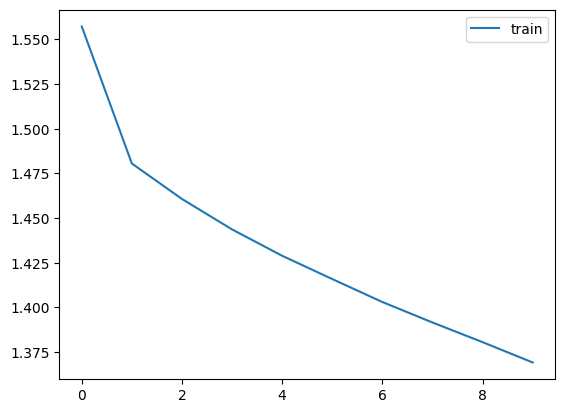

In [ ]:
train_losses = train(model)
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

==> Testing ...


100%|██████████| 57/57 [01:13<00:00,  1.28s/it]


 ==> Finished testing


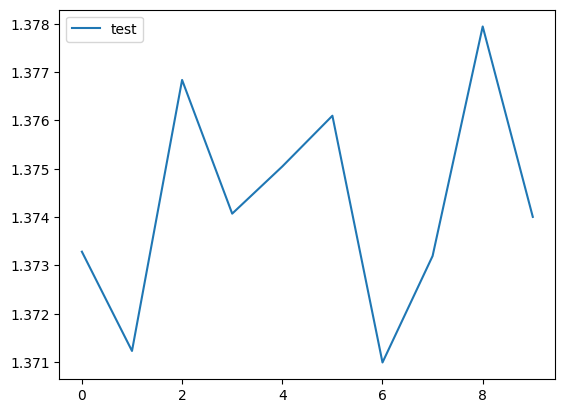

In [ ]:
test_losses = test_on_epoch(model)
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

In [ ]:
def test_split(model, split):
    model.eval()
    y_score = torch.tensor([]).to(device)
    y_true = []

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            y_true.extend(targets.cpu().numpy())

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                outputs = outputs.softmax(dim=-1)

            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.cpu().detach().numpy()
        y_true = np.array(y_true)

        evaluator = Evaluator(data_flag, split)

        evaluator.labels = y_true
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

def test(model):
    print('==> Evaluating ...')
    test_split(model, 'train')
    test_split(model, 'test')

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.763  acc:0.752
test  auc: 0.716  acc:0.711


## Нормализованый датасет (попытка) lr = 0.01, epoch = 10:

Clustered:

==> Evaluating ...

train  auc: 0.879  acc:0.700

test  auc: 0.825  acc:0.678

UNet2:

==> Evaluating ...

train  auc: 0.828  acc:0.670

test  auc: 0.822  acc:0.678


UNet3:

==> Evaluating ...

train  auc: 0.742  acc:0.669

test  auc: 0.749  acc:0.669

## lr = 0.1, epoch = 3

Clustered:

==> Evaluating ...

train  auc: 0.868  acc:0.709

test  auc: 0.855  acc:0.696

UNet2:

==> Evaluating ...

train  auc: 0.720  acc:0.670

test  auc: 0.718  acc:0.669

UNet3:

==> Evaluating ...

train  auc: 0.836  acc:0.679

test  auc: 0.834  acc:0.659

## lr = 0.01, epoch = 10

Clustered:

==> Evaluating ...

train  auc: 0.971  acc:0.797

test  auc: 0.891  acc:0.699

UNet2:

==> Evaluating ...

train  auc: 0.956  acc:0.823

test  auc: 0.902  acc:0.742

UNet3:

==> Evaluating ...

train  auc: 0.923  acc:0.768

test  auc: 0.881  acc:0.726

# UNet 2 слоя

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class UNet2Level(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) # оставляем для воспроизводимости результатов
        super().__init__()

        #Encoder----------------------------------------------------
        self.encoder_conv1 = double_conv(in_channels, 64)
        self.encoder_pool1 = nn.MaxPool2d(2)

        self.encoder_conv2 = double_conv(64, 128)
        self.encoder_pool2 = nn.MaxPool2d(2)
        #Encoder----------------------------------------------------

        #Center-----------------------------------------------------
        self.center = double_conv(128, 256)
        #Center-----------------------------------------------------

        #Decoder----------------------------------------------------
        self.decoder_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv1 = double_conv(256, 128)

        self.decoder_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv2 = double_conv(128, 64)
        #Decoder----------------------------------------------------

        #CNN--------------------------------------------------------
        self.cnn1 = double_conv(64, 32)
        self.cnn1_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()

        self.cnn2 = double_conv(32, 10)
        self.cnn2_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #CNN--------------------------------------------------------

        #Output-----------------------------------------------------
        self.oneline = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(490, 60)
        self.linear_out = nn.Linear(60, num_classes)
        #Output-----------------------------------------------------

    def forward(self, x):
        enc1 = self.encoder_conv1(x)
        enc2 = self.encoder_conv2(self.encoder_pool1(enc1))
        enc2 = self.encoder_pool2(self.encoder_pool2(enc2))

        center = self.center(enc2)

        dec1 = self.decoder_trans1(center)
        dec1_resized = F.interpolate(dec1, size=enc2.size()[2:], mode='bilinear', align_corners=False)
        dec1 = torch.cat([dec1_resized, enc2], dim=1)
        dec1 = self.decoder_conv1(dec1)

        dec2 = self.decoder_trans2(dec1)
        dec2_resized = F.interpolate(dec2, size=enc1.size()[2:], mode='bilinear', align_corners=False)
        dec2 = torch.cat([dec2_resized, enc1], dim=1)
        dec2 = self.decoder_conv2(dec2)

        #CNN--------------------------------------------------------
        output = self.cnn1(dec2)
        output = self.cnn1_pool(output)

        output = self.relu(output)

        output = self.cnn2(output)
        output = self.cnn2_pool(output)

        output = self.relu(output)
        #CNN--------------------------------------------------------

        #Output-----------------------------------------------------
        output = self.oneline(output)
        output = self.linear1(output)
        output = self.linear_out(output)
        output = torch.sigmoid(output)
        #Output-----------------------------------------------------

        return output

In [ ]:
model = UNet2Level(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 20
lr = 0.1

optimizer = optim.SGD(model.parameters(), lr=lr)

==> Training ...


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.9273220300674438


  2%|▏         | 1/57 [00:05<04:48,  5.15s/it]

loss=1.1612857580184937


  4%|▎         | 2/57 [00:08<03:53,  4.24s/it]

loss=1.1493698358535767


  5%|▌         | 3/57 [00:11<03:10,  3.54s/it]

loss=1.0554771423339844


  7%|▋         | 4/57 [00:14<03:02,  3.44s/it]

loss=1.171541690826416


  9%|▉         | 5/57 [00:17<02:52,  3.32s/it]

loss=1.0553332567214966


 11%|█         | 6/57 [00:20<02:40,  3.14s/it]

loss=1.09463632106781


 12%|█▏        | 7/57 [00:24<02:44,  3.29s/it]

loss=0.8581171631813049


 14%|█▍        | 8/57 [00:27<02:39,  3.26s/it]

loss=0.9069997668266296


 16%|█▌        | 9/57 [00:30<02:26,  3.06s/it]

loss=0.9643856287002563


 18%|█▊        | 10/57 [00:33<02:24,  3.07s/it]

loss=0.8670017719268799


 19%|█▉        | 11/57 [00:36<02:27,  3.20s/it]

loss=0.9195244908332825


 21%|██        | 12/57 [00:39<02:18,  3.08s/it]

loss=1.059294581413269


 23%|██▎       | 13/57 [00:42<02:13,  3.02s/it]

loss=0.9477684497833252


 25%|██▍       | 14/57 [00:45<02:08,  2.99s/it]

loss=1.0942790508270264


 26%|██▋       | 15/57 [00:47<02:01,  2.90s/it]

loss=0.9279398918151855


 28%|██▊       | 16/57 [00:50<01:53,  2.78s/it]

loss=1.0497326850891113


 30%|██▉       | 17/57 [00:53<01:51,  2.79s/it]

loss=0.9757897853851318


 32%|███▏      | 18/57 [00:55<01:46,  2.73s/it]

loss=1.0442129373550415


 33%|███▎      | 19/57 [00:58<01:46,  2.81s/it]

loss=0.852536678314209


 35%|███▌      | 20/57 [01:02<01:48,  2.93s/it]

loss=0.9000514149665833


 37%|███▋      | 21/57 [01:04<01:41,  2.83s/it]

loss=0.917599081993103


 39%|███▊      | 22/57 [01:07<01:41,  2.91s/it]

loss=0.8178492188453674


 40%|████      | 23/57 [01:10<01:40,  2.97s/it]

loss=0.9538668990135193


 42%|████▏     | 24/57 [01:14<01:40,  3.04s/it]

loss=0.9957125186920166


 44%|████▍     | 25/57 [01:16<01:33,  2.91s/it]

loss=0.7510532736778259


 46%|████▌     | 26/57 [01:19<01:28,  2.84s/it]

loss=0.9430250525474548


 47%|████▋     | 27/57 [01:21<01:23,  2.77s/it]

loss=0.9766499400138855


 49%|████▉     | 28/57 [01:24<01:20,  2.78s/it]

loss=0.856520414352417


 51%|█████     | 29/57 [01:26<01:12,  2.58s/it]

loss=0.883651852607727


 53%|█████▎    | 30/57 [01:29<01:06,  2.46s/it]

loss=0.9142847061157227


 54%|█████▍    | 31/57 [01:31<01:05,  2.50s/it]

loss=0.8779634237289429


 56%|█████▌    | 32/57 [01:34<01:07,  2.68s/it]

loss=0.7732021808624268


 58%|█████▊    | 33/57 [01:37<01:07,  2.81s/it]

loss=0.9546203017234802


 60%|█████▉    | 34/57 [01:41<01:07,  2.96s/it]

loss=0.8635005950927734


 61%|██████▏   | 35/57 [01:44<01:04,  2.94s/it]

loss=0.8129280805587769


 63%|██████▎   | 36/57 [01:47<01:02,  2.96s/it]

loss=0.7983592748641968


 65%|██████▍   | 37/57 [01:49<00:57,  2.85s/it]

loss=0.8351286053657532


 67%|██████▋   | 38/57 [01:52<00:51,  2.71s/it]

loss=0.8021649122238159


 68%|██████▊   | 39/57 [01:54<00:46,  2.59s/it]

loss=0.8086386919021606


 70%|███████   | 40/57 [01:57<00:45,  2.65s/it]

loss=0.9373753070831299


 72%|███████▏  | 41/57 [01:59<00:42,  2.64s/it]

loss=0.9496386051177979


 74%|███████▎  | 42/57 [02:02<00:40,  2.72s/it]

loss=0.9998297095298767


 75%|███████▌  | 43/57 [02:05<00:39,  2.80s/it]

loss=0.7794118523597717


 77%|███████▋  | 44/57 [02:08<00:36,  2.83s/it]

loss=0.912817656993866


 79%|███████▉  | 45/57 [02:11<00:34,  2.91s/it]

loss=0.8558396100997925


 81%|████████  | 46/57 [02:14<00:31,  2.88s/it]

loss=0.9412875175476074


 82%|████████▏ | 47/57 [02:17<00:27,  2.79s/it]

loss=0.7209551930427551


 84%|████████▍ | 48/57 [02:19<00:25,  2.80s/it]

loss=0.7941936254501343


 86%|████████▌ | 49/57 [02:23<00:23,  2.95s/it]

loss=0.8434645533561707


 88%|████████▊ | 50/57 [02:25<00:20,  2.87s/it]

loss=0.8193050622940063


 89%|████████▉ | 51/57 [02:28<00:16,  2.67s/it]

loss=0.8254313468933105


 91%|█████████ | 52/57 [02:30<00:12,  2.56s/it]

loss=0.8380649089813232


 93%|█████████▎| 53/57 [02:33<00:10,  2.60s/it]

loss=1.0687085390090942


 95%|█████████▍| 54/57 [02:35<00:07,  2.51s/it]

loss=0.9560672640800476


 96%|█████████▋| 55/57 [02:38<00:05,  2.75s/it]

loss=0.9504448771476746


 98%|█████████▊| 56/57 [02:41<00:02,  2.73s/it]

loss=0.7755671739578247


100%|██████████| 57/57 [02:43<00:00,  2.87s/it]


0: loss=0.9383810904988071


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.9316468834877014


  2%|▏         | 1/57 [00:03<03:15,  3.50s/it]

loss=0.8669461607933044


  4%|▎         | 2/57 [00:06<02:56,  3.20s/it]

loss=0.7365157604217529


  5%|▌         | 3/57 [00:09<02:55,  3.25s/it]

loss=0.8981104493141174


  7%|▋         | 4/57 [00:12<02:49,  3.19s/it]

loss=0.7046100497245789


  9%|▉         | 5/57 [00:15<02:34,  2.98s/it]

loss=0.7736895680427551


 11%|█         | 6/57 [00:18<02:28,  2.92s/it]

loss=0.8186697959899902


 12%|█▏        | 7/57 [00:20<02:15,  2.72s/it]

loss=0.8047393560409546


 14%|█▍        | 8/57 [00:23<02:17,  2.81s/it]

loss=0.8717745542526245


 16%|█▌        | 9/57 [00:26<02:16,  2.83s/it]

loss=0.7435849905014038


 18%|█▊        | 10/57 [00:29<02:11,  2.79s/it]

loss=0.8439502120018005


 19%|█▉        | 11/57 [00:32<02:09,  2.83s/it]

loss=0.8083436489105225


 21%|██        | 12/57 [00:35<02:10,  2.91s/it]

loss=0.9886617064476013


 23%|██▎       | 13/57 [00:38<02:13,  3.03s/it]

loss=0.751430094242096


 25%|██▍       | 14/57 [00:41<02:11,  3.05s/it]

loss=0.8506329655647278


 26%|██▋       | 15/57 [00:44<02:08,  3.07s/it]

loss=0.7963243126869202


 28%|██▊       | 16/57 [00:47<02:02,  2.99s/it]

loss=0.7709693908691406


 30%|██▉       | 17/57 [00:50<01:58,  2.96s/it]

loss=0.7364334464073181


 32%|███▏      | 18/57 [00:53<01:59,  3.06s/it]

loss=1.0180162191390991


 33%|███▎      | 19/57 [00:56<01:49,  2.89s/it]

loss=0.8787587285041809


 35%|███▌      | 20/57 [00:59<01:49,  2.95s/it]

loss=0.7989946603775024


 37%|███▋      | 21/57 [01:02<01:45,  2.94s/it]

loss=0.7615740299224854


 39%|███▊      | 22/57 [01:05<01:42,  2.93s/it]

loss=0.6429542899131775


 40%|████      | 23/57 [01:07<01:34,  2.77s/it]

loss=0.8637285828590393


 42%|████▏     | 24/57 [01:10<01:32,  2.81s/it]

loss=0.7507457137107849


 44%|████▍     | 25/57 [01:12<01:27,  2.75s/it]

loss=0.6183052659034729


 46%|████▌     | 26/57 [01:15<01:22,  2.67s/it]

loss=0.6651719808578491


 47%|████▋     | 27/57 [01:17<01:16,  2.56s/it]

loss=0.8787809014320374


 49%|████▉     | 28/57 [01:20<01:16,  2.63s/it]

loss=0.7783732414245605


 51%|█████     | 29/57 [01:23<01:16,  2.74s/it]

loss=0.6873024106025696


 53%|█████▎    | 30/57 [01:26<01:15,  2.79s/it]

loss=0.7028997540473938


 54%|█████▍    | 31/57 [01:29<01:11,  2.76s/it]

loss=0.8785919547080994


 56%|█████▌    | 32/57 [01:31<01:09,  2.77s/it]

loss=0.7806867957115173


 58%|█████▊    | 33/57 [01:34<01:07,  2.81s/it]

loss=0.8037580847740173


 60%|█████▉    | 34/57 [01:37<01:02,  2.72s/it]

loss=0.8243417143821716


 61%|██████▏   | 35/57 [01:39<00:57,  2.59s/it]

loss=0.7881317138671875


 63%|██████▎   | 36/57 [01:42<00:53,  2.57s/it]

loss=0.7719235420227051


 65%|██████▍   | 37/57 [01:44<00:50,  2.55s/it]

loss=0.8138357996940613


 67%|██████▋   | 38/57 [01:47<00:48,  2.56s/it]

loss=0.9801983833312988


 68%|██████▊   | 39/57 [01:49<00:45,  2.51s/it]

loss=0.6846206784248352


 70%|███████   | 40/57 [01:52<00:42,  2.51s/it]

loss=0.8985469937324524


 72%|███████▏  | 41/57 [01:54<00:41,  2.60s/it]

loss=0.7300384640693665


 74%|███████▎  | 42/57 [01:58<00:41,  2.78s/it]

loss=0.6094834804534912


 75%|███████▌  | 43/57 [02:00<00:38,  2.78s/it]

loss=0.7554982900619507


 77%|███████▋  | 44/57 [02:03<00:36,  2.79s/it]

loss=0.9093392491340637


 79%|███████▉  | 45/57 [02:06<00:33,  2.76s/it]

loss=0.7374264001846313


 81%|████████  | 46/57 [02:09<00:30,  2.80s/it]

loss=0.9491080045700073


 82%|████████▏ | 47/57 [02:12<00:28,  2.83s/it]

loss=0.7606215476989746


 84%|████████▍ | 48/57 [02:14<00:24,  2.76s/it]

loss=0.9281148910522461


 86%|████████▌ | 49/57 [02:17<00:22,  2.77s/it]

loss=0.8990539908409119


 88%|████████▊ | 50/57 [02:20<00:19,  2.75s/it]

loss=0.8749744892120361


 89%|████████▉ | 51/57 [02:23<00:16,  2.80s/it]

loss=0.8856372833251953


 91%|█████████ | 52/57 [02:25<00:13,  2.68s/it]

loss=0.6699344515800476


 93%|█████████▎| 53/57 [02:28<00:11,  2.77s/it]

loss=0.849486768245697


 95%|█████████▍| 54/57 [02:31<00:08,  2.81s/it]

loss=0.7769091129302979


 96%|█████████▋| 55/57 [02:33<00:05,  2.69s/it]

loss=0.8584374189376831


 98%|█████████▊| 56/57 [02:36<00:02,  2.63s/it]

loss=0.8333849906921387


100%|██████████| 57/57 [02:37<00:00,  2.77s/it]


1: loss=0.806924975754922


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.7947386503219604


  2%|▏         | 1/57 [00:02<02:36,  2.80s/it]

loss=0.7136130332946777


  4%|▎         | 2/57 [00:05<02:43,  2.98s/it]

loss=0.7882305979728699


  5%|▌         | 3/57 [00:08<02:38,  2.94s/it]

loss=0.9186286926269531


  7%|▋         | 4/57 [00:11<02:39,  3.00s/it]

loss=0.8155835866928101


  9%|▉         | 5/57 [00:14<02:36,  3.00s/it]

loss=0.733100175857544


 11%|█         | 6/57 [00:18<02:38,  3.10s/it]

loss=0.5655537247657776


 12%|█▏        | 7/57 [00:21<02:36,  3.14s/it]

loss=0.8217353820800781


 14%|█▍        | 8/57 [00:24<02:29,  3.06s/it]

loss=0.737257182598114


 16%|█▌        | 9/57 [00:27<02:24,  3.01s/it]

loss=0.8106776475906372


 18%|█▊        | 10/57 [00:30<02:18,  2.95s/it]

loss=0.7716987133026123


 19%|█▉        | 11/57 [00:32<02:14,  2.93s/it]

loss=0.7533296942710876


 21%|██        | 12/57 [00:35<02:10,  2.89s/it]

loss=0.665605366230011


 23%|██▎       | 13/57 [00:38<02:08,  2.92s/it]

loss=0.7381365895271301


 25%|██▍       | 14/57 [00:41<02:04,  2.89s/it]

loss=0.7692371606826782


 26%|██▋       | 15/57 [00:44<02:02,  2.92s/it]

loss=0.7060136198997498


 28%|██▊       | 16/57 [00:47<01:59,  2.92s/it]

loss=0.6406458616256714


 30%|██▉       | 17/57 [00:50<01:58,  2.97s/it]

loss=0.7048259973526001


 32%|███▏      | 18/57 [00:53<01:56,  2.98s/it]

loss=0.5904176831245422


 33%|███▎      | 19/57 [00:56<01:54,  3.02s/it]

loss=0.6963968276977539


 35%|███▌      | 20/57 [00:59<01:53,  3.07s/it]

loss=0.6935992240905762


 37%|███▋      | 21/57 [01:02<01:48,  3.02s/it]

loss=0.8475931882858276


 39%|███▊      | 22/57 [01:05<01:46,  3.04s/it]

loss=0.8195773959159851


 40%|████      | 23/57 [01:09<01:45,  3.09s/it]

loss=0.7330142855644226


 42%|████▏     | 24/57 [01:12<01:43,  3.12s/it]

loss=0.6522968411445618


 44%|████▍     | 25/57 [01:15<01:39,  3.12s/it]

loss=0.6658599972724915


 46%|████▌     | 26/57 [01:18<01:37,  3.14s/it]

loss=0.6620013117790222


 47%|████▋     | 27/57 [01:21<01:31,  3.04s/it]

loss=0.6897578835487366


 49%|████▉     | 28/57 [01:24<01:29,  3.09s/it]

loss=0.7678414583206177


 51%|█████     | 29/57 [01:27<01:23,  2.97s/it]

loss=0.7616792917251587


 53%|█████▎    | 30/57 [01:30<01:19,  2.95s/it]

loss=0.7969881892204285


 54%|█████▍    | 31/57 [01:33<01:18,  3.02s/it]

loss=0.6391257047653198


 56%|█████▌    | 32/57 [01:36<01:19,  3.17s/it]

loss=0.9802691340446472


 58%|█████▊    | 33/57 [01:39<01:11,  3.00s/it]

loss=0.9348064064979553


 60%|█████▉    | 34/57 [01:42<01:08,  3.00s/it]

loss=0.7256238460540771


 61%|██████▏   | 35/57 [01:45<01:04,  2.91s/it]

loss=0.6578738689422607


 63%|██████▎   | 36/57 [01:48<01:02,  2.97s/it]

loss=0.756829559803009


 65%|██████▍   | 37/57 [01:51<01:00,  3.01s/it]

loss=0.9238042235374451


 67%|██████▋   | 38/57 [01:54<00:55,  2.95s/it]

loss=0.8425137400627136


 68%|██████▊   | 39/57 [01:57<00:53,  2.99s/it]

loss=0.7443341016769409


 70%|███████   | 40/57 [02:00<00:50,  2.96s/it]

loss=0.8408212661743164


 72%|███████▏  | 41/57 [02:03<00:48,  3.00s/it]

loss=0.8397542238235474


 74%|███████▎  | 42/57 [02:05<00:41,  2.76s/it]

loss=0.6884368062019348


 75%|███████▌  | 43/57 [02:07<00:37,  2.68s/it]

loss=0.6625704169273376


 77%|███████▋  | 44/57 [02:10<00:34,  2.63s/it]

loss=0.6484501957893372


 79%|███████▉  | 45/57 [02:12<00:30,  2.56s/it]

loss=0.6229987144470215


 81%|████████  | 46/57 [02:15<00:27,  2.54s/it]

loss=0.6775308847427368


 82%|████████▏ | 47/57 [02:18<00:25,  2.59s/it]

loss=0.7538006901741028


 84%|████████▍ | 48/57 [02:21<00:25,  2.80s/it]

loss=0.7549949884414673


 86%|████████▌ | 49/57 [02:24<00:22,  2.86s/it]

loss=0.862787663936615


 88%|████████▊ | 50/57 [02:27<00:20,  2.90s/it]

loss=0.7636458873748779


 89%|████████▉ | 51/57 [02:30<00:17,  2.90s/it]

loss=0.7102712988853455


 91%|█████████ | 52/57 [02:33<00:15,  3.05s/it]

loss=0.6446097493171692


 93%|█████████▎| 53/57 [02:36<00:12,  3.04s/it]

loss=0.9917481541633606


 95%|█████████▍| 54/57 [02:39<00:08,  2.94s/it]

loss=0.9510928988456726


 96%|█████████▋| 55/57 [02:42<00:05,  2.92s/it]

loss=0.7585254907608032


 98%|█████████▊| 56/57 [02:45<00:03,  3.01s/it]

loss=0.43359339237213135


100%|██████████| 57/57 [02:46<00:00,  2.92s/it]


2: loss=0.7480078695113199


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.0431259870529175


  2%|▏         | 1/57 [00:02<02:20,  2.50s/it]

loss=0.649019181728363


  4%|▎         | 2/57 [00:05<02:24,  2.62s/it]

loss=0.9111259579658508


  5%|▌         | 3/57 [00:07<02:25,  2.70s/it]

loss=0.6695254445075989


  7%|▋         | 4/57 [00:11<02:43,  3.09s/it]

loss=0.6729485988616943


  9%|▉         | 5/57 [00:14<02:42,  3.13s/it]

loss=0.6215890049934387


 11%|█         | 6/57 [00:17<02:30,  2.95s/it]

loss=0.6419289112091064


 12%|█▏        | 7/57 [00:20<02:23,  2.87s/it]

loss=0.6886935234069824


 14%|█▍        | 8/57 [00:23<02:21,  2.88s/it]

loss=0.6764635443687439


 16%|█▌        | 9/57 [00:25<02:15,  2.82s/it]

loss=0.659180760383606


 18%|█▊        | 10/57 [00:28<02:07,  2.72s/it]

loss=0.6342630982398987


 19%|█▉        | 11/57 [00:31<02:13,  2.90s/it]

loss=0.7629802823066711


 21%|██        | 12/57 [00:34<02:10,  2.90s/it]

loss=0.7309322953224182


 23%|██▎       | 13/57 [00:37<02:03,  2.81s/it]

loss=0.7623546123504639


 25%|██▍       | 14/57 [00:39<01:54,  2.65s/it]

loss=0.7606455087661743


 26%|██▋       | 15/57 [00:41<01:48,  2.58s/it]

loss=0.7963242530822754


 28%|██▊       | 16/57 [00:45<01:55,  2.83s/it]

loss=0.7442806959152222


 30%|██▉       | 17/57 [00:47<01:51,  2.79s/it]

loss=0.7264915108680725


 32%|███▏      | 18/57 [00:50<01:48,  2.79s/it]

loss=0.7405467629432678


 33%|███▎      | 19/57 [00:53<01:45,  2.76s/it]

loss=0.7258583307266235


 35%|███▌      | 20/57 [00:56<01:41,  2.75s/it]

loss=0.6157255172729492


 37%|███▋      | 21/57 [00:59<01:42,  2.85s/it]

loss=0.7807309627532959


 39%|███▊      | 22/57 [01:01<01:37,  2.78s/it]

loss=0.6653951406478882


 40%|████      | 23/57 [01:04<01:28,  2.60s/it]

loss=0.6485157608985901


 42%|████▏     | 24/57 [01:07<01:33,  2.84s/it]

loss=0.5942121148109436


 44%|████▍     | 25/57 [01:10<01:33,  2.92s/it]

loss=0.6518281698226929


 46%|████▌     | 26/57 [01:13<01:27,  2.82s/it]

loss=0.6593692898750305


 47%|████▋     | 27/57 [01:16<01:25,  2.85s/it]

loss=0.6355982422828674


 49%|████▉     | 28/57 [01:19<01:26,  2.98s/it]

loss=0.6463578939437866


 51%|█████     | 29/57 [01:22<01:21,  2.93s/it]

loss=0.8472789525985718


 53%|█████▎    | 30/57 [01:25<01:21,  3.01s/it]

loss=0.8091261982917786


 54%|█████▍    | 31/57 [01:28<01:17,  2.98s/it]

loss=0.720500648021698


 56%|█████▌    | 32/57 [01:31<01:16,  3.04s/it]

loss=0.6705912947654724


 58%|█████▊    | 33/57 [01:34<01:11,  2.97s/it]

loss=0.7555897235870361


 60%|█████▉    | 34/57 [01:36<01:07,  2.92s/it]

loss=0.8350649476051331


 61%|██████▏   | 35/57 [01:39<01:03,  2.88s/it]

loss=0.6247110366821289


 63%|██████▎   | 36/57 [01:42<01:01,  2.95s/it]

loss=0.6319524049758911


 65%|██████▍   | 37/57 [01:45<00:58,  2.90s/it]

loss=0.6720137000083923


 67%|██████▋   | 38/57 [01:49<00:58,  3.08s/it]

loss=0.8146803975105286


 68%|██████▊   | 39/57 [01:52<00:57,  3.21s/it]

loss=0.658241868019104


 70%|███████   | 40/57 [01:56<00:55,  3.24s/it]

loss=0.6906968355178833


 72%|███████▏  | 41/57 [01:59<00:52,  3.25s/it]

loss=0.7890185713768005


 74%|███████▎  | 42/57 [02:02<00:47,  3.15s/it]

loss=0.7580779790878296


 75%|███████▌  | 43/57 [02:05<00:43,  3.07s/it]

loss=0.7081232070922852


 77%|███████▋  | 44/57 [02:08<00:40,  3.08s/it]

loss=0.7193549275398254


 79%|███████▉  | 45/57 [02:11<00:36,  3.06s/it]

loss=0.7679054737091064


 81%|████████  | 46/57 [02:14<00:33,  3.01s/it]

loss=0.5835029482841492


 82%|████████▏ | 47/57 [02:17<00:30,  3.01s/it]

loss=0.7287145256996155


 84%|████████▍ | 48/57 [02:20<00:26,  2.98s/it]

loss=0.7468082904815674


 86%|████████▌ | 49/57 [02:23<00:24,  3.04s/it]

loss=0.6959840059280396


 88%|████████▊ | 50/57 [02:26<00:21,  3.03s/it]

loss=0.655676007270813


 89%|████████▉ | 51/57 [02:29<00:18,  3.05s/it]

loss=0.6063548922538757


 91%|█████████ | 52/57 [02:32<00:15,  3.07s/it]

loss=0.6611582040786743


 93%|█████████▎| 53/57 [02:34<00:11,  2.93s/it]

loss=0.6845986843109131


 95%|█████████▍| 54/57 [02:38<00:08,  2.95s/it]

loss=0.6740825772285461


 96%|█████████▋| 55/57 [02:40<00:05,  2.84s/it]

loss=0.9166158437728882


 98%|█████████▊| 56/57 [02:43<00:02,  2.89s/it]

loss=0.5273170471191406


100%|██████████| 57/57 [02:45<00:00,  2.89s/it]


3: loss=0.709995658774125


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.9822670221328735


  2%|▏         | 1/57 [00:02<02:31,  2.70s/it]

loss=0.8557512164115906


  4%|▎         | 2/57 [00:05<02:38,  2.88s/it]

loss=0.6448851227760315


  5%|▌         | 3/57 [00:08<02:35,  2.89s/it]

loss=0.7075645327568054


  7%|▋         | 4/57 [00:11<02:35,  2.93s/it]

loss=0.6796087622642517


  9%|▉         | 5/57 [00:14<02:35,  2.99s/it]

loss=0.599371612071991


 11%|█         | 6/57 [00:17<02:31,  2.96s/it]

loss=0.6443176865577698


 12%|█▏        | 7/57 [00:20<02:30,  3.01s/it]

loss=0.5912482738494873


 14%|█▍        | 8/57 [00:23<02:25,  2.97s/it]

loss=0.6483434438705444


 16%|█▌        | 9/57 [00:26<02:23,  2.98s/it]

loss=0.7004565000534058


 18%|█▊        | 10/57 [00:29<02:23,  3.05s/it]

loss=0.587392270565033


 19%|█▉        | 11/57 [00:32<02:15,  2.94s/it]

loss=0.7019969820976257


 21%|██        | 12/57 [00:35<02:09,  2.87s/it]

loss=0.7114601731300354


 23%|██▎       | 13/57 [00:38<02:05,  2.85s/it]

loss=0.6743640303611755


 25%|██▍       | 14/57 [00:41<02:05,  2.92s/it]

loss=0.6205141544342041


 26%|██▋       | 15/57 [00:44<02:06,  3.01s/it]

loss=0.6217080354690552


 28%|██▊       | 16/57 [00:47<02:04,  3.04s/it]

loss=0.617828905582428


 30%|██▉       | 17/57 [00:50<02:04,  3.12s/it]

loss=0.6816659569740295


 32%|███▏      | 18/57 [00:53<02:00,  3.08s/it]

loss=0.7057519555091858


 33%|███▎      | 19/57 [00:56<01:53,  3.00s/it]

loss=0.6734579205513


 35%|███▌      | 20/57 [00:59<01:47,  2.91s/it]

loss=0.6191977858543396


 37%|███▋      | 21/57 [01:02<01:47,  2.99s/it]

loss=0.5693007111549377


 39%|███▊      | 22/57 [01:05<01:42,  2.94s/it]

loss=0.7433817386627197


 40%|████      | 23/57 [01:08<01:39,  2.93s/it]

loss=0.6688821315765381


 42%|████▏     | 24/57 [01:10<01:34,  2.86s/it]

loss=0.7071605920791626


 44%|████▍     | 25/57 [01:13<01:30,  2.84s/it]

loss=0.5850316882133484


 46%|████▌     | 26/57 [01:16<01:24,  2.74s/it]

loss=0.6920042037963867


 47%|████▋     | 27/57 [01:18<01:23,  2.79s/it]

loss=0.6510142087936401


 49%|████▉     | 28/57 [01:22<01:24,  2.91s/it]

loss=0.49005794525146484


 51%|█████     | 29/57 [01:25<01:23,  3.00s/it]

loss=0.7859389781951904


 53%|█████▎    | 30/57 [01:28<01:18,  2.91s/it]

loss=0.7259736657142639


 54%|█████▍    | 31/57 [01:30<01:13,  2.82s/it]

loss=0.7342869639396667


 56%|█████▌    | 32/57 [01:33<01:12,  2.90s/it]

loss=0.6403582096099854


 58%|█████▊    | 33/57 [01:36<01:11,  2.99s/it]

loss=0.7367300987243652


 60%|█████▉    | 34/57 [01:40<01:10,  3.05s/it]

loss=0.5954105257987976


 61%|██████▏   | 35/57 [01:43<01:06,  3.04s/it]

loss=0.7215734124183655


 63%|██████▎   | 36/57 [01:46<01:04,  3.06s/it]

loss=0.7204444408416748


 65%|██████▍   | 37/57 [01:49<01:01,  3.10s/it]

loss=0.5574678778648376


 67%|██████▋   | 38/57 [01:52<00:57,  3.01s/it]

loss=0.7169091701507568


 68%|██████▊   | 39/57 [01:55<00:53,  2.95s/it]

loss=0.6034800410270691


 70%|███████   | 40/57 [01:57<00:48,  2.84s/it]

loss=0.7067062258720398


 72%|███████▏  | 41/57 [02:00<00:47,  2.98s/it]

loss=0.7464243173599243


 74%|███████▎  | 42/57 [02:04<00:46,  3.08s/it]

loss=0.6875352263450623


 75%|███████▌  | 43/57 [02:06<00:40,  2.87s/it]

loss=0.759319007396698


 77%|███████▋  | 44/57 [02:09<00:37,  2.85s/it]

loss=0.6287780404090881


 79%|███████▉  | 45/57 [02:12<00:35,  2.96s/it]

loss=0.6325029730796814


 81%|████████  | 46/57 [02:15<00:32,  2.97s/it]

loss=0.7501797080039978


 82%|████████▏ | 47/57 [02:18<00:30,  3.01s/it]

loss=0.5791127681732178


 84%|████████▍ | 48/57 [02:21<00:26,  2.98s/it]

loss=0.6978711485862732


 86%|████████▌ | 49/57 [02:24<00:24,  3.04s/it]

loss=0.6898053288459778


 88%|████████▊ | 50/57 [02:28<00:21,  3.09s/it]

loss=0.6202109456062317


 89%|████████▉ | 51/57 [02:30<00:17,  2.91s/it]

loss=0.6986343264579773


 91%|█████████ | 52/57 [02:33<00:14,  2.97s/it]

loss=0.7190023064613342


 93%|█████████▎| 53/57 [02:36<00:12,  3.01s/it]

loss=0.6290805339813232


 95%|█████████▍| 54/57 [02:39<00:09,  3.04s/it]

loss=0.6205739974975586


 96%|█████████▋| 55/57 [02:43<00:06,  3.08s/it]

loss=0.700458824634552


 98%|█████████▊| 56/57 [02:46<00:03,  3.09s/it]

loss=0.48362573981285095


100%|██████████| 57/57 [02:47<00:00,  2.94s/it]


4: loss=0.6713049186949145


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.6061215400695801


  2%|▏         | 1/57 [00:02<02:36,  2.80s/it]

loss=0.6230481863021851


  4%|▎         | 2/57 [00:05<02:37,  2.86s/it]

loss=0.6809703707695007


  5%|▌         | 3/57 [00:08<02:30,  2.79s/it]

loss=0.6281776428222656


  7%|▋         | 4/57 [00:11<02:30,  2.83s/it]

loss=0.4764297902584076


  9%|▉         | 5/57 [00:14<02:30,  2.89s/it]

loss=0.5544015169143677


 11%|█         | 6/57 [00:17<02:25,  2.86s/it]

loss=0.6028434634208679


 12%|█▏        | 7/57 [00:20<02:25,  2.91s/it]

loss=0.6617559790611267


 14%|█▍        | 8/57 [00:23<02:25,  2.97s/it]

loss=0.6169977188110352


 16%|█▌        | 9/57 [00:26<02:27,  3.07s/it]

loss=0.8050898313522339


 18%|█▊        | 10/57 [00:29<02:23,  3.05s/it]

loss=0.6288514733314514


 19%|█▉        | 11/57 [00:32<02:23,  3.13s/it]

loss=0.5857990384101868


 21%|██        | 12/57 [00:36<02:21,  3.15s/it]

loss=0.613649308681488


 23%|██▎       | 13/57 [00:39<02:19,  3.16s/it]

loss=0.5511372685432434


 25%|██▍       | 14/57 [00:42<02:12,  3.08s/it]

loss=0.5280620455741882


 26%|██▋       | 15/57 [00:45<02:14,  3.21s/it]

loss=0.5985271334648132


 28%|██▊       | 16/57 [00:48<02:10,  3.18s/it]

loss=0.6611753702163696


 30%|██▉       | 17/57 [00:51<02:03,  3.09s/it]

loss=0.755703866481781


 32%|███▏      | 18/57 [00:54<01:53,  2.92s/it]

loss=0.7097538709640503


 33%|███▎      | 19/57 [00:57<01:52,  2.97s/it]

loss=0.7826095819473267


 35%|███▌      | 20/57 [01:00<01:49,  2.95s/it]

loss=0.6833706498146057


 37%|███▋      | 21/57 [01:02<01:45,  2.93s/it]

loss=0.757865846157074


 39%|███▊      | 22/57 [01:05<01:40,  2.87s/it]

loss=0.76185542345047


 40%|████      | 23/57 [01:09<01:44,  3.08s/it]

loss=0.5638512969017029


 42%|████▏     | 24/57 [01:12<01:41,  3.09s/it]

loss=0.5739514231681824


 44%|████▍     | 25/57 [01:15<01:37,  3.06s/it]

loss=0.6342740058898926


 46%|████▌     | 26/57 [01:18<01:37,  3.13s/it]

loss=0.6639701128005981


 47%|████▋     | 27/57 [01:21<01:34,  3.15s/it]

loss=0.6315589547157288


 49%|████▉     | 28/57 [01:24<01:30,  3.11s/it]

loss=0.6266292333602905


 51%|█████     | 29/57 [01:28<01:29,  3.20s/it]

loss=0.5625483989715576


 53%|█████▎    | 30/57 [01:31<01:25,  3.17s/it]

loss=0.7242514491081238


 54%|█████▍    | 31/57 [01:34<01:21,  3.12s/it]

loss=0.647659957408905


 56%|█████▌    | 32/57 [01:37<01:19,  3.17s/it]

loss=0.5722233057022095


 58%|█████▊    | 33/57 [01:40<01:14,  3.12s/it]

loss=0.6254004836082458


 60%|█████▉    | 34/57 [01:43<01:12,  3.14s/it]

loss=0.4824663996696472


 61%|██████▏   | 35/57 [01:46<01:06,  3.01s/it]

loss=0.7424734234809875


 63%|██████▎   | 36/57 [01:48<00:59,  2.83s/it]

loss=0.6323251724243164


 65%|██████▍   | 37/57 [01:51<00:54,  2.70s/it]

loss=0.636381983757019


 67%|██████▋   | 38/57 [01:54<00:53,  2.82s/it]

loss=0.713266909122467


 68%|██████▊   | 39/57 [01:57<00:53,  2.99s/it]

loss=0.6662536263465881


 70%|███████   | 40/57 [02:00<00:51,  3.03s/it]

loss=0.6814364790916443


 72%|███████▏  | 41/57 [02:04<00:48,  3.05s/it]

loss=0.5684190988540649


 74%|███████▎  | 42/57 [02:07<00:45,  3.03s/it]

loss=0.908877968788147


 75%|███████▌  | 43/57 [02:09<00:41,  2.96s/it]

loss=0.761259913444519


 77%|███████▋  | 44/57 [02:12<00:38,  2.94s/it]

loss=0.6774107217788696


 79%|███████▉  | 45/57 [02:15<00:35,  2.99s/it]

loss=0.6691203713417053


 81%|████████  | 46/57 [02:19<00:33,  3.05s/it]

loss=0.6968209743499756


 82%|████████▏ | 47/57 [02:21<00:30,  3.01s/it]

loss=0.654430091381073


 84%|████████▍ | 48/57 [02:25<00:27,  3.04s/it]

loss=0.7032942175865173


 86%|████████▌ | 49/57 [02:27<00:23,  2.99s/it]

loss=0.8463279604911804


 88%|████████▊ | 50/57 [02:31<00:21,  3.06s/it]

loss=0.6484422087669373


 89%|████████▉ | 51/57 [02:34<00:19,  3.19s/it]

loss=0.6258675456047058


 91%|█████████ | 52/57 [02:37<00:15,  3.04s/it]

loss=0.6938776969909668


 93%|█████████▎| 53/57 [02:40<00:12,  3.12s/it]

loss=0.530352771282196


 95%|█████████▍| 54/57 [02:43<00:09,  3.08s/it]

loss=0.5782148241996765


 96%|█████████▋| 55/57 [02:47<00:06,  3.15s/it]

loss=0.5929057598114014


 98%|█████████▊| 56/57 [02:50<00:03,  3.19s/it]

loss=0.7341462969779968


100%|██████████| 57/57 [02:51<00:00,  3.01s/it]


5: loss=0.6516647009473098


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.6703070402145386


  2%|▏         | 1/57 [00:03<02:58,  3.20s/it]

loss=0.5706132650375366


  4%|▎         | 2/57 [00:06<02:49,  3.08s/it]

loss=0.7534300088882446


  5%|▌         | 3/57 [00:09<02:44,  3.05s/it]

loss=0.6963742971420288


  7%|▋         | 4/57 [00:12<02:42,  3.07s/it]

loss=0.5445812344551086


  9%|▉         | 5/57 [00:15<02:34,  2.97s/it]

loss=0.5816441774368286


 11%|█         | 6/57 [00:17<02:28,  2.91s/it]

loss=0.523879885673523


 12%|█▏        | 7/57 [00:20<02:18,  2.78s/it]

loss=0.5238622426986694


 14%|█▍        | 8/57 [00:23<02:19,  2.85s/it]

loss=0.5403580665588379


 16%|█▌        | 9/57 [00:26<02:23,  2.99s/it]

loss=0.6666738390922546


 18%|█▊        | 10/57 [00:29<02:16,  2.90s/it]

loss=0.5377013087272644


 19%|█▉        | 11/57 [00:32<02:13,  2.90s/it]

loss=0.4746682643890381


 21%|██        | 12/57 [00:35<02:14,  2.99s/it]

loss=0.5632417798042297


 23%|██▎       | 13/57 [00:38<02:09,  2.93s/it]

loss=0.45400747656822205


 25%|██▍       | 14/57 [00:41<02:05,  2.92s/it]

loss=0.6096417903900146


 26%|██▋       | 15/57 [00:43<01:56,  2.77s/it]

loss=0.5693638324737549


 28%|██▊       | 16/57 [00:46<01:58,  2.90s/it]

loss=0.5135306119918823


 30%|██▉       | 17/57 [00:49<01:52,  2.81s/it]

loss=0.6235777735710144


 32%|███▏      | 18/57 [00:51<01:45,  2.71s/it]

loss=0.5494645237922668


 33%|███▎      | 19/57 [00:54<01:40,  2.65s/it]

loss=0.6045606136322021


 35%|███▌      | 20/57 [00:57<01:44,  2.81s/it]

loss=0.6829388737678528


 37%|███▋      | 21/57 [01:00<01:41,  2.81s/it]

loss=0.591190755367279


 39%|███▊      | 22/57 [01:03<01:40,  2.87s/it]

loss=0.6053711175918579


 40%|████      | 23/57 [01:06<01:42,  3.03s/it]

loss=0.6295462250709534


 42%|████▏     | 24/57 [01:09<01:38,  2.99s/it]

loss=0.6154370307922363


 44%|████▍     | 25/57 [01:12<01:30,  2.81s/it]

loss=0.655310332775116


 46%|████▌     | 26/57 [01:14<01:25,  2.75s/it]

loss=0.6515992879867554


 47%|████▋     | 27/57 [01:17<01:21,  2.70s/it]

loss=0.5940895080566406


 49%|████▉     | 28/57 [01:20<01:19,  2.73s/it]

loss=0.6483802199363708


 51%|█████     | 29/57 [01:22<01:15,  2.69s/it]

loss=0.564863920211792


 53%|█████▎    | 30/57 [01:25<01:13,  2.73s/it]

loss=0.7346638441085815


 54%|█████▍    | 31/57 [01:28<01:13,  2.81s/it]

loss=0.6525317430496216


 56%|█████▌    | 32/57 [01:31<01:11,  2.87s/it]

loss=0.5973314642906189


 58%|█████▊    | 33/57 [01:34<01:07,  2.82s/it]

loss=0.5535925626754761


 60%|█████▉    | 34/57 [01:36<01:01,  2.69s/it]

loss=0.872192919254303


 61%|██████▏   | 35/57 [01:39<00:59,  2.72s/it]

loss=0.6455062031745911


 63%|██████▎   | 36/57 [01:42<00:59,  2.84s/it]

loss=0.6490228772163391


 65%|██████▍   | 37/57 [01:45<00:58,  2.92s/it]

loss=0.5438762903213501


 67%|██████▋   | 38/57 [01:48<00:53,  2.79s/it]

loss=0.5876782536506653


 68%|██████▊   | 39/57 [01:50<00:50,  2.79s/it]

loss=0.5780526399612427


 70%|███████   | 40/57 [01:53<00:48,  2.82s/it]

loss=0.5532487034797668


 72%|███████▏  | 41/57 [01:56<00:44,  2.76s/it]

loss=0.6947343349456787


 74%|███████▎  | 42/57 [01:58<00:39,  2.65s/it]

loss=0.573826789855957


 75%|███████▌  | 43/57 [02:01<00:36,  2.61s/it]

loss=0.7556821703910828


 77%|███████▋  | 44/57 [02:04<00:34,  2.66s/it]

loss=0.7708925604820251


 79%|███████▉  | 45/57 [02:07<00:33,  2.76s/it]

loss=0.5209280252456665


 81%|████████  | 46/57 [02:10<00:31,  2.90s/it]

loss=0.6595391035079956


 82%|████████▏ | 47/57 [02:13<00:28,  2.90s/it]

loss=0.6266794204711914


 84%|████████▍ | 48/57 [02:15<00:25,  2.84s/it]

loss=0.6455531120300293


 86%|████████▌ | 49/57 [02:18<00:23,  2.92s/it]

loss=0.7722748517990112


 88%|████████▊ | 50/57 [02:21<00:19,  2.79s/it]

loss=0.8155370354652405


 89%|████████▉ | 51/57 [02:24<00:16,  2.79s/it]

loss=0.6321169137954712


 91%|█████████ | 52/57 [02:26<00:13,  2.65s/it]

loss=0.6778761744499207


 93%|█████████▎| 53/57 [02:29<00:11,  2.75s/it]

loss=0.7165515422821045


 95%|█████████▍| 54/57 [02:32<00:08,  2.83s/it]

loss=0.5790045857429504


 96%|█████████▋| 55/57 [02:35<00:05,  2.94s/it]

loss=0.5908868312835693


 98%|█████████▊| 56/57 [02:38<00:02,  2.90s/it]

loss=0.6318642497062683


100%|██████████| 57/57 [02:40<00:00,  2.81s/it]


6: loss=0.6217869211707199


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.8214215636253357


  2%|▏         | 1/57 [00:03<03:04,  3.30s/it]

loss=0.7215592861175537


  4%|▎         | 2/57 [00:06<02:48,  3.06s/it]

loss=0.7118784189224243


  5%|▌         | 3/57 [00:08<02:38,  2.94s/it]

loss=0.6066879034042358


  7%|▋         | 4/57 [00:12<02:43,  3.08s/it]

loss=0.6201363205909729


  9%|▉         | 5/57 [00:15<02:40,  3.09s/it]

loss=0.4247558116912842


 11%|█         | 6/57 [00:18<02:32,  2.99s/it]

loss=0.5148099064826965


 12%|█▏        | 7/57 [00:21<02:28,  2.96s/it]

loss=0.713318407535553


 14%|█▍        | 8/57 [00:24<02:28,  3.04s/it]

loss=0.6226552724838257


 16%|█▌        | 9/57 [00:27<02:26,  3.06s/it]

loss=0.7486572265625


 18%|█▊        | 10/57 [00:30<02:18,  2.95s/it]

loss=0.5320566892623901


 19%|█▉        | 11/57 [00:32<02:13,  2.90s/it]

loss=0.6981717348098755


 21%|██        | 12/57 [00:35<02:11,  2.93s/it]

loss=0.6019588112831116


 23%|██▎       | 13/57 [00:38<02:11,  2.98s/it]

loss=0.5554097890853882


 25%|██▍       | 14/57 [00:41<02:04,  2.90s/it]

loss=0.5182530283927917


 26%|██▋       | 15/57 [00:44<02:02,  2.93s/it]

loss=0.5602596998214722


 28%|██▊       | 16/57 [00:48<02:05,  3.07s/it]

loss=0.62638258934021


 30%|██▉       | 17/57 [00:51<02:05,  3.14s/it]

loss=0.6101044416427612


 32%|███▏      | 18/57 [00:54<02:00,  3.10s/it]

loss=0.5710130929946899


 33%|███▎      | 19/57 [00:57<02:00,  3.16s/it]

loss=0.48928916454315186


 35%|███▌      | 20/57 [01:00<01:53,  3.08s/it]

loss=0.5979201793670654


 37%|███▋      | 21/57 [01:03<01:46,  2.97s/it]

loss=0.7111877202987671


 39%|███▊      | 22/57 [01:05<01:41,  2.89s/it]

loss=0.5354050993919373


 40%|████      | 23/57 [01:08<01:34,  2.77s/it]

loss=0.6436870694160461


 42%|████▏     | 24/57 [01:11<01:30,  2.75s/it]

loss=0.6033454537391663


 44%|████▍     | 25/57 [01:13<01:28,  2.77s/it]

loss=0.40226033329963684


 46%|████▌     | 26/57 [01:16<01:26,  2.80s/it]

loss=0.7680674195289612


 47%|████▋     | 27/57 [01:20<01:27,  2.92s/it]

loss=0.6278360486030579


 49%|████▉     | 28/57 [01:23<01:28,  3.04s/it]

loss=0.5451347827911377


 51%|█████     | 29/57 [01:26<01:27,  3.12s/it]

loss=0.5787010192871094


 53%|█████▎    | 30/57 [01:30<01:26,  3.20s/it]

loss=0.6353162527084351


 54%|█████▍    | 31/57 [01:33<01:23,  3.20s/it]

loss=0.7523924112319946


 56%|█████▌    | 32/57 [01:36<01:20,  3.23s/it]

loss=0.6622537970542908


 58%|█████▊    | 33/57 [01:39<01:18,  3.25s/it]

loss=0.6072155833244324


 60%|█████▉    | 34/57 [01:42<01:12,  3.15s/it]

loss=0.4603102505207062


 61%|██████▏   | 35/57 [01:45<01:09,  3.16s/it]

loss=0.4469931125640869


 63%|██████▎   | 36/57 [01:49<01:05,  3.14s/it]

loss=0.5349037647247314


 65%|██████▍   | 37/57 [01:51<01:00,  3.01s/it]

loss=0.7075376510620117


 67%|██████▋   | 38/57 [01:54<00:57,  3.01s/it]

loss=0.5932031869888306


 68%|██████▊   | 39/57 [01:57<00:52,  2.94s/it]

loss=0.5880962610244751


 70%|███████   | 40/57 [02:00<00:49,  2.93s/it]

loss=0.5996879935264587


 72%|███████▏  | 41/57 [02:03<00:46,  2.92s/it]

loss=0.5244660377502441


 74%|███████▎  | 42/57 [02:06<00:46,  3.10s/it]

loss=0.6798417568206787


 75%|███████▌  | 43/57 [02:09<00:43,  3.10s/it]

loss=0.47959104180336


 77%|███████▋  | 44/57 [02:13<00:40,  3.10s/it]

loss=0.6247053146362305


 79%|███████▉  | 45/57 [02:15<00:36,  3.01s/it]

loss=0.6301002502441406


 81%|████████  | 46/57 [02:18<00:32,  2.92s/it]

loss=0.5236251950263977


 82%|████████▏ | 47/57 [02:21<00:29,  2.94s/it]

loss=0.4736475944519043


 84%|████████▍ | 48/57 [02:24<00:25,  2.84s/it]

loss=0.6096678972244263


 86%|████████▌ | 49/57 [02:27<00:23,  2.92s/it]

loss=0.594576358795166


 88%|████████▊ | 50/57 [02:30<00:20,  2.97s/it]

loss=0.5558546781539917


 89%|████████▉ | 51/57 [02:33<00:17,  2.95s/it]

loss=0.5735841989517212


 91%|█████████ | 52/57 [02:36<00:14,  3.00s/it]

loss=0.6799593567848206


 93%|█████████▎| 53/57 [02:39<00:11,  2.91s/it]

loss=0.643904447555542


 95%|█████████▍| 54/57 [02:42<00:08,  2.96s/it]

loss=0.5201723575592041


 96%|█████████▋| 55/57 [02:45<00:06,  3.04s/it]

loss=0.6393417119979858


 98%|█████████▊| 56/57 [02:47<00:02,  2.84s/it]

loss=0.8329447507858276


100%|██████████| 57/57 [02:49<00:00,  2.96s/it]


7: loss=0.6044950438173193


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.6577087640762329


  2%|▏         | 1/57 [00:03<03:05,  3.30s/it]

loss=0.5584459900856018


  4%|▎         | 2/57 [00:06<02:45,  3.01s/it]

loss=0.544402539730072


  5%|▌         | 3/57 [00:08<02:37,  2.91s/it]

loss=0.4838463068008423


  7%|▋         | 4/57 [00:11<02:23,  2.71s/it]

loss=0.5947388410568237


  9%|▉         | 5/57 [00:13<02:13,  2.56s/it]

loss=0.4255978763103485


 11%|█         | 6/57 [00:16<02:13,  2.61s/it]

loss=0.5096685290336609


 12%|█▏        | 7/57 [00:18<02:08,  2.57s/it]

loss=0.6941313147544861


 14%|█▍        | 8/57 [00:21<02:00,  2.46s/it]

loss=0.6565390825271606


 16%|█▌        | 9/57 [00:23<01:59,  2.50s/it]

loss=0.4953615367412567


 18%|█▊        | 10/57 [00:26<02:01,  2.59s/it]

loss=0.494844526052475


 19%|█▉        | 11/57 [00:29<02:06,  2.75s/it]

loss=0.571042537689209


 21%|██        | 12/57 [00:32<02:04,  2.76s/it]

loss=0.5104479193687439


 23%|██▎       | 13/57 [00:35<02:03,  2.81s/it]

loss=0.5336369872093201


 25%|██▍       | 14/57 [00:38<02:03,  2.86s/it]

loss=0.5287650227546692


 26%|██▋       | 15/57 [00:41<01:59,  2.84s/it]

loss=0.4952312707901001


 28%|██▊       | 16/57 [00:44<01:58,  2.89s/it]

loss=0.4401114881038666


 30%|██▉       | 17/57 [00:47<01:56,  2.92s/it]

loss=0.7833218574523926


 32%|███▏      | 18/57 [00:49<01:51,  2.86s/it]

loss=0.648268461227417


 33%|███▎      | 19/57 [00:52<01:49,  2.87s/it]

loss=0.6899411082267761


 35%|███▌      | 20/57 [00:55<01:47,  2.91s/it]

loss=0.59807288646698


 37%|███▋      | 21/57 [00:58<01:46,  2.97s/it]

loss=0.5156392455101013


 39%|███▊      | 22/57 [01:01<01:46,  3.04s/it]

loss=0.6422759890556335


 40%|████      | 23/57 [01:05<01:46,  3.15s/it]

loss=0.5344436764717102


 42%|████▏     | 24/57 [01:08<01:44,  3.16s/it]

loss=0.5989733338356018


 44%|████▍     | 25/57 [01:11<01:38,  3.08s/it]

loss=0.46785035729408264


 46%|████▌     | 26/57 [01:14<01:34,  3.06s/it]

loss=0.44846075773239136


 47%|████▋     | 27/57 [01:17<01:30,  3.01s/it]

loss=0.5228400230407715


 49%|████▉     | 28/57 [01:20<01:28,  3.07s/it]

loss=0.7401715517044067


 51%|█████     | 29/57 [01:23<01:21,  2.93s/it]

loss=0.5406720638275146


 53%|█████▎    | 30/57 [01:26<01:22,  3.07s/it]

loss=0.6533178091049194


 54%|█████▍    | 31/57 [01:29<01:20,  3.11s/it]

loss=0.5633176565170288


 56%|█████▌    | 32/57 [01:32<01:18,  3.14s/it]

loss=0.5551131367683411


 58%|█████▊    | 33/57 [01:36<01:15,  3.15s/it]

loss=0.4825851023197174


 60%|█████▉    | 34/57 [01:39<01:11,  3.11s/it]

loss=0.5259772539138794


 61%|██████▏   | 35/57 [01:42<01:07,  3.08s/it]

loss=0.5861049294471741


 63%|██████▎   | 36/57 [01:44<01:00,  2.87s/it]

loss=0.5281474590301514


 65%|██████▍   | 37/57 [01:47<01:00,  3.00s/it]

loss=0.5430281162261963


 67%|██████▋   | 38/57 [01:50<00:56,  2.97s/it]

loss=0.5061134099960327


 68%|██████▊   | 39/57 [01:54<00:55,  3.07s/it]

loss=0.5912992358207703


 70%|███████   | 40/57 [01:56<00:51,  3.02s/it]

loss=0.5950122475624084


 72%|███████▏  | 41/57 [02:00<00:49,  3.07s/it]

loss=0.6142701506614685


 74%|███████▎  | 42/57 [02:02<00:44,  2.99s/it]

loss=0.5073707699775696


 75%|███████▌  | 43/57 [02:05<00:40,  2.87s/it]

loss=0.6247712969779968


 77%|███████▋  | 44/57 [02:07<00:35,  2.73s/it]

loss=0.5904408097267151


 79%|███████▉  | 45/57 [02:11<00:34,  2.84s/it]

loss=0.6377976536750793


 81%|████████  | 46/57 [02:14<00:32,  2.92s/it]

loss=0.5949705243110657


 82%|████████▏ | 47/57 [02:16<00:28,  2.88s/it]

loss=0.6451920866966248


 84%|████████▍ | 48/57 [02:19<00:24,  2.71s/it]

loss=0.7800130248069763


 86%|████████▌ | 49/57 [02:22<00:22,  2.77s/it]

loss=0.399178683757782


 88%|████████▊ | 50/57 [02:25<00:20,  2.87s/it]

loss=0.516160786151886


 89%|████████▉ | 51/57 [02:28<00:17,  2.85s/it]

loss=0.5722655653953552


 91%|█████████ | 52/57 [02:30<00:14,  2.80s/it]

loss=0.46045413613319397


 93%|█████████▎| 53/57 [02:33<00:11,  2.77s/it]

loss=0.5594702363014221


 95%|█████████▍| 54/57 [02:36<00:08,  2.87s/it]

loss=0.5613242983818054


 96%|█████████▋| 55/57 [02:39<00:05,  2.91s/it]

loss=0.6176536083221436


 98%|█████████▊| 56/57 [02:42<00:02,  2.94s/it]

loss=0.7080424427986145


100%|██████████| 57/57 [02:44<00:00,  2.88s/it]


8: loss=0.5692077943107539


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.4701501429080963


  2%|▏         | 1/57 [00:03<03:04,  3.30s/it]

loss=0.5914101004600525


  4%|▎         | 2/57 [00:06<02:55,  3.18s/it]

loss=0.3808912932872772


  5%|▌         | 3/57 [00:09<02:47,  3.10s/it]

loss=0.5275754332542419


  7%|▋         | 4/57 [00:12<02:44,  3.10s/it]

loss=0.48621824383735657


  9%|▉         | 5/57 [00:15<02:37,  3.03s/it]

loss=0.5634586811065674


 11%|█         | 6/57 [00:17<02:23,  2.81s/it]

loss=0.5184648036956787


 12%|█▏        | 7/57 [00:20<02:17,  2.74s/it]

loss=0.5825945138931274


 14%|█▍        | 8/57 [00:24<02:29,  3.05s/it]

loss=0.4788546860218048


 16%|█▌        | 9/57 [00:27<02:25,  3.03s/it]

loss=0.5431169271469116


 18%|█▊        | 10/57 [00:29<02:20,  2.99s/it]

loss=0.5806203484535217


 19%|█▉        | 11/57 [00:32<02:14,  2.93s/it]

loss=0.510906994342804


 21%|██        | 12/57 [00:36<02:15,  3.02s/it]

loss=0.49352163076400757


 23%|██▎       | 13/57 [00:39<02:13,  3.04s/it]

loss=0.5335634350776672


 25%|██▍       | 14/57 [00:41<02:01,  2.82s/it]

loss=0.5222069621086121


 26%|██▋       | 15/57 [00:44<01:55,  2.75s/it]

loss=0.6116968989372253


 28%|██▊       | 16/57 [00:47<01:55,  2.83s/it]

loss=0.6302318572998047


 30%|██▉       | 17/57 [00:50<01:59,  3.00s/it]

loss=0.47525754570961


 32%|███▏      | 18/57 [00:53<01:59,  3.06s/it]

loss=0.36853089928627014


 33%|███▎      | 19/57 [00:56<01:49,  2.89s/it]

loss=0.5793140530586243


 35%|███▌      | 20/57 [00:59<01:53,  3.07s/it]

loss=0.5147035717964172


 37%|███▋      | 21/57 [01:02<01:49,  3.05s/it]

loss=0.7209532856941223


 39%|███▊      | 22/57 [01:05<01:39,  2.86s/it]

loss=0.5463098883628845


 40%|████      | 23/57 [01:07<01:33,  2.75s/it]

loss=0.5108329057693481


 42%|████▏     | 24/57 [01:10<01:31,  2.76s/it]

loss=0.5186123251914978


 44%|████▍     | 25/57 [01:13<01:29,  2.81s/it]

loss=0.5042078495025635


 46%|████▌     | 26/57 [01:16<01:26,  2.80s/it]

loss=0.5773718953132629


 47%|████▋     | 27/57 [01:18<01:25,  2.86s/it]

loss=0.383708119392395


 49%|████▉     | 28/57 [01:22<01:27,  3.02s/it]

loss=0.4585573971271515


 51%|█████     | 29/57 [01:25<01:26,  3.11s/it]

loss=0.551846444606781


 53%|█████▎    | 30/57 [01:28<01:22,  3.04s/it]

loss=0.4980672299861908


 54%|█████▍    | 31/57 [01:31<01:16,  2.94s/it]

loss=0.5345762372016907


 56%|█████▌    | 32/57 [01:34<01:13,  2.96s/it]

loss=0.4900705814361572


 58%|█████▊    | 33/57 [01:37<01:09,  2.91s/it]

loss=0.45137298107147217


 60%|█████▉    | 34/57 [01:40<01:07,  2.94s/it]

loss=0.49199914932250977


 61%|██████▏   | 35/57 [01:43<01:04,  2.93s/it]

loss=0.6835013628005981


 63%|██████▎   | 36/57 [01:46<01:02,  2.98s/it]

loss=0.579419732093811


 65%|██████▍   | 37/57 [01:49<01:00,  3.04s/it]

loss=0.7282882928848267


 67%|██████▋   | 38/57 [01:52<00:58,  3.06s/it]

loss=0.5910391807556152


 68%|██████▊   | 39/57 [01:55<00:54,  3.01s/it]

loss=0.49206122756004333


 70%|███████   | 40/57 [01:58<00:51,  3.01s/it]

loss=0.5168383121490479


 72%|███████▏  | 41/57 [02:01<00:46,  2.92s/it]

loss=0.6012444496154785


 74%|███████▎  | 42/57 [02:03<00:42,  2.85s/it]

loss=0.5334782600402832


 75%|███████▌  | 43/57 [02:06<00:40,  2.87s/it]

loss=0.5984089970588684


 77%|███████▋  | 44/57 [02:09<00:38,  2.94s/it]

loss=0.7069889903068542


 79%|███████▉  | 45/57 [02:12<00:35,  2.92s/it]

loss=0.6040757894515991


 81%|████████  | 46/57 [02:15<00:32,  2.92s/it]

loss=0.5812050700187683


 82%|████████▏ | 47/57 [02:18<00:28,  2.82s/it]

loss=0.46623295545578003


 84%|████████▍ | 48/57 [02:21<00:25,  2.88s/it]

loss=0.6183804869651794


 86%|████████▌ | 49/57 [02:23<00:22,  2.79s/it]

loss=0.5044475197792053


 88%|████████▊ | 50/57 [02:26<00:20,  2.89s/it]

loss=0.4130164384841919


 89%|████████▉ | 51/57 [02:30<00:18,  3.04s/it]

loss=0.5185109376907349


 91%|█████████ | 52/57 [02:33<00:15,  3.09s/it]

loss=0.4351969361305237


 93%|█████████▎| 53/57 [02:36<00:11,  2.94s/it]

loss=0.475356787443161


 95%|█████████▍| 54/57 [02:38<00:08,  2.75s/it]

loss=0.45406222343444824


 96%|█████████▋| 55/57 [02:40<00:05,  2.71s/it]

loss=0.5676912665367126


 98%|█████████▊| 56/57 [02:44<00:02,  2.85s/it]

loss=0.5494236946105957


100%|██████████| 57/57 [02:45<00:00,  2.90s/it]


9: loss=0.5336955126963163

 ==> Finished training


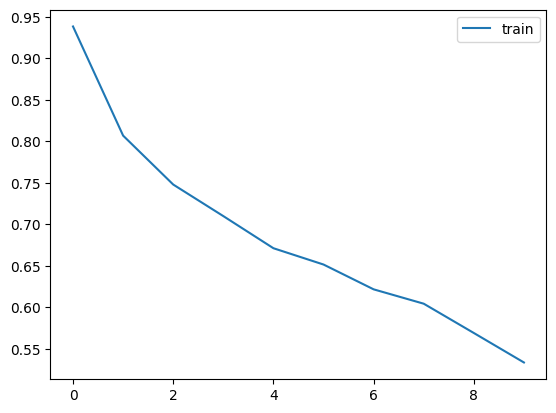

In [ ]:
train_losses = train(model)
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

==> Testing ...


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]



 ==> Finished testing


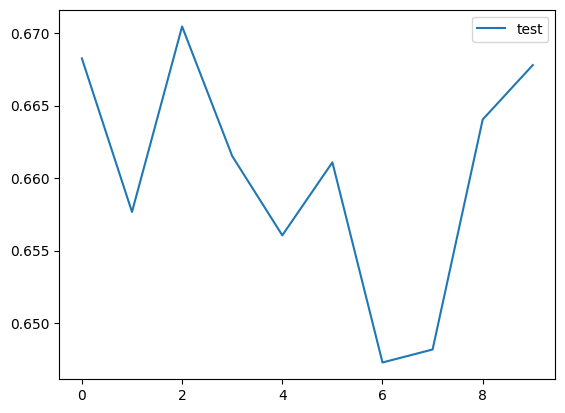

In [ ]:
test_losses = test_on_epoch(model)
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.928  acc:0.762
test  auc: 0.892  acc:0.716


# UNet 3 слоя

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet3Level(nn.Module):
    def __init__(self, in_channels, num_classes):
        set_random_seed(42) # оставляем для воспроизводимости результатов
        super().__init__()

        #Encoder----------------------------------------------------
        self.encoder_conv1 = double_conv(in_channels, 32)
        self.encoder_pool1 = nn.MaxPool2d(2)
        self.encoder_conv2 = double_conv(32, 64)
        self.encoder_pool2 = nn.MaxPool2d(2)
        self.encoder_conv3 = double_conv(64, 128)
        self.encoder_pool3 = nn.MaxPool2d(2)
        #Encoder----------------------------------------------------

        #Center-----------------------------------------------------
        self.center = double_conv(128, 256)

        #Decoder----------------------------------------------------
        self.decoder_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv1 = double_conv(256, 128)
        self.decoder_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv2 = double_conv(128, 64)
        self.decoder_trans3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder_conv3 = double_conv(64, 32)
        #Decoder----------------------------------------------------

        #CNN--------------------------------------------------------
        self.cnn1 = double_conv(32, 16)
        self.cnn1_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.cnn2 = double_conv(16, 8)
        self.cnn2_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #CNN--------------------------------------------------------

        #Output-----------------------------------------------------
        self.oneline = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(392, 60)
        self.linear_out = nn.Linear(60, num_classes)
        #Output-----------------------------------------------------


    def forward(self, x):
        #Encoder----------------------------------------------------
        enc1 = self.encoder_conv1(x)
        enc2 = self.encoder_conv2(self.encoder_pool1(enc1))
        enc3 = self.encoder_conv3(self.encoder_pool2(enc2))
        enc3 = self.encoder_pool3(enc3)
        #Encoder----------------------------------------------------

        #Center-----------------------------------------------------
        center = self.center(enc3)
        #Center-----------------------------------------------------

        #Decoder----------------------------------------------------
        dec1 = self.decoder_trans1(center)
        dec1_resized = F.interpolate(dec1, size=enc3.size()[2:], mode='bilinear', align_corners=False)
        dec1 = torch.cat([dec1_resized, enc3], dim=1)
        dec1 = self.decoder_conv1(dec1)

        dec2 = self.decoder_trans2(dec1)
        dec2_resized = F.interpolate(dec2, size=enc2.size()[2:], mode='bilinear', align_corners=False)
        dec2 = torch.cat([dec2_resized, enc2], dim=1)
        dec2 = self.decoder_conv2(dec2)

        dec3 = self.decoder_trans3(dec2)
        dec3_resized = F.interpolate(dec3, size=enc1.size()[2:], mode='bilinear', align_corners=False)
        dec3 = torch.cat([dec3_resized, enc1], dim=1)
        dec3 = self.decoder_conv3(dec3)
        #Decoder----------------------------------------------------

        #CNN--------------------------------------------------------
        output = self.cnn1(dec3)
        output = self.cnn1_pool(output)
        output = self.relu(output)

        output = self.cnn2(output)
        output = self.cnn2_pool(output)
        output = self.relu(output)
        #CNN--------------------------------------------------------

        #Output-----------------------------------------------------
        output = self.oneline(output)
        output = self.linear1(output)
        output = self.linear_out(output)
        #Output-----------------------------------------------------

        return output

In [ ]:
model = UNet3Level(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# число эпох и lr можно менять
NUM_EPOCHS = 3
lr = 0.1

optimizer = optim.SGD(model.parameters(), lr=lr)

==> Training ...


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.964051365852356


  2%|▏         | 1/57 [00:02<02:24,  2.57s/it]

loss=1.667037010192871


  4%|▎         | 2/57 [00:04<02:02,  2.24s/it]

loss=1.7458819150924683


  5%|▌         | 3/57 [00:06<01:52,  2.08s/it]

loss=1.139792561531067


  7%|▋         | 4/57 [00:08<01:50,  2.09s/it]

loss=0.9907486438751221


  9%|▉         | 5/57 [00:10<01:50,  2.13s/it]

loss=0.9785097241401672


 11%|█         | 6/57 [00:12<01:46,  2.09s/it]

loss=1.0826131105422974


 12%|█▏        | 7/57 [00:14<01:39,  1.99s/it]

loss=0.9974377751350403


 14%|█▍        | 8/57 [00:16<01:34,  1.93s/it]

loss=0.9451068639755249


 16%|█▌        | 9/57 [00:18<01:35,  1.98s/it]

loss=0.7765350937843323


 18%|█▊        | 10/57 [00:20<01:36,  2.05s/it]

loss=0.8896313309669495


 19%|█▉        | 11/57 [00:22<01:36,  2.10s/it]

loss=0.9914214611053467


 21%|██        | 12/57 [00:24<01:31,  2.04s/it]

loss=1.0171902179718018


 23%|██▎       | 13/57 [00:26<01:27,  1.99s/it]

loss=0.8812698721885681


 25%|██▍       | 14/57 [00:28<01:24,  1.97s/it]

loss=1.0394413471221924


 26%|██▋       | 15/57 [00:30<01:23,  1.98s/it]

loss=1.0393593311309814


 28%|██▊       | 16/57 [00:32<01:22,  2.01s/it]

loss=1.0003966093063354


 30%|██▉       | 17/57 [00:34<01:21,  2.04s/it]

loss=1.0515395402908325


 32%|███▏      | 18/57 [00:36<01:17,  2.00s/it]

loss=1.06247079372406


 33%|███▎      | 19/57 [00:38<01:14,  1.97s/it]

loss=0.9408090114593506


 35%|███▌      | 20/57 [00:40<01:12,  1.95s/it]

loss=1.0776267051696777


 37%|███▋      | 21/57 [00:42<01:10,  1.96s/it]

loss=0.9477087259292603


 39%|███▊      | 22/57 [00:44<01:09,  1.97s/it]

loss=0.9053805470466614


 40%|████      | 23/57 [00:46<01:07,  1.98s/it]

loss=0.8289801478385925


 42%|████▏     | 24/57 [00:48<01:05,  1.99s/it]

loss=1.1820621490478516


 44%|████▍     | 25/57 [00:50<01:02,  1.96s/it]

loss=1.0604220628738403


 46%|████▌     | 26/57 [00:52<01:02,  2.00s/it]

loss=1.0479838848114014


 47%|████▋     | 27/57 [00:54<01:02,  2.09s/it]

loss=0.9150580167770386


 49%|████▉     | 28/57 [00:57<01:02,  2.15s/it]

loss=0.9988837242126465


 51%|█████     | 29/57 [00:59<01:01,  2.20s/it]

loss=0.9802917838096619


 53%|█████▎    | 30/57 [01:01<00:57,  2.14s/it]

loss=0.8570339679718018


 54%|█████▍    | 31/57 [01:03<00:55,  2.13s/it]

loss=0.8221917152404785


 56%|█████▌    | 32/57 [01:05<00:54,  2.18s/it]

loss=1.119964838027954


 58%|█████▊    | 33/57 [01:08<00:53,  2.21s/it]

loss=0.9395654201507568


 60%|█████▉    | 34/57 [01:10<00:50,  2.21s/it]

loss=0.8990530967712402


 61%|██████▏   | 35/57 [01:12<00:47,  2.18s/it]

loss=0.9739072322845459


 63%|██████▎   | 36/57 [01:14<00:45,  2.15s/it]

loss=0.8930562734603882


 65%|██████▍   | 37/57 [01:16<00:41,  2.08s/it]

loss=0.8008251190185547


 67%|██████▋   | 38/57 [01:18<00:40,  2.12s/it]

loss=0.8825134038925171


 68%|██████▊   | 39/57 [01:20<00:38,  2.14s/it]

loss=1.0374400615692139


 70%|███████   | 40/57 [01:22<00:36,  2.13s/it]

loss=1.048282504081726


 72%|███████▏  | 41/57 [01:24<00:32,  2.06s/it]

loss=0.8602038025856018


 74%|███████▎  | 42/57 [01:26<00:30,  2.04s/it]

loss=0.8179726004600525


 75%|███████▌  | 43/57 [01:28<00:27,  1.97s/it]

loss=0.9947079420089722


 77%|███████▋  | 44/57 [01:30<00:26,  2.04s/it]

loss=1.1431900262832642


 79%|███████▉  | 45/57 [01:32<00:24,  2.06s/it]

loss=0.9651520252227783


 81%|████████  | 46/57 [01:34<00:22,  2.07s/it]

loss=0.8844770193099976


 82%|████████▏ | 47/57 [01:36<00:20,  2.05s/it]

loss=0.9081944823265076


 84%|████████▍ | 48/57 [01:39<00:18,  2.06s/it]

loss=0.9008158445358276


 86%|████████▌ | 49/57 [01:41<00:16,  2.04s/it]

loss=0.9059897661209106


 88%|████████▊ | 50/57 [01:43<00:14,  2.03s/it]

loss=0.8668639063835144


 89%|████████▉ | 51/57 [01:44<00:11,  1.99s/it]

loss=0.7655371427536011


 91%|█████████ | 52/57 [01:46<00:09,  1.99s/it]

loss=0.8448540568351746


 93%|█████████▎| 53/57 [01:48<00:07,  1.97s/it]

loss=0.9317268133163452


 95%|█████████▍| 54/57 [01:50<00:05,  1.92s/it]

loss=0.7822703719139099


 96%|█████████▋| 55/57 [01:52<00:03,  1.97s/it]

loss=0.9897885918617249


 98%|█████████▊| 56/57 [01:54<00:02,  2.04s/it]

loss=1.0096826553344727


100%|██████████| 57/57 [01:56<00:00,  2.05s/it]


0: loss=0.9998403860811602


  0%|          | 0/57 [00:00<?, ?it/s]

loss=1.0474919080734253


  2%|▏         | 1/57 [00:02<01:57,  2.10s/it]

loss=0.9102494120597839


  4%|▎         | 2/57 [00:04<01:55,  2.10s/it]

loss=0.8640098571777344


  5%|▌         | 3/57 [00:06<01:53,  2.10s/it]

loss=0.8352673649787903


  7%|▋         | 4/57 [00:08<01:55,  2.18s/it]

loss=0.6721515655517578


  9%|▉         | 5/57 [00:10<01:53,  2.19s/it]

loss=0.8930273652076721


 11%|█         | 6/57 [00:12<01:44,  2.06s/it]

loss=0.8906508088111877


 12%|█▏        | 7/57 [00:14<01:36,  1.94s/it]

loss=0.8793910145759583


 14%|█▍        | 8/57 [00:16<01:32,  1.89s/it]

loss=0.8085240721702576


 16%|█▌        | 9/57 [00:18<01:33,  1.96s/it]

loss=0.8286625742912292


 18%|█▊        | 10/57 [00:20<01:34,  2.00s/it]

loss=0.9146274328231812


 19%|█▉        | 11/57 [00:22<01:32,  2.00s/it]

loss=0.784704864025116


 21%|██        | 12/57 [00:24<01:30,  2.00s/it]

loss=0.7910913825035095


 23%|██▎       | 13/57 [00:26<01:26,  1.97s/it]

loss=1.0573523044586182


 25%|██▍       | 14/57 [00:27<01:22,  1.92s/it]

loss=0.7691349983215332


 26%|██▋       | 15/57 [00:29<01:20,  1.91s/it]

loss=0.7672631740570068


 28%|██▊       | 16/57 [00:31<01:20,  1.97s/it]

loss=0.9404280185699463


 30%|██▉       | 17/57 [00:33<01:19,  1.98s/it]

loss=1.0271648168563843


 32%|███▏      | 18/57 [00:35<01:17,  1.99s/it]

loss=0.7617229223251343


 33%|███▎      | 19/57 [00:38<01:17,  2.05s/it]

loss=0.6414822340011597


 35%|███▌      | 20/57 [00:40<01:15,  2.03s/it]

loss=1.010326862335205


 37%|███▋      | 21/57 [00:42<01:15,  2.08s/it]

loss=0.9603503942489624


 39%|███▊      | 22/57 [00:44<01:14,  2.12s/it]

loss=0.9198048710823059


 40%|████      | 23/57 [00:46<01:11,  2.11s/it]

loss=0.9168238639831543


 42%|████▏     | 24/57 [00:48<01:11,  2.17s/it]

loss=0.7584212422370911


 44%|████▍     | 25/57 [00:50<01:05,  2.06s/it]

loss=0.9109545946121216


 46%|████▌     | 26/57 [00:52<01:02,  2.01s/it]

loss=0.8008249402046204


 47%|████▋     | 27/57 [00:54<01:01,  2.04s/it]

loss=0.9452316164970398


 49%|████▉     | 28/57 [00:56<01:00,  2.09s/it]

loss=0.8297984004020691


 51%|█████     | 29/57 [00:59<00:58,  2.09s/it]

loss=0.6295689940452576


 53%|█████▎    | 30/57 [01:01<00:55,  2.06s/it]

loss=0.8330280780792236


 54%|█████▍    | 31/57 [01:03<00:53,  2.07s/it]

loss=0.7931817173957825


 56%|█████▌    | 32/57 [01:05<00:52,  2.08s/it]

loss=0.8130303025245667


 58%|█████▊    | 33/57 [01:07<00:48,  2.03s/it]

loss=1.096254825592041


 60%|█████▉    | 34/57 [01:09<00:46,  2.02s/it]

loss=1.0541809797286987


 61%|██████▏   | 35/57 [01:11<00:44,  2.01s/it]

loss=0.9755868911743164


 63%|██████▎   | 36/57 [01:13<00:41,  1.98s/it]

loss=1.0870795249938965


 65%|██████▍   | 37/57 [01:15<00:40,  2.02s/it]

loss=0.8834012150764465


 67%|██████▋   | 38/57 [01:17<00:39,  2.07s/it]

loss=0.8762058615684509


 68%|██████▊   | 39/57 [01:19<00:36,  2.05s/it]

loss=0.7813984751701355


 70%|███████   | 40/57 [01:21<00:35,  2.09s/it]

loss=0.8780672550201416


 72%|███████▏  | 41/57 [01:23<00:33,  2.07s/it]

loss=0.892670214176178


 74%|███████▎  | 42/57 [01:25<00:31,  2.08s/it]

loss=0.9215104579925537


 75%|███████▌  | 43/57 [01:27<00:29,  2.08s/it]

loss=0.7453521490097046


 77%|███████▋  | 44/57 [01:29<00:27,  2.09s/it]

loss=0.779172420501709


 79%|███████▉  | 45/57 [01:31<00:24,  2.06s/it]

loss=0.7855445742607117


 81%|████████  | 46/57 [01:33<00:22,  2.04s/it]

loss=0.8072939515113831


 82%|████████▏ | 47/57 [01:35<00:20,  2.00s/it]

loss=0.8546298742294312


 84%|████████▍ | 48/57 [01:37<00:18,  2.03s/it]

loss=0.8366684317588806


 86%|████████▌ | 49/57 [01:39<00:16,  2.05s/it]

loss=0.8623867034912109


 88%|████████▊ | 50/57 [01:42<00:14,  2.07s/it]

loss=0.7770804166793823


 89%|████████▉ | 51/57 [01:43<00:12,  2.02s/it]

loss=0.8008890151977539


 91%|█████████ | 52/57 [01:45<00:09,  1.92s/it]

loss=0.8600266575813293


 93%|█████████▎| 53/57 [01:47<00:07,  1.88s/it]

loss=0.847992479801178


 95%|█████████▍| 54/57 [01:49<00:05,  1.86s/it]

loss=0.713829755783081


 96%|█████████▋| 55/57 [01:51<00:03,  1.87s/it]

loss=0.8688874840736389


 98%|█████████▊| 56/57 [01:53<00:01,  1.97s/it]

loss=0.8269610404968262


100%|██████████| 57/57 [01:54<00:00,  2.01s/it]


1: loss=0.859979203918524


  0%|          | 0/57 [00:00<?, ?it/s]

loss=0.8514484763145447


  2%|▏         | 1/57 [00:02<01:57,  2.09s/it]

loss=0.9370637536048889


  4%|▎         | 2/57 [00:03<01:42,  1.86s/it]

loss=0.8027319312095642


  5%|▌         | 3/57 [00:05<01:41,  1.88s/it]

loss=0.7559018135070801


  7%|▋         | 4/57 [00:07<01:42,  1.93s/it]

loss=0.8481732606887817


  9%|▉         | 5/57 [00:09<01:45,  2.03s/it]

loss=0.9270460605621338


 11%|█         | 6/57 [00:11<01:44,  2.05s/it]

loss=0.8328524827957153


 12%|█▏        | 7/57 [00:13<01:40,  2.00s/it]

loss=0.727615475654602


 14%|█▍        | 8/57 [00:15<01:38,  2.00s/it]

loss=0.7966136336326599


 16%|█▌        | 9/57 [00:17<01:34,  1.97s/it]

loss=0.8800914883613586


 18%|█▊        | 10/57 [00:19<01:35,  2.04s/it]

loss=0.8118705153465271


 19%|█▉        | 11/57 [00:21<01:33,  2.03s/it]

loss=0.9318386912345886


 21%|██        | 12/57 [00:23<01:29,  1.99s/it]

loss=0.751627504825592


 23%|██▎       | 13/57 [00:25<01:27,  1.99s/it]

loss=0.8234205842018127


 25%|██▍       | 14/57 [00:27<01:25,  2.00s/it]

loss=0.8430072665214539


 26%|██▋       | 15/57 [00:30<01:26,  2.06s/it]

loss=0.8662709593772888


 28%|██▊       | 16/57 [00:32<01:24,  2.07s/it]

loss=0.7516946196556091


 30%|██▉       | 17/57 [00:34<01:21,  2.05s/it]

loss=0.5975919365882874


 32%|███▏      | 18/57 [00:36<01:20,  2.06s/it]

loss=0.8343378901481628


 33%|███▎      | 19/57 [00:38<01:18,  2.08s/it]

loss=0.8262840509414673


 35%|███▌      | 20/57 [00:40<01:18,  2.11s/it]

loss=0.8811141848564148


 37%|███▋      | 21/57 [00:42<01:14,  2.08s/it]

loss=0.7070049047470093


 39%|███▊      | 22/57 [00:44<01:15,  2.15s/it]

loss=0.686436653137207


 40%|████      | 23/57 [00:47<01:13,  2.16s/it]

loss=0.9137726426124573


 42%|████▏     | 24/57 [00:49<01:11,  2.17s/it]

loss=0.791393518447876


 44%|████▍     | 25/57 [00:51<01:07,  2.12s/it]

loss=0.881626546382904


 46%|████▌     | 26/57 [00:53<01:04,  2.08s/it]

loss=0.6260889768600464


 47%|████▋     | 27/57 [00:55<01:02,  2.09s/it]

loss=0.8200708627700806


 49%|████▉     | 28/57 [00:57<00:59,  2.06s/it]

loss=0.7803990244865417


 51%|█████     | 29/57 [00:59<00:58,  2.07s/it]

loss=0.867897629737854


 53%|█████▎    | 30/57 [01:01<00:56,  2.08s/it]

loss=1.103135347366333


 54%|█████▍    | 31/57 [01:03<00:53,  2.06s/it]

loss=0.705532431602478


 56%|█████▌    | 32/57 [01:05<00:53,  2.13s/it]

loss=0.7538562417030334


 58%|█████▊    | 33/57 [01:07<00:50,  2.12s/it]

loss=0.7080260515213013


 60%|█████▉    | 34/57 [01:09<00:47,  2.09s/it]

loss=0.6934788227081299


 61%|██████▏   | 35/57 [01:11<00:45,  2.06s/it]

loss=0.8369615077972412


 63%|██████▎   | 36/57 [01:13<00:42,  2.01s/it]

loss=0.9434201717376709


 65%|██████▍   | 37/57 [01:15<00:38,  1.95s/it]

loss=0.8429000377655029


 67%|██████▋   | 38/57 [01:17<00:38,  2.02s/it]

loss=0.736875593662262


 68%|██████▊   | 39/57 [01:19<00:36,  2.02s/it]

loss=0.7959184646606445


 70%|███████   | 40/57 [01:21<00:34,  2.04s/it]

loss=0.8921588063240051


 72%|███████▏  | 41/57 [01:23<00:31,  2.00s/it]

loss=0.8410490155220032


 74%|███████▎  | 42/57 [01:25<00:29,  2.00s/it]

loss=0.8891127109527588


 75%|███████▌  | 43/57 [01:27<00:27,  2.00s/it]

loss=0.9957115054130554


 77%|███████▋  | 44/57 [01:29<00:26,  2.03s/it]

loss=0.8757112622261047


 79%|███████▉  | 45/57 [01:31<00:24,  2.02s/it]

loss=0.8170502185821533


 81%|████████  | 46/57 [01:33<00:21,  1.99s/it]

loss=0.6679141521453857


 82%|████████▏ | 47/57 [01:35<00:19,  1.99s/it]

loss=0.8644024729728699


 84%|████████▍ | 48/57 [01:37<00:18,  2.02s/it]

loss=0.7081204652786255


 86%|████████▌ | 49/57 [01:40<00:16,  2.05s/it]

loss=0.9585974812507629


 88%|████████▊ | 50/57 [01:42<00:14,  2.03s/it]

loss=0.7789694666862488


 89%|████████▉ | 51/57 [01:44<00:12,  2.02s/it]

loss=0.8570621609687805


 91%|█████████ | 52/57 [01:46<00:10,  2.05s/it]

loss=0.9295123219490051


 93%|█████████▎| 53/57 [01:48<00:08,  2.06s/it]

loss=0.6396156549453735


 95%|█████████▍| 54/57 [01:50<00:06,  2.01s/it]

loss=0.7487605214118958


 96%|█████████▋| 55/57 [01:52<00:04,  2.01s/it]

loss=0.8564162254333496


 98%|█████████▊| 56/57 [01:54<00:02,  2.01s/it]

loss=0.6820260286331177


100%|██████████| 57/57 [01:55<00:00,  2.02s/it]


2: loss=0.8153610961479053

 ==> Finished training


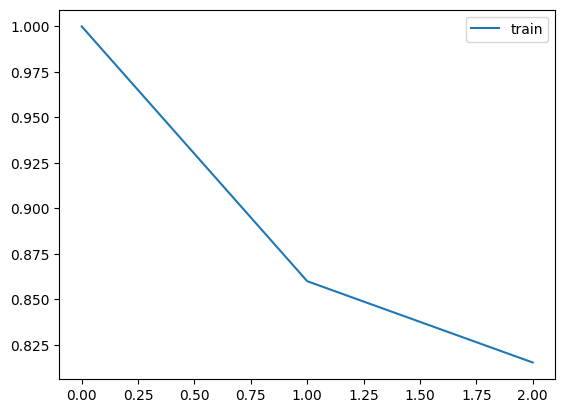

In [ ]:
train_losses = train(model)
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

==> Testing ...


100%|██████████| 57/57 [00:44<00:00,  1.28it/s]


 ==> Finished testing


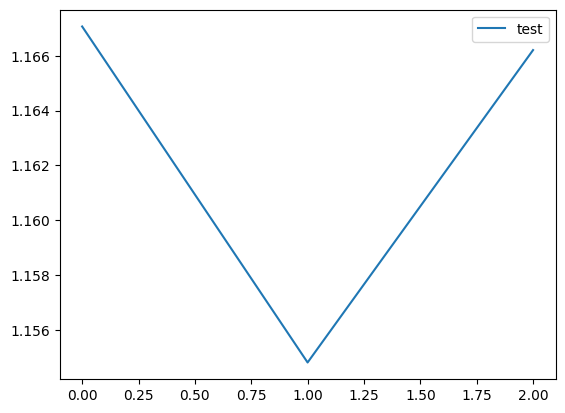

In [ ]:
test_losses = test_on_epoch(model)
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

In [ ]:
test(model)

==> Evaluating ...
train  auc: 0.742  acc:0.669
test  auc: 0.749  acc:0.669
